In [102]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [91]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C09    452
C12    227
C01    212
C10    169
C13    165
C02    158
C04     99
C05     61
C06     46
C03     45
Name: count, dtype: int64

In [92]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 3

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [93]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [94]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13'])

Initialize random model parameters and latent variables/responsibilities.

In [103]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [96]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

In [104]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.281875,0.487351,0.366537,0.442804,0.274028,0.189771,0.485022,0.057583,0.692963,0.446088
1,0.566157,0.508777,0.185485,0.199379,0.290183,0.158230,0.113625,0.429235,0.189988,0.473030
2,0.151967,0.003872,0.447978,0.357818,0.435789,0.651999,0.401353,0.513182,0.117050,0.080882


Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [105]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1],rtol = 0, atol = 0.01)) and np.all(current_likelihood >= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [106]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete=False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-8861.149052667717
1
-3457.443680231825
2
-3429.300770722326
3
-3407.9617660499785
4
-3378.641010454833
5
-3336.734531417028
6
-3297.4312294650545
7
-3273.848159632145
8
-3261.832001797866
9
-3255.8830846501305
10
-3252.147239400156
11
-3249.1842524015105
12
-3246.591464706784
13
-3244.249503116841
14
-3242.0992888761652
15
-3240.1780368271707
16
-3238.415688016317
17
-3236.8017858449703
18
-3235.317264193238
19
-3233.937328989603
20
-3232.6497119883215
21
-3231.439432377087
22
-3230.298153448658
23
-3229.2246576573452
24
-3228.211954390273
25
-3227.2585199525065
26
-3226.3651994288684
27
-3225.5267715365535
28
-3224.7434015456724
29
-3224.0109591708147
30
-3223.326577144933
31
-3222.6892374498043
32
-3222.0954696814733
33
-3221.5426498846255
34
-3221.0080211763916
35
-3220.492038025968
36
-3220.0157560471393
37
-3219.5574432768003
38
-3219.1144733640012
39
-3218.6994881244063
40
-3218.2947353335903
41
-3217.914010291013
42
-3217.554403333669
43
-3217.2113479765403
44
-3216.893949423

In [107]:
likelihood_history

[-8861.149052667717,
 -3457.443680231825,
 -3429.300770722326,
 -3407.9617660499785,
 -3378.641010454833,
 -3336.734531417028,
 -3297.4312294650545,
 -3273.848159632145,
 -3261.832001797866,
 -3255.8830846501305,
 -3252.147239400156,
 -3249.1842524015105,
 -3246.591464706784,
 -3244.249503116841,
 -3242.0992888761652,
 -3240.1780368271707,
 -3238.415688016317,
 -3236.8017858449703,
 -3235.317264193238,
 -3233.937328989603,
 -3232.6497119883215,
 -3231.439432377087,
 -3230.298153448658,
 -3229.2246576573452,
 -3228.211954390273,
 -3227.2585199525065,
 -3226.3651994288684,
 -3225.5267715365535,
 -3224.7434015456724,
 -3224.0109591708147,
 -3223.326577144933,
 -3222.6892374498043,
 -3222.0954696814733,
 -3221.5426498846255,
 -3221.0080211763916,
 -3220.492038025968,
 -3220.0157560471393,
 -3219.5574432768003,
 -3219.1144733640012,
 -3218.6994881244063,
 -3218.2947353335903,
 -3217.914010291013,
 -3217.554403333669,
 -3217.2113479765403,
 -3216.8939494235933,
 -3216.598816673443,
 -3216.32

In [108]:
# a = np.array(likelihood_history)
# np.savetxt('likelihoods_3_comp_t_stage_new.txt', a, fmt='%.6f')
b = np.loadtxt('likelihoods_3_comp_t_stage_new.txt', dtype=float)
b


FileNotFoundError: likelihoods_3_comp_t_stage_new.txt not found.

In [109]:
differences = []
for i in range(len(params_history)-1):
    differences.append(np.abs(np.array(list(params_history[i].values())) - np.array(list(params_history[i+1].values()))).sum())
differences

[24.43162161614799,
 1.666686978531569,
 1.336110362721769,
 1.4675629832925035,
 1.9186646529454765,
 2.376928232266133,
 1.9769210123675185,
 1.3496425371618281,
 0.820322903369987,
 0.5022227074264299,
 0.36696754489295763,
 0.31254553881244734,
 0.2895998496520673,
 0.27464144579790206,
 0.25105130214856897,
 0.2416624226215413,
 0.23451393029671153,
 0.22727006829188073,
 0.2256281382637627,
 0.2238237683591441,
 0.21946019453077772,
 0.21295282259414502,
 0.20547726932606614,
 0.19680468891844533,
 0.18875019972990414,
 0.18000755681860126,
 0.1700675108104997,
 0.16124987984647624,
 0.1515596676359723,
 0.14355908200541145,
 0.13558190891194757,
 0.1274232283353071,
 0.12007004658097062,
 0.11391812703824492,
 0.11225669265011129,
 0.11408407893621952,
 0.11424173218345594,
 0.11547733494490703,
 0.11695488642605958,
 0.11713121933812609,
 0.11796372309036388,
 0.11726436060462908,
 0.11527172687371082,
 0.11310415656174175,
 0.10972034563004372,
 0.10545745363185703,
 0.1002613

Text(0.5, 1.0, 'Convergence of EM algorithm 3 comp 3 locs')

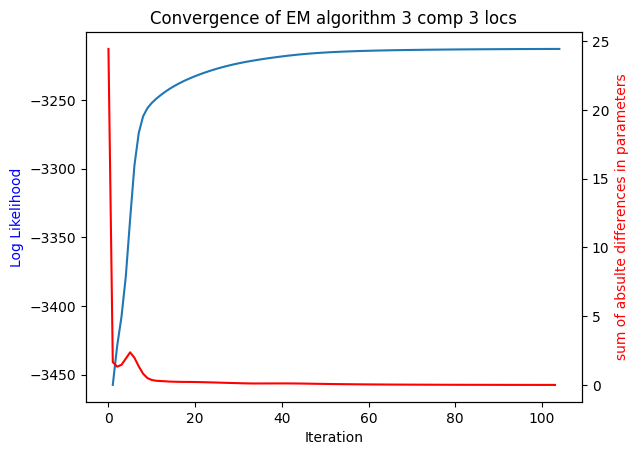

In [110]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(np.array(range(len(likelihood_history[1:])))+1,likelihood_history[1:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log Likelihood', color='blue')
ax2 = ax1.twinx()
ax2.plot(differences, color='red')  
ax2.set_ylabel('sum of absulte differences in parameters', color='red')
ax1.set_title('Convergence of EM algorithm 3 comp 3 locs')

In [113]:
params = params_history[np.argmax(likelihood_history)]
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [123]:
params_history = [{'0_TtoI_spread': 0.7739560485559633,
  '0_TtoII_spread': 0.4388784397520523,
  '0_TtoIII_spread': 0.8585979199113825,
  '0_TtoIV_spread': 0.6973680290593639,
  '0_TtoV_spread': 0.09417734788764953,
  '0_ItoII_spread': 0.9756223516367559,
  '0_IItoIII_spread': 0.761139701990353,
  '0_IIItoIV_spread': 0.7860643052769538,
  '0_IVtoV_spread': 0.12811363267554587,
  '0_late_p': 0.45038593789556713,
  '0_C01_coef': 0.37079802423258124,
  '0_C02_coef': 0.9267649888486018,
  '0_C03_coef': 0.6438651200806645,
  '0_C04_coef': 0.82276161327083,
  '0_C05_coef': 0.44341419882733113,
  '0_C06_coef': 0.2272387217847769,
  '0_C09_coef': 0.5545847870158348,
  '0_C10_coef': 0.06381725610417532,
  '0_C12_coef': 0.8276311719925821,
  '0_C13_coef': 0.6316643991220648,
  '0_C32_coef': 0.7580877400853738,
  '1_TtoI_spread': 0.35452596812986836,
  '1_TtoII_spread': 0.9706980243949033,
  '1_TtoIII_spread': 0.8931211213221977,
  '1_TtoIV_spread': 0.7783834970737619,
  '1_TtoV_spread': 0.19463870785196757,
  '1_ItoII_spread': 0.4667210037270342,
  '1_IItoIII_spread': 0.04380376578722878,
  '1_IIItoIV_spread': 0.15428949206754783,
  '1_IVtoV_spread': 0.6830489532424546,
  '1_late_p': 0.7447621559078171,
  '1_C01_coef': 0.96750973243421,
  '1_C02_coef': 0.32582535813815194,
  '1_C03_coef': 0.3704597060348689,
  '1_C04_coef': 0.4695558112758079,
  '1_C05_coef': 0.1894713590842857,
  '1_C06_coef': 0.12992150533547164,
  '1_C09_coef': 0.47570492622593374,
  '1_C10_coef': 0.2269093490508841,
  '1_C12_coef': 0.6698139946825103,
  '1_C13_coef': 0.43715191887233074,
  '1_C32_coef': 0.8326781960578374,
  '2_TtoI_spread': 0.7002651020022491,
  '2_TtoII_spread': 0.31236664138204107,
  '2_TtoIII_spread': 0.8322598013952011,
  '2_TtoIV_spread': 0.8047643574968019,
  '2_TtoV_spread': 0.38747837903017446,
  '2_ItoII_spread': 0.2883281039302441,
  '2_IItoIII_spread': 0.6824955039749755,
  '2_IIItoIV_spread': 0.1397524836093098,
  '2_IVtoV_spread': 0.19990820247510832,
  '2_late_p': 0.007362269751005512,
  '2_C01_coef': 0.7869243775021384,
  '2_C02_coef': 0.6648508565920321,
  '2_C03_coef': 0.7051653786263351,
  '2_C04_coef': 0.7807290310219679,
  '2_C05_coef': 0.45891577553833995,
  '2_C06_coef': 0.5687411959528937,
  '2_C09_coef': 0.13979699812765745,
  '2_C10_coef': 0.11453007353597344,
  '2_C12_coef': 0.6684029617904717,
  '2_C13_coef': 0.4710962061431325,
  '2_C32_coef': 0.5652361064811888,
  '3_TtoI_spread': 0.7649988574160256,
  '3_TtoII_spread': 0.6347183200005908,
  '3_TtoIII_spread': 0.5535794006579958,
  '3_TtoIV_spread': 0.5592071607454135,
  '3_TtoV_spread': 0.3039500980626122,
  '3_ItoII_spread': 0.030817834567939406,
  '3_IItoIII_spread': 0.43671738923236236,
  '3_IIItoIV_spread': 0.2145846728195292,
  '3_IVtoV_spread': 0.40852864372463615,
  '3_late_p': 0.8534030732681661,
  '3_C01_coef': 0.23393948586534075,
  '3_C02_coef': 0.05830274168906602,
  '3_C03_coef': 0.28138389202199654,
  '3_C04_coef': 0.2935937577666836,
  '3_C05_coef': 0.6619165147268951,
  '3_C06_coef': 0.5570321523412783,
  '3_C09_coef': 0.7838982091064135,
  '3_C10_coef': 0.6643135403273875,
  '3_C12_coef': 0.4063868614400705,
  '3_C13_coef': 0.8140203846660347,
  '3_C32_coef': 0.1669729199077039},
 {'0_TtoI_spread': 0.021347123752187797,
  '0_TtoII_spread': 0.13769757622134698,
  '0_TtoIII_spread': 0.0577982435044898,
  '0_TtoIV_spread': 0.00805955580133573,
  '0_TtoV_spread': 0.0033378933013173853,
  '0_ItoII_spread': 0.07996208138051168,
  '0_IItoIII_spread': 0.04550131208308033,
  '0_IIItoIV_spread': 0.053458631039184745,
  '0_IVtoV_spread': 0.0057777324562674984,
  '0_late_p': 0.9999495521975987,
  '0_C01_coef': 0.1805081889737959,
  '0_C02_coef': 0.4379311385886292,
  '0_C03_coef': 0.26240034001400675,
  '0_C04_coef': 0.31027257105249983,
  '0_C05_coef': 0.2547416454804826,
  '0_C06_coef': 0.13541135278928534,
  '0_C09_coef': 0.28285869842237604,
  '0_C10_coef': 0.14058137485932706,
  '0_C12_coef': 0.3151310694298953,
  '0_C13_coef': 0.3294014047586568,
  '0_C32_coef': 0.25671329427022976,
  '1_TtoI_spread': 0.004438148747757586,
  '1_TtoII_spread': 0.2221693236941215,
  '1_TtoIII_spread': 0.0035069455453748473,
  '1_TtoIV_spread': 0.005459940325084855,
  '1_TtoV_spread': 0.008853204634734244,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.5670085609415149,
  '1_IIItoIV_spread': 0.33000671365020173,
  '1_IVtoV_spread': 0.569981907953919,
  '1_late_p': 0.9999511930152956,
  '1_C01_coef': 0.28300497047961615,
  '1_C02_coef': 0.1614343975680313,
  '1_C03_coef': 0.07062519039082973,
  '1_C04_coef': 0.10785443114070614,
  '1_C05_coef': 0.0756737051025482,
  '1_C06_coef': 0.0320935674923199,
  '1_C09_coef': 0.20227750800085328,
  '1_C10_coef': 0.11938067259542579,
  '1_C12_coef': 0.18987696063286652,
  '1_C13_coef': 0.09296186165354087,
  '1_C32_coef': 0.1886606513167756,
  '2_TtoI_spread': 0.01993761307821566,
  '2_TtoII_spread': 0.13992119029518793,
  '2_TtoIII_spread': 0.0445114119533462,
  '2_TtoIV_spread': 0.016680758178932272,
  '2_TtoV_spread': 0.01876526690954968,
  '2_ItoII_spread': 0.26707735494430734,
  '2_IItoIII_spread': 0.3063832551002847,
  '2_IIItoIV_spread': 0.09939820104958719,
  '2_IVtoV_spread': 0.07061043237073424,
  '2_late_p': 0.264160110337304,
  '2_C01_coef': 0.4593909834924655,
  '2_C02_coef': 0.35137162481082534,
  '2_C03_coef': 0.5460796962391705,
  '2_C04_coef': 0.47348670199719173,
  '2_C05_coef': 0.33053283339467554,
  '2_C06_coef': 0.6595403829178883,
  '2_C09_coef': 0.1431580674366957,
  '2_C10_coef': 0.4704230279128499,
  '2_C12_coef': 0.43704117113539875,
  '2_C13_coef': 0.4603008887403166,
  '2_C32_coef': 0.5149406856247698,
  '3_TtoI_spread': 0.03739449882035251,
  '3_TtoII_spread': 0.28869835062872895,
  '3_TtoIII_spread': 0.034699463680388835,
  '3_TtoIV_spread': 0.00734387666293611,
  '3_TtoV_spread': 0.02340091304586156,
  '3_ItoII_spread': 0.23473707939950653,
  '3_IItoIII_spread': 0.057416307220452524,
  '3_IIItoIV_spread': 0.09896783963867484,
  '3_IVtoV_spread': 0.27222065672122153,
  '3_late_p': 0.9999338930386481,
  '3_C01_coef': 0.07709585705412246,
  '3_C02_coef': 0.049262839032514175,
  '3_C03_coef': 0.12089477335599308,
  '3_C04_coef': 0.10838629580960232,
  '3_C05_coef': 0.3390518160222936,
  '3_C06_coef': 0.17295469680050657,
  '3_C09_coef': 0.37170572614007513,
  '3_C10_coef': 0.26961492463239745,
  '3_C12_coef': 0.057950798801839364,
  '3_C13_coef': 0.11733584484748572,
  '3_C32_coef': 0.03968536878822483},
 {'0_TtoI_spread': 0.015985651768679113,
  '0_TtoII_spread': 0.12284132975908682,
  '0_TtoIII_spread': 0.04542432688476997,
  '0_TtoIV_spread': 0.009799660243864748,
  '0_TtoV_spread': 0.003303599876797193,
  '0_ItoII_spread': 0.025022502673308487,
  '0_IItoIII_spread': 0.05230360014850263,
  '0_IIItoIV_spread': 0.036489246564136484,
  '0_IVtoV_spread': 0.0010583258383956061,
  '0_late_p': 0.9999362514482022,
  '0_C01_coef': 0.2400314859994098,
  '0_C02_coef': 0.45733816256365667,
  '0_C03_coef': 0.2524084480238667,
  '0_C04_coef': 0.320746564060157,
  '0_C05_coef': 0.2697077717091575,
  '0_C06_coef': 0.12293174279251834,
  '0_C09_coef': 0.26562568510227197,
  '0_C10_coef': 0.15238519506107162,
  '0_C12_coef': 0.34000535052360586,
  '0_C13_coef': 0.37103189749108595,
  '0_C32_coef': 0.23819909411800597,
  '1_TtoI_spread': 0.005473268487969197,
  '1_TtoII_spread': 0.21735484704609953,
  '1_TtoIII_spread': 0.0033545926060493565,
  '1_TtoIV_spread': 0.004292041186136364,
  '1_TtoV_spread': 0.009910852253312931,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.6038316175743855,
  '1_IIItoIV_spread': 0.30062210507983794,
  '1_IVtoV_spread': 0.41751618740725244,
  '1_late_p': 0.6228762646519681,
  '1_C01_coef': 0.21483070879181795,
  '1_C02_coef': 0.12545085128892283,
  '1_C03_coef': 0.030304225372710873,
  '1_C04_coef': 0.06033779416215041,
  '1_C05_coef': 0.05892960643485986,
  '1_C06_coef': 0.01387444423198354,
  '1_C09_coef': 0.17926940922596188,
  '1_C10_coef': 0.09572872369780684,
  '1_C12_coef': 0.1909124672375301,
  '1_C13_coef': 0.07637859665535715,
  '1_C32_coef': 0.1293035362266343,
  '2_TtoI_spread': 0.015571535551661332,
  '2_TtoII_spread': 0.10661698964644353,
  '2_TtoIII_spread': 0.03358360077755609,
  '2_TtoIV_spread': 0.011320671367612754,
  '2_TtoV_spread': 0.011127632896952556,
  '2_ItoII_spread': 0.1554491285076483,
  '2_IItoIII_spread': 0.2965174846359512,
  '2_IIItoIV_spread': 0.09698027349827743,
  '2_IVtoV_spread': 0.07116623185128464,
  '2_late_p': 0.2948700719282814,
  '2_C01_coef': 0.43148851388013215,
  '2_C02_coef': 0.3632150010227299,
  '2_C03_coef': 0.6139850233882793,
  '2_C04_coef': 0.5320773154320815,
  '2_C05_coef': 0.3497426389624824,
  '2_C06_coef': 0.7304482018253885,
  '2_C09_coef': 0.14693432160104383,
  '2_C10_coef': 0.4682559905217219,
  '2_C12_coef': 0.4087319998068089,
  '2_C13_coef': 0.4418253453487458,
  '2_C32_coef': 0.6073098163675466,
  '3_TtoI_spread': 0.04005178840864456,
  '3_TtoII_spread': 0.3804466676373112,
  '3_TtoIII_spread': 0.04333092819444387,
  '3_TtoIV_spread': 0.006616394835522726,
  '3_TtoV_spread': 0.02574877114913747,
  '3_ItoII_spread': 0.12765848830997115,
  '3_IItoIII_spread': 0.04718507054982448,
  '3_IIItoIV_spread': 0.08016144149923116,
  '3_IVtoV_spread': 0.13746251509491494,
  '3_late_p': 0.7546485536906627,
  '3_C01_coef': 0.1136492913286401,
  '3_C02_coef': 0.05399598512469058,
  '3_C03_coef': 0.10330230321514314,
  '3_C04_coef': 0.0868383263456112,
  '3_C05_coef': 0.32161998289350024,
  '3_C06_coef': 0.13274561115010966,
  '3_C09_coef': 0.4081705840707223,
  '3_C10_coef': 0.28363009071939965,
  '3_C12_coef': 0.06035018243205515,
  '3_C13_coef': 0.11076416050481108,
  '3_C32_coef': 0.02518755328781329},
 {'0_TtoI_spread': 0.014506529359499528,
  '0_TtoII_spread': 0.11938698725867448,
  '0_TtoIII_spread': 0.04463863150428658,
  '0_TtoIV_spread': 0.012506917308081103,
  '0_TtoV_spread': 0.004048773190533614,
  '0_ItoII_spread': 0.00011417482803723636,
  '0_IItoIII_spread': 0.04558572453668808,
  '0_IIItoIV_spread': 0.024615288965200398,
  '0_IVtoV_spread': 0.0002477001823981521,
  '0_late_p': 0.9999358210120638,
  '0_C01_coef': 0.27749307036445175,
  '0_C02_coef': 0.4681915391390557,
  '0_C03_coef': 0.23452576376603623,
  '0_C04_coef': 0.32249249865915114,
  '0_C05_coef': 0.2774226994540645,
  '0_C06_coef': 0.11088108835403959,
  '0_C09_coef': 0.2312326190667797,
  '0_C10_coef': 0.15605240298362394,
  '0_C12_coef': 0.34917203332878227,
  '0_C13_coef': 0.40862498742023273,
  '0_C32_coef': 0.21872780010836082,
  '1_TtoI_spread': 0.0077835717456992675,
  '1_TtoII_spread': 0.2639278860790662,
  '1_TtoIII_spread': 0.0053618057479997315,
  '1_TtoIV_spread': 0.004864615480815356,
  '1_TtoV_spread': 0.013405187115173044,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.6910440857046141,
  '1_IIItoIV_spread': 0.34779237261350743,
  '1_IVtoV_spread': 0.4349567483224218,
  '1_late_p': 0.46164033530632287,
  '1_C01_coef': 0.20980513577514825,
  '1_C02_coef': 0.10557423537925127,
  '1_C03_coef': 0.015125130595866038,
  '1_C04_coef': 0.03841482222561039,
  '1_C05_coef': 0.05395444043693534,
  '1_C06_coef': 0.007908362861695824,
  '1_C09_coef': 0.17791380276932098,
  '1_C10_coef': 0.09966975798487766,
  '1_C12_coef': 0.24480193165181316,
  '1_C13_coef': 0.0899651199728476,
  '1_C32_coef': 0.10939871427032243,
  '2_TtoI_spread': 0.013504737911578997,
  '2_TtoII_spread': 0.08243689118241898,
  '2_TtoIII_spread': 0.028279016760901755,
  '2_TtoIV_spread': 0.007626100736935001,
  '2_TtoV_spread': 0.00775619662337012,
  '2_ItoII_spread': 0.12374941309862938,
  '2_IItoIII_spread': 0.29415943794475236,
  '2_IIItoIV_spread': 0.10144476408196368,
  '2_IVtoV_spread': 0.09943553795137418,
  '2_late_p': 0.3422525531112985,
  '2_C01_coef': 0.33542572693438233,
  '2_C02_coef': 0.3631240473185589,
  '2_C03_coef': 0.6553108599154154,
  '2_C04_coef': 0.5677493975256127,
  '2_C05_coef': 0.3533911483396073,
  '2_C06_coef': 0.763266743981532,
  '2_C09_coef': 0.12951865248732392,
  '2_C10_coef': 0.4259993462009536,
  '2_C12_coef': 0.3369279691064118,
  '2_C13_coef': 0.38295536376775735,
  '2_C32_coef': 0.656146729474089,
  '3_TtoI_spread': 0.046985620316419015,
  '3_TtoII_spread': 0.4952939765461709,
  '3_TtoIII_spread': 0.06041855098583994,
  '3_TtoIV_spread': 0.007606189201820737,
  '3_TtoV_spread': 0.029386268071331982,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.03620087411156206,
  '3_IIItoIV_spread': 0.09916269228639517,
  '3_IVtoV_spread': 0.1427029959130259,
  '3_late_p': 0.6170309105465297,
  '3_C01_coef': 0.17727606692601763,
  '3_C02_coef': 0.06311017816313413,
  '3_C03_coef': 0.09503824572268238,
  '3_C04_coef': 0.07134328158962573,
  '3_C05_coef': 0.31523171176939296,
  '3_C06_coef': 0.1179438048027326,
  '3_C09_coef': 0.46133492567657547,
  '3_C10_coef': 0.318278492830545,
  '3_C12_coef': 0.06909806591299275,
  '3_C13_coef': 0.11845452883916227,
  '3_C32_coef': 0.015726756147227763},
 {'0_TtoI_spread': 0.013363211904071097,
  '0_TtoII_spread': 0.11850232804701409,
  '0_TtoIII_spread': 0.047255276972925385,
  '0_TtoIV_spread': 0.015493529806476398,
  '0_TtoV_spread': 0.005062007223123583,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0342966903708426,
  '0_IIItoIV_spread': 0.013562385828789946,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999363342104526,
  '0_C01_coef': 0.294754945540599,
  '0_C02_coef': 0.47783658433107484,
  '0_C03_coef': 0.2076167009566974,
  '0_C04_coef': 0.3168535183260886,
  '0_C05_coef': 0.2854434668476961,
  '0_C06_coef': 0.09667989167857868,
  '0_C09_coef': 0.20292364466165075,
  '0_C10_coef': 0.15832711312500994,
  '0_C12_coef': 0.35513726223560377,
  '0_C13_coef': 0.44556857905869623,
  '0_C32_coef': 0.20069014066894778,
  '1_TtoI_spread': 0.01016614690283458,
  '1_TtoII_spread': 0.32750828479635147,
  '1_TtoIII_spread': 0.009717546018170481,
  '1_TtoIV_spread': 0.005440653089678337,
  '1_TtoV_spread': 0.018405443507568002,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.767484834144018,
  '1_IIItoIV_spread': 0.3847151940169983,
  '1_IVtoV_spread': 0.44889071901901284,
  '1_late_p': 0.37930901650675053,
  '1_C01_coef': 0.21154755601120676,
  '1_C02_coef': 0.08888506053599471,
  '1_C03_coef': 0.00709847515645296,
  '1_C04_coef': 0.023652345385212815,
  '1_C05_coef': 0.049670986501407194,
  '1_C06_coef': 0.0046190229138959775,
  '1_C09_coef': 0.17816655792038757,
  '1_C10_coef': 0.10555306701055997,
  '1_C12_coef': 0.3078396898984892,
  '1_C13_coef': 0.10923513738416578,
  '1_C32_coef': 0.09188305149583614,
  '2_TtoI_spread': 0.011239918437722457,
  '2_TtoII_spread': 0.058604564459201335,
  '2_TtoIII_spread': 0.022683115792926777,
  '2_TtoIV_spread': 0.004506327234498001,
  '2_TtoV_spread': 0.00513211768125815,
  '2_ItoII_spread': 0.08682861639722546,
  '2_IItoIII_spread': 0.26245496549669317,
  '2_IIItoIV_spread': 0.08787304222616978,
  '2_IVtoV_spread': 0.10744677947550355,
  '2_late_p': 0.43156726628947206,
  '2_C01_coef': 0.2291992699609731,
  '2_C02_coef': 0.35852947182754047,
  '2_C03_coef': 0.6943867897823252,
  '2_C04_coef': 0.6002069693011196,
  '2_C05_coef': 0.3549525973996953,
  '2_C06_coef': 0.7843381540768399,
  '2_C09_coef': 0.11263178001687982,
  '2_C10_coef': 0.3844774387405904,
  '2_C12_coef': 0.25946687064836155,
  '2_C13_coef': 0.3182528811705835,
  '2_C32_coef': 0.6976638688511682,
  '3_TtoI_spread': 0.05067666209795306,
  '3_TtoII_spread': 0.5872981705632307,
  '3_TtoIII_spread': 0.07483620365077082,
  '3_TtoIV_spread': 0.007840055084186844,
  '3_TtoV_spread': 0.02931151218584263,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.026495330602963954,
  '3_IIItoIV_spread': 0.11762723239736728,
  '3_IVtoV_spread': 0.15179804093181662,
  '3_late_p': 0.5512137171198974,
  '3_C01_coef': 0.2644982284872212,
  '3_C02_coef': 0.07474888330538998,
  '3_C03_coef': 0.09089803410452456,
  '3_C04_coef': 0.059287166987578965,
  '3_C05_coef': 0.30993294925120146,
  '3_C06_coef': 0.11436293133068551,
  '3_C09_coef': 0.5062780174010819,
  '3_C10_coef': 0.35164238112383966,
  '3_C12_coef': 0.07755617721754551,
  '3_C13_coef': 0.12694340238655458,
  '3_C32_coef': 0.00976293898404796},
 {'0_TtoI_spread': 0.012411070038947775,
  '0_TtoII_spread': 0.11826298573505874,
  '0_TtoIII_spread': 0.05296696956352728,
  '0_TtoIV_spread': 0.018777619063102872,
  '0_TtoV_spread': 0.006354572060552564,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.017770005802365048,
  '0_IIItoIV_spread': 0.0034940509092777437,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999351901401091,
  '0_C01_coef': 0.2882939535161376,
  '0_C02_coef': 0.4854015110173896,
  '0_C03_coef': 0.17065522565904517,
  '0_C04_coef': 0.3025704123904406,
  '0_C05_coef': 0.29172272802578175,
  '0_C06_coef': 0.07985569646101763,
  '0_C09_coef': 0.1844883500136002,
  '0_C10_coef': 0.16024331903999814,
  '0_C12_coef': 0.35839313616296,
  '0_C13_coef': 0.477876031826867,
  '0_C32_coef': 0.18357860039024354,
  '1_TtoI_spread': 0.012499250237775008,
  '1_TtoII_spread': 0.4026299593317159,
  '1_TtoIII_spread': 0.020473975040879222,
  '1_TtoIV_spread': 0.006536778966360899,
  '1_TtoV_spread': 0.025668390669780248,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.8308574847714815,
  '1_IIItoIV_spread': 0.3950614754809399,
  '1_IVtoV_spread': 0.432867407011667,
  '1_late_p': 0.3279028860921,
  '1_C01_coef': 0.20853373801505265,
  '1_C02_coef': 0.07417583011695479,
  '1_C03_coef': 0.002912845096614728,
  '1_C04_coef': 0.01390266528446426,
  '1_C05_coef': 0.04512765762767411,
  '1_C06_coef': 0.002665278443460698,
  '1_C09_coef': 0.17743480552250185,
  '1_C10_coef': 0.11158684630522941,
  '1_C12_coef': 0.36891661204643317,
  '1_C13_coef': 0.13343222571345942,
  '1_C32_coef': 0.07632776604505341,
  '2_TtoI_spread': 0.009098950152804266,
  '2_TtoII_spread': 0.039219863498070225,
  '2_TtoIII_spread': 0.016964096819791996,
  '2_TtoIV_spread': 0.002465472241085665,
  '2_TtoV_spread': 0.0031255899725907187,
  '2_ItoII_spread': 0.04945963978739242,
  '2_IItoIII_spread': 0.20427001556379826,
  '2_IIItoIV_spread': 0.06548913114160157,
  '2_IVtoV_spread': 0.10038173411888322,
  '2_late_p': 0.5705176225087537,
  '2_C01_coef': 0.1443864132379501,
  '2_C02_coef': 0.352804792800847,
  '2_C03_coef': 0.7345590199007609,
  '2_C04_coef': 0.6315930380715645,
  '2_C05_coef': 0.35513429491685955,
  '2_C06_coef': 0.7968467995973757,
  '2_C09_coef': 0.1030393256279329,
  '2_C10_coef': 0.34992424977258435,
  '2_C12_coef': 0.1921052354967544,
  '2_C13_coef': 0.25831065942787457,
  '2_C32_coef': 0.7337401194002426,
  '3_TtoI_spread': 0.051637492525226175,
  '3_TtoII_spread': 0.6509637294270464,
  '3_TtoIII_spread': 0.0832143706143827,
  '3_TtoIV_spread': 0.007314005376265943,
  '3_TtoV_spread': 0.026616585544561012,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01920034117714083,
  '3_IIItoIV_spread': 0.12663504297240058,
  '3_IVtoV_spread': 0.15169545946640337,
  '3_late_p': 0.5234309124760497,
  '3_C01_coef': 0.3587858952308597,
  '3_C02_coef': 0.08761786606480865,
  '3_C03_coef': 0.09187290934357924,
  '3_C04_coef': 0.05193388425353066,
  '3_C05_coef': 0.3080153194296846,
  '3_C06_coef': 0.12063222549814608,
  '3_C09_coef': 0.5350375188359651,
  '3_C10_coef': 0.37824558488218823,
  '3_C12_coef': 0.08058501629385252,
  '3_C13_coef': 0.13038108303179913,
  '3_C32_coef': 0.006353514164460416},
 {'0_TtoI_spread': 0.011605320641617544,
  '0_TtoII_spread': 0.11762195653063598,
  '0_TtoIII_spread': 0.060149813329887135,
  '0_TtoIV_spread': 0.020837419053223498,
  '0_TtoV_spread': 0.007783302127366831,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.00045749042134120505,
  '0_IIItoIV_spread': 6.610696135189602e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999340692127683,
  '0_C01_coef': 0.26575756740419065,
  '0_C02_coef': 0.48946325673284985,
  '0_C03_coef': 0.12919052338248516,
  '0_C04_coef': 0.2852486145989296,
  '0_C05_coef': 0.2942805855180838,
  '0_C06_coef': 0.06199897651130398,
  '0_C09_coef': 0.1737788587963769,
  '0_C10_coef': 0.1628695947796058,
  '0_C12_coef': 0.3601142912106425,
  '0_C13_coef': 0.5029041119441404,
  '0_C32_coef': 0.1694967059008823,
  '1_TtoI_spread': 0.01446876700768409,
  '1_TtoII_spread': 0.46527706270686714,
  '1_TtoIII_spread': 0.0437125720545188,
  '1_TtoIV_spread': 0.008114846455742702,
  '1_TtoV_spread': 0.03368776684281456,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.8562028040936741,
  '1_IIItoIV_spread': 0.37503453108132057,
  '1_IVtoV_spread': 0.38484249185111447,
  '1_late_p': 0.3013402159539574,
  '1_C01_coef': 0.1988364157513114,
  '1_C02_coef': 0.061422712310829325,
  '1_C03_coef': 0.0010103080999248415,
  '1_C04_coef': 0.00812278331865468,
  '1_C05_coef': 0.04071854844864359,
  '1_C06_coef': 0.0015442939387798106,
  '1_C09_coef': 0.17478027005073335,
  '1_C10_coef': 0.11776822598372554,
  '1_C12_coef': 0.4213487698554254,
  '1_C13_coef': 0.16216066615360222,
  '1_C32_coef': 0.06544468299314325,
  '2_TtoI_spread': 0.007415934992774491,
  '2_TtoII_spread': 0.027353860050897568,
  '2_TtoIII_spread': 0.012371253105790219,
  '2_TtoIV_spread': 0.0013838412623823977,
  '2_TtoV_spread': 0.0018179819808070167,
  '2_ItoII_spread': 0.025994586651551944,
  '2_IItoIII_spread': 0.15040892613889292,
  '2_IIItoIV_spread': 0.04659105103883285,
  '2_IVtoV_spread': 0.08926166430192937,
  '2_late_p': 0.7536788234847998,
  '2_C01_coef': 0.09320590185333218,
  '2_C02_coef': 0.3478753662827818,
  '2_C03_coef': 0.7694010071046151,
  '2_C04_coef': 0.6563075689571557,
  '2_C05_coef': 0.3535190381737389,
  '2_C06_coef': 0.8001544689128103,
  '2_C09_coef': 0.10108417927758388,
  '2_C10_coef': 0.3225794697650377,
  '2_C12_coef': 0.1420383804761835,
  '2_C13_coef': 0.209154682592427,
  '2_C32_coef': 0.760574007316698,
  '3_TtoI_spread': 0.051065641405680456,
  '3_TtoII_spread': 0.6864923625210698,
  '3_TtoIII_spread': 0.08365536729797468,
  '3_TtoIV_spread': 0.006365675254063344,
  '3_TtoV_spread': 0.022707690112240053,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.016206558101144516,
  '3_IIItoIV_spread': 0.12685072921248397,
  '3_IVtoV_spread': 0.14403679822222357,
  '3_late_p': 0.522651002749526,
  '3_C01_coef': 0.44220011499116585,
  '3_C02_coef': 0.10123866467353902,
  '3_C03_coef': 0.10039816141297492,
  '3_C04_coef': 0.05032103312526003,
  '3_C05_coef': 0.3114818278595337,
  '3_C06_coef': 0.136302260637106,
  '3_C09_coef': 0.5503566918753059,
  '3_C10_coef': 0.3967827094716309,
  '3_C12_coef': 0.07649855845774868,
  '3_C13_coef': 0.1257805393098303,
  '3_C32_coef': 0.004484603789276536},
 {'0_TtoI_spread': 0.010945110203010817,
  '0_TtoII_spread': 0.11599127452953989,
  '0_TtoIII_spread': 0.062020764319268465,
  '0_TtoIV_spread': 0.022223008134804278,
  '0_TtoV_spread': 0.009172157049502694,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999395145153389,
  '0_C01_coef': 0.23879605953236197,
  '0_C02_coef': 0.48886484571603483,
  '0_C03_coef': 0.09057751627451134,
  '0_C04_coef': 0.2701042953049698,
  '0_C05_coef': 0.29310212484653664,
  '0_C06_coef': 0.04521122738933793,
  '0_C09_coef': 0.16699787805465413,
  '0_C10_coef': 0.16665055230007267,
  '0_C12_coef': 0.36064342092441787,
  '0_C13_coef': 0.5195950180335631,
  '0_C32_coef': 0.16006766502038927,
  '1_TtoI_spread': 0.016110563721557117,
  '1_TtoII_spread': 0.5073614887744786,
  '1_TtoIII_spread': 0.0819038021893927,
  '1_TtoIV_spread': 0.010681202509538084,
  '1_TtoV_spread': 0.0409041094756749,
  '1_ItoII_spread': 0.9999338930386481,
  '1_IItoIII_spread': 0.8608084742057479,
  '1_IIItoIV_spread': 0.3448040141383553,
  '1_IVtoV_spread': 0.3374646501642756,
  '1_late_p': 0.28494353239262654,
  '1_C01_coef': 0.18586958194666398,
  '1_C02_coef': 0.05106682986306463,
  '1_C03_coef': 0.00029926768266514244,
  '1_C04_coef': 0.004945528620056169,
  '1_C05_coef': 0.036897567348066894,
  '1_C06_coef': 0.0008999651046412482,
  '1_C09_coef': 0.17095987091037843,
  '1_C10_coef': 0.12416431793020653,
  '1_C12_coef': 0.4623565227048942,
  '1_C13_coef': 0.192240400015994,
  '1_C32_coef': 0.05938772366644091,
  '2_TtoI_spread': 0.006128364350892769,
  '2_TtoII_spread': 0.02068681976600538,
  '2_TtoIII_spread': 0.009092393234417023,
  '2_TtoIV_spread': 0.0008932801420056313,
  '2_TtoV_spread': 0.001089791695392476,
  '2_ItoII_spread': 0.012723404213023582,
  '2_IItoIII_spread': 0.11197035181888662,
  '2_IIItoIV_spread': 0.03272852366279098,
  '2_IVtoV_spread': 0.07671806429637548,
  '2_late_p': 0.9698188206424847,
  '2_C01_coef': 0.06789212148434932,
  '2_C02_coef': 0.3448072228607382,
  '2_C03_coef': 0.79376084950845,
  '2_C04_coef': 0.6711401259263291,
  '2_C05_coef': 0.3514369370573572,
  '2_C06_coef': 0.7978127368027477,
  '2_C09_coef': 0.10443448735574512,
  '2_C10_coef': 0.3031264107541626,
  '2_C12_coef': 0.10933209080569528,
  '2_C13_coef': 0.17406058045797485,
  '2_C32_coef': 0.7771249560118546,
  '3_TtoI_spread': 0.05045514627703091,
  '3_TtoII_spread': 0.7069793396695255,
  '3_TtoIII_spread': 0.0797886416338274,
  '3_TtoIV_spread': 0.005558738970411851,
  '3_TtoV_spread': 0.01921181360328573,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01651805593151314,
  '3_IIItoIV_spread': 0.1238066762784295,
  '3_IVtoV_spread': 0.13564575369851625,
  '3_late_p': 0.5325463308150525,
  '3_C01_coef': 0.5074422370366248,
  '3_C02_coef': 0.1152611015601624,
  '3_C03_coef': 0.1153623665343735,
  '3_C04_coef': 0.053810050148645025,
  '3_C05_coef': 0.3185633707480394,
  '3_C06_coef': 0.15607607070327306,
  '3_C09_coef': 0.5576077636792224,
  '3_C10_coef': 0.4060587190155582,
  '3_C12_coef': 0.0676679655649927,
  '3_C13_coef': 0.11410400149246812,
  '3_C32_coef': 0.0034196553013152594},
 {'0_TtoI_spread': 0.01046301941367688,
  '0_TtoII_spread': 0.11399021603988096,
  '0_TtoIII_spread': 0.06364819005368348,
  '0_TtoIV_spread': 0.0236467250591909,
  '0_TtoV_spread': 0.010295110361497013,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9935121290665266,
  '0_C01_coef': 0.21409956023896531,
  '0_C02_coef': 0.4850061776785643,
  '0_C03_coef': 0.059598431168830394,
  '0_C04_coef': 0.25826959299771,
  '0_C05_coef': 0.28960732046663507,
  '0_C06_coef': 0.03107497987879585,
  '0_C09_coef': 0.1619487833449089,
  '0_C10_coef': 0.17087876577192118,
  '0_C12_coef': 0.36069984247457254,
  '0_C13_coef': 0.5308960437047007,
  '0_C32_coef': 0.15511799819715053,
  '1_TtoI_spread': 0.01696613906670519,
  '1_TtoII_spread': 0.5151142291072385,
  '1_TtoIII_spread': 0.11857165839078769,
  '1_TtoIV_spread': 0.011692456265648687,
  '1_TtoV_spread': 0.044566681356102686,
  '1_ItoII_spread': 0.9999569337802949,
  '1_IItoIII_spread': 0.8421316058315713,
  '1_IIItoIV_spread': 0.31802448903588704,
  '1_IVtoV_spread': 0.31035846302783415,
  '1_late_p': 0.2797428956651672,
  '1_C01_coef': 0.17269036215170883,
  '1_C02_coef': 0.04290218317821792,
  '1_C03_coef': 7.721760323632063e-05,
  '1_C04_coef': 0.0031519011056658293,
  '1_C05_coef': 0.03385344987825751,
  '1_C06_coef': 0.0005179013319444207,
  '1_C09_coef': 0.16679223079394848,
  '1_C10_coef': 0.13070652736328406,
  '1_C12_coef': 0.4928255487495131,
  '1_C13_coef': 0.21940105729094347,
  '1_C32_coef': 0.056309838312942354,
  '2_TtoI_spread': 0.005946922815752703,
  '2_TtoII_spread': 0.0195361229388512,
  '2_TtoIII_spread': 0.008130618755783352,
  '2_TtoIV_spread': 0.000699804102029659,
  '2_TtoV_spread': 0.0008076746844867935,
  '2_ItoII_spread': 0.006885806012894368,
  '2_IItoIII_spread': 0.10305046014854341,
  '2_IIItoIV_spread': 0.028413888121430454,
  '2_IVtoV_spread': 0.07754308912939943,
  '2_late_p': 0.9999349466001227,
  '2_C01_coef': 0.05647220160443177,
  '2_C02_coef': 0.3424394037507043,
  '2_C03_coef': 0.8074267979331189,
  '2_C04_coef': 0.6772635578466794,
  '2_C05_coef': 0.34927323489844825,
  '2_C06_coef': 0.7946315570366892,
  '2_C09_coef': 0.1099459541053782,
  '2_C10_coef': 0.290392697666926,
  '2_C12_coef': 0.08862140421728719,
  '2_C13_coef': 0.15023446851336458,
  '2_C32_coef': 0.7858114868769089,
  '3_TtoI_spread': 0.050621702815190996,
  '3_TtoII_spread': 0.724410161273945,
  '3_TtoIII_spread': 0.07610696655805776,
  '3_TtoIV_spread': 0.005086139839005393,
  '3_TtoV_spread': 0.016760810810665022,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01686913333741028,
  '3_IIItoIV_spread': 0.12146581113708504,
  '3_IVtoV_spread': 0.12951197504498488,
  '3_late_p': 0.537907078323252,
  '3_C01_coef': 0.5567378760048941,
  '3_C02_coef': 0.1296522353925133,
  '3_C03_coef': 0.1328975532948145,
  '3_C04_coef': 0.06131494804994485,
  '3_C05_coef': 0.3272659947566592,
  '3_C06_coef': 0.17377556175257067,
  '3_C09_coef': 0.5613130317557645,
  '3_C10_coef': 0.40802200919786874,
  '3_C12_coef': 0.0578532045586272,
  '3_C13_coef': 0.0994684304909913,
  '3_C32_coef': 0.0027606766129981554},
 {'0_TtoI_spread': 0.00997871159629229,
  '0_TtoII_spread': 0.11200440708968384,
  '0_TtoIII_spread': 0.06470656679415898,
  '0_TtoIV_spread': 0.024810751523141137,
  '0_TtoV_spread': 0.011181557340403195,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.99072482973764,
  '0_C01_coef': 0.19343752160070132,
  '0_C02_coef': 0.477663457664901,
  '0_C03_coef': 0.03687259188097234,
  '0_C04_coef': 0.24571925401609535,
  '0_C05_coef': 0.2840214061545437,
  '0_C06_coef': 0.02041744912134472,
  '0_C09_coef': 0.15708822228875155,
  '0_C10_coef': 0.17452722496214373,
  '0_C12_coef': 0.35984333177216304,
  '0_C13_coef': 0.5381898053571676,
  '0_C32_coef': 0.153444555038994,
  '1_TtoI_spread': 0.017557442618585054,
  '1_TtoII_spread': 0.5165292447293808,
  '1_TtoIII_spread': 0.1555529464662451,
  '1_TtoIV_spread': 0.012817790964778383,
  '1_TtoV_spread': 0.04713116456894921,
  '1_ItoII_spread': 0.8495149245974571,
  '1_IItoIII_spread': 0.8234057962718974,
  '1_IIItoIV_spread': 0.29914259441164,
  '1_IVtoV_spread': 0.2961878167142922,
  '1_late_p': 0.2744328112223192,
  '1_C01_coef': 0.1613444903170229,
  '1_C02_coef': 0.03672192699257993,
  '1_C03_coef': 1.8280565642960362e-05,
  '1_C04_coef': 0.002051288083093173,
  '1_C05_coef': 0.03155209698748713,
  '1_C06_coef': 0.00028855297417073553,
  '1_C09_coef': 0.16398124429095903,
  '1_C10_coef': 0.13793822738817926,
  '1_C12_coef': 0.5168344908690912,
  '1_C13_coef': 0.24306232349885845,
  '1_C32_coef': 0.05498936590774286,
  '2_TtoI_spread': 0.005942223450729083,
  '2_TtoII_spread': 0.019434716101972248,
  '2_TtoIII_spread': 0.007654766084858374,
  '2_TtoIV_spread': 0.0006071071781869177,
  '2_TtoV_spread': 0.000658649645201296,
  '2_ItoII_spread': 0.0014629085880582754,
  '2_IItoIII_spread': 0.09902095932775892,
  '2_IIItoIV_spread': 0.025473653661598917,
  '2_IVtoV_spread': 0.07958859896019599,
  '2_late_p': 0.9999357309852516,
  '2_C01_coef': 0.05195518795506611,
  '2_C02_coef': 0.34230178044540793,
  '2_C03_coef': 0.8155566225682853,
  '2_C04_coef': 0.6816681593473991,
  '2_C05_coef': 0.3493730252107672,
  '2_C06_coef': 0.7933606892953854,
  '2_C09_coef': 0.11566838206249105,
  '2_C10_coef': 0.2820271769560635,
  '2_C12_coef': 0.07420357075606979,
  '2_C13_coef': 0.13321401156885296,
  '2_C32_coef': 0.7892699320914288,
  '3_TtoI_spread': 0.05080838312541251,
  '3_TtoII_spread': 0.7386170902116057,
  '3_TtoIII_spread': 0.07305228480405604,
  '3_TtoIV_spread': 0.004801329125753574,
  '3_TtoV_spread': 0.0152181073368603,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01741805711541534,
  '3_IIItoIV_spread': 0.12012026556309592,
  '3_IVtoV_spread': 0.12398403916927384,
  '3_late_p': 0.5425704873257376,
  '3_C01_coef': 0.5932628001272098,
  '3_C02_coef': 0.14331283489711116,
  '3_C03_coef': 0.14755250498509948,
  '3_C04_coef': 0.07056129855341232,
  '3_C05_coef': 0.3350534716472021,
  '3_C06_coef': 0.18593330860909923,
  '3_C09_coef': 0.5632621513577984,
  '3_C10_coef': 0.4055073706936136,
  '3_C12_coef': 0.04911860660267606,
  '3_C13_coef': 0.08553385957512094,
  '3_C32_coef': 0.0022961469618343134},
 {'0_TtoI_spread': 0.009456613017448856,
  '0_TtoII_spread': 0.11022352390668783,
  '0_TtoIII_spread': 0.0649798023731331,
  '0_TtoIV_spread': 0.025589454288814196,
  '0_TtoV_spread': 0.011792553881315964,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9937489256661423,
  '0_C01_coef': 0.17671191887469936,
  '0_C02_coef': 0.46784344579568227,
  '0_C03_coef': 0.021652291768240257,
  '0_C04_coef': 0.23177527005727083,
  '0_C05_coef': 0.2770279829580157,
  '0_C06_coef': 0.012974977900554685,
  '0_C09_coef': 0.1521907355261327,
  '0_C10_coef': 0.17706868524028074,
  '0_C12_coef': 0.3580760429227101,
  '0_C13_coef': 0.5425006443397284,
  '0_C32_coef': 0.1533582932658675,
  '1_TtoI_spread': 0.01807057980258771,
  '1_TtoII_spread': 0.5150751088922344,
  '1_TtoIII_spread': 0.18869083521973135,
  '1_TtoIV_spread': 0.01386415343384575,
  '1_TtoV_spread': 0.04855791273444877,
  '1_ItoII_spread': 0.5728419853526842,
  '1_IItoIII_spread': 0.8033670267337811,
  '1_IIItoIV_spread': 0.28495622882394667,
  '1_IVtoV_spread': 0.2885639349581166,
  '1_late_p': 0.26938493378619754,
  '1_C01_coef': 0.15198262295005188,
  '1_C02_coef': 0.031972166938155036,
  '1_C03_coef': 4.054673519488834e-06,
  '1_C04_coef': 0.0013467475730850153,
  '1_C05_coef': 0.02988053450584149,
  '1_C06_coef': 0.000156892910292556,
  '1_C09_coef': 0.1620807550281707,
  '1_C10_coef': 0.14542950435706914,
  '1_C12_coef': 0.5361004858381468,
  '1_C13_coef': 0.2630289982909552,
  '1_C32_coef': 0.0543538447313966,
  '2_TtoI_spread': 0.005961364500626664,
  '2_TtoII_spread': 0.019462192220241325,
  '2_TtoIII_spread': 0.007290223664317383,
  '2_TtoIV_spread': 0.0005316174400888954,
  '2_TtoV_spread': 0.0005537063518064116,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09660803857134181,
  '2_IIItoIV_spread': 0.023003250468282003,
  '2_IVtoV_spread': 0.08129678353187039,
  '2_late_p': 0.9999359499930133,
  '2_C01_coef': 0.05126752811886511,
  '2_C02_coef': 0.34443800972343336,
  '2_C03_coef': 0.8205330661669918,
  '2_C04_coef': 0.6864927396153808,
  '2_C05_coef': 0.3515663101901758,
  '2_C06_coef': 0.7934577762918662,
  '2_C09_coef': 0.12105311781570216,
  '2_C10_coef': 0.2765436524165894,
  '2_C12_coef': 0.06381981892049744,
  '2_C13_coef': 0.12086730578537859,
  '2_C32_coef': 0.7903523331747135,
  '3_TtoI_spread': 0.05105703683164282,
  '3_TtoII_spread': 0.7505794246870708,
  '3_TtoIII_spread': 0.07069242859034042,
  '3_TtoIV_spread': 0.004655883685516853,
  '3_TtoV_spread': 0.014256380119772859,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018091292389709617,
  '3_IIItoIV_spread': 0.11885762934501955,
  '3_IVtoV_spread': 0.11809331470634493,
  '3_late_p': 0.5471202223248759,
  '3_C01_coef': 0.6200379300563836,
  '3_C02_coef': 0.1557463775427294,
  '3_C03_coef': 0.1578105873912484,
  '3_C04_coef': 0.08038524275426333,
  '3_C05_coef': 0.34152517234596713,
  '3_C06_coef': 0.19341035289728659,
  '3_C09_coef': 0.5646753916299945,
  '3_C10_coef': 0.40095815798606077,
  '3_C12_coef': 0.042003652318645585,
  '3_C13_coef': 0.07360305158393768,
  '3_C32_coef': 0.001935528828022179},
 {'0_TtoI_spread': 0.00893337164029966,
  '0_TtoII_spread': 0.10866027658940747,
  '0_TtoIII_spread': 0.06462854280565627,
  '0_TtoIV_spread': 0.02611082380991585,
  '0_TtoV_spread': 0.012193322671128127,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999439888686831,
  '0_C01_coef': 0.16316109876487236,
  '0_C02_coef': 0.456769102452689,
  '0_C03_coef': 0.012186929794327027,
  '0_C04_coef': 0.21710516996551882,
  '0_C05_coef': 0.2695072320240819,
  '0_C06_coef': 0.00804618887861217,
  '0_C09_coef': 0.1473276221027957,
  '0_C10_coef': 0.178509440477267,
  '0_C12_coef': 0.3557057786697785,
  '0_C13_coef': 0.5449197201844499,
  '0_C32_coef': 0.1542227208638845,
  '1_TtoI_spread': 0.01856568325006672,
  '1_TtoII_spread': 0.5129330629688477,
  '1_TtoIII_spread': 0.21709788210144348,
  '1_TtoIV_spread': 0.014838139613189263,
  '1_TtoV_spread': 0.04922823869174807,
  '1_ItoII_spread': 0.26672327785957267,
  '1_IItoIII_spread': 0.7816159375444759,
  '1_IIItoIV_spread': 0.27422383217938895,
  '1_IVtoV_spread': 0.2845702053876476,
  '1_late_p': 0.2647514104170375,
  '1_C01_coef': 0.144499866891208,
  '1_C02_coef': 0.028378483669182584,
  '1_C03_coef': 8.62902571901116e-07,
  '1_C04_coef': 0.0008930870006348449,
  '1_C05_coef': 0.028754435166284797,
  '1_C06_coef': 8.424530784692902e-05,
  '1_C09_coef': 0.16086952591442244,
  '1_C10_coef': 0.15285921185269663,
  '1_C12_coef': 0.5518786434792381,
  '1_C13_coef': 0.2796303539660603,
  '1_C32_coef': 0.054046849200925055,
  '2_TtoI_spread': 0.006029010234569547,
  '2_TtoII_spread': 0.01951333215186441,
  '2_TtoIII_spread': 0.0070030858022487865,
  '2_TtoIV_spread': 0.0004531038537848225,
  '2_TtoV_spread': 0.0005037874342740522,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09516136325020444,
  '2_IIItoIV_spread': 0.020936655845823975,
  '2_IVtoV_spread': 0.08300211654980065,
  '2_late_p': 0.9999360323200913,
  '2_C01_coef': 0.052812997008686836,
  '2_C02_coef': 0.3482495075558494,
  '2_C03_coef': 0.8249245919792776,
  '2_C04_coef': 0.6923483531726937,
  '2_C05_coef': 0.3550282586830923,
  '2_C06_coef': 0.7948712877818869,
  '2_C09_coef': 0.1258316739204247,
  '2_C10_coef': 0.2728078636280539,
  '2_C12_coef': 0.05605262316631561,
  '2_C13_coef': 0.1116439533926216,
  '2_C32_coef': 0.7900898032496209,
  '3_TtoI_spread': 0.051218695990521396,
  '3_TtoII_spread': 0.7607710794803856,
  '3_TtoIII_spread': 0.06899926362103422,
  '3_TtoIV_spread': 0.004648277218362968,
  '3_TtoV_spread': 0.013689026352132644,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018704949108358435,
  '3_IIItoIV_spread': 0.11755387397102689,
  '3_IVtoV_spread': 0.11229626505402772,
  '3_late_p': 0.5518615918463143,
  '3_C01_coef': 0.6395260373352327,
  '3_C02_coef': 0.16660290632227906,
  '3_C03_coef': 0.16288761532382343,
  '3_C04_coef': 0.08965338986115269,
  '3_C05_coef': 0.3467100741265411,
  '3_C06_coef': 0.19699827803165407,
  '3_C09_coef': 0.5659711780623572,
  '3_C10_coef': 0.3958234840419825,
  '3_C12_coef': 0.03636295468466786,
  '3_C13_coef': 0.06380597245686817,
  '3_C32_coef': 0.0016406266855694689},
 {'0_TtoI_spread': 0.008401208982149485,
  '0_TtoII_spread': 0.10767023453244136,
  '0_TtoIII_spread': 0.06416851416557481,
  '0_TtoIV_spread': 0.026567347768178422,
  '0_TtoV_spread': 0.012520278472031162,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999342380168641,
  '0_C01_coef': 0.15188481961574682,
  '0_C02_coef': 0.44533039859331414,
  '0_C03_coef': 0.006635427627426609,
  '0_C04_coef': 0.20252952475876215,
  '0_C05_coef': 0.26205519307324293,
  '0_C06_coef': 0.004904034079645874,
  '0_C09_coef': 0.14255983470898584,
  '0_C10_coef': 0.17893740960755872,
  '0_C12_coef': 0.35310927158479555,
  '0_C13_coef': 0.546223461393124,
  '0_C32_coef': 0.15569422804179858,
  '1_TtoI_spread': 0.01900601586341058,
  '1_TtoII_spread': 0.5059525167511358,
  '1_TtoIII_spread': 0.23436026648031585,
  '1_TtoIV_spread': 0.014851506508405448,
  '1_TtoV_spread': 0.04921157117110029,
  '1_ItoII_spread': 0.03624191248064498,
  '1_IItoIII_spread': 0.7677404416296032,
  '1_IIItoIV_spread': 0.26794147115875594,
  '1_IVtoV_spread': 0.2838240225099378,
  '1_late_p': 0.2626451546934062,
  '1_C01_coef': 0.13856207313279031,
  '1_C02_coef': 0.025717182313046143,
  '1_C03_coef': 1.794474051375938e-07,
  '1_C04_coef': 0.0006017950329172619,
  '1_C05_coef': 0.028058786219731142,
  '1_C06_coef': 4.507583744952411e-05,
  '1_C09_coef': 0.16011039636434718,
  '1_C10_coef': 0.15991670858018223,
  '1_C12_coef': 0.5649580419025418,
  '1_C13_coef': 0.29338731414827796,
  '1_C32_coef': 0.05392751959791104,
  '2_TtoI_spread': 0.0061261278368281895,
  '2_TtoII_spread': 0.019563964016679394,
  '2_TtoIII_spread': 0.006811618228109352,
  '2_TtoIV_spread': 0.00038399619630489394,
  '2_TtoV_spread': 0.00045310385378482263,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09420419444236246,
  '2_IIItoIV_spread': 0.019192293344912355,
  '2_IVtoV_spread': 0.08510961648483166,
  '2_late_p': 0.9999360275078225,
  '2_C01_coef': 0.055629828790129475,
  '2_C02_coef': 0.3531556294162527,
  '2_C03_coef': 0.8287550292354768,
  '2_C04_coef': 0.6991328693473025,
  '2_C05_coef': 0.3590606153401151,
  '2_C06_coef': 0.7967810774345387,
  '2_C09_coef': 0.1299976853906206,
  '2_C10_coef': 0.2701808754867774,
  '2_C12_coef': 0.050022062511888704,
  '2_C13_coef': 0.10449379282864052,
  '2_C32_coef': 0.7889850096650217,
  '3_TtoI_spread': 0.05142101586854881,
  '3_TtoII_spread': 0.7709830175939417,
  '3_TtoIII_spread': 0.0683128694942832,
  '3_TtoIV_spread': 0.004661627636347836,
  '3_TtoV_spread': 0.013384005551176751,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019044114614657173,
  '3_IIItoIV_spread': 0.116828066278273,
  '3_IVtoV_spread': 0.1076503765750745,
  '3_late_p': 0.5553056474189405,
  '3_C01_coef': 0.6539232784613334,
  '3_C02_coef': 0.175796789677387,
  '3_C03_coef': 0.16460936368969142,
  '3_C04_coef': 0.09773581086101817,
  '3_C05_coef': 0.3508254053669108,
  '3_C06_coef': 0.1982698126483659,
  '3_C09_coef': 0.5673320835360465,
  '3_C10_coef': 0.39096500632548165,
  '3_C12_coef': 0.03191062400077397,
  '3_C13_coef': 0.055895431629957394,
  '3_C32_coef': 0.0013932426952686415},
 {'0_TtoI_spread': 0.007841309395735565,
  '0_TtoII_spread': 0.10702655592627425,
  '0_TtoIII_spread': 0.0635560721581056,
  '0_TtoIV_spread': 0.026899384030908736,
  '0_TtoV_spread': 0.012750119598118562,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999346799330004,
  '0_C01_coef': 0.14241246164784233,
  '0_C02_coef': 0.4338855474669342,
  '0_C03_coef': 0.0035106066504996497,
  '0_C04_coef': 0.18852194334775244,
  '0_C05_coef': 0.25489219905430865,
  '0_C06_coef': 0.002948507785549122,
  '0_C09_coef': 0.1379612242167964,
  '0_C10_coef': 0.17852661187151034,
  '0_C12_coef': 0.3506846700371985,
  '0_C13_coef': 0.547043517995222,
  '0_C32_coef': 0.15756771009239526,
  '1_TtoI_spread': 0.019424369256294396,
  '1_TtoII_spread': 0.5013172180407589,
  '1_TtoIII_spread': 0.24898542499815565,
  '1_TtoIV_spread': 0.014953318645116643,
  '1_TtoV_spread': 0.04905060644309189,
  '1_ItoII_spread': 6.61069613518972e-05,
  '1_IItoIII_spread': 0.7538083986288183,
  '1_IIItoIV_spread': 0.2631907522261136,
  '1_IVtoV_spread': 0.2845744757851539,
  '1_late_p': 0.26057174508917297,
  '1_C01_coef': 0.13362578897172792,
  '1_C02_coef': 0.02377121994112603,
  '1_C03_coef': 3.727433693000799e-08,
  '1_C04_coef': 0.0004149197411242509,
  '1_C05_coef': 0.02763537434795819,
  '1_C06_coef': 2.414293221711153e-05,
  '1_C09_coef': 0.15972961971889554,
  '1_C10_coef': 0.16648613436458298,
  '1_C12_coef': 0.5759035285393461,
  '1_C13_coef': 0.3049101383135402,
  '1_C32_coef': 0.05399659317162172,
  '2_TtoI_spread': 0.006240235537801512,
  '2_TtoII_spread': 0.0196075790360557,
  '2_TtoIII_spread': 0.006684443698935052,
  '2_TtoIV_spread': 0.0003318913520630482,
  '2_TtoV_spread': 0.0004119633854163777,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09369511659324177,
  '2_IIItoIV_spread': 0.017647929203670587,
  '2_IVtoV_spread': 0.08749602449714902,
  '2_late_p': 0.9999359034893063,
  '2_C01_coef': 0.058982240632672954,
  '2_C02_coef': 0.35888710112609434,
  '2_C03_coef': 0.8317415446757381,
  '2_C04_coef': 0.7065248090601892,
  '2_C05_coef': 0.36336357821898047,
  '2_C06_coef': 0.7986045060261965,
  '2_C09_coef': 0.13346743905668235,
  '2_C10_coef': 0.26810703408537756,
  '2_C12_coef': 0.045025329585937586,
  '2_C13_coef': 0.09849460988682388,
  '2_C32_coef': 0.7872516770678049,
  '3_TtoI_spread': 0.05153717260242993,
  '3_TtoII_spread': 0.7803501942830611,
  '3_TtoIII_spread': 0.0678662221419066,
  '3_TtoIV_spread': 0.004732355947342663,
  '3_TtoV_spread': 0.013233308684997341,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019384716744654504,
  '3_IIItoIV_spread': 0.11607499998389346,
  '3_IVtoV_spread': 0.10353366213703442,
  '3_late_p': 0.5591017566544623,
  '3_C01_coef': 0.6649795087477568,
  '3_C02_coef': 0.18345613146584544,
  '3_C03_coef': 0.16474781139942532,
  '3_C04_coef': 0.10453832785093418,
  '3_C05_coef': 0.35410884837875267,
  '3_C06_coef': 0.19842284325603726,
  '3_C09_coef': 0.5688417170076258,
  '3_C10_coef': 0.38688021967852915,
  '3_C12_coef': 0.0283864718375178,
  '3_C13_coef': 0.04955173380441402,
  '3_C32_coef': 0.0011840196681781117},
 {'0_TtoI_spread': 0.007342510004017224,
  '0_TtoII_spread': 0.10649557114556742,
  '0_TtoIII_spread': 0.06287703815593972,
  '0_TtoIV_spread': 0.027168717622983916,
  '0_TtoV_spread': 0.01294442011303275,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999934955243438,
  '0_C01_coef': 0.1344049893275331,
  '0_C02_coef': 0.4226531481970451,
  '0_C03_coef': 0.0018083498894416413,
  '0_C04_coef': 0.1753385776581445,
  '0_C05_coef': 0.2480843917845024,
  '0_C06_coef': 0.0017516613506116056,
  '0_C09_coef': 0.13371752586742824,
  '0_C10_coef': 0.17754195713798251,
  '0_C12_coef': 0.34884273810556865,
  '0_C13_coef': 0.5477388094867833,
  '0_C32_coef': 0.15965378960847312,
  '1_TtoI_spread': 0.019819774585295102,
  '1_TtoII_spread': 0.4979860876787036,
  '1_TtoIII_spread': 0.2611850986032267,
  '1_TtoIV_spread': 0.015070014555909691,
  '1_TtoV_spread': 0.04881981411902403,
  '1_ItoII_spread': 6.610696135189609e-05,
  '1_IItoIII_spread': 0.7404554919893581,
  '1_IIItoIV_spread': 0.2594809504699013,
  '1_IVtoV_spread': 0.2856875967130891,
  '1_late_p': 0.25879216416380607,
  '1_C01_coef': 0.12944626406855428,
  '1_C02_coef': 0.02233926440437054,
  '1_C03_coef': 7.680744144911052e-09,
  '1_C04_coef': 0.0002923632650217558,
  '1_C05_coef': 0.027409177646834124,
  '1_C06_coef': 1.295418924549797e-05,
  '1_C09_coef': 0.15948999225225619,
  '1_C10_coef': 0.17241441422718687,
  '1_C12_coef': 0.5847964189250057,
  '1_C13_coef': 0.31451087821836016,
  '1_C32_coef': 0.05409526481561326,
  '2_TtoI_spread': 0.0063712867829015234,
  '2_TtoII_spread': 0.01961277600050303,
  '2_TtoIII_spread': 0.006607796122052183,
  '2_TtoIV_spread': 0.000280033582072583,
  '2_TtoV_spread': 0.0003627108630536288,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09338823917888421,
  '2_IIItoIV_spread': 0.016376471820353476,
  '2_IVtoV_spread': 0.09082801664932064,
  '2_late_p': 0.9999357950900281,
  '2_C01_coef': 0.0625817204095844,
  '2_C02_coef': 0.3652459271008147,
  '2_C03_coef': 0.8340016527557865,
  '2_C04_coef': 0.7142296475080665,
  '2_C05_coef': 0.36779365121805796,
  '2_C06_coef': 0.8001836524395994,
  '2_C09_coef': 0.13654610959058236,
  '2_C10_coef': 0.2666348263561475,
  '2_C12_coef': 0.04084155949043568,
  '2_C13_coef': 0.09337243685021937,
  '2_C32_coef': 0.7852461152363389,
  '3_TtoI_spread': 0.05157326728049327,
  '3_TtoII_spread': 0.7885457181943555,
  '3_TtoIII_spread': 0.06749050040615105,
  '3_TtoIV_spread': 0.0048240143951539275,
  '3_TtoV_spread': 0.013155617496424845,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01970810867348098,
  '3_IIItoIV_spread': 0.11520219425495466,
  '3_IVtoV_spread': 0.09983434086678729,
  '3_late_p': 0.5632792364475482,
  '3_C01_coef': 0.6735670261943283,
  '3_C02_coef': 0.18976166029776959,
  '3_C03_coef': 0.16418998967402768,
  '3_C04_coef': 0.11013941156876728,
  '3_C05_coef': 0.35671277935060547,
  '3_C06_coef': 0.19805173202054357,
  '3_C09_coef': 0.5702463722897332,
  '3_C10_coef': 0.38340880227868307,
  '3_C12_coef': 0.025519283478990056,
  '3_C13_coef': 0.04437787544463722,
  '3_C32_coef': 0.00100483033957465},
 {'0_TtoI_spread': 0.00687268776255997,
  '0_TtoII_spread': 0.10602148276682961,
  '0_TtoIII_spread': 0.06217429415623029,
  '0_TtoIV_spread': 0.027387128736049825,
  '0_TtoV_spread': 0.013122284159958949,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999351929239587,
  '0_C01_coef': 0.12751196618567906,
  '0_C02_coef': 0.41182990687191545,
  '0_C03_coef': 0.000910248951108984,
  '0_C04_coef': 0.16323745021198474,
  '0_C05_coef': 0.2417397237613973,
  '0_C06_coef': 0.0010302670283476175,
  '0_C09_coef': 0.1298593115786459,
  '0_C10_coef': 0.1761563993184548,
  '0_C12_coef': 0.34758039102396915,
  '0_C13_coef': 0.5483959043850773,
  '0_C32_coef': 0.161893572397088,
  '1_TtoI_spread': 0.020187037554438417,
  '1_TtoII_spread': 0.4956200190989154,
  '1_TtoIII_spread': 0.27138394342279376,
  '1_TtoIV_spread': 0.015160804249684322,
  '1_TtoV_spread': 0.04856264836458905,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.7279019583432611,
  '1_IIItoIV_spread': 0.256543512899152,
  '1_IVtoV_spread': 0.2867268086682981,
  '1_late_p': 0.2573359134640331,
  '1_C01_coef': 0.12587761011653753,
  '1_C02_coef': 0.021305278443396105,
  '1_C03_coef': 1.5701139336250502e-09,
  '1_C04_coef': 0.00021062754218182072,
  '1_C05_coef': 0.027340025922100466,
  '1_C06_coef': 6.966188228869633e-06,
  '1_C09_coef': 0.15934881449279864,
  '1_C10_coef': 0.17768887608267062,
  '1_C12_coef': 0.5919890744729127,
  '1_C13_coef': 0.3225658306220214,
  '1_C32_coef': 0.054191905185420365,
  '2_TtoI_spread': 0.006495068634619782,
  '2_TtoII_spread': 0.019592015417293263,
  '2_TtoIII_spread': 0.006567094382678007,
  '2_TtoIV_spread': 0.00022606729160243647,
  '2_TtoV_spread': 0.0003319123836927707,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09318762028803936,
  '2_IIItoIV_spread': 0.015299711841667197,
  '2_IVtoV_spread': 0.09505475087757824,
  '2_late_p': 0.9999356157974557,
  '2_C01_coef': 0.06616890799191183,
  '2_C02_coef': 0.37188797578528004,
  '2_C03_coef': 0.8357272944116284,
  '2_C04_coef': 0.7218256232057357,
  '2_C05_coef': 0.3720935056282015,
  '2_C06_coef': 0.8014780442788614,
  '2_C09_coef': 0.1392754980049818,
  '2_C10_coef': 0.2656079886333342,
  '2_C12_coef': 0.03729019996570597,
  '2_C13_coef': 0.08892631808745327,
  '2_C32_coef': 0.7830631159879103,
  '3_TtoI_spread': 0.0515172968800287,
  '3_TtoII_spread': 0.7958004339311866,
  '3_TtoIII_spread': 0.06715063626058063,
  '3_TtoIV_spread': 0.0049152667960783766,
  '3_TtoV_spread': 0.013120611190463894,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01995200321332743,
  '3_IIItoIV_spread': 0.11422536923496171,
  '3_IVtoV_spread': 0.09646929940011752,
  '3_late_p': 0.5676400941496087,
  '3_C01_coef': 0.6804415157058716,
  '3_C02_coef': 0.19497683889940853,
  '3_C03_coef': 0.16336245506714864,
  '3_C04_coef': 0.11472629904009779,
  '3_C05_coef': 0.35882674468830084,
  '3_C06_coef': 0.19748472250456223,
  '3_C09_coef': 0.5715163759235736,
  '3_C10_coef': 0.3805467359655404,
  '3_C12_coef': 0.02314033453741225,
  '3_C13_coef': 0.040111946905448156,
  '3_C32_coef': 0.0008514064295813246},
 {'0_TtoI_spread': 0.00641333564993381,
  '0_TtoII_spread': 0.10558580115633136,
  '0_TtoIII_spread': 0.06148015220134389,
  '0_TtoIV_spread': 0.027572982827221888,
  '0_TtoV_spread': 0.013270194870038818,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999354153597164,
  '0_C01_coef': 0.12149519736036388,
  '0_C02_coef': 0.4014709685042118,
  '0_C03_coef': 0.00044882913741175513,
  '0_C04_coef': 0.15225916353064178,
  '0_C05_coef': 0.23589796243354716,
  '0_C06_coef': 0.0006006567561098711,
  '0_C09_coef': 0.12635988981850094,
  '0_C10_coef': 0.174488214973412,
  '0_C12_coef': 0.3468376873417978,
  '0_C13_coef': 0.5490545285721099,
  '0_C32_coef': 0.1641956535241154,
  '1_TtoI_spread': 0.0205586706725585,
  '1_TtoII_spread': 0.4940555505697023,
  '1_TtoIII_spread': 0.2800392207053953,
  '1_TtoIV_spread': 0.015223643156934133,
  '1_TtoV_spread': 0.04826270730786093,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.7163020126979424,
  '1_IIItoIV_spread': 0.2542021838899259,
  '1_IVtoV_spread': 0.28780285661550864,
  '1_late_p': 0.25615292559486746,
  '1_C01_coef': 0.12283526442143423,
  '1_C02_coef': 0.020590896666985277,
  '1_C03_coef': 3.1894052613619285e-10,
  '1_C04_coef': 0.00015520224812125275,
  '1_C05_coef': 0.027397773116528554,
  '1_C06_coef': 3.754928925346728e-06,
  '1_C09_coef': 0.1592891066124097,
  '1_C10_coef': 0.18232143013163749,
  '1_C12_coef': 0.5977854308556865,
  '1_C13_coef': 0.3293592899456292,
  '1_C32_coef': 0.054261644854866904,
  '2_TtoI_spread': 0.00660875580914633,
  '2_TtoII_spread': 0.019553770627065332,
  '2_TtoIII_spread': 0.0065514950328000345,
  '2_TtoIV_spread': 0.00020640360583164572,
  '2_TtoV_spread': 0.0003251110497936156,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09304518001315183,
  '2_IIItoIV_spread': 0.014285439924879375,
  '2_IVtoV_spread': 0.09959198928402213,
  '2_late_p': 0.9999352866474691,
  '2_C01_coef': 0.06956717331629768,
  '2_C02_coef': 0.37856259372139806,
  '2_C03_coef': 0.837045843002051,
  '2_C04_coef': 0.7290619669691966,
  '2_C05_coef': 0.37609276027703387,
  '2_C06_coef': 0.8024949561467093,
  '2_C09_coef': 0.1417175107645374,
  '2_C10_coef': 0.26494601930211287,
  '2_C12_coef': 0.03423933328372638,
  '2_C13_coef': 0.08501962312393174,
  '2_C32_coef': 0.7808224036320955,
  '3_TtoI_spread': 0.051409763184600284,
  '3_TtoII_spread': 0.8022843439949385,
  '3_TtoIII_spread': 0.06680861590405572,
  '3_TtoIV_spread': 0.004991665405680573,
  '3_TtoV_spread': 0.013094807099829235,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020151150821642278,
  '3_IIItoIV_spread': 0.11320462343020758,
  '3_IVtoV_spread': 0.09345134848550848,
  '3_late_p': 0.5720605302264582,
  '3_C01_coef': 0.6861023649019042,
  '3_C02_coef': 0.1993755411074048,
  '3_C03_coef': 0.16250532754159672,
  '3_C04_coef': 0.11852366725204044,
  '3_C05_coef': 0.36061150417289045,
  '3_C06_coef': 0.19690063216825557,
  '3_C09_coef': 0.572633492804552,
  '3_C10_coef': 0.3782443355928377,
  '3_C12_coef': 0.021137548518789368,
  '3_C13_coef': 0.03656655835832929,
  '3_C32_coef': 0.0007202979889221902},
 {'0_TtoI_spread': 0.006009633404972936,
  '0_TtoII_spread': 0.10523794681883736,
  '0_TtoIII_spread': 0.06084475202366157,
  '0_TtoIV_spread': 0.027690180097496107,
  '0_TtoV_spread': 0.013362928085725444,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999935594485489,
  '0_C01_coef': 0.11620788372597572,
  '0_C02_coef': 0.391499363262072,
  '0_C03_coef': 0.00021708637670074123,
  '0_C04_coef': 0.14232825294883072,
  '0_C05_coef': 0.23046495955366544,
  '0_C06_coef': 0.0003473949174981841,
  '0_C09_coef': 0.12316841598064202,
  '0_C10_coef': 0.17263889099174548,
  '0_C12_coef': 0.34654572533856043,
  '0_C13_coef': 0.5497476914637602,
  '0_C32_coef': 0.166355877674684,
  '1_TtoI_spread': 0.020920675911762485,
  '1_TtoII_spread': 0.49312398328989715,
  '1_TtoIII_spread': 0.2875354676005079,
  '1_TtoIV_spread': 0.015241796169647054,
  '1_TtoV_spread': 0.047931596636138545,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.7055771546058601,
  '1_IIItoIV_spread': 0.2523363330186817,
  '1_IVtoV_spread': 0.28889366755980145,
  '1_late_p': 0.2552030486043153,
  '1_C01_coef': 0.12027558296923412,
  '1_C02_coef': 0.02013979642431726,
  '1_C03_coef': 6.447890330587122e-11,
  '1_C04_coef': 0.00011696207917969809,
  '1_C05_coef': 0.027559265256107312,
  '1_C06_coef': 2.02906309819067e-06,
  '1_C09_coef': 0.1593116700422705,
  '1_C10_coef': 0.18636226606092252,
  '1_C12_coef': 0.602432347530639,
  '1_C13_coef': 0.3351067005424992,
  '1_C32_coef': 0.05428691008508769,
  '2_TtoI_spread': 0.006718967810459054,
  '2_TtoII_spread': 0.019501044123880058,
  '2_TtoIII_spread': 0.006552870542254658,
  '2_TtoIV_spread': 0.00017307027171223956,
  '2_TtoV_spread': 0.00031597661191548447,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.0929291702090946,
  '2_IIItoIV_spread': 0.013425187603324755,
  '2_IVtoV_spread': 0.10505786597156978,
  '2_late_p': 0.9999351318326047,
  '2_C01_coef': 0.07268636576046937,
  '2_C02_coef': 0.3851856202717676,
  '2_C03_coef': 0.8380537804997339,
  '2_C04_coef': 0.7358219355305724,
  '2_C05_coef': 0.37981414782172185,
  '2_C06_coef': 0.8032616755979964,
  '2_C09_coef': 0.143943868464628,
  '2_C10_coef': 0.26457744043892006,
  '2_C12_coef': 0.031593489728394084,
  '2_C13_coef': 0.08154829955557306,
  '2_C32_coef': 0.7787486468985811,
  '3_TtoI_spread': 0.05127222877517529,
  '3_TtoII_spread': 0.8080607455812641,
  '3_TtoIII_spread': 0.06646409948781774,
  '3_TtoIV_spread': 0.005086390049656317,
  '3_TtoV_spread': 0.01307492892459766,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020302514403180982,
  '3_IIItoIV_spread': 0.11206881114585991,
  '3_IVtoV_spread': 0.09071502923789317,
  '3_late_p': 0.576359193058638,
  '3_C01_coef': 0.6908301675443209,
  '3_C02_coef': 0.2031752200418431,
  '3_C03_coef': 0.1617291330590864,
  '3_C04_coef': 0.12173284944141727,
  '3_C05_coef': 0.3621616273685054,
  '3_C06_coef': 0.19638890042140725,
  '3_C09_coef': 0.5735760455124596,
  '3_C10_coef': 0.37642140250841205,
  '3_C12_coef': 0.01942843740240663,
  '3_C13_coef': 0.033597308438167585,
  '3_C32_coef': 0.0006085653416472662},
 {'0_TtoI_spread': 0.005628631675361212,
  '0_TtoII_spread': 0.10491170744657993,
  '0_TtoIII_spread': 0.060245010262909765,
  '0_TtoIV_spread': 0.027792799035259393,
  '0_TtoV_spread': 0.013434985914801027,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999357607601467,
  '0_C01_coef': 0.11154581451662023,
  '0_C02_coef': 0.3820457027174025,
  '0_C03_coef': 0.00010326639464797233,
  '0_C04_coef': 0.133453596751597,
  '0_C05_coef': 0.22554699995778413,
  '0_C06_coef': 0.00019960300889740036,
  '0_C09_coef': 0.12027509036761518,
  '0_C10_coef': 0.17072840596962852,
  '0_C12_coef': 0.3466573218486639,
  '0_C13_coef': 0.5505249036379238,
  '0_C32_coef': 0.1684633689113912,
  '1_TtoI_spread': 0.021286236252208192,
  '1_TtoII_spread': 0.49254494451308867,
  '1_TtoIII_spread': 0.29407471052486495,
  '1_TtoIV_spread': 0.015237391645635055,
  '1_TtoV_spread': 0.04764267666262008,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6958711668921737,
  '1_IIItoIV_spread': 0.2508993372797595,
  '1_IVtoV_spread': 0.28976098798550903,
  '1_late_p': 0.2544591319645554,
  '1_C01_coef': 0.11815229166413604,
  '1_C02_coef': 0.01990157030529206,
  '1_C03_coef': 1.2978777328261401e-11,
  '1_C04_coef': 9.007811889045739e-05,
  '1_C05_coef': 0.02780151127502504,
  '1_C06_coef': 1.098988032348397e-06,
  '1_C09_coef': 0.15943006073157218,
  '1_C10_coef': 0.18988108453922753,
  '1_C12_coef': 0.6061164532530388,
  '1_C13_coef': 0.3399517431712019,
  '1_C32_coef': 0.054287743731912086,
  '2_TtoI_spread': 0.006826870311258039,
  '2_TtoII_spread': 0.01943997293736413,
  '2_TtoIII_spread': 0.006567298653384043,
  '2_TtoIV_spread': 0.0001730702717122395,
  '2_TtoV_spread': 0.0002800335820725831,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.0928214992313367,
  '2_IIItoIV_spread': 0.012599280236460054,
  '2_IVtoV_spread': 0.11096763856096394,
  '2_late_p': 0.9999349269060442,
  '2_C01_coef': 0.07548810479805403,
  '2_C02_coef': 0.39160633942685447,
  '2_C03_coef': 0.8388733677700131,
  '2_C04_coef': 0.7420123800065499,
  '2_C05_coef': 0.3831821772457335,
  '2_C06_coef': 0.8038610714581921,
  '2_C09_coef': 0.1459567479104643,
  '2_C10_coef': 0.26443239255127443,
  '2_C12_coef': 0.0292792988886125,
  '2_C13_coef': 0.07844378432448777,
  '2_C32_coef': 0.7767353026260796,
  '3_TtoI_spread': 0.051106492235997864,
  '3_TtoII_spread': 0.8132287518775128,
  '3_TtoIII_spread': 0.0661133984066385,
  '3_TtoIV_spread': 0.005154558230011084,
  '3_TtoV_spread': 0.013063365252984682,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0204019025869657,
  '3_IIItoIV_spread': 0.11098281645081133,
  '3_IVtoV_spread': 0.08827469424629923,
  '3_late_p': 0.5805309188179775,
  '3_C01_coef': 0.6948137890211897,
  '3_C02_coef': 0.20644638755045092,
  '3_C03_coef': 0.16102336582236015,
  '3_C04_coef': 0.12444394512296258,
  '3_C05_coef': 0.3634693115214573,
  '3_C06_coef': 0.1959382265448781,
  '3_C09_coef': 0.5743381009903483,
  '3_C10_coef': 0.37495811693986947,
  '3_C12_coef': 0.01794692600968492,
  '3_C13_coef': 0.031079568866386516,
  '3_C32_coef': 0.0005135847306171815},
 {'0_TtoI_spread': 0.00528905048367135,
  '0_TtoII_spread': 0.10462769509920603,
  '0_TtoIII_spread': 0.059688341589534157,
  '0_TtoIV_spread': 0.027824754426701803,
  '0_TtoV_spread': 0.01350771055417672,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999358998501546,
  '0_C01_coef': 0.10742652318070056,
  '0_C02_coef': 0.37303457854587085,
  '0_C03_coef': 4.8361297808609316e-05,
  '0_C04_coef': 0.12554331853652156,
  '0_C05_coef': 0.2210153095379161,
  '0_C06_coef': 0.00011398905024466877,
  '0_C09_coef': 0.11767302416802225,
  '0_C10_coef': 0.16883969826654496,
  '0_C12_coef': 0.3470866290868902,
  '0_C13_coef': 0.5513805698395643,
  '0_C32_coef': 0.17046281802006272,
  '1_TtoI_spread': 0.021673625600053537,
  '1_TtoII_spread': 0.4921925541040429,
  '1_TtoIII_spread': 0.2997461383994667,
  '1_TtoIV_spread': 0.015178553545038512,
  '1_TtoV_spread': 0.04742657756444669,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6873905418140088,
  '1_IIItoIV_spread': 0.24983345891561373,
  '1_IVtoV_spread': 0.29028178448323333,
  '1_late_p': 0.25387376490767405,
  '1_C01_coef': 0.11642087538639452,
  '1_C02_coef': 0.019842476954443508,
  '1_C03_coef': 2.6024805809585462e-12,
  '1_C04_coef': 7.086196660415357e-05,
  '1_C05_coef': 0.028105126352406966,
  '1_C06_coef': 5.96479804661004e-07,
  '1_C09_coef': 0.1596690928039854,
  '1_C10_coef': 0.19295334254521757,
  '1_C12_coef': 0.6090214199259222,
  '1_C13_coef': 0.3440454728493404,
  '1_C32_coef': 0.054274532180625744,
  '2_TtoI_spread': 0.006923148760745138,
  '2_TtoII_spread': 0.019372365324336123,
  '2_TtoIII_spread': 0.006589796186022356,
  '2_TtoIV_spread': 0.00013973693837890616,
  '2_TtoV_spread': 0.0002800335820725831,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09273889231111467,
  '2_IIItoIV_spread': 0.011960206159516141,
  '2_IVtoV_spread': 0.11830158322347611,
  '2_late_p': 0.9999347198722319,
  '2_C01_coef': 0.0779829720835927,
  '2_C02_coef': 0.3978149626517999,
  '2_C03_coef': 0.8395648865535,
  '2_C04_coef': 0.7476088283354743,
  '2_C05_coef': 0.38630310263612117,
  '2_C06_coef': 0.8043335915885713,
  '2_C09_coef': 0.14772145275259094,
  '2_C10_coef': 0.26439768072921865,
  '2_C12_coef': 0.027241292500878016,
  '2_C13_coef': 0.07564280686849416,
  '2_C32_coef': 0.7748295658189502,
  '3_TtoI_spread': 0.050924403029031895,
  '3_TtoII_spread': 0.8178439217182194,
  '3_TtoIII_spread': 0.06576507861434698,
  '3_TtoIV_spread': 0.005208498515116099,
  '3_TtoV_spread': 0.013054775498201285,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.02045539531580357,
  '3_IIItoIV_spread': 0.10988457479530984,
  '3_IVtoV_spread': 0.08603188130829383,
  '3_late_p': 0.584528368348529,
  '3_C01_coef': 0.6981696293493124,
  '3_C02_coef': 0.20930798184788588,
  '3_C03_coef': 0.1603867521460889,
  '3_C04_coef': 0.12677699116140007,
  '3_C05_coef': 0.3645764614735558,
  '3_C06_coef': 0.19555182288137948,
  '3_C09_coef': 0.5749364302754014,
  '3_C10_coef': 0.37380927845901873,
  '3_C12_coef': 0.016650658486309602,
  '3_C13_coef': 0.028931150442601226,
  '3_C32_coef': 0.00043308398036135916},
 {'0_TtoI_spread': 0.004958332065647372,
  '0_TtoII_spread': 0.1043572413645106,
  '0_TtoIII_spread': 0.05916077995325964,
  '0_TtoIV_spread': 0.02788845604253739,
  '0_TtoV_spread': 0.013544809299973846,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 6.610696135189607e-05,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999360301061295,
  '0_C01_coef': 0.10379908952121733,
  '0_C02_coef': 0.3645749794425867,
  '0_C03_coef': 2.2343649896210292e-05,
  '0_C04_coef': 0.11850651441174753,
  '0_C05_coef': 0.2169893982301838,
  '0_C06_coef': 6.477097421501456e-05,
  '0_C09_coef': 0.11532477755833917,
  '0_C10_coef': 0.16700463383486985,
  '0_C12_coef': 0.34779318067031967,
  '0_C13_coef': 0.5523177501906367,
  '0_C32_coef': 0.17240211339037786,
  '1_TtoI_spread': 0.022032151597034845,
  '1_TtoII_spread': 0.4920384853975555,
  '1_TtoIII_spread': 0.30481987994108395,
  '1_TtoIV_spread': 0.0151250478447771,
  '1_TtoV_spread': 0.04719706505338744,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6798316212882988,
  '1_IIItoIV_spread': 0.24902537062538946,
  '1_IVtoV_spread': 0.29065284812359277,
  '1_late_p': 0.2534327630240055,
  '1_C01_coef': 0.1150395536639233,
  '1_C02_coef': 0.019934151265871145,
  '1_C03_coef': 5.203551731871499e-13,
  '1_C04_coef': 5.686477761069032e-05,
  '1_C05_coef': 0.02845889639605809,
  '1_C06_coef': 3.2440644705255655e-07,
  '1_C09_coef': 0.15999460858201478,
  '1_C10_coef': 0.19560858075648935,
  '1_C12_coef': 0.6112748297916991,
  '1_C13_coef': 0.34749853552661825,
  '1_C32_coef': 0.05423751478505616,
  '2_TtoI_spread': 0.007002440768159279,
  '2_TtoII_spread': 0.019336928036536916,
  '2_TtoIII_spread': 0.006618947476783364,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0002800335820725831,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09266379419648244,
  '2_IIItoIV_spread': 0.011406510686563063,
  '2_IVtoV_spread': 0.1262290113114917,
  '2_late_p': 0.9999344731037056,
  '2_C01_coef': 0.08015923504894922,
  '2_C02_coef': 0.4036917921029682,
  '2_C03_coef': 0.8401319425995755,
  '2_C04_coef': 0.7526539038958504,
  '2_C05_coef': 0.3890281970880448,
  '2_C06_coef': 0.8046903427629484,
  '2_C09_coef': 0.1493205265370686,
  '2_C10_coef': 0.26450088938418975,
  '2_C12_coef': 0.02542902862591495,
  '2_C13_coef': 0.07310451528017782,
  '2_C32_coef': 0.7729954819229278,
  '3_TtoI_spread': 0.05072849423459794,
  '3_TtoII_spread': 0.8219803873160368,
  '3_TtoIII_spread': 0.06542126078799484,
  '3_TtoIV_spread': 0.0052584921626708915,
  '3_TtoV_spread': 0.01303867195306407,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020466254409652326,
  '3_IIItoIV_spread': 0.10882052472143564,
  '3_IVtoV_spread': 0.0839908982330015,
  '3_late_p': 0.5883167004226568,
  '3_C01_coef': 0.7010021217659103,
  '3_C02_coef': 0.21179907718857396,
  '3_C03_coef': 0.15984571375000797,
  '3_C04_coef': 0.1287827169147914,
  '3_C05_coef': 0.3655235082857133,
  '3_C06_coef': 0.1952445618563896,
  '3_C09_coef': 0.5753600873225776,
  '3_C10_coef': 0.37288589602445105,
  '3_C12_coef': 0.0155029609120663,
  '3_C13_coef': 0.02707919900256739,
  '3_C32_coef': 0.00036488990163820195},
 {'0_TtoI_spread': 0.004690632740184046,
  '0_TtoII_spread': 0.10407522438713647,
  '0_TtoIII_spread': 0.058633556125755944,
  '0_TtoIV_spread': 0.02795244013148694,
  '0_TtoV_spread': 0.013572902230402691,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0002779813044729083,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999360664753715,
  '0_C01_coef': 0.10059547162954877,
  '0_C02_coef': 0.35658642936846063,
  '0_C03_coef': 1.0188811124972764e-05,
  '0_C04_coef': 0.11219318653735852,
  '0_C05_coef': 0.2134034905019419,
  '0_C06_coef': 3.6621116856911165e-05,
  '0_C09_coef': 0.11318775662266012,
  '0_C10_coef': 0.16521580082616363,
  '0_C12_coef': 0.3486892643103731,
  '0_C13_coef': 0.5532957052920416,
  '0_C32_coef': 0.17423069599089858,
  '1_TtoI_spread': 0.022407185628950752,
  '1_TtoII_spread': 0.49198935506087005,
  '1_TtoIII_spread': 0.3093280690649828,
  '1_TtoIV_spread': 0.015047452131361341,
  '1_TtoV_spread': 0.04700820225555501,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.673316782046748,
  '1_IIItoIV_spread': 0.24837271006291867,
  '1_IVtoV_spread': 0.29096749451462145,
  '1_late_p': 0.25309346847282654,
  '1_C01_coef': 0.11397350657221966,
  '1_C02_coef': 0.020153457147585905,
  '1_C03_coef': 1.0375315781336768e-13,
  '1_C04_coef': 4.6498144424354936e-05,
  '1_C05_coef': 0.028846024898616325,
  '1_C06_coef': 1.7671936131731593e-07,
  '1_C09_coef': 0.1604004325059605,
  '1_C10_coef': 0.19790708723679543,
  '1_C12_coef': 0.6130176159709946,
  '1_C13_coef': 0.35042196196607084,
  '1_C32_coef': 0.05416554688167911,
  '2_TtoI_spread': 0.007077311779177536,
  '2_TtoII_spread': 0.01928459831019437,
  '2_TtoIII_spread': 0.0066521768215079755,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00024670024873924977,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09263164519349154,
  '2_IIItoIV_spread': 0.010829431885841973,
  '2_IVtoV_spread': 0.13405226706528395,
  '2_late_p': 0.9999343591789042,
  '2_C01_coef': 0.08206052410682743,
  '2_C02_coef': 0.40926720847845194,
  '2_C03_coef': 0.840628401039528,
  '2_C04_coef': 0.7572589780009048,
  '2_C05_coef': 0.3914490562300321,
  '2_C06_coef': 0.8050141157380007,
  '2_C09_coef': 0.15077334447275623,
  '2_C10_coef': 0.2647420398245229,
  '2_C12_coef': 0.02380997642536622,
  '2_C13_coef': 0.07080307494618514,
  '2_C32_coef': 0.7712966959304112,
  '3_TtoI_spread': 0.050542512719618564,
  '3_TtoII_spread': 0.8256415480651893,
  '3_TtoIII_spread': 0.06508951968682787,
  '3_TtoIV_spread': 0.005301814944942858,
  '3_TtoV_spread': 0.013025876193489395,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020441752556886596,
  '3_IIItoIV_spread': 0.10771697071440259,
  '3_IVtoV_spread': 0.08213606407997814,
  '3_late_p': 0.5919225496094737,
  '3_C01_coef': 0.7033704976914041,
  '3_C02_coef': 0.2139929050055015,
  '3_C03_coef': 0.15936141014924338,
  '3_C04_coef': 0.13050133731731228,
  '3_C05_coef': 0.3663014283694097,
  '3_C06_coef': 0.19494908642578102,
  '3_C09_coef': 0.5756384663986231,
  '3_C10_coef': 0.3721350721125182,
  '3_C12_coef': 0.014483143293266143,
  '3_C13_coef': 0.02547925779570232,
  '3_C32_coef': 0.0003070611970111698},
 {'0_TtoI_spread': 0.004435140027501085,
  '0_TtoII_spread': 0.10382703032166335,
  '0_TtoIII_spread': 0.05816036694931301,
  '0_TtoIV_spread': 0.027955720253632726,
  '0_TtoV_spread': 0.013653628924843172,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0005749308721494405,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999360780964162,
  '0_C01_coef': 0.09774270355647749,
  '0_C02_coef': 0.3491230467293312,
  '0_C03_coef': 4.597878133048589e-06,
  '0_C04_coef': 0.10662510005320627,
  '0_C05_coef': 0.21017618278224293,
  '0_C06_coef': 2.0623644858186112e-05,
  '0_C09_coef': 0.11127380819880728,
  '0_C10_coef': 0.1635158380575589,
  '0_C12_coef': 0.34972598166906077,
  '0_C13_coef': 0.5543216826002295,
  '0_C32_coef': 0.17593930313995806,
  '1_TtoI_spread': 0.022780140933652732,
  '1_TtoII_spread': 0.4919699638850396,
  '1_TtoIII_spread': 0.3132138677230333,
  '1_TtoIV_spread': 0.014926210083419733,
  '1_TtoV_spread': 0.04688461480698877,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6677024619688763,
  '1_IIItoIV_spread': 0.24792879833238932,
  '1_IVtoV_spread': 0.2910453143085584,
  '1_late_p': 0.2528297167690705,
  '1_C01_coef': 0.11318202599663614,
  '1_C02_coef': 0.02047933624203325,
  '1_C03_coef': 2.0640318156419465e-14,
  '1_C04_coef': 3.8732832728537595e-05,
  '1_C05_coef': 0.029256028211244265,
  '1_C06_coef': 9.643048754862343e-08,
  '1_C09_coef': 0.16090690217654818,
  '1_C10_coef': 0.1999282117388513,
  '1_C12_coef': 0.6143479340695213,
  '1_C13_coef': 0.35289089580846783,
  '1_C32_coef': 0.05408192212889796,
  '2_TtoI_spread': 0.0071774465922362736,
  '2_TtoII_spread': 0.01922776742483236,
  '2_TtoIII_spread': 0.006686201518905448,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00024670024824483645,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.0925908249758045,
  '2_IIItoIV_spread': 0.010304350746025325,
  '2_IVtoV_spread': 0.14286478650000534,
  '2_late_p': 0.9999339851100565,
  '2_C01_coef': 0.08371577382467084,
  '2_C02_coef': 0.41448373337831707,
  '2_C03_coef': 0.8410336559696974,
  '2_C04_coef': 0.7613125058071333,
  '2_C05_coef': 0.39363419511064957,
  '2_C06_coef': 0.8052560073071273,
  '2_C09_coef': 0.15200770657103882,
  '2_C10_coef': 0.2649871225509363,
  '2_C12_coef': 0.02235603024159239,
  '2_C13_coef': 0.06870105349366973,
  '2_C32_coef': 0.7697205437598446,
  '3_TtoI_spread': 0.05033981699396316,
  '3_TtoII_spread': 0.8289207412648365,
  '3_TtoIII_spread': 0.06475390019585922,
  '3_TtoIV_spread': 0.005339318713638269,
  '3_TtoV_spread': 0.013014213926294505,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020382768979406166,
  '3_IIItoIV_spread': 0.10665211004312514,
  '3_IVtoV_spread': 0.0804634068391611,
  '3_late_p': 0.5953042702645349,
  '3_C01_coef': 0.7053594966222155,
  '3_C02_coef': 0.21591388365031847,
  '3_C03_coef': 0.15896174615214897,
  '3_C04_coef': 0.13202366130693197,
  '3_C05_coef': 0.3669335938958632,
  '3_C06_coef': 0.19472327261752703,
  '3_C09_coef': 0.5758115830536057,
  '3_C10_coef': 0.3715688276526534,
  '3_C12_coef': 0.013570054019825691,
  '3_C13_coef': 0.024086368097632937,
  '3_C32_coef': 0.00025823097129941663},
 {'0_TtoI_spread': 0.00419960131397534,
  '0_TtoII_spread': 0.10364893424828131,
  '0_TtoIII_spread': 0.057704271257914046,
  '0_TtoIV_spread': 0.02795335323046126,
  '0_TtoV_spread': 0.013673778650683083,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.001015565854778518,
  '0_IIItoIV_spread': 6.610696135189607e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999361180513682,
  '0_C01_coef': 0.09517383715934141,
  '0_C02_coef': 0.34209151451467784,
  '0_C03_coef': 2.0530397420854568e-06,
  '0_C04_coef': 0.10164678088916902,
  '0_C05_coef': 0.2072208730406831,
  '0_C06_coef': 1.1568805333790123e-05,
  '0_C09_coef': 0.10954164832622336,
  '0_C10_coef': 0.16192113809925188,
  '0_C12_coef': 0.3509025885320751,
  '0_C13_coef': 0.5554160211416045,
  '0_C32_coef': 0.1774853109036452,
  '1_TtoI_spread': 0.023131170807446148,
  '1_TtoII_spread': 0.4920454584817115,
  '1_TtoIII_spread': 0.31669046299289694,
  '1_TtoIV_spread': 0.014788655581480188,
  '1_TtoV_spread': 0.046700751054092174,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6625554302720983,
  '1_IIItoIV_spread': 0.24772052011365692,
  '1_IVtoV_spread': 0.2911553661139725,
  '1_late_p': 0.2526012159989159,
  '1_C01_coef': 0.11264270742726488,
  '1_C02_coef': 0.020890040661173462,
  '1_C03_coef': 4.098131001431935e-15,
  '1_C04_coef': 3.279001981910418e-05,
  '1_C05_coef': 0.029680738273028383,
  '1_C06_coef': 5.271647897775124e-08,
  '1_C09_coef': 0.16146602042101674,
  '1_C10_coef': 0.2016805899597903,
  '1_C12_coef': 0.6153117266200943,
  '1_C13_coef': 0.35495025583737183,
  '1_C32_coef': 0.053973650113706056,
  '2_TtoI_spread': 0.007245670522944871,
  '2_TtoII_spread': 0.01917243932618985,
  '2_TtoIII_spread': 0.006721453401587757,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00024405146065906093,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09250860666229875,
  '2_IIItoIV_spread': 0.009852692015941598,
  '2_IVtoV_spread': 0.15264649606508957,
  '2_late_p': 0.9999338257806859,
  '2_C01_coef': 0.0851424206519494,
  '2_C02_coef': 0.41943984902740555,
  '2_C03_coef': 0.8414597571305492,
  '2_C04_coef': 0.7649957176264982,
  '2_C05_coef': 0.39560793964739366,
  '2_C06_coef': 0.8054662932729925,
  '2_C09_coef': 0.15312637642733815,
  '2_C10_coef': 0.2652658242345778,
  '2_C12_coef': 0.021036814280921783,
  '2_C13_coef': 0.06676399781540347,
  '2_C32_coef': 0.7683240237691479,
  '3_TtoI_spread': 0.050134123552337165,
  '3_TtoII_spread': 0.831915550730578,
  '3_TtoIII_spread': 0.06442745429584308,
  '3_TtoIV_spread': 0.005376128531783234,
  '3_TtoV_spread': 0.012989752842358404,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020292396861595518,
  '3_IIItoIV_spread': 0.1056301803419714,
  '3_IVtoV_spread': 0.07888547455347412,
  '3_late_p': 0.5984767762186053,
  '3_C01_coef': 0.7070410347614443,
  '3_C02_coef': 0.21757859579674305,
  '3_C03_coef': 0.1585381898297047,
  '3_C04_coef': 0.13332471146451372,
  '3_C05_coef': 0.36749044903889483,
  '3_C06_coef': 0.1945220852051947,
  '3_C09_coef': 0.5758659548254218,
  '3_C10_coef': 0.37113244770637993,
  '3_C12_coef': 0.01274887056690892,
  '3_C13_coef': 0.022869725205620233,
  '3_C32_coef': 0.00021701521350094135},
 {'0_TtoI_spread': 0.00398007485767163,
  '0_TtoII_spread': 0.10351018967915034,
  '0_TtoIII_spread': 0.05722678004404636,
  '0_TtoIV_spread': 0.02794404019200665,
  '0_TtoV_spread': 0.013680076507846105,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0016131514983146425,
  '0_IIItoIV_spread': 9.157561570852074e-05,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999936167916799,
  '0_C01_coef': 0.09287366493425032,
  '0_C02_coef': 0.33551748628287964,
  '0_C03_coef': 9.08268254319953e-07,
  '0_C04_coef': 0.09721445035930443,
  '0_C05_coef': 0.20455395082491012,
  '0_C06_coef': 6.46738797552835e-06,
  '0_C09_coef': 0.10797435169232526,
  '0_C10_coef': 0.16044553814592385,
  '0_C12_coef': 0.3521851349502248,
  '0_C13_coef': 0.5566169998162688,
  '0_C32_coef': 0.1789160245539623,
  '1_TtoI_spread': 0.02347267353394227,
  '1_TtoII_spread': 0.492083145584609,
  '1_TtoIII_spread': 0.3197611066932996,
  '1_TtoIV_spread': 0.014643731803157903,
  '1_TtoV_spread': 0.04656270983310715,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6579352702266906,
  '1_IIItoIV_spread': 0.24764021787624377,
  '1_IVtoV_spread': 0.2912280876320566,
  '1_late_p': 0.2524185405462364,
  '1_C01_coef': 0.11233443225375146,
  '1_C02_coef': 0.021375480392666853,
  '1_C03_coef': 8.127575498570494e-16,
  '1_C04_coef': 2.8203341909574008e-05,
  '1_C05_coef': 0.03011496816383854,
  '1_C06_coef': 2.887653021389738e-08,
  '1_C09_coef': 0.16208461200975433,
  '1_C10_coef': 0.20321782218299156,
  '1_C12_coef': 0.6159759857266972,
  '1_C13_coef': 0.3566128670793634,
  '1_C32_coef': 0.053851658454068946,
  '2_TtoI_spread': 0.007305446167907769,
  '2_TtoII_spread': 0.019117845592270873,
  '2_TtoIII_spread': 0.0067605393441649755,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00024670024820554865,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09237737019056161,
  '2_IIItoIV_spread': 0.009440116167493774,
  '2_IVtoV_spread': 0.16344801072579254,
  '2_late_p': 0.9999336476600607,
  '2_C01_coef': 0.08637333792390736,
  '2_C02_coef': 0.4240750345383863,
  '2_C03_coef': 0.8417843653162419,
  '2_C04_coef': 0.7682672890992331,
  '2_C05_coef': 0.3973714250226319,
  '2_C06_coef': 0.8056065870360293,
  '2_C09_coef': 0.15412446648871544,
  '2_C10_coef': 0.26555602500909165,
  '2_C12_coef': 0.019833474464582737,
  '2_C13_coef': 0.0649726174878354,
  '2_C32_coef': 0.7670500139759708,
  '3_TtoI_spread': 0.049943426107447196,
  '3_TtoII_spread': 0.834595377917984,
  '3_TtoIII_spread': 0.06408002234252995,
  '3_TtoIV_spread': 0.005411103849219008,
  '3_TtoV_spread': 0.012971420338221788,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020224773734143636,
  '3_IIItoIV_spread': 0.10463987734114934,
  '3_IVtoV_spread': 0.07746000556682547,
  '3_late_p': 0.6014638321585971,
  '3_C01_coef': 0.7084185648880909,
  '3_C02_coef': 0.2190319987860672,
  '3_C03_coef': 0.15821472641550294,
  '3_C04_coef': 0.1344900571995529,
  '3_C05_coef': 0.3679596559886195,
  '3_C06_coef': 0.19438691669946503,
  '3_C09_coef': 0.5758165698092049,
  '3_C10_coef': 0.37078061466199297,
  '3_C12_coef': 0.012005404858495307,
  '3_C13_coef': 0.02179751561653248,
  '3_C32_coef': 0.00018230301599797097},
 {'0_TtoI_spread': 0.0037686390784237556,
  '0_TtoII_spread': 0.1034113181519372,
  '0_TtoIII_spread': 0.056787912149415594,
  '0_TtoIV_spread': 0.027930334964618143,
  '0_TtoV_spread': 0.013670801603236575,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0022343054077571026,
  '0_IIItoIV_spread': 0.00030092874739494525,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999361792923944,
  '0_C01_coef': 0.09081092093336436,
  '0_C02_coef': 0.32937033152180206,
  '0_C03_coef': 3.9843141198264624e-07,
  '0_C04_coef': 0.09323788097856098,
  '0_C05_coef': 0.2021587659790774,
  '0_C06_coef': 3.604031602537313e-06,
  '0_C09_coef': 0.10654465733456867,
  '0_C10_coef': 0.15907541538043152,
  '0_C12_coef': 0.3535293205632222,
  '0_C13_coef': 0.5579228064955987,
  '0_C32_coef': 0.18024125146670997,
  '1_TtoI_spread': 0.023771792797260098,
  '1_TtoII_spread': 0.4920609198259261,
  '1_TtoIII_spread': 0.32250281507239587,
  '1_TtoIV_spread': 0.014481561977331161,
  '1_TtoV_spread': 0.04644977504543198,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6536827506741408,
  '1_IIItoIV_spread': 0.24764003526445874,
  '1_IVtoV_spread': 0.2912613961889259,
  '1_late_p': 0.2522878656564252,
  '1_C01_coef': 0.11223099119009229,
  '1_C02_coef': 0.02192530028387836,
  '1_C03_coef': 1.6108144821903664e-16,
  '1_C04_coef': 2.4629748323832344e-05,
  '1_C05_coef': 0.030552668441349472,
  '1_C06_coef': 1.5847923901981006e-08,
  '1_C09_coef': 0.16275466171144495,
  '1_C10_coef': 0.20458114263883137,
  '1_C12_coef': 0.6164135111219775,
  '1_C13_coef': 0.3579283437633619,
  '1_C32_coef': 0.05371932205268876,
  '2_TtoI_spread': 0.007360587736828297,
  '2_TtoII_spread': 0.019031429226632927,
  '2_TtoIII_spread': 0.006799628913163056,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00024142188206349613,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09222444286144116,
  '2_IIItoIV_spread': 0.009102879394740778,
  '2_IVtoV_spread': 0.1753372000151916,
  '2_late_p': 0.9999336391434348,
  '2_C01_coef': 0.08743040911896113,
  '2_C02_coef': 0.42840255045502557,
  '2_C03_coef': 0.8420419481624181,
  '2_C04_coef': 0.7711989585281179,
  '2_C05_coef': 0.39894156795322094,
  '2_C06_coef': 0.8057019945231297,
  '2_C09_coef': 0.15501638187641878,
  '2_C10_coef': 0.2658524276120833,
  '2_C12_coef': 0.018727719028646967,
  '2_C13_coef': 0.06330136231847179,
  '2_C32_coef': 0.7658863332366533,
  '3_TtoI_spread': 0.04976097516692837,
  '3_TtoII_spread': 0.8369828423656027,
  '3_TtoIII_spread': 0.06374978404565627,
  '3_TtoIV_spread': 0.0054435618076891,
  '3_TtoV_spread': 0.012953390279726225,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020135132789582653,
  '3_IIItoIV_spread': 0.10367211029897334,
  '3_IVtoV_spread': 0.07616081973449605,
  '3_late_p': 0.6042949878579978,
  '3_C01_coef': 0.7095276787575822,
  '3_C02_coef': 0.22030181773929408,
  '3_C03_coef': 0.15795765340616977,
  '3_C04_coef': 0.13553853074499728,
  '3_C05_coef': 0.36834699762635226,
  '3_C06_coef': 0.19429438559734374,
  '3_C09_coef': 0.5756842990775676,
  '3_C10_coef': 0.37049101436865384,
  '3_C12_coef': 0.01132944928615326,
  '3_C13_coef': 0.02084748742256754,
  '3_C32_coef': 0.00015309324394796212},
 {'0_TtoI_spread': 0.0035730808727619146,
  '0_TtoII_spread': 0.10335992716414598,
  '0_TtoIII_spread': 0.05633478134684371,
  '0_TtoIV_spread': 0.027891544229576386,
  '0_TtoV_spread': 0.013662367067217926,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0029392947485979634,
  '0_IIItoIV_spread': 0.000623834978006763,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999361997701054,
  '0_C01_coef': 0.0889518363007702,
  '0_C02_coef': 0.32359254425449746,
  '0_C03_coef': 1.733365779041353e-07,
  '0_C04_coef': 0.08966215858082494,
  '0_C05_coef': 0.2000130576056741,
  '0_C06_coef': 2.002210365577728e-06,
  '0_C09_coef': 0.10523942146528205,
  '0_C10_coef': 0.15779994332680108,
  '0_C12_coef': 0.3549067158133917,
  '0_C13_coef': 0.5593288546680125,
  '0_C32_coef': 0.18153518712912967,
  '1_TtoI_spread': 0.024113383475220428,
  '1_TtoII_spread': 0.4920179467129925,
  '1_TtoIII_spread': 0.3248981625971554,
  '1_TtoIV_spread': 0.01428321086406758,
  '1_TtoV_spread': 0.04637837788862897,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6498769169181672,
  '1_IIItoIV_spread': 0.2476222582398822,
  '1_IVtoV_spread': 0.29135623413941203,
  '1_late_p': 0.25216385339457575,
  '1_C01_coef': 0.1122981697003939,
  '1_C02_coef': 0.022526832286634352,
  '1_C03_coef': 3.190172763608891e-17,
  '1_C04_coef': 2.1829720377441175e-05,
  '1_C05_coef': 0.030983270642847255,
  '1_C06_coef': 8.713897834453391e-09,
  '1_C09_coef': 0.16346972264116208,
  '1_C10_coef': 0.20581512431420082,
  '1_C12_coef': 0.6166721235932656,
  '1_C13_coef': 0.358931459360291,
  '1_C32_coef': 0.05359132802640198,
  '2_TtoI_spread': 0.007402471801021805,
  '2_TtoII_spread': 0.018965107518015084,
  '2_TtoIII_spread': 0.006840114840809427,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00021336691475492157,
  '2_ItoII_spread': 6.610696135189607e-05,
  '2_IItoIII_spread': 0.09204623098672694,
  '2_IIItoIV_spread': 0.008755066077062171,
  '2_IVtoV_spread': 0.18849113289354802,
  '2_late_p': 0.9999336354279934,
  '2_C01_coef': 0.08833045985775644,
  '2_C02_coef': 0.4324328844066018,
  '2_C03_coef': 0.8422095620589284,
  '2_C04_coef': 0.7737648634062444,
  '2_C05_coef': 0.40031672306894145,
  '2_C06_coef': 0.8057065378847,
  '2_C09_coef': 0.1557811976846141,
  '2_C10_coef': 0.26609509915999163,
  '2_C12_coef': 0.017706742913543856,
  '2_C13_coef': 0.061734629492224594,
  '2_C32_coef': 0.7647448650038179,
  '3_TtoI_spread': 0.04959553706138864,
  '3_TtoII_spread': 0.8391090214832775,
  '3_TtoIII_spread': 0.06343420151389356,
  '3_TtoIV_spread': 0.005472886534706488,
  '3_TtoV_spread': 0.012935580321588837,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.020027581869145862,
  '3_IIItoIV_spread': 0.10270956642629986,
  '3_IVtoV_spread': 0.07498962655967556,
  '3_late_p': 0.6069677091803962,
  '3_C01_coef': 0.7104195341410794,
  '3_C02_coef': 0.2214477390522664,
  '3_C03_coef': 0.15779026460449366,
  '3_C04_coef': 0.13655114829255316,
  '3_C05_coef': 0.3686869486825374,
  '3_C06_coef': 0.19429145119103655,
  '3_C09_coef': 0.5755096582089418,
  '3_C10_coef': 0.37028983319900644,
  '3_C12_coef': 0.010714417679798818,
  '3_C13_coef': 0.02000505647947184,
  '3_C32_coef': 0.00012861984065047846},
 {'0_TtoI_spread': 0.0033968882508140143,
  '0_TtoII_spread': 0.10329545338497713,
  '0_TtoIII_spread': 0.055858761306853286,
  '0_TtoIV_spread': 0.02783436712659658,
  '0_TtoV_spread': 0.0136802737119989,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.003787999660019897,
  '0_IIItoIV_spread': 0.0010708136806172135,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999361882484369,
  '0_C01_coef': 0.08727472423127663,
  '0_C02_coef': 0.31819779145140903,
  '0_C03_coef': 7.484288644453106e-08,
  '0_C04_coef': 0.0864622761518741,
  '0_C05_coef': 0.19810812461200383,
  '0_C06_coef': 1.1089695542795325e-06,
  '0_C09_coef': 0.10408954688862006,
  '0_C10_coef': 0.15664126790832245,
  '0_C12_coef': 0.35630573274397936,
  '0_C13_coef': 0.5608320913240645,
  '0_C32_coef': 0.18284016292929425,
  '1_TtoI_spread': 0.024433863378405345,
  '1_TtoII_spread': 0.4918394356355904,
  '1_TtoIII_spread': 0.3270051720171025,
  '1_TtoIV_spread': 0.01407423889798207,
  '1_TtoV_spread': 0.04635333035925999,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6466440427562712,
  '1_IIItoIV_spread': 0.24756243761288269,
  '1_IVtoV_spread': 0.2913620307966431,
  '1_late_p': 0.252060697035761,
  '1_C01_coef': 0.11252420477538869,
  '1_C02_coef': 0.02317834807579988,
  '1_C03_coef': 6.320046097923279e-18,
  '1_C04_coef': 1.9643373178738184e-05,
  '1_C05_coef': 0.03140511932974678,
  '1_C06_coef': 4.800054513300778e-09,
  '1_C09_coef': 0.16425447021071554,
  '1_C10_coef': 0.2069612639733402,
  '1_C12_coef': 0.6167852370603323,
  '1_C13_coef': 0.3596602514749959,
  '1_C32_coef': 0.05345973959387658,
  '2_TtoI_spread': 0.007452239402560905,
  '2_TtoII_spread': 0.018906260747179077,
  '2_TtoIII_spread': 0.006879072922596395,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360564326863,
  '2_ItoII_spread': 0.0001162578751967612,
  '2_IItoIII_spread': 0.0918864959133786,
  '2_IIItoIV_spread': 0.008446251206636488,
  '2_IVtoV_spread': 0.20274563385073804,
  '2_late_p': 0.9999334373930187,
  '2_C01_coef': 0.08910667233577524,
  '2_C02_coef': 0.4361807450225959,
  '2_C03_coef': 0.8423366075949547,
  '2_C04_coef': 0.7760294752079585,
  '2_C05_coef': 0.401551419792513,
  '2_C06_coef': 0.8057013700449609,
  '2_C09_coef': 0.1563934249720817,
  '2_C10_coef': 0.26629641323298076,
  '2_C12_coef': 0.01675974240463493,
  '2_C13_coef': 0.06025937230476593,
  '2_C32_coef': 0.7635920496661994,
  '3_TtoI_spread': 0.0494357145720828,
  '3_TtoII_spread': 0.840970243396725,
  '3_TtoIII_spread': 0.06313543668637249,
  '3_TtoIV_spread': 0.005501401761244777,
  '3_TtoV_spread': 0.012917201562175852,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019903774363837674,
  '3_IIItoIV_spread': 0.10177837375337728,
  '3_IVtoV_spread': 0.07391385103767577,
  '3_late_p': 0.6095532842505831,
  '3_C01_coef': 0.7110943986575594,
  '3_C02_coef': 0.22244311545019524,
  '3_C03_coef': 0.15766331756215887,
  '3_C04_coef': 0.13748860526698872,
  '3_C05_coef': 0.36893533626573644,
  '3_C06_coef': 0.19429751618543034,
  '3_C09_coef': 0.5752625579285827,
  '3_C10_coef': 0.3701010548853566,
  '3_C12_coef': 0.010149287791053471,
  '3_C13_coef': 0.019248284896173577,
  '3_C32_coef': 0.00010804781062963184},
 {'0_TtoI_spread': 0.003244358029744865,
  '0_TtoII_spread': 0.10325675001696392,
  '0_TtoIII_spread': 0.05536603367857454,
  '0_TtoIV_spread': 0.02776629029945994,
  '0_TtoV_spread': 0.013676510767489854,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.004707844649105108,
  '0_IIItoIV_spread': 0.0015746067183315675,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999362013642197,
  '0_C01_coef': 0.08573991263766705,
  '0_C02_coef': 0.3131573067107775,
  '0_C03_coef': 3.2098734737498375e-08,
  '0_C04_coef': 0.08356067795475487,
  '0_C05_coef': 0.19642380030475948,
  '0_C06_coef': 6.125506341576377e-07,
  '0_C09_coef': 0.10305559620030538,
  '0_C10_coef': 0.15555771146346856,
  '0_C12_coef': 0.35770359729248286,
  '0_C13_coef': 0.5624044096935112,
  '0_C32_coef': 0.18408593023197065,
  '1_TtoI_spread': 0.024736610032460703,
  '1_TtoII_spread': 0.491630532120914,
  '1_TtoIII_spread': 0.3289266466308196,
  '1_TtoIV_spread': 0.013862204296012134,
  '1_TtoV_spread': 0.04630090629381023,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6436062585207339,
  '1_IIItoIV_spread': 0.2474655769191453,
  '1_IVtoV_spread': 0.2915284253144842,
  '1_late_p': 0.25194352769938827,
  '1_C01_coef': 0.11288638146436557,
  '1_C02_coef': 0.023866843748801745,
  '1_C03_coef': 1.2526237392222321e-18,
  '1_C04_coef': 1.7923396828908435e-05,
  '1_C05_coef': 0.031814109983630615,
  '1_C06_coef': 2.648950013665833e-09,
  '1_C09_coef': 0.16506457211426773,
  '1_C10_coef': 0.20803128858721,
  '1_C12_coef': 0.6167925818225999,
  '1_C13_coef': 0.36017372909778606,
  '1_C32_coef': 0.05330718546699547,
  '2_TtoI_spread': 0.007499686851668149,
  '2_TtoII_spread': 0.018852737805120683,
  '2_TtoIII_spread': 0.006914981098034106,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0003196431057002311,
  '2_IItoIII_spread': 0.09174100386397842,
  '2_IIItoIV_spread': 0.008130618755783352,
  '2_IVtoV_spread': 0.21806103774622038,
  '2_late_p': 0.9999666195110284,
  '2_C01_coef': 0.08975988700722286,
  '2_C02_coef': 0.4396787025236867,
  '2_C03_coef': 0.8424972375539576,
  '2_C04_coef': 0.7781103971101366,
  '2_C05_coef': 0.4026403907426162,
  '2_C06_coef': 0.8057170688531781,
  '2_C09_coef': 0.15692049762367263,
  '2_C10_coef': 0.2664849492949903,
  '2_C12_coef': 0.015873627134442743,
  '2_C13_coef': 0.05885316680065996,
  '2_C32_coef': 0.7625161589548318,
  '3_TtoI_spread': 0.04927654379847244,
  '3_TtoII_spread': 0.842596759127951,
  '3_TtoIII_spread': 0.06284650369245949,
  '3_TtoIV_spread': 0.005528835910214502,
  '3_TtoV_spread': 0.012891426704121226,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019764846926234547,
  '3_IIItoIV_spread': 0.10088245292631666,
  '3_IVtoV_spread': 0.07291900779042793,
  '3_late_p': 0.6120146060218,
  '3_C01_coef': 0.7116138188907446,
  '3_C02_coef': 0.223297147016734,
  '3_C03_coef': 0.1575027303473077,
  '3_C04_coef': 0.1383110015382796,
  '3_C05_coef': 0.36912169896899366,
  '3_C06_coef': 0.1942823159472378,
  '3_C09_coef': 0.5749593340617543,
  '3_C10_coef': 0.3699260506543311,
  '3_C12_coef': 0.009630193750474612,
  '3_C13_coef': 0.018568694408042707,
  '3_C32_coef': 9.07253462020659e-05},
 {'0_TtoI_spread': 0.0031056200151418608,
  '0_TtoII_spread': 0.10323910290957612,
  '0_TtoIII_spread': 0.05490139424135926,
  '0_TtoIV_spread': 0.027693278772110117,
  '0_TtoV_spread': 0.013658005369681208,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.005607476888180134,
  '0_IIItoIV_spread': 0.0021167707319407446,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999362178368432,
  '0_C01_coef': 0.0843391065786447,
  '0_C02_coef': 0.30849211435306495,
  '0_C03_coef': 1.3691038013680754e-08,
  '0_C04_coef': 0.08093190992431258,
  '0_C05_coef': 0.19497363209564336,
  '0_C06_coef': 3.3762555808688125e-07,
  '0_C09_coef': 0.10211768910952086,
  '0_C10_coef': 0.1545340264008281,
  '0_C12_coef': 0.3590756912575275,
  '0_C13_coef': 0.5640313157158918,
  '0_C32_coef': 0.18527122159584788,
  '1_TtoI_spread': 0.02502020187132944,
  '1_TtoII_spread': 0.4913774230068387,
  '1_TtoIII_spread': 0.3307515630132049,
  '1_TtoIV_spread': 0.013657083950032914,
  '1_TtoV_spread': 0.04625324014458673,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6406809777675743,
  '1_IIItoIV_spread': 0.24732052823159786,
  '1_IVtoV_spread': 0.291805135551657,
  '1_late_p': 0.2518194249944431,
  '1_C01_coef': 0.11337688668241672,
  '1_C02_coef': 0.024585561553502076,
  '1_C03_coef': 2.484433463061341e-19,
  '1_C04_coef': 1.6577398314656534e-05,
  '1_C05_coef': 0.03221143457291686,
  '1_C06_coef': 1.4648299395450392e-09,
  '1_C09_coef': 0.16589386060431013,
  '1_C10_coef': 0.20905911293894175,
  '1_C12_coef': 0.6167347648701971,
  '1_C13_coef': 0.36051706641308706,
  '1_C32_coef': 0.05314060666847085,
  '2_TtoI_spread': 0.007547058349418979,
  '2_TtoII_spread': 0.018800719000356687,
  '2_TtoIII_spread': 0.006949861038646784,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.0006332004846901292,
  '2_IItoIII_spread': 0.0916085778489768,
  '2_IIItoIV_spread': 0.007815019865692833,
  '2_IVtoV_spread': 0.23468301383013326,
  '2_late_p': 0.9999664950442897,
  '2_C01_coef': 0.09030129967502111,
  '2_C02_coef': 0.44291684256019187,
  '2_C03_coef': 0.8427417805731249,
  '2_C04_coef': 0.7800456265258416,
  '2_C05_coef': 0.4035835267663451,
  '2_C06_coef': 0.8057796381801063,
  '2_C09_coef': 0.15737916695327434,
  '2_C10_coef': 0.2666627460269838,
  '2_C12_coef': 0.015039077398203156,
  '2_C13_coef': 0.057499714728194484,
  '2_C32_coef': 0.7615120491654948,
  '3_TtoI_spread': 0.04911582641968764,
  '3_TtoII_spread': 0.8440157005566876,
  '3_TtoIII_spread': 0.06257241602682778,
  '3_TtoIV_spread': 0.005555484370399365,
  '3_TtoV_spread': 0.012867134024684536,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019613560487800056,
  '3_IIItoIV_spread': 0.10003196112189973,
  '3_IVtoV_spread': 0.0720135456309582,
  '3_late_p': 0.6143445981589059,
  '3_C01_coef': 0.7119827070639174,
  '3_C02_coef': 0.2240054815332411,
  '3_C03_coef': 0.15725820573583718,
  '3_C04_coef': 0.1390058861515311,
  '3_C05_coef': 0.3692314065650946,
  '3_C06_coef': 0.19422002272950573,
  '3_C09_coef': 0.5746092833328946,
  '3_C10_coef': 0.36974411463324636,
  '3_C12_coef': 0.009150466474072208,
  '3_C13_coef': 0.017951903142826655,
  '3_C32_coef': 7.612257018653763e-05},
 {'0_TtoI_spread': 0.0029676202696498634,
  '0_TtoII_spread': 0.1032384733256118,
  '0_TtoIII_spread': 0.054425190805692934,
  '0_TtoIV_spread': 0.027615934385689017,
  '0_TtoV_spread': 0.013633734926169656,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.006571792776003188,
  '0_IIItoIV_spread': 0.0026772749339939645,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999362526031665,
  '0_C01_coef': 0.08305908736818439,
  '0_C02_coef': 0.3041761851845704,
  '0_C03_coef': 5.810844200524771e-09,
  '0_C04_coef': 0.0785501630254304,
  '0_C05_coef': 0.19373642039821448,
  '0_C06_coef': 1.8574766938544652e-07,
  '0_C09_coef': 0.10126089345168196,
  '0_C10_coef': 0.15355984112624294,
  '0_C12_coef': 0.3604113368052202,
  '0_C13_coef': 0.5657014152710067,
  '0_C32_coef': 0.18641213261359776,
  '1_TtoI_spread': 0.025294467438426123,
  '1_TtoII_spread': 0.49109910410342555,
  '1_TtoIII_spread': 0.3324791193708057,
  '1_TtoIV_spread': 0.013464158222730203,
  '1_TtoV_spread': 0.046221514453472036,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6379121670391354,
  '1_IIItoIV_spread': 0.24712874041100905,
  '1_IVtoV_spread': 0.2921100358728237,
  '1_late_p': 0.2516848957055984,
  '1_C01_coef': 0.11397551404534571,
  '1_C02_coef': 0.02532665868526283,
  '1_C03_coef': 4.931135999201909e-20,
  '1_C04_coef': 1.553737171948752e-05,
  '1_C05_coef': 0.03259414827393624,
  '1_C06_coef': 8.117632341839467e-10,
  '1_C09_coef': 0.16672988414869302,
  '1_C10_coef': 0.2100561739292246,
  '1_C12_coef': 0.6166315617697831,
  '1_C13_coef': 0.36071565728013716,
  '1_C32_coef': 0.05296593015671297,
  '2_TtoI_spread': 0.00759416415068365,
  '2_TtoII_spread': 0.018749860008925447,
  '2_TtoIII_spread': 0.006983329163868417,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.000977079097070746,
  '2_IItoIII_spread': 0.09148805509203738,
  '2_IIItoIV_spread': 0.007518587158915925,
  '2_IVtoV_spread': 0.2529656151043056,
  '2_late_p': 0.9999663734122779,
  '2_C01_coef': 0.09074635290782027,
  '2_C02_coef': 0.4459099403897793,
  '2_C03_coef': 0.843066540290947,
  '2_C04_coef': 0.7818446154879904,
  '2_C05_coef': 0.4043949323353653,
  '2_C06_coef': 0.8058844124105231,
  '2_C09_coef': 0.15777348205993497,
  '2_C10_coef': 0.26682481034685734,
  '2_C12_coef': 0.014250969089468005,
  '2_C13_coef': 0.05619378004604265,
  '2_C32_coef': 0.7605581216720463,
  '3_TtoI_spread': 0.04895736012011681,
  '3_TtoII_spread': 0.8452651666040745,
  '3_TtoIII_spread': 0.06231406666389535,
  '3_TtoIV_spread': 0.005581020376231715,
  '3_TtoV_spread': 0.012845150245549528,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019452528618212447,
  '3_IIItoIV_spread': 0.09922952097536773,
  '3_IVtoV_spread': 0.07117028255513007,
  '3_late_p': 0.6166032129511442,
  '3_C01_coef': 0.7122190456786497,
  '3_C02_coef': 0.22458721574038745,
  '3_C03_coef': 0.15693345389820873,
  '3_C04_coef': 0.1395896841148597,
  '3_C05_coef': 0.369274498992484,
  '3_C06_coef': 0.19411540103004438,
  '3_C09_coef': 0.57423574033969,
  '3_C10_coef': 0.3695591745976751,
  '3_C12_coef': 0.00870613233552885,
  '3_C13_coef': 0.01738914740281355,
  '3_C32_coef': 6.38155576429926e-05},
 {'0_TtoI_spread': 0.002863774267185926,
  '0_TtoII_spread': 0.10325073358410128,
  '0_TtoIII_spread': 0.053948428315692194,
  '0_TtoIV_spread': 0.02753426102200057,
  '0_TtoV_spread': 0.013572676086828342,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.007564964911716157,
  '0_IIItoIV_spread': 0.0032515746030728947,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999362871441668,
  '0_C01_coef': 0.08188523282981287,
  '0_C02_coef': 0.3001497188369473,
  '0_C03_coef': 2.4542466788780085e-09,
  '0_C04_coef': 0.07637444888108501,
  '0_C05_coef': 0.19267122650166027,
  '0_C06_coef': 1.0200550193913396e-07,
  '0_C09_coef': 0.10047522668513292,
  '0_C10_coef': 0.1526303205083395,
  '0_C12_coef': 0.36170459507456004,
  '0_C13_coef': 0.5674094176257296,
  '0_C32_coef': 0.18752478533911687,
  '1_TtoI_spread': 0.02553926024752769,
  '1_TtoII_spread': 0.4907779530751284,
  '1_TtoIII_spread': 0.33412408718378617,
  '1_TtoIV_spread': 0.013286609767622401,
  '1_TtoV_spread': 0.04619956612722711,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6352172327740386,
  '1_IIItoIV_spread': 0.24688592809647691,
  '1_IVtoV_spread': 0.29240283883003726,
  '1_late_p': 0.2515541786152713,
  '1_C01_coef': 0.11466588943275378,
  '1_C02_coef': 0.026087357382081258,
  '1_C03_coef': 9.795416076148099e-21,
  '1_C04_coef': 1.4755160280015233e-05,
  '1_C05_coef': 0.03296147513883812,
  '1_C06_coef': 4.508534457961082e-10,
  '1_C09_coef': 0.16756306683846992,
  '1_C10_coef': 0.2110285234348973,
  '1_C12_coef': 0.6164967173052525,
  '1_C13_coef': 0.3607905419699259,
  '1_C32_coef': 0.05278553797185717,
  '2_TtoI_spread': 0.0076405433047420715,
  '2_TtoII_spread': 0.018700355561602603,
  '2_TtoIII_spread': 0.007016819983983292,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.001393136808527638,
  '2_IItoIII_spread': 0.09137335230253146,
  '2_IIItoIV_spread': 0.0072426069999836536,
  '2_IVtoV_spread': 0.2731739650094802,
  '2_late_p': 0.9999662510549036,
  '2_C01_coef': 0.09110848223119243,
  '2_C02_coef': 0.44868949035460515,
  '2_C03_coef': 0.8434274110122378,
  '2_C04_coef': 0.7835187542591758,
  '2_C05_coef': 0.40509132190951214,
  '2_C06_coef': 0.8060085047941541,
  '2_C09_coef': 0.15810928983908162,
  '2_C10_coef': 0.26696630374215613,
  '2_C12_coef': 0.01350402098813284,
  '2_C13_coef': 0.05492440398739447,
  '2_C32_coef': 0.7596362238037718,
  '3_TtoI_spread': 0.048804589893585146,
  '3_TtoII_spread': 0.8463629980586814,
  '3_TtoIII_spread': 0.062068171317540194,
  '3_TtoIV_spread': 0.005605511782370162,
  '3_TtoV_spread': 0.012823711181456185,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019283145398541205,
  '3_IIItoIV_spread': 0.0984680600669279,
  '3_IVtoV_spread': 0.07039571228058789,
  '3_late_p': 0.6187607249850705,
  '3_C01_coef': 0.7123403955062408,
  '3_C02_coef': 0.22507343342636635,
  '3_C03_coef': 0.15657258653351552,
  '3_C04_coef': 0.1400920416994592,
  '3_C05_coef': 0.3692759764499895,
  '3_C06_coef': 0.19399139274949057,
  '3_C09_coef': 0.5738524166373156,
  '3_C10_coef': 0.36937485231460715,
  '3_C12_coef': 0.008294666632054535,
  '3_C13_coef': 0.01687563641695002,
  '3_C32_coef': 5.345288525419473e-05},
 {'0_TtoI_spread': 0.0027538727913943135,
  '0_TtoII_spread': 0.10326919170527321,
  '0_TtoIII_spread': 0.053472323636457764,
  '0_TtoIV_spread': 0.027446967286803806,
  '0_TtoV_spread': 0.013530359609764786,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.008573141612444284,
  '0_IIItoIV_spread': 0.003830464616532213,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999363214988662,
  '0_C01_coef': 0.08082174850039128,
  '0_C02_coef': 0.29648242876309094,
  '0_C03_coef': 1.0333360146455175e-09,
  '0_C04_coef': 0.0744127881703771,
  '0_C05_coef': 0.19181681213940702,
  '0_C06_coef': 5.5965000226818706e-08,
  '0_C09_coef': 0.09975093136211585,
  '0_C10_coef': 0.15173432350410004,
  '0_C12_coef': 0.3629420707992203,
  '0_C13_coef': 0.5691552171046927,
  '0_C32_coef': 0.18861914718812972,
  '1_TtoI_spread': 0.025780709765379488,
  '1_TtoII_spread': 0.4904112786979249,
  '1_TtoIII_spread': 0.335684752196998,
  '1_TtoIV_spread': 0.01312228416114858,
  '1_TtoV_spread': 0.04622068446914023,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6326052360001535,
  '1_IIItoIV_spread': 0.24661175336631053,
  '1_IVtoV_spread': 0.29261916828697404,
  '1_late_p': 0.2514195026663017,
  '1_C01_coef': 0.11542777065594087,
  '1_C02_coef': 0.026856735949947533,
  '1_C03_coef': 1.9470387204407972e-21,
  '1_C04_coef': 1.4198158000810984e-05,
  '1_C05_coef': 0.03331162991381632,
  '1_C06_coef': 2.50946018128994e-10,
  '1_C09_coef': 0.16839342414383485,
  '1_C10_coef': 0.21199494202090716,
  '1_C12_coef': 0.6163526296449967,
  '1_C13_coef': 0.3607607035924137,
  '1_C32_coef': 0.052604994187015613,
  '2_TtoI_spread': 0.007682019991698805,
  '2_TtoII_spread': 0.018649474400726455,
  '2_TtoIII_spread': 0.0070818334031857,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0018365819662522175,
  '2_IItoIII_spread': 0.09121650574592734,
  '2_IIItoIV_spread': 0.006958698566739764,
  '2_IVtoV_spread': 0.29548785539100536,
  '2_late_p': 0.9999660468176873,
  '2_C01_coef': 0.09139370950244692,
  '2_C02_coef': 0.4512069085520301,
  '2_C03_coef': 0.8438330093808,
  '2_C04_coef': 0.7850577631405825,
  '2_C05_coef': 0.40566132314821846,
  '2_C06_coef': 0.8061567103730458,
  '2_C09_coef': 0.15839050270193034,
  '2_C10_coef': 0.2670856516687931,
  '2_C12_coef': 0.012794161667089621,
  '2_C13_coef': 0.0536842793241081,
  '2_C32_coef': 0.758731132591518,
  '3_TtoI_spread': 0.04865009168648596,
  '3_TtoII_spread': 0.8473407589620807,
  '3_TtoIII_spread': 0.06183513235763838,
  '3_TtoIV_spread': 0.005628131622286542,
  '3_TtoV_spread': 0.012806452731520193,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.019107057484217503,
  '3_IIItoIV_spread': 0.0977512979142804,
  '3_IVtoV_spread': 0.06970143668716437,
  '3_late_p': 0.6208391317737056,
  '3_C01_coef': 0.712356771341221,
  '3_C02_coef': 0.22545392673493134,
  '3_C03_coef': 0.15616698958586403,
  '3_C04_coef': 0.14051525053103966,
  '3_C05_coef': 0.3692102347985583,
  '3_C06_coef': 0.19384323341100795,
  '3_C09_coef': 0.573465141792119,
  '3_C10_coef': 0.3691850828061997,
  '3_C12_coef': 0.007911137888693524,
  '3_C13_coef': 0.01639979997878555,
  '3_C32_coef': 4.472603333674492e-05},
 {'0_TtoI_spread': 0.00266254292610149,
  '0_TtoII_spread': 0.10331427950514899,
  '0_TtoIII_spread': 0.052974909600451765,
  '0_TtoIV_spread': 0.027360528867304328,
  '0_TtoV_spread': 0.013492729513442304,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.009663885848676534,
  '0_IIItoIV_spread': 0.004432317374180878,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999363183908577,
  '0_C01_coef': 0.07984055432305315,
  '0_C02_coef': 0.2930516999857542,
  '0_C03_coef': 4.33623827835162e-10,
  '0_C04_coef': 0.07257409230247473,
  '0_C05_coef': 0.19108817354279173,
  '0_C06_coef': 3.066053244144668e-08,
  '0_C09_coef': 0.09907892400432747,
  '0_C10_coef': 0.150850310680261,
  '0_C12_coef': 0.3641217336748015,
  '0_C13_coef': 0.5709147620876099,
  '0_C32_coef': 0.18966838603146172,
  '1_TtoI_spread': 0.026026401979251636,
  '1_TtoII_spread': 0.4900814780544915,
  '1_TtoIII_spread': 0.337147556963944,
  '1_TtoIV_spread': 0.012953604633929907,
  '1_TtoV_spread': 0.04624436382056738,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6301307769065794,
  '1_IIItoIV_spread': 0.2463810592983505,
  '1_IVtoV_spread': 0.29280692223055604,
  '1_late_p': 0.2512735184693569,
  '1_C01_coef': 0.11623807181960981,
  '1_C02_coef': 0.02762902569820499,
  '1_C03_coef': 3.8739678583053183e-22,
  '1_C04_coef': 1.3828292525703354e-05,
  '1_C05_coef': 0.033642159486576666,
  '1_C06_coef': 1.3994137423028847e-10,
  '1_C09_coef': 0.16920569069959546,
  '1_C10_coef': 0.21292508341793706,
  '1_C12_coef': 0.6162047355770676,
  '1_C13_coef': 0.3606527102872173,
  '1_C32_coef': 0.052414161765711474,
  '2_TtoI_spread': 0.0077237218848519515,
  '2_TtoII_spread': 0.01859571850496022,
  '2_TtoIII_spread': 0.007126024318140099,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.002263051639834794,
  '2_IItoIII_spread': 0.0910986316690037,
  '2_IIItoIV_spread': 0.006701192073373766,
  '2_IVtoV_spread': 0.32013093243009294,
  '2_late_p': 0.9999659498362777,
  '2_C01_coef': 0.09162648122072715,
  '2_C02_coef': 0.4535573213331106,
  '2_C03_coef': 0.8442453220175616,
  '2_C04_coef': 0.7865299302038353,
  '2_C05_coef': 0.4061447172315586,
  '2_C06_coef': 0.8063033624715912,
  '2_C09_coef': 0.15863300027843585,
  '2_C10_coef': 0.26722254249972865,
  '2_C12_coef': 0.012119113219688336,
  '2_C13_coef': 0.052471566288980274,
  '2_C32_coef': 0.757880064135438,
  '3_TtoI_spread': 0.0485029609928759,
  '3_TtoII_spread': 0.8482523661195343,
  '3_TtoIII_spread': 0.06161384451681419,
  '3_TtoIV_spread': 0.00564943111109781,
  '3_TtoV_spread': 0.012786216143089916,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018926221534067367,
  '3_IIItoIV_spread': 0.0970747293304498,
  '3_IVtoV_spread': 0.06907616661507661,
  '3_late_p': 0.622836338353606,
  '3_C01_coef': 0.7122948926366099,
  '3_C02_coef': 0.2257619529829302,
  '3_C03_coef': 0.15575467754881453,
  '3_C04_coef': 0.1408821492011642,
  '3_C05_coef': 0.36912494973907295,
  '3_C06_coef': 0.19369660672793493,
  '3_C09_coef': 0.5730823850176412,
  '3_C10_coef': 0.36900206340207337,
  '3_C12_coef': 0.007554417528442711,
  '3_C13_coef': 0.015960961336192406,
  '3_C32_coef': 3.7388067388864124e-05},
 {'0_TtoI_spread': 0.002548314967682537,
  '0_TtoII_spread': 0.10336467132276274,
  '0_TtoIII_spread': 0.05247652229064225,
  '0_TtoIV_spread': 0.027269742170312774,
  '0_TtoV_spread': 0.013456537345846268,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.010753074811828515,
  '0_IIItoIV_spread': 0.00503268861175195,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999363749125404,
  '0_C01_coef': 0.07893770896166066,
  '0_C02_coef': 0.289900086211195,
  '0_C03_coef': 1.8149721166741535e-10,
  '0_C04_coef': 0.0708874133028763,
  '0_C05_coef': 0.19049879714619183,
  '0_C06_coef': 1.6780997469741982e-08,
  '0_C09_coef': 0.09846441248954726,
  '0_C10_coef': 0.14998881975620176,
  '0_C12_coef': 0.3652537333006918,
  '0_C13_coef': 0.5726863390283882,
  '0_C32_coef': 0.19070001041905726,
  '1_TtoI_spread': 0.026229316189406528,
  '1_TtoII_spread': 0.48970266187952605,
  '1_TtoIII_spread': 0.3385581707114839,
  '1_TtoIV_spread': 0.012803486359865501,
  '1_TtoV_spread': 0.04626675777559569,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6276472887131704,
  '1_IIItoIV_spread': 0.2460934307427915,
  '1_IVtoV_spread': 0.29297248673159093,
  '1_late_p': 0.25112881166368584,
  '1_C01_coef': 0.11709436846129367,
  '1_C02_coef': 0.02840281789241499,
  '1_C03_coef': 7.716213783132083e-23,
  '1_C04_coef': 1.3636302251779352e-05,
  '1_C05_coef': 0.03395692559311972,
  '1_C06_coef': 7.820527869306755e-11,
  '1_C09_coef': 0.17000457493626409,
  '1_C10_coef': 0.21384272391377282,
  '1_C12_coef': 0.6160493132905756,
  '1_C13_coef': 0.36047707132580875,
  '1_C32_coef': 0.0522217012976187,
  '2_TtoI_spread': 0.007760982059434499,
  '2_TtoII_spread': 0.018542710262621907,
  '2_TtoIII_spread': 0.007162859744360854,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0027224730614394234,
  '2_IItoIII_spread': 0.09099211521987031,
  '2_IIItoIV_spread': 0.00642881145530941,
  '2_IVtoV_spread': 0.3472424081043535,
  '2_late_p': 0.9999658662705879,
  '2_C01_coef': 0.09180387142529438,
  '2_C02_coef': 0.4557024604389916,
  '2_C03_coef': 0.8446448418733795,
  '2_C04_coef': 0.7878832652872892,
  '2_C05_coef': 0.40653256465127036,
  '2_C06_coef': 0.8064362915549761,
  '2_C09_coef': 0.158837917446697,
  '2_C10_coef': 0.2673432951303288,
  '2_C12_coef': 0.011476620061085586,
  '2_C13_coef': 0.051285850512992,
  '2_C32_coef': 0.7570470643568297,
  '3_TtoI_spread': 0.04835669582440884,
  '3_TtoII_spread': 0.8490693277144422,
  '3_TtoIII_spread': 0.061401395342927184,
  '3_TtoIV_spread': 0.005668929569479647,
  '3_TtoV_spread': 0.012764658788493938,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018739918574906464,
  '3_IIItoIV_spread': 0.09642658787649437,
  '3_IVtoV_spread': 0.06848135024879294,
  '3_late_p': 0.6247727420443945,
  '3_C01_coef': 0.7121640511517513,
  '3_C02_coef': 0.22599463545739845,
  '3_C03_coef': 0.15535515794512325,
  '3_C04_coef': 0.14121568510758267,
  '3_C05_coef': 0.3690117126094181,
  '3_C06_coef': 0.1935636915858212,
  '3_C09_coef': 0.5726930951274917,
  '3_C10_coef': 0.3688251611996967,
  '3_C12_coef': 0.007220333347647071,
  '3_C13_coef': 0.015550739132811029,
  '3_C32_coef': 3.1223926494404534e-05},
 {'0_TtoI_spread': 0.002468896114512425,
  '0_TtoII_spread': 0.10341455178305133,
  '0_TtoIII_spread': 0.05197832678206359,
  '0_TtoIV_spread': 0.0271774969385855,
  '0_TtoV_spread': 0.013420941382154414,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.011849836639328738,
  '0_IIItoIV_spread': 0.005663432989790546,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999363743574878,
  '0_C01_coef': 0.07809940584817672,
  '0_C02_coef': 0.2869088934853702,
  '0_C03_coef': 7.569037924617482e-11,
  '0_C04_coef': 0.06931238030372572,
  '0_C05_coef': 0.18998325760534224,
  '0_C06_coef': 9.171965840136138e-09,
  '0_C09_coef': 0.09789648425100823,
  '0_C10_coef': 0.14915127131898373,
  '0_C12_coef': 0.36632069344960605,
  '0_C13_coef': 0.5744435045075085,
  '0_C32_coef': 0.1917300800270578,
  '1_TtoI_spread': 0.026467132628444853,
  '1_TtoII_spread': 0.48928483422948393,
  '1_TtoIII_spread': 0.33997795327653835,
  '1_TtoIV_spread': 0.012674711969213655,
  '1_TtoV_spread': 0.046286661474450735,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6250869895479682,
  '1_IIItoIV_spread': 0.24575555804052052,
  '1_IVtoV_spread': 0.29312645039618185,
  '1_late_p': 0.25098618519866184,
  '1_C01_coef': 0.11799040794683256,
  '1_C02_coef': 0.02918053174565218,
  '1_C03_coef': 1.5380910066993105e-23,
  '1_C04_coef': 1.3612203186864267e-05,
  '1_C05_coef': 0.03425718789889603,
  '1_C06_coef': 4.379275585164897e-11,
  '1_C09_coef': 0.1707868362293277,
  '1_C10_coef': 0.2147504452260828,
  '1_C12_coef': 0.615905448229679,
  '1_C13_coef': 0.3602631929931458,
  '1_C32_coef': 0.052033852424222045,
  '2_TtoI_spread': 0.00776744235607423,
  '2_TtoII_spread': 0.018489056446302006,
  '2_TtoIII_spread': 0.007197431973076548,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.003175856112215744,
  '2_IItoIII_spread': 0.09089310815997897,
  '2_IIItoIV_spread': 0.006191338339826191,
  '2_IVtoV_spread': 0.3779853778870526,
  '2_late_p': 0.9999658965147804,
  '2_C01_coef': 0.09193444499287498,
  '2_C02_coef': 0.4577137662302032,
  '2_C03_coef': 0.8450457817580048,
  '2_C04_coef': 0.7891501025936274,
  '2_C05_coef': 0.4068541716121371,
  '2_C06_coef': 0.8065669740543621,
  '2_C09_coef': 0.15900714260521784,
  '2_C10_coef': 0.2674406727608999,
  '2_C12_coef': 0.010863589771735774,
  '2_C13_coef': 0.050118803770657985,
  '2_C32_coef': 0.7562100127627629,
  '3_TtoI_spread': 0.04822654687625032,
  '3_TtoII_spread': 0.8497711175662866,
  '3_TtoIII_spread': 0.061204001745999194,
  '3_TtoIV_spread': 0.005687668803570523,
  '3_TtoV_spread': 0.012743005787025021,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018548875069569634,
  '3_IIItoIV_spread': 0.09581176707412026,
  '3_IVtoV_spread': 0.06791443648013654,
  '3_late_p': 0.6266603784340226,
  '3_C01_coef': 0.7119757412121157,
  '3_C02_coef': 0.22619680853877455,
  '3_C03_coef': 0.1549542181663049,
  '3_C04_coef': 0.1415239048994601,
  '3_C05_coef': 0.36890538288362473,
  '3_C06_coef': 0.19343301672987934,
  '3_C09_coef': 0.5723095369144462,
  '3_C10_coef': 0.36865761069403363,
  '3_C12_coef': 0.006910268548979267,
  '3_C13_coef': 0.015174498728687735,
  '3_C32_coef': 2.605478595726207e-05},
 {'0_TtoI_spread': 0.002380373915819875,
  '0_TtoII_spread': 0.10346663363377032,
  '0_TtoIII_spread': 0.05152084042552253,
  '0_TtoIV_spread': 0.0270816934668147,
  '0_TtoV_spread': 0.0133811172433795,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.012877594377649012,
  '0_IIItoIV_spread': 0.00627424233263581,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999364116835224,
  '0_C01_coef': 0.07732212013056165,
  '0_C02_coef': 0.28418256839745487,
  '0_C03_coef': 3.150878325146817e-11,
  '0_C04_coef': 0.06787538364143628,
  '0_C05_coef': 0.18958651669660706,
  '0_C06_coef': 5.009726487704603e-09,
  '0_C09_coef': 0.0973755955567227,
  '0_C10_coef': 0.14832907458680258,
  '0_C12_coef': 0.36733362684501225,
  '0_C13_coef': 0.5761815302504677,
  '0_C32_coef': 0.19273376897784264,
  '1_TtoI_spread': 0.026692028449157107,
  '1_TtoII_spread': 0.4888445788325988,
  '1_TtoIII_spread': 0.34139332681112095,
  '1_TtoIV_spread': 0.012555873912330732,
  '1_TtoV_spread': 0.046307104567432394,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.622482221348219,
  '1_IIItoIV_spread': 0.24536242304963563,
  '1_IVtoV_spread': 0.2932794192218902,
  '1_late_p': 0.250843067203235,
  '1_C01_coef': 0.11891979988039594,
  '1_C02_coef': 0.029962308957012487,
  '1_C03_coef': 3.0708639780041368e-24,
  '1_C04_coef': 1.3761627658158076e-05,
  '1_C05_coef': 0.034547160728040954,
  '1_C06_coef': 2.457521362312616e-11,
  '1_C09_coef': 0.17155232830270883,
  '1_C10_coef': 0.2156490851129668,
  '1_C12_coef': 0.6157665178141876,
  '1_C13_coef': 0.36001577596425155,
  '1_C32_coef': 0.05184670715252473,
  '2_TtoI_spread': 0.007795271434286918,
  '2_TtoII_spread': 0.018436068298110345,
  '2_TtoIII_spread': 0.007228607389376506,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0035113001298361177,
  '2_IItoIII_spread': 0.09080283547371656,
  '2_IIItoIV_spread': 0.005946279889378807,
  '2_IVtoV_spread': 0.41196881739208263,
  '2_late_p': 0.9999658396447313,
  '2_C01_coef': 0.09202006595819706,
  '2_C02_coef': 0.4595021311994366,
  '2_C03_coef': 0.8453434213980867,
  '2_C04_coef': 0.7902674138136679,
  '2_C05_coef': 0.40708198847382754,
  '2_C06_coef': 0.8066446156918576,
  '2_C09_coef': 0.15914298318182304,
  '2_C10_coef': 0.2675294407732919,
  '2_C12_coef': 0.010280976441401517,
  '2_C13_coef': 0.04898261716483915,
  '2_C32_coef': 0.7553978004685953,
  '3_TtoI_spread': 0.048096146408528904,
  '3_TtoII_spread': 0.8503369962450141,
  '3_TtoIII_spread': 0.06101329041576111,
  '3_TtoIV_spread': 0.005704008836047136,
  '3_TtoV_spread': 0.012720792294257897,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0183535735825497,
  '3_IIItoIV_spread': 0.09520750077098063,
  '3_IVtoV_spread': 0.06741805329009973,
  '3_late_p': 0.6285063001942649,
  '3_C01_coef': 0.7117380140308454,
  '3_C02_coef': 0.22635299144609602,
  '3_C03_coef': 0.15465657857040452,
  '3_C04_coef': 0.14184344091723766,
  '3_C05_coef': 0.36878433410152445,
  '3_C06_coef': 0.19335537927384056,
  '3_C09_coef': 0.5719290929587454,
  '3_C10_coef': 0.36849239952693874,
  '3_C12_coef': 0.006618878899398752,
  '3_C13_coef': 0.01482007662044163,
  '3_C32_coef': 2.1723401037417154e-05},
 {'0_TtoI_spread': 0.002307866973981074,
  '0_TtoII_spread': 0.10351984094589119,
  '0_TtoIII_spread': 0.051058793851920276,
  '0_TtoIV_spread': 0.026985466706676488,
  '0_TtoV_spread': 0.013338290165402528,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.013917373193834452,
  '0_IIItoIV_spread': 0.006865953028556404,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999364348905764,
  '0_C01_coef': 0.0765996692536738,
  '0_C02_coef': 0.28163183468242414,
  '0_C03_coef': 1.308419598966012e-11,
  '0_C04_coef': 0.06654694523966406,
  '0_C05_coef': 0.1892648101457121,
  '0_C06_coef': 2.7340634197275824e-09,
  '0_C09_coef': 0.09689399777087397,
  '0_C10_coef': 0.14753014936611256,
  '0_C12_coef': 0.3682984492262659,
  '0_C13_coef': 0.5779026561538849,
  '0_C32_coef': 0.1937347122408377,
  '1_TtoI_spread': 0.026910043400458248,
  '1_TtoII_spread': 0.488412050252447,
  '1_TtoIII_spread': 0.34278508674414004,
  '1_TtoIV_spread': 0.012458529863566858,
  '1_TtoV_spread': 0.04632941649869594,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6198456161897662,
  '1_IIItoIV_spread': 0.24494052106093817,
  '1_IVtoV_spread': 0.2933889973464016,
  '1_late_p': 0.2507003124960721,
  '1_C01_coef': 0.1198740973145244,
  '1_C02_coef': 0.030744181208596188,
  '1_C03_coef': 6.137899670772906e-25,
  '1_C04_coef': 1.4081896979762347e-05,
  '1_C05_coef': 0.034825537027157565,
  '1_C06_coef': 1.3818809894944138e-11,
  '1_C09_coef': 0.17229862515166333,
  '1_C10_coef': 0.21653651177504718,
  '1_C12_coef': 0.6156298357392294,
  '1_C13_coef': 0.35973977601662105,
  '1_C32_coef': 0.051664326977564366,
  '2_TtoI_spread': 0.007825695891378132,
  '2_TtoII_spread': 0.01838409282494635,
  '2_TtoIII_spread': 0.007257273651612299,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.0038402666808374075,
  '2_IItoIII_spread': 0.09072001130368249,
  '2_IIItoIV_spread': 0.005707646688516137,
  '2_IVtoV_spread': 0.45064771026146805,
  '2_late_p': 0.9999657686927262,
  '2_C01_coef': 0.0920672790270812,
  '2_C02_coef': 0.4611458503032773,
  '2_C03_coef': 0.8456091763789909,
  '2_C04_coef': 0.7912848863428354,
  '2_C05_coef': 0.4072466875319695,
  '2_C06_coef': 0.8066978880546409,
  '2_C09_coef': 0.1592477902529114,
  '2_C10_coef': 0.2675934630897647,
  '2_C12_coef': 0.00972562947646379,
  '2_C13_coef': 0.04786878000779084,
  '2_C32_coef': 0.7545828614314783,
  '3_TtoI_spread': 0.04797166093226909,
  '3_TtoII_spread': 0.8508040071468971,
  '3_TtoIII_spread': 0.06083013526616368,
  '3_TtoIV_spread': 0.005719562284540054,
  '3_TtoV_spread': 0.012698447021490653,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.018154024444949193,
  '3_IIItoIV_spread': 0.09464028096551147,
  '3_IVtoV_spread': 0.06693372307714732,
  '3_late_p': 0.6303150599035069,
  '3_C01_coef': 0.7114589544047206,
  '3_C02_coef': 0.2264781338057023,
  '3_C03_coef': 0.15439082360792486,
  '3_C04_coef': 0.14215408652052075,
  '3_C05_coef': 0.3686629652951609,
  '3_C06_coef': 0.19330210919747692,
  '3_C09_coef': 0.5715595868245513,
  '3_C10_coef': 0.36833987576907556,
  '3_C12_coef': 0.006346085558040893,
  '3_C13_coef': 0.01448878782170321,
  '3_C32_coef': 1.8099350119636636e-05},
 {'0_TtoI_spread': 0.00223867790998157,
  '0_TtoII_spread': 0.10356929864113913,
  '0_TtoIII_spread': 0.05059761873949678,
  '0_TtoIV_spread': 0.02688848891087709,
  '0_TtoV_spread': 0.013293493309181248,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.01496034605364207,
  '0_IIItoIV_spread': 0.007447709863950981,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999364655676216,
  '0_C01_coef': 0.07592946874294755,
  '0_C02_coef': 0.27928397249597053,
  '0_C03_coef': 5.424070315960533e-12,
  '0_C04_coef': 0.06532716696632163,
  '0_C05_coef': 0.189027785482161,
  '0_C06_coef': 1.4914358231784756e-09,
  '0_C09_coef': 0.09645103443776612,
  '0_C10_coef': 0.14675465103448937,
  '0_C12_coef': 0.3692139121285916,
  '0_C13_coef': 0.579602206731039,
  '0_C32_coef': 0.1947324015995247,
  '1_TtoI_spread': 0.027112000199399647,
  '1_TtoII_spread': 0.4879777308576712,
  '1_TtoIII_spread': 0.34416012775833926,
  '1_TtoIV_spread': 0.0123803983270473,
  '1_TtoV_spread': 0.04635658074589551,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6171559112897822,
  '1_IIItoIV_spread': 0.2444912203666677,
  '1_IVtoV_spread': 0.2934517414850716,
  '1_late_p': 0.2505592235515516,
  '1_C01_coef': 0.12084752260827587,
  '1_C02_coef': 0.031520427383769055,
  '1_C03_coef': 1.227979345312574e-25,
  '1_C04_coef': 1.4581427965803398e-05,
  '1_C05_coef': 0.035093672595183145,
  '1_C06_coef': 7.785441853820455e-12,
  '1_C09_coef': 0.17302650056266478,
  '1_C10_coef': 0.21741660292697257,
  '1_C12_coef': 0.6155006546764965,
  '1_C13_coef': 0.35944692729921185,
  '1_C32_coef': 0.051487383471707185,
  '2_TtoI_spread': 0.007853530155469343,
  '2_TtoII_spread': 0.018332479133290516,
  '2_TtoIII_spread': 0.007283887086400532,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.004172128013297788,
  '2_IItoIII_spread': 0.09064259601253524,
  '2_IIItoIV_spread': 0.005481715361471408,
  '2_IVtoV_spread': 0.4948647899780385,
  '2_late_p': 0.9999657016228103,
  '2_C01_coef': 0.09208006088235238,
  '2_C02_coef': 0.4626347954838842,
  '2_C03_coef': 0.8458675718739642,
  '2_C04_coef': 0.7922153480842705,
  '2_C05_coef': 0.4073498310472972,
  '2_C06_coef': 0.8067443126618031,
  '2_C09_coef': 0.15932517293964604,
  '2_C10_coef': 0.2676387645512464,
  '2_C12_coef': 0.009196007436285266,
  '2_C13_coef': 0.0467752612469396,
  '2_C32_coef': 0.7537651472662611,
  '3_TtoI_spread': 0.04784677616474426,
  '3_TtoII_spread': 0.8511858483999254,
  '3_TtoIII_spread': 0.06065489897084667,
  '3_TtoIV_spread': 0.005733550870416619,
  '3_TtoV_spread': 0.012676458536942535,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.017950635053115095,
  '3_IIItoIV_spread': 0.09409617207338082,
  '3_IVtoV_spread': 0.06648187784229952,
  '3_late_p': 0.6320858589671658,
  '3_C01_coef': 0.7111429477664242,
  '3_C02_coef': 0.22656080463637626,
  '3_C03_coef': 0.15413242812061173,
  '3_C04_coef': 0.14244290352144204,
  '3_C05_coef': 0.3685287108753586,
  '3_C06_coef': 0.19325568583897557,
  '3_C09_coef': 0.5711972920599231,
  '3_C10_coef': 0.36818998148729176,
  '3_C12_coef': 0.006089425758626718,
  '3_C13_coef': 0.014175604722809482,
  '3_C32_coef': 1.5067662507014043e-05},
 {'0_TtoI_spread': 0.0021745043894798835,
  '0_TtoII_spread': 0.10361406583660247,
  '0_TtoIII_spread': 0.05014304319793216,
  '0_TtoIV_spread': 0.02678962071658258,
  '0_TtoV_spread': 0.013247079179582698,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.015982208071492515,
  '0_IIItoIV_spread': 0.008018158957534093,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999364971810752,
  '0_C01_coef': 0.07530611294127852,
  '0_C02_coef': 0.2771171708555579,
  '0_C03_coef': 2.2451617179339824e-12,
  '0_C04_coef': 0.06420294158705671,
  '0_C05_coef': 0.1888618064150515,
  '0_C06_coef': 8.132929024715365e-10,
  '0_C09_coef': 0.0960421192503275,
  '0_C10_coef': 0.1459999278148561,
  '0_C12_coef': 0.3700771471793503,
  '0_C13_coef': 0.5812739748482489,
  '0_C32_coef': 0.1957264658623267,
  '1_TtoI_spread': 0.02730558790300785,
  '1_TtoII_spread': 0.48754334612958544,
  '1_TtoIII_spread': 0.34552056074453513,
  '1_TtoIV_spread': 0.012321280596095982,
  '1_TtoV_spread': 0.046387405274966584,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.614395148152498,
  '1_IIItoIV_spread': 0.24401078657645325,
  '1_IVtoV_spread': 0.2934609456638688,
  '1_late_p': 0.25042257533869955,
  '1_C01_coef': 0.12183287024974529,
  '1_C02_coef': 0.032289456232871876,
  '1_C03_coef': 2.4587477357006874e-26,
  '1_C04_coef': 1.527536843531012e-05,
  '1_C05_coef': 0.035352036666513806,
  '1_C06_coef': 4.394405912728454e-12,
  '1_C09_coef': 0.17373451989212532,
  '1_C10_coef': 0.21828676535025593,
  '1_C12_coef': 0.6153839970569611,
  '1_C13_coef': 0.35914646083008384,
  '1_C32_coef': 0.051315843295663216,
  '2_TtoI_spread': 0.00788018834263957,
  '2_TtoII_spread': 0.018280891970883267,
  '2_TtoIII_spread': 0.007296250279589651,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.004510181260528796,
  '2_IItoIII_spread': 0.09060126586593488,
  '2_IIItoIV_spread': 0.00527649619449294,
  '2_IVtoV_spread': 0.5456852583200711,
  '2_late_p': 0.9999656743009748,
  '2_C01_coef': 0.09206280721063556,
  '2_C02_coef': 0.46398026820731136,
  '2_C03_coef': 0.8461172607385745,
  '2_C04_coef': 0.7930675441024236,
  '2_C05_coef': 0.40739695990714064,
  '2_C06_coef': 0.8067845293760806,
  '2_C09_coef': 0.15937776321257208,
  '2_C10_coef': 0.26766725487507376,
  '2_C12_coef': 0.00869082572742104,
  '2_C13_coef': 0.0456998788727646,
  '2_C32_coef': 0.7529451569813149,
  '3_TtoI_spread': 0.047692762221344644,
  '3_TtoII_spread': 0.8514717083412663,
  '3_TtoIII_spread': 0.06048785641067465,
  '3_TtoIV_spread': 0.005746150622326276,
  '3_TtoV_spread': 0.012687715999877057,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.017745649178559843,
  '3_IIItoIV_spread': 0.09357593612786426,
  '3_IVtoV_spread': 0.06594249088140379,
  '3_late_p': 0.6338182103604979,
  '3_C01_coef': 0.7107982095983406,
  '3_C02_coef': 0.22661310470425886,
  '3_C03_coef': 0.15388273925918033,
  '3_C04_coef': 0.1427142389420844,
  '3_C05_coef': 0.3683891970112941,
  '3_C06_coef': 0.19321546980623208,
  '3_C09_coef': 0.5708455976449752,
  '3_C10_coef': 0.36804605195981427,
  '3_C12_coef': 0.005848030036267585,
  '3_C13_coef': 0.01387968544890257,
  '3_C32_coef': 1.2533860695196795e-05},
 {'0_TtoI_spread': 0.0021167074093619113,
  '0_TtoII_spread': 0.10364565550986969,
  '0_TtoIII_spread': 0.04970462503388333,
  '0_TtoIV_spread': 0.026679042939761834,
  '0_TtoV_spread': 0.013188950831114772,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.016959414058074152,
  '0_IIItoIV_spread': 0.008587338855514328,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999365448265234,
  '0_C01_coef': 0.07472447982018843,
  '0_C02_coef': 0.27512424083722165,
  '0_C03_coef': 9.28162341232735e-13,
  '0_C04_coef': 0.06317573277670185,
  '0_C05_coef': 0.18876725421193696,
  '0_C06_coef': 4.4346750624562845e-10,
  '0_C09_coef': 0.095658154119595,
  '0_C10_coef': 0.14526257876467613,
  '0_C12_coef': 0.37088745609035484,
  '0_C13_coef': 0.5829115991232203,
  '0_C32_coef': 0.19672605734344686,
  '1_TtoI_spread': 0.027498818181595473,
  '1_TtoII_spread': 0.4870905090310353,
  '1_TtoIII_spread': 0.34690118618962545,
  '1_TtoIV_spread': 0.012280973826698042,
  '1_TtoV_spread': 0.046406528042995325,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6115574239162898,
  '1_IIItoIV_spread': 0.24349188507401556,
  '1_IVtoV_spread': 0.2934693565870171,
  '1_late_p': 0.250288685892634,
  '1_C01_coef': 0.1228244053123087,
  '1_C02_coef': 0.033053276127977246,
  '1_C03_coef': 4.926927032723236e-27,
  '1_C04_coef': 1.619181879672965e-05,
  '1_C05_coef': 0.03560293770275211,
  '1_C06_coef': 2.4852784996791654e-12,
  '1_C09_coef': 0.17441010779721755,
  '1_C10_coef': 0.2191434498211133,
  '1_C12_coef': 0.6152827125243922,
  '1_C13_coef': 0.3588477985409771,
  '1_C32_coef': 0.05115302550126903,
  '2_TtoI_spread': 0.007905923383427523,
  '2_TtoII_spread': 0.0182300225575757,
  '2_TtoIII_spread': 0.007315723569377838,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0048580098046765805,
  '2_IItoIII_spread': 0.09054682440348917,
  '2_IIItoIV_spread': 0.005063868645736976,
  '2_IVtoV_spread': 0.6041063229828038,
  '2_late_p': 0.9999656176456283,
  '2_C01_coef': 0.0920148717854099,
  '2_C02_coef': 0.4651793184959141,
  '2_C03_coef': 0.8463822721144515,
  '2_C04_coef': 0.7938410273243292,
  '2_C05_coef': 0.4073886951872528,
  '2_C06_coef': 0.806833957943735,
  '2_C09_coef': 0.15940622195567142,
  '2_C10_coef': 0.26766895180829864,
  '2_C12_coef': 0.008208998141507018,
  '2_C13_coef': 0.04464137827262637,
  '2_C32_coef': 0.7521104985800284,
  '3_TtoI_spread': 0.047569915188251426,
  '3_TtoII_spread': 0.8516919639375988,
  '3_TtoIII_spread': 0.06033321451495252,
  '3_TtoIV_spread': 0.005757768566761598,
  '3_TtoV_spread': 0.012676171071095936,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01753639625363209,
  '3_IIItoIV_spread': 0.09306645253627531,
  '3_IVtoV_spread': 0.06550942531706995,
  '3_late_p': 0.635504328183895,
  '3_C01_coef': 0.710436243082093,
  '3_C02_coef': 0.22664316453888705,
  '3_C03_coef': 0.15361772788462041,
  '3_C04_coef': 0.14296704808017233,
  '3_C05_coef': 0.3682411128980581,
  '3_C06_coef': 0.19316604161031214,
  '3_C09_coef': 0.570525516127516,
  '3_C10_coef': 0.367925019605912,
  '3_C12_coef': 0.0056208332437459735,
  '3_C13_coef': 0.01359922406317625,
  '3_C32_coef': 1.0418575255699857e-05},
 {'0_TtoI_spread': 0.0020650796584045514,
  '0_TtoII_spread': 0.10367177325585544,
  '0_TtoIII_spread': 0.04927354552026756,
  '0_TtoIV_spread': 0.026563458087179973,
  '0_TtoV_spread': 0.013155617496424844,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.01794117423902078,
  '0_IIItoIV_spread': 0.009146940150012169,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999365519023408,
  '0_C01_coef': 0.07418694383408557,
  '0_C02_coef': 0.2733012394605994,
  '0_C03_coef': 3.8338327028947677e-13,
  '0_C04_coef': 0.062233826807589585,
  '0_C05_coef': 0.1887432975246719,
  '0_C06_coef': 2.4184790155124634e-10,
  '0_C09_coef': 0.09530279672822237,
  '0_C10_coef': 0.14455133291598404,
  '0_C12_coef': 0.3716531841796849,
  '0_C13_coef': 0.5845239708596836,
  '0_C32_coef': 0.19772997623385966,
  '1_TtoI_spread': 0.027679740095417908,
  '1_TtoII_spread': 0.486654338773733,
  '1_TtoIII_spread': 0.3482691725124947,
  '1_TtoIV_spread': 0.012265690653148897,
  '1_TtoV_spread': 0.0464411540203615,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6086891458991152,
  '1_IIItoIV_spread': 0.24294680874376848,
  '1_IVtoV_spread': 0.29339335313466314,
  '1_late_p': 0.2501670040588854,
  '1_C01_coef': 0.12381709097594791,
  '1_C02_coef': 0.0338086847549202,
  '1_C03_coef': 9.87976508368127e-28,
  '1_C04_coef': 1.7360233511006477e-05,
  '1_C05_coef': 0.03584621869840193,
  '1_C06_coef': 1.4081587463093869e-12,
  '1_C09_coef': 0.17506521154530763,
  '1_C10_coef': 0.21998708027042999,
  '1_C12_coef': 0.6151913905642628,
  '1_C13_coef': 0.35854883138831795,
  '1_C32_coef': 0.05099771048994886,
  '2_TtoI_spread': 0.007930067154916669,
  '2_TtoII_spread': 0.018178014001098274,
  '2_TtoIII_spread': 0.00733609031723997,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.005185189256374574,
  '2_IItoIII_spread': 0.09049386265112547,
  '2_IIItoIV_spread': 0.004875964284946241,
  '2_IVtoV_spread': 0.6721377960993007,
  '2_late_p': 0.9999655613461396,
  '2_C01_coef': 0.09194324925062307,
  '2_C02_coef': 0.4662433242890655,
  '2_C03_coef': 0.8466377668480866,
  '2_C04_coef': 0.7945470511895093,
  '2_C05_coef': 0.4073273239298076,
  '2_C06_coef': 0.806877605732281,
  '2_C09_coef': 0.15941604346599686,
  '2_C10_coef': 0.26765749935515515,
  '2_C12_coef': 0.007749092112846577,
  '2_C13_coef': 0.04359553399022294,
  '2_C32_coef': 0.7512636602008584,
  '3_TtoI_spread': 0.04745219076070844,
  '3_TtoII_spread': 0.8518367028235914,
  '3_TtoIII_spread': 0.060188560904808695,
  '3_TtoIV_spread': 0.005769202875865678,
  '3_TtoV_spread': 0.012659667472866372,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.017323918035526922,
  '3_IIItoIV_spread': 0.09257540631404038,
  '3_IVtoV_spread': 0.065127128183348,
  '3_late_p': 0.6371584118902961,
  '3_C01_coef': 0.7100527159393435,
  '3_C02_coef': 0.2266467514954149,
  '3_C03_coef': 0.15336223315153003,
  '3_C04_coef': 0.14320176176939012,
  '3_C05_coef': 0.3680831598471186,
  '3_C06_coef': 0.19312239402446305,
  '3_C09_coef': 0.5702159482604731,
  '3_C10_coef': 0.3678040874584308,
  '3_C12_coef': 0.005406333143205851,
  '3_C13_coef': 0.013331663761775631,
  '3_C32_coef': 8.653075333030367e-06},
 {'0_TtoI_spread': 0.002019867879198989,
  '0_TtoII_spread': 0.10369602677008266,
  '0_TtoIII_spread': 0.048847028472911315,
  '0_TtoIV_spread': 0.026462323309767184,
  '0_TtoV_spread': 0.013099028010184494,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.01892268688007965,
  '0_IIItoIV_spread': 0.009667667905904977,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999365775905042,
  '0_C01_coef': 0.0736795279336822,
  '0_C02_coef': 0.2716396182018678,
  '0_C03_coef': 1.582556607440158e-13,
  '0_C04_coef': 0.061368888562954735,
  '0_C05_coef': 0.1887672154556632,
  '0_C06_coef': 1.3190978102981708e-10,
  '0_C09_coef': 0.0949795411587609,
  '0_C10_coef': 0.14386793534375697,
  '0_C12_coef': 0.37238378953399676,
  '0_C13_coef': 0.5861034321573719,
  '0_C32_coef': 0.19872515629531806,
  '1_TtoI_spread': 0.02785120320246256,
  '1_TtoII_spread': 0.48625249259961684,
  '1_TtoIII_spread': 0.34961380843037226,
  '1_TtoIV_spread': 0.01227358546158599,
  '1_TtoV_spread': 0.04646016026257399,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6057528996300899,
  '1_IIItoIV_spread': 0.24236868357039554,
  '1_IVtoV_spread': 0.2932547257755735,
  '1_late_p': 0.25004499983706896,
  '1_C01_coef': 0.12480326059688428,
  '1_C02_coef': 0.03454838780749619,
  '1_C03_coef': 1.982151098697327e-28,
  '1_C04_coef': 1.8811505456600125e-05,
  '1_C05_coef': 0.036080815559240906,
  '1_C06_coef': 7.992118678775113e-13,
  '1_C09_coef': 0.17569341704545546,
  '1_C10_coef': 0.2208031289909847,
  '1_C12_coef': 0.6151013542035091,
  '1_C13_coef': 0.3582528930806531,
  '1_C32_coef': 0.050844065183345916,
  '2_TtoI_spread': 0.007952452196523697,
  '2_TtoII_spread': 0.018126193088232326,
  '2_TtoIII_spread': 0.007356036223429985,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.005491849998498462,
  '2_IItoIII_spread': 0.0904377183199131,
  '2_IIItoIV_spread': 0.004686275155385243,
  '2_IVtoV_spread': 0.7500893279126518,
  '2_late_p': 0.9999655132836356,
  '2_C01_coef': 0.09185413976509507,
  '2_C02_coef': 0.4671867636384612,
  '2_C03_coef': 0.8468690536531639,
  '2_C04_coef': 0.795186247376319,
  '2_C05_coef': 0.407221341918134,
  '2_C06_coef': 0.8069055268373173,
  '2_C09_coef': 0.15941130759418268,
  '2_C10_coef': 0.2676400325738067,
  '2_C12_coef': 0.007311105130992846,
  '2_C13_coef': 0.04256725686359919,
  '2_C32_coef': 0.7504235976870945,
  '3_TtoI_spread': 0.04733832796377333,
  '3_TtoII_spread': 0.8519146482929786,
  '3_TtoIII_spread': 0.060051674726405206,
  '3_TtoIV_spread': 0.005779593521725462,
  '3_TtoV_spread': 0.012638263993981816,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01714139464751078,
  '3_IIItoIV_spread': 0.09209969879373238,
  '3_IVtoV_spread': 0.06476464154976823,
  '3_late_p': 0.6386845992549702,
  '3_C01_coef': 0.7096630717043385,
  '3_C02_coef': 0.2266252303521748,
  '3_C03_coef': 0.15313094634667787,
  '3_C04_coef': 0.1434260525552697,
  '3_C05_coef': 0.367930627066962,
  '3_C06_coef': 0.19309447302997376,
  '3_C09_coef': 0.569915734201601,
  '3_C10_coef': 0.3676889030914516,
  '3_C12_coef': 0.005203751131501387,
  '3_C13_coef': 0.013076417898375818,
  '3_C32_coef': 7.180834241454803e-06},
 {'0_TtoI_spread': 0.001981287527452292,
  '0_TtoII_spread': 0.10371642472418403,
  '0_TtoIII_spread': 0.04842612922640464,
  '0_TtoIV_spread': 0.026352416059447055,
  '0_TtoV_spread': 0.01304812459808271,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.019863874918949642,
  '0_IIItoIV_spread': 0.010162000910963125,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999366114102702,
  '0_C01_coef': 0.07320650011414723,
  '0_C02_coef': 0.2701304935373657,
  '0_C03_coef': 6.530676011096269e-14,
  '0_C04_coef': 0.0605719381053525,
  '0_C05_coef': 0.18884350424022628,
  '0_C06_coef': 7.196911501527453e-11,
  '0_C09_coef': 0.09468073420293918,
  '0_C10_coef': 0.1432048366586154,
  '0_C12_coef': 0.37306911616405647,
  '0_C13_coef': 0.5876534533460661,
  '0_C32_coef': 0.1997139867555073,
  '1_TtoI_spread': 0.028012937231118203,
  '1_TtoII_spread': 0.48585555444983164,
  '1_TtoIII_spread': 0.35091156786021227,
  '1_TtoIV_spread': 0.012303480083670932,
  '1_TtoV_spread': 0.046500513484799534,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.6027384044652875,
  '1_IIItoIV_spread': 0.24177432091129392,
  '1_IVtoV_spread': 0.2930727826086286,
  '1_late_p': 0.24993228510750914,
  '1_C01_coef': 0.1257715570118331,
  '1_C02_coef': 0.03527137273137134,
  '1_C03_coef': 3.978546708658734e-29,
  '1_C04_coef': 2.0600807506047725e-05,
  '1_C05_coef': 0.03630580942157769,
  '1_C06_coef': 4.5430625348416114e-13,
  '1_C09_coef': 0.17629545019411033,
  '1_C10_coef': 0.22159357141737274,
  '1_C12_coef': 0.6150249640268165,
  '1_C13_coef': 0.3579596592184122,
  '1_C32_coef': 0.05069617448047796,
  '2_TtoI_spread': 0.007973081327011598,
  '2_TtoII_spread': 0.018074115046332377,
  '2_TtoIII_spread': 0.007374834407637181,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.0058161215657089845,
  '2_IItoIII_spread': 0.09037383489242289,
  '2_IIItoIV_spread': 0.004524806689979545,
  '2_IVtoV_spread': 0.8406007194224967,
  '2_late_p': 0.9999654626124354,
  '2_C01_coef': 0.09174989291478661,
  '2_C02_coef': 0.46800956687839895,
  '2_C03_coef': 0.8470798099585497,
  '2_C04_coef': 0.7957603978744232,
  '2_C05_coef': 0.407074242146961,
  '2_C06_coef': 0.8069205198721243,
  '2_C09_coef': 0.15939121835643713,
  '2_C10_coef': 0.26761277934814026,
  '2_C12_coef': 0.006893929753609937,
  '2_C13_coef': 0.041554936556034136,
  '2_C32_coef': 0.7495838840369077,
  '3_TtoI_spread': 0.04723129111876711,
  '3_TtoII_spread': 0.8519274323841424,
  '3_TtoIII_spread': 0.05991172209199837,
  '3_TtoIV_spread': 0.0057890678810085016,
  '3_TtoV_spread': 0.012619790996976176,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01695626774484982,
  '3_IIItoIV_spread': 0.09164780657109714,
  '3_IVtoV_spread': 0.06443564753050356,
  '3_late_p': 0.640190029086598,
  '3_C01_coef': 0.7092720499592331,
  '3_C02_coef': 0.22658856685286402,
  '3_C03_coef': 0.15292019004138502,
  '3_C04_coef': 0.14364706321271825,
  '3_C05_coef': 0.36777644419123506,
  '3_C06_coef': 0.19307948005545225,
  '3_C09_coef': 0.5696325972465135,
  '3_C10_coef': 0.3675888125758717,
  '3_C12_coef': 0.005011990055517101,
  '3_C13_coef': 0.012831950879487575,
  '3_C32_coef': 5.954727107119427e-06},
 {'0_TtoI_spread': 0.0019527120597512219,
  '0_TtoII_spread': 0.10373152255785198,
  '0_TtoIII_spread': 0.04801739273152194,
  '0_TtoIV_spread': 0.02627329824041046,
  '0_TtoV_spread': 0.01299606934267608,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.020777642999634967,
  '0_IIItoIV_spread': 0.010584597717314377,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999366124930827,
  '0_C01_coef': 0.07276585490861982,
  '0_C02_coef': 0.2687760138265981,
  '0_C03_coef': 2.6951449041689313e-14,
  '0_C04_coef': 0.05984146448754047,
  '0_C05_coef': 0.1889699950492987,
  '0_C06_coef': 3.9286124286640525e-11,
  '0_C09_coef': 0.09440635762541474,
  '0_C10_coef': 0.14256700106196982,
  '0_C12_coef': 0.3737065225002161,
  '0_C13_coef': 0.5891655408353483,
  '0_C32_coef': 0.2006956458225945,
  '1_TtoI_spread': 0.02816328798040473,
  '1_TtoII_spread': 0.4854754328751273,
  '1_TtoIII_spread': 0.3522010391663134,
  '1_TtoIV_spread': 0.012355084350852613,
  '1_TtoV_spread': 0.046541816690061584,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5996617311741747,
  '1_IIItoIV_spread': 0.2411601050332716,
  '1_IVtoV_spread': 0.2927977044925241,
  '1_late_p': 0.24983005691092527,
  '1_C01_coef': 0.12672489627898997,
  '1_C02_coef': 0.0359764368149676,
  '1_C03_coef': 7.988489004860049e-30,
  '1_C04_coef': 2.2793221100322404e-05,
  '1_C05_coef': 0.0365231567886989,
  '1_C06_coef': 2.5863146612502636e-13,
  '1_C09_coef': 0.17687898801636132,
  '1_C10_coef': 0.22236345155772835,
  '1_C12_coef': 0.6149668454539706,
  '1_C13_coef': 0.35768032110111747,
  '1_C32_coef': 0.0505551262497793,
  '2_TtoI_spread': 0.007992476361401832,
  '2_TtoII_spread': 0.01802158415043729,
  '2_TtoIII_spread': 0.007392580934255199,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.0061063225279735815,
  '2_IItoIII_spread': 0.09031754202147096,
  '2_IIItoIV_spread': 0.004382513080139858,
  '2_IVtoV_spread': 0.9440491583927255,
  '2_late_p': 0.9999654211350619,
  '2_C01_coef': 0.09163326044622962,
  '2_C02_coef': 0.46871591052952655,
  '2_C03_coef': 0.8472845825909432,
  '2_C04_coef': 0.7962781243060723,
  '2_C05_coef': 0.4068885172732881,
  '2_C06_coef': 0.8069327023816347,
  '2_C09_coef': 0.15935718719883413,
  '2_C10_coef': 0.26757788267940863,
  '2_C12_coef': 0.006496825204790613,
  '2_C13_coef': 0.04055810327489256,
  '2_C32_coef': 0.7487442938632912,
  '3_TtoI_spread': 0.04712619265218182,
  '3_TtoII_spread': 0.8518771184970473,
  '3_TtoIII_spread': 0.05977996834495115,
  '3_TtoIV_spread': 0.005797625181523579,
  '3_TtoV_spread': 0.012600302912117412,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.016768577802023794,
  '3_IIItoIV_spread': 0.09124715610857947,
  '3_IVtoV_spread': 0.06412380796379943,
  '3_late_p': 0.6416506235578521,
  '3_C01_coef': 0.7088759883661606,
  '3_C02_coef': 0.22653163882890784,
  '3_C03_coef': 0.1527154174090298,
  '3_C04_coef': 0.143857617985287,
  '3_C05_coef': 0.36761833088871415,
  '3_C06_coef': 0.19306729757882066,
  '3_C09_coef': 0.5693574671593898,
  '3_C10_coef': 0.3674916647008932,
  '3_C12_coef': 0.004829806841022646,
  '3_C13_coef': 0.012596034788641785,
  '3_C32_coef': 4.934064335067486e-06},
 {'0_TtoI_spread': 0.0019193787254996335,
  '0_TtoII_spread': 0.10374424302967716,
  '0_TtoIII_spread': 0.047624904684085326,
  '0_TtoIV_spread': 0.026173497949976806,
  '0_TtoV_spread': 0.012944835458205335,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.021666682252412243,
  '0_IIItoIV_spread': 0.011037475532192203,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999366386889479,
  '0_C01_coef': 0.07235349351970476,
  '0_C02_coef': 0.2675701144597022,
  '0_C03_coef': 1.1126885528696483e-14,
  '0_C04_coef': 0.0591715220701356,
  '0_C05_coef': 0.18913502260340137,
  '0_C06_coef': 2.1457474297443074e-11,
  '0_C09_coef': 0.09414899141021589,
  '0_C10_coef': 0.14193961041700162,
  '0_C12_coef': 0.37428487190964344,
  '0_C13_coef': 0.5906216098613998,
  '0_C32_coef': 0.20165257059987945,
  '1_TtoI_spread': 0.028299717391330234,
  '1_TtoII_spread': 0.4851177228542461,
  '1_TtoIII_spread': 0.3534476748419395,
  '1_TtoIV_spread': 0.012415434203537468,
  '1_TtoV_spread': 0.046588048977135456,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5965346209543668,
  '1_IIItoIV_spread': 0.2405298655662234,
  '1_IVtoV_spread': 0.29249083800668524,
  '1_late_p': 0.2497317432914125,
  '1_C01_coef': 0.12765970104569674,
  '1_C02_coef': 0.036659131422845784,
  '1_C03_coef': 1.6043256754521236e-30,
  '1_C04_coef': 2.5471567433416695e-05,
  '1_C05_coef': 0.03673168582296845,
  '1_C06_coef': 1.4744169588271953e-13,
  '1_C09_coef': 0.1774423358844356,
  '1_C10_coef': 0.22311423962211718,
  '1_C12_coef': 0.614938873961675,
  '1_C13_coef': 0.35742788223077115,
  '1_C32_coef': 0.05042076711963843,
  '2_TtoI_spread': 0.008009462970309527,
  '2_TtoII_spread': 0.017970119115180466,
  '2_TtoIII_spread': 0.007408686220804349,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.0063689258846857935,
  '2_IItoIII_spread': 0.09026200174473287,
  '2_IIItoIV_spread': 0.004225931655960773,
  '2_IVtoV_spread': 0.9999557112070175,
  '2_late_p': 0.9999654015579537,
  '2_C01_coef': 0.0915081853674667,
  '2_C02_coef': 0.46931073843202376,
  '2_C03_coef': 0.8474629186321455,
  '2_C04_coef': 0.7967368405774823,
  '2_C05_coef': 0.4066687047556842,
  '2_C06_coef': 0.8069288437117192,
  '2_C09_coef': 0.15931345052083426,
  '2_C10_coef': 0.2675399435819047,
  '2_C12_coef': 0.006119816768618712,
  '2_C13_coef': 0.03958308034272675,
  '2_C32_coef': 0.7479225768251869,
  '3_TtoI_spread': 0.047023912524992245,
  '3_TtoII_spread': 0.8517758066278603,
  '3_TtoIII_spread': 0.05965620821944428,
  '3_TtoIV_spread': 0.005802987853697428,
  '3_TtoV_spread': 0.012580784042119646,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.016578906117318933,
  '3_IIItoIV_spread': 0.0908442791743725,
  '3_IVtoV_spread': 0.06383522766305114,
  '3_late_p': 0.6430836021190461,
  '3_C01_coef': 0.7084786200671318,
  '3_C02_coef': 0.2264600156854284,
  '3_C03_coef': 0.15253708136784344,
  '3_C04_coef': 0.1440661657849487,
  '3_C05_coef': 0.367464586817946,
  '3_C06_coef': 0.19307115626667581,
  '3_C09_coef': 0.5690952221845144,
  '3_C10_coef': 0.3674062063789766,
  '3_C12_coef': 0.004656437360062871,
  '3_C13_coef': 0.01236742756510237,
  '3_C32_coef': 4.085455295264909e-06},
 {'0_TtoI_spread': 0.0018860453921663001,
  '0_TtoII_spread': 0.10375289408046552,
  '0_TtoIII_spread': 0.047235470599961665,
  '0_TtoIV_spread': 0.026065125189059426,
  '0_TtoV_spread': 0.012897442428832513,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.022542289473872663,
  '0_IIItoIV_spread': 0.011489049389810395,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999366669159814,
  '0_C01_coef': 0.07196756076529179,
  '0_C02_coef': 0.26646929004230857,
  '0_C03_coef': 4.59467949243123e-15,
  '0_C04_coef': 0.05855243924691512,
  '0_C05_coef': 0.1893197862342322,
  '0_C06_coef': 1.172629532760964e-11,
  '0_C09_coef': 0.0939096001473483,
  '0_C10_coef': 0.14133331817364472,
  '0_C12_coef': 0.37481997417843044,
  '0_C13_coef': 0.5920368956941661,
  '0_C32_coef': 0.20259466668794365,
  '1_TtoI_spread': 0.028435870097582888,
  '1_TtoII_spread': 0.4847688536429859,
  '1_TtoIII_spread': 0.35467039776881576,
  '1_TtoIV_spread': 0.012499251797255403,
  '1_TtoV_spread': 0.04663883674587169,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.593346437520033,
  '1_IIItoIV_spread': 0.23988271319202148,
  '1_IVtoV_spread': 0.29223601886735245,
  '1_late_p': 0.24964623460602822,
  '1_C01_coef': 0.12857368990409287,
  '1_C02_coef': 0.03732168609593039,
  '1_C03_coef': 3.2223595048223397e-31,
  '1_C04_coef': 2.873881082473472e-05,
  '1_C05_coef': 0.03693230053480137,
  '1_C06_coef': 8.416199624893332e-14,
  '1_C09_coef': 0.17798731358419578,
  '1_C10_coef': 0.2238443046893927,
  '1_C12_coef': 0.614926708926408,
  '1_C13_coef': 0.3571888973523792,
  '1_C32_coef': 0.050296100884257754,
  '2_TtoI_spread': 0.008025674822749147,
  '2_TtoII_spread': 0.017918980656776422,
  '2_TtoIII_spread': 0.007424549150266369,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.006590653311916554,
  '2_IItoIII_spread': 0.09024063237718576,
  '2_IIItoIV_spread': 0.004098748659640191,
  '2_IVtoV_spread': 0.9999474604873925,
  '2_late_p': 0.9999653680424975,
  '2_C01_coef': 0.09137822207525144,
  '2_C02_coef': 0.4698257062349673,
  '2_C03_coef': 0.8476116141624453,
  '2_C04_coef': 0.7971434909092862,
  '2_C05_coef': 0.40643368799444946,
  '2_C06_coef': 0.8069128504251876,
  '2_C09_coef': 0.1592610970254891,
  '2_C10_coef': 0.26749327488713653,
  '2_C12_coef': 0.0057616602816382805,
  '2_C13_coef': 0.03862736785561395,
  '2_C32_coef': 0.7471058518116901,
  '3_TtoI_spread': 0.046928449265074806,
  '3_TtoII_spread': 0.851614699772752,
  '3_TtoIII_spread': 0.05954167776014113,
  '3_TtoIV_spread': 0.005808458479244738,
  '3_TtoV_spread': 0.012561016204341432,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.016386954561269696,
  '3_IIItoIV_spread': 0.09044573604037529,
  '3_IVtoV_spread': 0.06357025807610522,
  '3_late_p': 0.6444943251188031,
  '3_C01_coef': 0.7080805272553639,
  '3_C02_coef': 0.22638331762679378,
  '3_C03_coef': 0.15238838583755016,
  '3_C04_coef': 0.14427533103297405,
  '3_C05_coef': 0.36731422523651697,
  '3_C06_coef': 0.19308714956300194,
  '3_C09_coef': 0.5688419892429669,
  '3_C10_coef': 0.367329102249826,
  '3_C12_coef': 0.004491656613523216,
  '3_C13_coef': 0.012146839097840768,
  '3_C32_coef': 3.3806161085944514e-06},
 {'0_TtoI_spread': 0.0018430292813829694,
  '0_TtoII_spread': 0.10375808978870245,
  '0_TtoIII_spread': 0.04685036405929469,
  '0_TtoIV_spread': 0.025951156313006225,
  '0_TtoV_spread': 0.01285354855099254,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.023396506697725913,
  '0_IIItoIV_spread': 0.011923489936842809,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367039249214,
  '0_C01_coef': 0.07160340896696074,
  '0_C02_coef': 0.26544995636751284,
  '0_C03_coef': 1.8977971821209e-15,
  '0_C04_coef': 0.05797753216754975,
  '0_C05_coef': 0.18951148681373298,
  '0_C06_coef': 6.412349488890058e-12,
  '0_C09_coef': 0.09368802789912732,
  '0_C10_coef': 0.14075370434264595,
  '0_C12_coef': 0.37531780845426227,
  '0_C13_coef': 0.5934164683042963,
  '0_C32_coef': 0.20352299282531586,
  '1_TtoI_spread': 0.028572913601674486,
  '1_TtoII_spread': 0.4844282853579817,
  '1_TtoIII_spread': 0.35587310980611503,
  '1_TtoIV_spread': 0.012607958429270177,
  '1_TtoV_spread': 0.04668696409830253,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5900869165349367,
  '1_IIItoIV_spread': 0.23920792622252834,
  '1_IVtoV_spread': 0.29200129518909695,
  '1_late_p': 0.24957539410539248,
  '1_C01_coef': 0.12946419290149394,
  '1_C02_coef': 0.037966154115591476,
  '1_C03_coef': 6.472935228977739e-32,
  '1_C04_coef': 3.2727174256961264e-05,
  '1_C05_coef': 0.037126965563440785,
  '1_C06_coef': 4.80967996033739e-14,
  '1_C09_coef': 0.1785135902032851,
  '1_C10_coef': 0.22455063488641103,
  '1_C12_coef': 0.6149258331420898,
  '1_C13_coef': 0.3569601395488094,
  '1_C32_coef': 0.050179354276680875,
  '2_TtoI_spread': 0.00804091900714129,
  '2_TtoII_spread': 0.017868558136221232,
  '2_TtoIII_spread': 0.0074407293626029295,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.006819683068771133,
  '2_IItoIII_spread': 0.09020327708385606,
  '2_IIItoIV_spread': 0.0040151613785598846,
  '2_IVtoV_spread': 0.9999481241357406,
  '2_late_p': 0.9999653251137491,
  '2_C01_coef': 0.09124498516986188,
  '2_C02_coef': 0.470277700773237,
  '2_C03_coef': 0.8477207644350888,
  '2_C04_coef': 0.7975007166424414,
  '2_C05_coef': 0.40619022942862415,
  '2_C06_coef': 0.8068781074127253,
  '2_C09_coef': 0.159200319058497,
  '2_C10_coef': 0.26743627835193134,
  '2_C12_coef': 0.005421497231288852,
  '2_C13_coef': 0.03768965989199124,
  '2_C32_coef': 0.7462948571900274,
  '3_TtoI_spread': 0.04683716488542568,
  '3_TtoII_spread': 0.8513961110165315,
  '3_TtoIII_spread': 0.05943506296440323,
  '3_TtoIV_spread': 0.005813630351478848,
  '3_TtoV_spread': 0.012540283640910192,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01619221783593418,
  '3_IIItoIV_spread': 0.09005250127849808,
  '3_IVtoV_spread': 0.06331480195235374,
  '3_late_p': 0.6458829656563264,
  '3_C01_coef': 0.7076874129616835,
  '3_C02_coef': 0.22630618874365868,
  '3_C03_coef': 0.15227923556490927,
  '3_C04_coef': 0.14448902401575195,
  '3_C05_coef': 0.3671713181942021,
  '3_C06_coef': 0.19312189258081428,
  '3_C09_coef': 0.5685980628390905,
  '3_C10_coef': 0.3672593824190117,
  '3_C12_coef': 0.00433486117235916,
  '3_C13_coef': 0.011933732254903101,
  '3_C32_coef': 2.795707975739255e-06},
 {'0_TtoI_spread': 0.001806646429305463,
  '0_TtoII_spread': 0.1037586691656212,
  '0_TtoIII_spread': 0.046469649620036385,
  '0_TtoIV_spread': 0.02583415073115411,
  '0_TtoV_spread': 0.012810361608944014,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.024235122989824765,
  '0_IIItoIV_spread': 0.012302565714039993,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367322559293,
  '0_C01_coef': 0.07125700195115672,
  '0_C02_coef': 0.26446824301531097,
  '0_C03_coef': 7.837188689790101e-16,
  '0_C04_coef': 0.05743246925870708,
  '0_C05_coef': 0.18968942833648494,
  '0_C06_coef': 3.508119163957629e-12,
  '0_C09_coef': 0.09348321886822547,
  '0_C10_coef': 0.1402064325617672,
  '0_C12_coef': 0.37577808583513356,
  '0_C13_coef': 0.5947587233558488,
  '0_C32_coef': 0.20444253330744536,
  '1_TtoI_spread': 0.028710141090991282,
  '1_TtoII_spread': 0.48409886778060807,
  '1_TtoIII_spread': 0.3570592236734851,
  '1_TtoIV_spread': 0.012743581025901235,
  '1_TtoV_spread': 0.04672532633230219,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5867694155679426,
  '1_IIItoIV_spread': 0.23848201103574673,
  '1_IVtoV_spread': 0.2916852143065883,
  '1_late_p': 0.24952308798647652,
  '1_C01_coef': 0.13033296353435303,
  '1_C02_coef': 0.038599394604342856,
  '1_C03_coef': 1.3003328670593847e-32,
  '1_C04_coef': 3.760523803425146e-05,
  '1_C05_coef': 0.037317806309736745,
  '1_C06_coef': 2.7516060548087754e-14,
  '1_C09_coef': 0.17902276404134934,
  '1_C10_coef': 0.22522922506045487,
  '1_C12_coef': 0.6149371776778102,
  '1_C13_coef': 0.3567443826216408,
  '1_C32_coef': 0.050067802642084644,
  '2_TtoI_spread': 0.008057602213517008,
  '2_TtoII_spread': 0.01781812225302001,
  '2_TtoIII_spread': 0.0074573567330979825,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.007048396030351432,
  '2_IItoIII_spread': 0.09016994374947426,
  '2_IIItoIV_spread': 0.003981865430363603,
  '2_IVtoV_spread': 0.9999485939349413,
  '2_late_p': 0.9999652738983151,
  '2_C01_coef': 0.09110947344977963,
  '2_C02_coef': 0.47069551745904326,
  '2_C03_coef': 0.847819793107286,
  '2_C04_coef': 0.7978274603747093,
  '2_C05_coef': 0.40594875549109155,
  '2_C06_coef': 0.8068408545557045,
  '2_C09_coef': 0.1591319033286672,
  '2_C10_coef': 0.26737220510988974,
  '2_C12_coef': 0.005098647075147226,
  '2_C13_coef': 0.03676725585499547,
  '2_C32_coef': 0.7454873533787458,
  '3_TtoI_spread': 0.046750384614915576,
  '3_TtoII_spread': 0.8511097615045873,
  '3_TtoIII_spread': 0.05933805920972746,
  '3_TtoIV_spread': 0.0058185632044346555,
  '3_TtoV_spread': 0.012518909054502798,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.016027995388787776,
  '3_IIItoIV_spread': 0.08970093555917884,
  '3_IVtoV_spread': 0.06305388610928085,
  '3_late_p': 0.6471315364776683,
  '3_C01_coef': 0.7073005610647106,
  '3_C02_coef': 0.2262368449213029,
  '3_C03_coef': 0.15218020689271328,
  '3_C04_coef': 0.1447024651285494,
  '3_C05_coef': 0.36704400986268676,
  '3_C06_coef': 0.19315914544075982,
  '3_C09_coef': 0.568362113761758,
  '3_C10_coef': 0.36719213726788813,
  '3_C12_coef': 0.004186089411909126,
  '3_C13_coef': 0.01172963816751496,
  '3_C32_coef': 2.3106717242792093e-06},
 {'0_TtoI_spread': 0.0017701733438079718,
  '0_TtoII_spread': 0.10375400146853118,
  '0_TtoIII_spread': 0.046094798331602516,
  '0_TtoIV_spread': 0.02571820203361213,
  '0_TtoV_spread': 0.012767001370335224,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.025053244772811074,
  '0_IIItoIV_spread': 0.012669512876524147,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367568961588,
  '0_C01_coef': 0.07092672134625716,
  '0_C02_coef': 0.26354542472659914,
  '0_C03_coef': 3.236972495788976e-16,
  '0_C04_coef': 0.05692081123572929,
  '0_C05_coef': 0.18986044507993516,
  '0_C06_coef': 1.9205061549625886e-12,
  '0_C09_coef': 0.0932960266345212,
  '0_C10_coef': 0.13969564684277688,
  '0_C12_coef': 0.3762047398443615,
  '0_C13_coef': 0.596066974649111,
  '0_C32_coef': 0.2053565195036123,
  '1_TtoI_spread': 0.028838821782771487,
  '1_TtoII_spread': 0.48377685541453935,
  '1_TtoIII_spread': 0.35821824031793126,
  '1_TtoIV_spread': 0.012898025137996812,
  '1_TtoV_spread': 0.04675844692605416,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5833634377024522,
  '1_IIItoIV_spread': 0.2377717305600829,
  '1_IVtoV_spread': 0.29126286697764714,
  '1_late_p': 0.24948415164411109,
  '1_C01_coef': 0.13117075398451178,
  '1_C02_coef': 0.039217019003142506,
  '1_C03_coef': 2.6122406310807543e-33,
  '1_C04_coef': 4.35869935463643e-05,
  '1_C05_coef': 0.03750329814685316,
  '1_C06_coef': 1.575707727017463e-14,
  '1_C09_coef': 0.17950517667802263,
  '1_C10_coef': 0.2258717114340972,
  '1_C12_coef': 0.6149583370144152,
  '1_C13_coef': 0.3565410403222226,
  '1_C32_coef': 0.04995973422464786,
  '2_TtoI_spread': 0.008072276946235819,
  '2_TtoII_spread': 0.017767763374066478,
  '2_TtoIII_spread': 0.007473791484217258,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.0072769624406092024,
  '2_IItoIII_spread': 0.09011434686146674,
  '2_IIItoIV_spread': 0.00396051673674001,
  '2_IVtoV_spread': 0.999948812786589,
  '2_late_p': 0.9999652379245724,
  '2_C01_coef': 0.09097017561107086,
  '2_C02_coef': 0.471070298621164,
  '2_C03_coef': 0.847922933288284,
  '2_C04_coef': 0.798124565417034,
  '2_C05_coef': 0.40570433313745996,
  '2_C06_coef': 0.8068060257586022,
  '2_C09_coef': 0.1590547993393217,
  '2_C10_coef': 0.2672998694043782,
  '2_C12_coef': 0.004792535049319085,
  '2_C13_coef': 0.03585924427141813,
  '2_C32_coef': 0.7446818375768456,
  '3_TtoI_spread': 0.04666639419528003,
  '3_TtoII_spread': 0.850769441057249,
  '3_TtoIII_spread': 0.059238652161620074,
  '3_TtoIV_spread': 0.005823232117290127,
  '3_TtoV_spread': 0.012499101077057491,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.015861786021144207,
  '3_IIItoIV_spread': 0.08935254523554896,
  '3_IVtoV_spread': 0.06279638145570962,
  '3_late_p': 0.6483751149394552,
  '3_C01_coef': 0.7069323490581602,
  '3_C02_coef': 0.2261672576490944,
  '3_C03_coef': 0.15207706671171564,
  '3_C04_coef': 0.14491103635369038,
  '3_C05_coef': 0.3669319236357517,
  '3_C06_coef': 0.1931939742394616,
  '3_C09_coef': 0.5681439973481346,
  '3_C10_coef': 0.3671327723187476,
  '3_C12_coef': 0.004044388091904264,
  '3_C13_coef': 0.011532740757248255,
  '3_C32_coef': 1.9086948943034635e-06},
 {'0_TtoI_spread': 0.0017472132805184549,
  '0_TtoII_spread': 0.10374449089860867,
  '0_TtoIII_spread': 0.045728598462209946,
  '0_TtoIV_spread': 0.0256015983054822,
  '0_TtoV_spread': 0.01272366896252212,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.025851851487032795,
  '0_IIItoIV_spread': 0.013010882000418826,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367691402768,
  '0_C01_coef': 0.07061103388718538,
  '0_C02_coef': 0.26266979489197373,
  '0_C03_coef': 1.3371529601945105e-16,
  '0_C04_coef': 0.05643672473594893,
  '0_C05_coef': 0.19002367222249633,
  '0_C06_coef': 1.0520643973378753e-12,
  '0_C09_coef': 0.09312419593421911,
  '0_C10_coef': 0.13921944130310357,
  '0_C12_coef': 0.3765926307793148,
  '0_C13_coef': 0.5973356340429179,
  '0_C32_coef': 0.2062644719238102,
  '1_TtoI_spread': 0.028963506862959922,
  '1_TtoII_spread': 0.48346911927819514,
  '1_TtoIII_spread': 0.3593575821120358,
  '1_TtoIV_spread': 0.01310185520504841,
  '1_TtoV_spread': 0.046788596903380116,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5799419643953649,
  '1_IIItoIV_spread': 0.23694647903282584,
  '1_IVtoV_spread': 0.2907109547414,
  '1_late_p': 0.2494577894767321,
  '1_C01_coef': 0.13198452745588712,
  '1_C02_coef': 0.03982173222077928,
  '1_C03_coef': 5.247508482972311e-34,
  '1_C04_coef': 5.094791715018463e-05,
  '1_C05_coef': 0.03768580032907109,
  '1_C06_coef': 9.032048838621886e-15,
  '1_C09_coef': 0.1799698004251866,
  '1_C10_coef': 0.2264823665357993,
  '1_C12_coef': 0.6149954585930361,
  '1_C13_coef': 0.35635613991935833,
  '1_C32_coef': 0.049855964397682445,
  '2_TtoI_spread': 0.008088216461635886,
  '2_TtoII_spread': 0.017684277939324044,
  '2_TtoIII_spread': 0.007491114073961884,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.007584398294554108,
  '2_IItoIII_spread': 0.09011339972487861,
  '2_IIItoIV_spread': 0.003946700453046142,
  '2_IVtoV_spread': 0.9999489768451382,
  '2_late_p': 0.9999652899971795,
  '2_C01_coef': 0.09082968613991227,
  '2_C02_coef': 0.4714066764216635,
  '2_C03_coef': 0.8480209752625184,
  '2_C04_coef': 0.7983941724260892,
  '2_C05_coef': 0.40545893895668556,
  '2_C06_coef': 0.8067698709689303,
  '2_C09_coef': 0.15896993521176792,
  '2_C10_coef': 0.26722045628022695,
  '2_C12_coef': 0.0045025197732713185,
  '2_C13_coef': 0.03496537520140902,
  '2_C32_coef': 0.7438779879029601,
  '3_TtoI_spread': 0.046584067146510165,
  '3_TtoII_spread': 0.8503713714313477,
  '3_TtoIII_spread': 0.05914506700317477,
  '3_TtoIV_spread': 0.00582717591110475,
  '3_TtoV_spread': 0.012480030069780606,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.015694556495510274,
  '3_IIItoIV_spread': 0.08900547887501112,
  '3_IVtoV_spread': 0.06254576110300114,
  '3_late_p': 0.6496096189228618,
  '3_C01_coef': 0.7065747525170152,
  '3_C02_coef': 0.2261017964655835,
  '3_C03_coef': 0.1519790247374815,
  '3_C04_coef': 0.14511815492081165,
  '3_C05_coef': 0.3668315884917471,
  '3_C06_coef': 0.19323012903000858,
  '3_C09_coef': 0.5679360684288265,
  '3_C10_coef': 0.3670777358808701,
  '3_C12_coef': 0.00390939085437779,
  '3_C13_coef': 0.01134285083631479,
  '3_C32_coef': 1.575775547296138e-06},
 {'0_TtoI_spread': 0.0017240082916858837,
  '0_TtoII_spread': 0.1037534449318628,
  '0_TtoIII_spread': 0.04533694134024323,
  '0_TtoIV_spread': 0.025481955436754685,
  '0_TtoV_spread': 0.012711683981921972,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.026653657591153956,
  '0_IIItoIV_spread': 0.013336379215796425,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367744995895,
  '0_C01_coef': 0.07030773844018569,
  '0_C02_coef': 0.26187990564817126,
  '0_C03_coef': 5.528214492186918e-17,
  '0_C04_coef': 0.055993129929942737,
  '0_C05_coef': 0.19020167843001912,
  '0_C06_coef': 5.769653710493553e-13,
  '0_C09_coef': 0.09296549959309199,
  '0_C10_coef': 0.13877804130662308,
  '0_C12_coef': 0.3769446176847649,
  '0_C13_coef': 0.5985696124728646,
  '0_C32_coef': 0.2072080855732404,
  '1_TtoI_spread': 0.029072482646278004,
  '1_TtoII_spread': 0.48320332137074323,
  '1_TtoIII_spread': 0.36047046099166036,
  '1_TtoIV_spread': 0.013319725122419298,
  '1_TtoV_spread': 0.0468174220144802,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5764108250861121,
  '1_IIItoIV_spread': 0.2361346441920225,
  '1_IVtoV_spread': 0.29013848592128605,
  '1_late_p': 0.24944122726920157,
  '1_C01_coef': 0.13277405598077524,
  '1_C02_coef': 0.04040968229609593,
  '1_C03_coef': 1.0539468690861944e-34,
  '1_C04_coef': 6.0044452190211134e-05,
  '1_C05_coef': 0.037866252284313236,
  '1_C06_coef': 5.182711323945203e-15,
  '1_C09_coef': 0.18041681564001677,
  '1_C10_coef': 0.22706410132945526,
  '1_C12_coef': 0.6150473434156447,
  '1_C13_coef': 0.3561872792582223,
  '1_C32_coef': 0.04976677205964226,
  '2_TtoI_spread': 0.008097285421821093,
  '2_TtoII_spread': 0.01762729075505471,
  '2_TtoIII_spread': 0.007507636337416396,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.007782347651348343,
  '2_IItoIII_spread': 0.09008018887169181,
  '2_IIItoIV_spread': 0.003933311090549138,
  '2_IVtoV_spread': 0.9999490897110814,
  '2_late_p': 0.9999652381249389,
  '2_C01_coef': 0.09067600952902725,
  '2_C02_coef': 0.47165681392381614,
  '2_C03_coef': 0.8481039589654394,
  '2_C04_coef': 0.7985782100175179,
  '2_C05_coef': 0.40516380382705325,
  '2_C06_coef': 0.8066812178497649,
  '2_C09_coef': 0.1588644490672775,
  '2_C10_coef': 0.2670977695730866,
  '2_C12_coef': 0.00422805759047614,
  '2_C13_coef': 0.03408615841579168,
  '2_C32_coef': 0.743023841486076,
  '3_TtoI_spread': 0.04649570162995957,
  '3_TtoII_spread': 0.849949196585344,
  '3_TtoIII_spread': 0.05905301249062556,
  '3_TtoIV_spread': 0.005829378473179056,
  '3_TtoV_spread': 0.012460440363490932,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.015517793233468751,
  '3_IIItoIV_spread': 0.08867051435461756,
  '3_IVtoV_spread': 0.06230694501070594,
  '3_late_p': 0.6508382642355871,
  '3_C01_coef': 0.7062421960500119,
  '3_C02_coef': 0.22605359813191667,
  '3_C03_coef': 0.1518960410345605,
  '3_C04_coef': 0.14536861560034908,
  '3_C05_coef': 0.3667682654586144,
  '3_C06_coef': 0.19331878214965287,
  '3_C09_coef': 0.5677532356996139,
  '3_C10_coef': 0.367060087790835,
  '3_C12_coef': 0.003779981309114318,
  '3_C13_coef': 0.011156949853121568,
  '3_C32_coef': 1.3008810413147973e-06},
 {'0_TtoI_spread': 0.0017019234811127281,
  '0_TtoII_spread': 0.10374680753706364,
  '0_TtoIII_spread': 0.04497163013182586,
  '0_TtoIV_spread': 0.02539887908204415,
  '0_TtoV_spread': 0.012679972671571432,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.027424276088721836,
  '0_IIItoIV_spread': 0.013574810976487993,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999936773853011,
  '0_C01_coef': 0.07000972639555005,
  '0_C02_coef': 0.2611626612947099,
  '0_C03_coef': 2.287302104831433e-17,
  '0_C04_coef': 0.055574546534009624,
  '0_C05_coef': 0.19037562318141865,
  '0_C06_coef': 3.166813040281864e-13,
  '0_C09_coef': 0.0928301446008802,
  '0_C10_coef': 0.13837096358815001,
  '0_C12_coef': 0.3772533626801499,
  '0_C13_coef': 0.5997361894668697,
  '0_C32_coef': 0.20812605143115143,
  '1_TtoI_spread': 0.029212436258550897,
  '1_TtoII_spread': 0.48292903753238237,
  '1_TtoIII_spread': 0.36164305518691103,
  '1_TtoIV_spread': 0.013551408583559863,
  '1_TtoV_spread': 0.046815455879232054,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5727892953833813,
  '1_IIItoIV_spread': 0.23528893856652858,
  '1_IVtoV_spread': 0.2895119335458915,
  '1_late_p': 0.24941559327929808,
  '1_C01_coef': 0.13355151216090097,
  '1_C02_coef': 0.040978704577127906,
  '1_C03_coef': 2.1163581852140697e-35,
  '1_C04_coef': 7.128254817740067e-05,
  '1_C05_coef': 0.03804607028662198,
  '1_C06_coef': 2.976260113461721e-15,
  '1_C09_coef': 0.1808492284621667,
  '1_C10_coef': 0.22761099361228304,
  '1_C12_coef': 0.6151220935976884,
  '1_C13_coef': 0.3560628905360555,
  '1_C32_coef': 0.04967739982147583,
  '2_TtoI_spread': 0.008130618755783353,
  '2_TtoII_spread': 0.017570466890855785,
  '2_TtoIII_spread': 0.007524999958016312,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.007959295060001311,
  '2_IItoIII_spread': 0.09005499736013639,
  '2_IIItoIV_spread': 0.003918570366088682,
  '2_IVtoV_spread': 0.9999491131566807,
  '2_late_p': 0.9999651206928419,
  '2_C01_coef': 0.0905297897538383,
  '2_C02_coef': 0.47187378178482436,
  '2_C03_coef': 0.8481485916967755,
  '2_C04_coef': 0.7987486447642289,
  '2_C05_coef': 0.4048776593163748,
  '2_C06_coef': 0.806590693643232,
  '2_C09_coef': 0.1587605224520216,
  '2_C10_coef': 0.26698872586089467,
  '2_C12_coef': 0.0039689064629404155,
  '2_C13_coef': 0.03322641685825434,
  '2_C32_coef': 0.7421954753875875,
  '3_TtoI_spread': 0.04641542658474169,
  '3_TtoII_spread': 0.8494603815727615,
  '3_TtoIII_spread': 0.058974360467727395,
  '3_TtoIV_spread': 0.005830235220547958,
  '3_TtoV_spread': 0.012437807474395044,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.015341122424663537,
  '3_IIItoIV_spread': 0.08834349118279916,
  '3_IVtoV_spread': 0.06202374478032492,
  '3_late_p': 0.6520481108682733,
  '3_C01_coef': 0.7059089716897107,
  '3_C02_coef': 0.22598485234333787,
  '3_C03_coef': 0.1518514083032246,
  '3_C04_coef': 0.14560552615358405,
  '3_C05_coef': 0.36670064721558454,
  '3_C06_coef': 0.19340930635644848,
  '3_C09_coef': 0.5675601044849314,
  '3_C10_coef': 0.36702931693867225,
  '3_C12_coef': 0.0036556372592212436,
  '3_C13_coef': 0.01097450313882044,
  '3_C32_coef': 1.0733597853656092e-06},
 {'0_TtoI_spread': 0.0016796993587698222,
  '0_TtoII_spread': 0.10373718264164113,
  '0_TtoIII_spread': 0.044625718494576874,
  '0_TtoIV_spread': 0.025297518880478834,
  '0_TtoV_spread': 0.012643813948843624,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.028165551690960463,
  '0_IIItoIV_spread': 0.013843611470550929,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999367866135138,
  '0_C01_coef': 0.06972064807409338,
  '0_C02_coef': 0.26049030244065124,
  '0_C03_coef': 9.469523058516172e-18,
  '0_C04_coef': 0.05517233844917533,
  '0_C05_coef': 0.19053873488287482,
  '0_C06_coef': 1.739560906100091e-13,
  '0_C09_coef': 0.09270760544156373,
  '0_C10_coef': 0.13798936714643195,
  '0_C12_coef': 0.3775209374498543,
  '0_C13_coef': 0.6008515313832625,
  '0_C32_coef': 0.20903189119393537,
  '1_TtoI_spread': 0.029321208712790404,
  '1_TtoII_spread': 0.4826785271199795,
  '1_TtoIII_spread': 0.3627833302172276,
  '1_TtoIV_spread': 0.013795135784049128,
  '1_TtoV_spread': 0.04682329812853945,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5691290692673818,
  '1_IIItoIV_spread': 0.2344476314432031,
  '1_IVtoV_spread': 0.28890774285638016,
  '1_late_p': 0.24938887469210064,
  '1_C01_coef': 0.1343145887646802,
  '1_C02_coef': 0.04153262087800002,
  '1_C03_coef': 4.2481475637935914e-36,
  '1_C04_coef': 8.52352346282169e-05,
  '1_C05_coef': 0.038226053763078,
  '1_C06_coef': 1.710629769857107e-15,
  '1_C09_coef': 0.18126800530899526,
  '1_C10_coef': 0.22813171603631047,
  '1_C12_coef': 0.6152189996738839,
  '1_C13_coef': 0.3559706028819818,
  '1_C32_coef': 0.0495902476872952,
  '2_TtoI_spread': 0.008130618755783353,
  '2_TtoII_spread': 0.017515435323251116,
  '2_TtoIII_spread': 0.007540874451419082,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.00819221560078534,
  '2_IItoIII_spread': 0.09002130707211733,
  '2_IIItoIV_spread': 0.003907956568795978,
  '2_IVtoV_spread': 0.9999492122160046,
  '2_late_p': 0.9999651308078653,
  '2_C01_coef': 0.0903850392921211,
  '2_C02_coef': 0.47207307813984295,
  '2_C03_coef': 0.8482404455877609,
  '2_C04_coef': 0.7989281999646967,
  '2_C05_coef': 0.4046046130728489,
  '2_C06_coef': 0.806527378445115,
  '2_C09_coef': 0.15865127828266784,
  '2_C10_coef': 0.26687542842796225,
  '2_C12_coef': 0.0037239577227947862,
  '2_C13_coef': 0.0323828897107222,
  '2_C32_coef': 0.7413769759664924,
  '3_TtoI_spread': 0.04632730648413651,
  '3_TtoII_spread': 0.8489597715484815,
  '3_TtoIII_spread': 0.058898569087604644,
  '3_TtoIV_spread': 0.005828983495276467,
  '3_TtoV_spread': 0.012418594490445085,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.015164562900644538,
  '3_IIItoIV_spread': 0.08802539523232074,
  '3_IVtoV_spread': 0.061766086136175326,
  '3_late_p': 0.6532305296382157,
  '3_C01_coef': 0.7055797238691054,
  '3_C02_coef': 0.2259039985415058,
  '3_C03_coef': 0.15175955441223907,
  '3_C04_coef': 0.14581422635149982,
  '3_C05_coef': 0.3666305982811982,
  '3_C06_coef': 0.19347262155470937,
  '3_C09_coef': 0.5673731109667731,
  '3_C10_coef': 0.36700348838929536,
  '3_C12_coef': 0.0035361051534670384,
  '3_C13_coef': 0.010794976024033431,
  '3_C32_coef': 8.851522771128466e-07},
 {'0_TtoI_spread': 0.001660476530531785,
  '0_TtoII_spread': 0.10372284321914955,
  '0_TtoIII_spread': 0.04429037623650599,
  '0_TtoIV_spread': 0.02519103688367438,
  '0_TtoV_spread': 0.012605383609484785,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.02888651811455336,
  '0_IIItoIV_spread': 0.014115201771632127,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999368036612688,
  '0_C01_coef': 0.06944083446329641,
  '0_C02_coef': 0.25986412606757614,
  '0_C03_coef': 3.923302054924936e-18,
  '0_C04_coef': 0.05478859568985854,
  '0_C05_coef': 0.1906985679379813,
  '0_C06_coef': 9.56365272123449e-14,
  '0_C09_coef': 0.09259473521432383,
  '0_C10_coef': 0.1376315562950819,
  '0_C12_coef': 0.37775525174026375,
  '0_C13_coef': 0.6019272158107161,
  '0_C32_coef': 0.20991619155139385,
  '1_TtoI_spread': 0.02942759599632112,
  '1_TtoII_spread': 0.48243695427764577,
  '1_TtoIII_spread': 0.36389596079712644,
  '1_TtoIV_spread': 0.014056835172593304,
  '1_TtoV_spread': 0.046836783594739965,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5654378576118555,
  '1_IIItoIV_spread': 0.2335889741186755,
  '1_IVtoV_spread': 0.2882495602669131,
  '1_late_p': 0.24937141202938584,
  '1_C01_coef': 0.1350594373143577,
  '1_C02_coef': 0.042076025638136845,
  '1_C03_coef': 8.52651624334889e-37,
  '1_C04_coef': 0.00010266520975381166,
  '1_C05_coef': 0.03840432589750385,
  '1_C06_coef': 9.839956571298554e-16,
  '1_C09_coef': 0.18167055916862287,
  '1_C10_coef': 0.22861804451881992,
  '1_C12_coef': 0.6153301734405389,
  '1_C13_coef': 0.35589381301368017,
  '1_C32_coef': 0.049504798566632355,
  '2_TtoI_spread': 0.008130618755783353,
  '2_TtoII_spread': 0.01746044916044577,
  '2_TtoIII_spread': 0.0075549727623553395,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.00836651365983445,
  '2_IItoIII_spread': 0.08998476652158567,
  '2_IIItoIV_spread': 0.0038983053598415475,
  '2_IVtoV_spread': 0.9999492810028641,
  '2_late_p': 0.9999651409904486,
  '2_C01_coef': 0.09024248112326959,
  '2_C02_coef': 0.4722247075905451,
  '2_C03_coef': 0.8482832469779165,
  '2_C04_coef': 0.799072981832618,
  '2_C05_coef': 0.4043266560920785,
  '2_C06_coef': 0.8064455276207236,
  '2_C09_coef': 0.15853865251809673,
  '2_C10_coef': 0.26676618148904363,
  '2_C12_coef': 0.00349309325935679,
  '2_C13_coef': 0.03155960413666623,
  '2_C32_coef': 0.7405782802239844,
  '3_TtoI_spread': 0.0462499675642335,
  '3_TtoII_spread': 0.848398825741927,
  '3_TtoIII_spread': 0.05883013372068897,
  '3_TtoIV_spread': 0.005827873982649861,
  '3_TtoV_spread': 0.012400291685530994,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.014988468632620693,
  '3_IIItoIV_spread': 0.08771227019303354,
  '3_IVtoV_spread': 0.0615234899013662,
  '3_late_p': 0.6543943958858189,
  '3_C01_coef': 0.7052572470990763,
  '3_C02_coef': 0.22583514070374203,
  '3_C03_coef': 0.1517167530220836,
  '3_C04_coef': 0.1460357572677697,
  '3_C05_coef': 0.3665704500724362,
  '3_C06_coef': 0.1935544723791798,
  '3_C09_coef': 0.5671960530989565,
  '3_C10_coef': 0.36698421769705464,
  '3_C12_coef': 0.003421481559840742,
  '3_C13_coef': 0.010619367038937469,
  '3_C32_coef': 7.296579894392118e-07},
 {'0_TtoI_spread': 0.001643940490013413,
  '0_TtoII_spread': 0.10370505379839971,
  '0_TtoIII_spread': 0.04396575728721207,
  '0_TtoIV_spread': 0.025082874137547635,
  '0_TtoV_spread': 0.01256552294737816,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.029584333394532786,
  '0_IIItoIV_spread': 0.014380970517062507,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999368205607857,
  '0_C01_coef': 0.06917157066010038,
  '0_C02_coef': 0.2592891644268726,
  '0_C03_coef': 1.6269174763681648e-18,
  '0_C04_coef': 0.05442425417746843,
  '0_C05_coef': 0.19086486029566732,
  '0_C06_coef': 5.262922174802008e-14,
  '0_C09_coef': 0.09249136018735438,
  '0_C10_coef': 0.13730092037352862,
  '0_C12_coef': 0.3779616941979236,
  '0_C13_coef': 0.6029722876122053,
  '0_C32_coef': 0.2107881175793407,
  '1_TtoI_spread': 0.029528146101167677,
  '1_TtoII_spread': 0.4822059455466789,
  '1_TtoIII_spread': 0.36497968753515286,
  '1_TtoIV_spread': 0.014346200496366953,
  '1_TtoV_spread': 0.046854741043538074,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5616844382139218,
  '1_IIItoIV_spread': 0.23268718092246882,
  '1_IVtoV_spread': 0.28748864966978804,
  '1_late_p': 0.24936425542180188,
  '1_C01_coef': 0.13578492559822816,
  '1_C02_coef': 0.04260732714691897,
  '1_C03_coef': 1.7110955856505086e-37,
  '1_C04_coef': 0.0001245427358548644,
  '1_C05_coef': 0.03857997605535941,
  '1_C06_coef': 5.664257407576544e-16,
  '1_C09_coef': 0.18205866206293436,
  '1_C10_coef': 0.22907411488362775,
  '1_C12_coef': 0.6154514568614223,
  '1_C13_coef': 0.3558259178066134,
  '1_C32_coef': 0.04942309466475723,
  '2_TtoI_spread': 0.008130618755783353,
  '2_TtoII_spread': 0.017406371100505375,
  '2_TtoIII_spread': 0.007567877047520054,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.008519084984391601,
  '2_IItoIII_spread': 0.08994832810641698,
  '2_IIItoIV_spread': 0.003922943666337251,
  '2_IVtoV_spread': 0.9999493684377688,
  '2_late_p': 0.9999651373038374,
  '2_C01_coef': 0.09010040930263155,
  '2_C02_coef': 0.4723273125359159,
  '2_C03_coef': 0.8482763263008527,
  '2_C04_coef': 0.7991785132535337,
  '2_C05_coef': 0.40403694295826076,
  '2_C06_coef': 0.8063394133514863,
  '2_C09_coef': 0.1584203480772099,
  '2_C10_coef': 0.26665283956452096,
  '2_C12_coef': 0.0032755170753753773,
  '2_C13_coef': 0.030754861984805534,
  '2_C32_coef': 0.73978818646485,
  '3_TtoI_spread': 0.04617705272143635,
  '3_TtoII_spread': 0.8477469075917141,
  '3_TtoIII_spread': 0.05880045393908057,
  '3_TtoIV_spread': 0.0058265159927063945,
  '3_TtoV_spread': 0.012382246009282142,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.014765949008445469,
  '3_IIItoIV_spread': 0.08739510757407684,
  '3_IVtoV_spread': 0.06128969538232637,
  '3_late_p': 0.6555570216828922,
  '3_C01_coef': 0.70494309443904,
  '3_C02_coef': 0.22577619589029252,
  '3_C03_coef': 0.15172367369914727,
  '3_C04_coef': 0.14627268983314307,
  '3_C05_coef': 0.36651822069071255,
  '3_C06_coef': 0.19366058664846061,
  '3_C09_coef': 0.5670296296725015,
  '3_C10_coef': 0.3669721251783226,
  '3_C12_coef': 0.0033113318652787755,
  '3_C13_coef': 0.010446932596375653,
  '3_C32_coef': 6.012910521151667e-07},
 {'0_TtoI_spread': 0.0016297632768051322,
  '0_TtoII_spread': 0.10368345089555865,
  '0_TtoIII_spread': 0.04365145218057568,
  '0_TtoIV_spread': 0.0249754920407075,
  '0_TtoV_spread': 0.012524138846326839,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03025969616221803,
  '0_IIItoIV_spread': 0.014614026411019197,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999368382706938,
  '0_C01_coef': 0.06891241336640058,
  '0_C02_coef': 0.2587668520145385,
  '0_C03_coef': 6.753415336573517e-19,
  '0_C04_coef': 0.05407813943334448,
  '0_C05_coef': 0.19104116075689842,
  '0_C06_coef': 2.8992399782516515e-14,
  '0_C09_coef': 0.09239611850831181,
  '0_C10_coef': 0.1369982411290399,
  '0_C12_coef': 0.37813896707079975,
  '0_C13_coef': 0.6039882273275617,
  '0_C32_coef': 0.21164932665622047,
  '1_TtoI_spread': 0.029621709520208084,
  '1_TtoII_spread': 0.48198955000961347,
  '1_TtoIII_spread': 0.366030517048954,
  '1_TtoIV_spread': 0.014671776935265881,
  '1_TtoV_spread': 0.046875843735069124,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5579052041357981,
  '1_IIItoIV_spread': 0.23171630835134188,
  '1_IVtoV_spread': 0.28664549979603066,
  '1_late_p': 0.2493609642723208,
  '1_C01_coef': 0.13648985395008945,
  '1_C02_coef': 0.04312497962878251,
  '1_C03_coef': 3.4328861964134137e-38,
  '1_C04_coef': 0.00015212113545189974,
  '1_C05_coef': 0.03875181580890425,
  '1_C06_coef': 3.2624907397285217e-16,
  '1_C09_coef': 0.18243235227888133,
  '1_C10_coef': 0.22950099898816562,
  '1_C12_coef': 0.6155851172306062,
  '1_C13_coef': 0.35576683455643526,
  '1_C32_coef': 0.04934351418806065,
  '2_TtoI_spread': 0.008163952089116687,
  '2_TtoII_spread': 0.017353163437378798,
  '2_TtoIII_spread': 0.007579942964002554,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.008626368114261587,
  '2_IItoIII_spread': 0.08991483263468752,
  '2_IIItoIV_spread': 0.0039210616239770315,
  '2_IVtoV_spread': 0.9999492923490081,
  '2_late_p': 0.999965020832892,
  '2_C01_coef': 0.08995784934812284,
  '2_C02_coef': 0.4723838361952812,
  '2_C03_coef': 0.8482412084784291,
  '2_C04_coef': 0.7992506922881983,
  '2_C05_coef': 0.40373416334453005,
  '2_C06_coef': 0.8062197315783914,
  '2_C09_coef': 0.1582954583712884,
  '2_C10_coef': 0.26653345500086306,
  '2_C12_coef': 0.0030705998006828683,
  '2_C13_coef': 0.02996779694768145,
  '2_C32_coef': 0.7390066637977568,
  '3_TtoI_spread': 0.04610615647872921,
  '3_TtoII_spread': 0.8470382565239403,
  '3_TtoIII_spread': 0.05877534907150153,
  '3_TtoIV_spread': 0.0058244785865859605,
  '3_TtoV_spread': 0.012363851203527005,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.014543388512081298,
  '3_IIItoIV_spread': 0.08708241942286975,
  '3_IVtoV_spread': 0.06106529344789267,
  '3_late_p': 0.6567097845661143,
  '3_C01_coef': 0.7046398833353871,
  '3_C02_coef': 0.22572433216139787,
  '3_C03_coef': 0.15175879152157093,
  '3_C04_coef': 0.1465190471430053,
  '3_C05_coef': 0.3664728600896673,
  '3_C06_coef': 0.19378026842157928,
  '3_C09_coef': 0.5668760708415186,
  '3_C10_coef': 0.3669673048819315,
  '3_C12_coef': 0.003205315897911262,
  '3_C13_coef': 0.010277141168321555,
  '3_C32_coef': 4.953579621165898e-07},
 {'0_TtoI_spread': 0.0015914231794976448,
  '0_TtoII_spread': 0.10365545183495242,
  '0_TtoIII_spread': 0.04334649330576923,
  '0_TtoIV_spread': 0.02486982071772953,
  '0_TtoV_spread': 0.01248146131035393,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.030914966460030953,
  '0_IIItoIV_spread': 0.014843126037558755,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999368763206234,
  '0_C01_coef': 0.06866434285982885,
  '0_C02_coef': 0.258292793074515,
  '0_C03_coef': 2.8062759669082293e-19,
  '0_C04_coef': 0.05374740454645235,
  '0_C05_coef': 0.1912288762987257,
  '0_C06_coef': 1.5989822201303934e-14,
  '0_C09_coef': 0.09231005062392557,
  '0_C10_coef': 0.13672992035434048,
  '0_C12_coef': 0.37828345770603927,
  '0_C13_coef': 0.6049783074835687,
  '0_C32_coef': 0.21252306271375526,
  '1_TtoI_spread': 0.029701334915943293,
  '1_TtoII_spread': 0.4817936738566706,
  '1_TtoIII_spread': 0.367050388658901,
  '1_TtoIV_spread': 0.015019732061449981,
  '1_TtoV_spread': 0.04690180447462188,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5540788363899694,
  '1_IIItoIV_spread': 0.2307340743184684,
  '1_IVtoV_spread': 0.28575033028472335,
  '1_late_p': 0.24935899667470343,
  '1_C01_coef': 0.137174122185998,
  '1_C02_coef': 0.043619583870524205,
  '1_C03_coef': 6.880997827400502e-39,
  '1_C04_coef': 0.00018695878288440862,
  '1_C05_coef': 0.03891894135088264,
  '1_C06_coef': 1.8800361585059505e-16,
  '1_C09_coef': 0.18279417761777844,
  '1_C10_coef': 0.22990527062866603,
  '1_C12_coef': 0.6157362791581362,
  '1_C13_coef': 0.3557201936879721,
  '1_C32_coef': 0.04926906746643821,
  '2_TtoI_spread': 0.00818013557473034,
  '2_TtoII_spread': 0.017300692322404273,
  '2_TtoIII_spread': 0.0075914094351315015,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.008808328872622628,
  '2_IItoIII_spread': 0.08988126743621137,
  '2_IIItoIV_spread': 0.003927090657347841,
  '2_IVtoV_spread': 0.9999493646217094,
  '2_late_p': 0.9999649655460022,
  '2_C01_coef': 0.08981441501161905,
  '2_C02_coef': 0.47242629156829863,
  '2_C03_coef': 0.8482751545652741,
  '2_C04_coef': 0.7993337177416461,
  '2_C05_coef': 0.40343070966168804,
  '2_C06_coef': 0.8061326471081435,
  '2_C09_coef': 0.15816382650883162,
  '2_C10_coef': 0.2663978004207379,
  '2_C12_coef': 0.002877083277795728,
  '2_C13_coef': 0.029191810658423033,
  '2_C32_coef': 0.7382074619172738,
  '3_TtoI_spread': 0.04602917482378906,
  '3_TtoII_spread': 0.8463263338495135,
  '3_TtoIII_spread': 0.058755367264565275,
  '3_TtoIV_spread': 0.005821869329701615,
  '3_TtoV_spread': 0.012345842444923072,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.014320248198763465,
  '3_IIItoIV_spread': 0.08678280261894437,
  '3_IVtoV_spread': 0.06084625440253642,
  '3_late_p': 0.6578435157030178,
  '3_C01_coef': 0.7043471199425542,
  '3_C02_coef': 0.22566133148666223,
  '3_C03_coef': 0.1517248454347259,
  '3_C04_coef': 0.14673191892901719,
  '3_C05_coef': 0.36642147268870373,
  '3_C06_coef': 0.19386735289184032,
  '3_C09_coef': 0.5667319452494644,
  '3_C10_coef': 0.3669670085962556,
  '3_C12_coef': 0.0031031798580289367,
  '3_C13_coef': 0.010109688170036166,
  '3_C32_coef': 4.079025327140275e-07},
 {'0_TtoI_spread': 0.0015540775209208272,
  '0_TtoII_spread': 0.10362084067989007,
  '0_TtoIII_spread': 0.043051226979152375,
  '0_TtoIV_spread': 0.02476210858087606,
  '0_TtoV_spread': 0.012438221092362048,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03154433746338448,
  '0_IIItoIV_spread': 0.015067577118132962,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999368993034994,
  '0_C01_coef': 0.0684226218956669,
  '0_C02_coef': 0.2577751149382956,
  '0_C03_coef': 1.1659481053865755e-19,
  '0_C04_coef': 0.05340895435212901,
  '0_C05_coef': 0.19138043972561405,
  '0_C06_coef': 8.824209140363854e-15,
  '0_C09_coef': 0.09222634788897946,
  '0_C10_coef': 0.1364922523855306,
  '0_C12_coef': 0.3783802142239191,
  '0_C13_coef': 0.6059277640962415,
  '0_C32_coef': 0.21340147063205742,
  '1_TtoI_spread': 0.029802121800130164,
  '1_TtoII_spread': 0.481602667362638,
  '1_TtoIII_spread': 0.36803340691626607,
  '1_TtoIV_spread': 0.015403937994325125,
  '1_TtoV_spread': 0.04692837048583447,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5502249161992729,
  '1_IIItoIV_spread': 0.2297250087907037,
  '1_IVtoV_spread': 0.2847844374801416,
  '1_late_p': 0.24936476921322956,
  '1_C01_coef': 0.13783838214273725,
  '1_C02_coef': 0.044110493312896425,
  '1_C03_coef': 1.3782805178535578e-39,
  '1_C04_coef': 0.0002311761474288704,
  '1_C05_coef': 0.039082168030204666,
  '1_C06_coef': 1.0839083581341243e-16,
  '1_C09_coef': 0.18314339291693427,
  '1_C10_coef': 0.2302779055191077,
  '1_C12_coef': 0.6159189604695927,
  '1_C13_coef': 0.3556945602114733,
  '1_C32_coef': 0.049196807549306346,
  '2_TtoI_spread': 0.008192894083711879,
  '2_TtoII_spread': 0.017247192004510088,
  '2_TtoIII_spread': 0.0076030636694047965,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.009004599232239851,
  '2_IItoIII_spread': 0.08984827081729801,
  '2_IIItoIV_spread': 0.003945855296682899,
  '2_IVtoV_spread': 0.9999494043819006,
  '2_late_p': 0.9999649314240598,
  '2_C01_coef': 0.0896740992557165,
  '2_C02_coef': 0.47248799541017905,
  '2_C03_coef': 0.848322633821936,
  '2_C04_coef': 0.7994218915327547,
  '2_C05_coef': 0.4031419153022625,
  '2_C06_coef': 0.8060554281542294,
  '2_C09_coef': 0.15803094167259218,
  '2_C10_coef': 0.26625687490565314,
  '2_C12_coef': 0.0026946436502442795,
  '2_C13_coef': 0.02842728490473506,
  '2_C32_coef': 0.7374013860357961,
  '3_TtoI_spread': 0.045956498727289886,
  '3_TtoII_spread': 0.8455583058886158,
  '3_TtoIII_spread': 0.05874358729559215,
  '3_TtoIV_spread': 0.005819133524064678,
  '3_TtoV_spread': 0.012328715109639808,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.014097082238996849,
  '3_IIItoIV_spread': 0.08648913301183388,
  '3_IVtoV_spread': 0.06062330407682815,
  '3_late_p': 0.6589828515306548,
  '3_C01_coef': 0.7040648967058795,
  '3_C02_coef': 0.22562639633862894,
  '3_C03_coef': 0.15167736617806402,
  '3_C04_coef': 0.14693797796768748,
  '3_C05_coef': 0.3663954769419189,
  '3_C06_coef': 0.1939445718457618,
  '3_C09_coef': 0.5665993175214942,
  '3_C10_coef': 0.3669729671897086,
  '3_C12_coef': 0.0030061816562438936,
  '3_C13_coef': 0.009950390787550145,
  '3_C32_coef': 3.3578284022041876e-07},
 {'0_TtoI_spread': 0.001535721290488141,
  '0_TtoII_spread': 0.103583049637252,
  '0_TtoIII_spread': 0.0427495358371282,
  '0_TtoIV_spread': 0.02465222749138972,
  '0_TtoV_spread': 0.01239423990977824,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03218388353384204,
  '0_IIItoIV_spread': 0.015284241326775739,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369070821166,
  '0_C01_coef': 0.06818662257634991,
  '0_C02_coef': 0.2572247073516948,
  '0_C03_coef': 4.8439239299941534e-20,
  '0_C04_coef': 0.053063279304856915,
  '0_C05_coef': 0.1915050854562989,
  '0_C06_coef': 4.87309673690805e-15,
  '0_C09_coef': 0.09214470516569402,
  '0_C10_coef': 0.1362874228984512,
  '0_C12_coef': 0.3784367942442505,
  '0_C13_coef': 0.606844907605877,
  '0_C32_coef': 0.2142843607437619,
  '1_TtoI_spread': 0.02990928438427275,
  '1_TtoII_spread': 0.4814197542297664,
  '1_TtoIII_spread': 0.368972988148142,
  '1_TtoIV_spread': 0.01578686975710066,
  '1_TtoV_spread': 0.04695635656577603,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5463270291944631,
  '1_IIItoIV_spread': 0.22871019717586835,
  '1_IVtoV_spread': 0.2837838622349991,
  '1_late_p': 0.2493858789391475,
  '1_C01_coef': 0.13848340875765236,
  '1_C02_coef': 0.044603098239815515,
  '1_C03_coef': 2.7595783171608643e-40,
  '1_C04_coef': 0.0002875641684691186,
  '1_C05_coef': 0.039244080874372624,
  '1_C06_coef': 6.25234292482991e-17,
  '1_C09_coef': 0.18348141448023814,
  '1_C10_coef': 0.23061595747192976,
  '1_C12_coef': 0.6161266450075981,
  '1_C13_coef': 0.3556828234519844,
  '1_C32_coef': 0.049125107560853976,
  '2_TtoI_spread': 0.00820397924004133,
  '2_TtoII_spread': 0.017193132937032354,
  '2_TtoIII_spread': 0.007614281437092426,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.009196319110111578,
  '2_IItoIII_spread': 0.08981816257580613,
  '2_IIItoIV_spread': 0.003968893653870297,
  '2_IVtoV_spread': 0.9999493776842214,
  '2_late_p': 0.9999649043227515,
  '2_C01_coef': 0.08953520026685984,
  '2_C02_coef': 0.4725608845176335,
  '2_C03_coef': 0.8483684425514789,
  '2_C04_coef': 0.7995040871019075,
  '2_C05_coef': 0.40286360165263024,
  '2_C06_coef': 0.8059785548957898,
  '2_C09_coef': 0.15789565074690856,
  '2_C10_coef': 0.26611132910448176,
  '2_C12_coef': 0.002522840669112619,
  '2_C13_coef': 0.02767466553233811,
  '2_C32_coef': 0.7365902553659196,
  '3_TtoI_spread': 0.04588703858567788,
  '3_TtoII_spread': 0.8447329716085763,
  '3_TtoIII_spread': 0.05873638449437284,
  '3_TtoIV_spread': 0.005815568152962315,
  '3_TtoV_spread': 0.012312227425597335,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.013873638167161917,
  '3_IIItoIV_spread': 0.08619337413240344,
  '3_IVtoV_spread': 0.06039480778189854,
  '3_late_p': 0.6601029331127002,
  '3_C01_coef': 0.7037947683991379,
  '3_C02_coef': 0.22561130989085623,
  '3_C03_coef': 0.15163155744852105,
  '3_C04_coef': 0.14714506942476646,
  '3_C05_coef': 0.3663872320166983,
  '3_C06_coef': 0.19402144510420533,
  '3_C09_coef': 0.5664782296071594,
  '3_C10_coef': 0.36698529052513734,
  '3_C12_coef': 0.0029137200790389068,
  '3_C13_coef': 0.009797603409800675,
  '3_C32_coef': 2.763294645507643e-07},
 {'0_TtoI_spread': 0.0015033628902139501,
  '0_TtoII_spread': 0.10354161084437964,
  '0_TtoIII_spread': 0.04244807018115585,
  '0_TtoIV_spread': 0.024543980903032836,
  '0_TtoV_spread': 0.01235154763826711,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03282096120919468,
  '0_IIItoIV_spread': 0.015492170556407425,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369408097846,
  '0_C01_coef': 0.06795879818832609,
  '0_C02_coef': 0.25671465645278696,
  '0_C03_coef': 2.0142443000147346e-20,
  '0_C04_coef': 0.05272141776792411,
  '0_C05_coef': 0.19164241066155807,
  '0_C06_coef': 2.694148044524381e-15,
  '0_C09_coef': 0.09206811265657824,
  '0_C10_coef': 0.13611200142057944,
  '0_C12_coef': 0.37846754723940335,
  '0_C13_coef': 0.607741072882074,
  '0_C32_coef': 0.21516884764578062,
  '1_TtoI_spread': 0.02999991824351356,
  '1_TtoII_spread': 0.48123072246044785,
  '1_TtoIII_spread': 0.3698939046482723,
  '1_TtoIV_spread': 0.016196111203610364,
  '1_TtoV_spread': 0.04699322276681409,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5423749762646058,
  '1_IIItoIV_spread': 0.22764403071421982,
  '1_IVtoV_spread': 0.2827041385372865,
  '1_late_p': 0.24941409715598814,
  '1_C01_coef': 0.13911164658378358,
  '1_C02_coef': 0.045089695556503516,
  '1_C03_coef': 5.52371237516976e-41,
  '1_C04_coef': 0.00035981992048851445,
  '1_C05_coef': 0.03940609998144673,
  '1_C06_coef': 3.608521270921116e-17,
  '1_C09_coef': 0.18381433617143636,
  '1_C10_coef': 0.2309304366418967,
  '1_C12_coef': 0.6163468942817315,
  '1_C13_coef': 0.35567799179072923,
  '1_C32_coef': 0.04905493959791638,
  '2_TtoI_spread': 0.008214721752824358,
  '2_TtoII_spread': 0.017138978893439502,
  '2_TtoIII_spread': 0.00762467476896992,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.009367890083034614,
  '2_IItoIII_spread': 0.08978810873142486,
  '2_IIItoIV_spread': 0.003990091853843196,
  '2_IVtoV_spread': 0.9999493213991758,
  '2_late_p': 0.9999648734776996,
  '2_C01_coef': 0.08939514661616266,
  '2_C02_coef': 0.4726033630866601,
  '2_C03_coef': 0.8484033042299735,
  '2_C04_coef': 0.7995658020446267,
  '2_C05_coef': 0.40257432248459996,
  '2_C06_coef': 0.8058949963038956,
  '2_C09_coef': 0.15775489269663798,
  '2_C10_coef': 0.2659585287377276,
  '2_C12_coef': 0.002361168475445105,
  '2_C13_coef': 0.02693462337397584,
  '2_C32_coef': 0.735775985442309,
  '3_TtoI_spread': 0.0458135424841883,
  '3_TtoII_spread': 0.8438683363197659,
  '3_TtoIII_spread': 0.058732715054290105,
  '3_TtoIV_spread': 0.005811487074290327,
  '3_TtoV_spread': 0.012296012870568975,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01364931667497276,
  '3_IIItoIV_spread': 0.08593378470799412,
  '3_IVtoV_spread': 0.06020642126089819,
  '3_late_p': 0.6611739959477266,
  '3_C01_coef': 0.7035344086117277,
  '3_C02_coef': 0.22559228490404942,
  '3_C03_coef': 0.1515966957700266,
  '3_C04_coef': 0.1473529602669607,
  '3_C05_coef': 0.3663771668723953,
  '3_C06_coef': 0.19410500369610165,
  '3_C09_coef': 0.5663626584753475,
  '3_C10_coef': 0.3669990331997963,
  '3_C12_coef': 0.0028243900034200836,
  '3_C13_coef': 0.009646311953220887,
  '3_C32_coef': 2.2731399399561287e-07},
 {'0_TtoI_spread': 0.001487540389185877,
  '0_TtoII_spread': 0.1034972581043555,
  '0_TtoIII_spread': 0.042179511404971316,
  '0_TtoIV_spread': 0.02443457834970419,
  '0_TtoV_spread': 0.012309098329517758,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0333817749785693,
  '0_IIItoIV_spread': 0.0156939263144793,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369410491386,
  '0_C01_coef': 0.06773521247828736,
  '0_C02_coef': 0.2561860698499482,
  '0_C03_coef': 8.377693106037362e-21,
  '0_C04_coef': 0.05236516726044202,
  '0_C05_coef': 0.19176044083691146,
  '0_C06_coef': 1.4907122235869203e-15,
  '0_C09_coef': 0.09199197120149517,
  '0_C10_coef': 0.13596258707444775,
  '0_C12_coef': 0.3784568113428006,
  '0_C13_coef': 0.6086021759358727,
  '0_C32_coef': 0.21605883118444955,
  '1_TtoI_spread': 0.030098197015068377,
  '1_TtoII_spread': 0.4810319599307675,
  '1_TtoIII_spread': 0.37079695115676503,
  '1_TtoIV_spread': 0.0166355380688122,
  '1_TtoV_spread': 0.04702634858489239,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5383546546549126,
  '1_IIItoIV_spread': 0.22651137031907678,
  '1_IVtoV_spread': 0.2815730695371327,
  '1_late_p': 0.24945534272450878,
  '1_C01_coef': 0.13972344255262298,
  '1_C02_coef': 0.04557673136768977,
  '1_C03_coef': 1.105179588586479e-41,
  '1_C04_coef': 0.0004527504590022194,
  '1_C05_coef': 0.039565907811218444,
  '1_C06_coef': 2.083579969601725e-17,
  '1_C09_coef': 0.18413939864631243,
  '1_C10_coef': 0.2312205161670802,
  '1_C12_coef': 0.6165951802993708,
  '1_C13_coef': 0.35569235389074266,
  '1_C32_coef': 0.04898722510141937,
  '2_TtoI_spread': 0.008225978559858306,
  '2_TtoII_spread': 0.01708463038427547,
  '2_TtoIII_spread': 0.007635385580020057,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998618,
  '2_ItoII_spread': 0.009539250713734114,
  '2_IItoIII_spread': 0.08975961452712874,
  '2_IIItoIV_spread': 0.0039901196409758,
  '2_IVtoV_spread': 0.99994926312533,
  '2_late_p': 0.9999648468974612,
  '2_C01_coef': 0.08925543071448264,
  '2_C02_coef': 0.4726459443884288,
  '2_C03_coef': 0.8484247238881143,
  '2_C04_coef': 0.7996180400911944,
  '2_C05_coef': 0.40228470794430743,
  '2_C06_coef': 0.8058015748162121,
  '2_C09_coef': 0.15760957303973824,
  '2_C10_coef': 0.265795015387735,
  '2_C12_coef': 0.002209023564399475,
  '2_C13_coef': 0.026205152001313483,
  '2_C32_coef': 0.7349537567668526,
  '3_TtoI_spread': 0.04574760971176276,
  '3_TtoII_spread': 0.8429540586639609,
  '3_TtoIII_spread': 0.05873629921716939,
  '3_TtoIV_spread': 0.00580689519720857,
  '3_TtoV_spread': 0.012279446407311176,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.013424769068638816,
  '3_IIItoIV_spread': 0.08566431377461502,
  '3_IVtoV_spread': 0.060004716771448516,
  '3_late_p': 0.6622325471913202,
  '3_C01_coef': 0.7032859142546071,
  '3_C02_coef': 0.2255912543939333,
  '3_C03_coef': 0.15157527611188568,
  '3_C04_coef': 0.14756404218936134,
  '3_C05_coef': 0.36638894340756273,
  '3_C06_coef': 0.19419842518378647,
  '3_C09_coef': 0.5662590571124542,
  '3_C10_coef': 0.3670218813707372,
  '3_C12_coef': 0.0027389847934292085,
  '3_C13_coef': 0.00950031817207118,
  '3_C32_coef': 1.869472784936906e-07},
 {'0_TtoI_spread': 0.001456415881804355,
  '0_TtoII_spread': 0.10345154420633312,
  '0_TtoIII_spread': 0.041908176319060096,
  '0_TtoIV_spread': 0.02432667725347021,
  '0_TtoV_spread': 0.012266901854784705,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03398074943174902,
  '0_IIItoIV_spread': 0.015891969616882384,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369639484117,
  '0_C01_coef': 0.0675173014315423,
  '0_C02_coef': 0.2556980344034715,
  '0_C03_coef': 3.487778882709702e-21,
  '0_C04_coef': 0.05200431219536332,
  '0_C05_coef': 0.19189176225099322,
  '0_C06_coef': 8.257775340271565e-16,
  '0_C09_coef': 0.09191843601636049,
  '0_C10_coef': 0.13583990149844027,
  '0_C12_coef': 0.37842119903070004,
  '0_C13_coef': 0.6094396135537379,
  '0_C32_coef': 0.2169459653392375,
  '1_TtoI_spread': 0.03018258193991428,
  '1_TtoII_spread': 0.4808464010051878,
  '1_TtoIII_spread': 0.37166779280293183,
  '1_TtoIV_spread': 0.017100855057349516,
  '1_TtoV_spread': 0.04706130589157011,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5343283884069553,
  '1_IIItoIV_spread': 0.22534420332579513,
  '1_IVtoV_spread': 0.2804245828539842,
  '1_late_p': 0.24949850058997947,
  '1_C01_coef': 0.14031811992140322,
  '1_C02_coef': 0.04605375802339359,
  '1_C03_coef': 2.2103780013772036e-42,
  '1_C04_coef': 0.00057254166780536,
  '1_C05_coef': 0.03972378013927235,
  '1_C06_coef': 1.2035475905724296e-17,
  '1_C09_coef': 0.1844568599877827,
  '1_C10_coef': 0.2314852340306712,
  '1_C12_coef': 0.6168562987246653,
  '1_C13_coef': 0.35571462637276746,
  '1_C32_coef': 0.048921692268678846,
  '2_TtoI_spread': 0.008234884146238934,
  '2_TtoII_spread': 0.017030036722140752,
  '2_TtoIII_spread': 0.0076436949578133325,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00020640360553998615,
  '2_ItoII_spread': 0.009699972577285661,
  '2_IItoIII_spread': 0.0897362752717855,
  '2_IIItoIV_spread': 0.003992942444805926,
  '2_IVtoV_spread': 0.9999493047867303,
  '2_late_p': 0.9999648208092239,
  '2_C01_coef': 0.08911707086514299,
  '2_C02_coef': 0.47266345074328353,
  '2_C03_coef': 0.8484396479435276,
  '2_C04_coef': 0.7996526742362748,
  '2_C05_coef': 0.40198645875725614,
  '2_C06_coef': 0.8057033875920304,
  '2_C09_coef': 0.15746236831970487,
  '2_C10_coef': 0.26562731226412045,
  '2_C12_coef': 0.002066117985333857,
  '2_C13_coef': 0.025490305387273093,
  '2_C32_coef': 0.7341321886974215,
  '3_TtoI_spread': 0.04567787238713627,
  '3_TtoII_spread': 0.8420090392356674,
  '3_TtoIII_spread': 0.058743444517556635,
  '3_TtoIV_spread': 0.005801424769245718,
  '3_TtoV_spread': 0.012263109244345517,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.013199517138254149,
  '3_IIItoIV_spread': 0.08539511035139374,
  '3_IVtoV_spread': 0.05979949574457069,
  '3_late_p': 0.66327729200607,
  '3_C01_coef': 0.7030475077819115,
  '3_C02_coef': 0.2255847568298514,
  '3_C03_coef': 0.15156035205647253,
  '3_C04_coef': 0.14777047190055653,
  '3_C05_coef': 0.36639799885247837,
  '3_C06_coef': 0.19429661240796872,
  '3_C09_coef': 0.5661623356761519,
  '3_C10_coef': 0.3670475522067681,
  '3_C12_coef': 0.002656384259300817,
  '3_C13_coef': 0.009355454686221567,
  '3_C32_coef': 1.5369466222935523e-07},
 {'0_TtoI_spread': 0.001468571563417496,
  '0_TtoII_spread': 0.10340453801852775,
  '0_TtoIII_spread': 0.041630961516134754,
  '0_TtoIV_spread': 0.02421780542339417,
  '0_TtoV_spread': 0.012224677427886244,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03457270359393592,
  '0_IIItoIV_spread': 0.016086130792281793,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369443461782,
  '0_C01_coef': 0.0673012112054541,
  '0_C02_coef': 0.25518831955837235,
  '0_C03_coef': 1.4522816498654204e-21,
  '0_C04_coef': 0.051617043352324025,
  '0_C05_coef': 0.19200362049702938,
  '0_C06_coef': 4.57800090112754e-16,
  '0_C09_coef': 0.09184422049455826,
  '0_C10_coef': 0.13574263669103823,
  '0_C12_coef': 0.37835076247018884,
  '0_C13_coef': 0.610251346222914,
  '0_C32_coef': 0.21783732055776175,
  '1_TtoI_spread': 0.030278474938121504,
  '1_TtoII_spread': 0.48064671444874946,
  '1_TtoIII_spread': 0.37249744518676575,
  '1_TtoIV_spread': 0.017597348075014715,
  '1_TtoV_spread': 0.04709519005126534,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5302414255646185,
  '1_IIItoIV_spread': 0.2241238972965418,
  '1_IVtoV_spread': 0.2792320384790799,
  '1_late_p': 0.24955001092384668,
  '1_C01_coef': 0.14089716983756195,
  '1_C02_coef': 0.046531077895640066,
  '1_C03_coef': 4.418701898937284e-43,
  '1_C04_coef': 0.0007273087290573441,
  '1_C05_coef': 0.039880149249628016,
  '1_C06_coef': 6.95446280649768e-18,
  '1_C09_coef': 0.18476666279094764,
  '1_C10_coef': 0.2317236761027159,
  '1_C12_coef': 0.6171399345503163,
  '1_C13_coef': 0.3557448843790852,
  '1_C32_coef': 0.04885717531005149,
  '2_TtoI_spread': 0.00824538594025194,
  '2_TtoII_spread': 0.016975194646634776,
  '2_TtoIII_spread': 0.007651859832571864,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00017307027171223962,
  '2_ItoII_spread': 0.009859281378049574,
  '2_IItoIII_spread': 0.08970338805398871,
  '2_IIItoIV_spread': 0.003999544173023058,
  '2_IVtoV_spread': 0.9999493485791856,
  '2_late_p': 0.9999649227786269,
  '2_C01_coef': 0.0889803005401426,
  '2_C02_coef': 0.472683013049736,
  '2_C03_coef': 0.848441030262759,
  '2_C04_coef': 0.7996768280514784,
  '2_C05_coef': 0.40168977413845963,
  '2_C06_coef': 0.8055963007066509,
  '2_C09_coef': 0.15731310410938548,
  '2_C10_coef': 0.26545031944310776,
  '2_C12_coef': 0.001931888601943183,
  '2_C13_coef': 0.024787971439546592,
  '2_C32_coef': 0.7333053778002893,
  '3_TtoI_spread': 0.045614436205937824,
  '3_TtoII_spread': 0.8410140513712073,
  '3_TtoIII_spread': 0.058754816150238046,
  '3_TtoIV_spread': 0.005795748595201462,
  '3_TtoV_spread': 0.012246811723495975,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.012973426897298848,
  '3_IIItoIV_spread': 0.08512792038131875,
  '3_IVtoV_spread': 0.05958749841106638,
  '3_late_p': 0.6643115403193088,
  '3_C01_coef': 0.7028213184168415,
  '3_C02_coef': 0.22559758949625164,
  '3_C03_coef': 0.15155896973724112,
  '3_C04_coef': 0.14797881986714026,
  '3_C05_coef': 0.36642645611488306,
  '3_C06_coef': 0.19440369929334866,
  '3_C09_coef': 0.5660760126051086,
  '3_C10_coef': 0.36708336776313816,
  '3_C12_coef': 0.0025774143775517053,
  '3_C13_coef': 0.009215797958454314,
  '3_C32_coef': 1.263318975326922e-07},
 {'0_TtoI_spread': 0.001469529246297871,
  '0_TtoII_spread': 0.10331564596671533,
  '0_TtoIII_spread': 0.04135037500435452,
  '0_TtoIV_spread': 0.024102477745766498,
  '0_TtoV_spread': 0.012225167250410852,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.035174358999155955,
  '0_IIItoIV_spread': 0.01628730259067129,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369451818099,
  '0_C01_coef': 0.06708797653674946,
  '0_C02_coef': 0.2548511520026765,
  '0_C03_coef': 6.060540265545467e-22,
  '0_C04_coef': 0.051331100570638416,
  '0_C05_coef': 0.19216750631066049,
  '0_C06_coef': 2.5419740575503893e-16,
  '0_C09_coef': 0.09182260004676213,
  '0_C10_coef': 0.13570342727658297,
  '0_C12_coef': 0.378265435248037,
  '0_C13_coef': 0.6110509752727363,
  '0_C32_coef': 0.21880187221127387,
  '1_TtoI_spread': 0.03033270144013053,
  '1_TtoII_spread': 0.4803811557919817,
  '1_TtoIII_spread': 0.37324360291543024,
  '1_TtoIV_spread': 0.018094692384201395,
  '1_TtoV_spread': 0.04717280510161402,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5263355960086231,
  '1_IIItoIV_spread': 0.22291099724515986,
  '1_IVtoV_spread': 0.27786731352775396,
  '1_late_p': 0.2496058637868838,
  '1_C01_coef': 0.14145877933400125,
  '1_C02_coef': 0.04698952673382131,
  '1_C03_coef': 8.828674231023543e-44,
  '1_C04_coef': 0.0009313836442576686,
  '1_C05_coef': 0.040035761900794595,
  '1_C06_coef': 4.019398816334104e-18,
  '1_C09_coef': 0.1851068066694667,
  '1_C10_coef': 0.2319645551065582,
  '1_C12_coef': 0.6174288129751536,
  '1_C13_coef': 0.3557758327624367,
  '1_C32_coef': 0.04880217681392727,
  '2_TtoI_spread': 0.008251694983959251,
  '2_TtoII_spread': 0.016921867887955397,
  '2_TtoIII_spread': 0.0076564865320862185,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00017307027171223956,
  '2_ItoII_spread': 0.009998736541638655,
  '2_IItoIII_spread': 0.089680334104742,
  '2_IIItoIV_spread': 0.004003251811100866,
  '2_IVtoV_spread': 0.9999493410937514,
  '2_late_p': 0.9999648026235732,
  '2_C01_coef': 0.08885064286505238,
  '2_C02_coef': 0.47258258868183906,
  '2_C03_coef': 0.8484505664466637,
  '2_C04_coef': 0.7995452490574873,
  '2_C05_coef': 0.4013781115688227,
  '2_C06_coef': 0.8055015466455535,
  '2_C09_coef': 0.15707845980832735,
  '2_C10_coef': 0.2652127261373782,
  '2_C12_coef': 0.0018060646856480258,
  '2_C13_coef': 0.024101790848538,
  '2_C32_coef': 0.7323958471810882,
  '3_TtoI_spread': 0.04553889543339612,
  '3_TtoII_spread': 0.839968902152409,
  '3_TtoIII_spread': 0.05876891150007245,
  '3_TtoIV_spread': 0.005788226208313043,
  '3_TtoV_spread': 0.012233706245040605,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.012745928570988448,
  '3_IIItoIV_spread': 0.08486510872993856,
  '3_IVtoV_spread': 0.05937081073459055,
  '3_late_p': 0.6653328930297497,
  '3_C01_coef': 0.7026026012641968,
  '3_C02_coef': 0.22557673258166314,
  '3_C03_coef': 0.15154943355333625,
  '3_C04_coef': 0.1481922667276167,
  '3_C05_coef': 0.36641862021972216,
  '3_C06_coef': 0.19449845335444627,
  '3_C09_coef': 0.5659921334754439,
  '3_C10_coef': 0.36711929147948075,
  '3_C12_coef': 0.0024996870911613706,
  '3_C13_coef': 0.009071401116289039,
  '3_C32_coef': 1.0379371069693007e-07},
 {'0_TtoI_spread': 0.0014643381658332583,
  '0_TtoII_spread': 0.10324529290589562,
  '0_TtoIII_spread': 0.04111045375245915,
  '0_TtoIV_spread': 0.023992310755939304,
  '0_TtoV_spread': 0.012193929811866126,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.035696266820036814,
  '0_IIItoIV_spread': 0.016474837475447396,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999369571195386,
  '0_C01_coef': 0.06685995474346235,
  '0_C02_coef': 0.25458180353808335,
  '0_C03_coef': 2.533490549484077e-22,
  '0_C04_coef': 0.050995311404631156,
  '0_C05_coef': 0.19233564396608757,
  '0_C06_coef': 1.4133180878959322e-16,
  '0_C09_coef': 0.09180569066341789,
  '0_C10_coef': 0.13567524162121988,
  '0_C12_coef': 0.37814566366666735,
  '0_C13_coef': 0.6117964978790474,
  '0_C32_coef': 0.2197304981588697,
  '1_TtoI_spread': 0.030388712398545542,
  '1_TtoII_spread': 0.4801708215092679,
  '1_TtoIII_spread': 0.3740256452797694,
  '1_TtoIV_spread': 0.018611076435228927,
  '1_TtoV_spread': 0.0471890915248313,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5222067694730514,
  '1_IIItoIV_spread': 0.2216532354120195,
  '1_IVtoV_spread': 0.27661032416785464,
  '1_late_p': 0.2496530644057238,
  '1_C01_coef': 0.1420005669296937,
  '1_C02_coef': 0.04742424311184873,
  '1_C03_coef': 1.7630199821014502e-44,
  '1_C04_coef': 0.0011947055420010498,
  '1_C05_coef': 0.04018972246612856,
  '1_C06_coef': 2.3234815154780393e-18,
  '1_C09_coef': 0.18542032057714788,
  '1_C10_coef': 0.23217352104564395,
  '1_C12_coef': 0.6177419299021873,
  '1_C13_coef': 0.35584661115908983,
  '1_C32_coef': 0.048743214634253816,
  '2_TtoI_spread': 0.008258016509055992,
  '2_TtoII_spread': 0.016867972846097715,
  '2_TtoIII_spread': 0.00766086019079043,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.010123558618428301,
  '2_IItoIII_spread': 0.08965278391533019,
  '2_IIItoIV_spread': 0.004003233998826218,
  '2_IVtoV_spread': 0.9999492854641304,
  '2_late_p': 0.999964785751079,
  '2_C01_coef': 0.08871385153704624,
  '2_C02_coef': 0.4724393849558424,
  '2_C03_coef': 0.8484360578727631,
  '2_C04_coef': 0.7994401050068476,
  '2_C05_coef': 0.40103103486025404,
  '2_C06_coef': 0.8053882816386111,
  '2_C09_coef': 0.15686301685203766,
  '2_C10_coef': 0.26498090232667115,
  '2_C12_coef': 0.001687864361051866,
  '2_C13_coef': 0.023428046573682217,
  '2_C32_coef': 0.7315262019614093,
  '3_TtoI_spread': 0.04547227347649824,
  '3_TtoII_spread': 0.8389255330997473,
  '3_TtoIII_spread': 0.05878908837958147,
  '3_TtoIV_spread': 0.005780325764613233,
  '3_TtoV_spread': 0.012212328625547192,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.012516616620902003,
  '3_IIItoIV_spread': 0.0846091996685854,
  '3_IVtoV_spread': 0.05914899150834105,
  '3_late_p': 0.6663344541964148,
  '3_C01_coef': 0.7024256267897978,
  '3_C02_coef': 0.2255545683942255,
  '3_C03_coef': 0.15156394212723692,
  '3_C04_coef': 0.14836987804652033,
  '3_C05_coef': 0.3664435987075298,
  '3_C06_coef': 0.19461171836138877,
  '3_C09_coef': 0.5659109719073966,
  '3_C10_coef': 0.36717033500646507,
  '3_C12_coef': 0.002424542070093534,
  '3_C13_coef': 0.00892884438818058,
  '3_C32_coef': 8.524546720035936e-08},
 {'0_TtoI_spread': 0.001421872520157091,
  '0_TtoII_spread': 0.10318168751938521,
  '0_TtoIII_spread': 0.04086997933651623,
  '0_TtoIV_spread': 0.02388332874558116,
  '0_TtoV_spread': 0.012155217753616788,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03621914249673342,
  '0_IIItoIV_spread': 0.016652169709426883,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999370113288847,
  '0_C01_coef': 0.06663151716401813,
  '0_C02_coef': 0.25434758912710387,
  '0_C03_coef': 1.060523974526457e-22,
  '0_C04_coef': 0.05059429813117819,
  '0_C05_coef': 0.19251270504655246,
  '0_C06_coef': 7.868050701493559e-17,
  '0_C09_coef': 0.09178930168029514,
  '0_C10_coef': 0.13566615769140528,
  '0_C12_coef': 0.3779961081842955,
  '0_C13_coef': 0.6125093661645044,
  '0_C32_coef': 0.22064176844186062,
  '1_TtoI_spread': 0.030449538534746322,
  '1_TtoII_spread': 0.4799758673348623,
  '1_TtoIII_spread': 0.37479282927514507,
  '1_TtoIV_spread': 0.019152288106206852,
  '1_TtoV_spread': 0.04721554775272129,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5180231932987539,
  '1_IIItoIV_spread': 0.22034847561822835,
  '1_IVtoV_spread': 0.2753782708170699,
  '1_late_p': 0.24970087688140005,
  '1_C01_coef': 0.1425347360853787,
  '1_C02_coef': 0.047844329796524365,
  '1_C03_coef': 3.5187149116946826e-45,
  '1_C04_coef': 0.0015339101143307474,
  '1_C05_coef': 0.040341844399357535,
  '1_C06_coef': 1.3434503131796843e-18,
  '1_C09_coef': 0.18572039645289984,
  '1_C10_coef': 0.2323627013551375,
  '1_C12_coef': 0.6180751374147525,
  '1_C13_coef': 0.3559351596141266,
  '1_C32_coef': 0.04868538294829358,
  '2_TtoI_spread': 0.008264630525094291,
  '2_TtoII_spread': 0.016813835463801982,
  '2_TtoIII_spread': 0.007663704594948217,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.01023754844664404,
  '2_IItoIII_spread': 0.08962306557198643,
  '2_IIItoIV_spread': 0.004004271405889032,
  '2_IVtoV_spread': 0.9999493355967657,
  '2_late_p': 0.9999647650852028,
  '2_C01_coef': 0.088579372766367,
  '2_C02_coef': 0.4722693551158184,
  '2_C03_coef': 0.8484010376442609,
  '2_C04_coef': 0.7993406926586352,
  '2_C05_coef': 0.40067265390351453,
  '2_C06_coef': 0.8052606612325052,
  '2_C09_coef': 0.15666066479158133,
  '2_C10_coef': 0.26475053384951847,
  '2_C12_coef': 0.0015769406995761687,
  '2_C13_coef': 0.022767642034645152,
  '2_C32_coef': 0.7306727786176054,
  '3_TtoI_spread': 0.04540986586825298,
  '3_TtoII_spread': 0.8378645216079283,
  '3_TtoIII_spread': 0.05881343517907387,
  '3_TtoIV_spread': 0.005772322621050608,
  '3_TtoV_spread': 0.012194661211506344,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.012286511749505867,
  '3_IIItoIV_spread': 0.08436294544992619,
  '3_IVtoV_spread': 0.058934686462052695,
  '3_late_p': 0.6673243824046474,
  '3_C01_coef': 0.7022543739842362,
  '3_C02_coef': 0.22553872596055344,
  '3_C03_coef': 0.15159896235573905,
  '3_C04_coef': 0.14853109909585596,
  '3_C05_coef': 0.3664727966505754,
  '3_C06_coef': 0.19473933876749472,
  '3_C09_coef': 0.5658296370752238,
  '3_C10_coef': 0.3672206071039387,
  '3_C12_coef': 0.002351813701375867,
  '3_C13_coef': 0.008787832186723953,
  '3_C32_coef': 6.99922404722558e-08},
 {'0_TtoI_spread': 0.001388037889461596,
  '0_TtoII_spread': 0.10312024129539074,
  '0_TtoIII_spread': 0.04062803063582541,
  '0_TtoIV_spread': 0.023771716643354437,
  '0_TtoV_spread': 0.01211254418636068,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.036738798761529724,
  '0_IIItoIV_spread': 0.016828137617897976,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999937032438306,
  '0_C01_coef': 0.06640371906974164,
  '0_C02_coef': 0.2540092266380747,
  '0_C03_coef': 4.437413450986938e-23,
  '0_C04_coef': 0.050082669034659126,
  '0_C05_coef': 0.1926367205091503,
  '0_C06_coef': 4.3826679413799404e-17,
  '0_C09_coef': 0.09176588924449049,
  '0_C10_coef': 0.13568140447125857,
  '0_C12_coef': 0.37779571945312673,
  '0_C13_coef': 0.6131819356763681,
  '0_C32_coef': 0.22155686695529062,
  '1_TtoI_spread': 0.030548572984890776,
  '1_TtoII_spread': 0.47974904048046424,
  '1_TtoIII_spread': 0.3755360127844092,
  '1_TtoIV_spread': 0.01970038517976894,
  '1_TtoV_spread': 0.04724852456314087,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5137548773067248,
  '1_IIItoIV_spread': 0.21903067047797892,
  '1_IVtoV_spread': 0.27410925739605546,
  '1_late_p': 0.24977162364112646,
  '1_C01_coef': 0.14306382970830367,
  '1_C02_coef': 0.048279996688435814,
  '1_C03_coef': 7.019031937219481e-46,
  '1_C04_coef': 0.001969703580850886,
  '1_C05_coef': 0.04049294105964531,
  '1_C06_coef': 7.769381242941822e-19,
  '1_C09_coef': 0.1860106630095876,
  '1_C10_coef': 0.23253109381279236,
  '1_C12_coef': 0.6184486168099242,
  '1_C13_coef': 0.3560461962553577,
  '1_C32_coef': 0.048629896253754065,
  '2_TtoI_spread': 0.00827561868746001,
  '2_TtoII_spread': 0.016758592952092373,
  '2_TtoIII_spread': 0.007667777226725691,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.01035678261126181,
  '2_IItoIII_spread': 0.08959007191437263,
  '2_IIItoIV_spread': 0.00401173199870448,
  '2_IVtoV_spread': 0.9999493906892296,
  '2_late_p': 0.9999647383070763,
  '2_C01_coef': 0.08844939133901954,
  '2_C02_coef': 0.47214507217757323,
  '2_C03_coef': 0.8483542779191487,
  '2_C04_coef': 0.7992645572217598,
  '2_C05_coef': 0.4003368660945722,
  '2_C06_coef': 0.8051262036728875,
  '2_C09_coef': 0.1564667238717973,
  '2_C10_coef': 0.26451559566626165,
  '2_C12_coef': 0.001472800273376584,
  '2_C13_coef': 0.022116679593489195,
  '2_C32_coef': 0.7298131793254538,
  '3_TtoI_spread': 0.04535773039739117,
  '3_TtoII_spread': 0.8367445752801442,
  '3_TtoIII_spread': 0.0588099498760736,
  '3_TtoIV_spread': 0.005764901802030627,
  '3_TtoV_spread': 0.01217798943545789,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.012102441399270587,
  '3_IIItoIV_spread': 0.08413346089603048,
  '3_IVtoV_spread': 0.05871766079762713,
  '3_late_p': 0.6682999533951347,
  '3_C01_coef': 0.7020830598829352,
  '3_C02_coef': 0.22556570449591634,
  '3_C03_coef': 0.1516457220808513,
  '3_C04_coef': 0.14868307016273025,
  '3_C05_coef': 0.3665334723366323,
  '3_C06_coef': 0.19487379632711252,
  '3_C09_coef': 0.5657567238741247,
  '3_C10_coef': 0.36727190604968735,
  '3_C12_coef': 0.0022828634635724226,
  '3_C13_coef': 0.008655188474784992,
  '3_C32_coef': 5.7465501608663936e-08},
 {'0_TtoI_spread': 0.0013580360102280124,
  '0_TtoII_spread': 0.10306150092222403,
  '0_TtoIII_spread': 0.04038481880919549,
  '0_TtoIV_spread': 0.023658628635885928,
  '0_TtoV_spread': 0.012066314148553966,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03729497570693219,
  '0_IIItoIV_spread': 0.017003731739704566,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999370443315595,
  '0_C01_coef': 0.06617971835416715,
  '0_C02_coef': 0.2536129494392535,
  '0_C03_coef': 1.8567281779376884e-23,
  '0_C04_coef': 0.04944903212514492,
  '0_C05_coef': 0.1927382027470025,
  '0_C06_coef': 2.4432188544915206e-17,
  '0_C09_coef': 0.09173701033487562,
  '0_C10_coef': 0.13572311935866402,
  '0_C12_coef': 0.37756613182515647,
  '0_C13_coef': 0.6138364493697231,
  '0_C32_coef': 0.22248049778558981,
  '1_TtoI_spread': 0.030647330120066325,
  '1_TtoII_spread': 0.4794772564772488,
  '1_TtoIII_spread': 0.3762586096007298,
  '1_TtoIV_spread': 0.020280719058917113,
  '1_TtoV_spread': 0.0472908735831101,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.509436586884635,
  '1_IIItoIV_spread': 0.21763234904000056,
  '1_IVtoV_spread': 0.2727504802177611,
  '1_late_p': 0.2498606365692268,
  '1_C01_coef': 0.14359006389994894,
  '1_C02_coef': 0.04873248030992734,
  '1_C03_coef': 1.3998274392913683e-46,
  '1_C04_coef': 0.0025273974966775405,
  '1_C05_coef': 0.040646442119552886,
  '1_C06_coef': 4.494362151547778e-19,
  '1_C09_coef': 0.18630049334661372,
  '1_C10_coef': 0.23268522514118078,
  '1_C12_coef': 0.6188420655656812,
  '1_C13_coef': 0.3561616623162332,
  '1_C32_coef': 0.04857539198958862,
  '2_TtoI_spread': 0.00828563890797644,
  '2_TtoII_spread': 0.01670251568059626,
  '2_TtoIII_spread': 0.007671849508921485,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.010492562763642146,
  '2_IItoIII_spread': 0.089556113465545,
  '2_IIItoIV_spread': 0.00402200406579243,
  '2_IVtoV_spread': 0.9999494124870947,
  '2_late_p': 0.9999647124236629,
  '2_C01_coef': 0.0883199520257587,
  '2_C02_coef': 0.4720502176281602,
  '2_C03_coef': 0.8483139668489164,
  '2_C04_coef': 0.7992095577866449,
  '2_C05_coef': 0.40001464367359413,
  '2_C06_coef': 0.8049947379810519,
  '2_C09_coef': 0.1562749212589794,
  '2_C10_coef': 0.26427507223598007,
  '2_C12_coef': 0.0013750965415225878,
  '2_C13_coef': 0.021475126027855264,
  '2_C32_coef': 0.7289440630521726,
  '3_TtoI_spread': 0.04529879014140165,
  '3_TtoII_spread': 0.8355882461760019,
  '3_TtoIII_spread': 0.05880794759281778,
  '3_TtoIV_spread': 0.00575733372480865,
  '3_TtoV_spread': 0.012161878206369622,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.011917278769060279,
  '3_IIItoIV_spread': 0.08390682391594574,
  '3_IVtoV_spread': 0.05850064977661425,
  '3_late_p': 0.6692680798040348,
  '3_C01_coef': 0.7019102657201253,
  '3_C02_coef': 0.22560435262265904,
  '3_C03_coef': 0.15168603315108375,
  '3_C04_coef': 0.14881401259153265,
  '3_C05_coef': 0.3666007114598505,
  '3_C06_coef': 0.19500526201894808,
  '3_C09_coef': 0.5656875750595314,
  '3_C10_coef': 0.36731658326417516,
  '3_C12_coef': 0.0022167060676398344,
  '3_C13_coef': 0.00852676228618833,
  '3_C32_coef': 4.717264900038902e-08},
 {'0_TtoI_spread': 0.0013305269731259414,
  '0_TtoII_spread': 0.10300638811064061,
  '0_TtoIII_spread': 0.04013507231922993,
  '0_TtoIV_spread': 0.023544462980417246,
  '0_TtoV_spread': 0.012016461351745743,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.03785135939959702,
  '0_IIItoIV_spread': 0.01717868382090717,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999370679634105,
  '0_C01_coef': 0.06595699277651208,
  '0_C02_coef': 0.25317665668852574,
  '0_C03_coef': 7.77064655920214e-24,
  '0_C04_coef': 0.048671560192042,
  '0_C05_coef': 0.1928262033016772,
  '0_C06_coef': 1.3632273426911245e-17,
  '0_C09_coef': 0.09170017710288389,
  '0_C10_coef': 0.13578616400052798,
  '0_C12_coef': 0.3773125290790462,
  '0_C13_coef': 0.6144858404438012,
  '0_C32_coef': 0.22341410916440907,
  '1_TtoI_spread': 0.030745502358592827,
  '1_TtoII_spread': 0.4791437823762966,
  '1_TtoIII_spread': 0.3769491829121775,
  '1_TtoIV_spread': 0.020881588235110472,
  '1_TtoV_spread': 0.047345378944414956,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.5050218212941399,
  '1_IIItoIV_spread': 0.21617620148144936,
  '1_IVtoV_spread': 0.271314779768799,
  '1_late_p': 0.24996632119746426,
  '1_C01_coef': 0.14411058624792353,
  '1_C02_coef': 0.04920062222680119,
  '1_C03_coef': 2.7911672898950486e-47,
  '1_C04_coef': 0.0032361745006122687,
  '1_C05_coef': 0.04080226618646553,
  '1_C06_coef': 2.6004934004239477e-19,
  '1_C09_coef': 0.18659059208744386,
  '1_C10_coef': 0.2328238184679975,
  '1_C12_coef': 0.6192508055407088,
  '1_C13_coef': 0.35626916192210734,
  '1_C32_coef': 0.04851993869138825,
  '2_TtoI_spread': 0.008295223418767797,
  '2_TtoII_spread': 0.01664510364519601,
  '2_TtoIII_spread': 0.007675347129683782,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.01063871811554796,
  '2_IItoIII_spread': 0.08950810555353965,
  '2_IIItoIV_spread': 0.004033439371638234,
  '2_IVtoV_spread': 0.9999494229873417,
  '2_late_p': 0.999964691620418,
  '2_C01_coef': 0.08818921066256681,
  '2_C02_coef': 0.47197346928721956,
  '2_C03_coef': 0.8482827995140966,
  '2_C04_coef': 0.7991735576582755,
  '2_C05_coef': 0.3996980992738855,
  '2_C06_coef': 0.804866240073191,
  '2_C09_coef': 0.15608281179714117,
  '2_C10_coef': 0.2640263728567812,
  '2_C12_coef': 0.0012835031839963649,
  '2_C13_coef': 0.020843262503705058,
  '2_C32_coef': 0.7280659134277776,
  '3_TtoI_spread': 0.045236587961011404,
  '3_TtoII_spread': 0.8344085090980286,
  '3_TtoIII_spread': 0.05880577057831094,
  '3_TtoIV_spread': 0.005749390465322223,
  '3_TtoV_spread': 0.012145883198063877,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.011730902428249439,
  '3_IIItoIV_spread': 0.08368564860812013,
  '3_IVtoV_spread': 0.05828606678846203,
  '3_late_p': 0.6702284170974754,
  '3_C01_coef': 0.7017432103129977,
  '3_C02_coef': 0.2256492517974535,
  '3_C03_coef': 0.1517172004859035,
  '3_C04_coef': 0.14891870764907028,
  '3_C05_coef': 0.36667343123797175,
  '3_C06_coef': 0.19513375992680906,
  '3_C09_coef': 0.5656264190125311,
  '3_C10_coef': 0.3673636446746933,
  '3_C12_coef': 0.002153162196248634,
  '3_C13_coef': 0.008401735130386511,
  '3_C32_coef': 3.87164251455036e-08},
 {'0_TtoI_spread': 0.0013037239165526405,
  '0_TtoII_spread': 0.10295531285392252,
  '0_TtoIII_spread': 0.03988101525290703,
  '0_TtoIV_spread': 0.023429491975777657,
  '0_TtoV_spread': 0.01196233745768482,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.038417330815568855,
  '0_IIItoIV_spread': 0.017354737390285323,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999370927295944,
  '0_C01_coef': 0.06573560201798072,
  '0_C02_coef': 0.2527120167288688,
  '0_C03_coef': 3.2533276692398378e-24,
  '0_C04_coef': 0.0477246353130637,
  '0_C05_coef': 0.19290934917424826,
  '0_C06_coef': 7.613772438837253e-18,
  '0_C09_coef': 0.09165330731392968,
  '0_C10_coef': 0.13586563733408744,
  '0_C12_coef': 0.3770265994458938,
  '0_C13_coef': 0.6151220543598255,
  '0_C32_coef': 0.2243597792658736,
  '1_TtoI_spread': 0.030843631880383457,
  '1_TtoII_spread': 0.4787368648730413,
  '1_TtoIII_spread': 0.3776330210307666,
  '1_TtoIV_spread': 0.021515122170660414,
  '1_TtoV_spread': 0.047413803297363645,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.500519198226625,
  '1_IIItoIV_spread': 0.21462684918918196,
  '1_IVtoV_spread': 0.26977727358201303,
  '1_late_p': 0.2500903574364917,
  '1_C01_coef': 0.14462564196905203,
  '1_C02_coef': 0.04968621064192651,
  '1_C03_coef': 5.5647501715071e-48,
  '1_C04_coef': 0.004128194709098883,
  '1_C05_coef': 0.04096117150735469,
  '1_C06_coef': 1.5050444249530124e-19,
  '1_C09_coef': 0.18688602675731752,
  '1_C10_coef': 0.23295447135795502,
  '1_C12_coef': 0.6196837839656997,
  '1_C13_coef': 0.35637836546842366,
  '1_C32_coef': 0.04846624543775517,
  '2_TtoI_spread': 0.008304472443780755,
  '2_TtoII_spread': 0.016583645348260772,
  '2_TtoIII_spread': 0.0076784783889065015,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.01079839327082744,
  '2_IItoIII_spread': 0.08945494290318473,
  '2_IIItoIV_spread': 0.004045629762155672,
  '2_IVtoV_spread': 0.9999494294084481,
  '2_late_p': 0.9999646827289528,
  '2_C01_coef': 0.08805596163267858,
  '2_C02_coef': 0.47190563087574705,
  '2_C03_coef': 0.8482589887059021,
  '2_C04_coef': 0.7991559294737149,
  '2_C05_coef': 0.39938144835282174,
  '2_C06_coef': 0.804739496403578,
  '2_C09_coef': 0.15588874170760836,
  '2_C10_coef': 0.2637661328016392,
  '2_C12_coef': 0.0011976391178755734,
  '2_C13_coef': 0.02022035363036154,
  '2_C32_coef': 0.7271739435263346,
  '3_TtoI_spread': 0.0451720921287961,
  '3_TtoII_spread': 0.8332148013082995,
  '3_TtoIII_spread': 0.05880557393896596,
  '3_TtoIV_spread': 0.005741006768185835,
  '3_TtoV_spread': 0.012129716770617902,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.011543426270779412,
  '3_IIItoIV_spread': 0.08347137883933498,
  '3_IVtoV_spread': 0.058074875099024474,
  '3_late_p': 0.6711842280346111,
  '3_C01_coef': 0.7015827943802887,
  '3_C02_coef': 0.22569614175345773,
  '3_C03_coef': 0.15174101129409787,
  '3_C04_coef': 0.14899124050412257,
  '3_C05_coef': 0.3667480309655754,
  '3_C06_coef': 0.19526050359642205,
  '3_C09_coef': 0.5655719242211444,
  '3_C10_coef': 0.3674137585063184,
  '3_C12_coef': 0.002091977470530861,
  '3_C13_coef': 0.008279226541389345,
  '3_C32_coef': 3.1770036629514606e-08},
 {'0_TtoI_spread': 0.0012782207216096358,
  '0_TtoII_spread': 0.10291119910614717,
  '0_TtoIII_spread': 0.039620181215641606,
  '0_TtoIV_spread': 0.023312848847498503,
  '0_TtoV_spread': 0.01192277754720766,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.039000057923750456,
  '0_IIItoIV_spread': 0.01753421514328618,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999370977931172,
  '0_C01_coef': 0.0655151431217735,
  '0_C02_coef': 0.2522209828642068,
  '0_C03_coef': 1.3626646295387732e-24,
  '0_C04_coef': 0.04658013211070755,
  '0_C05_coef': 0.19299098611687163,
  '0_C06_coef': 4.256807286365222e-18,
  '0_C09_coef': 0.09159404026084658,
  '0_C10_coef': 0.13595750256175965,
  '0_C12_coef': 0.3767053673456836,
  '0_C13_coef': 0.6157440275609389,
  '0_C32_coef': 0.22532316287550766,
  '1_TtoI_spread': 0.030959163645887626,
  '1_TtoII_spread': 0.4782501843146272,
  '1_TtoIII_spread': 0.3783165529602956,
  '1_TtoIV_spread': 0.02215082598597722,
  '1_TtoV_spread': 0.04749903250323549,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.49588287357052874,
  '1_IIItoIV_spread': 0.21304290269438314,
  '1_IVtoV_spread': 0.26817100694491053,
  '1_late_p': 0.2502322625933636,
  '1_C01_coef': 0.14513280652760316,
  '1_C02_coef': 0.05019186749950371,
  '1_C03_coef': 1.1093194727469182e-48,
  '1_C04_coef': 0.005235797795346542,
  '1_C05_coef': 0.04112295367517624,
  '1_C06_coef': 8.712342682305998e-20,
  '1_C09_coef': 0.18718691254226855,
  '1_C10_coef': 0.23307884771271253,
  '1_C12_coef': 0.6201443674434532,
  '1_C13_coef': 0.356490904922191,
  '1_C32_coef': 0.04841568872345465,
  '2_TtoI_spread': 0.008313590356557807,
  '2_TtoII_spread': 0.01651918375576982,
  '2_TtoIII_spread': 0.007681004413817312,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.010968572523541062,
  '2_IItoIII_spread': 0.08939409981119265,
  '2_IIItoIV_spread': 0.004058161282409446,
  '2_IVtoV_spread': 0.9999494356198046,
  '2_late_p': 0.9999646771787697,
  '2_C01_coef': 0.0879194069500505,
  '2_C02_coef': 0.471840706039568,
  '2_C03_coef': 0.8482386715371482,
  '2_C04_coef': 0.7991543338006794,
  '2_C05_coef': 0.39905916697406885,
  '2_C06_coef': 0.8046085152829078,
  '2_C09_coef': 0.1556923264830993,
  '2_C10_coef': 0.2634912097506584,
  '2_C12_coef': 0.0011171780949319119,
  '2_C13_coef': 0.019606043365198608,
  '2_C32_coef': 0.7262611223348066,
  '3_TtoI_spread': 0.04510529397556377,
  '3_TtoII_spread': 0.832019185457464,
  '3_TtoIII_spread': 0.058805971034416656,
  '3_TtoIV_spread': 0.005732003195013306,
  '3_TtoV_spread': 0.012113182318777765,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.01135494974507697,
  '3_IIItoIV_spread': 0.0832655869788114,
  '3_IVtoV_spread': 0.057869865590985656,
  '3_late_p': 0.6721360446451493,
  '3_C01_coef': 0.7014326434005729,
  '3_C02_coef': 0.22574644359672147,
  '3_C03_coef': 0.15176132846285195,
  '3_C04_coef': 0.14902973629326652,
  '3_C05_coef': 0.3668268932338834,
  '3_C06_coef': 0.19539148471709225,
  '3_C09_coef': 0.5655267207137856,
  '3_C10_coef': 0.3674724399748695,
  '3_C12_coef': 0.0020330871159312076,
  '3_C13_coef': 0.008159024151671634,
  '3_C32_coef': 2.6066231201826608e-08},
 {'0_TtoI_spread': 0.0012537746982284514,
  '0_TtoII_spread': 0.1028766666799089,
  '0_TtoIII_spread': 0.039352159338522964,
  '0_TtoIV_spread': 0.02319705496122456,
  '0_TtoV_spread': 0.011869132064235321,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0396059847834874,
  '0_IIItoIV_spread': 0.01771645541875204,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999371198395814,
  '0_C01_coef': 0.06529079818983566,
  '0_C02_coef': 0.25170906902576956,
  '0_C03_coef': 5.7100874903873945e-25,
  '0_C04_coef': 0.04521514920706259,
  '0_C05_coef': 0.19306477872701963,
  '0_C06_coef': 2.382292829368187e-18,
  '0_C09_coef': 0.09152563005373288,
  '0_C10_coef': 0.13606024809902592,
  '0_C12_coef': 0.3763590964590001,
  '0_C13_coef': 0.616350848084218,
  '0_C32_coef': 0.2262992165836571,
  '1_TtoI_spread': 0.03107179574592829,
  '1_TtoII_spread': 0.4776767574734318,
  '1_TtoIII_spread': 0.37901672826664706,
  '1_TtoIV_spread': 0.02282505619579548,
  '1_TtoV_spread': 0.04758120844345563,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4911140764876823,
  '1_IIItoIV_spread': 0.21133629628562683,
  '1_IVtoV_spread': 0.26647682156843777,
  '1_late_p': 0.25038754800757185,
  '1_C01_coef': 0.1456327534903007,
  '1_C02_coef': 0.050719956470617625,
  '1_C03_coef': 2.211647367155206e-49,
  '1_C04_coef': 0.006585276878266973,
  '1_C05_coef': 0.04128901406833536,
  '1_C06_coef': 5.044595750583165e-20,
  '1_C09_coef': 0.18749237460403906,
  '1_C10_coef': 0.23319588633622093,
  '1_C12_coef': 0.6206228006561693,
  '1_C13_coef': 0.35660730347770125,
  '1_C32_coef': 0.04836581146687435,
  '2_TtoI_spread': 0.008322161308208518,
  '2_TtoII_spread': 0.016452862476442336,
  '2_TtoIII_spread': 0.007682871189203894,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.011145238180299843,
  '2_IItoIII_spread': 0.08932330820141565,
  '2_IIItoIV_spread': 0.004069176821690335,
  '2_IVtoV_spread': 0.9999493987518451,
  '2_late_p': 0.9999646747230959,
  '2_C01_coef': 0.08778037810546412,
  '2_C02_coef': 0.47178063861425656,
  '2_C03_coef': 0.8482215604697393,
  '2_C04_coef': 0.7991745251211079,
  '2_C05_coef': 0.39873454332360053,
  '2_C06_coef': 0.8044733154288083,
  '2_C09_coef': 0.15549568172233819,
  '2_C10_coef': 0.2632052217617742,
  '2_C12_coef': 0.0010418641422781923,
  '2_C13_coef': 0.019001708780772772,
  '2_C32_coef': 0.7253349505666453,
  '3_TtoI_spread': 0.045033716440430964,
  '3_TtoII_spread': 0.8308355591278129,
  '3_TtoIII_spread': 0.05880577233315669,
  '3_TtoIV_spread': 0.005722542081343191,
  '3_TtoV_spread': 0.012094250430273085,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.011165510458406637,
  '3_IIItoIV_spread': 0.08307797110646994,
  '3_IVtoV_spread': 0.0576339789692698,
  '3_late_p': 0.6730825594017024,
  '3_C01_coef': 0.7012960702143995,
  '3_C02_coef': 0.2257903358893563,
  '3_C03_coef': 0.1517784395302607,
  '3_C04_coef': 0.14902504879356263,
  '3_C05_coef': 0.36691166388104457,
  '3_C06_coef': 0.19552668457119174,
  '3_C09_coef': 0.5654863136198899,
  '3_C10_coef': 0.36753864380297896,
  '3_C12_coef': 0.0019762387425524513,
  '3_C13_coef': 0.008040139657307951,
  '3_C32_coef': 2.1382823293848693e-08},
 {'0_TtoI_spread': 0.0012195746239772433,
  '0_TtoII_spread': 0.10285014110075781,
  '0_TtoIII_spread': 0.03907360611997742,
  '0_TtoIV_spread': 0.023079558198487577,
  '0_TtoV_spread': 0.011808915016296703,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04020835433100251,
  '0_IIItoIV_spread': 0.01790464961473265,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999937163738296,
  '0_C01_coef': 0.06506467546806419,
  '0_C02_coef': 0.2511770125245008,
  '0_C03_coef': 2.3940664581491922e-25,
  '0_C04_coef': 0.04361039892529632,
  '0_C05_coef': 0.19313868018714925,
  '0_C06_coef': 1.3346666068932021e-18,
  '0_C09_coef': 0.091444276710392,
  '0_C10_coef': 0.13616878897017307,
  '0_C12_coef': 0.37598079685135566,
  '0_C13_coef': 0.6169445160388806,
  '0_C32_coef': 0.2272941201053688,
  '1_TtoI_spread': 0.031188211595935735,
  '1_TtoII_spread': 0.4769995574346432,
  '1_TtoIII_spread': 0.3797280532917949,
  '1_TtoIV_spread': 0.023504210553830538,
  '1_TtoV_spread': 0.047683944984708244,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.48618229420318987,
  '1_IIItoIV_spread': 0.2095614977813096,
  '1_IVtoV_spread': 0.2647373513795116,
  '1_late_p': 0.250566035238551,
  '1_C01_coef': 0.14612675479912812,
  '1_C02_coef': 0.05127448382963172,
  '1_C03_coef': 4.40976169632143e-50,
  '1_C04_coef': 0.008194517302105152,
  '1_C05_coef': 0.04145967069017197,
  '1_C06_coef': 2.92153372767552e-20,
  '1_C09_coef': 0.18780559059993696,
  '1_C10_coef': 0.23331340907932915,
  '1_C12_coef': 0.6211264453111758,
  '1_C13_coef': 0.3567268009883769,
  '1_C32_coef': 0.048318752169493544,
  '2_TtoI_spread': 0.008330457752344407,
  '2_TtoII_spread': 0.016417366201941702,
  '2_TtoIII_spread': 0.007683829723354239,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.01125265527842314,
  '2_IItoIII_spread': 0.08922923779076532,
  '2_IIItoIV_spread': 0.004079474241386714,
  '2_IVtoV_spread': 0.9999493977739188,
  '2_late_p': 0.9999645617504764,
  '2_C01_coef': 0.08763901422296326,
  '2_C02_coef': 0.4717189767642621,
  '2_C03_coef': 0.8482070545284565,
  '2_C04_coef': 0.799222049444543,
  '2_C05_coef': 0.39840569141825094,
  '2_C06_coef': 0.8043346480589624,
  '2_C09_coef': 0.15529829307933948,
  '2_C10_coef': 0.26290563977508663,
  '2_C12_coef': 0.0009713567457951587,
  '2_C13_coef': 0.01840633037788736,
  '2_C32_coef': 0.7243871101869448,
  '3_TtoI_spread': 0.04495966065929474,
  '3_TtoII_spread': 0.8296736752298034,
  '3_TtoIII_spread': 0.058804366625473684,
  '3_TtoIV_spread': 0.0057123341847683355,
  '3_TtoV_spread': 0.012076340688266528,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.010975708902095576,
  '3_IIItoIV_spread': 0.08286382944939642,
  '3_IVtoV_spread': 0.05742409162693318,
  '3_late_p': 0.674051018473399,
  '3_C01_coef': 0.7011695555098445,
  '3_C02_coef': 0.2258295268816053,
  '3_C03_coef': 0.1517929454715436,
  '3_C04_coef': 0.1489730343280556,
  '3_C05_coef': 0.36699595770442783,
  '3_C06_coef': 0.19566535194103765,
  '3_C09_coef': 0.5654518396103316,
  '3_C10_coef': 0.36761216217541126,
  '3_C12_coef': 0.0019214010916734103,
  '3_C13_coef': 0.0079223525948552,
  '3_C32_coef': 1.7538192863432448e-08},
 {'0_TtoI_spread': 0.001186241289642228,
  '0_TtoII_spread': 0.10280710614930892,
  '0_TtoIII_spread': 0.03878557461113437,
  '0_TtoIV_spread': 0.022963543967872212,
  '0_TtoV_spread': 0.011744843818402902,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04085952136653577,
  '0_IIItoIV_spread': 0.018107592305145595,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999371899954445,
  '0_C01_coef': 0.06484100653491774,
  '0_C02_coef': 0.2505828335398548,
  '0_C03_coef': 1.0038780443373356e-25,
  '0_C04_coef': 0.041747874889386485,
  '0_C05_coef': 0.19320259806153525,
  '0_C06_coef': 7.483547519022909e-19,
  '0_C09_coef': 0.09134873856996936,
  '0_C10_coef': 0.13627848841809734,
  '0_C12_coef': 0.3755587607050378,
  '0_C13_coef': 0.6175138970977347,
  '0_C32_coef': 0.22826620446854126,
  '1_TtoI_spread': 0.03132265084100547,
  '1_TtoII_spread': 0.47618563673092384,
  '1_TtoIII_spread': 0.38046279898020335,
  '1_TtoIV_spread': 0.02419745954982106,
  '1_TtoV_spread': 0.047803940913601656,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.48114031209870717,
  '1_IIItoIV_spread': 0.20773692898222207,
  '1_IVtoV_spread': 0.2628923361532601,
  '1_late_p': 0.25076662539516514,
  '1_C01_coef': 0.14661517031580976,
  '1_C02_coef': 0.05186831992311432,
  '1_C03_coef': 8.793802150401405e-51,
  '1_C04_coef': 0.01006409209444154,
  '1_C05_coef': 0.0416354002555603,
  '1_C06_coef': 1.692042246302291e-20,
  '1_C09_coef': 0.1881312735354238,
  '1_C10_coef': 0.23343056553108466,
  '1_C12_coef': 0.6216670963116171,
  '1_C13_coef': 0.3568605618711634,
  '1_C32_coef': 0.04826547597655898,
  '2_TtoI_spread': 0.008372261198949365,
  '2_TtoII_spread': 0.0163327984553239,
  '2_TtoIII_spread': 0.007684206818619822,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.011479098923410367,
  '2_IItoIII_spread': 0.0891595031812432,
  '2_IIItoIV_spread': 0.004091704021166267,
  '2_IVtoV_spread': 0.9999494015693653,
  '2_late_p': 0.9999645458272711,
  '2_C01_coef': 0.08750736604958785,
  '2_C02_coef': 0.47170193851101666,
  '2_C03_coef': 0.8482090501844534,
  '2_C04_coef': 0.7993675060740703,
  '2_C05_coef': 0.39811571352495395,
  '2_C06_coef': 0.8042454633875635,
  '2_C09_coef': 0.15511405195521547,
  '2_C10_coef': 0.2626298177362863,
  '2_C12_coef': 0.0009053428621870162,
  '2_C13_coef': 0.01781857602915566,
  '2_C32_coef': 0.7234683051797364,
  '3_TtoI_spread': 0.04488748686183477,
  '3_TtoII_spread': 0.8285119367974604,
  '3_TtoIII_spread': 0.058804287156445034,
  '3_TtoIV_spread': 0.005703071928541164,
  '3_TtoV_spread': 0.012058702891959448,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.010785317485113213,
  '3_IIItoIV_spread': 0.08268030264590336,
  '3_IVtoV_spread': 0.05721982258173561,
  '3_late_p': 0.6750307491599804,
  '3_C01_coef': 0.7010364570996847,
  '3_C02_coef': 0.22584690802601426,
  '3_C03_coef': 0.15179094981554664,
  '3_C04_coef': 0.14882052694210177,
  '3_C05_coef': 0.3670462881579505,
  '3_C06_coef': 0.19575453661243647,
  '3_C09_coef': 0.5654059359393914,
  '3_C10_coef': 0.3676611283145318,
  '3_C12_coef': 0.0018688001211581242,
  '3_C13_coef': 0.007806965001946168,
  '3_C32_coef': 1.4375163407747184e-08},
 {'0_TtoI_spread': 0.0011529079563088948,
  '0_TtoII_spread': 0.10279649231886252,
  '0_TtoIII_spread': 0.03844599069363229,
  '0_TtoIV_spread': 0.022840523218817785,
  '0_TtoV_spread': 0.011641688813152282,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04161550485434148,
  '0_IIItoIV_spread': 0.018320078268295716,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999372589526585,
  '0_C01_coef': 0.06461600675010577,
  '0_C02_coef': 0.249934683379098,
  '0_C03_coef': 4.2104478782386014e-26,
  '0_C04_coef': 0.039651132400169,
  '0_C05_coef': 0.1932619799125865,
  '0_C06_coef': 4.2009631308842086e-19,
  '0_C09_coef': 0.09123406725757295,
  '0_C10_coef': 0.13639108870946698,
  '0_C12_coef': 0.3751025428435567,
  '0_C13_coef': 0.618074089049554,
  '0_C32_coef': 0.22932227342385447,
  '1_TtoI_spread': 0.03145504706700663,
  '1_TtoII_spread': 0.47532376693654327,
  '1_TtoIII_spread': 0.38115230598449507,
  '1_TtoIV_spread': 0.02490527758319887,
  '1_TtoV_spread': 0.047936066321855125,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.47603592391528204,
  '1_IIItoIV_spread': 0.2058259879979126,
  '1_IVtoV_spread': 0.2609866480645279,
  '1_late_p': 0.25099462625076663,
  '1_C01_coef': 0.14708737667862787,
  '1_C02_coef': 0.05249879144156468,
  '1_C03_coef': 1.7532848140359683e-51,
  '1_C04_coef': 0.012173511065970762,
  '1_C05_coef': 0.0418162406610803,
  '1_C06_coef': 9.803188709554624e-21,
  '1_C09_coef': 0.1884637099306593,
  '1_C10_coef': 0.23356209691545615,
  '1_C12_coef': 0.6222356367396424,
  '1_C13_coef': 0.3569989747750433,
  '1_C32_coef': 0.04822565803496938,
  '2_TtoI_spread': 0.008386182245197528,
  '2_TtoII_spread': 0.016287862422186238,
  '2_TtoIII_spread': 0.00768466915241696,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.011721810749750709,
  '2_IItoIII_spread': 0.08905360534550212,
  '2_IIItoIV_spread': 0.004105271036463875,
  '2_IVtoV_spread': 0.9999494150346155,
  '2_late_p': 0.9999644301220302,
  '2_C01_coef': 0.0873585932156299,
  '2_C02_coef': 0.47168870301003224,
  '2_C03_coef': 0.8483001332803777,
  '2_C04_coef': 0.7995368637338351,
  '2_C05_coef': 0.3977958348999859,
  '2_C06_coef': 0.8041470639582303,
  '2_C09_coef': 0.1549133360084796,
  '2_C10_coef': 0.26229211215668363,
  '2_C12_coef': 0.0008433404474697316,
  '2_C13_coef': 0.01723291554196763,
  '2_C32_coef': 0.7224520567582531,
  '3_TtoI_spread': 0.04479653897978803,
  '3_TtoII_spread': 0.8274643689793665,
  '3_TtoIII_spread': 0.05879826291723288,
  '3_TtoIV_spread': 0.005693127599932,
  '3_TtoV_spread': 0.012040034989492005,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.010594527650720904,
  '3_IIItoIV_spread': 0.0825102260920526,
  '3_IVtoV_spread': 0.05702726759742863,
  '3_late_p': 0.6759936475450292,
  '3_C01_coef': 0.7009380233556366,
  '3_C02_coef': 0.22587782216930508,
  '3_C03_coef': 0.1516998667196224,
  '3_C04_coef': 0.14863849280002514,
  '3_C05_coef': 0.3671259445263473,
  '3_C06_coef': 0.19585293604176962,
  '3_C09_coef': 0.5653888868032881,
  '3_C10_coef': 0.3677547022183933,
  '3_C12_coef': 0.0018184799693311828,
  '3_C13_coef': 0.007694020633435221,
  '3_C32_coef': 1.1782923139102617e-08},
 {'0_TtoI_spread': 0.0011175322262336781,
  '0_TtoII_spread': 0.10276358469328199,
  '0_TtoIII_spread': 0.03809832649421001,
  '0_TtoIV_spread': 0.022715721967296747,
  '0_TtoV_spread': 0.011557538658951368,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.042402972936496114,
  '0_IIItoIV_spread': 0.01854829506712902,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999372910696874,
  '0_C01_coef': 0.06440448077280975,
  '0_C02_coef': 0.24923069963308375,
  '0_C03_coef': 1.7668700951332078e-26,
  '0_C04_coef': 0.03733083124572013,
  '0_C05_coef': 0.1933396896057937,
  '0_C06_coef': 2.36111764815794e-19,
  '0_C09_coef': 0.09109889954665,
  '0_C10_coef': 0.13649512644232417,
  '0_C12_coef': 0.37460066853977253,
  '0_C13_coef': 0.6186326247699157,
  '0_C32_coef': 0.23038919024882176,
  '1_TtoI_spread': 0.031600128931806734,
  '1_TtoII_spread': 0.4742617024517164,
  '1_TtoIII_spread': 0.3818544197360477,
  '1_TtoIV_spread': 0.025598268024801637,
  '1_TtoV_spread': 0.0481161122108839,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.47071132806872557,
  '1_IIItoIV_spread': 0.2038758678247048,
  '1_IVtoV_spread': 0.25899360635784735,
  '1_late_p': 0.2512726491730277,
  '1_C01_coef': 0.14755304707435793,
  '1_C02_coef': 0.05318550719716956,
  '1_C03_coef': 3.496814725874021e-52,
  '1_C04_coef': 0.014487793225876799,
  '1_C05_coef': 0.042004003207915586,
  '1_C06_coef': 5.6805556605402474e-21,
  '1_C09_coef': 0.1888207953446552,
  '1_C10_coef': 0.23371163085111368,
  '1_C12_coef': 0.6228440041063149,
  '1_C13_coef': 0.35713616305327733,
  '1_C32_coef': 0.048183224571272436,
  '2_TtoI_spread': 0.008397216126813604,
  '2_TtoII_spread': 0.016226608748867333,
  '2_TtoIII_spread': 0.007685585772047254,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.012017390770632762,
  '2_IItoIII_spread': 0.08894242042930696,
  '2_IIItoIV_spread': 0.004120360626333854,
  '2_IVtoV_spread': 0.999949466591837,
  '2_late_p': 0.9999644318395474,
  '2_C01_coef': 0.08721693447596057,
  '2_C02_coef': 0.47170458277051286,
  '2_C03_coef': 0.8484197053847642,
  '2_C04_coef': 0.7998121883423104,
  '2_C05_coef': 0.3975013148857427,
  '2_C06_coef': 0.8041037256982814,
  '2_C09_coef': 0.1547262639292055,
  '2_C10_coef': 0.2619762787008578,
  '2_C12_coef': 0.0007851797471258438,
  '2_C13_coef': 0.016649306069912155,
  '2_C32_coef': 0.7214275755294334,
  '3_TtoI_spread': 0.04470858602364371,
  '3_TtoII_spread': 0.8264347566296014,
  '3_TtoIII_spread': 0.058794476881092884,
  '3_TtoIV_spread': 0.0056841274787350635,
  '3_TtoV_spread': 0.012024785983997165,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.010404148492722615,
  '3_IIItoIV_spread': 0.08235513002412947,
  '3_IVtoV_spread': 0.056852968691689286,
  '3_late_p': 0.676960516296307,
  '3_C01_coef': 0.7008255376768717,
  '3_C02_coef': 0.22587921039923387,
  '3_C03_coef': 0.15158029461523584,
  '3_C04_coef': 0.1483691871860927,
  '3_C05_coef': 0.3671549923005481,
  '3_C06_coef': 0.19589627430171863,
  '3_C09_coef': 0.5653540411794894,
  '3_C10_coef': 0.36781696400570435,
  '3_C12_coef': 0.0017701476067867317,
  '3_C13_coef': 0.007581906106894897,
  '3_C32_coef': 9.650472368234455e-09},
 {'0_TtoI_spread': 0.0010897480135988328,
  '0_TtoII_spread': 0.10274053269416394,
  '0_TtoIII_spread': 0.037735497138511445,
  '0_TtoIV_spread': 0.022591625213004944,
  '0_TtoV_spread': 0.011477107810094186,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04322738705203054,
  '0_IIItoIV_spread': 0.01878285305401769,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999373114518606,
  '0_C01_coef': 0.06419481312433171,
  '0_C02_coef': 0.24846105896165396,
  '0_C03_coef': 7.417653651255404e-27,
  '0_C04_coef': 0.03483963750129511,
  '0_C05_coef': 0.19341349641735134,
  '0_C06_coef': 1.3285870733348671e-19,
  '0_C09_coef': 0.09093988699144698,
  '0_C10_coef': 0.13658263359339598,
  '0_C12_coef': 0.37406318711088477,
  '0_C13_coef': 0.6191836954183805,
  '0_C32_coef': 0.23148522530068255,
  '1_TtoI_spread': 0.03175453173155698,
  '1_TtoII_spread': 0.4731120064110401,
  '1_TtoIII_spread': 0.3825567457427361,
  '1_TtoIV_spread': 0.02631109838343395,
  '1_TtoV_spread': 0.04829101397628366,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.46516105942575786,
  '1_IIItoIV_spread': 0.20185425440058077,
  '1_IVtoV_spread': 0.2569444154062622,
  '1_late_p': 0.2515813141753118,
  '1_C01_coef': 0.1479978773722551,
  '1_C02_coef': 0.05393146817784863,
  '1_C03_coef': 6.978126883208164e-53,
  '1_C04_coef': 0.016946855991690428,
  '1_C05_coef': 0.042198223237692324,
  '1_C06_coef': 3.2925024356366637e-21,
  '1_C09_coef': 0.18918973120785706,
  '1_C10_coef': 0.23387417318911544,
  '1_C12_coef': 0.6234821393002999,
  '1_C13_coef': 0.3572761595793953,
  '1_C32_coef': 0.04814319653042723,
  '2_TtoI_spread': 0.008408237129837095,
  '2_TtoII_spread': 0.016158282084855816,
  '2_TtoIII_spread': 0.007686064483804079,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.0001730702717122395,
  '2_ItoII_spread': 0.012305791950274038,
  '2_IItoIII_spread': 0.08881443222226763,
  '2_IIItoIV_spread': 0.004133377088782771,
  '2_IVtoV_spread': 0.9999494508730663,
  '2_late_p': 0.9999644431427607,
  '2_C01_coef': 0.08707060629638351,
  '2_C02_coef': 0.4717277671200321,
  '2_C03_coef': 0.8485423166401832,
  '2_C04_coef': 0.8001347327362739,
  '2_C05_coef': 0.39719471945158324,
  '2_C06_coef': 0.8040547543266828,
  '2_C09_coef': 0.1545395931077047,
  '2_C10_coef': 0.26165077843389645,
  '2_C12_coef': 0.0007306735010283122,
  '2_C13_coef': 0.0160684179822246,
  '2_C32_coef': 0.7203715702686045,
  '3_TtoI_spread': 0.04461613242006631,
  '3_TtoII_spread': 0.8254703475249696,
  '3_TtoIII_spread': 0.058789004649482224,
  '3_TtoIV_spread': 0.005675250175502287,
  '3_TtoV_spread': 0.012005774791170097,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.010223807836063884,
  '3_IIItoIV_spread': 0.0822122842332877,
  '3_IVtoV_spread': 0.05664927851441198,
  '3_late_p': 0.6778885154527451,
  '3_C01_coef': 0.7007367032070296,
  '3_C02_coef': 0.2258797057404653,
  '3_C03_coef': 0.1514576833598169,
  '3_C04_coef': 0.14807877377074052,
  '3_C05_coef': 0.3671935608933732,
  '3_C06_coef': 0.1959452456733172,
  '3_C09_coef': 0.5653307886929912,
  '3_C10_coef': 0.3678924147835922,
  '3_C12_coef': 0.0017240000877870871,
  '3_C13_coef': 0.007471727019999754,
  '3_C32_coef': 7.900285679538208e-09},
 {'0_TtoI_spread': 0.001067201720358995,
  '0_TtoII_spread': 0.10272699810046934,
  '0_TtoIII_spread': 0.037361767656169415,
  '0_TtoIV_spread': 0.02243783315384962,
  '0_TtoV_spread': 0.011399348627966136,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04408306936140311,
  '0_IIItoIV_spread': 0.019090259146439637,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999373472065419,
  '0_C01_coef': 0.06398424870771247,
  '0_C02_coef': 0.24765956618667168,
  '0_C03_coef': 3.1165874412459204e-27,
  '0_C04_coef': 0.03224322286055194,
  '0_C05_coef': 0.19349303161206963,
  '0_C06_coef': 7.485594427770194e-20,
  '0_C09_coef': 0.09076136492535469,
  '0_C10_coef': 0.1366517188700436,
  '0_C12_coef': 0.37349938638884794,
  '0_C13_coef': 0.619726080439635,
  '0_C32_coef': 0.23261100320044636,
  '1_TtoI_spread': 0.03190653249765843,
  '1_TtoII_spread': 0.471896244679002,
  '1_TtoIII_spread': 0.3832599039912621,
  '1_TtoIV_spread': 0.027034918938169696,
  '1_TtoV_spread': 0.0484592121137008,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4593867572546161,
  '1_IIItoIV_spread': 0.19977959351367783,
  '1_IVtoV_spread': 0.25491216461939675,
  '1_late_p': 0.2519111129459675,
  '1_C01_coef': 0.1484227591220385,
  '1_C02_coef': 0.054727216390977454,
  '1_C03_coef': 1.3935530944497315e-53,
  '1_C04_coef': 0.019476208016215947,
  '1_C05_coef': 0.042400492030762245,
  '1_C06_coef': 1.9088840934571026e-21,
  '1_C09_coef': 0.18956935087271576,
  '1_C10_coef': 0.23405045890078433,
  '1_C12_coef': 0.6241413527899319,
  '1_C13_coef': 0.3574204476517963,
  '1_C32_coef': 0.04810663629364329,
  '2_TtoI_spread': 0.008418011832813372,
  '2_TtoII_spread': 0.01608511556463752,
  '2_TtoIII_spread': 0.007686238220917668,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00013973693837890616,
  '2_ItoII_spread': 0.012591023220637055,
  '2_IItoIII_spread': 0.08866520397352881,
  '2_IIItoIV_spread': 0.004142653386062554,
  '2_IVtoV_spread': 0.9999494446644729,
  '2_late_p': 0.9999645912156141,
  '2_C01_coef': 0.08692153260130106,
  '2_C02_coef': 0.4717492525900971,
  '2_C03_coef': 0.8486570295640963,
  '2_C04_coef': 0.8004879505399338,
  '2_C05_coef': 0.39687377242238225,
  '2_C06_coef': 0.803989248190465,
  '2_C09_coef': 0.15435680503746005,
  '2_C10_coef': 0.2613154641516271,
  '2_C12_coef': 0.0006796502290549589,
  '2_C13_coef': 0.015491934462797318,
  '2_C32_coef': 0.7192823540411283,
  '3_TtoI_spread': 0.04451944433338095,
  '3_TtoII_spread': 0.8245833651072657,
  '3_TtoIII_spread': 0.0588117971242662,
  '3_TtoIV_spread': 0.005665559657184523,
  '3_TtoV_spread': 0.011985870991610019,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.009998306496620375,
  '3_IIItoIV_spread': 0.08206974773085296,
  '3_IVtoV_spread': 0.05646226102277998,
  '3_late_p': 0.6788151368678013,
  '3_C01_coef': 0.7006714595689479,
  '3_C02_coef': 0.22586396483225382,
  '3_C03_coef': 0.15134297043590383,
  '3_C04_coef': 0.14779261858329834,
  '3_C05_coef': 0.36723270393478596,
  '3_C06_coef': 0.19601075180953498,
  '3_C09_coef': 0.5653124791644696,
  '3_C10_coef': 0.3679823580775449,
  '3_C12_coef': 0.0016796105921653703,
  '3_C13_coef': 0.007361537445771413,
  '3_C32_coef': 6.464782124338611e-09},
 {'0_TtoI_spread': 0.0010424169576546017,
  '0_TtoII_spread': 0.102677479480654,
  '0_TtoIII_spread': 0.036999166369045,
  '0_TtoIV_spread': 0.02229863659965222,
  '0_TtoV_spread': 0.011356145537137662,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04492154898758955,
  '0_IIItoIV_spread': 0.019356531831796763,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999373538409014,
  '0_C01_coef': 0.06377057061805336,
  '0_C02_coef': 0.24689490211579032,
  '0_C03_coef': 1.3108607771675576e-27,
  '0_C04_coef': 0.02963825637298056,
  '0_C05_coef': 0.1935866750881307,
  '0_C06_coef': 4.2234298830859924e-20,
  '0_C09_coef': 0.09061850481590743,
  '0_C10_coef': 0.13675074982800411,
  '0_C12_coef': 0.37292438297710573,
  '0_C13_coef': 0.6202694068356791,
  '0_C32_coef': 0.23385850665089364,
  '1_TtoI_spread': 0.032018254373223184,
  '1_TtoII_spread': 0.4705599893030295,
  '1_TtoIII_spread': 0.3838866754375378,
  '1_TtoIV_spread': 0.027769142625679578,
  '1_TtoV_spread': 0.04865517757529992,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4536846044611923,
  '1_IIItoIV_spread': 0.1976542698961875,
  '1_IVtoV_spread': 0.2527289070792426,
  '1_late_p': 0.2522799071831952,
  '1_C01_coef': 0.14882781432942993,
  '1_C02_coef': 0.05557017446186179,
  '1_C03_coef': 2.784708730350924e-54,
  '1_C04_coef': 0.022047573375415075,
  '1_C05_coef': 0.04260986523499156,
  '1_C06_coef': 1.1068616150665127e-21,
  '1_C09_coef': 0.1899909794408948,
  '1_C10_coef': 0.23425610160868252,
  '1_C12_coef': 0.6248070536236972,
  '1_C13_coef': 0.3575607705182022,
  '1_C32_coef': 0.04808019366646206,
  '2_TtoI_spread': 0.008428348558907662,
  '2_TtoII_spread': 0.016008286255951076,
  '2_TtoIII_spread': 0.007685166696368531,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.012880006173769089,
  '2_IItoIII_spread': 0.088513253877878,
  '2_IIItoIV_spread': 0.004148742383318349,
  '2_IVtoV_spread': 0.9999494274448995,
  '2_late_p': 0.9999646310790378,
  '2_C01_coef': 0.08678019342760224,
  '2_C02_coef': 0.4717093296447628,
  '2_C03_coef': 0.8487715338834664,
  '2_C04_coef': 0.8007658143024221,
  '2_C05_coef': 0.39655042446726874,
  '2_C06_coef': 0.803921041582324,
  '2_C09_coef': 0.15409778766779403,
  '2_C10_coef': 0.26091402645505685,
  '2_C12_coef': 0.0006319240286395946,
  '2_C13_coef': 0.014920074653131587,
  '2_C32_coef': 0.7180612943949393,
  '3_TtoI_spread': 0.044419947653001036,
  '3_TtoII_spread': 0.8237572814454287,
  '3_TtoIII_spread': 0.0587995053045604,
  '3_TtoIV_spread': 0.005656395748555704,
  '3_TtoV_spread': 0.011967922601679,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.009788045269189687,
  '3_IIItoIV_spread': 0.08193614863323105,
  '3_IVtoV_spread': 0.056272084264967055,
  '3_late_p': 0.6798380662467375,
  '3_C01_coef': 0.7006214216249145,
  '3_C02_coef': 0.22582559377758507,
  '3_C03_coef': 0.15122846611653365,
  '3_C04_coef': 0.14754835594918228,
  '3_C05_coef': 0.3672530352096091,
  '3_C06_coef': 0.19607895841767606,
  '3_C09_coef': 0.5652927280754038,
  '3_C10_coef': 0.3680791221082565,
  '3_C12_coef': 0.0016366393705575478,
  '3_C13_coef': 0.007249747992987055,
  '3_C32_coef': 5.2877050656621655e-09},
 {'0_TtoI_spread': 0.0010180644699526614,
  '0_TtoII_spread': 0.10260904050883392,
  '0_TtoIII_spread': 0.0366133879186403,
  '0_TtoIV_spread': 0.022163348228491125,
  '0_TtoV_spread': 0.011323807669023536,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04581562267834127,
  '0_IIItoIV_spread': 0.019602007188016246,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999373664350255,
  '0_C01_coef': 0.06353841156060455,
  '0_C02_coef': 0.24614188222663744,
  '0_C03_coef': 5.517739598301072e-28,
  '0_C04_coef': 0.027069785406709318,
  '0_C05_coef': 0.19365583398614675,
  '0_C06_coef': 2.38549592241591e-20,
  '0_C09_coef': 0.09051010521563777,
  '0_C10_coef': 0.13686794757544404,
  '0_C12_coef': 0.3723188453718088,
  '0_C13_coef': 0.6207719235993502,
  '0_C32_coef': 0.23518730502773008,
  '1_TtoI_spread': 0.032151940376757976,
  '1_TtoII_spread': 0.46922959967731565,
  '1_TtoIII_spread': 0.3844514961542768,
  '1_TtoIV_spread': 0.028511306239924386,
  '1_TtoV_spread': 0.04881795878279594,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.44806623884023594,
  '1_IIItoIV_spread': 0.195499059054104,
  '1_IVtoV_spread': 0.2505557731827581,
  '1_late_p': 0.25264592392781593,
  '1_C01_coef': 0.14922163267670335,
  '1_C02_coef': 0.056445016743320295,
  '1_C03_coef': 5.566168620144787e-55,
  '1_C04_coef': 0.024574392215253187,
  '1_C05_coef': 0.042825518978798126,
  '1_C06_coef': 6.418542348772903e-22,
  '1_C09_coef': 0.19044139476323568,
  '1_C10_coef': 0.23448073568922861,
  '1_C12_coef': 0.6254981673870864,
  '1_C13_coef': 0.3577332365388614,
  '1_C32_coef': 0.04805637657586391,
  '2_TtoI_spread': 0.008439708895538673,
  '2_TtoII_spread': 0.01592900872280199,
  '2_TtoIII_spread': 0.007681933543599806,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.013188950833846153,
  '2_IItoIII_spread': 0.08835423128766123,
  '2_IIItoIV_spread': 0.004150605110982472,
  '2_IVtoV_spread': 0.9999493489877443,
  '2_late_p': 0.9999645324753466,
  '2_C01_coef': 0.08664660320547733,
  '2_C02_coef': 0.4716371683907223,
  '2_C03_coef': 0.8488817040128593,
  '2_C04_coef': 0.8010210397012928,
  '2_C05_coef': 0.3962266369229103,
  '2_C06_coef': 0.8038449856570717,
  '2_C09_coef': 0.15379221479969182,
  '2_C10_coef': 0.26047117340140374,
  '2_C12_coef': 0.000587335217497652,
  '2_C13_coef': 0.014355088329640107,
  '2_C32_coef': 0.7167563140734652,
  '3_TtoI_spread': 0.044320800447160864,
  '3_TtoII_spread': 0.8229893893372502,
  '3_TtoIII_spread': 0.05879867687645735,
  '3_TtoIV_spread': 0.005645522603627344,
  '3_TtoV_spread': 0.011944804843123272,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.009579787398645475,
  '3_IIItoIV_spread': 0.08180128349850875,
  '3_IVtoV_spread': 0.05606168669121747,
  '3_late_p': 0.6808244357297776,
  '3_C01_coef': 0.7005933525572148,
  '3_C02_coef': 0.22577593263932003,
  '3_C03_coef': 0.15111829598714063,
  '3_C04_coef': 0.14733478267674466,
  '3_C05_coef': 0.3672920101121448,
  '3_C06_coef': 0.19615501434292826,
  '3_C09_coef': 0.5652562852214348,
  '3_C10_coef': 0.36818014333392357,
  '3_C12_coef': 0.0015956520236071108,
  '3_C13_coef': 0.00713975153214841,
  '3_C32_coef': 4.322940938123599e-09},
 {'0_TtoI_spread': 0.0009942836675973278,
  '0_TtoII_spread': 0.10256720502884725,
  '0_TtoIII_spread': 0.03622616499243662,
  '0_TtoIV_spread': 0.022036158706974306,
  '0_TtoV_spread': 0.011258309483058079,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04672269396269359,
  '0_IIItoIV_spread': 0.01982435419305128,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999373928150392,
  '0_C01_coef': 0.06328783908603812,
  '0_C02_coef': 0.24536117854911266,
  '0_C03_coef': 2.3247732256199357e-28,
  '0_C04_coef': 0.024562864053831176,
  '0_C05_coef': 0.1937063710995721,
  '0_C06_coef': 1.3490313619141763e-20,
  '0_C09_coef': 0.09039408598988723,
  '0_C10_coef': 0.1369681573147214,
  '0_C12_coef': 0.37168421883108743,
  '0_C13_coef': 0.6212276511467103,
  '0_C32_coef': 0.23650453347260503,
  '1_TtoI_spread': 0.03229443495724969,
  '1_TtoII_spread': 0.46798196564919353,
  '1_TtoIII_spread': 0.3850421592267662,
  '1_TtoIV_spread': 0.02927590384785172,
  '1_TtoV_spread': 0.048909816970186516,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.442194839248396,
  '1_IIItoIV_spread': 0.1932983556423027,
  '1_IVtoV_spread': 0.24861962993810235,
  '1_late_p': 0.2530059920070597,
  '1_C01_coef': 0.14961598139097768,
  '1_C02_coef': 0.057347922639073484,
  '1_C03_coef': 1.1134620818920574e-55,
  '1_C04_coef': 0.026943914646806903,
  '1_C05_coef': 0.043052991029929266,
  '1_C06_coef': 3.7231110025171757e-22,
  '1_C09_coef': 0.19087551716887027,
  '1_C10_coef': 0.23470269392508358,
  '1_C12_coef': 0.6262137622061568,
  '1_C13_coef': 0.35794620220244505,
  '1_C32_coef': 0.04802635458531735,
  '2_TtoI_spread': 0.008450317342363171,
  '2_TtoII_spread': 0.015845996382469953,
  '2_TtoIII_spread': 0.007679406895746397,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.013475881208214672,
  '2_IItoIII_spread': 0.08816431660417269,
  '2_IIItoIV_spread': 0.00414793879054809,
  '2_IVtoV_spread': 0.9999492806438273,
  '2_late_p': 0.999964547019897,
  '2_C01_coef': 0.08650784066594738,
  '2_C02_coef': 0.4715829036631059,
  '2_C03_coef': 0.8489936748119986,
  '2_C04_coef': 0.8013595878135675,
  '2_C05_coef': 0.3958887819745532,
  '2_C06_coef': 0.8037570496820967,
  '2_C09_coef': 0.1535321146028808,
  '2_C10_coef': 0.26004915237423976,
  '2_C12_coef': 0.0005455956516114795,
  '2_C13_coef': 0.013795175006508644,
  '2_C32_coef': 0.7154691084097776,
  '3_TtoI_spread': 0.04421682057742103,
  '3_TtoII_spread': 0.8222858141110849,
  '3_TtoIII_spread': 0.05880046015145953,
  '3_TtoIV_spread': 0.005633803816486993,
  '3_TtoV_spread': 0.011917708484317282,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.009373509040096623,
  '3_IIItoIV_spread': 0.08166596298055398,
  '3_IVtoV_spread': 0.05584477508944121,
  '3_late_p': 0.6817968404068618,
  '3_C01_coef': 0.7005883388570369,
  '3_C02_coef': 0.22570799514870793,
  '3_C03_coef': 0.15100632518800144,
  '3_C04_coef': 0.1471336334857945,
  '3_C05_coef': 0.36735185589594543,
  '3_C06_coef': 0.19624295031790331,
  '3_C09_coef': 0.5651982822383617,
  '3_C10_coef': 0.36827999638595543,
  '3_C12_coef': 0.0015564233111443652,
  '3_C13_coef': 0.00703097164433594,
  '3_C32_coef': 3.532299970393018e-09},
 {'0_TtoI_spread': 0.0009526184342246724,
  '0_TtoII_spread': 0.10253401415118349,
  '0_TtoIII_spread': 0.03582106041178306,
  '0_TtoIV_spread': 0.021878065580211867,
  '0_TtoV_spread': 0.011186550035246406,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04767431232111426,
  '0_IIItoIV_spread': 0.0201135340094836,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999374625755465,
  '0_C01_coef': 0.06303291354284743,
  '0_C02_coef': 0.2445520302181863,
  '0_C03_coef': 9.805116362394232e-29,
  '0_C04_coef': 0.02216075223848028,
  '0_C05_coef': 0.1937575024284883,
  '0_C06_coef': 7.639248662399848e-21,
  '0_C09_coef': 0.09026641854925498,
  '0_C10_coef': 0.13705477710189118,
  '0_C12_coef': 0.3710220995405053,
  '0_C13_coef': 0.621654245848733,
  '0_C32_coef': 0.23782977293189658,
  '1_TtoI_spread': 0.032437001275158445,
  '1_TtoII_spread': 0.46676699270704236,
  '1_TtoIII_spread': 0.38559280505313465,
  '1_TtoIV_spread': 0.03006371624758965,
  '1_TtoV_spread': 0.04899922636351014,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4362980247481574,
  '1_IIItoIV_spread': 0.19109164511413718,
  '1_IVtoV_spread': 0.24678850387689535,
  '1_late_p': 0.2533704842924427,
  '1_C01_coef': 0.15002206208140464,
  '1_C02_coef': 0.058283049786921864,
  '1_C03_coef': 2.229536376984303e-56,
  '1_C04_coef': 0.029128847147316835,
  '1_C05_coef': 0.04329344018237359,
  '1_C06_coef': 2.160567523840224e-22,
  '1_C09_coef': 0.19130667569525983,
  '1_C10_coef': 0.2349341915729249,
  '1_C12_coef': 0.6269527995792603,
  '1_C13_coef': 0.3581829752386786,
  '1_C32_coef': 0.04799782798208599,
  '2_TtoI_spread': 0.008460814461864991,
  '2_TtoII_spread': 0.015758889415159523,
  '2_TtoIII_spread': 0.0076779721247246255,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.013770267656271935,
  '2_IItoIII_spread': 0.08794404154614212,
  '2_IIItoIV_spread': 0.004144482921202949,
  '2_IVtoV_spread': 0.9999492998266395,
  '2_late_p': 0.9999645573076374,
  '2_C01_coef': 0.08637062029595635,
  '2_C02_coef': 0.47153677458063087,
  '2_C03_coef': 0.8490933473173139,
  '2_C04_coef': 0.8017220449315378,
  '2_C05_coef': 0.3955480647054541,
  '2_C06_coef': 0.803653501754102,
  '2_C09_coef': 0.15329927215481895,
  '2_C10_coef': 0.2596369021964733,
  '2_C12_coef': 0.0005065556356532206,
  '2_C13_coef': 0.013241248826111341,
  '2_C32_coef': 0.7141723962010393,
  '3_TtoI_spread': 0.04411678008770983,
  '3_TtoII_spread': 0.8216368937924494,
  '3_TtoIII_spread': 0.05880267650843995,
  '3_TtoIV_spread': 0.005621357660609322,
  '3_TtoV_spread': 0.011895478357541326,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00916976251826448,
  '3_IIItoIV_spread': 0.08152859821247166,
  '3_IVtoV_spread': 0.05562610449819865,
  '3_late_p': 0.6827468749531587,
  '3_C01_coef': 0.7005744040797917,
  '3_C02_coef': 0.225628145414261,
  '3_C03_coef': 0.1509066526826861,
  '3_C04_coef': 0.14698835568266522,
  '3_C05_coef': 0.36740099268368404,
  '3_C06_coef': 0.19634649824589806,
  '3_C09_coef': 0.5651276336006663,
  '3_C10_coef': 0.3683741291287107,
  '3_C12_coef': 0.001518545244581171,
  '3_C13_coef': 0.006921530086477109,
  '3_C32_coef': 2.884978126859345e-09},
 {'0_TtoI_spread': 0.0009190750140837212,
  '0_TtoII_spread': 0.10250104306849847,
  '0_TtoIII_spread': 0.03543925210873641,
  '0_TtoIV_spread': 0.021738212764533527,
  '0_TtoV_spread': 0.011113184708231527,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.04857732610803949,
  '0_IIItoIV_spread': 0.020381075619130724,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999374761547358,
  '0_C01_coef': 0.0627773190167466,
  '0_C02_coef': 0.24364636758950825,
  '0_C03_coef': 4.1370625055496836e-29,
  '0_C04_coef': 0.019889499022459515,
  '0_C05_coef': 0.19379383971924946,
  '0_C06_coef': 4.331164000709211e-21,
  '0_C09_coef': 0.09013039739297353,
  '0_C10_coef': 0.1371456836158914,
  '0_C12_coef': 0.37032026167691473,
  '0_C13_coef': 0.6220548992897417,
  '0_C32_coef': 0.23919546242254922,
  '1_TtoI_spread': 0.03259831404508377,
  '1_TtoII_spread': 0.46555439937226734,
  '1_TtoIII_spread': 0.3861202458051286,
  '1_TtoIV_spread': 0.03091196980317179,
  '1_TtoV_spread': 0.04907989709243134,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4303446498386261,
  '1_IIItoIV_spread': 0.1887897379328252,
  '1_IVtoV_spread': 0.24491037755322076,
  '1_late_p': 0.25375196146562234,
  '1_C01_coef': 0.15043992725181796,
  '1_C02_coef': 0.05927542094845119,
  '1_C03_coef': 4.468674211916934e-57,
  '1_C04_coef': 0.031113486095793248,
  '1_C05_coef': 0.04354701221823057,
  '1_C06_coef': 1.2543121037991543e-22,
  '1_C09_coef': 0.1917371432661231,
  '1_C10_coef': 0.23517088343342465,
  '1_C12_coef': 0.6277274224318631,
  '1_C13_coef': 0.3584405845747728,
  '1_C32_coef': 0.04797239277234852,
  '2_TtoI_spread': 0.008474230425010953,
  '2_TtoII_spread': 0.015667331275472672,
  '2_TtoIII_spread': 0.007679644338320376,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.014086287585753159,
  '2_IItoIII_spread': 0.08770621068437821,
  '2_IIItoIV_spread': 0.004142826616929723,
  '2_IVtoV_spread': 0.9999492930539702,
  '2_late_p': 0.999964558860842,
  '2_C01_coef': 0.08623406658932024,
  '2_C02_coef': 0.4715209969112247,
  '2_C03_coef': 0.8491900214791663,
  '2_C04_coef': 0.8020867757255851,
  '2_C05_coef': 0.3952135567922766,
  '2_C06_coef': 0.8035423961697825,
  '2_C09_coef': 0.15308123890208397,
  '2_C10_coef': 0.259223632209851,
  '2_C12_coef': 0.0004699998533798986,
  '2_C13_coef': 0.012690770629674913,
  '2_C32_coef': 0.7128321424496694,
  '3_TtoI_spread': 0.04402337197437979,
  '3_TtoII_spread': 0.8210083596273898,
  '3_TtoIII_spread': 0.05880809558159739,
  '3_TtoIV_spread': 0.005610389989628983,
  '3_TtoV_spread': 0.011874999178090215,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.008968901746226709,
  '3_IIItoIV_spread': 0.08138152626253417,
  '3_IVtoV_spread': 0.05539569669304081,
  '3_late_p': 0.6836830338473527,
  '3_C01_coef': 0.7005486871421153,
  '3_C02_coef': 0.225557214550816,
  '3_C03_coef': 0.1508099785208336,
  '3_C04_coef': 0.14691023915616222,
  '3_C05_coef': 0.3674455912702434,
  '3_C06_coef': 0.19645760383021754,
  '3_C09_coef': 0.5650512204388194,
  '3_C10_coef': 0.368459800740833,
  '3_C12_coef': 0.0014823160378423334,
  '3_C13_coef': 0.00681374550581059,
  '3_C32_coef': 2.355432876742438e-09},
 {'0_TtoI_spread': 0.0009009769938500634,
  '0_TtoII_spread': 0.1024704487033978,
  '0_TtoIII_spread': 0.035047941183104635,
  '0_TtoIV_spread': 0.02159285036825723,
  '0_TtoV_spread': 0.011041064564512818,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.049504979900694336,
  '0_IIItoIV_spread': 0.020631098298428317,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999374935142102,
  '0_C01_coef': 0.06252031319279461,
  '0_C02_coef': 0.24267746431995768,
  '0_C03_coef': 1.7466733490462752e-29,
  '0_C04_coef': 0.01777159928691025,
  '0_C05_coef': 0.19382608182195027,
  '0_C06_coef': 2.4587164747379948e-21,
  '0_C09_coef': 0.0899838435810153,
  '0_C10_coef': 0.1372367979285206,
  '0_C12_coef': 0.3695932816295443,
  '0_C13_coef': 0.6224360101889809,
  '0_C32_coef': 0.24058467824801633,
  '1_TtoI_spread': 0.03275205105452418,
  '1_TtoII_spread': 0.46439408653677816,
  '1_TtoIII_spread': 0.3865902590887932,
  '1_TtoIV_spread': 0.03176382821213016,
  '1_TtoV_spread': 0.04915589916024832,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.42439641219611113,
  '1_IIItoIV_spread': 0.1864931405416588,
  '1_IVtoV_spread': 0.24305895224458268,
  '1_late_p': 0.2541342560630037,
  '1_C01_coef': 0.15086544484529146,
  '1_C02_coef': 0.06030635532200024,
  '1_C03_coef': 8.965983644906936e-58,
  '1_C04_coef': 0.03289417293689653,
  '1_C05_coef': 0.043812005382867114,
  '1_C06_coef': 7.284691170365193e-23,
  '1_C09_coef': 0.19216474617526463,
  '1_C10_coef': 0.235402325350663,
  '1_C12_coef': 0.6285234801254598,
  '1_C13_coef': 0.3587105938316709,
  '1_C32_coef': 0.047945827465266364,
  '2_TtoI_spread': 0.008487236989576218,
  '2_TtoII_spread': 0.015572509059049066,
  '2_TtoIII_spread': 0.007681462126929941,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.014413880367525866,
  '2_IItoIII_spread': 0.08745516757872675,
  '2_IIItoIV_spread': 0.004140135709655068,
  '2_IVtoV_spread': 0.999949295990644,
  '2_late_p': 0.9999645595954453,
  '2_C01_coef': 0.08610069337835743,
  '2_C02_coef': 0.471537808231889,
  '2_C03_coef': 0.8492990477888314,
  '2_C04_coef': 0.8024387969655824,
  '2_C05_coef': 0.3948858585424705,
  '2_C06_coef': 0.8034315482908485,
  '2_C09_coef': 0.1528770512559619,
  '2_C10_coef': 0.2588170417816098,
  '2_C12_coef': 0.0004358775211677743,
  '2_C13_coef': 0.012147667172205879,
  '2_C32_coef': 0.711469492364453,
  '3_TtoI_spread': 0.043926147337698764,
  '3_TtoII_spread': 0.8204175376064591,
  '3_TtoIII_spread': 0.058813427037357306,
  '3_TtoIV_spread': 0.005598017594451143,
  '3_TtoV_spread': 0.011855378304727522,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.008770774662836512,
  '3_IIItoIV_spread': 0.08122445057883823,
  '3_IVtoV_spread': 0.05515823031794446,
  '3_late_p': 0.6846015270389139,
  '3_C01_coef': 0.7005135485835565,
  '3_C02_coef': 0.22547837212615318,
  '3_C03_coef': 0.15070095221116867,
  '3_C04_coef': 0.14689543081061082,
  '3_C05_coef': 0.36747605425271224,
  '3_C06_coef': 0.19656845170915144,
  '3_C09_coef': 0.5649743589877582,
  '3_C10_coef': 0.3685438349392066,
  '3_C12_coef': 0.001447360723828068,
  '3_C13_coef': 0.006705728807142334,
  '3_C32_coef': 1.9222644499409134e-09},
 {'0_TtoI_spread': 0.0008450830466697448,
  '0_TtoII_spread': 0.10243648948526837,
  '0_TtoIII_spread': 0.03467310803204711,
  '0_TtoIV_spread': 0.0214430390327723,
  '0_TtoV_spread': 0.010955134437982857,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05040705085394737,
  '0_IIItoIV_spread': 0.02087539277042614,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999375752023429,
  '0_C01_coef': 0.06226273049631839,
  '0_C02_coef': 0.24172170042750124,
  '0_C03_coef': 7.385242576636232e-30,
  '0_C04_coef': 0.015820677767030136,
  '0_C05_coef': 0.19388111606565503,
  '0_C06_coef': 1.3980379778742166e-21,
  '0_C09_coef': 0.0898315720884975,
  '0_C10_coef': 0.1373304245670164,
  '0_C12_coef': 0.3688600843219318,
  '0_C13_coef': 0.6228023581668631,
  '0_C32_coef': 0.241998048089239,
  '1_TtoI_spread': 0.032880985647611834,
  '1_TtoII_spread': 0.46327989322003,
  '1_TtoIII_spread': 0.38704255421528644,
  '1_TtoIV_spread': 0.03264412291693894,
  '1_TtoV_spread': 0.04922716190150381,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.41839591478606253,
  '1_IIItoIV_spread': 0.18417997112152099,
  '1_IVtoV_spread': 0.24122117129397005,
  '1_late_p': 0.25451128661455635,
  '1_C01_coef': 0.1512991828694191,
  '1_C02_coef': 0.06134624224337601,
  '1_C03_coef': 1.800908975383486e-58,
  '1_C04_coef': 0.03447792146130179,
  '1_C05_coef': 0.04408818567569968,
  '1_C06_coef': 4.2325064723564623e-23,
  '1_C09_coef': 0.19259382527422708,
  '1_C10_coef': 0.23563300746790655,
  '1_C12_coef': 0.6293227504842092,
  '1_C13_coef': 0.3589899192067107,
  '1_C32_coef': 0.047919744356298505,
  '2_TtoI_spread': 0.008498933937117328,
  '2_TtoII_spread': 0.015508273103569843,
  '2_TtoIII_spread': 0.007683908917163959,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.014661625436641674,
  '2_IItoIII_spread': 0.08717623892742427,
  '2_IIItoIV_spread': 0.004135047717311582,
  '2_IVtoV_spread': 0.9999493085707835,
  '2_late_p': 0.999964441444777,
  '2_C01_coef': 0.08596808362118966,
  '2_C02_coef': 0.4715557017303775,
  '2_C03_coef': 0.8494160525389005,
  '2_C04_coef': 0.8027609496036503,
  '2_C05_coef': 0.3945457169146621,
  '2_C06_coef': 0.8033182683377933,
  '2_C09_coef': 0.15268149077031723,
  '2_C10_coef': 0.258411285499239,
  '2_C12_coef': 0.0004040460069178809,
  '2_C13_coef': 0.01161294678367624,
  '2_C32_coef': 0.7100822059865104,
  '3_TtoI_spread': 0.043826549516583005,
  '3_TtoII_spread': 0.8198836458629031,
  '3_TtoIII_spread': 0.05881991558524796,
  '3_TtoIV_spread': 0.005583543713311247,
  '3_TtoV_spread': 0.011836005541407133,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.008574836013385191,
  '3_IIItoIV_spread': 0.08106636118284452,
  '3_IVtoV_spread': 0.05492037094472728,
  '3_late_p': 0.6855076173950796,
  '3_C01_coef': 0.7004700030130728,
  '3_C02_coef': 0.22537635559874533,
  '3_C03_coef': 0.15058394746109957,
  '3_C04_coef': 0.1469404511680178,
  '3_C05_coef': 0.36748498134398316,
  '3_C06_coef': 0.19668173166220673,
  '3_C09_coef': 0.5648931118669582,
  '3_C10_coef': 0.36862528246583814,
  '3_C12_coef': 0.0014131191869411338,
  '3_C13_coef': 0.006594775842749934,
  '3_C32_coef': 1.5679520878431761e-09},
 {'0_TtoI_spread': 0.0007990575555256497,
  '0_TtoII_spread': 0.10237251678318124,
  '0_TtoIII_spread': 0.0342989564999493,
  '0_TtoIV_spread': 0.0212862362522082,
  '0_TtoV_spread': 0.010879688855705944,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05131907439150658,
  '0_IIItoIV_spread': 0.021127660853036506,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999376088836676,
  '0_C01_coef': 0.06200876743220558,
  '0_C02_coef': 0.24060135000025137,
  '0_C03_coef': 3.1213142814490478e-30,
  '0_C04_coef': 0.014028098726746738,
  '0_C05_coef': 0.19388994432343723,
  '0_C06_coef': 7.955552656569942e-22,
  '0_C09_coef': 0.0896695523977035,
  '0_C10_coef': 0.13743324126025067,
  '0_C12_coef': 0.36806190227632457,
  '0_C13_coef': 0.623124781826288,
  '0_C32_coef': 0.24340489387563952,
  '1_TtoI_spread': 0.03304899285998745,
  '1_TtoII_spread': 0.46216287218674046,
  '1_TtoIII_spread': 0.3873930689794658,
  '1_TtoIV_spread': 0.03359723173727042,
  '1_TtoV_spread': 0.04930165406873724,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4126436518091301,
  '1_IIItoIV_spread': 0.18177481346460983,
  '1_IVtoV_spread': 0.23925083578092068,
  '1_late_p': 0.2548977132823817,
  '1_C01_coef': 0.15173930881633385,
  '1_C02_coef': 0.062451225985161216,
  '1_C03_coef': 3.620443785914288e-59,
  '1_C04_coef': 0.035870378409780426,
  '1_C05_coef': 0.04437204353736991,
  '1_C06_coef': 2.459511054687108e-23,
  '1_C09_coef': 0.19302365104285554,
  '1_C10_coef': 0.23584903017785108,
  '1_C12_coef': 0.6301830661696757,
  '1_C13_coef': 0.35930203809748773,
  '1_C32_coef': 0.047885376059972555,
  '2_TtoI_spread': 0.008515323696525459,
  '2_TtoII_spread': 0.015427552236938664,
  '2_TtoIII_spread': 0.007687469642581152,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.014969330727274452,
  '2_IItoIII_spread': 0.08691408654207664,
  '2_IIItoIV_spread': 0.004135890129039293,
  '2_IVtoV_spread': 0.9999493128682757,
  '2_late_p': 0.9999644212489358,
  '2_C01_coef': 0.08585001573926827,
  '2_C02_coef': 0.4716613103200579,
  '2_C03_coef': 0.8495447334178218,
  '2_C04_coef': 0.8031130095161167,
  '2_C05_coef': 0.3942607119661348,
  '2_C06_coef': 0.8032519102595658,
  '2_C09_coef': 0.15250825168174045,
  '2_C10_coef': 0.25803851337827777,
  '2_C12_coef': 0.00037434291919611365,
  '2_C13_coef': 0.011085187999197924,
  '2_C32_coef': 0.7087097287864029,
  '3_TtoI_spread': 0.043743750550227306,
  '3_TtoII_spread': 0.8193163927769037,
  '3_TtoIII_spread': 0.05883271518407265,
  '3_TtoIV_spread': 0.005571044566302376,
  '3_TtoV_spread': 0.011818735416192844,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0083821508013879,
  '3_IIItoIV_spread': 0.08090211397955306,
  '3_IVtoV_spread': 0.05467090784662301,
  '3_late_p': 0.686416853969845,
  '3_C01_coef': 0.7004019080121923,
  '3_C02_coef': 0.22528611369452944,
  '3_C03_coef': 0.15045526658217823,
  '3_C04_coef': 0.14698851334735605,
  '3_C05_coef': 0.36747730017305813,
  '3_C06_coef': 0.19674808974043423,
  '3_C09_coef': 0.5647985448777005,
  '3_C10_coef': 0.36867921518362046,
  '3_C12_coef': 0.0013806886348036822,
  '3_C13_coef': 0.006487992077026399,
  '3_C32_coef': 1.2779850388434694e-09},
 {'0_TtoI_spread': 0.0007331374358574051,
  '0_TtoII_spread': 0.10230676100290148,
  '0_TtoIII_spread': 0.03392691186200769,
  '0_TtoIV_spread': 0.02112190826743842,
  '0_TtoV_spread': 0.010807744447085358,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.052226750310264324,
  '0_IIItoIV_spread': 0.021384419474612,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999376706283206,
  '0_C01_coef': 0.06175131397256644,
  '0_C02_coef': 0.23937968836541304,
  '0_C03_coef': 1.3194065260483024e-30,
  '0_C04_coef': 0.012398375326893836,
  '0_C05_coef': 0.19387485501109997,
  '0_C06_coef': 4.532203801456718e-22,
  '0_C09_coef': 0.08950034648891096,
  '0_C10_coef': 0.13755372302456823,
  '0_C12_coef': 0.36722732670392916,
  '0_C13_coef': 0.6234189135997915,
  '0_C32_coef': 0.24484103024764553,
  '1_TtoI_spread': 0.03321220052401047,
  '1_TtoII_spread': 0.46110095661049383,
  '1_TtoIII_spread': 0.38764564465451923,
  '1_TtoIV_spread': 0.03461824065677848,
  '1_TtoV_spread': 0.049365084813549814,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.407053000182926,
  '1_IIItoIV_spread': 0.17924405499717494,
  '1_IVtoV_spread': 0.23722771247582802,
  '1_late_p': 0.2552931929481416,
  '1_C01_coef': 0.15218332777564078,
  '1_C02_coef': 0.06360624881782904,
  '1_C03_coef': 7.286808471624205e-60,
  '1_C04_coef': 0.03709586354996333,
  '1_C05_coef': 0.04466831981060413,
  '1_C06_coef': 1.429731214941516e-23,
  '1_C09_coef': 0.19345026296065695,
  '1_C10_coef': 0.23604580599675726,
  '1_C12_coef': 0.6310764054787334,
  '1_C13_coef': 0.3596334956035175,
  '1_C32_coef': 0.04784826151535898,
  '2_TtoI_spread': 0.008531462394313372,
  '2_TtoII_spread': 0.015339651598917368,
  '2_TtoIII_spread': 0.007691786227056255,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.015309613883998029,
  '2_IItoIII_spread': 0.08664827704402699,
  '2_IIItoIV_spread': 0.004137842152676729,
  '2_IVtoV_spread': 0.9999492725487138,
  '2_late_p': 0.9999644042870918,
  '2_C01_coef': 0.08573034946289086,
  '2_C02_coef': 0.4718095904165855,
  '2_C03_coef': 0.8496878959403386,
  '2_C04_coef': 0.8034279345283084,
  '2_C05_coef': 0.3939788840055473,
  '2_C06_coef': 0.8031844564728513,
  '2_C09_coef': 0.1523371320769812,
  '2_C10_coef': 0.2576607677907854,
  '2_C12_coef': 0.0003466345894199273,
  '2_C13_coef': 0.010564545373179968,
  '2_C32_coef': 0.7073107071959219,
  '3_TtoI_spread': 0.04365289562758776,
  '3_TtoII_spread': 0.8187695518845616,
  '3_TtoIII_spread': 0.05884389084260186,
  '3_TtoIV_spread': 0.005557285267682782,
  '3_TtoV_spread': 0.011800568023086096,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.008189461063850365,
  '3_IIItoIV_spread': 0.08072775188638154,
  '3_IVtoV_spread': 0.054416221215773115,
  '3_late_p': 0.6873328930980961,
  '3_C01_coef': 0.700335008788902,
  '3_C02_coef': 0.22520447240017244,
  '3_C03_coef': 0.15031210405966147,
  '3_C04_coef': 0.14707782659483448,
  '3_C05_coef': 0.3674779411727486,
  '3_C06_coef': 0.19681554352714872,
  '3_C09_coef': 0.5647122584734509,
  '3_C10_coef': 0.3687397031878892,
  '3_C12_coef': 0.0013496332279173528,
  '3_C13_coef': 0.0063830454235109454,
  '3_C32_coef': 1.0410735061648196e-09},
 {'0_TtoI_spread': 0.0006998041025240723,
  '0_TtoII_spread': 0.10223954936523708,
  '0_TtoIII_spread': 0.033557071112227506,
  '0_TtoIV_spread': 0.020946949887152636,
  '0_TtoV_spread': 0.010738214948272817,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.053089792187032234,
  '0_IIItoIV_spread': 0.02165249778995002,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999376953797182,
  '0_C01_coef': 0.06148676366867896,
  '0_C02_coef': 0.23796904152251608,
  '0_C03_coef': 5.572722143476773e-31,
  '0_C04_coef': 0.010923545330690461,
  '0_C05_coef': 0.19380051828268613,
  '0_C06_coef': 2.583914907767814e-22,
  '0_C09_coef': 0.08932402360325346,
  '0_C10_coef': 0.1376988134299494,
  '0_C12_coef': 0.36632266258008866,
  '0_C13_coef': 0.6236618661949245,
  '0_C32_coef': 0.24632192438216552,
  '1_TtoI_spread': 0.03340164561545447,
  '1_TtoII_spread': 0.4600508923218345,
  '1_TtoIII_spread': 0.3877737125309723,
  '1_TtoIV_spread': 0.03569609388893124,
  '1_TtoV_spread': 0.04941238763889542,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.4017110701544838,
  '1_IIItoIV_spread': 0.17666873127574284,
  '1_IVtoV_spread': 0.23509581812436556,
  '1_late_p': 0.2557052094239275,
  '1_C01_coef': 0.15263850308391888,
  '1_C02_coef': 0.06484765245314758,
  '1_C03_coef': 1.4683153154839845e-60,
  '1_C04_coef': 0.03817190456166693,
  '1_C05_coef': 0.04497928966446114,
  '1_C06_coef': 8.314416999063214e-24,
  '1_C09_coef': 0.19387742570251645,
  '1_C10_coef': 0.2362188079111429,
  '1_C12_coef': 0.6320361636698941,
  '1_C13_coef': 0.3600039704875444,
  '1_C32_coef': 0.04780989213399897,
  '2_TtoI_spread': 0.008551225717683065,
  '2_TtoII_spread': 0.015245898966002508,
  '2_TtoIII_spread': 0.007697880507628956,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.015690643201505546,
  '2_IItoIII_spread': 0.08637959955470603,
  '2_IIItoIV_spread': 0.004143204919005219,
  '2_IVtoV_spread': 0.9999491749738625,
  '2_late_p': 0.9999643790066907,
  '2_C01_coef': 0.08561085361705324,
  '2_C02_coef': 0.47203226194967834,
  '2_C03_coef': 0.8498441552683973,
  '2_C04_coef': 0.8036952160994493,
  '2_C05_coef': 0.39371702953800647,
  '2_C06_coef': 0.8031101564923556,
  '2_C09_coef': 0.15216917029644586,
  '2_C10_coef': 0.25727277197491905,
  '2_C12_coef': 0.0003208066136532582,
  '2_C13_coef': 0.010051266632585687,
  '2_C32_coef': 0.7058681826360454,
  '3_TtoI_spread': 0.04356472988644185,
  '3_TtoII_spread': 0.8181994315683808,
  '3_TtoIII_spread': 0.05885585520591186,
  '3_TtoIV_spread': 0.005543082583382898,
  '3_TtoV_spread': 0.011803340756779888,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.007997836485859505,
  '3_IIItoIV_spread': 0.0805468567868578,
  '3_IVtoV_spread': 0.05407645407524472,
  '3_late_p': 0.6881575744644847,
  '3_C01_coef': 0.7002638796303489,
  '3_C02_coef': 0.22515104407465808,
  '3_C03_coef': 0.15015584473160265,
  '3_C04_coef': 0.14720933400819333,
  '3_C05_coef': 0.3675031625148463,
  '3_C06_coef': 0.1968898435076444,
  '3_C09_coef': 0.5646293803977843,
  '3_C10_coef': 0.3688096066839887,
  '3_C12_coef': 0.001320367136364011,
  '3_C13_coef': 0.006282896684945527,
  '3_C32_coef': 8.477900952537691e-10},
 {'0_TtoI_spread': 0.0006550303557896854,
  '0_TtoII_spread': 0.10216883508177149,
  '0_TtoIII_spread': 0.03323108911802868,
  '0_TtoIV_spread': 0.020768938432381208,
  '0_TtoV_spread': 0.010668706938690414,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0538836947970738,
  '0_IIItoIV_spread': 0.021909147341864412,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999377343234516,
  '0_C01_coef': 0.06121692885659365,
  '0_C02_coef': 0.2365480635179449,
  '0_C03_coef': 2.3558615748957903e-31,
  '0_C04_coef': 0.009600957391849414,
  '0_C05_coef': 0.19374532554714863,
  '0_C06_coef': 1.4754850040325117e-22,
  '0_C09_coef': 0.08914636847548192,
  '0_C10_coef': 0.13787197217039468,
  '0_C12_coef': 0.3654061053167047,
  '0_C13_coef': 0.62387449161651,
  '0_C32_coef': 0.2478436818858734,
  '1_TtoI_spread': 0.03355792273170357,
  '1_TtoII_spread': 0.4590468424472583,
  '1_TtoIII_spread': 0.38785884182378894,
  '1_TtoIV_spread': 0.03683208892778207,
  '1_TtoV_spread': 0.049446852942219024,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.39654557386400896,
  '1_IIItoIV_spread': 0.1739539708027064,
  '1_IVtoV_spread': 0.23298350121292868,
  '1_late_p': 0.25611863022608294,
  '1_C01_coef': 0.15311209975794282,
  '1_C02_coef': 0.06610479584650947,
  '1_C03_coef': 2.9631039096963888e-61,
  '1_C04_coef': 0.03911712304074914,
  '1_C05_coef': 0.0453093933314761,
  '1_C06_coef': 4.837818004773208e-24,
  '1_C09_coef': 0.1943043670129531,
  '1_C10_coef': 0.2363708519381317,
  '1_C12_coef': 0.6330054053254162,
  '1_C13_coef': 0.36039748682259287,
  '1_C32_coef': 0.04777055758927179,
  '2_TtoI_spread': 0.008567934425181634,
  '2_TtoII_spread': 0.01514807051953411,
  '2_TtoIII_spread': 0.00770402413521381,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.016082423603279987,
  '2_IItoIII_spread': 0.08612114514180418,
  '2_IIItoIV_spread': 0.004145845222548058,
  '2_IVtoV_spread': 0.9999491136835928,
  '2_late_p': 0.999964357314177,
  '2_C01_coef': 0.08548860098053308,
  '2_C02_coef': 0.4722781394240872,
  '2_C03_coef': 0.8500309663362513,
  '2_C04_coef': 0.8039154783753257,
  '2_C05_coef': 0.39344428978875395,
  '2_C06_coef': 0.8030403529504357,
  '2_C09_coef': 0.15199948496426385,
  '2_C10_coef': 0.25687446104512357,
  '2_C12_coef': 0.0002967641168042725,
  '2_C13_coef': 0.009547394051758237,
  '2_C32_coef': 0.7043857598348847,
  '3_TtoI_spread': 0.04346657106970729,
  '3_TtoII_spread': 0.8176743429049971,
  '3_TtoIII_spread': 0.058872354524889245,
  '3_TtoIV_spread': 0.005526892813255569,
  '3_TtoV_spread': 0.011792593890426759,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.007806280921288965,
  '3_IIItoIV_spread': 0.080353964957413,
  '3_IVtoV_spread': 0.053786250997237606,
  '3_late_p': 0.6890104529842045,
  '3_C01_coef': 0.7001823704049306,
  '3_C02_coef': 0.22506900121145842,
  '3_C03_coef': 0.14996903366374875,
  '3_C04_coef': 0.1473664411920758,
  '3_C05_coef': 0.36750099133262126,
  '3_C06_coef': 0.19695964704956426,
  '3_C09_coef': 0.5645497795473012,
  '3_C10_coef': 0.36888271484635005,
  '3_C12_coef': 0.0012917252410749411,
  '3_C13_coef': 0.0061806275091389855,
  '3_C32_coef': 6.89970173531593e-10},
 {'0_TtoI_spread': 0.0006261685614966278,
  '0_TtoII_spread': 0.10209412656575778,
  '0_TtoIII_spread': 0.03290163181138052,
  '0_TtoIV_spread': 0.020618407684670645,
  '0_TtoV_spread': 0.010601170564607918,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05468536581894952,
  '0_IIItoIV_spread': 0.022086056460938242,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999377378206777,
  '0_C01_coef': 0.06093856020923164,
  '0_C02_coef': 0.23505623716528926,
  '0_C03_coef': 9.961228024831814e-32,
  '0_C04_coef': 0.008420208165691017,
  '0_C05_coef': 0.19367670426078035,
  '0_C06_coef': 8.436342001786993e-23,
  '0_C09_coef': 0.08896567620485712,
  '0_C10_coef': 0.1380776281434555,
  '0_C12_coef': 0.3644601868976732,
  '0_C13_coef': 0.6240513208737211,
  '0_C32_coef': 0.2494034690498605,
  '1_TtoI_spread': 0.03372098385274919,
  '1_TtoII_spread': 0.45809142497252975,
  '1_TtoIII_spread': 0.38782949943776834,
  '1_TtoIV_spread': 0.038027005007501745,
  '1_TtoV_spread': 0.04947525249594222,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3916733304196288,
  '1_IIItoIV_spread': 0.17117122537698032,
  '1_IVtoV_spread': 0.23080384190723832,
  '1_late_p': 0.2565293173575216,
  '1_C01_coef': 0.1535965200714667,
  '1_C02_coef': 0.06739288315341434,
  '1_C03_coef': 5.98670739755977e-62,
  '1_C04_coef': 0.03994363237890143,
  '1_C05_coef': 0.045651471312448795,
  '1_C06_coef': 2.816139931897369e-24,
  '1_C09_coef': 0.19472641612617453,
  '1_C10_coef': 0.23648900666809736,
  '1_C12_coef': 0.6340011952359824,
  '1_C13_coef': 0.3608143092112143,
  '1_C32_coef': 0.04772795037495063,
  '2_TtoI_spread': 0.008586819828773707,
  '2_TtoII_spread': 0.015048639805683477,
  '2_TtoIII_spread': 0.007708603860326548,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.016489641951926884,
  '2_IItoIII_spread': 0.08586241390936772,
  '2_IIItoIV_spread': 0.004148935799654892,
  '2_IVtoV_spread': 0.9999490630488543,
  '2_late_p': 0.9999643208887371,
  '2_C01_coef': 0.08536779364337743,
  '2_C02_coef': 0.4725558885393853,
  '2_C03_coef': 0.8502193859958859,
  '2_C04_coef': 0.8040796373262425,
  '2_C05_coef': 0.39316976855653263,
  '2_C06_coef': 0.8029586746407517,
  '2_C09_coef': 0.15183437182281292,
  '2_C10_coef': 0.2564658402486112,
  '2_C12_coef': 0.0002744270792017603,
  '2_C13_coef': 0.00905490266515471,
  '2_C32_coef': 0.7028685800139082,
  '3_TtoI_spread': 0.0433731761087088,
  '3_TtoII_spread': 0.8171679368198619,
  '3_TtoIII_spread': 0.058888657096957855,
  '3_TtoIV_spread': 0.005509838786135457,
  '3_TtoV_spread': 0.011778140155755576,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.007614914197804237,
  '3_IIItoIV_spread': 0.08016174527090783,
  '3_IVtoV_spread': 0.05353770387016758,
  '3_late_p': 0.6898773960149582,
  '3_C01_coef': 0.7000971260759242,
  '3_C02_coef': 0.22499499114191118,
  '3_C03_coef': 0.14978061400411416,
  '3_C04_coef': 0.14755652212916498,
  '3_C05_coef': 0.3675020558702382,
  '3_C06_coef': 0.1970413253592483,
  '3_C09_coef': 0.5644735358461554,
  '3_C10_coef': 0.36896752493983603,
  '3_C12_coef': 0.0012641907871426537,
  '3_C13_coef': 0.006079467249909931,
  '3_C32_coef': 5.612806508746495e-10},
 {'0_TtoI_spread': 0.0006051374164154041,
  '0_TtoII_spread': 0.10201607962436761,
  '0_TtoIII_spread': 0.032579836257231674,
  '0_TtoIV_spread': 0.02044594419431084,
  '0_TtoV_spread': 0.010535367847342878,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.055482478115919824,
  '0_IIItoIV_spread': 0.022302350855422252,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999377623937873,
  '0_C01_coef': 0.06065210514889209,
  '0_C02_coef': 0.23357384625844407,
  '0_C03_coef': 4.2155069571695373e-32,
  '0_C04_coef': 0.007371017636707119,
  '0_C05_coef': 0.1936126614004026,
  '0_C06_coef': 4.8307779432523664e-23,
  '0_C09_coef': 0.08878128141017576,
  '0_C10_coef': 0.13830710499916637,
  '0_C12_coef': 0.36350057076569575,
  '0_C13_coef': 0.6241897650423558,
  '0_C32_coef': 0.2509807001104528,
  '1_TtoI_spread': 0.03385916011629992,
  '1_TtoII_spread': 0.45717935172938823,
  '1_TtoIII_spread': 0.3877328990308667,
  '1_TtoIV_spread': 0.03924363058553717,
  '1_TtoV_spread': 0.049504234479618596,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.38696227226143237,
  '1_IIItoIV_spread': 0.16837388072224876,
  '1_IVtoV_spread': 0.22862631425346902,
  '1_late_p': 0.25692844835909495,
  '1_C01_coef': 0.15409680429437356,
  '1_C02_coef': 0.0686727254592464,
  '1_C03_coef': 1.211054689732108e-62,
  '1_C04_coef': 0.040667546429981626,
  '1_C05_coef': 0.04600607004690384,
  '1_C06_coef': 1.6400195600794568e-24,
  '1_C09_coef': 0.1951497434794844,
  '1_C10_coef': 0.23658096885431915,
  '1_C12_coef': 0.6350083930675242,
  '1_C13_coef': 0.3612573616582967,
  '1_C32_coef': 0.04768222945577167,
  '2_TtoI_spread': 0.008604176351390018,
  '2_TtoII_spread': 0.014948251268455797,
  '2_TtoIII_spread': 0.007712532629492744,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.016894736333853497,
  '2_IItoIII_spread': 0.08559021042044532,
  '2_IIItoIV_spread': 0.004150201176823594,
  '2_IVtoV_spread': 0.9999490439751064,
  '2_late_p': 0.9999642864395213,
  '2_C01_coef': 0.08524925202438216,
  '2_C02_coef': 0.4728467853068345,
  '2_C03_coef': 0.8504178080563084,
  '2_C04_coef': 0.8041958965054788,
  '2_C05_coef': 0.39288949399538403,
  '2_C06_coef': 0.8028758716715211,
  '2_C09_coef': 0.1516740977149781,
  '2_C10_coef': 0.2560517927406313,
  '2_C12_coef': 0.000253707671261095,
  '2_C13_coef': 0.00857587673175918,
  '2_C32_coef': 0.7013370699774358,
  '3_TtoI_spread': 0.043274537947752004,
  '3_TtoII_spread': 0.8167067776680088,
  '3_TtoIII_spread': 0.058904585014302,
  '3_TtoIV_spread': 0.005489382278643008,
  '3_TtoV_spread': 0.011762421352561576,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00742323521881796,
  '3_IIItoIV_spread': 0.07996981252047924,
  '3_IVtoV_spread': 0.05327850909569063,
  '3_late_p': 0.690759870823219,
  '3_C01_coef': 0.7000018385323523,
  '3_C02_coef': 0.22490664297547505,
  '3_C03_coef': 0.14958219194369166,
  '3_C04_coef': 0.14776553942783238,
  '3_C05_coef': 0.36749177455730964,
  '3_C06_coef': 0.19712412832847895,
  '3_C09_coef': 0.5643948773953618,
  '3_C10_coef': 0.3690601334058832,
  '3_C12_coef': 0.0012373284955189674,
  '3_C13_coef': 0.005976996567588343,
  '3_C32_coef': 4.563396109491751e-10},
 {'0_TtoI_spread': 0.0005616412562128772,
  '0_TtoII_spread': 0.1019304553748889,
  '0_TtoIII_spread': 0.032266455346730186,
  '0_TtoIV_spread': 0.02026518897311991,
  '0_TtoV_spread': 0.01047027219356732,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05625116479466241,
  '0_IIItoIV_spread': 0.02252755475225402,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999378248972435,
  '0_C01_coef': 0.06035779277798171,
  '0_C02_coef': 0.23214453065805696,
  '0_C03_coef': 1.7863226456538322e-32,
  '0_C04_coef': 0.006442816082290633,
  '0_C05_coef': 0.1935711976232788,
  '0_C06_coef': 2.7710052706373344e-23,
  '0_C09_coef': 0.08859769680143895,
  '0_C10_coef': 0.13856808749967842,
  '0_C12_coef': 0.362538471773301,
  '0_C13_coef': 0.6242952510971775,
  '0_C32_coef': 0.2525831821799958,
  '1_TtoI_spread': 0.03394258555575086,
  '1_TtoII_spread': 0.45630676536322295,
  '1_TtoIII_spread': 0.38758095896549827,
  '1_TtoIV_spread': 0.0404636863124048,
  '1_TtoV_spread': 0.04953200806191777,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3822915307841779,
  '1_IIItoIV_spread': 0.16558837398091705,
  '1_IVtoV_spread': 0.2264706842811416,
  '1_late_p': 0.2573360784415257,
  '1_C01_coef': 0.15461159214687217,
  '1_C02_coef': 0.06992391299290211,
  '1_C03_coef': 2.452534368975942e-63,
  '1_C04_coef': 0.04129990433575452,
  '1_C05_coef': 0.04637119088414938,
  '1_C06_coef': 9.554455783602401e-25,
  '1_C09_coef': 0.19557456854535507,
  '1_C10_coef': 0.236649509981251,
  '1_C12_coef': 0.6360160537154158,
  '1_C13_coef': 0.3617218301893932,
  '1_C32_coef': 0.047634519931454594,
  '2_TtoI_spread': 0.008621148888684782,
  '2_TtoII_spread': 0.014846615459757493,
  '2_TtoIII_spread': 0.007716397868602604,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.01729185913871614,
  '2_IItoIII_spread': 0.08530970395519716,
  '2_IIItoIV_spread': 0.004149691522670211,
  '2_IVtoV_spread': 0.9999490558653895,
  '2_late_p': 0.9999642506591027,
  '2_C01_coef': 0.08513151423325231,
  '2_C02_coef': 0.47312438382763533,
  '2_C03_coef': 0.850616181009851,
  '2_C04_coef': 0.8042656509992485,
  '2_C05_coef': 0.3925934516704426,
  '2_C06_coef': 0.8027891392914085,
  '2_C09_coef': 0.15151622704886125,
  '2_C10_coef': 0.255626791227369,
  '2_C12_coef': 0.00023448087433801154,
  '2_C13_coef': 0.008110233569682154,
  '2_C32_coef': 0.6997822975177526,
  '3_TtoI_spread': 0.04317695255823055,
  '3_TtoII_spread': 0.816300280874776,
  '3_TtoIII_spread': 0.05892234256365237,
  '3_TtoIV_spread': 0.0054679380915622,
  '3_TtoV_spread': 0.011746181251727552,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0072312454124230695,
  '3_IIItoIV_spread': 0.07977408026305714,
  '3_IVtoV_spread': 0.05301400274118326,
  '3_late_p': 0.6916551710642233,
  '3_C01_coef': 0.6998991008418939,
  '3_C02_coef': 0.2248071725214056,
  '3_C03_coef': 0.14938381899014894,
  '3_C04_coef': 0.1479916285827063,
  '3_C05_coef': 0.36746415982212927,
  '3_C06_coef': 0.1972108607085915,
  '3_C09_coef': 0.5643115076043447,
  '3_C10_coef': 0.36915561129170166,
  '3_C12_coef': 0.0012109936369452436,
  '3_C13_coef': 0.0058726851437472805,
  '3_C32_coef': 3.707970831576725e-10},
 {'0_TtoI_spread': 0.000532353671243314,
  '0_TtoII_spread': 0.1018354450709242,
  '0_TtoIII_spread': 0.03196344836487737,
  '0_TtoIV_spread': 0.02007428553905879,
  '0_TtoV_spread': 0.01040027846260244,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.057007958668179946,
  '0_IIItoIV_spread': 0.022764397501548902,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999378563297581,
  '0_C01_coef': 0.06005548882508193,
  '0_C02_coef': 0.2306463839516837,
  '0_C03_coef': 7.571337534331423e-33,
  '0_C04_coef': 0.005622159015569181,
  '0_C05_coef': 0.19350734948136442,
  '0_C06_coef': 1.591637251937612e-23,
  '0_C09_coef': 0.08841287959065457,
  '0_C10_coef': 0.1388643288196107,
  '0_C12_coef': 0.3615173961753173,
  '0_C13_coef': 0.6243273463844695,
  '0_C32_coef': 0.2542193494126459,
  '1_TtoI_spread': 0.0340691879971453,
  '1_TtoII_spread': 0.4554507639107612,
  '1_TtoIII_spread': 0.38734522947185995,
  '1_TtoIV_spread': 0.041722539824607635,
  '1_TtoV_spread': 0.04955242226065024,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.37782623792293896,
  '1_IIItoIV_spread': 0.16274363741279815,
  '1_IVtoV_spread': 0.2242642484027335,
  '1_late_p': 0.2577494806185151,
  '1_C01_coef': 0.15513625295376682,
  '1_C02_coef': 0.07119319822276284,
  '1_C03_coef': 4.9698061291322806e-64,
  '1_C04_coef': 0.0418447864676224,
  '1_C05_coef': 0.04674169973249211,
  '1_C06_coef': 5.567224955241774e-25,
  '1_C09_coef': 0.19599827760045582,
  '1_C10_coef': 0.2366960607313639,
  '1_C12_coef': 0.6370801045799286,
  '1_C13_coef': 0.36224382558349977,
  '1_C32_coef': 0.04758815234036576,
  '2_TtoI_spread': 0.00864221809599717,
  '2_TtoII_spread': 0.014743107920204866,
  '2_TtoIII_spread': 0.007721434109795834,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.01767316364899245,
  '2_IItoIII_spread': 0.0850304509320246,
  '2_IIItoIV_spread': 0.004152085718354712,
  '2_IVtoV_spread': 0.9999490399307422,
  '2_late_p': 0.9999642073632823,
  '2_C01_coef': 0.0850184174447449,
  '2_C02_coef': 0.4734214792252432,
  '2_C03_coef': 0.8508086049808667,
  '2_C04_coef': 0.8042962990590579,
  '2_C05_coef': 0.3923039384954989,
  '2_C06_coef': 0.8026963789551449,
  '2_C09_coef': 0.1513625801888026,
  '2_C10_coef': 0.2551885070061358,
  '2_C12_coef': 0.00021663276876819835,
  '2_C13_coef': 0.007657355755729577,
  '2_C32_coef': 0.6981924979458216,
  '3_TtoI_spread': 0.04309226127155381,
  '3_TtoII_spread': 0.8159005438452334,
  '3_TtoIII_spread': 0.058945470354991106,
  '3_TtoIV_spread': 0.00544714337995241,
  '3_TtoV_spread': 0.011729747819805975,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.007039341833150761,
  '3_IIItoIV_spread': 0.07957567677565044,
  '3_IVtoV_spread': 0.05274333190206166,
  '3_late_p': 0.6925573503007371,
  '3_C01_coef': 0.6997898407764064,
  '3_C02_coef': 0.22473893860031027,
  '3_C03_coef': 0.1491913950191333,
  '3_C04_coef': 0.14823675545775056,
  '3_C05_coef': 0.36744701229064464,
  '3_C06_coef': 0.19730362104485516,
  '3_C09_coef': 0.564226262620087,
  '3_C10_coef': 0.3692511034428896,
  '3_C12_coef': 0.0011858664759859551,
  '3_C13_coef': 0.005771472276301237,
  '3_C32_coef': 3.011668042584778e-10},
 {'0_TtoI_spread': 0.0005048799570723508,
  '0_TtoII_spread': 0.10173147292250063,
  '0_TtoIII_spread': 0.03166894935179786,
  '0_TtoIV_spread': 0.019886555259372465,
  '0_TtoV_spread': 0.010329499556716665,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05775700715153257,
  '0_IIItoIV_spread': 0.02298178640286965,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999378894387897,
  '0_C01_coef': 0.05974843428302239,
  '0_C02_coef': 0.2291655666281257,
  '0_C03_coef': 3.2124334174435526e-33,
  '0_C04_coef': 0.0048997409226973695,
  '0_C05_coef': 0.19346008924501412,
  '0_C06_coef': 9.158441183718733e-24,
  '0_C09_coef': 0.08823114937699844,
  '0_C10_coef': 0.13920583187471422,
  '0_C12_coef': 0.3604866663410164,
  '0_C13_coef': 0.6243249313273144,
  '0_C32_coef': 0.2558957621760083,
  '1_TtoI_spread': 0.03418327558844424,
  '1_TtoII_spread': 0.45463077007200065,
  '1_TtoIII_spread': 0.3870419586842784,
  '1_TtoIV_spread': 0.043012628191505364,
  '1_TtoV_spread': 0.049577998204122294,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3735177500296816,
  '1_IIItoIV_spread': 0.15985154523830927,
  '1_IVtoV_spread': 0.2220478928907281,
  '1_late_p': 0.2581626055762427,
  '1_C01_coef': 0.1556732251779905,
  '1_C02_coef': 0.0724512075570382,
  '1_C03_coef': 1.0081031735907715e-64,
  '1_C04_coef': 0.042320680069399014,
  '1_C05_coef': 0.04712241179277171,
  '1_C06_coef': 3.2447929697184086e-25,
  '1_C09_coef': 0.1964244492930413,
  '1_C10_coef': 0.2367208691948355,
  '1_C12_coef': 0.638151903275579,
  '1_C13_coef': 0.3627877348711669,
  '1_C32_coef': 0.04753995939313873,
  '2_TtoI_spread': 0.008661590006968815,
  '2_TtoII_spread': 0.014636539057699856,
  '2_TtoIII_spread': 0.007726016432056284,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.01807433980673389,
  '2_IItoIII_spread': 0.08474724977386185,
  '2_IIItoIV_spread': 0.004154723279571856,
  '2_IVtoV_spread': 0.9999490623558974,
  '2_late_p': 0.9999641663754715,
  '2_C01_coef': 0.08490625908775387,
  '2_C02_coef': 0.47371426409230716,
  '2_C03_coef': 0.8509945795252979,
  '2_C04_coef': 0.8042861806315893,
  '2_C05_coef': 0.3920029140355432,
  '2_C06_coef': 0.8025967702009537,
  '2_C09_coef': 0.15120832011224097,
  '2_C10_coef': 0.25473430368745037,
  '2_C12_coef': 0.00020006991942622535,
  '2_C13_coef': 0.007217601608041368,
  '2_C32_coef': 0.696564278186378,
  '3_TtoI_spread': 0.04299405832163001,
  '3_TtoII_spread': 0.815536784478615,
  '3_TtoIII_spread': 0.05896805285498793,
  '3_TtoIV_spread': 0.005425472818825448,
  '3_TtoV_spread': 0.01171363945390867,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.006846952538014286,
  '3_IIItoIV_spread': 0.07937212416205813,
  '3_IVtoV_spread': 0.05247834548372305,
  '3_late_p': 0.6934995445203906,
  '3_C01_coef': 0.6996720814512332,
  '3_C02_coef': 0.22466896172252893,
  '3_C03_coef': 0.14900542047470214,
  '3_C04_coef': 0.1484933983763144,
  '3_C05_coef': 0.36741458492667095,
  '3_C06_coef': 0.19740322979904637,
  '3_C09_coef': 0.5641360812177193,
  '3_C10_coef': 0.36933899524299996,
  '3_C12_coef': 0.0011613604639784706,
  '3_C13_coef': 0.00566973219347735,
  '3_C32_coef': 2.44475015871013e-10},
 {'0_TtoI_spread': 0.0004531038537848226,
  '0_TtoII_spread': 0.10161936978809309,
  '0_TtoIII_spread': 0.031382772592265275,
  '0_TtoIV_spread': 0.01969862927143372,
  '0_TtoV_spread': 0.010258791393097004,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.058475635183159756,
  '0_IIItoIV_spread': 0.023187536428532426,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999379560779299,
  '0_C01_coef': 0.05943456608821122,
  '0_C02_coef': 0.22770556135920383,
  '0_C03_coef': 1.364500584767964e-33,
  '0_C04_coef': 0.004265093257780603,
  '0_C05_coef': 0.1934233803848288,
  '0_C06_coef': 5.279365695945912e-24,
  '0_C09_coef': 0.08804928467273351,
  '0_C10_coef': 0.13958734656012964,
  '0_C12_coef': 0.3594437790788382,
  '0_C13_coef': 0.6242837970733299,
  '0_C32_coef': 0.2576087200617484,
  '1_TtoI_spread': 0.034290527829496854,
  '1_TtoII_spread': 0.4538463806035625,
  '1_TtoIII_spread': 0.3866782464243839,
  '1_TtoIV_spread': 0.044288980555886405,
  '1_TtoV_spread': 0.049605731827787554,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.36926860831299385,
  '1_IIItoIV_spread': 0.15700595842530057,
  '1_IVtoV_spread': 0.21985868975018652,
  '1_late_p': 0.25857994794796546,
  '1_C01_coef': 0.15621910281728343,
  '1_C02_coef': 0.0736936190168335,
  '1_C03_coef': 2.0468835207751813e-65,
  '1_C04_coef': 0.04273693753699714,
  '1_C05_coef': 0.04751291556270342,
  '1_C06_coef': 1.8916229610878558e-25,
  '1_C09_coef': 0.19685119916246327,
  '1_C10_coef': 0.2367211523319496,
  '1_C12_coef': 0.6392340146802333,
  '1_C13_coef': 0.36335679252811354,
  '1_C32_coef': 0.047490043145088694,
  '2_TtoI_spread': 0.008681580504356731,
  '2_TtoII_spread': 0.014526989425507198,
  '2_TtoIII_spread': 0.007730201635857425,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.018487875548123235,
  '2_IItoIII_spread': 0.08445404969989778,
  '2_IIItoIV_spread': 0.004157444306956429,
  '2_IVtoV_spread': 0.9999490998254245,
  '2_late_p': 0.9999641252218792,
  '2_C01_coef': 0.0847951579081308,
  '2_C02_coef': 0.47399821718274565,
  '2_C03_coef': 0.851186354256319,
  '2_C04_coef': 0.8042378913287289,
  '2_C05_coef': 0.3916895810885113,
  '2_C06_coef': 0.8024945594460154,
  '2_C09_coef': 0.15105392127689563,
  '2_C10_coef': 0.25426251945498607,
  '2_C12_coef': 0.0001847108208117126,
  '2_C13_coef': 0.0067916491008894134,
  '2_C32_coef': 0.6949012365948094,
  '3_TtoI_spread': 0.04290766489349271,
  '3_TtoII_spread': 0.8152196963438377,
  '3_TtoIII_spread': 0.0589906265039532,
  '3_TtoIV_spread': 0.005402564607810688,
  '3_TtoV_spread': 0.011697050555562466,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.006653608832761508,
  '3_IIItoIV_spread': 0.07916458143922112,
  '3_IVtoV_spread': 0.052217088903837125,
  '3_late_p': 0.6944035273799551,
  '3_C01_coef': 0.6995511731863746,
  '3_C02_coef': 0.22460260244121705,
  '3_C03_coef': 0.14881364574368103,
  '3_C04_coef': 0.14876007787649345,
  '3_C05_coef': 0.3673741229639564,
  '3_C06_coef': 0.1975054405539845,
  '3_C09_coef': 0.5640455948879076,
  '3_C10_coef': 0.36942898165293475,
  '3_C12_coef': 0.0011374954201167637,
  '3_C13_coef': 0.0055677612976671,
  '3_C32_coef': 1.9835353170548262e-10},
 {'0_TtoI_spread': 0.00040977874749835913,
  '0_TtoII_spread': 0.10150065532086126,
  '0_TtoIII_spread': 0.03110458647606345,
  '0_TtoIV_spread': 0.01950409014313753,
  '0_TtoV_spread': 0.010210384714003283,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05917328103594338,
  '0_IIItoIV_spread': 0.023396954630762832,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999379729530009,
  '0_C01_coef': 0.05911639916392124,
  '0_C02_coef': 0.22613570237132355,
  '0_C03_coef': 5.795164901009371e-34,
  '0_C04_coef': 0.003707477359121636,
  '0_C05_coef': 0.19335093846295381,
  '0_C06_coef': 3.047362706728992e-24,
  '0_C09_coef': 0.08786630733431461,
  '0_C10_coef': 0.140014031272588,
  '0_C12_coef': 0.3583427452734698,
  '0_C13_coef': 0.6241767437504149,
  '0_C32_coef': 0.2593669571449763,
  '1_TtoI_spread': 0.03444185374863304,
  '1_TtoII_spread': 0.45306310997588356,
  '1_TtoIII_spread': 0.3862194633029191,
  '1_TtoIV_spread': 0.045615837784835654,
  '1_TtoV_spread': 0.04962777854108238,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.36531692457769194,
  '1_IIItoIV_spread': 0.15407029895590543,
  '1_IVtoV_spread': 0.2176348905622851,
  '1_late_p': 0.25900678368683283,
  '1_C01_coef': 0.15677753337546368,
  '1_C02_coef': 0.07498726966868913,
  '1_C03_coef': 4.1600764796351633e-66,
  '1_C04_coef': 0.04310175934595557,
  '1_C05_coef': 0.047913386909666345,
  '1_C06_coef': 1.103023484228587e-25,
  '1_C09_coef': 0.19728434693376554,
  '1_C10_coef': 0.2367030848046801,
  '1_C12_coef': 0.6403720580860507,
  '1_C13_coef': 0.3639750204045101,
  '1_C32_coef': 0.04744025095554293,
  '2_TtoI_spread': 0.008705617123926522,
  '2_TtoII_spread': 0.014414119471343478,
  '2_TtoIII_spread': 0.0077350480756873735,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.018930024835368944,
  '2_IItoIII_spread': 0.0841613320087738,
  '2_IIItoIV_spread': 0.004163751103480814,
  '2_IVtoV_spread': 0.999949097088204,
  '2_late_p': 0.9999640747444117,
  '2_C01_coef': 0.08468692785975247,
  '2_C02_coef': 0.4743097343824212,
  '2_C03_coef': 0.8513787446548627,
  '2_C04_coef': 0.8041538051316544,
  '2_C05_coef': 0.391388526610546,
  '2_C06_coef': 0.802386426593344,
  '2_C09_coef': 0.15090164902967998,
  '2_C10_coef': 0.2537714175535032,
  '2_C12_coef': 0.00017046621111102393,
  '2_C13_coef': 0.006379153268798239,
  '2_C32_coef': 0.693192791738604,
  '3_TtoI_spread': 0.04282367045571571,
  '3_TtoII_spread': 0.8148969492199029,
  '3_TtoIII_spread': 0.05901820142529085,
  '3_TtoIV_spread': 0.005380253313928177,
  '3_TtoV_spread': 0.011680191617828484,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0064599859508634085,
  '3_IIItoIV_spread': 0.07895436192100506,
  '3_IVtoV_spread': 0.05195550458106222,
  '3_late_p': 0.6953136000931034,
  '3_C01_coef': 0.6994191396008625,
  '3_C02_coef': 0.2245672935775661,
  '3_C03_coef': 0.14862125534513732,
  '3_C04_coef': 0.14903695816326842,
  '3_C05_coef': 0.3673471480168338,
  '3_C06_coef': 0.19761357340665597,
  '3_C09_coef': 0.5639476967022399,
  '3_C10_coef': 0.3695114663692287,
  '3_C12_coef': 0.0011147304293683618,
  '3_C13_coef': 0.0054690825762768415,
  '3_C32_coef': 1.608766971280183e-10},
 {'0_TtoI_spread': 0.0003789429593520174,
  '0_TtoII_spread': 0.10137957769307343,
  '0_TtoIII_spread': 0.030836274762063128,
  '0_TtoIV_spread': 0.019307405953044407,
  '0_TtoV_spread': 0.010143501492885527,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.05985288141665092,
  '0_IIItoIV_spread': 0.023603774251371792,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999380095361388,
  '0_C01_coef': 0.058786324427602815,
  '0_C02_coef': 0.22452278377364657,
  '0_C03_coef': 2.461896307260911e-34,
  '0_C04_coef': 0.0032195456827131355,
  '0_C05_coef': 0.19325375033460238,
  '0_C06_coef': 1.761562051121743e-24,
  '0_C09_coef': 0.08768919947773182,
  '0_C10_coef': 0.1404941589881298,
  '0_C12_coef': 0.3572287642281826,
  '0_C13_coef': 0.6240270189520016,
  '0_C32_coef': 0.2611626342133519,
  '1_TtoI_spread': 0.03456589857297035,
  '1_TtoII_spread': 0.4522996161890672,
  '1_TtoIII_spread': 0.38568945663288356,
  '1_TtoIV_spread': 0.04697318602610029,
  '1_TtoV_spread': 0.049622392145472954,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.36157631814350244,
  '1_IIItoIV_spread': 0.15106425365021625,
  '1_IVtoV_spread': 0.21539236271154644,
  '1_late_p': 0.2594417750936372,
  '1_C01_coef': 0.15735097345399018,
  '1_C02_coef': 0.0763016026118187,
  '1_C03_coef': 8.466339174978826e-67,
  '1_C04_coef': 0.04342784016670118,
  '1_C05_coef': 0.04833029456234753,
  '1_C06_coef': 6.434034187365522e-26,
  '1_C09_coef': 0.1977169357309292,
  '1_C10_coef': 0.23665431158201738,
  '1_C12_coef': 0.641521284363773,
  '1_C13_coef': 0.36462051714809596,
  '1_C32_coef': 0.047383907351501636,
  '2_TtoI_spread': 0.008729156044622724,
  '2_TtoII_spread': 0.01429888667211553,
  '2_TtoIII_spread': 0.007739609214425297,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.019389807060397425,
  '2_IItoIII_spread': 0.0838671602974801,
  '2_IIItoIV_spread': 0.0041822742761483565,
  '2_IVtoV_spread': 0.9999490586442119,
  '2_late_p': 0.9999640224688632,
  '2_C01_coef': 0.08457914032856124,
  '2_C02_coef': 0.47465093847348405,
  '2_C03_coef': 0.8515926708108277,
  '2_C04_coef': 0.804039357972119,
  '2_C05_coef': 0.3910965335569561,
  '2_C06_coef': 0.8022830448273693,
  '2_C09_coef': 0.15074926446294737,
  '2_C10_coef': 0.25326422258873643,
  '2_C12_coef': 0.00015727658870408234,
  '2_C13_coef': 0.00598130292698601,
  '2_C32_coef': 0.6914534583047331,
  '3_TtoI_spread': 0.04273030375283775,
  '3_TtoII_spread': 0.8146017124631397,
  '3_TtoIII_spread': 0.05904493412392678,
  '3_TtoIV_spread': 0.005356689063485303,
  '3_TtoV_spread': 0.011661457878154848,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.006265505197643956,
  '3_IIItoIV_spread': 0.07874120043636892,
  '3_IVtoV_spread': 0.051685726161523574,
  '3_late_p': 0.6962296663065743,
  '3_C01_coef': 0.6992835617898457,
  '3_C02_coef': 0.22452467514105073,
  '3_C03_coef': 0.14840732918917235,
  '3_C04_coef': 0.14931325617846672,
  '3_C05_coef': 0.3673194215460941,
  '3_C06_coef': 0.19771695517263066,
  '3_C09_coef': 0.5638446003283917,
  '3_C10_coef': 0.36958730684111646,
  '3_C12_coef': 0.0010926748193403376,
  '3_C13_coef': 0.005371160972916354,
  '3_C32_coef': 1.3041335043302295e-10},
 {'0_TtoI_spread': 0.00032416625162008905,
  '0_TtoII_spread': 0.10124966540739513,
  '0_TtoIII_spread': 0.03057565521054358,
  '0_TtoIV_spread': 0.01911019639692476,
  '0_TtoV_spread': 0.010093409468172521,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.060516318006314664,
  '0_IIItoIV_spread': 0.02379917145080057,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999380579444596,
  '0_C01_coef': 0.05844850172261853,
  '0_C02_coef': 0.222940880235762,
  '0_C03_coef': 1.0468595968312238e-34,
  '0_C04_coef': 0.0027935552269126155,
  '0_C05_coef': 0.19316685288862168,
  '0_C06_coef': 1.0201758683822402e-24,
  '0_C09_coef': 0.08751377432424928,
  '0_C10_coef': 0.141022109966208,
  '0_C12_coef': 0.35611238570243414,
  '0_C13_coef': 0.6238353695519749,
  '0_C32_coef': 0.2629992672189256,
  '1_TtoI_spread': 0.03467218653925088,
  '1_TtoII_spread': 0.4515649410046414,
  '1_TtoIII_spread': 0.38510959774797016,
  '1_TtoIV_spread': 0.048340015531765826,
  '1_TtoV_spread': 0.04963012632390615,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.35795559248592496,
  '1_IIItoIV_spread': 0.14806969540235532,
  '1_IVtoV_spread': 0.2131696148126539,
  '1_late_p': 0.2598760125949871,
  '1_C01_coef': 0.15794161653744707,
  '1_C02_coef': 0.07759256389997767,
  '1_C03_coef': 1.7250696099044645e-67,
  '1_C04_coef': 0.0437183956238202,
  '1_C05_coef': 0.04876203594488984,
  '1_C06_coef': 3.754375971995946e-26,
  '1_C09_coef': 0.1981545469907779,
  '1_C10_coef': 0.23658673099085537,
  '1_C12_coef': 0.6426714224948652,
  '1_C13_coef': 0.36529364169846906,
  '1_C32_coef': 0.0473253269327458,
  '2_TtoI_spread': 0.0087523552149448,
  '2_TtoII_spread': 0.014183889830772999,
  '2_TtoIII_spread': 0.0077434252817560065,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.0198480563843214,
  '2_IItoIII_spread': 0.0835672539511874,
  '2_IIItoIV_spread': 0.0041944061314079465,
  '2_IVtoV_spread': 0.9999490580406818,
  '2_late_p': 0.9999639625573715,
  '2_C01_coef': 0.08447117524532548,
  '2_C02_coef': 0.4749926139040844,
  '2_C03_coef': 0.8518219180593127,
  '2_C04_coef': 0.8038953119517751,
  '2_C05_coef': 0.3907961216439977,
  '2_C06_coef': 0.8021803686052227,
  '2_C09_coef': 0.1505933990029343,
  '2_C10_coef': 0.2527326495476157,
  '2_C12_coef': 0.00014506404060837805,
  '2_C13_coef': 0.005598225011414954,
  '2_C32_coef': 0.6896754057426688,
  '3_TtoI_spread': 0.04263518809979323,
  '3_TtoII_spread': 0.8143558370252522,
  '3_TtoIII_spread': 0.05907154404996575,
  '3_TtoIV_spread': 0.005331984387412523,
  '3_TtoV_spread': 0.011645007162495554,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00607038232556813,
  '3_IIItoIV_spread': 0.07849425088575464,
  '3_IVtoV_spread': 0.05142705347216633,
  '3_late_p': 0.697176803605102,
  '3_C01_coef': 0.699138706494609,
  '3_C02_coef': 0.22447394196017595,
  '3_C03_coef': 0.1481780819406872,
  '3_C04_coef': 0.14959273719749214,
  '3_C05_coef': 0.36727498952249077,
  '3_C06_coef': 0.19781963139477737,
  '3_C09_coef': 0.5637382796820385,
  '3_C10_coef': 0.3696585094953209,
  '3_C12_coef': 0.0010711277620923977,
  '3_C13_coef': 0.005272763738141013,
  '3_C32_coef': 1.0565984885215267e-10},
 {'0_TtoI_spread': 0.0002800335820725831,
  '0_TtoII_spread': 0.10111311872514206,
  '0_TtoIII_spread': 0.030322013116923834,
  '0_TtoIV_spread': 0.018940192470928586,
  '0_TtoV_spread': 0.010032875834580738,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.061163624278773955,
  '0_IIItoIV_spread': 0.023919185145204754,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999380758537036,
  '0_C01_coef': 0.058098069133596254,
  '0_C02_coef': 0.22125621136103865,
  '0_C03_coef': 4.4500416776274684e-35,
  '0_C04_coef': 0.0024214920561010183,
  '0_C05_coef': 0.19303247386662553,
  '0_C06_coef': 5.915624827087887e-25,
  '0_C09_coef': 0.08734038323078508,
  '0_C10_coef': 0.14160054697867433,
  '0_C12_coef': 0.354947796459274,
  '0_C13_coef': 0.6235728060148779,
  '0_C32_coef': 0.26487057868391556,
  '1_TtoI_spread': 0.034809867002125475,
  '1_TtoII_spread': 0.4508298159601684,
  '1_TtoIII_spread': 0.3844768626524202,
  '1_TtoIV_spread': 0.04974315023558455,
  '1_TtoV_spread': 0.04961616672354039,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.35449702148743417,
  '1_IIItoIV_spread': 0.14498709064367082,
  '1_IVtoV_spread': 0.21090416523252642,
  '1_late_p': 0.2603165139932682,
  '1_C01_coef': 0.15854604054650268,
  '1_C02_coef': 0.07892691114906575,
  '1_C03_coef': 3.518683983416289e-68,
  '1_C04_coef': 0.04397379189716899,
  '1_C05_coef': 0.04920825920131569,
  '1_C06_coef': 2.1913932461555025e-26,
  '1_C09_coef': 0.19859111178371344,
  '1_C10_coef': 0.23648825767408896,
  '1_C12_coef': 0.643867795475566,
  '1_C13_coef': 0.3660193040190097,
  '1_C32_coef': 0.047262490962921705,
  '2_TtoI_spread': 0.008779530695333888,
  '2_TtoII_spread': 0.014037194730602226,
  '2_TtoIII_spread': 0.007747756157597822,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02040110574800337,
  '2_IItoIII_spread': 0.0832743971868334,
  '2_IIItoIV_spread': 0.004205319687634071,
  '2_IVtoV_spread': 0.9999490076119482,
  '2_late_p': 0.9999640094015991,
  '2_C01_coef': 0.08436753258902385,
  '2_C02_coef': 0.47537044520148564,
  '2_C03_coef': 0.8520574269407608,
  '2_C04_coef': 0.8037298804272224,
  '2_C05_coef': 0.39051811648294404,
  '2_C06_coef': 0.8020791018863049,
  '2_C09_coef': 0.15044051403634542,
  '2_C10_coef': 0.2521838090664219,
  '2_C12_coef': 0.0001337620502837863,
  '2_C13_coef': 0.0052300503457267675,
  '2_C32_coef': 0.6878669302675929,
  '3_TtoI_spread': 0.042543762637931845,
  '3_TtoII_spread': 0.8141184426276421,
  '3_TtoIII_spread': 0.059100018503673614,
  '3_TtoIV_spread': 0.005307486793740049,
  '3_TtoV_spread': 0.011626984909614495,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00587427824900319,
  '3_IIItoIV_spread': 0.07826139846923831,
  '3_IVtoV_spread': 0.051158091625911284,
  '3_late_p': 0.6981406412600988,
  '3_C01_coef': 0.6989883577308772,
  '3_C02_coef': 0.22444643228841,
  '3_C03_coef': 0.14794257305923925,
  '3_C04_coef': 0.1498748356195076,
  '3_C05_coef': 0.3672411504491147,
  '3_C06_coef': 0.197920898113695,
  '3_C09_coef': 0.563627990949156,
  '3_C10_coef': 0.3697273862808148,
  '3_C12_coef': 0.0010506460148762384,
  '3_C13_coef': 0.005177839620385787,
  '3_C32_coef': 8.556980432119758e-11},
 {'0_TtoI_spread': 0.0002445875231410484,
  '0_TtoII_spread': 0.10099513845586228,
  '0_TtoIII_spread': 0.030075987583620886,
  '0_TtoIV_spread': 0.018745491351214606,
  '0_TtoV_spread': 0.009968522570085016,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06178619333289276,
  '0_IIItoIV_spread': 0.0240827184026267,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999381111834554,
  '0_C01_coef': 0.05773746457270872,
  '0_C02_coef': 0.21954178273997002,
  '0_C03_coef': 1.891994350508663e-35,
  '0_C04_coef': 0.002097448390186058,
  '0_C05_coef': 0.19287283948875367,
  '0_C06_coef': 3.4356847252501288e-25,
  '0_C09_coef': 0.0871626744692088,
  '0_C10_coef': 0.14222100680608266,
  '0_C12_coef': 0.3537678174896627,
  '0_C13_coef': 0.6232585959700644,
  '0_C32_coef': 0.26681440252870364,
  '1_TtoI_spread': 0.03493495927611331,
  '1_TtoII_spread': 0.4501320106147312,
  '1_TtoIII_spread': 0.38377939817867557,
  '1_TtoIV_spread': 0.05114573245402818,
  '1_TtoV_spread': 0.04960808818653705,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3512146213144465,
  '1_IIItoIV_spread': 0.1419225570215276,
  '1_IVtoV_spread': 0.20869523441688329,
  '1_late_p': 0.2607601423078748,
  '1_C01_coef': 0.1591658369644681,
  '1_C02_coef': 0.08026719814106321,
  '1_C03_coef': 7.186941242009372e-69,
  '1_C04_coef': 0.04421077321899498,
  '1_C05_coef': 0.049672439001328554,
  '1_C06_coef': 1.2798387167039676e-26,
  '1_C09_coef': 0.1990297163321016,
  '1_C10_coef': 0.2363715121633213,
  '1_C12_coef': 0.6450779677503693,
  '1_C13_coef': 0.3667798121551869,
  '1_C32_coef': 0.04720541563698935,
  '2_TtoI_spread': 0.008806960799650656,
  '2_TtoII_spread': 0.013905644949043266,
  '2_TtoIII_spread': 0.007718071253480618,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.020947021513877354,
  '2_IItoIII_spread': 0.08303139596898393,
  '2_IIItoIV_spread': 0.004215073574999754,
  '2_IVtoV_spread': 0.999949022818203,
  '2_late_p': 0.9999640426908597,
  '2_C01_coef': 0.08425699504545248,
  '2_C02_coef': 0.47574957889256897,
  '2_C03_coef': 0.8523004673878026,
  '2_C04_coef': 0.8034837155818242,
  '2_C05_coef': 0.3902222518581168,
  '2_C06_coef': 0.8019334758909249,
  '2_C09_coef': 0.15027774592967968,
  '2_C10_coef': 0.2515859831921421,
  '2_C12_coef': 0.0001233152432755647,
  '2_C13_coef': 0.0048775263144046075,
  '2_C32_coef': 0.685980181765008,
  '3_TtoI_spread': 0.04243873158414513,
  '3_TtoII_spread': 0.8139325270042316,
  '3_TtoIII_spread': 0.059124292752405036,
  '3_TtoIV_spread': 0.005280297458838834,
  '3_TtoV_spread': 0.011609491212943286,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.005677048337750873,
  '3_IIItoIV_spread': 0.07803403860494383,
  '3_IVtoV_spread': 0.050901076026480994,
  '3_late_p': 0.6991157761515517,
  '3_C01_coef': 0.6988397034173707,
  '3_C02_coef': 0.2244414402263979,
  '3_C03_coef': 0.14769953261219734,
  '3_C04_coef': 0.15020806280899482,
  '3_C05_coef': 0.367232469651801,
  '3_C06_coef': 0.19806652410907516,
  '3_C09_coef': 0.56352986326901,
  '3_C10_coef': 0.3698214978384539,
  '3_C12_coef': 0.001030899516692446,
  '3_C13_coef': 0.005084065560344105,
  '3_C32_coef': 6.929910700680571e-11},
 {'0_TtoI_spread': 0.00020640360610634518,
  '0_TtoII_spread': 0.1008534714471628,
  '0_TtoIII_spread': 0.029855526805778763,
  '0_TtoIV_spread': 0.01854268404447457,
  '0_TtoV_spread': 0.009901448132865488,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.0623612708536001,
  '0_IIItoIV_spread': 0.02423449579263311,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999381644585101,
  '0_C01_coef': 0.057371288649218276,
  '0_C02_coef': 0.2178748727023118,
  '0_C03_coef': 8.04844912509008e-36,
  '0_C04_coef': 0.00181637798242046,
  '0_C05_coef': 0.19273279484914607,
  '0_C06_coef': 1.9991940310223505e-25,
  '0_C09_coef': 0.08698615523735474,
  '0_C10_coef': 0.14289860527860818,
  '0_C12_coef': 0.3525962970103029,
  '0_C13_coef': 0.6229069878879241,
  '0_C32_coef': 0.2688151249364115,
  '1_TtoI_spread': 0.03504672084157876,
  '1_TtoII_spread': 0.44936618750968405,
  '1_TtoIII_spread': 0.3830871377930423,
  '1_TtoIV_spread': 0.05254785967235582,
  '1_TtoV_spread': 0.04960282846744329,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3479108329969512,
  '1_IIItoIV_spread': 0.13881536139749043,
  '1_IVtoV_spread': 0.206521183445955,
  '1_late_p': 0.26121810430608683,
  '1_C01_coef': 0.1598134648487133,
  '1_C02_coef': 0.08160398614791085,
  '1_C03_coef': 1.4696250489325066e-69,
  '1_C04_coef': 0.04445897545249653,
  '1_C05_coef': 0.050161047776710016,
  '1_C06_coef': 7.479508195053298e-27,
  '1_C09_coef': 0.19948157211716416,
  '1_C10_coef': 0.23626126919377677,
  '1_C12_coef': 0.6462784266429472,
  '1_C13_coef': 0.3675624682657455,
  '1_C32_coef': 0.04715498127709275,
  '2_TtoI_spread': 0.008833560915516838,
  '2_TtoII_spread': 0.013781474245953957,
  '2_TtoIII_spread': 0.007740501783674962,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.021467886805493396,
  '2_IItoIII_spread': 0.08265022667887342,
  '2_IIItoIV_spread': 0.0042203706827712234,
  '2_IVtoV_spread': 0.9999491233054567,
  '2_late_p': 0.9999638480997042,
  '2_C01_coef': 0.08414084420720386,
  '2_C02_coef': 0.47610426114180876,
  '2_C03_coef': 0.852580267740757,
  '2_C04_coef': 0.8031964395065728,
  '2_C05_coef': 0.3899159472354307,
  '2_C06_coef': 0.8018144626104251,
  '2_C09_coef': 0.15011440872815554,
  '2_C10_coef': 0.2509430675646507,
  '2_C12_coef': 0.00011366146485534638,
  '2_C13_coef': 0.004540770350806855,
  '2_C32_coef': 0.6840298937304043,
  '3_TtoI_spread': 0.04233157444588193,
  '3_TtoII_spread': 0.8137675538778463,
  '3_TtoIII_spread': 0.059151055511415106,
  '3_TtoIV_spread': 0.005252926958214788,
  '3_TtoV_spread': 0.011558991799419056,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.005477039836926306,
  '3_IIItoIV_spread': 0.07780425675184438,
  '3_IVtoV_spread': 0.05075828836311457,
  '3_late_p': 0.7002786205045817,
  '3_C01_coef': 0.6986744022948645,
  '3_C02_coef': 0.22441688000796872,
  '3_C03_coef': 0.14741973225924299,
  '3_C04_coef': 0.1505282070585103,
  '3_C05_coef': 0.36719021013871317,
  '3_C06_coef': 0.19818553738957492,
  '3_C09_coef': 0.5634178639173256,
  '3_C10_coef': 0.3698970579629644,
  '3_C12_coef': 0.001011614881894497,
  '3_C13_coef': 0.00498977349552357,
  '3_C32_coef': 5.609132940892607e-11},
 {'0_TtoI_spread': 0.00017307027171223956,
  '0_TtoII_spread': 0.10070285366703625,
  '0_TtoIII_spread': 0.029655703075754776,
  '0_TtoIV_spread': 0.018322498371894418,
  '0_TtoV_spread': 0.009834806443528814,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06289147530328826,
  '0_IIItoIV_spread': 0.02444209551444552,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999382025547366,
  '0_C01_coef': 0.0569976071737161,
  '0_C02_coef': 0.21621811515646777,
  '0_C03_coef': 3.425811331046536e-36,
  '0_C04_coef': 0.001571816858609879,
  '0_C05_coef': 0.19257654604443747,
  '0_C06_coef': 1.165320223458023e-25,
  '0_C09_coef': 0.08681105700770904,
  '0_C10_coef': 0.14362771190066528,
  '0_C12_coef': 0.3514287266579004,
  '0_C13_coef': 0.6225174069167694,
  '0_C32_coef': 0.2708340757926246,
  '1_TtoI_spread': 0.03514887362705761,
  '1_TtoII_spread': 0.448706086071085,
  '1_TtoIII_spread': 0.38229031083557546,
  '1_TtoIV_spread': 0.0539351207611,
  '1_TtoV_spread': 0.049618996379799676,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.34485699091544203,
  '1_IIItoIV_spread': 0.1357814895420357,
  '1_IVtoV_spread': 0.20430424530704913,
  '1_late_p': 0.26167241752519893,
  '1_C01_coef': 0.16045744899940742,
  '1_C02_coef': 0.08290147685813543,
  '1_C03_coef': 3.008935756862615e-70,
  '1_C04_coef': 0.04465597057257393,
  '1_C05_coef': 0.050654847522837165,
  '1_C06_coef': 4.371463660943937e-27,
  '1_C09_coef': 0.19993763361362382,
  '1_C10_coef': 0.2361053828635212,
  '1_C12_coef': 0.6474735638037172,
  '1_C13_coef': 0.3683670397981602,
  '1_C32_coef': 0.047091393411918786,
  '2_TtoI_spread': 0.008861820697784894,
  '2_TtoII_spread': 0.013661329345748619,
  '2_TtoIII_spread': 0.007715497203720528,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02195740377320896,
  '2_IItoIII_spread': 0.08237187307818787,
  '2_IIItoIV_spread': 0.004228744463498247,
  '2_IVtoV_spread': 0.9999491793423856,
  '2_late_p': 0.9999638622530816,
  '2_C01_coef': 0.08403642621433127,
  '2_C02_coef': 0.47649765809712197,
  '2_C03_coef': 0.8528604592322938,
  '2_C04_coef': 0.8029463776210615,
  '2_C05_coef': 0.38963451905330115,
  '2_C06_coef': 0.8017071206140796,
  '2_C09_coef': 0.14995720636266857,
  '2_C10_coef': 0.25031584503474635,
  '2_C12_coef': 0.00010473897751050818,
  '2_C13_coef': 0.004219383419980771,
  '2_C32_coef': 0.6820745307500863,
  '3_TtoI_spread': 0.04222123717038864,
  '3_TtoII_spread': 0.8136450496014506,
  '3_TtoIII_spread': 0.059170205842554856,
  '3_TtoIV_spread': 0.005225285344472546,
  '3_TtoV_spread': 0.011531250618387324,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0052852493826529645,
  '3_IIItoIV_spread': 0.07757745378327549,
  '3_IVtoV_spread': 0.05053759955634949,
  '3_late_p': 0.7013644573747028,
  '3_C01_coef': 0.6985085176125452,
  '3_C02_coef': 0.2243827498882749,
  '3_C03_coef': 0.14713954076770613,
  '3_C04_coef': 0.15082583494775467,
  '3_C05_coef': 0.3671340873794242,
  '3_C06_coef': 0.19829287938592047,
  '3_C09_coef': 0.5632941030159987,
  '3_C10_coef': 0.3699510602010672,
  '3_C12_coef': 0.0009929705608718723,
  '3_C13_coef': 0.00489616986508964,
  '3_C32_coef': 4.537043989003654e-11},
 {'0_TtoI_spread': 0.0001730702717122395,
  '0_TtoII_spread': 0.10052508845236607,
  '0_TtoIII_spread': 0.02946761359232964,
  '0_TtoIV_spread': 0.018126669667363256,
  '0_TtoV_spread': 0.009766326063314928,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06340422386936019,
  '0_IIItoIV_spread': 0.024565068300890787,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999382061826044,
  '0_C01_coef': 0.05661856173799461,
  '0_C02_coef': 0.21462524364490987,
  '0_C03_coef': 1.4592361530598143e-36,
  '0_C04_coef': 0.0013602441977851232,
  '0_C05_coef': 0.19244508393615373,
  '0_C06_coef': 6.806644615503296e-26,
  '0_C09_coef': 0.08663719924547446,
  '0_C10_coef': 0.14442009208319267,
  '0_C12_coef': 0.350274597608719,
  '0_C13_coef': 0.6220975406063842,
  '0_C32_coef': 0.27289553230392527,
  '1_TtoI_spread': 0.035243814502650316,
  '1_TtoII_spread': 0.448031567439058,
  '1_TtoIII_spread': 0.38151803960687436,
  '1_TtoIV_spread': 0.05532281309399525,
  '1_TtoV_spread': 0.049633341622249305,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.341674526978779,
  '1_IIItoIV_spread': 0.13272256595778237,
  '1_IVtoV_spread': 0.20213566570963035,
  '1_late_p': 0.26213566442060604,
  '1_C01_coef': 0.16111776568706604,
  '1_C02_coef': 0.08417873059928409,
  '1_C03_coef': 6.167180627898518e-71,
  '1_C04_coef': 0.04485969560910292,
  '1_C05_coef': 0.05116644542947542,
  '1_C06_coef': 2.5562639651740034e-27,
  '1_C09_coef': 0.20040450298407353,
  '1_C10_coef': 0.23594851089925267,
  '1_C12_coef': 0.648654135608662,
  '1_C13_coef': 0.3691867557993409,
  '1_C32_coef': 0.0470300221716053,
  '2_TtoI_spread': 0.008889455228021766,
  '2_TtoII_spread': 0.013513513139919229,
  '2_TtoIII_spread': 0.0077377136762715295,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02252945711166396,
  '2_IItoIII_spread': 0.08199413258872995,
  '2_IIItoIV_spread': 0.0042349154856865115,
  '2_IVtoV_spread': 0.9999493329157968,
  '2_late_p': 0.9999637706992551,
  '2_C01_coef': 0.08393081809873114,
  '2_C02_coef': 0.4768496232297839,
  '2_C03_coef': 0.8531484517450483,
  '2_C04_coef': 0.8026670639038258,
  '2_C05_coef': 0.3893352911723329,
  '2_C06_coef': 0.8016135216005434,
  '2_C09_coef': 0.1497999765271954,
  '2_C10_coef': 0.24964721094929523,
  '2_C12_coef': 9.648998356118721e-05,
  '2_C13_coef': 0.003913210117753658,
  '2_C32_coef': 0.6800744454877979,
  '3_TtoI_spread': 0.042148119880526844,
  '3_TtoII_spread': 0.8135737123551118,
  '3_TtoIII_spread': 0.059191567509199405,
  '3_TtoIV_spread': 0.005198439836915949,
  '3_TtoV_spread': 0.01150990882707203,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.005092746211244058,
  '3_IIItoIV_spread': 0.07734627866079867,
  '3_IVtoV_spread': 0.05030150966053955,
  '3_late_p': 0.7022857182766488,
  '3_C01_coef': 0.6983328544762083,
  '3_C02_coef': 0.22434640252602212,
  '3_C03_coef': 0.14685154825495178,
  '3_C04_coef': 0.15111299628928618,
  '3_C05_coef': 0.36705317946203797,
  '3_C06_coef': 0.19838647839945658,
  '3_C09_coef': 0.5631583212432566,
  '3_C10_coef': 0.3699841860682595,
  '3_C12_coef': 0.0009747767990578859,
  '3_C13_coef': 0.0048024934765212085,
  '3_C32_coef': 3.667154238317472e-11},
 {'0_TtoI_spread': 0.0001730702717122395,
  '0_TtoII_spread': 0.10036448457754334,
  '0_TtoIII_spread': 0.029264788297798525,
  '0_TtoIV_spread': 0.017947472559656827,
  '0_TtoV_spread': 0.009696177887039362,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06394745595299473,
  '0_IIItoIV_spread': 0.024656648888027433,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999382234351375,
  '0_C01_coef': 0.05623727099100096,
  '0_C02_coef': 0.21325324121605163,
  '0_C03_coef': 6.231465641039721e-37,
  '0_C04_coef': 0.0011772154351940996,
  '0_C05_coef': 0.1923724917323321,
  '0_C06_coef': 3.986382216682645e-26,
  '0_C09_coef': 0.08646603457237498,
  '0_C10_coef': 0.14525769747317882,
  '0_C12_coef': 0.3491887166543906,
  '0_C13_coef': 0.6216704977067813,
  '0_C32_coef': 0.2749964297038883,
  '1_TtoI_spread': 0.03526633791490121,
  '1_TtoII_spread': 0.44755504340082075,
  '1_TtoIII_spread': 0.38076252783791914,
  '1_TtoIV_spread': 0.056671445017278166,
  '1_TtoV_spread': 0.04965789517949859,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3384216891277373,
  '1_IIItoIV_spread': 0.1297754175866163,
  '1_IVtoV_spread': 0.2000953401816057,
  '1_late_p': 0.2625753057025196,
  '1_C01_coef': 0.1617793858393023,
  '1_C02_coef': 0.08528518832299564,
  '1_C03_coef': 1.2654424138899096e-71,
  '1_C04_coef': 0.045018323206880116,
  '1_C05_coef': 0.05167799047518148,
  '1_C06_coef': 1.4952360469575598e-27,
  '1_C09_coef': 0.20087014294018524,
  '1_C10_coef': 0.23576596200263963,
  '1_C12_coef': 0.6497659032208017,
  '1_C13_coef': 0.37000102077056407,
  '1_C32_coef': 0.04696352588996783,
  '2_TtoI_spread': 0.008947702313486114,
  '2_TtoII_spread': 0.013384003270438738,
  '2_TtoIII_spread': 0.007743887113553172,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02300220464225365,
  '2_IItoIII_spread': 0.08161865619204475,
  '2_IIItoIV_spread': 0.004239462154943547,
  '2_IVtoV_spread': 0.9999494599753261,
  '2_late_p': 0.9999635148386763,
  '2_C01_coef': 0.08383035968108248,
  '2_C02_coef': 0.47715139843058674,
  '2_C03_coef': 0.8534107557039295,
  '2_C04_coef': 0.8023614620980453,
  '2_C05_coef': 0.3889894652068672,
  '2_C06_coef': 0.801466279778046,
  '2_C09_coef': 0.149640442064597,
  '2_C10_coef': 0.2489635778853863,
  '2_C12_coef': 8.887416393172025e-05,
  '2_C13_coef': 0.003622863193512299,
  '2_C32_coef': 0.6780400443765193,
  '3_TtoI_spread': 0.04204449600245083,
  '3_TtoII_spread': 0.8136094293911598,
  '3_TtoIII_spread': 0.05921621157436105,
  '3_TtoIV_spread': 0.00517018914894519,
  '3_TtoV_spread': 0.011490865385024177,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.004900792865516018,
  '3_IIItoIV_spread': 0.07711427556465408,
  '3_IVtoV_spread': 0.050070646467886955,
  '3_late_p': 0.7032291458899828,
  '3_C01_coef': 0.6981529834886143,
  '3_C02_coef': 0.2243101720303659,
  '3_C03_coef': 0.14658924429607048,
  '3_C04_coef': 0.15144299925988042,
  '3_C05_coef': 0.3669600525856191,
  '3_C06_coef': 0.19853372022195404,
  '3_C09_coef': 0.5630233804228427,
  '3_C10_coef': 0.37001276263879523,
  '3_C12_coef': 0.0009565059608759035,
  '3_C13_coef': 0.004705618329142391,
  '3_C32_coef': 2.9624624554000994e-11},
 {'0_TtoI_spread': 0.0001730702717122395,
  '0_TtoII_spread': 0.10017960072229329,
  '0_TtoIII_spread': 0.02906468069359268,
  '0_TtoIV_spread': 0.017769032845195733,
  '0_TtoV_spread': 0.00962593335083387,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06449553662109797,
  '0_IIItoIV_spread': 0.02474522706854193,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999938246710193,
  '0_C01_coef': 0.05585754039029468,
  '0_C02_coef': 0.21207509673035327,
  '0_C03_coef': 2.6676945093554407e-37,
  '0_C04_coef': 0.0010188922547362238,
  '0_C05_coef': 0.19235330852609886,
  '0_C06_coef': 2.3406967689100946e-26,
  '0_C09_coef': 0.08630023033879825,
  '0_C10_coef': 0.146132758643709,
  '0_C12_coef': 0.3481284483809933,
  '0_C13_coef': 0.6212006016640254,
  '0_C32_coef': 0.2771176614585371,
  '1_TtoI_spread': 0.03526059965693908,
  '1_TtoII_spread': 0.4471359662031384,
  '1_TtoIII_spread': 0.3800733559273139,
  '1_TtoIV_spread': 0.05796201260285059,
  '1_TtoV_spread': 0.049687805741483806,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.33496058896451264,
  '1_IIItoIV_spread': 0.12696277816046192,
  '1_IVtoV_spread': 0.19814598752003618,
  '1_late_p': 0.26299084599062333,
  '1_C01_coef': 0.16243973470887765,
  '1_C02_coef': 0.08624014664674594,
  '1_C03_coef': 2.596126975603136e-72,
  '1_C04_coef': 0.0451276418184119,
  '1_C05_coef': 0.0521819000416673,
  '1_C06_coef': 8.745788222127165e-28,
  '1_C09_coef': 0.20133280404833498,
  '1_C10_coef': 0.23557729631583332,
  '1_C12_coef': 0.6508514262902448,
  '1_C13_coef': 0.3708445016591164,
  '1_C32_coef': 0.04689218226396866,
  '2_TtoI_spread': 0.008978357827208546,
  '2_TtoII_spread': 0.013247907123338643,
  '2_TtoIII_spread': 0.007746549627521774,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.023604904953465695,
  '2_IItoIII_spread': 0.08123988597409511,
  '2_IIItoIV_spread': 0.004246937438657729,
  '2_IVtoV_spread': 0.9999496310267312,
  '2_late_p': 0.9999634407490727,
  '2_C01_coef': 0.0837428152436628,
  '2_C02_coef': 0.47742396970693335,
  '2_C03_coef': 0.8537668931005846,
  '2_C04_coef': 0.8021144008323622,
  '2_C05_coef': 0.38864458413100317,
  '2_C06_coef': 0.8013813465182196,
  '2_C09_coef': 0.14949538950900723,
  '2_C10_coef': 0.24827271673943133,
  '2_C12_coef': 8.183449924045067e-05,
  '2_C13_coef': 0.0033477626599299573,
  '2_C32_coef': 0.6759901562535853,
  '3_TtoI_spread': 0.0419426579769999,
  '3_TtoII_spread': 0.8137344691665405,
  '3_TtoIII_spread': 0.05924832133813564,
  '3_TtoIV_spread': 0.005141894406602305,
  '3_TtoV_spread': 0.01147311592257335,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.004708846718508825,
  '3_IIItoIV_spread': 0.07689633267608084,
  '3_IVtoV_spread': 0.049837532865747526,
  '3_late_p': 0.7041330046672359,
  '3_C01_coef': 0.6979599096571648,
  '3_C02_coef': 0.2242607869159675,
  '3_C03_coef': 0.14623310689941538,
  '3_C04_coef': 0.15173906509448964,
  '3_C05_coef': 0.3668202073012307,
  '3_C06_coef': 0.19861865348178043,
  '3_C09_coef': 0.5628715761038596,
  '3_C10_coef': 0.37001722830102635,
  '3_C12_coef': 0.0009382908295214598,
  '3_C13_coef': 0.004607134016928256,
  '3_C32_coef': 2.3909005265722336e-11},
 {'0_TtoI_spread': 0.0001730702717122395,
  '0_TtoII_spread': 0.0999862109474607,
  '0_TtoIII_spread': 0.028868237615197606,
  '0_TtoIV_spread': 0.017593457620453223,
  '0_TtoV_spread': 0.009556261311758515,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06503733489451273,
  '0_IIItoIV_spread': 0.024823446331706404,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999382720179029,
  '0_C01_coef': 0.05547686207071545,
  '0_C02_coef': 0.21105507513907193,
  '0_C03_coef': 1.1448140523113158e-37,
  '0_C04_coef': 0.0008820129117552974,
  '0_C05_coef': 0.19236916015197444,
  '0_C06_coef': 1.3779186871368484e-26,
  '0_C09_coef': 0.08613572172509111,
  '0_C10_coef': 0.1470354326216589,
  '0_C12_coef': 0.34707820847086024,
  '0_C13_coef': 0.6206780873898567,
  '0_C32_coef': 0.2792540671932309,
  '1_TtoI_spread': 0.03525105521687608,
  '1_TtoII_spread': 0.4467709945945442,
  '1_TtoIII_spread': 0.37945937106029376,
  '1_TtoIV_spread': 0.059202391322239395,
  '1_TtoV_spread': 0.049720826298871014,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3312537556586623,
  '1_IIItoIV_spread': 0.12425963518372848,
  '1_IVtoV_spread': 0.19628548022486236,
  '1_late_p': 0.2633980266285505,
  '1_C01_coef': 0.16309258319630143,
  '1_C02_coef': 0.08709260188207266,
  '1_C03_coef': 5.326787235716028e-73,
  '1_C04_coef': 0.04521244429093133,
  '1_C05_coef': 0.0526779615186694,
  '1_C06_coef': 5.11594363792787e-28,
  '1_C09_coef': 0.20178712678696964,
  '1_C10_coef': 0.23538452909238541,
  '1_C12_coef': 0.6519262150637063,
  '1_C13_coef': 0.37172578695325964,
  '1_C32_coef': 0.04682258281753685,
  '2_TtoI_spread': 0.009007749282047346,
  '2_TtoII_spread': 0.01310735047890022,
  '2_TtoIII_spread': 0.007747593164736201,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.024174588141734676,
  '2_IItoIII_spread': 0.08084664566414926,
  '2_IIItoIV_spread': 0.0042541338576134145,
  '2_IVtoV_spread': 0.9999497766079823,
  '2_late_p': 0.9999633848945229,
  '2_C01_coef': 0.08366186062458084,
  '2_C02_coef': 0.4776150891143215,
  '2_C03_coef': 0.8541273581736433,
  '2_C04_coef': 0.8018543404777397,
  '2_C05_coef': 0.3882748681995975,
  '2_C06_coef': 0.8012958778054766,
  '2_C09_coef': 0.14935838956919933,
  '2_C10_coef': 0.24756747310629867,
  '2_C12_coef': 7.533539523464405e-05,
  '2_C13_coef': 0.003087941245686065,
  '2_C32_coef': 0.6739233499699501,
  '3_TtoI_spread': 0.04185040428862711,
  '3_TtoII_spread': 0.8139146869945586,
  '3_TtoIII_spread': 0.05928854114797406,
  '3_TtoIV_spread': 0.0051144262423079585,
  '3_TtoV_spread': 0.011456038197264528,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.004517406064305969,
  '3_IIItoIV_spread': 0.07668630558694017,
  '3_IVtoV_spread': 0.04960948123510805,
  '3_late_p': 0.705021668647428,
  '3_C01_coef': 0.6977686941084024,
  '3_C02_coef': 0.22423723386453395,
  '3_C03_coef': 0.14587264182635679,
  '3_C04_coef': 0.1520512023195736,
  '3_C05_coef': 0.3666780101297587,
  '3_C06_coef': 0.19870412219452338,
  '3_C09_coef': 0.5627187619187399,
  '3_C10_coef': 0.3700125651796571,
  '3_C12_coef': 0.0009202410701988979,
  '3_C13_coef': 0.004508184411197496,
  '3_C32_coef': 1.928222434956486e-11},
 {'0_TtoI_spread': 0.00010696331036034349,
  '0_TtoII_spread': 0.09978653734268704,
  '0_TtoIII_spread': 0.028670901631681442,
  '0_TtoIV_spread': 0.017420956735767844,
  '0_TtoV_spread': 0.009487110910810484,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06557857143114823,
  '0_IIItoIV_spread': 0.024890623587553486,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999383716127522,
  '0_C01_coef': 0.055097596233332935,
  '0_C02_coef': 0.21017264601291144,
  '0_C03_coef': 4.92479166472859e-38,
  '0_C04_coef': 0.0007637165229214011,
  '0_C05_coef': 0.1924154981478512,
  '0_C06_coef': 8.132542211470522e-27,
  '0_C09_coef': 0.08597447323204342,
  '0_C10_coef': 0.1479672973032321,
  '0_C12_coef': 0.3460396505245893,
  '0_C13_coef': 0.6201088599850135,
  '0_C32_coef': 0.28141175511919186,
  '1_TtoI_spread': 0.03523666467781357,
  '1_TtoII_spread': 0.44645309785520254,
  '1_TtoIII_spread': 0.3789187484093396,
  '1_TtoIV_spread': 0.06039476307358075,
  '1_TtoV_spread': 0.04975452337392377,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.32730383359638676,
  '1_IIItoIV_spread': 0.12165738673315518,
  '1_IVtoV_spread': 0.19450051139139676,
  '1_late_p': 0.26379889515329225,
  '1_C01_coef': 0.16373308638008016,
  '1_C02_coef': 0.08786432442403386,
  '1_C03_coef': 1.0930826092512284e-73,
  '1_C04_coef': 0.04528021451288835,
  '1_C05_coef': 0.05316495785596894,
  '1_C06_coef': 2.992825360761916e-28,
  '1_C09_coef': 0.20222967292684882,
  '1_C10_coef': 0.23518831544635024,
  '1_C12_coef': 0.6529886767549631,
  '1_C13_coef': 0.37263907741783386,
  '1_C32_coef': 0.04675655240107405,
  '2_TtoI_spread': 0.009037038970833064,
  '2_TtoII_spread': 0.01296341837797247,
  '2_TtoIII_spread': 0.00774800280266899,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.024689002821953715,
  '2_IItoIII_spread': 0.0804347369763349,
  '2_IIItoIV_spread': 0.004294629014468782,
  '2_IVtoV_spread': 0.9999499298852781,
  '2_late_p': 0.9999633260469385,
  '2_C01_coef': 0.08358665874354537,
  '2_C02_coef': 0.4777242018305737,
  '2_C03_coef': 0.854460859400728,
  '2_C04_coef': 0.8015655437212642,
  '2_C05_coef': 0.38787994090766614,
  '2_C06_coef': 0.80118864349082,
  '2_C09_coef': 0.1492279220256357,
  '2_C10_coef': 0.24684399041967872,
  '2_C12_coef': 6.933750285094566e-05,
  '2_C13_coef': 0.0028430981525561496,
  '2_C32_coef': 0.6718316924641927,
  '3_TtoI_spread': 0.041763940728550226,
  '3_TtoII_spread': 0.8141353526649786,
  '3_TtoIII_spread': 0.05933402781698572,
  '3_TtoIV_spread': 0.005087694349849245,
  '3_TtoV_spread': 0.011439004306789003,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.004326363685217862,
  '3_IIItoIV_spread': 0.07648051498161182,
  '3_IVtoV_spread': 0.0493876841651216,
  '3_late_p': 0.7058814269125904,
  '3_C01_coef': 0.6975826586430415,
  '3_C02_coef': 0.224238827732481,
  '3_C03_coef': 0.14553914059927195,
  '3_C04_coef': 0.1523905252429261,
  '3_C05_coef': 0.3665396030885137,
  '3_C06_coef': 0.19881135650918005,
  '3_C09_coef': 0.562567931815472,
  '3_C10_coef': 0.370000396830739,
  '3_C12_coef': 0.0009023352175966476,
  '3_C13_coef': 0.004408964444596525,
  '3_C32_coef': 1.5541511709923866e-11},
 {'0_TtoI_spread': 6.610696135189606e-05,
  '0_TtoII_spread': 0.09958049122148213,
  '0_TtoIII_spread': 0.028474637459682466,
  '0_TtoIV_spread': 0.017220118058547423,
  '0_TtoV_spread': 0.009419691541527228,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06609739089507821,
  '0_IIItoIV_spread': 0.025018142116823214,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999384095452217,
  '0_C01_coef': 0.05472009741714753,
  '0_C02_coef': 0.20908315129936023,
  '0_C03_coef': 2.1167927663181996e-38,
  '0_C04_coef': 0.0006608790424130934,
  '0_C05_coef': 0.19236224483992298,
  '0_C06_coef': 4.806047581876844e-27,
  '0_C09_coef': 0.08581097818426062,
  '0_C10_coef': 0.14893547206802435,
  '0_C12_coef': 0.34490393111835527,
  '0_C13_coef': 0.6194348107426867,
  '0_C32_coef': 0.28361618399744015,
  '1_TtoI_spread': 0.03531699449276541,
  '1_TtoII_spread': 0.44609069079394215,
  '1_TtoIII_spread': 0.3783156969790835,
  '1_TtoIV_spread': 0.06160026508219634,
  '1_TtoV_spread': 0.04977068402752888,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.32356905347568654,
  '1_IIItoIV_spread': 0.11905075099470092,
  '1_IVtoV_spread': 0.19261034513376923,
  '1_late_p': 0.26422439602150904,
  '1_C01_coef': 0.1643608420196399,
  '1_C02_coef': 0.08875790644086189,
  '1_C03_coef': 2.243177182541683e-74,
  '1_C04_coef': 0.04533555516754107,
  '1_C05_coef': 0.05364670787123061,
  '1_C06_coef': 1.750839866007726e-28,
  '1_C09_coef': 0.20265955610748673,
  '1_C10_coef': 0.234980755131242,
  '1_C12_coef': 0.6541466158072403,
  '1_C13_coef': 0.37363626816418377,
  '1_C32_coef': 0.04669428574494613,
  '2_TtoI_spread': 0.009076209732922502,
  '2_TtoII_spread': 0.012814914411469302,
  '2_TtoIII_spread': 0.007717347288295054,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.025277032841713728,
  '2_IItoIII_spread': 0.08010482204317848,
  '2_IIItoIV_spread': 0.004330682339317938,
  '2_IVtoV_spread': 0.9999499028532243,
  '2_late_p': 0.9999633729354045,
  '2_C01_coef': 0.0835182416095157,
  '2_C02_coef': 0.47784285238645213,
  '2_C03_coef': 0.8547518919331691,
  '2_C04_coef': 0.8012417547844761,
  '2_C05_coef': 0.3875259926977894,
  '2_C06_coef': 0.8010509233114568,
  '2_C09_coef': 0.14910530972063354,
  '2_C10_coef': 0.24609749624093818,
  '2_C12_coef': 6.379779529620803e-05,
  '2_C13_coef': 0.0026120551400886484,
  '2_C32_coef': 0.669689530245087,
  '3_TtoI_spread': 0.041697190183640154,
  '3_TtoII_spread': 0.8143179196917378,
  '3_TtoIII_spread': 0.05938608483461693,
  '3_TtoIV_spread': 0.005024998740641494,
  '3_TtoV_spread': 0.011421939944515774,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0041331237368570015,
  '3_IIItoIV_spread': 0.07636355415022102,
  '3_IVtoV_spread': 0.049182603201311084,
  '3_late_p': 0.70686403055127,
  '3_C01_coef': 0.6974008189536969,
  '3_C02_coef': 0.22431608987332574,
  '3_C03_coef': 0.14524810806683086,
  '3_C04_coef': 0.15276181100556976,
  '3_C05_coef': 0.366465054591057,
  '3_C06_coef': 0.19894907668854328,
  '3_C09_coef': 0.5624241559876192,
  '3_C10_coef': 0.3699862765597955,
  '3_C12_coef': 0.000885655279108203,
  '3_C13_coef': 0.004316865953040972,
  '3_C32_coef': 1.2526736662783173e-11},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0993624203662156,
  '0_TtoIII_spread': 0.028296461776925633,
  '0_TtoIV_spread': 0.017026736031196914,
  '0_TtoV_spread': 0.009352433740925191,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06656790915883869,
  '0_IIItoIV_spread': 0.025097817689204945,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999384164139998,
  '0_C01_coef': 0.054363346596667445,
  '0_C02_coef': 0.20798131611106602,
  '0_C03_coef': 9.103385290924835e-39,
  '0_C04_coef': 0.000572073621618511,
  '0_C05_coef': 0.1923026542678743,
  '0_C06_coef': 2.846296168462964e-27,
  '0_C09_coef': 0.08565833562350383,
  '0_C10_coef': 0.14997273398948188,
  '0_C12_coef': 0.3437718825131396,
  '0_C13_coef': 0.6187233188704632,
  '0_C32_coef': 0.2859025240568061,
  '1_TtoI_spread': 0.03538415452179872,
  '1_TtoII_spread': 0.4456600274672677,
  '1_TtoIII_spread': 0.3776971621602241,
  '1_TtoIV_spread': 0.0628067264143305,
  '1_TtoV_spread': 0.049781678743589707,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.3196884804416808,
  '1_IIItoIV_spread': 0.11638364310472003,
  '1_IVtoV_spread': 0.19075959700854275,
  '1_late_p': 0.2646858029438728,
  '1_C01_coef': 0.1650171746006968,
  '1_C02_coef': 0.08971317098048846,
  '1_C03_coef': 4.605903887865142e-75,
  '1_C04_coef': 0.0454254472499456,
  '1_C05_coef': 0.054160099137722996,
  '1_C06_coef': 1.024676479735978e-28,
  '1_C09_coef': 0.20309790264541464,
  '1_C10_coef': 0.23478030281775103,
  '1_C12_coef': 0.6553000633867997,
  '1_C13_coef': 0.3746564793675496,
  '1_C32_coef': 0.04664053999706571,
  '2_TtoI_spread': 0.009111745643596021,
  '2_TtoII_spread': 0.012693914528957372,
  '2_TtoIII_spread': 0.0077388263488564315,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.025838745983080228,
  '2_IItoIII_spread': 0.0796131748949079,
  '2_IIItoIV_spread': 0.004356711732964864,
  '2_IVtoV_spread': 0.9999499589611167,
  '2_late_p': 0.9999630737802487,
  '2_C01_coef': 0.08343774928106532,
  '2_C02_coef': 0.47793235353384056,
  '2_C03_coef': 0.8550687113474535,
  '2_C04_coef': 0.8008607684197984,
  '2_C05_coef': 0.38715744265809476,
  '2_C06_coef': 0.8009167238370438,
  '2_C09_coef': 0.14897269196282956,
  '2_C10_coef': 0.2452908630847391,
  '2_C12_coef': 5.868123106253675e-05,
  '2_C13_coef': 0.002394434192201064,
  '2_C32_coef': 0.6674569359360358,
  '3_TtoI_spread': 0.041607500347230875,
  '3_TtoII_spread': 0.8144928405174486,
  '3_TtoIII_spread': 0.05943422312067521,
  '3_TtoIV_spread': 0.0049916654073081605,
  '3_TtoV_spread': 0.011404037806022253,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.003908450540172612,
  '3_IIItoIV_spread': 0.07615714159858877,
  '3_IVtoV_spread': 0.048941767360098254,
  '3_late_p': 0.7079171816633363,
  '3_C01_coef': 0.6971817295215705,
  '3_C02_coef': 0.22437315937460497,
  '3_C03_coef': 0.1449312886525465,
  '3_C04_coef': 0.15314171070863752,
  '3_C05_coef': 0.3663798039363079,
  '3_C06_coef': 0.19908327616295612,
  '3_C09_coef': 0.5622710697682519,
  '3_C10_coef': 0.36995610010802793,
  '3_C12_coef': 0.0008693728689980962,
  '3_C13_coef': 0.004225767569786161,
  '3_C32_coef': 1.0092373329586652e-11},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09912345360436739,
  '0_TtoIII_spread': 0.02811002795761418,
  '0_TtoIV_spread': 0.016847488938356785,
  '0_TtoV_spread': 0.009318994224662475,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06708272292723577,
  '0_IIItoIV_spread': 0.025172288995937604,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999938400703187,
  '0_C01_coef': 0.054009721994437425,
  '0_C02_coef': 0.20704050994269727,
  '0_C03_coef': 3.925245832884594e-39,
  '0_C04_coef': 0.000495237006452764,
  '0_C05_coef': 0.19228380002047574,
  '0_C06_coef': 1.690072016260842e-27,
  '0_C09_coef': 0.08551490375825387,
  '0_C10_coef': 0.1510517596769112,
  '0_C12_coef': 0.34270519372404623,
  '0_C13_coef': 0.6180040753808523,
  '0_C32_coef': 0.28816303636457197,
  '1_TtoI_spread': 0.035383262124829,
  '1_TtoII_spread': 0.4453563312287667,
  '1_TtoIII_spread': 0.3771288612262137,
  '1_TtoIV_spread': 0.06397909285725524,
  '1_TtoV_spread': 0.04980349342554754,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.315786445960935,
  '1_IIItoIV_spread': 0.11381222036310955,
  '1_IVtoV_spread': 0.18900553469605533,
  '1_late_p': 0.2651190594877316,
  '1_C01_coef': 0.16567405972686913,
  '1_C02_coef': 0.09054915166535892,
  '1_C03_coef': 9.464997495559246e-76,
  '1_C04_coef': 0.04548041909544272,
  '1_C05_coef': 0.05468160696603171,
  '1_C06_coef': 5.996998324977009e-29,
  '1_C09_coef': 0.20353875782865222,
  '1_C10_coef': 0.23455107204987483,
  '1_C12_coef': 0.6563879522497299,
  '1_C13_coef': 0.3756735527952314,
  '1_C32_coef': 0.04656850526521903,
  '2_TtoI_spread': 0.00914284258106602,
  '2_TtoII_spread': 0.012555148582240407,
  '2_TtoIII_spread': 0.00774503868579964,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.026384902306318042,
  '2_IItoIII_spread': 0.07919758211647333,
  '2_IIItoIV_spread': 0.004376903635148484,
  '2_IVtoV_spread': 0.9999499978541803,
  '2_late_p': 0.9999630099045788,
  '2_C01_coef': 0.08336984202746901,
  '2_C02_coef': 0.478051140206206,
  '2_C03_coef': 0.8554300761789863,
  '2_C04_coef': 0.8005781618760759,
  '2_C05_coef': 0.38681211946994626,
  '2_C06_coef': 0.8008484739739699,
  '2_C09_coef': 0.1488487322838587,
  '2_C10_coef': 0.24452376679215834,
  '2_C12_coef': 5.396650977199917e-05,
  '2_C13_coef': 0.0021906367578059006,
  '2_C32_coef': 0.6652684583620884,
  '3_TtoI_spread': 0.0415060967274297,
  '3_TtoII_spread': 0.8147080613274431,
  '3_TtoIII_spread': 0.05949219402684865,
  '3_TtoIV_spread': 0.004958332073480414,
  '3_TtoV_spread': 0.011386211228722994,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0036848199128086774,
  '3_IIItoIV_spread': 0.07594499179254491,
  '3_IVtoV_spread': 0.04870986050692896,
  '3_late_p': 0.7089431332825846,
  '3_C01_coef': 0.6969463762512245,
  '3_C02_coef': 0.2243591981857379,
  '3_C03_coef': 0.14456992382101377,
  '3_C04_coef': 0.15344618202202873,
  '3_C05_coef': 0.36622247354354637,
  '3_C06_coef': 0.1991515260260301,
  '3_C09_coef': 0.5620976061292352,
  '3_C10_coef': 0.3698734014810556,
  '3_C12_coef': 0.0008528875164519324,
  '3_C13_coef': 0.004131735066110254,
  '3_C32_coef': 8.120600165763612e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09888958800223545,
  '0_TtoIII_spread': 0.027926357761804996,
  '0_TtoIV_spread': 0.016670806032704568,
  '0_TtoV_spread': 0.009266227504040513,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06759893208666228,
  '0_IIItoIV_spread': 0.025250266963413533,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.99993842334542,
  '0_C01_coef': 0.05364508749574984,
  '0_C02_coef': 0.2062398212926884,
  '0_C03_coef': 1.6966109053825524e-39,
  '0_C04_coef': 0.00042892979547802507,
  '0_C05_coef': 0.19227167804925213,
  '0_C06_coef': 1.0059979298223162e-27,
  '0_C09_coef': 0.0853818072309956,
  '0_C10_coef': 0.1521567989483111,
  '0_C12_coef': 0.34167366342143446,
  '0_C13_coef': 0.6172464202551605,
  '0_C32_coef': 0.29041977942544717,
  '1_TtoI_spread': 0.035367363466554634,
  '1_TtoII_spread': 0.4451419042979399,
  '1_TtoIII_spread': 0.3766512117288752,
  '1_TtoIV_spread': 0.06510868659782591,
  '1_TtoV_spread': 0.04979150715087509,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.31164608200359073,
  '1_IIItoIV_spread': 0.11132666040611315,
  '1_IVtoV_spread': 0.18734026963383696,
  '1_late_p': 0.2655268061722162,
  '1_C01_coef': 0.16632208707890755,
  '1_C02_coef': 0.09128562756391212,
  '1_C03_coef': 1.9455770691016736e-76,
  '1_C04_coef': 0.04552040552550043,
  '1_C05_coef': 0.0552036470638884,
  '1_C06_coef': 3.5102764529322794e-29,
  '1_C09_coef': 0.20396178376862903,
  '1_C10_coef': 0.2343009184781466,
  '1_C12_coef': 0.6574402329932566,
  '1_C13_coef': 0.3767159210415841,
  '1_C32_coef': 0.04649059023867369,
  '2_TtoI_spread': 0.00917422821961308,
  '2_TtoII_spread': 0.012407701876263456,
  '2_TtoIII_spread': 0.007747185837776889,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02690130138084622,
  '2_IItoIII_spread': 0.07873767272160742,
  '2_IIItoIV_spread': 0.004392097168718114,
  '2_IVtoV_spread': 0.99995000810979,
  '2_late_p': 0.9999629730786717,
  '2_C01_coef': 0.08330384488175498,
  '2_C02_coef': 0.4781177055017785,
  '2_C03_coef': 0.8557608882118051,
  '2_C04_coef': 0.8002681325927952,
  '2_C05_coef': 0.3864392018440926,
  '2_C06_coef': 0.8007413403193628,
  '2_C09_coef': 0.1487245375022277,
  '2_C10_coef': 0.2437396531116969,
  '2_C12_coef': 4.9624621651705005e-05,
  '2_C13_coef': 0.0020005045778152776,
  '2_C32_coef': 0.6630896303293495,
  '3_TtoI_spread': 0.041414579859938475,
  '3_TtoII_spread': 0.8149836645282998,
  '3_TtoIII_spread': 0.05955263051755701,
  '3_TtoIV_spread': 0.0049317289506459715,
  '3_TtoV_spread': 0.011365821668989907,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0034646853856059364,
  '3_IIItoIV_spread': 0.07571918216795775,
  '3_IVtoV_spread': 0.048468756955706856,
  '3_late_p': 0.7098950539686862,
  '3_C01_coef': 0.6967289805435876,
  '3_C02_coef': 0.22435684564162098,
  '3_C03_coef': 0.14423911178819498,
  '3_C04_coef': 0.15378253208622647,
  '3_C05_coef': 0.3660854730427669,
  '3_C06_coef': 0.19925865968063713,
  '3_C09_coef': 0.5619318714981476,
  '3_C10_coef': 0.36980262946184544,
  '3_C12_coef': 0.00083647896365735,
  '3_C13_coef': 0.004037154125440037,
  '3_C32_coef': 6.529672009793452e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09865749909825601,
  '0_TtoIII_spread': 0.027746489769656723,
  '0_TtoIV_spread': 0.01650614589246891,
  '0_TtoV_spread': 0.009208514096430717,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06807765881922798,
  '0_IIItoIV_spread': 0.025295965097796642,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999384496511861,
  '0_C01_coef': 0.053275273660687635,
  '0_C02_coef': 0.20555816799846158,
  '0_C03_coef': 7.35151953151321e-40,
  '0_C04_coef': 0.0003717001417281657,
  '0_C05_coef': 0.19228164076117346,
  '0_C06_coef': 6.003621362878168e-28,
  '0_C09_coef': 0.08525816137319565,
  '0_C10_coef': 0.1532890970340254,
  '0_C12_coef': 0.34066084803905544,
  '0_C13_coef': 0.6164464407462827,
  '0_C32_coef': 0.29270078142387823,
  '1_TtoI_spread': 0.03534411514851484,
  '1_TtoII_spread': 0.44497007415151546,
  '1_TtoIII_spread': 0.3762553156985149,
  '1_TtoIV_spread': 0.0661975022179051,
  '1_TtoV_spread': 0.049791545832339724,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.30732751180382284,
  '1_IIItoIV_spread': 0.10893120740294246,
  '1_IVtoV_spread': 0.1857701153353454,
  '1_late_p': 0.26592351916229323,
  '1_C01_coef': 0.16696617081610932,
  '1_C02_coef': 0.09195096166108196,
  '1_C03_coef': 3.999650701867635e-77,
  '1_C04_coef': 0.04555317811042618,
  '1_C05_coef': 0.055722089320538744,
  '1_C06_coef': 2.0550765488743458e-29,
  '1_C09_coef': 0.20437635966410853,
  '1_C10_coef': 0.2340523401302844,
  '1_C12_coef': 0.6584734155439654,
  '1_C13_coef': 0.3777879384620036,
  '1_C32_coef': 0.0464177349566646,
  '2_TtoI_spread': 0.009205931913505801,
  '2_TtoII_spread': 0.012257417595223766,
  '2_TtoIII_spread': 0.007748177769604119,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.027424338001779288,
  '2_IItoIII_spread': 0.07826690039601382,
  '2_IIItoIV_spread': 0.00440611108893013,
  '2_IVtoV_spread': 0.999950094286475,
  '2_late_p': 0.9999629072140559,
  '2_C01_coef': 0.08323987974052952,
  '2_C02_coef': 0.47811159746130405,
  '2_C03_coef': 0.8560559902056081,
  '2_C04_coef': 0.7999143554680808,
  '2_C05_coef': 0.38604085598803484,
  '2_C06_coef': 0.8005959380895259,
  '2_C09_coef': 0.14859860077324719,
  '2_C10_coef': 0.24292624661601667,
  '2_C12_coef': 4.5622817644950333e-05,
  '2_C13_coef': 0.0018233666395405233,
  '2_C32_coef': 0.6608814836142093,
  '3_TtoI_spread': 0.04136494897341561,
  '3_TtoII_spread': 0.8153036448279161,
  '3_TtoIII_spread': 0.059618457121109004,
  '3_TtoIV_spread': 0.004900422577991525,
  '3_TtoV_spread': 0.01134856845748409,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0032459381343668864,
  '3_IIItoIV_spread': 0.07551064136732595,
  '3_IVtoV_spread': 0.04825079159017537,
  '3_late_p': 0.7106429833689811,
  '3_C01_coef': 0.6965186757826736,
  '3_C02_coef': 0.22437927287915235,
  '3_C03_coef': 0.14394400979439187,
  '3_C04_coef': 0.154160766279765,
  '3_C05_coef': 0.365955413930253,
  '3_C06_coef': 0.1994040619104741,
  '3_C09_coef': 0.5617668781894487,
  '3_C10_coef': 0.3697323162196736,
  '3_C12_coef': 0.0008201135993341243,
  '3_C13_coef': 0.003942254152173186,
  '3_C32_coef': 5.24798001363191e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09842568789336513,
  '0_TtoIII_spread': 0.02757278711687562,
  '0_TtoIV_spread': 0.016353028138258823,
  '0_TtoV_spread': 0.009148921456743165,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06856094941760134,
  '0_IIItoIV_spread': 0.025311956095971068,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999384607016722,
  '0_C01_coef': 0.05291151779182156,
  '0_C02_coef': 0.2049820477118064,
  '0_C03_coef': 3.1933683912525394e-40,
  '0_C04_coef': 0.00032227890276587926,
  '0_C05_coef': 0.19231962397762367,
  '0_C06_coef': 3.5921616206604835e-28,
  '0_C09_coef': 0.08514663642211974,
  '0_C10_coef': 0.1544516695742213,
  '0_C12_coef': 0.3396641041266388,
  '0_C13_coef': 0.6156043461921014,
  '0_C32_coef': 0.2950009515218708,
  '1_TtoI_spread': 0.03531046050123684,
  '1_TtoII_spread': 0.4448334787869078,
  '1_TtoIII_spread': 0.37593934250281347,
  '1_TtoIV_spread': 0.06723437580535989,
  '1_TtoV_spread': 0.04980023955486576,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.30285371251031556,
  '1_IIItoIV_spread': 0.10665130599551019,
  '1_IVtoV_spread': 0.1842663227866237,
  '1_late_p': 0.266316230276181,
  '1_C01_coef': 0.1676119586128659,
  '1_C02_coef': 0.09255537341884236,
  '1_C03_coef': 8.220362769091788e-78,
  '1_C04_coef': 0.04557577155763334,
  '1_C05_coef': 0.05623171564513106,
  '1_C06_coef': 1.2031471392550735e-29,
  '1_C09_coef': 0.20478749986264239,
  '1_C10_coef': 0.23381577241890894,
  '1_C12_coef': 0.6594901763064366,
  '1_C13_coef': 0.37888950545803357,
  '1_C32_coef': 0.046351008887588016,
  '2_TtoI_spread': 0.009237635844092141,
  '2_TtoII_spread': 0.012107033898950143,
  '2_TtoIII_spread': 0.00774853811444614,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.027922258851963512,
  '2_IItoIII_spread': 0.07779306712652466,
  '2_IIItoIV_spread': 0.004419645027125488,
  '2_IVtoV_spread': 0.9999501884955433,
  '2_late_p': 0.9999628274496328,
  '2_C01_coef': 0.08318111656483582,
  '2_C02_coef': 0.47804340677053075,
  '2_C03_coef': 0.8563162792886072,
  '2_C04_coef': 0.7995310759403935,
  '2_C05_coef': 0.3856242654663002,
  '2_C06_coef': 0.8004209430519631,
  '2_C09_coef': 0.14847419960486752,
  '2_C10_coef': 0.24209230922817657,
  '2_C12_coef': 4.193710854855053e-05,
  '2_C13_coef': 0.0016588148054063484,
  '2_C32_coef': 0.6586480395863255,
  '3_TtoI_spread': 0.04129867522530077,
  '3_TtoII_spread': 0.8156260705223125,
  '3_TtoIII_spread': 0.05969528817211941,
  '3_TtoIV_spread': 0.00486775300263245,
  '3_TtoV_spread': 0.011333057437218524,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0030299814540155037,
  '3_IIItoIV_spread': 0.07532306286499459,
  '3_IVtoV_spread': 0.04804267785905691,
  '3_late_p': 0.7113912297727791,
  '3_C01_coef': 0.6962954070304768,
  '3_C02_coef': 0.22441917209882048,
  '3_C03_coef': 0.14368372071139285,
  '3_C04_coef': 0.15457087359920726,
  '3_C05_coef': 0.3658243949109451,
  '3_C06_coef': 0.1995790569480369,
  '3_C09_coef': 0.5615916641103703,
  '3_C10_coef': 0.3696402487786931,
  '3_C12_coef': 0.0008037824583762027,
  '3_C13_coef': 0.0038473335444587785,
  '3_C32_coef': 4.215724394839209e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0981908057415027,
  '0_TtoIII_spread': 0.027411590915977252,
  '0_TtoIV_spread': 0.01618815923756009,
  '0_TtoV_spread': 0.009089011954248738,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06901953404443804,
  '0_IIItoIV_spread': 0.025355273841854587,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999384807089933,
  '0_C01_coef': 0.05255375376069414,
  '0_C02_coef': 0.20449306473316028,
  '0_C03_coef': 1.390485176726076e-40,
  '0_C04_coef': 0.0002795584700065118,
  '0_C05_coef': 0.19237428068884954,
  '0_C06_coef': 2.1546885082930394e-28,
  '0_C09_coef': 0.08504299608860154,
  '0_C10_coef': 0.1556345147836432,
  '0_C12_coef': 0.33868785639315413,
  '0_C13_coef': 0.6147329980680695,
  '0_C32_coef': 0.29731061177348245,
  '1_TtoI_spread': 0.03527635513272806,
  '1_TtoII_spread': 0.44472208525376117,
  '1_TtoIII_spread': 0.37567336373655286,
  '1_TtoIV_spread': 0.0682318508977414,
  '1_TtoV_spread': 0.04981469676087137,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.29824347036896076,
  '1_IIItoIV_spread': 0.10445635981985311,
  '1_IVtoV_spread': 0.18281360965972135,
  '1_late_p': 0.2666992246973989,
  '1_C01_coef': 0.16824199010948615,
  '1_C02_coef': 0.09310757290417021,
  '1_C03_coef': 1.6889146670215094e-78,
  '1_C04_coef': 0.04558829271486552,
  '1_C05_coef': 0.056728878932544254,
  '1_C06_coef': 7.042743070827576e-30,
  '1_C09_coef': 0.2051816634693447,
  '1_C10_coef': 0.23357659623123891,
  '1_C12_coef': 0.6604860471731173,
  '1_C13_coef': 0.38000779466758666,
  '1_C32_coef': 0.04628731899676451,
  '2_TtoI_spread': 0.009269855370348953,
  '2_TtoII_spread': 0.011955756040148934,
  '2_TtoIII_spread': 0.007748114802679817,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.028414885364256418,
  '2_IItoIII_spread': 0.07730334708505554,
  '2_IIItoIV_spread': 0.0044332878318543685,
  '2_IVtoV_spread': 0.9999502865562326,
  '2_late_p': 0.9999627464628967,
  '2_C01_coef': 0.0831264253641354,
  '2_C02_coef': 0.4779263672759671,
  '2_C03_coef': 0.856564617338834,
  '2_C04_coef': 0.7991324094239198,
  '2_C05_coef': 0.38519637131781953,
  '2_C06_coef': 0.8002346419773506,
  '2_C09_coef': 0.14835102753107027,
  '2_C10_coef': 0.24124315950988556,
  '2_C12_coef': 3.8545547184225737e-05,
  '2_C13_coef': 0.0015064237338037237,
  '2_C32_coef': 0.6564020692263679,
  '3_TtoI_spread': 0.041233013425101536,
  '3_TtoII_spread': 0.8159544558878852,
  '3_TtoIII_spread': 0.059774509947104135,
  '3_TtoIV_spread': 0.004834314236861077,
  '3_TtoV_spread': 0.011317788696735099,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.002824831499265196,
  '3_IIItoIV_spread': 0.07514713219216433,
  '3_IVtoV_spread': 0.04784329647271963,
  '3_late_p': 0.7120953812609523,
  '3_C01_coef': 0.6960778307656843,
  '3_C02_coef': 0.22447299508670246,
  '3_C03_coef': 0.1434353826611659,
  '3_C04_coef': 0.1549997393912081,
  '3_C05_coef': 0.36570046906078674,
  '3_C06_coef': 0.19976535802264936,
  '3_C09_coef': 0.5614243129109835,
  '3_C10_coef': 0.3695457294752322,
  '3_C12_coef': 0.0007875508865444747,
  '3_C13_coef': 0.003752783530540178,
  '3_C32_coef': 3.3850571568065046e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09795078041112494,
  '0_TtoIII_spread': 0.027250163916666566,
  '0_TtoIV_spread': 0.016020601462666324,
  '0_TtoV_spread': 0.0090291954577671,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06944402474234986,
  '0_IIItoIV_spread': 0.025404885784310664,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999385137855538,
  '0_C01_coef': 0.05220246222844753,
  '0_C02_coef': 0.2040828685193657,
  '0_C03_coef': 6.069373328911224e-41,
  '0_C04_coef': 0.0002426411470589103,
  '0_C05_coef': 0.19244866844147973,
  '0_C06_coef': 1.2957724526175671e-28,
  '0_C09_coef': 0.08494869934797947,
  '0_C10_coef': 0.1568441432081512,
  '0_C12_coef': 0.33773270584161863,
  '0_C13_coef': 0.613838005591037,
  '0_C32_coef': 0.29963851429113764,
  '1_TtoI_spread': 0.035241553804760434,
  '1_TtoII_spread': 0.44463816433227077,
  '1_TtoIII_spread': 0.37544147476885464,
  '1_TtoIV_spread': 0.06920322133601037,
  '1_TtoV_spread': 0.04983277857383704,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.2935592549673826,
  '1_IIItoIV_spread': 0.1023201221091147,
  '1_IVtoV_spread': 0.1813962646419473,
  '1_late_p': 0.26707552685915426,
  '1_C01_coef': 0.16885295003122228,
  '1_C02_coef': 0.09362011751416484,
  '1_C03_coef': 3.4687567364682256e-79,
  '1_C04_coef': 0.04559340081583704,
  '1_C05_coef': 0.05721538022805456,
  '1_C06_coef': 4.1216783161908336e-30,
  '1_C09_coef': 0.20555847729124818,
  '1_C10_coef': 0.23333017141445753,
  '1_C12_coef': 0.6614604761153443,
  '1_C13_coef': 0.38113784417650376,
  '1_C32_coef': 0.04622600486116779,
  '2_TtoI_spread': 0.009302648795839199,
  '2_TtoII_spread': 0.011823794963012273,
  '2_TtoIII_spread': 0.007746807622726004,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.02885667897660779,
  '2_IItoIII_spread': 0.07679728940852795,
  '2_IIItoIV_spread': 0.004447212793582576,
  '2_IVtoV_spread': 0.999950390803138,
  '2_late_p': 0.9999625807812282,
  '2_C01_coef': 0.08307386220658498,
  '2_C02_coef': 0.4777620061608648,
  '2_C03_coef': 0.8568097814216312,
  '2_C04_coef': 0.7987218080556295,
  '2_C05_coef': 0.3847560798867131,
  '2_C06_coef': 0.8000432688978639,
  '2_C09_coef': 0.14822726318946408,
  '2_C10_coef': 0.24037770139333678,
  '2_C12_coef': 3.5423637366962386e-05,
  '2_C13_coef': 0.0013655299012679339,
  '2_C32_coef': 0.6541354808449776,
  '3_TtoI_spread': 0.04117146459857286,
  '3_TtoII_spread': 0.8162861055627512,
  '3_TtoIII_spread': 0.05985388541784371,
  '3_TtoIV_spread': 0.004801328525876082,
  '3_TtoV_spread': 0.011302597839176198,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0026204230034455574,
  '3_IIItoIV_spread': 0.07497939152501835,
  '3_IVtoV_spread': 0.047652168825240704,
  '3_late_p': 0.7127878307524255,
  '3_C01_coef': 0.6958707255337452,
  '3_C02_coef': 0.2245350078056047,
  '3_C03_coef': 0.14319021857836875,
  '3_C04_coef': 0.15544214998147451,
  '3_C05_coef': 0.36557987144375254,
  '3_C06_coef': 0.19995673110213605,
  '3_C09_coef': 0.5612655601713084,
  '3_C10_coef': 0.3694479839840545,
  '3_C12_coef': 0.0007713944056700657,
  '3_C13_coef': 0.003658620331191362,
  '3_C32_coef': 2.7168956918705164e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09768951610933999,
  '0_TtoIII_spread': 0.02709354196531084,
  '0_TtoIV_spread': 0.01585477540892821,
  '0_TtoV_spread': 0.008970431185091055,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.06988494370061339,
  '0_IIItoIV_spread': 0.02545790417382804,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999385342960136,
  '0_C01_coef': 0.051859769242885545,
  '0_C02_coef': 0.20374146154252357,
  '0_C03_coef': 2.65576014990819e-41,
  '0_C04_coef': 0.00021070445297222956,
  '0_C05_coef': 0.19254338321136097,
  '0_C06_coef': 7.812173728861594e-29,
  '0_C09_coef': 0.08486600284256883,
  '0_C10_coef': 0.15808194251315696,
  '0_C12_coef': 0.3367912979814988,
  '0_C13_coef': 0.6129076205910766,
  '0_C32_coef': 0.30195313858323714,
  '1_TtoI_spread': 0.0352052184507789,
  '1_TtoII_spread': 0.4445652614489874,
  '1_TtoIII_spread': 0.37526116407457843,
  '1_TtoIV_spread': 0.07015316805390094,
  '1_TtoV_spread': 0.04985354231431682,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.28880515039430665,
  '1_IIItoIV_spread': 0.1002349177267554,
  '1_IVtoV_spread': 0.1800099748467542,
  '1_late_p': 0.2674480120328839,
  '1_C01_coef': 0.16945022097297321,
  '1_C02_coef': 0.09410162973289807,
  '1_C03_coef': 7.121253678158958e-80,
  '1_C04_coef': 0.04558865988657207,
  '1_C05_coef': 0.05769371433688538,
  '1_C06_coef': 2.4113597049243256e-30,
  '1_C09_coef': 0.20592347892967708,
  '1_C10_coef': 0.23307918327606697,
  '1_C12_coef': 0.6624208658839346,
  '1_C13_coef': 0.3822920634236437,
  '1_C32_coef': 0.046163686611511275,
  '2_TtoI_spread': 0.009335183262030282,
  '2_TtoII_spread': 0.011691529192511247,
  '2_TtoIII_spread': 0.007745251541283735,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.029294437573235178,
  '2_IItoIII_spread': 0.07630487788902891,
  '2_IIItoIV_spread': 0.0044620765367538555,
  '2_IVtoV_spread': 0.99995049848317,
  '2_late_p': 0.9999412189437121,
  '2_C01_coef': 0.08302961725721258,
  '2_C02_coef': 0.4775741288486493,
  '2_C03_coef': 0.8570630229611117,
  '2_C04_coef': 0.7983490508154475,
  '2_C05_coef': 0.384324856323325,
  '2_C06_coef': 0.7998868446024633,
  '2_C09_coef': 0.14810895780327782,
  '2_C10_coef': 0.23951640179282518,
  '2_C12_coef': 3.254920909167549e-05,
  '2_C13_coef': 0.0012354799729251843,
  '2_C32_coef': 0.6518831748030727,
  '3_TtoI_spread': 0.04111512834295361,
  '3_TtoII_spread': 0.8166040902909734,
  '3_TtoIII_spread': 0.059938178154944066,
  '3_TtoIV_spread': 0.004768817742387868,
  '3_TtoV_spread': 0.0112867583752225,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.002416914175917011,
  '3_IIItoIV_spread': 0.07481862270360984,
  '3_IVtoV_spread': 0.04747028634817597,
  '3_late_p': 0.7134761340667549,
  '3_C01_coef': 0.6956603925269287,
  '3_C02_coef': 0.22458277987592898,
  '3_C03_coef': 0.14293697703888833,
  '3_C04_coef': 0.15585158484500813,
  '3_C05_coef': 0.36543804612842856,
  '3_C06_coef': 0.2001131553975367,
  '3_C09_coef': 0.5611015604244763,
  '3_C10_coef': 0.369322472417951,
  '3_C12_coef': 0.0007552869254749961,
  '3_C13_coef': 0.003564836012354506,
  '3_C32_coef': 2.178943225590867e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09741878644730169,
  '0_TtoIII_spread': 0.026937389945305156,
  '0_TtoIV_spread': 0.015691020175155782,
  '0_TtoV_spread': 0.008879493953231425,
  '0_ItoII_spread': 6.610696135189607e-05,
  '0_IItoIII_spread': 0.07031650963966095,
  '0_IIItoIV_spread': 0.025510359256206712,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999385946731549,
  '0_C01_coef': 0.051523856992770296,
  '0_C02_coef': 0.20345875609405736,
  '0_C03_coef': 1.1649570107381837e-41,
  '0_C04_coef': 0.00018307249792471044,
  '0_C05_coef': 0.19265177173646314,
  '0_C06_coef': 4.721904300634956e-29,
  '0_C09_coef': 0.08479344518850442,
  '0_C10_coef': 0.15934509833014582,
  '0_C12_coef': 0.3358657149361109,
  '0_C13_coef': 0.6119491633083686,
  '0_C32_coef': 0.30426649851522697,
  '1_TtoI_spread': 0.03516730363843785,
  '1_TtoII_spread': 0.4445244898552262,
  '1_TtoIII_spread': 0.3751099279719784,
  '1_TtoIV_spread': 0.0710967048112026,
  '1_TtoV_spread': 0.04987569483831495,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.28401708305127826,
  '1_IIItoIV_spread': 0.09816168091010312,
  '1_IVtoV_spread': 0.17860991909145327,
  '1_late_p': 0.2678157474118916,
  '1_C01_coef': 0.1700290963623376,
  '1_C02_coef': 0.09455760632601962,
  '1_C03_coef': 1.4612856527188725e-80,
  '1_C04_coef': 0.045578271182484,
  '1_C05_coef': 0.05816394757914306,
  '1_C06_coef': 1.4103298897787874e-30,
  '1_C09_coef': 0.2062725952896283,
  '1_C10_coef': 0.23282034730263226,
  '1_C12_coef': 0.6633650776232214,
  '1_C13_coef': 0.3834632787647367,
  '1_C32_coef': 0.04610125721009652,
  '2_TtoI_spread': 0.009334778483263891,
  '2_TtoII_spread': 0.011529516788475688,
  '2_TtoIII_spread': 0.0077432911392601575,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.029805442701002337,
  '2_IItoIII_spread': 0.07582181621797944,
  '2_IIItoIV_spread': 0.0044776443353488175,
  '2_IVtoV_spread': 0.9999506058643348,
  '2_late_p': 0.9999626227356307,
  '2_C01_coef': 0.0829885416465786,
  '2_C02_coef': 0.47735056302940193,
  '2_C03_coef': 0.8573103425099038,
  '2_C04_coef': 0.7979839730628794,
  '2_C05_coef': 0.3838844816847435,
  '2_C06_coef': 0.7997339337716659,
  '2_C09_coef': 0.14798917759932487,
  '2_C10_coef': 0.238645101660178,
  '2_C12_coef': 2.9901968199675666e-05,
  '2_C13_coef': 0.0011156354401986757,
  '2_C32_coef': 0.6496322442729302,
  '3_TtoI_spread': 0.04106060903194763,
  '3_TtoII_spread': 0.816924286570257,
  '3_TtoIII_spread': 0.06002388154133207,
  '3_TtoIV_spread': 0.0047363518146570985,
  '3_TtoV_spread': 0.011270714725225658,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0022141690488811424,
  '3_IIItoIV_spread': 0.07466291054627114,
  '3_IVtoV_spread': 0.04729593242627291,
  '3_late_p': 0.7141543101144581,
  '3_C01_coef': 0.6954585049983135,
  '3_C02_coef': 0.22463307455052114,
  '3_C03_coef': 0.14268965749009616,
  '3_C04_coef': 0.15625468325671188,
  '3_C05_coef': 0.36529979899965037,
  '3_C06_coef': 0.2002660662283341,
  '3_C09_coef': 0.5609447819225424,
  '3_C10_coef': 0.36918945270704384,
  '3_C12_coef': 0.0007393054724681538,
  '3_C13_coef': 0.003471922486696136,
  '3_C32_coef': 1.7463927388965892e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09716296646207245,
  '0_TtoIII_spread': 0.0267797056722513,
  '0_TtoIV_spread': 0.0155258853865062,
  '0_TtoV_spread': 0.008809715340412257,
  '0_ItoII_spread': 0.0019746083100815937,
  '0_IItoIII_spread': 0.07073109499122511,
  '0_IIItoIV_spread': 0.025558978533315038,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999386185439402,
  '0_C01_coef': 0.05120030804989008,
  '0_C02_coef': 0.20321139652445902,
  '0_C03_coef': 5.1234412064313066e-42,
  '0_C04_coef': 0.00015915049664657333,
  '0_C05_coef': 0.19278384151277694,
  '0_C06_coef': 2.862189436599825e-29,
  '0_C09_coef': 0.08471764070136135,
  '0_C10_coef': 0.1606209567048331,
  '0_C12_coef': 0.33494347541087366,
  '0_C13_coef': 0.6109541723497152,
  '0_C32_coef': 0.3066232707822797,
  '1_TtoI_spread': 0.03513570885794931,
  '1_TtoII_spread': 0.4444978068323824,
  '1_TtoIII_spread': 0.374967837190932,
  '1_TtoIV_spread': 0.07200990452651995,
  '1_TtoV_spread': 0.04993645881836956,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.27916469113801734,
  '1_IIItoIV_spread': 0.09614499533352247,
  '1_IVtoV_spread': 0.17724457268265537,
  '1_late_p': 0.2682109124195061,
  '1_C01_coef': 0.1705895901182272,
  '1_C02_coef': 0.09502088301246928,
  '1_C03_coef': 2.9988266205762664e-81,
  '1_C04_coef': 0.045581421423076626,
  '1_C05_coef': 0.058629986269186925,
  '1_C06_coef': 8.247768090223674e-31,
  '1_C09_coef': 0.20661709337176057,
  '1_C10_coef': 0.23256598827534372,
  '1_C12_coef': 0.664305597215498,
  '1_C13_coef': 0.38466040216815467,
  '1_C32_coef': 0.046056109259484126,
  '2_TtoI_spread': 0.009363918186254799,
  '2_TtoII_spread': 0.011383859987691576,
  '2_TtoIII_spread': 0.007740609922077351,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.030176494384787502,
  '2_IItoIII_spread': 0.07531861754911298,
  '2_IIItoIV_spread': 0.004491686046019648,
  '2_IVtoV_spread': 0.999950760639812,
  '2_late_p': 0.9999417130661262,
  '2_C01_coef': 0.08293968337740412,
  '2_C02_coef': 0.4770315064195677,
  '2_C03_coef': 0.857433749819722,
  '2_C04_coef': 0.7975056177613975,
  '2_C05_coef': 0.38338116064941047,
  '2_C06_coef': 0.7994659714960076,
  '2_C09_coef': 0.1478546760598118,
  '2_C10_coef': 0.23773038428595503,
  '2_C12_coef': 2.7465551595973746e-05,
  '2_C13_coef': 0.0010054506963784987,
  '2_C32_coef': 0.6473206199568364,
  '3_TtoI_spread': 0.04101234884815427,
  '3_TtoII_spread': 0.8172185654499281,
  '3_TtoIII_spread': 0.060107974348087005,
  '3_TtoIV_spread': 0.00470311828722825,
  '3_TtoV_spread': 0.011256019363220368,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.002012257278124307,
  '3_IIItoIV_spread': 0.07450664235269845,
  '3_IVtoV_spread': 0.04714619298237736,
  '3_late_p': 0.7148205879927886,
  '3_C01_coef': 0.6952704184544786,
  '3_C02_coef': 0.22473621404350394,
  '3_C03_coef': 0.14256625018027802,
  '3_C04_coef': 0.15675381031887928,
  '3_C05_coef': 0.36520501156862556,
  '3_C06_coef': 0.20053402850399238,
  '3_C09_coef': 0.5608105898670663,
  '3_C10_coef': 0.36908267073386825,
  '3_C12_coef': 0.0007234618220325158,
  '3_C13_coef': 0.0033799747857516395,
  '3_C32_coef': 1.3998816387255043e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0968939451517761,
  '0_TtoIII_spread': 0.026624474301448896,
  '0_TtoIV_spread': 0.015396853701196839,
  '0_TtoV_spread': 0.00874646803381222,
  '0_ItoII_spread': 0.006168185812178361,
  '0_IItoIII_spread': 0.07113885191123141,
  '0_IIItoIV_spread': 0.02552023563698249,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999386176457754,
  '0_C01_coef': 0.05088971420299211,
  '0_C02_coef': 0.2030088584538948,
  '0_C03_coef': 2.2591045754880667e-42,
  '0_C04_coef': 0.000138427818444764,
  '0_C05_coef': 0.19293766911066518,
  '0_C06_coef': 1.7396100829126603e-29,
  '0_C09_coef': 0.08465085807783823,
  '0_C10_coef': 0.161924139908566,
  '0_C12_coef': 0.3340415314288035,
  '0_C13_coef': 0.6099371166285101,
  '0_C32_coef': 0.3089946652484738,
  '1_TtoI_spread': 0.03509736614990861,
  '1_TtoII_spread': 0.4444638053994286,
  '1_TtoIII_spread': 0.374853557975094,
  '1_TtoIV_spread': 0.07289950748214248,
  '1_TtoV_spread': 0.049984966077035356,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.2742555231742431,
  '1_IIItoIV_spread': 0.09417399950268612,
  '1_IVtoV_spread': 0.17587288838275333,
  '1_late_p': 0.26860723102175565,
  '1_C01_coef': 0.17113229210457964,
  '1_C02_coef': 0.0954645255110805,
  '1_C03_coef': 6.150496307506646e-82,
  '1_C04_coef': 0.0455753824991456,
  '1_C05_coef': 0.059088920829730614,
  '1_C06_coef': 4.820622254770416e-31,
  '1_C09_coef': 0.20695598636216758,
  '1_C10_coef': 0.2323070964464807,
  '1_C12_coef': 0.6652255529208241,
  '1_C13_coef': 0.38586984144280134,
  '1_C32_coef': 0.0460120183728207,
  '2_TtoI_spread': 0.009395836981687868,
  '2_TtoII_spread': 0.011244851814613696,
  '2_TtoIII_spread': 0.007738402223934497,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.030544847545977482,
  '2_IItoIII_spread': 0.074815334177796,
  '2_IIItoIV_spread': 0.0045062775055977845,
  '2_IVtoV_spread': 0.9999508825288298,
  '2_late_p': 0.9999428753213736,
  '2_C01_coef': 0.08289514910912359,
  '2_C02_coef': 0.47670209749710396,
  '2_C03_coef': 0.8575606826913721,
  '2_C04_coef': 0.7970419523539058,
  '2_C05_coef': 0.38287576676599416,
  '2_C06_coef': 0.7992113000529038,
  '2_C09_coef': 0.14772302200699436,
  '2_C10_coef': 0.23680929768528453,
  '2_C12_coef': 2.5223796293742074e-05,
  '2_C13_coef': 0.0009043957158796747,
  '2_C32_coef': 0.644993316377584,
  '3_TtoI_spread': 0.040963442301009484,
  '3_TtoII_spread': 0.8174840296611401,
  '3_TtoIII_spread': 0.060194821853960925,
  '3_TtoIV_spread': 0.004669577337847812,
  '3_TtoV_spread': 0.011238181002826865,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0018104598768708827,
  '3_IIItoIV_spread': 0.07435503304466363,
  '3_IVtoV_spread': 0.04699222249637514,
  '3_late_p': 0.7154735493020935,
  '3_C01_coef': 0.6950828445833046,
  '3_C02_coef': 0.22482451853792068,
  '3_C03_coef': 0.142439317308628,
  '3_C04_coef': 0.15724423732850382,
  '3_C05_coef': 0.36509764329361,
  '3_C06_coef': 0.20078869994709625,
  '3_C09_coef': 0.5606701335529998,
  '3_C10_coef': 0.36895946595966883,
  '3_C12_coef': 0.0007076918540786619,
  '3_C13_coef': 0.0032886462128089047,
  '3_C32_coef': 1.1216568350336363e-12},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09661749755800945,
  '0_TtoIII_spread': 0.026471808977276308,
  '0_TtoIV_spread': 0.01525183483940899,
  '0_TtoV_spread': 0.008688008161588314,
  '0_ItoII_spread': 0.01256184231660342,
  '0_IItoIII_spread': 0.0715414062012639,
  '0_IIItoIV_spread': 0.025527398285470158,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999386348320028,
  '0_C01_coef': 0.05058961324926751,
  '0_C02_coef': 0.20283967086085453,
  '0_C03_coef': 9.985135559853264e-43,
  '0_C04_coef': 0.00012045238786489881,
  '0_C05_coef': 0.19309055347372114,
  '0_C06_coef': 1.0598810167262503e-29,
  '0_C09_coef': 0.08458876920680637,
  '0_C10_coef': 0.16323478768652586,
  '0_C12_coef': 0.3331540296505055,
  '0_C13_coef': 0.6088968987926752,
  '0_C32_coef': 0.31134757873874075,
  '1_TtoI_spread': 0.03505622447289901,
  '1_TtoII_spread': 0.44444568210097496,
  '1_TtoIII_spread': 0.3747839860821543,
  '1_TtoIV_spread': 0.07375108694635034,
  '1_TtoV_spread': 0.05002756596919894,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.2693114152059258,
  '1_IIItoIV_spread': 0.09226907852271155,
  '1_IVtoV_spread': 0.17454984700026582,
  '1_late_p': 0.2689927529827088,
  '1_C01_coef': 0.1716567192493538,
  '1_C02_coef': 0.09588389820964711,
  '1_C03_coef': 1.2605895080151381e-82,
  '1_C04_coef': 0.04556048935980813,
  '1_C05_coef': 0.059538421060999235,
  '1_C06_coef': 2.8158706005166154e-31,
  '1_C09_coef': 0.20728642239378867,
  '1_C10_coef': 0.23204403112487604,
  '1_C12_coef': 0.666130734257909,
  '1_C13_coef': 0.38709264415139594,
  '1_C32_coef': 0.04596583884202824,
  '2_TtoI_spread': 0.009428220286718565,
  '2_TtoII_spread': 0.011106296263034474,
  '2_TtoIII_spread': 0.007735733788705841,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.030927216750560226,
  '2_IItoIII_spread': 0.07430690422671492,
  '2_IIItoIV_spread': 0.004521972472932621,
  '2_IVtoV_spread': 0.9999509919348909,
  '2_late_p': 0.9999598573001385,
  '2_C01_coef': 0.08285535875098882,
  '2_C02_coef': 0.4763733518644478,
  '2_C03_coef': 0.8577074155277448,
  '2_C04_coef': 0.7966028699831886,
  '2_C05_coef': 0.38237890278080666,
  '2_C06_coef': 0.7989798916071347,
  '2_C09_coef': 0.1475945629159396,
  '2_C10_coef': 0.2358907190219185,
  '2_C12_coef': 2.3163062190710384e-05,
  '2_C13_coef': 0.0008120341236292842,
  '2_C32_coef': 0.6426865824183328,
  '3_TtoI_spread': 0.04091507117788364,
  '3_TtoII_spread': 0.8177342198965768,
  '3_TtoIII_spread': 0.06028398542897547,
  '3_TtoIV_spread': 0.004667779319590265,
  '3_TtoV_spread': 0.011219972365873559,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.001611764019543056,
  '3_IIItoIV_spread': 0.07413506978429203,
  '3_IVtoV_spread': 0.04685258201608157,
  '3_late_p': 0.7159670751627205,
  '3_C01_coef': 0.6948983087503899,
  '3_C02_coef': 0.22490307906505053,
  '3_C03_coef': 0.14229258447225523,
  '3_C04_coef': 0.15771618826913836,
  '3_C05_coef': 0.364992122684473,
  '3_C06_coef': 0.20102010839286538,
  '3_C09_coef': 0.5605302454834654,
  '3_C10_coef': 0.3688304621666796,
  '3_C12_coef': 0.0006920730293947214,
  '3_C13_coef': 0.003198422932299607,
  '3_C32_coef': 8.983262126558003e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09633522584237929,
  '0_TtoIII_spread': 0.026315076716538592,
  '0_TtoIV_spread': 0.015101291127896387,
  '0_TtoV_spread': 0.008632185641395907,
  '0_ItoII_spread': 0.02129729480591514,
  '0_IItoIII_spread': 0.07195190623739532,
  '0_IIItoIV_spread': 0.02555796075072717,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999938652887398,
  '0_C01_coef': 0.05028519378534618,
  '0_C02_coef': 0.20269880922887817,
  '0_C03_coef': 4.424357731986249e-43,
  '0_C04_coef': 0.0001048698099299039,
  '0_C05_coef': 0.1932482102586228,
  '0_C06_coef': 6.473752494424294e-30,
  '0_C09_coef': 0.0845326602237478,
  '0_C10_coef': 0.16455727699381595,
  '0_C12_coef': 0.33227941008042344,
  '0_C13_coef': 0.607830338466811,
  '0_C32_coef': 0.31369857070556273,
  '1_TtoI_spread': 0.03501450635146601,
  '1_TtoII_spread': 0.4444428039372878,
  '1_TtoIII_spread': 0.37478069503124223,
  '1_TtoIV_spread': 0.07456740359519588,
  '1_TtoV_spread': 0.050064267003482835,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.2644067771768311,
  '1_IIItoIV_spread': 0.09047894745346328,
  '1_IVtoV_spread': 0.1732760875389437,
  '1_late_p': 0.26936429235857673,
  '1_C01_coef': 0.17214142356651785,
  '1_C02_coef': 0.096282734428943,
  '1_C03_coef': 2.5820357484831044e-83,
  '1_C04_coef': 0.045542188451862184,
  '1_C05_coef': 0.059969060179963334,
  '1_C06_coef': 1.6441241119051626e-31,
  '1_C09_coef': 0.20760064182050944,
  '1_C10_coef': 0.23178079614147623,
  '1_C12_coef': 0.6670227161225686,
  '1_C13_coef': 0.38833234822000595,
  '1_C32_coef': 0.04591948934973932,
  '2_TtoI_spread': 0.009461478761453984,
  '2_TtoII_spread': 0.01097004721208015,
  '2_TtoIII_spread': 0.007733085014109428,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03132198888919144,
  '2_IItoIII_spread': 0.07379665123289185,
  '2_IIItoIV_spread': 0.004536428510256997,
  '2_IVtoV_spread': 0.9999510909534395,
  '2_late_p': 0.9999637082712639,
  '2_C01_coef': 0.08281639506189525,
  '2_C02_coef': 0.4760343885100095,
  '2_C03_coef': 0.8578803576050887,
  '2_C04_coef': 0.7961779940784491,
  '2_C05_coef': 0.38188425407666804,
  '2_C06_coef': 0.7987673396028666,
  '2_C09_coef': 0.14746525748884137,
  '2_C10_coef': 0.23496713417251522,
  '2_C12_coef': 2.126719009763241e-05,
  '2_C13_coef': 0.0007277201165829767,
  '2_C32_coef': 0.6403819399439789,
  '3_TtoI_spread': 0.04087096174115884,
  '3_TtoII_spread': 0.8179784539326164,
  '3_TtoIII_spread': 0.06037846990880852,
  '3_TtoIV_spread': 0.0046482203805460615,
  '3_TtoV_spread': 0.011203281102157792,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0014170323677796678,
  '3_IIItoIV_spread': 0.07397355057418607,
  '3_IVtoV_spread': 0.04673775736653374,
  '3_late_p': 0.7164446712429073,
  '3_C01_coef': 0.6947569875862408,
  '3_C02_coef': 0.22498406783216932,
  '3_C03_coef': 0.1421196423949113,
  '3_C04_coef': 0.1581749476597588,
  '3_C05_coef': 0.36489847548474585,
  '3_C06_coef': 0.20123266039713347,
  '3_C09_coef': 0.5604014404669014,
  '3_C10_coef': 0.36869479269219274,
  '3_C12_coef': 0.0006766066069103633,
  '3_C13_coef': 0.003109593196600097,
  '3_C32_coef': 7.191274074360293e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09604799068310312,
  '0_TtoIII_spread': 0.0261535987143378,
  '0_TtoIV_spread': 0.014951666288410742,
  '0_TtoV_spread': 0.00857866883429897,
  '0_ItoII_spread': 0.03257855216305458,
  '0_IItoIII_spread': 0.07236628267410036,
  '0_IIItoIV_spread': 0.02559218654158027,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999386708924354,
  '0_C01_coef': 0.049984982035071644,
  '0_C02_coef': 0.20258754551674854,
  '0_C03_coef': 1.9653724671391837e-43,
  '0_C04_coef': 9.135526188528674e-05,
  '0_C05_coef': 0.19341084605042932,
  '0_C06_coef': 3.964198790355203e-30,
  '0_C09_coef': 0.08448675818104714,
  '0_C10_coef': 0.16589495695080433,
  '0_C12_coef': 0.33142182402327286,
  '0_C13_coef': 0.6067391004667997,
  '0_C32_coef': 0.3160528360728105,
  '1_TtoI_spread': 0.034971782215049055,
  '1_TtoII_spread': 0.4444516350087481,
  '1_TtoIII_spread': 0.3748029294504572,
  '1_TtoIV_spread': 0.07535806908500917,
  '1_TtoV_spread': 0.05009640896125334,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.259501193426769,
  '1_IIItoIV_spread': 0.08872404450818223,
  '1_IVtoV_spread': 0.17203409875663633,
  '1_late_p': 0.2697347785449163,
  '1_C01_coef': 0.17260361418884004,
  '1_C02_coef': 0.0966643886565082,
  '1_C03_coef': 5.284826973283505e-84,
  '1_C04_coef': 0.04551978249026102,
  '1_C05_coef': 0.06039058299300801,
  '1_C06_coef': 9.595253720426778e-32,
  '1_C09_coef': 0.20789730567581383,
  '1_C10_coef': 0.2315114450584985,
  '1_C12_coef': 0.6678973279435358,
  '1_C13_coef': 0.38958784238439637,
  '1_C32_coef': 0.0458731487331029,
  '2_TtoI_spread': 0.009495488015502146,
  '2_TtoII_spread': 0.010820479645500097,
  '2_TtoIII_spread': 0.007731016803783239,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03176458871787068,
  '2_IItoIII_spread': 0.07329198118589943,
  '2_IIItoIV_spread': 0.004554815719065778,
  '2_IVtoV_spread': 0.9999511885794817,
  '2_late_p': 0.999952063612625,
  '2_C01_coef': 0.08278146137421268,
  '2_C02_coef': 0.47568460560114173,
  '2_C03_coef': 0.8580696349080402,
  '2_C04_coef': 0.7957625735835971,
  '2_C05_coef': 0.38138962260784515,
  '2_C06_coef': 0.7985655857179289,
  '2_C09_coef': 0.14733423197575035,
  '2_C10_coef': 0.23403600367666716,
  '2_C12_coef': 1.9522239198786074e-05,
  '2_C13_coef': 0.0006508783721832005,
  '2_C32_coef': 0.6380740151935113,
  '3_TtoI_spread': 0.0408279126565209,
  '3_TtoII_spread': 0.8182154007030815,
  '3_TtoIII_spread': 0.060475895122382634,
  '3_TtoIV_spread': 0.004621684907013382,
  '3_TtoV_spread': 0.011187514170857851,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0012185255644701347,
  '3_IIItoIV_spread': 0.07383357319169609,
  '3_IVtoV_spread': 0.04662494472849029,
  '3_late_p': 0.7169450430654758,
  '3_C01_coef': 0.6946299424018757,
  '3_C02_coef': 0.22506346022560153,
  '3_C03_coef': 0.1419303650919598,
  '3_C04_coef': 0.1586262886642566,
  '3_C05_coef': 0.3648089483487175,
  '3_C06_coef': 0.2014344142820712,
  '3_C09_coef': 0.5602817041673887,
  '3_C10_coef': 0.36855759431403,
  '3_C12_coef': 0.0006613257939925811,
  '3_C13_coef': 0.003022178776620794,
  '3_C32_coef': 5.753911656916896e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09576767687561333,
  '0_TtoIII_spread': 0.025987718327443052,
  '0_TtoIV_spread': 0.014804781890587997,
  '0_TtoV_spread': 0.008526536546466948,
  '0_ItoII_spread': 0.04661974547636881,
  '0_IItoIII_spread': 0.07277443304412973,
  '0_IIItoIV_spread': 0.025622936946463712,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999938687892323,
  '0_C01_coef': 0.04969088608989953,
  '0_C02_coef': 0.20250371184567523,
  '0_C03_coef': 8.753184952686414e-44,
  '0_C04_coef': 7.96350682413787e-05,
  '0_C05_coef': 0.19357695376612633,
  '0_C06_coef': 2.433858190185607e-30,
  '0_C09_coef': 0.08445113289203146,
  '0_C10_coef': 0.16724668376706048,
  '0_C12_coef': 0.3305773207970149,
  '0_C13_coef': 0.6056197512681198,
  '0_C32_coef': 0.31843661671630163,
  '1_TtoI_spread': 0.03492701193115232,
  '1_TtoII_spread': 0.4444742545571961,
  '1_TtoIII_spread': 0.374846654953264,
  '1_TtoIV_spread': 0.07613251789788937,
  '1_TtoV_spread': 0.05012318053315673,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.25457237951413436,
  '1_IIItoIV_spread': 0.08699797411414212,
  '1_IVtoV_spread': 0.17082622430870248,
  '1_late_p': 0.27010720147607925,
  '1_C01_coef': 0.17305361633571995,
  '1_C02_coef': 0.09703507805276966,
  '1_C03_coef': 1.080915715712046e-84,
  '1_C04_coef': 0.04549779933621413,
  '1_C05_coef': 0.06080862239119604,
  '1_C06_coef': 5.597883910638481e-32,
  '1_C09_coef': 0.20818079495042346,
  '1_C10_coef': 0.2312410474020043,
  '1_C12_coef': 0.668758531756748,
  '1_C13_coef': 0.39086313224983993,
  '1_C32_coef': 0.04583080124836345,
  '2_TtoI_spread': 0.00953094281193767,
  '2_TtoII_spread': 0.010673862924137353,
  '2_TtoIII_spread': 0.007729920415323678,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03220774589007721,
  '2_IItoIII_spread': 0.07278165161518106,
  '2_IIItoIV_spread': 0.0045755863111953295,
  '2_IVtoV_spread': 0.999951259599773,
  '2_late_p': 0.9999353045420627,
  '2_C01_coef': 0.08274489872722811,
  '2_C02_coef': 0.4753082952899123,
  '2_C03_coef': 0.858261589373692,
  '2_C04_coef': 0.7953168539060549,
  '2_C05_coef': 0.3808775040773248,
  '2_C06_coef': 0.7983396973874063,
  '2_C09_coef': 0.1471947987374472,
  '2_C10_coef': 0.233082230994733,
  '2_C12_coef': 1.791584946689093e-05,
  '2_C13_coef': 0.0005809858888018118,
  '2_C32_coef': 0.6357325820348746,
  '3_TtoI_spread': 0.040782709866523444,
  '3_TtoII_spread': 0.8184527270075385,
  '3_TtoIII_spread': 0.06057569538928108,
  '3_TtoIV_spread': 0.0045918776917561336,
  '3_TtoV_spread': 0.011171692640721025,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0010160142632241714,
  '3_IIItoIV_spread': 0.07370425434068678,
  '3_IVtoV_spread': 0.04651245673860257,
  '3_late_p': 0.7174576715482408,
  '3_C01_coef': 0.6945105988471525,
  '3_C02_coef': 0.2251529148116428,
  '3_C03_coef': 0.14173841062630804,
  '3_C04_coef': 0.15910571168948956,
  '3_C05_coef': 0.36473691976535283,
  '3_C06_coef': 0.20166030261259382,
  '3_C09_coef': 0.5601732734200979,
  '3_C10_coef': 0.3684300378362022,
  '3_C12_coef': 0.0006462315967701654,
  '3_C13_coef': 0.002936130593238439,
  '3_C32_coef': 4.602474018335416e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09549140222442998,
  '0_TtoIII_spread': 0.0258192608166125,
  '0_TtoIV_spread': 0.014661042529964011,
  '0_TtoV_spread': 0.008475914503836614,
  '0_ItoII_spread': 0.0638201205670415,
  '0_IItoIII_spread': 0.07317951137328349,
  '0_IIItoIV_spread': 0.02565130787145237,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999386981590888,
  '0_C01_coef': 0.04940454894718879,
  '0_C02_coef': 0.20244362047508202,
  '0_C03_coef': 3.9085246185811603e-44,
  '0_C04_coef': 6.94603507622211e-05,
  '0_C05_coef': 0.19374575275404254,
  '0_C06_coef': 1.498167919492822e-30,
  '0_C09_coef': 0.08442732023675378,
  '0_C10_coef': 0.16861167361822274,
  '0_C12_coef': 0.3297437504205119,
  '0_C13_coef': 0.6044706493826311,
  '0_C32_coef': 0.3208359330002774,
  '1_TtoI_spread': 0.03488107895044612,
  '1_TtoII_spread': 0.4444923515918732,
  '1_TtoIII_spread': 0.3749152327598152,
  '1_TtoIV_spread': 0.0768953314751363,
  '1_TtoV_spread': 0.05014602045376733,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.24963727159097118,
  '1_IIItoIV_spread': 0.08529177334686937,
  '1_IVtoV_spread': 0.1696097111491346,
  '1_late_p': 0.2704792888254872,
  '1_C01_coef': 0.17349760997913966,
  '1_C02_coef': 0.0973955195932454,
  '1_C03_coef': 2.2091600812729112e-85,
  '1_C04_coef': 0.04547253320957298,
  '1_C05_coef': 0.06122539433643117,
  '1_C06_coef': 3.2643712708646544e-32,
  '1_C09_coef': 0.20845474756619603,
  '1_C10_coef': 0.23096982500156543,
  '1_C12_coef': 0.6696085047190455,
  '1_C13_coef': 0.3921604628202444,
  '1_C32_coef': 0.04578947687542623,
  '2_TtoI_spread': 0.009567166705325557,
  '2_TtoII_spread': 0.010528217361475776,
  '2_TtoIII_spread': 0.007729701194649074,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03261806381156775,
  '2_IItoIII_spread': 0.07227064529020884,
  '2_IIItoIV_spread': 0.004598111008463705,
  '2_IVtoV_spread': 0.9999513137336674,
  '2_late_p': 0.9999543239459489,
  '2_C01_coef': 0.08270992579140998,
  '2_C02_coef': 0.47492223261299504,
  '2_C03_coef': 0.858463554493298,
  '2_C04_coef': 0.7948689057963169,
  '2_C05_coef': 0.3803648629506341,
  '2_C06_coef': 0.798114464685566,
  '2_C09_coef': 0.14705196330332906,
  '2_C10_coef': 0.23211994927439983,
  '2_C12_coef': 1.6437715772052223e-05,
  '2_C13_coef': 0.0005175820297037931,
  '2_C32_coef': 0.6333745901239284,
  '3_TtoI_spread': 0.040737201877991396,
  '3_TtoII_spread': 0.818678705624954,
  '3_TtoIII_spread': 0.06067922847855431,
  '3_TtoIV_spread': 0.004560224074053713,
  '3_TtoV_spread': 0.011156060046821455,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0007986824283459938,
  '3_IIItoIV_spread': 0.07357994302331859,
  '3_IVtoV_spread': 0.04639766972440305,
  '3_late_p': 0.7180245986821041,
  '3_C01_coef': 0.6943879152822616,
  '3_C02_coef': 0.22523862731867753,
  '3_C03_coef': 0.14153644550670194,
  '3_C04_coef': 0.15958910064334794,
  '3_C05_coef': 0.3646639899588922,
  '3_C06_coef': 0.20188553531443407,
  '3_C09_coef': 0.5600659688937212,
  '3_C10_coef': 0.3682985521058119,
  '3_C12_coef': 0.0006313071446705675,
  '3_C13_coef': 0.0028513057674207634,
  '3_C32_coef': 3.6798572277603095e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09519111628524458,
  '0_TtoIII_spread': 0.025649020148914924,
  '0_TtoIV_spread': 0.014518042119917252,
  '0_TtoV_spread': 0.008426875860485022,
  '0_ItoII_spread': 0.08484687491643066,
  '0_IItoIII_spread': 0.07358530146599002,
  '0_IIItoIV_spread': 0.025683950823556567,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999387258465108,
  '0_C01_coef': 0.04912609479305907,
  '0_C02_coef': 0.20240259411065542,
  '0_C03_coef': 1.749778636940292e-44,
  '0_C04_coef': 6.062044611831665e-05,
  '0_C05_coef': 0.19391482495097928,
  '0_C06_coef': 9.245777522500041e-31,
  '0_C09_coef': 0.08441512104039228,
  '0_C10_coef': 0.1699882954570896,
  '0_C12_coef': 0.328920349606784,
  '0_C13_coef': 0.6032923029054692,
  '0_C32_coef': 0.3232433600350283,
  '1_TtoI_spread': 0.03483423576061273,
  '1_TtoII_spread': 0.4445083881204043,
  '1_TtoIII_spread': 0.37500985783585655,
  '1_TtoIV_spread': 0.07764934859609195,
  '1_TtoV_spread': 0.05016655573750131,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.24471262402390592,
  '1_IIItoIV_spread': 0.08359783953400916,
  '1_IVtoV_spread': 0.16843677134661056,
  '1_late_p': 0.27084642189087227,
  '1_C01_coef': 0.17394124591158633,
  '1_C02_coef': 0.09774801021764537,
  '1_C03_coef': 4.511656039377606e-86,
  '1_C04_coef': 0.04544437514189508,
  '1_C05_coef': 0.0616434265431309,
  '1_C06_coef': 1.9027848620454307e-32,
  '1_C09_coef': 0.2087224603220745,
  '1_C10_coef': 0.23069972548548515,
  '1_C12_coef': 0.6704480126196095,
  '1_C13_coef': 0.3934798411488639,
  '1_C32_coef': 0.04574805035399523,
  '2_TtoI_spread': 0.009603243545726113,
  '2_TtoII_spread': 0.010374727187377027,
  '2_TtoIII_spread': 0.00773006485545807,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.033064383095735374,
  '2_IItoIII_spread': 0.07176446209789651,
  '2_IIItoIV_spread': 0.0046220308373853694,
  '2_IVtoV_spread': 0.9999513562851835,
  '2_late_p': 0.9999448889947622,
  '2_C01_coef': 0.08267584026276734,
  '2_C02_coef': 0.4745271125386315,
  '2_C03_coef': 0.8586538279234546,
  '2_C04_coef': 0.7944171013602935,
  '2_C05_coef': 0.3798515702747876,
  '2_C06_coef': 0.7978800876302347,
  '2_C09_coef': 0.1469051405563444,
  '2_C10_coef': 0.2311512077087858,
  '2_C12_coef': 1.5077919816933049e-05,
  '2_C13_coef': 0.0004602075925394693,
  '2_C32_coef': 0.6310085896106824,
  '3_TtoI_spread': 0.040691308309926885,
  '3_TtoII_spread': 0.8188946366328763,
  '3_TtoIII_spread': 0.06078917809327245,
  '3_TtoIV_spread': 0.004526967616341444,
  '3_TtoV_spread': 0.011140272513453326,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.000578597774092329,
  '3_IIItoIV_spread': 0.07345640433914433,
  '3_IVtoV_spread': 0.04628627043590882,
  '3_late_p': 0.7185931396102355,
  '3_C01_coef': 0.6942568190325873,
  '3_C02_coef': 0.22532228313306776,
  '3_C03_coef': 0.14134617207654537,
  '3_C04_coef': 0.1600779030516931,
  '3_C05_coef': 0.36459017823110224,
  '3_C06_coef': 0.20211991236976545,
  '3_C09_coef': 0.5599572780811889,
  '3_C10_coef': 0.36816077134863956,
  '3_C12_coef': 0.000616559853789647,
  '3_C13_coef': 0.002767648353127334,
  '3_C32_coef': 2.9408156586723774e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09491988473469103,
  '0_TtoIII_spread': 0.025475671766406804,
  '0_TtoIV_spread': 0.014375780031952959,
  '0_TtoV_spread': 0.008378882788520878,
  '0_ItoII_spread': 0.11030312282353683,
  '0_IItoIII_spread': 0.07398175958353698,
  '0_IIItoIV_spread': 0.025718087471382923,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999387263905597,
  '0_C01_coef': 0.048853734540291,
  '0_C02_coef': 0.2023782957537058,
  '0_C03_coef': 7.854474965246417e-45,
  '0_C04_coef': 5.2938591013063176e-05,
  '0_C05_coef': 0.1940829980320553,
  '0_C06_coef': 5.721099197749837e-31,
  '0_C09_coef': 0.0844130347519932,
  '0_C10_coef': 0.17137290162875915,
  '0_C12_coef': 0.328102425538969,
  '0_C13_coef': 0.602079435692697,
  '0_C32_coef': 0.3256821668405465,
  '1_TtoI_spread': 0.03478631395907399,
  '1_TtoII_spread': 0.44454733568558014,
  '1_TtoIII_spread': 0.37512377266902347,
  '1_TtoIV_spread': 0.07839633543001909,
  '1_TtoV_spread': 0.05018307626419904,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.2397602308013941,
  '1_IIItoIV_spread': 0.08191370155855658,
  '1_IVtoV_spread': 0.1672909740541456,
  '1_late_p': 0.2712160667208698,
  '1_C01_coef': 0.17438058355079808,
  '1_C02_coef': 0.09809514586699536,
  '1_C03_coef': 9.206877803351731e-87,
  '1_C04_coef': 0.04541514104442171,
  '1_C05_coef': 0.062063365756919515,
  '1_C06_coef': 1.1086354598059216e-32,
  '1_C09_coef': 0.2089799675154796,
  '1_C10_coef': 0.2304300878160211,
  '1_C12_coef': 0.671281707841629,
  '1_C13_coef': 0.394826793470961,
  '1_C32_coef': 0.04571056342366356,
  '2_TtoI_spread': 0.009640624035538078,
  '2_TtoII_spread': 0.010250210231499801,
  '2_TtoIII_spread': 0.007730891841899677,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03344474045358727,
  '2_IItoIII_spread': 0.07124671235186823,
  '2_IIItoIV_spread': 0.004646238460820025,
  '2_IVtoV_spread': 0.9999513890757428,
  '2_late_p': 0.9999600404800656,
  '2_C01_coef': 0.08263621490275838,
  '2_C02_coef': 0.47410878086116165,
  '2_C03_coef': 0.8588400723058,
  '2_C04_coef': 0.7939424857621618,
  '2_C05_coef': 0.37932266918374796,
  '2_C06_coef': 0.797626870349056,
  '2_C09_coef': 0.14674755816888502,
  '2_C10_coef': 0.23016143975915893,
  '2_C12_coef': 1.3826039132776187e-05,
  '2_C13_coef': 0.0004083564985813295,
  '2_C32_coef': 0.628607269735555,
  '3_TtoI_spread': 0.04064418834670835,
  '3_TtoII_spread': 0.8191128069402526,
  '3_TtoIII_spread': 0.060901862211030326,
  '3_TtoIV_spread': 0.0044924226557115305,
  '3_TtoV_spread': 0.011124351103350121,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00037341797979434366,
  '3_IIItoIV_spread': 0.07333738154287114,
  '3_IVtoV_spread': 0.04617571355359165,
  '3_late_p': 0.7190880516350511,
  '3_C01_coef': 0.6941294670061526,
  '3_C02_coef': 0.2254177775181372,
  '3_C03_coef': 0.14115992769420008,
  '3_C04_coef': 0.16058943460240355,
  '3_C05_coef': 0.3645309670272772,
  '3_C06_coef': 0.20237312965094403,
  '3_C09_coef': 0.5598594395636421,
  '3_C10_coef': 0.36803557079606086,
  '3_C12_coef': 0.0006020405802693107,
  '3_C13_coef': 0.0026854143377607652,
  '3_C32_coef': 2.3495709947055966e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09460487674349231,
  '0_TtoIII_spread': 0.025303298966710068,
  '0_TtoIV_spread': 0.014239128819028933,
  '0_TtoV_spread': 0.008299884030410501,
  '0_ItoII_spread': 0.14146773827106174,
  '0_IItoIII_spread': 0.07438788722392246,
  '0_IIItoIV_spread': 0.025752731887095426,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999387833875532,
  '0_C01_coef': 0.048590205692817794,
  '0_C02_coef': 0.20236684311405975,
  '0_C03_coef': 3.534777689722776e-45,
  '0_C04_coef': 4.624877271470526e-05,
  '0_C05_coef': 0.19425115208735025,
  '0_C06_coef': 3.5487194209183727e-31,
  '0_C09_coef': 0.08442559288420656,
  '0_C10_coef': 0.17276720907710838,
  '0_C12_coef': 0.3272950283613452,
  '0_C13_coef': 0.6008401560693754,
  '0_C32_coef': 0.32808454387852687,
  '1_TtoI_spread': 0.034738946806662445,
  '1_TtoII_spread': 0.4445506831282901,
  '1_TtoIII_spread': 0.37525353263793887,
  '1_TtoIV_spread': 0.07914036488351232,
  '1_TtoV_spread': 0.050198313487077324,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.23486583764466926,
  '1_IIItoIV_spread': 0.08024153964383317,
  '1_IVtoV_spread': 0.16615867260661213,
  '1_late_p': 0.2715755963105755,
  '1_C01_coef': 0.17481417766951418,
  '1_C02_coef': 0.09843190518467344,
  '1_C03_coef': 1.8771628947042978e-87,
  '1_C04_coef': 0.04537473040521224,
  '1_C05_coef': 0.06248368284151938,
  '1_C06_coef': 6.45467649162362e-33,
  '1_C09_coef': 0.20922542259527596,
  '1_C10_coef': 0.23015162576958573,
  '1_C12_coef': 0.6721045976662009,
  '1_C13_coef': 0.3961938620476932,
  '1_C32_coef': 0.04566561091580426,
  '2_TtoI_spread': 0.009677224766302485,
  '2_TtoII_spread': 0.010112655749012621,
  '2_TtoIII_spread': 0.007732206626554409,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03386125455682517,
  '2_IItoIII_spread': 0.07074741019145964,
  '2_IIItoIV_spread': 0.0046715244169392555,
  '2_IVtoV_spread': 0.9999514182409448,
  '2_late_p': 0.9999530589753819,
  '2_C01_coef': 0.08260651582803186,
  '2_C02_coef': 0.47371958649781143,
  '2_C03_coef': 0.8590551177118615,
  '2_C04_coef': 0.7935367989336302,
  '2_C05_coef': 0.37883179624006186,
  '2_C06_coef': 0.7974358723392468,
  '2_C09_coef': 0.14659818643316183,
  '2_C10_coef': 0.22919783316845557,
  '2_C12_coef': 1.2675427695650988e-05,
  '2_C13_coef': 0.000361670070761257,
  '2_C32_coef': 0.6262498452054813,
  '3_TtoI_spread': 0.040602551525383945,
  '3_TtoII_spread': 0.8193044243509454,
  '3_TtoIII_spread': 0.061014671830494784,
  '3_TtoIV_spread': 0.004458997571802077,
  '3_TtoV_spread': 0.011109946825277595,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00015180397351590954,
  '3_IIItoIV_spread': 0.07322391313202903,
  '3_IVtoV_spread': 0.04606052371997838,
  '3_late_p': 0.7196505139383698,
  '3_C01_coef': 0.6939891008096362,
  '3_C02_coef': 0.22548166520345542,
  '3_C03_coef': 0.14094488228813853,
  '3_C04_coef': 0.1610422218884429,
  '3_C05_coef': 0.3644333688310687,
  '3_C06_coef': 0.2025641276607531,
  '3_C09_coef': 0.5597507980873557,
  '3_C10_coef': 0.36788333198485035,
  '3_C12_coef': 0.0005876985447581471,
  '3_C13_coef': 0.0026043118121702184,
  '3_C32_coef': 1.8755529754693559e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09431437773727872,
  '0_TtoIII_spread': 0.02515999884672157,
  '0_TtoIV_spread': 0.014102842096609385,
  '0_TtoV_spread': 0.008244158721150434,
  '0_ItoII_spread': 0.17970968367804718,
  '0_IItoIII_spread': 0.07471738089795503,
  '0_IIItoIV_spread': 0.025782035537854648,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999387634058766,
  '0_C01_coef': 0.04834035758195604,
  '0_C02_coef': 0.20235607596805946,
  '0_C03_coef': 1.595279346183154e-45,
  '0_C04_coef': 4.041996360707678e-05,
  '0_C05_coef': 0.19443424727237968,
  '0_C06_coef': 2.207359623098714e-31,
  '0_C09_coef': 0.08443913238180616,
  '0_C10_coef': 0.1741600195377231,
  '0_C12_coef': 0.32648189129273814,
  '0_C13_coef': 0.5995625486252618,
  '0_C32_coef': 0.33051764753659757,
  '1_TtoI_spread': 0.03468770839330278,
  '1_TtoII_spread': 0.44457739945668984,
  '1_TtoIII_spread': 0.37537737545481115,
  '1_TtoIV_spread': 0.07987037293451402,
  '1_TtoV_spread': 0.0502495972806606,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.22998849617549771,
  '1_IIItoIV_spread': 0.07862534428381669,
  '1_IVtoV_spread': 0.16501406956665127,
  '1_late_p': 0.27194892150662653,
  '1_C01_coef': 0.17524127838424172,
  '1_C02_coef': 0.09877688652450443,
  '1_C03_coef': 3.8242258690027456e-88,
  '1_C04_coef': 0.04533449472451674,
  '1_C05_coef': 0.06290493387200133,
  '1_C06_coef': 3.75634000489548e-33,
  '1_C09_coef': 0.20947024956481644,
  '1_C10_coef': 0.22988827171309217,
  '1_C12_coef': 0.6729328609369944,
  '1_C13_coef': 0.39759306151138174,
  '1_C32_coef': 0.04563042043619724,
  '2_TtoI_spread': 0.009715262703439946,
  '2_TtoII_spread': 0.009968476973042619,
  '2_TtoIII_spread': 0.007733609101832252,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.034296186634848444,
  '2_IItoIII_spread': 0.07025782384095476,
  '2_IIItoIV_spread': 0.004698419516466196,
  '2_IVtoV_spread': 0.9999515174678246,
  '2_late_p': 0.9999650258124512,
  '2_C01_coef': 0.08256918430188917,
  '2_C02_coef': 0.4733007270388857,
  '2_C03_coef': 0.859260201407182,
  '2_C04_coef': 0.7931164960931766,
  '2_C05_coef': 0.37831669520026706,
  '2_C06_coef': 0.797226133270549,
  '2_C09_coef': 0.146434125383783,
  '2_C10_coef': 0.2282083872243888,
  '2_C12_coef': 1.1614829745204903e-05,
  '2_C13_coef': 0.000319602345223131,
  '2_C32_coef': 0.6238519320270556,
  '3_TtoI_spread': 0.040557889864324244,
  '3_TtoII_spread': 0.8195018162778361,
  '3_TtoIII_spread': 0.06113174382475807,
  '3_TtoIV_spread': 0.004438105583470677,
  '3_TtoV_spread': 0.01109780057268524,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07309344838089427,
  '3_IVtoV_spread': 0.045956371980562474,
  '3_late_p': 0.7196011130880802,
  '3_C01_coef': 0.6938491797319131,
  '3_C02_coef': 0.22556631046855039,
  '3_C03_coef': 0.14073979859281813,
  '3_C04_coef': 0.16150858921869962,
  '3_C05_coef': 0.36434412365535196,
  '3_C06_coef': 0.20277386672945102,
  '3_C09_coef': 0.5596564926695945,
  '3_C10_coef': 0.367743321524796,
  '3_C12_coef': 0.0005736329405222927,
  '3_C13_coef': 0.0025247875181333697,
  '3_C32_coef': 1.49658613580558e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09400261178618234,
  '0_TtoIII_spread': 0.02500650510733072,
  '0_TtoIV_spread': 0.013936509641813387,
  '0_TtoV_spread': 0.00819594101376894,
  '0_ItoII_spread': 0.22735314818080876,
  '0_IItoIII_spread': 0.07505539497952018,
  '0_IIItoIV_spread': 0.02588920415531092,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999388032272981,
  '0_C01_coef': 0.0480927459462957,
  '0_C02_coef': 0.20235376607999153,
  '0_C03_coef': 7.218558821580674e-46,
  '0_C04_coef': 3.53489501642345e-05,
  '0_C05_coef': 0.19462106430125212,
  '0_C06_coef': 1.3766062828607227e-31,
  '0_C09_coef': 0.08445791711404442,
  '0_C10_coef': 0.17555220832577842,
  '0_C12_coef': 0.3256895441606261,
  '0_C13_coef': 0.5982821433679346,
  '0_C32_coef': 0.33295716598814756,
  '1_TtoI_spread': 0.03463839083699435,
  '1_TtoII_spread': 0.44460375698143534,
  '1_TtoIII_spread': 0.37546342751505946,
  '1_TtoIV_spread': 0.08055207803251445,
  '1_TtoV_spread': 0.05029196894081659,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.22513617737061664,
  '1_IIItoIV_spread': 0.07712163367009404,
  '1_IVtoV_spread': 0.16391049594415014,
  '1_late_p': 0.27232005829237704,
  '1_C01_coef': 0.17558630612907675,
  '1_C02_coef': 0.09909840627716848,
  '1_C03_coef': 7.785284238910409e-89,
  '1_C04_coef': 0.0452841713964118,
  '1_C05_coef': 0.06330418096756903,
  '1_C06_coef': 2.1840427443450085e-33,
  '1_C09_coef': 0.20966036103645508,
  '1_C10_coef': 0.22957842488128782,
  '1_C12_coef': 0.6737399945882967,
  '1_C13_coef': 0.3989888721000887,
  '1_C32_coef': 0.045592831634875104,
  '2_TtoI_spread': 0.009754547308140122,
  '2_TtoII_spread': 0.009818690876971469,
  '2_TtoIII_spread': 0.007733268052753615,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.034761419110798546,
  '2_IItoIII_spread': 0.06976263618634893,
  '2_IIItoIV_spread': 0.004691302262957057,
  '2_IVtoV_spread': 0.9999515565884025,
  '2_late_p': 0.9999427711861184,
  '2_C01_coef': 0.0825308752112977,
  '2_C02_coef': 0.4728887629674722,
  '2_C03_coef': 0.859500329562801,
  '2_C04_coef': 0.7926810786201858,
  '2_C05_coef': 0.3778023844685701,
  '2_C06_coef': 0.797019601551567,
  '2_C09_coef': 0.14627113860105487,
  '2_C10_coef': 0.2272202979676746,
  '2_C12_coef': 1.0640842605277563e-05,
  '2_C13_coef': 0.0002819093525927511,
  '2_C32_coef': 0.621450002376858,
  '3_TtoI_spread': 0.040530369830988164,
  '3_TtoII_spread': 0.8197303070622829,
  '3_TtoIII_spread': 0.06121088735962329,
  '3_TtoIV_spread': 0.004415766280478625,
  '3_TtoV_spread': 0.011087679209309101,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07301772141494194,
  '3_IVtoV_spread': 0.045868870050246036,
  '3_late_p': 0.7192211118339521,
  '3_C01_coef': 0.6937900727133298,
  '3_C02_coef': 0.22565906467536775,
  '3_C03_coef': 0.14049967043719896,
  '3_C04_coef': 0.16199940103323815,
  '3_C05_coef': 0.3642723702626088,
  '3_C06_coef': 0.20298039844843294,
  '3_C09_coef': 0.5596105832484457,
  '3_C10_coef': 0.3676490688252592,
  '3_C12_coef': 0.0005598204084719161,
  '3_C13_coef': 0.0024470751793840197,
  '3_C32_coef': 1.193793214035352e-13},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09368875871983344,
  '0_TtoIII_spread': 0.024847319207177646,
  '0_TtoIV_spread': 0.013794539786214177,
  '0_TtoV_spread': 0.008130618755783353,
  '0_ItoII_spread': 0.28783023244194655,
  '0_IItoIII_spread': 0.0753995645167088,
  '0_IIItoIV_spread': 0.02594004863122502,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999388353084389,
  '0_C01_coef': 0.04784684040354495,
  '0_C02_coef': 0.2023669497101309,
  '0_C03_coef': 3.275711879026508e-46,
  '0_C04_coef': 3.0940348657077464e-05,
  '0_C05_coef': 0.1948181242968669,
  '0_C06_coef': 8.609548262783542e-32,
  '0_C09_coef': 0.08448895251344697,
  '0_C10_coef': 0.17695808460866844,
  '0_C12_coef': 0.3248958672538981,
  '0_C13_coef': 0.5969669295476691,
  '0_C32_coef': 0.33544349898766146,
  '1_TtoI_spread': 0.03458570787196994,
  '1_TtoII_spread': 0.4446154522420624,
  '1_TtoIII_spread': 0.37553173353017694,
  '1_TtoIV_spread': 0.08124730456742134,
  '1_TtoV_spread': 0.05032459675493162,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.22030315919948765,
  '1_IIItoIV_spread': 0.07559332221652112,
  '1_IVtoV_spread': 0.16283197002619237,
  '1_late_p': 0.27270798168611243,
  '1_C01_coef': 0.17587215911156567,
  '1_C02_coef': 0.09941211621814258,
  '1_C03_coef': 1.5841975200699858e-89,
  '1_C04_coef': 0.04522915048126174,
  '1_C05_coef': 0.06369359361832877,
  '1_C06_coef': 1.2688219356661424e-33,
  '1_C09_coef': 0.20981488407464358,
  '1_C10_coef': 0.22924260158787768,
  '1_C12_coef': 0.6745481896590594,
  '1_C13_coef': 0.40041387142275064,
  '1_C32_coef': 0.045561193651294546,
  '2_TtoI_spread': 0.009795330871273978,
  '2_TtoII_spread': 0.009665604308853147,
  '2_TtoIII_spread': 0.0077338254360505695,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.035265148850303255,
  '2_IItoIII_spread': 0.0692715402582604,
  '2_IIItoIV_spread': 0.0046937976710922725,
  '2_IVtoV_spread': 0.9999517072199711,
  '2_late_p': 0.9993680986427578,
  '2_C01_coef': 0.08249098671959122,
  '2_C02_coef': 0.4724590193417071,
  '2_C03_coef': 0.8597589212842681,
  '2_C04_coef': 0.792225708688593,
  '2_C05_coef': 0.37726856293201666,
  '2_C06_coef': 0.7968032102872433,
  '2_C09_coef': 0.14610058499008416,
  '2_C10_coef': 0.22621318750894726,
  '2_C12_coef': 9.743943299328043e-06,
  '2_C13_coef': 0.00024813035195306494,
  '2_C32_coef': 0.6189953073609488,
  '3_TtoI_spread': 0.04051330851779026,
  '3_TtoII_spread': 0.8199861851021695,
  '3_TtoIII_spread': 0.06125748692344079,
  '3_TtoIV_spread': 0.0043954027741184756,
  '3_TtoV_spread': 0.011080621985570069,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07298178825911175,
  '3_IVtoV_spread': 0.045799588386916064,
  '3_late_p': 0.7188869753734819,
  '3_C01_coef': 0.6937900137652981,
  '3_C02_coef': 0.22576191473001941,
  '3_C03_coef': 0.14024107871573194,
  '3_C04_coef': 0.1625142004814883,
  '3_C05_coef': 0.3642197191527876,
  '3_C06_coef': 0.20319678971275668,
  '3_C09_coef': 0.5595955784218254,
  '3_C10_coef': 0.3675861262945066,
  '3_C12_coef': 0.000546199143743285,
  '3_C13_coef': 0.0023710686776273167,
  '3_C32_coef': 9.520191816844885e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09338913801208716,
  '0_TtoIII_spread': 0.024686303358619172,
  '0_TtoIV_spread': 0.01366115908176203,
  '0_TtoV_spread': 0.008076674113959218,
  '0_ItoII_spread': 0.3658537769946067,
  '0_IItoIII_spread': 0.0757566922011092,
  '0_IIItoIV_spread': 0.025961408598978823,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999388319293004,
  '0_C01_coef': 0.047610185989699766,
  '0_C02_coef': 0.20238488550466868,
  '0_C03_coef': 1.4907403851227773e-46,
  '0_C04_coef': 2.7100828357683446e-05,
  '0_C05_coef': 0.19502704233723195,
  '0_C06_coef': 5.400109173679705e-32,
  '0_C09_coef': 0.08452589889165438,
  '0_C10_coef': 0.17836802842526847,
  '0_C12_coef': 0.3240966060346854,
  '0_C13_coef': 0.5956186978575577,
  '0_C32_coef': 0.33797794765176503,
  '1_TtoI_spread': 0.034527943391286876,
  '1_TtoII_spread': 0.4446074459518091,
  '1_TtoIII_spread': 0.37562420483852976,
  '1_TtoIV_spread': 0.08192506737723051,
  '1_TtoV_spread': 0.0503704645898495,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.21551411667002468,
  '1_IIItoIV_spread': 0.0740750307958985,
  '1_IVtoV_spread': 0.16176524469175754,
  '1_late_p': 0.2731101965899098,
  '1_C01_coef': 0.17613253313120694,
  '1_C02_coef': 0.09972749319047827,
  '1_C03_coef': 3.222018611958773e-90,
  '1_C04_coef': 0.04517470748111722,
  '1_C05_coef': 0.06407446741320234,
  '1_C06_coef': 7.366369839431651e-34,
  '1_C09_coef': 0.20996237032698437,
  '1_C10_coef': 0.22891373825328812,
  '1_C12_coef': 0.6753616762211335,
  '1_C13_coef': 0.4018666312285781,
  '1_C32_coef': 0.04553863578033216,
  '2_TtoI_spread': 0.009840807844076867,
  '2_TtoII_spread': 0.009510691013995373,
  '2_TtoIII_spread': 0.0077371826895236626,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.035750702463968116,
  '2_IItoIII_spread': 0.06877436134081275,
  '2_IIItoIV_spread': 0.004703238221454096,
  '2_IVtoV_spread': 0.9999518672006048,
  '2_late_p': 0.9981894427004341,
  '2_C01_coef': 0.08245266469270911,
  '2_C02_coef': 0.4720081497048503,
  '2_C03_coef': 0.8600011375242792,
  '2_C04_coef': 0.7917403701797474,
  '2_C05_coef': 0.3767171678119898,
  '2_C06_coef': 0.7965562793850319,
  '2_C09_coef': 0.14592400585420365,
  '2_C10_coef': 0.2251861930355541,
  '2_C12_coef': 8.918656035581336e-06,
  '2_C13_coef': 0.00021794046977760214,
  '2_C32_coef': 0.6164834165678269,
  '3_TtoI_spread': 0.04049624010489539,
  '3_TtoII_spread': 0.8202434840728187,
  '3_TtoIII_spread': 0.06129499139940104,
  '3_TtoIV_spread': 0.004374598082221537,
  '3_TtoV_spread': 0.011075417337312881,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07295975004874104,
  '3_IVtoV_spread': 0.04575235441753357,
  '3_late_p': 0.7185825932146986,
  '3_C01_coef': 0.6938046161863842,
  '3_C02_coef': 0.22587947160000282,
  '3_C03_coef': 0.13999886247572074,
  '3_C04_coef': 0.16305782151077758,
  '3_C05_coef': 0.364181322437576,
  '3_C06_coef': 0.20344372061496802,
  '3_C09_coef': 0.5595877249271576,
  '3_C10_coef': 0.3675320402858893,
  '3_C12_coef': 0.0005327990881455828,
  '3_C13_coef': 0.0022967304440865747,
  '3_C32_coef': 7.590428635910517e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0930911590663788,
  '0_TtoIII_spread': 0.024525466593650073,
  '0_TtoIV_spread': 0.013534079396315084,
  '0_TtoV_spread': 0.008019561849997662,
  '0_ItoII_spread': 0.4682199035692758,
  '0_IItoIII_spread': 0.07609817505201577,
  '0_IIItoIV_spread': 0.025962587335319025,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999388478531521,
  '0_C01_coef': 0.047380927867086864,
  '0_C02_coef': 0.2024076189436569,
  '0_C03_coef': 6.80286650480127e-47,
  '0_C04_coef': 2.3754682916293438e-05,
  '0_C05_coef': 0.19523518507232152,
  '0_C06_coef': 3.3964728252866106e-32,
  '0_C09_coef': 0.08457059075523357,
  '0_C10_coef': 0.17978110895012547,
  '0_C12_coef': 0.3233078375400184,
  '0_C13_coef': 0.5942568600568886,
  '0_C32_coef': 0.34054745560429944,
  '1_TtoI_spread': 0.034475187083243285,
  '1_TtoII_spread': 0.44458465901023664,
  '1_TtoIII_spread': 0.3757452155805223,
  '1_TtoIV_spread': 0.08258697313163411,
  '1_TtoV_spread': 0.05040508696484929,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.21076018314340236,
  '1_IIItoIV_spread': 0.07257535618464783,
  '1_IVtoV_spread': 0.16072255534873847,
  '1_late_p': 0.2735079390500484,
  '1_C01_coef': 0.1763736676797259,
  '1_C02_coef': 0.10003639338900412,
  '1_C03_coef': 6.548840833253632e-91,
  '1_C04_coef': 0.0451192144907978,
  '1_C05_coef': 0.06444538301969763,
  '1_C06_coef': 4.273591373899273e-34,
  '1_C09_coef': 0.21010077398146698,
  '1_C10_coef': 0.22858799886988324,
  '1_C12_coef': 0.6761643446501884,
  '1_C13_coef': 0.4033280354055432,
  '1_C32_coef': 0.04551860680604546,
  '2_TtoI_spread': 0.0098909296574592,
  '2_TtoII_spread': 0.009355412130701232,
  '2_TtoIII_spread': 0.007744236040321328,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03627150084716764,
  '2_IItoIII_spread': 0.06829072359536524,
  '2_IIItoIV_spread': 0.0047173721176280185,
  '2_IVtoV_spread': 0.9999519783111703,
  '2_late_p': 0.9963301689054311,
  '2_C01_coef': 0.08241555028747408,
  '2_C02_coef': 0.4715488118378047,
  '2_C03_coef': 0.8602085775464096,
  '2_C04_coef': 0.7912199509256145,
  '2_C05_coef': 0.3761579283881446,
  '2_C06_coef': 0.7962710629086892,
  '2_C09_coef': 0.14574503023230415,
  '2_C10_coef': 0.22414739522039792,
  '2_C12_coef': 8.160641683971415e-06,
  '2_C13_coef': 0.00019105916089601102,
  '2_C32_coef': 0.6139339375895947,
  '3_TtoI_spread': 0.04048002168823758,
  '3_TtoII_spread': 0.8205024816202354,
  '3_TtoIII_spread': 0.06132801850868149,
  '3_TtoIV_spread': 0.004353514224690888,
  '3_TtoV_spread': 0.011068523805672036,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07294473235303163,
  '3_IVtoV_spread': 0.045716908024125986,
  '3_late_p': 0.7182932446831645,
  '3_C01_coef': 0.6938298541657132,
  '3_C02_coef': 0.22600717582953428,
  '3_C03_coef': 0.13979142245359047,
  '3_C04_coef': 0.16363707990067147,
  '3_C05_coef': 0.36416150351983617,
  '3_C06_coef': 0.20372893709131087,
  '3_C09_coef': 0.5595836050309954,
  '3_C10_coef': 0.3674834969595935,
  '3_C12_coef': 0.000519657168109356,
  '3_C13_coef': 0.0022240453766722698,
  '3_C32_coef': 6.050302750395229e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09279571314017761,
  '0_TtoIII_spread': 0.024366589022416563,
  '0_TtoIV_spread': 0.013378333498278978,
  '0_TtoV_spread': 0.007960889551798671,
  '0_ItoII_spread': 0.6032135316809737,
  '0_IItoIII_spread': 0.07642340108391764,
  '0_IIItoIV_spread': 0.0260337326343438,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999388883238605,
  '0_C01_coef': 0.04716022211558919,
  '0_C02_coef': 0.2024342836352354,
  '0_C03_coef': 3.1130343075531006e-47,
  '0_C04_coef': 2.083610772383711e-05,
  '0_C05_coef': 0.19544350194693774,
  '0_C06_coef': 2.1422635393469846e-32,
  '0_C09_coef': 0.08462171222866496,
  '0_C10_coef': 0.18119555819429303,
  '0_C12_coef': 0.3225307504413022,
  '0_C13_coef': 0.5928819796065806,
  '0_C32_coef': 0.34315547149699277,
  '1_TtoI_spread': 0.03440852041480529,
  '1_TtoII_spread': 0.44455520642005875,
  '1_TtoIII_spread': 0.3758921126254165,
  '1_TtoIV_spread': 0.083233262685667,
  '1_TtoV_spread': 0.05044008034358209,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.20607090067753842,
  '1_IIItoIV_spread': 0.07110667397936075,
  '1_IVtoV_spread': 0.15970075237283626,
  '1_late_p': 0.2739089983815159,
  '1_C01_coef': 0.1766030605234657,
  '1_C02_coef': 0.10034180664628863,
  '1_C03_coef': 1.3301617021668467e-91,
  '1_C04_coef': 0.04506172538248923,
  '1_C05_coef': 0.06480831834296513,
  '1_C06_coef': 2.477472001958161e-34,
  '1_C09_coef': 0.21023400393202255,
  '1_C10_coef': 0.22827072590513164,
  '1_C12_coef': 0.6769550061925814,
  '1_C13_coef': 0.40479793519513707,
  '1_C32_coef': 0.0455020237117277,
  '2_TtoI_spread': 0.009946996213384983,
  '2_TtoII_spread': 0.009234381641753667,
  '2_TtoIII_spread': 0.0077220317681575695,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.036709295090236085,
  '2_IItoIII_spread': 0.0678708690829993,
  '2_IIItoIV_spread': 0.004736512740200379,
  '2_IVtoV_spread': 0.9999520963740104,
  '2_late_p': 0.9938496168396085,
  '2_C01_coef': 0.08237581135105537,
  '2_C02_coef': 0.4710814272877451,
  '2_C03_coef': 0.8603969232778584,
  '2_C04_coef': 0.7906725339703333,
  '2_C05_coef': 0.3755938677477962,
  '2_C06_coef': 0.7959595237234737,
  '2_C09_coef': 0.14556171512208524,
  '2_C10_coef': 0.22309445708370176,
  '2_C12_coef': 7.464476383126046e-06,
  '2_C13_coef': 0.00016717690174443192,
  '2_C32_coef': 0.6113425047912314,
  '3_TtoI_spread': 0.04046274704919139,
  '3_TtoII_spread': 0.8207624661935933,
  '3_TtoIII_spread': 0.06135857248074075,
  '3_TtoIV_spread': 0.004332471252373543,
  '3_TtoV_spread': 0.011061672684808573,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07293256685781456,
  '3_IVtoV_spread': 0.04569190426615735,
  '3_late_p': 0.7180154467530311,
  '3_C01_coef': 0.6938609060098897,
  '3_C02_coef': 0.22614248243073096,
  '3_C03_coef': 0.13960307672214164,
  '3_C04_coef': 0.16424490453945362,
  '3_C05_coef': 0.3641543119623009,
  '3_C06_coef': 0.20404047627652627,
  '3_C09_coef': 0.5595825687172273,
  '3_C10_coef': 0.3674392588168735,
  '3_C12_coef': 0.0005067788897332854,
  '3_C13_coef': 0.0021529082965379216,
  '3_C32_coef': 4.8213402242879074e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09246136960128121,
  '0_TtoIII_spread': 0.02422674514106691,
  '0_TtoIV_spread': 0.013246141690772316,
  '0_TtoV_spread': 0.007901376994381643,
  '0_ItoII_spread': 0.7826235545535672,
  '0_IItoIII_spread': 0.07672314701501785,
  '0_IIItoIV_spread': 0.026030830880606218,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999938913805401,
  '0_C01_coef': 0.046948460253496326,
  '0_C02_coef': 0.2024755249209186,
  '0_C03_coef': 1.4284145650583974e-47,
  '0_C04_coef': 1.8292329014058145e-05,
  '0_C05_coef': 0.1956706800326007,
  '0_C06_coef': 1.3550929845981914e-32,
  '0_C09_coef': 0.08468356017383442,
  '0_C10_coef': 0.18263248937313634,
  '0_C12_coef': 0.32176026310763106,
  '0_C13_coef': 0.5914775017664567,
  '0_C32_coef': 0.3457785930300363,
  '1_TtoI_spread': 0.034350465990216295,
  '1_TtoII_spread': 0.44444329362590457,
  '1_TtoIII_spread': 0.37606588489642245,
  '1_TtoIV_spread': 0.0838785589746442,
  '1_TtoV_spread': 0.05047283083873425,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.20137203175174767,
  '1_IIItoIV_spread': 0.06962157252150038,
  '1_IVtoV_spread': 0.15867166594125418,
  '1_late_p': 0.2743258140466528,
  '1_C01_coef': 0.17683581513834726,
  '1_C02_coef': 0.10067230027866769,
  '1_C03_coef': 2.6985455427267475e-92,
  '1_C04_coef': 0.04502385931068095,
  '1_C05_coef': 0.06517571320137755,
  '1_C06_coef': 1.4350399171902932e-34,
  '1_C09_coef': 0.21036969598972505,
  '1_C10_coef': 0.22798026549018213,
  '1_C12_coef': 0.6777387334367284,
  '1_C13_coef': 0.40629318294217803,
  '1_C32_coef': 0.04549116324220502,
  '2_TtoI_spread': 0.010006848358122194,
  '2_TtoII_spread': 0.009106639273537206,
  '2_TtoIII_spread': 0.007722454190037689,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03718754733274096,
  '2_IItoIII_spread': 0.06746829094343387,
  '2_IIItoIV_spread': 0.004758638646389105,
  '2_IVtoV_spread': 0.9999522886524372,
  '2_late_p': 0.9908597465741592,
  '2_C01_coef': 0.08233320496529331,
  '2_C02_coef': 0.4705977011953801,
  '2_C03_coef': 0.8605946452222287,
  '2_C04_coef': 0.7901579418814942,
  '2_C05_coef': 0.3750382443380261,
  '2_C06_coef': 0.7957060507570013,
  '2_C09_coef': 0.14537904486278103,
  '2_C10_coef': 0.22202395474890252,
  '2_C12_coef': 6.8244897463560955e-06,
  '2_C13_coef': 0.00014598147727212462,
  '2_C32_coef': 0.6087302437277203,
  '3_TtoI_spread': 0.040451253874295566,
  '3_TtoII_spread': 0.8209938248176993,
  '3_TtoIII_spread': 0.06139216610664313,
  '3_TtoIV_spread': 0.004313136918434038,
  '3_TtoV_spread': 0.011055726152288125,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07292047961178126,
  '3_IVtoV_spread': 0.04567163805368623,
  '3_late_p': 0.7177645473895985,
  '3_C01_coef': 0.6938825196428631,
  '3_C02_coef': 0.2262544736050337,
  '3_C03_coef': 0.1394053547777713,
  '3_C04_coef': 0.16479990647881065,
  '3_C05_coef': 0.36411536242799564,
  '3_C06_coef': 0.2042939492429987,
  '3_C09_coef': 0.5595676989736594,
  '3_C10_coef': 0.36736329038777904,
  '3_C12_coef': 0.0004941789658942501,
  '3_C13_coef': 0.0020833338140931953,
  '3_C32_coef': 3.838707544713748e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09212105475477762,
  '0_TtoIII_spread': 0.02408613623822844,
  '0_TtoIV_spread': 0.01311026341188422,
  '0_TtoV_spread': 0.00784126756108267,
  '0_ItoII_spread': 0.9999450239928899,
  '0_IItoIII_spread': 0.07701264798268474,
  '0_IIItoIV_spread': 0.02603756519497871,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999389475725783,
  '0_C01_coef': 0.04674465047978423,
  '0_C02_coef': 0.20252181932957095,
  '0_C03_coef': 6.57236835850813e-48,
  '0_C04_coef': 1.60709623496552e-05,
  '0_C05_coef': 0.19589744892176505,
  '0_C06_coef': 8.59618724328054e-33,
  '0_C09_coef': 0.08474924551611503,
  '0_C10_coef': 0.18407595348520053,
  '0_C12_coef': 0.32100459973581086,
  '0_C13_coef': 0.5900613594681026,
  '0_C32_coef': 0.3484265835798131,
  '1_TtoI_spread': 0.034288954383974043,
  '1_TtoII_spread': 0.44438554805956026,
  '1_TtoIII_spread': 0.3762318083519842,
  '1_TtoIV_spread': 0.08451430445888723,
  '1_TtoV_spread': 0.05050737004851797,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.19678413940308292,
  '1_IIItoIV_spread': 0.06816349912279442,
  '1_IVtoV_spread': 0.1576532082493438,
  '1_late_p': 0.27474069969924814,
  '1_C01_coef': 0.1770517259577071,
  '1_C02_coef': 0.10099710086388855,
  '1_C03_coef': 5.4690739174375885e-93,
  '1_C04_coef': 0.04498322240642888,
  '1_C05_coef': 0.06553487711781941,
  '1_C06_coef': 8.305626845368093e-35,
  '1_C09_coef': 0.21049126533421122,
  '1_C10_coef': 0.22768886550991965,
  '1_C12_coef': 0.678507213488734,
  '1_C13_coef': 0.40779573408875686,
  '1_C32_coef': 0.04548172396378938,
  '2_TtoI_spread': 0.010072122621146552,
  '2_TtoII_spread': 0.00897902372838884,
  '2_TtoIII_spread': 0.00773197761951716,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03768591967937194,
  '2_IItoIII_spread': 0.0670698258217125,
  '2_IIItoIV_spread': 0.0047843982084223805,
  '2_IVtoV_spread': 0.999952448526478,
  '2_late_p': 0.9873028778372155,
  '2_C01_coef': 0.08228670248882071,
  '2_C02_coef': 0.4701065428424924,
  '2_C03_coef': 0.8607761209322359,
  '2_C04_coef': 0.7896437338788969,
  '2_C05_coef': 0.37447408806165117,
  '2_C06_coef': 0.7954362813961414,
  '2_C09_coef': 0.14518962359140378,
  '2_C10_coef': 0.2209384464230943,
  '2_C12_coef': 6.236344021626969e-06,
  '2_C13_coef': 0.00012721485207428968,
  '2_C32_coef': 0.606091692456367,
  '3_TtoI_spread': 0.04043701936382451,
  '3_TtoII_spread': 0.8212466484642,
  '3_TtoIII_spread': 0.06142166753589629,
  '3_TtoIV_spread': 0.004293745122142372,
  '3_TtoV_spread': 0.011049652139312667,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07291089764489418,
  '3_IVtoV_spread': 0.04565774203914398,
  '3_late_p': 0.7175237064049738,
  '3_C01_coef': 0.693916921073688,
  '3_C02_coef': 0.22637453696404805,
  '3_C03_coef': 0.13922387906776423,
  '3_C04_coef': 0.1653569727523246,
  '3_C05_coef': 0.36409358589876434,
  '3_C06_coef': 0.20456371860385864,
  '3_C09_coef': 0.55956986555827,
  '3_C10_coef': 0.36729673458178547,
  '3_C12_coef': 0.00048195043143348657,
  '3_C13_coef': 0.002015691591066323,
  '3_C32_coef': 3.054695944233399e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0917749839002973,
  '0_TtoIII_spread': 0.02394319845655529,
  '0_TtoIV_spread': 0.012973700344107978,
  '0_TtoV_spread': 0.00778046288006224,
  '0_ItoII_spread': 0.9999400727738392,
  '0_IItoIII_spread': 0.07733179300716547,
  '0_IIItoIV_spread': 0.02604932125919624,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999389725249783,
  '0_C01_coef': 0.0465496268408988,
  '0_C02_coef': 0.20257515406769025,
  '0_C03_coef': 3.0327213241834204e-48,
  '0_C04_coef': 1.412959122288136e-05,
  '0_C05_coef': 0.19612549240034435,
  '0_C06_coef': 5.4690853260778125e-33,
  '0_C09_coef': 0.08482135190062545,
  '0_C10_coef': 0.1855279060667482,
  '0_C12_coef': 0.320259338446996,
  '0_C13_coef': 0.5886240580615777,
  '0_C32_coef': 0.3511084477711395,
  '1_TtoI_spread': 0.03422453982164087,
  '1_TtoII_spread': 0.44436706943506465,
  '1_TtoIII_spread': 0.3763874690048031,
  '1_TtoIV_spread': 0.08514378499006472,
  '1_TtoV_spread': 0.050544028034927094,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.19229203560714736,
  '1_IIItoIV_spread': 0.06672471972019313,
  '1_IVtoV_spread': 0.15663735427668124,
  '1_late_p': 0.2751584739555208,
  '1_C01_coef': 0.17725668109761555,
  '1_C02_coef': 0.10130765595828271,
  '1_C03_coef': 1.1071933778490885e-93,
  '1_C04_coef': 0.04492979795699531,
  '1_C05_coef': 0.065885396715236,
  '1_C06_coef': 4.802999381540005e-35,
  '1_C09_coef': 0.21060416887249947,
  '1_C10_coef': 0.22739528869770737,
  '1_C12_coef': 0.6792648874547916,
  '1_C13_coef': 0.4093153269346238,
  '1_C32_coef': 0.04547333721919799,
  '2_TtoI_spread': 0.010114761474850423,
  '2_TtoII_spread': 0.008819350870162345,
  '2_TtoIII_spread': 0.0077483565968004976,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03828909045607454,
  '2_IItoIII_spread': 0.06670065846674833,
  '2_IIItoIV_spread': 0.004814151483789821,
  '2_IVtoV_spread': 0.9999525968880402,
  '2_late_p': 0.9850387948139434,
  '2_C01_coef': 0.08223919726661014,
  '2_C02_coef': 0.4696168408156006,
  '2_C03_coef': 0.8609472051890148,
  '2_C04_coef': 0.7891314305542182,
  '2_C05_coef': 0.37390682684375504,
  '2_C06_coef': 0.7951500751789761,
  '2_C09_coef': 0.1449976733406831,
  '2_C10_coef': 0.21984318785582282,
  '2_C12_coef': 5.695885982537398e-06,
  '2_C13_coef': 0.00011063145735512326,
  '2_C32_coef': 0.6034182150096382,
  '3_TtoI_spread': 0.04042235149860242,
  '3_TtoII_spread': 0.8215140189725665,
  '3_TtoIII_spread': 0.06144957431942922,
  '3_TtoIV_spread': 0.0042747309243787715,
  '3_TtoV_spread': 0.011043397941842453,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07290029524530545,
  '3_IVtoV_spread': 0.04564882604177717,
  '3_late_p': 0.7172907362778551,
  '3_C01_coef': 0.6939544947948756,
  '3_C02_coef': 0.22650034915842643,
  '3_C03_coef': 0.13905279481098518,
  '3_C04_coef': 0.16592464189756367,
  '3_C05_coef': 0.3640822840406645,
  '3_C06_coef': 0.20484992482102402,
  '3_C09_coef': 0.559576805886192,
  '3_C10_coef': 0.3672336173797217,
  '3_C12_coef': 0.0004700782122299584,
  '3_C13_coef': 0.001949983546443356,
  '3_C32_coef': 2.4295417497069687e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0914412181821434,
  '0_TtoIII_spread': 0.02378651407701696,
  '0_TtoIV_spread': 0.012835960809049822,
  '0_TtoV_spread': 0.007751758853009218,
  '0_ItoII_spread': 0.9999405217110113,
  '0_IItoIII_spread': 0.0776241840629085,
  '0_IIItoIV_spread': 0.026075926218987452,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999389679039099,
  '0_C01_coef': 0.04636134252660345,
  '0_C02_coef': 0.20263669623534986,
  '0_C03_coef': 1.403610823082806e-48,
  '0_C04_coef': 1.2432433889611872e-05,
  '0_C05_coef': 0.1963495272028082,
  '0_C06_coef': 3.489995370377072e-33,
  '0_C09_coef': 0.08489713237611883,
  '0_C10_coef': 0.18698080182693355,
  '0_C12_coef': 0.3195241405111872,
  '0_C13_coef': 0.5871582571948796,
  '0_C32_coef': 0.35383495097890505,
  '1_TtoI_spread': 0.03416257096346901,
  '1_TtoII_spread': 0.44439180375785176,
  '1_TtoIII_spread': 0.3765085346206402,
  '1_TtoIV_spread': 0.08576533925878278,
  '1_TtoV_spread': 0.05058249368341331,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.18786729168026467,
  '1_IIItoIV_spread': 0.0653096466764281,
  '1_IVtoV_spread': 0.1556229149421249,
  '1_late_p': 0.2755791330593882,
  '1_C01_coef': 0.17744821168496758,
  '1_C02_coef': 0.1015992561714752,
  '1_C03_coef': 2.2397892943997663e-94,
  '1_C04_coef': 0.044865676353684575,
  '1_C05_coef': 0.06622957639880857,
  '1_C06_coef': 2.7752287012225537e-35,
  '1_C09_coef': 0.21070995075435253,
  '1_C10_coef': 0.22709088720232296,
  '1_C12_coef': 0.6800120918519819,
  '1_C13_coef': 0.4108590947919337,
  '1_C32_coef': 0.04546439632262995,
  '2_TtoI_spread': 0.010184452239736144,
  '2_TtoII_spread': 0.00866969345888537,
  '2_TtoIII_spread': 0.007763059753282977,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 0.00010696331036034353,
  '2_ItoII_spread': 0.03881285526380728,
  '2_IItoIII_spread': 0.0663230326886555,
  '2_IIItoIV_spread': 0.0048424433685662245,
  '2_IVtoV_spread': 0.9999526630021873,
  '2_late_p': 0.9816956529094549,
  '2_C01_coef': 0.08218942236930311,
  '2_C02_coef': 0.46910354078528227,
  '2_C03_coef': 0.861081469807747,
  '2_C04_coef': 0.7885658307745306,
  '2_C05_coef': 0.3733044118112941,
  '2_C06_coef': 0.794789811418536,
  '2_C09_coef': 0.14479658505365597,
  '2_C10_coef': 0.21873715186091125,
  '2_C12_coef': 5.199987388873846e-06,
  '2_C13_coef': 9.601927803995436e-05,
  '2_C32_coef': 0.6007006526984457,
  '3_TtoI_spread': 0.04040600257799489,
  '3_TtoII_spread': 0.8217885306595635,
  '3_TtoIII_spread': 0.06147200213833187,
  '3_TtoIV_spread': 0.004222600247497997,
  '3_TtoV_spread': 0.011036516294861999,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07296574254196363,
  '3_IVtoV_spread': 0.04566522410618496,
  '3_late_p': 0.7171667907157597,
  '3_C01_coef': 0.694001023419126,
  '3_C02_coef': 0.2266605068078927,
  '3_C03_coef': 0.13891853019225306,
  '3_C04_coef': 0.16655606043789525,
  '3_C05_coef': 0.3641164845870891,
  '3_C06_coef': 0.20521018858146406,
  '3_C09_coef': 0.5595963318158726,
  '3_C10_coef': 0.3671911591098322,
  '3_C12_coef': 0.00045856764944207114,
  '3_C13_coef': 0.0018866287351467289,
  '3_C32_coef': 1.932245477595495e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09114046281193885,
  '0_TtoIII_spread': 0.02363248589475745,
  '0_TtoIV_spread': 0.012699605929569884,
  '0_TtoV_spread': 0.00770274860200196,
  '0_ItoII_spread': 0.999940999372089,
  '0_IItoIII_spread': 0.07789870655703654,
  '0_IIItoIV_spread': 0.026102120713800872,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999389764728611,
  '0_C01_coef': 0.046183865617865874,
  '0_C02_coef': 0.20272662593994245,
  '0_C03_coef': 6.515341991622545e-49,
  '0_C04_coef': 1.0948989277084858e-05,
  '0_C05_coef': 0.19656161140553347,
  '0_C06_coef': 2.233457826153446e-33,
  '0_C09_coef': 0.08499119539887813,
  '0_C10_coef': 0.18844681623308135,
  '0_C12_coef': 0.3187981710996964,
  '0_C13_coef': 0.585659048675073,
  '0_C32_coef': 0.3565971377069134,
  '1_TtoI_spread': 0.03409748015193396,
  '1_TtoII_spread': 0.44442746363231217,
  '1_TtoIII_spread': 0.37662890272493493,
  '1_TtoIV_spread': 0.08639819990945083,
  '1_TtoV_spread': 0.05058080367105195,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.18338165584119245,
  '1_IIItoIV_spread': 0.06385554122633393,
  '1_IVtoV_spread': 0.15463958970590386,
  '1_late_p': 0.2759976592515296,
  '1_C01_coef': 0.17767838267569383,
  '1_C02_coef': 0.10186954110384042,
  '1_C03_coef': 4.526084455839593e-95,
  '1_C04_coef': 0.044786815569782236,
  '1_C05_coef': 0.06659315069566331,
  '1_C06_coef': 1.6019386587530823e-35,
  '1_C09_coef': 0.21081927016597796,
  '1_C10_coef': 0.22677951374432914,
  '1_C12_coef': 0.6807497399221722,
  '1_C13_coef': 0.41243269166802454,
  '1_C32_coef': 0.045450815251064605,
  '2_TtoI_spread': 0.010245540007731275,
  '2_TtoII_spread': 0.00853061462805056,
  '2_TtoIII_spread': 0.007783859391194026,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.03934777364036146,
  '2_IItoIII_spread': 0.06596649868978974,
  '2_IIItoIV_spread': 0.00487155939157573,
  '2_IVtoV_spread': 0.9999527176288961,
  '2_late_p': 0.9791718507905,
  '2_C01_coef': 0.08213796240163786,
  '2_C02_coef': 0.46859354656533136,
  '2_C03_coef': 0.8612054681032534,
  '2_C04_coef': 0.7879888374244466,
  '2_C05_coef': 0.37270287383263095,
  '2_C06_coef': 0.7944108515870298,
  '2_C09_coef': 0.14459306572473868,
  '2_C10_coef': 0.21762330492979778,
  '2_C12_coef': 4.745021652002396e-06,
  '2_C13_coef': 8.317764229994743e-05,
  '2_C32_coef': 0.5979520470420067,
  '3_TtoI_spread': 0.04038663369795018,
  '3_TtoII_spread': 0.8220696093379825,
  '3_TtoIII_spread': 0.06149378398843043,
  '3_TtoIV_spread': 0.004190654718822253,
  '3_TtoV_spread': 0.011025757009985818,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0729747052818272,
  '3_IVtoV_spread': 0.04564187564128335,
  '3_late_p': 0.7170094575586095,
  '3_C01_coef': 0.6939997893048026,
  '3_C02_coef': 0.2268102863908858,
  '3_C03_coef': 0.1387945318967467,
  '3_C04_coef': 0.1672133980164941,
  '3_C05_coef': 0.3641423640661723,
  '3_C06_coef': 0.20558914841297019,
  '3_C09_coef': 0.5595964687104052,
  '3_C10_coef': 0.3671503650927918,
  '3_C12_coef': 0.0004473439564794639,
  '3_C13_coef': 0.0018250820146025772,
  '3_C32_coef': 1.5362535394566312e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09077865320658463,
  '0_TtoIII_spread': 0.023470143197400848,
  '0_TtoIV_spread': 0.012559977306636,
  '0_TtoV_spread': 0.007681675823350086,
  '0_ItoII_spread': 0.9999414693080989,
  '0_IItoIII_spread': 0.07819276551656515,
  '0_IIItoIV_spread': 0.026151929498626946,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999389985616052,
  '0_C01_coef': 0.04601227785820606,
  '0_C02_coef': 0.2028878721114678,
  '0_C03_coef': 3.032733463650183e-49,
  '0_C04_coef': 9.650358987280473e-06,
  '0_C05_coef': 0.19676072548472096,
  '0_C06_coef': 1.4331075719928106e-33,
  '0_C09_coef': 0.08515319580275416,
  '0_C10_coef': 0.18995606454233435,
  '0_C12_coef': 0.31807285145301,
  '0_C13_coef': 0.5841266203306434,
  '0_C32_coef': 0.3593950902345576,
  '1_TtoI_spread': 0.034028373820917904,
  '1_TtoII_spread': 0.4443638507419479,
  '1_TtoIII_spread': 0.37670064046636514,
  '1_TtoIV_spread': 0.0870200762575262,
  '1_TtoV_spread': 0.050632341084333655,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.1791914218745012,
  '1_IIItoIV_spread': 0.062434788046228935,
  '1_IVtoV_spread': 0.15354177762726817,
  '1_late_p': 0.2764079311534485,
  '1_C01_coef': 0.17791752179946532,
  '1_C02_coef': 0.10214176444257977,
  '1_C03_coef': 9.135823938553016e-96,
  '1_C04_coef': 0.04474113233617638,
  '1_C05_coef': 0.06696021842511211,
  '1_C06_coef': 9.235565787564854e-36,
  '1_C09_coef': 0.2109815480082038,
  '1_C10_coef': 0.22648277443569848,
  '1_C12_coef': 0.6814864751931349,
  '1_C13_coef': 0.4140363463284135,
  '1_C32_coef': 0.045432082475084304,
  '2_TtoI_spread': 0.010314719082220175,
  '2_TtoII_spread': 0.008399977058705734,
  '2_TtoIII_spread': 0.007802564369226272,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.03986707856262582,
  '2_IItoIII_spread': 0.06561313688956619,
  '2_IIItoIV_spread': 0.004903796416950135,
  '2_IVtoV_spread': 0.9999527532867108,
  '2_late_p': 0.9746127584277678,
  '2_C01_coef': 0.08210152282314893,
  '2_C02_coef': 0.4680324994054252,
  '2_C03_coef': 0.8613751127669875,
  '2_C04_coef': 0.7874076954553669,
  '2_C05_coef': 0.37215266541487624,
  '2_C06_coef': 0.7940909498341002,
  '2_C09_coef': 0.14429067308649743,
  '2_C10_coef': 0.2164841325742014,
  '2_C12_coef': 4.328558706723205e-06,
  '2_C13_coef': 7.19282084910102e-05,
  '2_C32_coef': 0.5951728272903458,
  '3_TtoI_spread': 0.04036859357134208,
  '3_TtoII_spread': 0.8223158884114152,
  '3_TtoIII_spread': 0.06151426976857403,
  '3_TtoIV_spread': 0.0041670306588307456,
  '3_TtoV_spread': 0.011020885672158701,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07296682966928211,
  '3_IVtoV_spread': 0.04561069509470971,
  '3_late_p': 0.7168294583449368,
  '3_C01_coef': 0.6939686775191797,
  '3_C02_coef': 0.22693786404052718,
  '3_C03_coef': 0.13862488723301247,
  '3_C04_coef': 0.1678415218494694,
  '3_C05_coef': 0.36412639067529085,
  '3_C06_coef': 0.20590905016589978,
  '3_C09_coef': 0.5595745831025447,
  '3_C10_coef': 0.3670770284477658,
  '3_C12_coef': 0.0004363447951484825,
  '3_C13_coef': 0.0017651051324519317,
  '3_C32_coef': 1.2205004479295753e-14},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09042182006400394,
  '0_TtoIII_spread': 0.023314527417300602,
  '0_TtoIV_spread': 0.012452999149030267,
  '0_TtoV_spread': 0.007634579080379556,
  '0_ItoII_spread': 0.999941917262417,
  '0_IItoIII_spread': 0.07848664914769825,
  '0_IIItoIV_spread': 0.026114419515096417,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999390129648762,
  '0_C01_coef': 0.045834258437907664,
  '0_C02_coef': 0.20305630535385438,
  '0_C03_coef': 1.415855902090431e-49,
  '0_C04_coef': 8.512295842297082e-06,
  '0_C05_coef': 0.19693934265469185,
  '0_C06_coef': 9.221817809365198e-34,
  '0_C09_coef': 0.08533118117845144,
  '0_C10_coef': 0.19146452271268552,
  '0_C12_coef': 0.317338499251682,
  '0_C13_coef': 0.5825460299188178,
  '0_C32_coef': 0.3622080447876253,
  '1_TtoI_spread': 0.033964594212397906,
  '1_TtoII_spread': 0.4443705170667966,
  '1_TtoIII_spread': 0.37682329494324074,
  '1_TtoIV_spread': 0.08764444478237815,
  '1_TtoV_spread': 0.050628229040811164,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.17493026936388384,
  '1_IIItoIV_spread': 0.06099318564522725,
  '1_IVtoV_spread': 0.15256747138511884,
  '1_late_p': 0.276814626118537,
  '1_C01_coef': 0.1781503236095348,
  '1_C02_coef': 0.10239858751833777,
  '1_C03_coef': 1.8424570485775301e-96,
  '1_C04_coef': 0.04467238058044393,
  '1_C05_coef': 0.06732930124486028,
  '1_C06_coef': 5.3195414836191364e-36,
  '1_C09_coef': 0.21111148524787776,
  '1_C10_coef': 0.2261792054161764,
  '1_C12_coef': 0.6822318567727662,
  '1_C13_coef': 0.41568459673100244,
  '1_C32_coef': 0.045411957159894385,
  '2_TtoI_spread': 0.010398335650215843,
  '2_TtoII_spread': 0.008250109607622963,
  '2_TtoIII_spread': 0.00783004587751278,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04045947814645648,
  '2_IItoIII_spread': 0.06530632652316305,
  '2_IIItoIV_spread': 0.004936585951560039,
  '2_IVtoV_spread': 0.9999528150097196,
  '2_late_p': 0.9701236068337368,
  '2_C01_coef': 0.08204588273384017,
  '2_C02_coef': 0.46746780747004774,
  '2_C03_coef': 0.8614874248679985,
  '2_C04_coef': 0.7868406965121314,
  '2_C05_coef': 0.3715820393954397,
  '2_C06_coef': 0.793731750955293,
  '2_C09_coef': 0.14401100182051269,
  '2_C10_coef': 0.21533581644091349,
  '2_C12_coef': 3.946113899811776e-06,
  '2_C13_coef': 6.207722327153397e-05,
  '2_C32_coef': 0.5923799980524707,
  '3_TtoI_spread': 0.040356572530823594,
  '3_TtoII_spread': 0.8225824199787876,
  '3_TtoIII_spread': 0.0615350149835739,
  '3_TtoIV_spread': 0.004147016800117786,
  '3_TtoV_spread': 0.011010355395133254,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07294455069622172,
  '3_IVtoV_spread': 0.04559687580432194,
  '3_late_p': 0.7166375179446036,
  '3_C01_coef': 0.6939695352187174,
  '3_C02_coef': 0.22707729965776005,
  '3_C03_coef': 0.1385125751320016,
  '3_C04_coef': 0.1684784106115824,
  '3_C05_coef': 0.3641493167050082,
  '3_C06_coef': 0.20626824904470697,
  '3_C09_coef': 0.5595463317531582,
  '3_C10_coef': 0.3670204554302246,
  '3_C12_coef': 0.0004256978616518672,
  '3_C13_coef': 0.0017072961269083383,
  '3_C32_coef': 9.692663728224414e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.09007393383100694,
  '0_TtoIII_spread': 0.023155544514627438,
  '0_TtoIV_spread': 0.012324329727092267,
  '0_TtoV_spread': 0.007579260763031098,
  '0_ItoII_spread': 0.9999422978755099,
  '0_IItoIII_spread': 0.07876418714810733,
  '0_IIItoIV_spread': 0.02613328098315087,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999390514230779,
  '0_C01_coef': 0.04566097196711254,
  '0_C02_coef': 0.20323061895144673,
  '0_C03_coef': 6.630391526651494e-50,
  '0_C04_coef': 7.513987311108692e-06,
  '0_C05_coef': 0.1971156324079021,
  '0_C06_coef': 5.951663778555972e-34,
  '0_C09_coef': 0.08551582119993117,
  '0_C10_coef': 0.19296223518643263,
  '0_C12_coef': 0.3166043990894326,
  '0_C13_coef': 0.5809452939907453,
  '0_C32_coef': 0.3650635807451423,
  '1_TtoI_spread': 0.03392827219695077,
  '1_TtoII_spread': 0.4444334359089375,
  '1_TtoIII_spread': 0.3769815775894097,
  '1_TtoIV_spread': 0.08825497661837217,
  '1_TtoV_spread': 0.05063871262955641,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.17071958395104672,
  '1_IIItoIV_spread': 0.05958934818039252,
  '1_IVtoV_spread': 0.1516447764471919,
  '1_late_p': 0.2771958809959442,
  '1_C01_coef': 0.17838051316757014,
  '1_C02_coef': 0.1026285154925899,
  '1_C03_coef': 3.7119935737419315e-97,
  '1_C04_coef': 0.04458030505673749,
  '1_C05_coef': 0.0676875229527365,
  '1_C06_coef': 3.061337451960849e-36,
  '1_C09_coef': 0.21122438969747648,
  '1_C10_coef': 0.22588105436669864,
  '1_C12_coef': 0.6829766289398007,
  '1_C13_coef': 0.4173497322464827,
  '1_C32_coef': 0.04539355690638252,
  '2_TtoI_spread': 0.010486482796189509,
  '2_TtoII_spread': 0.008097285420677685,
  '2_TtoIII_spread': 0.00786073141103505,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.041101791351540726,
  '2_IItoIII_spread': 0.06502227056550884,
  '2_IIItoIV_spread': 0.004958332071846492,
  '2_IVtoV_spread': 0.9999529151309836,
  '2_late_p': 0.9652332551501147,
  '2_C01_coef': 0.08198182098831339,
  '2_C02_coef': 0.466904463646256,
  '2_C03_coef': 0.861604679351001,
  '2_C04_coef': 0.7862575651597414,
  '2_C05_coef': 0.370999678587709,
  '2_C06_coef': 0.7933333347745297,
  '2_C09_coef': 0.14373735262678747,
  '2_C10_coef': 0.2141767753704201,
  '2_C12_coef': 3.595244133362604e-06,
  '2_C13_coef': 5.347171418040613e-05,
  '2_C32_coef': 0.5895428623484675,
  '3_TtoI_spread': 0.04033954652169972,
  '3_TtoII_spread': 0.8228757195739024,
  '3_TtoIII_spread': 0.06155094087305551,
  '3_TtoIV_spread': 0.004128251606047244,
  '3_TtoV_spread': 0.011002723050470242,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07292189368235918,
  '3_IVtoV_spread': 0.04559618581619008,
  '3_late_p': 0.7164190172471235,
  '3_C01_coef': 0.6939766938770039,
  '3_C02_coef': 0.22723640190970743,
  '3_C03_coef': 0.138395320648999,
  '3_C04_coef': 0.1691546157962099,
  '3_C05_coef': 0.3641971660516525,
  '3_C06_coef': 0.2066666652254704,
  '3_C09_coef': 0.5595224364758049,
  '3_C10_coef': 0.3669799350764487,
  '3_C12_coef': 0.00041537672663324496,
  '3_C13_coef': 0.0016515020485916333,
  '3_C32_coef': 7.696003177931258e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08975697370019546,
  '0_TtoIII_spread': 0.022993919991139644,
  '0_TtoIV_spread': 0.012185997788412008,
  '0_TtoV_spread': 0.007518959397860497,
  '0_ItoII_spread': 0.9999426780232553,
  '0_IItoIII_spread': 0.07902975053580973,
  '0_IIItoIV_spread': 0.026181717465191396,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999390681560358,
  '0_C01_coef': 0.045495341769217434,
  '0_C02_coef': 0.20341251025349075,
  '0_C03_coef': 3.1151934563244487e-50,
  '0_C04_coef': 6.638167723097494e-06,
  '0_C05_coef': 0.19730651094618715,
  '0_C06_coef': 3.8534478926710495e-34,
  '0_C09_coef': 0.08570844553269724,
  '0_C10_coef': 0.19446444421876316,
  '0_C12_coef': 0.31587885774261093,
  '0_C13_coef': 0.579325468499118,
  '0_C32_coef': 0.3679813531365962,
  '1_TtoI_spread': 0.033868960252005705,
  '1_TtoII_spread': 0.4445060693832896,
  '1_TtoIII_spread': 0.37715545153237684,
  '1_TtoIV_spread': 0.08883196094823155,
  '1_TtoV_spread': 0.05066057124169497,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.16654938749593218,
  '1_IIItoIV_spread': 0.05827515968268694,
  '1_IVtoV_spread': 0.15076920540327088,
  '1_late_p': 0.27758849991777296,
  '1_C01_coef': 0.17861303870798467,
  '1_C02_coef': 0.10285193037147797,
  '1_C03_coef': 7.472692925271045e-98,
  '1_C04_coef': 0.04447133102519122,
  '1_C05_coef': 0.0680445595789642,
  '1_C06_coef': 1.7603578470712727e-36,
  '1_C09_coef': 0.21133108428361286,
  '1_C10_coef': 0.22559133020069305,
  '1_C12_coef': 0.6837125603805215,
  '1_C13_coef': 0.41903127848966965,
  '1_C32_coef': 0.04537840964122536,
  '2_TtoI_spread': 0.010574231561672172,
  '2_TtoII_spread': 0.007955504226781597,
  '2_TtoIII_spread': 0.007895347204353762,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04172936879776731,
  '2_IItoIII_spread': 0.064770341554103,
  '2_IIItoIV_spread': 0.004991665406319333,
  '2_IVtoV_spread': 0.9999530715997248,
  '2_late_p': 0.9597055280285105,
  '2_C01_coef': 0.081910294108304,
  '2_C02_coef': 0.46633475419801995,
  '2_C03_coef': 0.8617314751294921,
  '2_C04_coef': 0.7856646545209909,
  '2_C05_coef': 0.3704068540328778,
  '2_C06_coef': 0.7929142356922464,
  '2_C09_coef': 0.14346375085229957,
  '2_C10_coef': 0.21300582344074254,
  '2_C12_coef': 3.273247430057821e-06,
  '2_C13_coef': 4.596498234696972e-05,
  '2_C32_coef': 0.5866402372221724,
  '3_TtoI_spread': 0.04031818847533549,
  '3_TtoII_spread': 0.8231854060194452,
  '3_TtoIII_spread': 0.06156572600044216,
  '3_TtoIV_spread': 0.004090023351247358,
  '3_TtoV_spread': 0.010995931437063212,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07294518668887454,
  '3_IVtoV_spread': 0.045614283183182246,
  '3_late_p': 0.7162669388161474,
  '3_C01_coef': 0.6939813254144939,
  '3_C02_coef': 0.22740080517701133,
  '3_C03_coef': 0.13826852487050792,
  '3_C04_coef': 0.16985737628609482,
  '3_C05_coef': 0.36424207544197085,
  '3_C06_coef': 0.20708576430775355,
  '3_C09_coef': 0.5594967193313903,
  '3_C10_coef': 0.36693840213980133,
  '3_C12_coef': 0.00040530862943742704,
  '3_C13_coef': 0.0015972880288652308,
  '3_C32_coef': 6.108625231391906e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08940703938492298,
  '0_TtoIII_spread': 0.02283090293944133,
  '0_TtoIV_spread': 0.01205061161003093,
  '0_TtoV_spread': 0.007460767398163201,
  '0_ItoII_spread': 0.9999430769559972,
  '0_IItoIII_spread': 0.0792965882900079,
  '0_IIItoIV_spread': 0.02622690651550975,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999391058738268,
  '0_C01_coef': 0.045345126151432595,
  '0_C02_coef': 0.20359991166144475,
  '0_C03_coef': 1.4684265061787235e-50,
  '0_C04_coef': 5.868673187348616e-06,
  '0_C05_coef': 0.19751421036864333,
  '0_C06_coef': 2.502949028106153e-34,
  '0_C09_coef': 0.08590949742844087,
  '0_C10_coef': 0.1959747791641212,
  '0_C12_coef': 0.31516162827182903,
  '0_C13_coef': 0.577686249808664,
  '0_C32_coef': 0.37092564553121227,
  '1_TtoI_spread': 0.03380378873642617,
  '1_TtoII_spread': 0.44455007340883695,
  '1_TtoIII_spread': 0.3772982879139852,
  '1_TtoIV_spread': 0.08942305758866656,
  '1_TtoV_spread': 0.05068970613233996,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.16243286237386928,
  '1_IIItoIV_spread': 0.056925551076261155,
  '1_IVtoV_spread': 0.14983610369581427,
  '1_late_p': 0.27799140079898826,
  '1_C01_coef': 0.17886625108190143,
  '1_C02_coef': 0.10307102734241974,
  '1_C03_coef': 1.5028614531614873e-98,
  '1_C04_coef': 0.044340830540852826,
  '1_C05_coef': 0.06840842046542028,
  '1_C06_coef': 1.0111934244633712e-36,
  '1_C09_coef': 0.21143950407135795,
  '1_C10_coef': 0.2253072240372481,
  '1_C12_coef': 0.6844399106794063,
  '1_C13_coef': 0.420729809881522,
  '1_C32_coef': 0.04536173923628096,
  '2_TtoI_spread': 0.010667350351038073,
  '2_TtoII_spread': 0.007805017257051592,
  '2_TtoIII_spread': 0.007935040639931024,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04241784288380038,
  '2_IItoIII_spread': 0.06456938065756035,
  '2_IIItoIV_spread': 0.005024998740641494,
  '2_IVtoV_spread': 0.9999532068621337,
  '2_late_p': 0.9540317448249059,
  '2_C01_coef': 0.0818387832645987,
  '2_C02_coef': 0.4657731878288051,
  '2_C03_coef': 0.8618323770926486,
  '2_C04_coef': 0.7850836012663162,
  '2_C05_coef': 0.369817986670508,
  '2_C06_coef': 0.7924833139506398,
  '2_C09_coef': 0.14319463456307013,
  '2_C10_coef': 0.21183879190355745,
  '2_C12_coef': 2.9782476771121702e-06,
  '2_C13_coef': 3.9437453898655554e-05,
  '2_C32_coef': 0.5837126152325018,
  '3_TtoI_spread': 0.04030141686679489,
  '3_TtoII_spread': 0.823493129727807,
  '3_TtoIII_spread': 0.061580343482408866,
  '3_TtoIV_spread': 0.004060767721880172,
  '3_TtoV_spread': 0.0109886779526139,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07294388365408334,
  '3_IVtoV_spread': 0.045613523710474564,
  '3_late_p': 0.716112388937731,
  '3_C01_coef': 0.6939498395020673,
  '3_C02_coef': 0.22755587316733047,
  '3_C03_coef': 0.13816762290735146,
  '3_C04_coef': 0.1705696995196436,
  '3_C05_coef': 0.36425938249542833,
  '3_C06_coef': 0.20751668604936024,
  '3_C09_coef': 0.5594563639371312,
  '3_C10_coef': 0.36687920489507314,
  '3_C12_coef': 0.0003954828010875877,
  '3_C13_coef': 0.0015445028559154044,
  '3_C32_coef': 4.845592398633999e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08904640918900289,
  '0_TtoIII_spread': 0.02266559814007047,
  '0_TtoIV_spread': 0.011916676067454595,
  '0_TtoV_spread': 0.0074031154748920485,
  '0_ItoII_spread': 0.9999434599493098,
  '0_IItoIII_spread': 0.07955558625990662,
  '0_IIItoIV_spread': 0.026271287046182056,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999391399881902,
  '0_C01_coef': 0.04520443459240052,
  '0_C02_coef': 0.2037904079327528,
  '0_C03_coef': 6.945629739746882e-51,
  '0_C04_coef': 5.192403418458698e-06,
  '0_C05_coef': 0.19773257121891027,
  '0_C06_coef': 1.6311701537876804e-34,
  '0_C09_coef': 0.08611520487346196,
  '0_C10_coef': 0.19748672001147352,
  '0_C12_coef': 0.3144399655303511,
  '0_C13_coef': 0.5760117752134014,
  '0_C32_coef': 0.3739235025370182,
  '1_TtoI_spread': 0.03373214684011709,
  '1_TtoII_spread': 0.44461426266117243,
  '1_TtoIII_spread': 0.37742873317615966,
  '1_TtoIV_spread': 0.09001949213966093,
  '1_TtoV_spread': 0.050721161611881165,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.15836812604787162,
  '1_IIItoIV_spread': 0.055561528219676366,
  '1_IVtoV_spread': 0.14887862491678677,
  '1_late_p': 0.27840269697950154,
  '1_C01_coef': 0.17912017096202348,
  '1_C02_coef': 0.10328202502170936,
  '1_C03_coef': 3.0193231761055324e-99,
  '1_C04_coef': 0.04418986696300055,
  '1_C05_coef': 0.06877110369227148,
  '1_C06_coef': 5.802117693401132e-37,
  '1_C09_coef': 0.21154461555116244,
  '1_C10_coef': 0.22502888497659396,
  '1_C12_coef': 0.6851713886164451,
  '1_C13_coef': 0.4224610658546848,
  '1_C32_coef': 0.04534688414453136,
  '2_TtoI_spread': 0.010764928197854856,
  '2_TtoII_spread': 0.007679066556210871,
  '2_TtoIII_spread': 0.007977886075937022,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04304394400855295,
  '2_IItoIII_spread': 0.06440915137110813,
  '2_IIItoIV_spread': 0.005063546510002391,
  '2_IVtoV_spread': 0.9999533413254438,
  '2_late_p': 0.9473672281547297,
  '2_C01_coef': 0.08175848768096262,
  '2_C02_coef': 0.4652028146830825,
  '2_C03_coef': 0.8619292270604755,
  '2_C04_coef': 0.7844949877499097,
  '2_C05_coef': 0.36920900739305074,
  '2_C06_coef': 0.7920305123229734,
  '2_C09_coef': 0.1429179600587504,
  '2_C10_coef': 0.21065677529136273,
  '2_C12_coef': 2.7077867526528497e-06,
  '2_C13_coef': 3.376777723549535e-05,
  '2_C32_coef': 0.5807296133184465,
  '3_TtoI_spread': 0.04028357465879184,
  '3_TtoII_spread': 0.8238273920845325,
  '3_TtoIII_spread': 0.06159301598879192,
  '3_TtoIV_spread': 0.00403493188451849,
  '3_TtoV_spread': 0.010980847455621124,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07293295259395914,
  '3_IVtoV_spread': 0.045614816871149,
  '3_late_p': 0.7159409009894333,
  '3_C01_coef': 0.6939169067646135,
  '3_C02_coef': 0.2277247523624553,
  '3_C03_coef': 0.13807077293952452,
  '3_C04_coef': 0.17130995288367135,
  '3_C05_coef': 0.36428731769576755,
  '3_C06_coef': 0.20796948767702667,
  '3_C09_coef': 0.5594222195166252,
  '3_C10_coef': 0.36682761972056976,
  '3_C12_coef': 0.0003859380664512958,
  '3_C13_coef': 0.00149339115467832,
  '3_C32_coef': 3.841996403487495e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08866814722768183,
  '0_TtoIII_spread': 0.022506087533215747,
  '0_TtoIV_spread': 0.011783343126731138,
  '0_TtoV_spread': 0.007359215024939645,
  '0_ItoII_spread': 0.9999438336639286,
  '0_IItoIII_spread': 0.07980934426818502,
  '0_IIItoIV_spread': 0.026316651877624227,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999391528692361,
  '0_C01_coef': 0.04507294528434895,
  '0_C02_coef': 0.20398307464397727,
  '0_C03_coef': 3.2964298963166635e-51,
  '0_C04_coef': 4.596885788449852e-06,
  '0_C05_coef': 0.1979592462461823,
  '0_C06_coef': 1.0664672493721951e-34,
  '0_C09_coef': 0.08632775304873945,
  '0_C10_coef': 0.19899817600251066,
  '0_C12_coef': 0.31371135698513897,
  '0_C13_coef': 0.574297662267805,
  '0_C32_coef': 0.3769397340691717,
  '1_TtoI_spread': 0.033658980247342575,
  '1_TtoII_spread': 0.4446753514486773,
  '1_TtoIII_spread': 0.3775615206354719,
  '1_TtoIV_spread': 0.09061735478887163,
  '1_TtoV_spread': 0.05075404002035491,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.154352857843016,
  '1_IIItoIV_spread': 0.05419112713549223,
  '1_IVtoV_spread': 0.14791553646679007,
  '1_late_p': 0.27882050090398497,
  '1_C01_coef': 0.17937442196725678,
  '1_C02_coef': 0.1034837516714359,
  '1_C03_coef': 6.058950839418024e-100,
  '1_C04_coef': 0.04401602454540015,
  '1_C05_coef': 0.06912889216993749,
  '1_C06_coef': 3.3249199097675707e-37,
  '1_C09_coef': 0.21164775935186733,
  '1_C10_coef': 0.22475696880971188,
  '1_C12_coef': 0.6859095048452516,
  '1_C13_coef': 0.42422950951798677,
  '1_C32_coef': 0.0453310979772318,
  '2_TtoI_spread': 0.010870216265072822,
  '2_TtoII_spread': 0.0075379122384639915,
  '2_TtoIII_spread': 0.008026410622362175,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.043739412725710414,
  '2_IItoIII_spread': 0.0643146383815923,
  '2_IIItoIV_spread': 0.005135153378561958,
  '2_IVtoV_spread': 0.9999535023221444,
  '2_late_p': 0.940799610462624,
  '2_C01_coef': 0.08167815577149809,
  '2_C02_coef': 0.4646427925998839,
  '2_C03_coef': 0.8619997080506608,
  '2_C04_coef': 0.7839506161828244,
  '2_C05_coef': 0.3686081077478265,
  '2_C06_coef': 0.7915930457474986,
  '2_C09_coef': 0.14264436643184672,
  '2_C10_coef': 0.2094769112091012,
  '2_C12_coef': 2.4600240176375146e-06,
  '2_C13_coef': 2.8854957224111253e-05,
  '2_C32_coef': 0.5777291679535935,
  '3_TtoI_spread': 0.04027172443152045,
  '3_TtoII_spread': 0.8241691268005041,
  '3_TtoIII_spread': 0.06160714902277661,
  '3_TtoIV_spread': 0.0040118699367691045,
  '3_TtoV_spread': 0.01097314274515651,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07291553985333371,
  '3_IVtoV_spread': 0.04562069614094153,
  '3_late_p': 0.7157646980738108,
  '3_C01_coef': 0.6938744769768962,
  '3_C02_coef': 0.2278903810847029,
  '3_C03_coef': 0.13800029194933916,
  '3_C04_coef': 0.17202876238598702,
  '3_C05_coef': 0.3643037538360537,
  '3_C06_coef': 0.20840695425250153,
  '3_C09_coef': 0.5593801211675465,
  '3_C10_coef': 0.36676794397867635,
  '3_C12_coef': 0.0003766781455917976,
  '3_C13_coef': 0.001443973256984095,
  '3_C32_coef': 3.0441771931975043e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08829108194628779,
  '0_TtoIII_spread': 0.022313388878100155,
  '0_TtoIV_spread': 0.011650186277377366,
  '0_TtoV_spread': 0.007309810209118852,
  '0_ItoII_spread': 0.999944201744268,
  '0_IItoIII_spread': 0.08011728653248433,
  '0_IIItoIV_spread': 0.026368998925606565,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999391892208285,
  '0_C01_coef': 0.04494583501953568,
  '0_C02_coef': 0.20418256037857724,
  '0_C03_coef': 1.5699539926992043e-51,
  '0_C04_coef': 4.072980238613253e-06,
  '0_C05_coef': 0.19818538105423308,
  '0_C06_coef': 6.99563553762043e-35,
  '0_C09_coef': 0.08654938150677469,
  '0_C10_coef': 0.20051158497155608,
  '0_C12_coef': 0.3129825409911665,
  '0_C13_coef': 0.5725543524565412,
  '0_C32_coef': 0.37999926879102647,
  '1_TtoI_spread': 0.03357982357880906,
  '1_TtoII_spread': 0.44477801249191284,
  '1_TtoIII_spread': 0.37768958284449067,
  '1_TtoIV_spread': 0.09121462164469889,
  '1_TtoV_spread': 0.05076946065877777,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.1503783025190139,
  '1_IIItoIV_spread': 0.052816450506415986,
  '1_IVtoV_spread': 0.14697242439292732,
  '1_late_p': 0.27923235971049853,
  '1_C01_coef': 0.17962175509794256,
  '1_C02_coef': 0.10366625686920951,
  '1_C03_coef': 1.2143555233119618e-100,
  '1_C04_coef': 0.04382322423344835,
  '1_C05_coef': 0.06947940225564855,
  '1_C06_coef': 1.903033074233748e-37,
  '1_C09_coef': 0.21173995016023273,
  '1_C10_coef': 0.22448126299936197,
  '1_C12_coef': 0.6866475041439009,
  '1_C13_coef': 0.42602471979518364,
  '1_C32_coef': 0.04531035853323924,
  '2_TtoI_spread': 0.010979062672057942,
  '2_TtoII_spread': 0.007389179107434794,
  '2_TtoIII_spread': 0.008076549090599119,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04447825382849064,
  '2_IItoIII_spread': 0.06428140714940273,
  '2_IIItoIV_spread': 0.005192332610118747,
  '2_IVtoV_spread': 0.999953514207082,
  '2_late_p': 0.9342699058217105,
  '2_C01_coef': 0.08159316285297465,
  '2_C02_coef': 0.46408153016466763,
  '2_C03_coef': 0.8620698329349853,
  '2_C04_coef': 0.7833981819048058,
  '2_C05_coef': 0.3679946389165657,
  '2_C06_coef': 0.7911325712966972,
  '2_C09_coef': 0.14236585502214166,
  '2_C10_coef': 0.20828831737016335,
  '2_C12_coef': 2.23323535404992e-06,
  '2_C13_coef': 2.460731621580723e-05,
  '2_C32_coef': 0.5746903726757319,
  '3_TtoI_spread': 0.040257153003026194,
  '3_TtoII_spread': 0.8245455499690251,
  '3_TtoIII_spread': 0.061619060514190735,
  '3_TtoIV_spread': 0.003989918019184572,
  '3_TtoV_spread': 0.010964261515902568,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07289734467324786,
  '3_IVtoV_spread': 0.045631200241712036,
  '3_late_p': 0.7155654648024922,
  '3_C01_coef': 0.6938392470295471,
  '3_C02_coef': 0.2280696525875456,
  '3_C03_coef': 0.13793016706501476,
  '3_C04_coef': 0.17277452088150727,
  '3_C05_coef': 0.3643405777735526,
  '3_C06_coef': 0.20886742870330277,
  '3_C09_coef': 0.559344813310851,
  '3_C10_coef': 0.3667188346589186,
  '3_C12_coef': 0.0003677216295786398,
  '3_C13_coef': 0.001396320432059416,
  '3_C32_coef': 2.410756983923986e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08791105486700088,
  '0_TtoIII_spread': 0.02213276442527033,
  '0_TtoIV_spread': 0.011515819415966346,
  '0_TtoV_spread': 0.007259348071977966,
  '0_ItoII_spread': 0.9999445627312341,
  '0_IItoIII_spread': 0.08038374761518546,
  '0_IIItoIV_spread': 0.026431637070201776,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999939212616318,
  '0_C01_coef': 0.044824434307750155,
  '0_C02_coef': 0.20438634281248194,
  '0_C03_coef': 7.50482469013457e-52,
  '0_C04_coef': 3.611430974635376e-06,
  '0_C05_coef': 0.19841619346778147,
  '0_C06_coef': 4.6047252323218186e-35,
  '0_C09_coef': 0.0867807995825144,
  '0_C10_coef': 0.202020765555263,
  '0_C12_coef': 0.3122357535698371,
  '0_C13_coef': 0.5707534126604666,
  '0_C32_coef': 0.3831165894799959,
  '1_TtoI_spread': 0.03349663068977712,
  '1_TtoII_spread': 0.4448591641925914,
  '1_TtoIII_spread': 0.37783539333762634,
  '1_TtoIV_spread': 0.09181023738287548,
  '1_TtoV_spread': 0.05078570100852372,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.14638892232018286,
  '1_IIItoIV_spread': 0.05145593244860634,
  '1_IVtoV_spread': 0.14602931705197006,
  '1_late_p': 0.27965098418616097,
  '1_C01_coef': 0.17987076852333106,
  '1_C02_coef': 0.10383899049739866,
  '1_C03_coef': 2.4308999279979492e-101,
  '1_C04_coef': 0.04361458634150401,
  '1_C05_coef': 0.06982809293445538,
  '1_C06_coef': 1.0879154877924643e-37,
  '1_C09_coef': 0.21183108533441203,
  '1_C10_coef': 0.22422001587463583,
  '1_C12_coef': 0.6874031757903959,
  '1_C13_coef': 0.427875319997552,
  '1_C32_coef': 0.04529165542883227,
  '2_TtoI_spread': 0.01110247605047809,
  '2_TtoII_spread': 0.0072539420264098875,
  '2_TtoIII_spread': 0.008130618755783353,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.045202498483535865,
  '2_IItoIII_spread': 0.06429738072573621,
  '2_IIItoIV_spread': 0.005243085786915307,
  '2_IVtoV_spread': 0.9999535644517058,
  '2_late_p': 0.9268486627373449,
  '2_C01_coef': 0.08150336843303857,
  '2_C02_coef': 0.463514425652686,
  '2_C03_coef': 0.8621435304993921,
  '2_C04_coef': 0.7828355718681408,
  '2_C05_coef': 0.36736726490592375,
  '2_C06_coef': 0.7906484477240001,
  '2_C09_coef': 0.1420789730074989,
  '2_C10_coef': 0.20708519846260554,
  '2_C12_coef': 2.0255496422008953e-06,
  '2_C13_coef': 2.093992563895213e-05,
  '2_C32_coef': 0.5715917550911698,
  '3_TtoI_spread': 0.04024200229930391,
  '3_TtoII_spread': 0.8249438041728001,
  '3_TtoIII_spread': 0.06163048287279514,
  '3_TtoIV_spread': 0.003987779261782184,
  '3_TtoV_spread': 0.010956452619519242,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07283825366490848,
  '3_IVtoV_spread': 0.04563948602243483,
  '3_late_p': 0.7152681444774888,
  '3_C01_coef': 0.6938014287358802,
  '3_C02_coef': 0.22826024103743336,
  '3_C03_coef': 0.13785646950060798,
  '3_C04_coef': 0.17354623035938058,
  '3_C05_coef': 0.3643884486918394,
  '3_C06_coef': 0.209351552276,
  '3_C09_coef': 0.5593091420755747,
  '3_C10_coef': 0.36667402010749556,
  '3_C12_coef': 0.00035904509012481386,
  '3_C13_coef': 0.0013503274163423138,
  '3_C32_coef': 1.908141222405296e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08751597847936306,
  '0_TtoIII_spread': 0.021962952321400615,
  '0_TtoIV_spread': 0.011413082097638567,
  '0_TtoV_spread': 0.007209114807810886,
  '0_ItoII_spread': 0.9999449192669448,
  '0_IItoIII_spread': 0.08062895615473423,
  '0_IIItoIV_spread': 0.026413069688511936,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999392109124383,
  '0_C01_coef': 0.04470484089611038,
  '0_C02_coef': 0.2045954377144084,
  '0_C03_coef': 3.600859297209154e-52,
  '0_C04_coef': 3.204521748360749e-06,
  '0_C05_coef': 0.19865698810893118,
  '0_C06_coef': 3.041443691681456e-35,
  '0_C09_coef': 0.08702264425997698,
  '0_C10_coef': 0.20352965617613294,
  '0_C12_coef': 0.3114798916109093,
  '0_C13_coef': 0.5689094790505606,
  '0_C32_coef': 0.3862761995897637,
  '1_TtoI_spread': 0.033410507764156834,
  '1_TtoII_spread': 0.44493317648877506,
  '1_TtoIII_spread': 0.3780139837905117,
  '1_TtoIV_spread': 0.0923795391938043,
  '1_TtoV_spread': 0.05080444180585324,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.14246513609421296,
  '1_IIItoIV_spread': 0.050144669246357465,
  '1_IVtoV_spread': 0.14510279686270877,
  '1_late_p': 0.2800674930455143,
  '1_C01_coef': 0.18009421163219708,
  '1_C02_coef': 0.10399466491241753,
  '1_C03_coef': 4.859544166131359e-102,
  '1_C04_coef': 0.043387574725582384,
  '1_C05_coef': 0.07015746612024962,
  '1_C06_coef': 6.211350811759216e-38,
  '1_C09_coef': 0.21191179880223385,
  '1_C10_coef': 0.22396877977507051,
  '1_C12_coef': 0.6881676172712005,
  '1_C13_coef': 0.4297667045304401,
  '1_C32_coef': 0.04527213051982197,
  '2_TtoI_spread': 0.011222131376496273,
  '2_TtoII_spread': 0.0071229932500489045,
  '2_TtoIII_spread': 0.008192930523677398,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.045972765975001675,
  '2_IItoIII_spread': 0.06437352369680946,
  '2_IIItoIV_spread': 0.005293649913825126,
  '2_IVtoV_spread': 0.9999536872106332,
  '2_late_p': 0.9191580336046474,
  '2_C01_coef': 0.08141254788005271,
  '2_C02_coef': 0.4629568645644576,
  '2_C03_coef': 0.8622298775674071,
  '2_C04_coef': 0.782302851928975,
  '2_C05_coef': 0.36674650378053064,
  '2_C06_coef': 0.7901799202636816,
  '2_C09_coef': 0.14179008505839477,
  '2_C10_coef': 0.20587798868584148,
  '2_C12_coef': 1.8355318831709628e-06,
  '2_C13_coef': 1.778175613144316e-05,
  '2_C32_coef': 0.5684516698904127,
  '3_TtoI_spread': 0.04023088223648828,
  '3_TtoII_spread': 0.8253669260028607,
  '3_TtoIII_spread': 0.061645577177753784,
  '3_TtoIV_spread': 0.0039727743188193426,
  '3_TtoV_spread': 0.010950105591388471,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07281469316268221,
  '3_IVtoV_spread': 0.04567658406392875,
  '3_late_p': 0.71497971588248,
  '3_C01_coef': 0.6937883995916398,
  '3_C02_coef': 0.22845303280871637,
  '3_C03_coef': 0.13777012243259287,
  '3_C04_coef': 0.17430636882369435,
  '3_C05_coef': 0.36443904199028854,
  '3_C06_coef': 0.20982007973631847,
  '3_C09_coef': 0.5592754718793944,
  '3_C10_coef': 0.3666235753629552,
  '3_C12_coef': 0.00035065558600708174,
  '3_C13_coef': 0.0013060346628680389,
  '3_C32_coef': 1.5091886583118016e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08711471706792265,
  '0_TtoIII_spread': 0.021799046755224122,
  '0_TtoIV_spread': 0.0112941499849857,
  '0_TtoV_spread': 0.007160352061562913,
  '0_ItoII_spread': 0.9999451893465664,
  '0_IItoIII_spread': 0.08085267530136815,
  '0_IIItoIV_spread': 0.02644233185442875,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999939230329698,
  '0_C01_coef': 0.044593448535904044,
  '0_C02_coef': 0.20480768705041713,
  '0_C03_coef': 1.7338538006809664e-52,
  '0_C04_coef': 2.845009727414626e-06,
  '0_C05_coef': 0.19889720256033092,
  '0_C06_coef': 2.015366901651061e-35,
  '0_C09_coef': 0.0872706348590061,
  '0_C10_coef': 0.20501700505138856,
  '0_C12_coef': 0.3107297633643249,
  '0_C13_coef': 0.5670584227872328,
  '0_C32_coef': 0.3894419364099816,
  '1_TtoI_spread': 0.033326894398573045,
  '1_TtoII_spread': 0.4450399371909599,
  '1_TtoIII_spread': 0.37820360043352663,
  '1_TtoIV_spread': 0.09293035482215058,
  '1_TtoV_spread': 0.05082629105238013,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.1386039651715853,
  '1_IIItoIV_spread': 0.04887839210345418,
  '1_IVtoV_spread': 0.1442070297809549,
  '1_late_p': 0.28046922913310296,
  '1_C01_coef': 0.18030375732222617,
  '1_C02_coef': 0.10412210713560106,
  '1_C03_coef': 9.701443127775356e-103,
  '1_C04_coef': 0.0431414797875995,
  '1_C05_coef': 0.07046534281875888,
  '1_C06_coef': 3.5414846146244685e-38,
  '1_C09_coef': 0.211979087279281,
  '1_C10_coef': 0.22371767948099414,
  '1_C12_coef': 0.6889259810988018,
  '1_C13_coef': 0.43166298091273136,
  '1_C32_coef': 0.04524778239185559,
  '2_TtoI_spread': 0.011346127870158661,
  '2_TtoII_spread': 0.006967002194292272,
  '2_TtoIII_spread': 0.008246814678753758,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04683367219597014,
  '2_IItoIII_spread': 0.06455041341788297,
  '2_IIItoIV_spread': 0.005346015871136053,
  '2_IVtoV_spread': 0.9999538131077047,
  '2_late_p': 0.9123612356939217,
  '2_C01_coef': 0.08132753150847025,
  '2_C02_coef': 0.4624159613053438,
  '2_C03_coef': 0.862304354527354,
  '2_C04_coef': 0.7817937480942614,
  '2_C05_coef': 0.3661384289782734,
  '2_C06_coef': 0.7897097945048107,
  '2_C09_coef': 0.141503787545752,
  '2_C10_coef': 0.20468240066820628,
  '2_C12_coef': 1.6620891117630324e-06,
  '2_C13_coef': 1.5071780899183155e-05,
  '2_C32_coef': 0.5653102811981616,
  '3_TtoI_spread': 0.0402212682395407,
  '3_TtoII_spread': 0.8258137856745861,
  '3_TtoIII_spread': 0.061661712582518964,
  '3_TtoIV_spread': 0.003950969672781656,
  '3_TtoV_spread': 0.010944030906027642,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07281299961852743,
  '3_IVtoV_spread': 0.04572391444893501,
  '3_late_p': 0.7146983431460104,
  '3_C01_coef': 0.6937752626333996,
  '3_C02_coef': 0.22865424450863805,
  '3_C03_coef': 0.13769564547264596,
  '3_C04_coef': 0.17506192710841176,
  '3_C05_coef': 0.3644990256426368,
  '3_C06_coef': 0.21029020549518931,
  '3_C09_coef': 0.559246490315961,
  '3_C10_coef': 0.366582914799411,
  '3_C12_coef': 0.0003425934477615269,
  '3_C13_coef': 0.0012635245191365346,
  '3_C32_coef': 1.1928354471298283e-15},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08671721631979588,
  '0_TtoIII_spread': 0.021606919047750427,
  '0_TtoIV_spread': 0.011144547783176646,
  '0_TtoV_spread': 0.007078883151396192,
  '0_ItoII_spread': 0.9999454541069667,
  '0_IItoIII_spread': 0.08110950912475358,
  '0_IIItoIV_spread': 0.026559068748304666,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999393203023893,
  '0_C01_coef': 0.04449034501969036,
  '0_C02_coef': 0.20502991757270989,
  '0_C03_coef': 8.380180520904562e-53,
  '0_C04_coef': 2.5280883756542066e-06,
  '0_C05_coef': 0.19914742122003104,
  '0_C06_coef': 1.3401355118099282e-35,
  '0_C09_coef': 0.08752615570902017,
  '0_C10_coef': 0.20649698397665986,
  '0_C12_coef': 0.3099821876448113,
  '0_C13_coef': 0.5651914135869135,
  '0_C32_coef': 0.3926633468060976,
  '1_TtoI_spread': 0.03324118953695128,
  '1_TtoII_spread': 0.44517137777465776,
  '1_TtoIII_spread': 0.37837744309038107,
  '1_TtoIV_spread': 0.09344700995742039,
  '1_TtoV_spread': 0.05084530554086697,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.13475541279026604,
  '1_IIItoIV_spread': 0.04767482720436233,
  '1_IVtoV_spread': 0.14332911725393796,
  '1_late_p': 0.28087496801977235,
  '1_C01_coef': 0.1805124722968936,
  '1_C02_coef': 0.10423933621792708,
  '1_C03_coef': 1.9341922954252633e-103,
  '1_C04_coef': 0.0428919749291116,
  '1_C05_coef': 0.07076860384310661,
  '1_C06_coef': 2.0167880186944874e-38,
  '1_C09_coef': 0.21204084710344437,
  '1_C10_coef': 0.2234726414069649,
  '1_C12_coef': 0.6896814748926674,
  '1_C13_coef': 0.4335731765155323,
  '1_C32_coef': 0.045223761393185805,
  '2_TtoI_spread': 0.011463745131369033,
  '2_TtoII_spread': 0.00682586343641129,
  '2_TtoIII_spread': 0.00829601619973469,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04766240420412032,
  '2_IItoIII_spread': 0.06480210008150204,
  '2_IIItoIV_spread': 0.005398688409965953,
  '2_IVtoV_spread': 0.9999539236230763,
  '2_late_p': 0.9053927945545766,
  '2_C01_coef': 0.08123697601313781,
  '2_C02_coef': 0.46185838214721686,
  '2_C03_coef': 0.86240162814382,
  '2_C04_coef': 0.7812507897522446,
  '2_C05_coef': 0.3655065628813861,
  '2_C06_coef': 0.7892097601586571,
  '2_C09_coef': 0.14120806986604334,
  '2_C10_coef': 0.2034731779735508,
  '2_C12_coef': 1.50371703700682e-06,
  '2_C13_coef': 1.2749056845536238e-05,
  '2_C32_coef': 0.5621128918007158,
  '3_TtoI_spread': 0.040205459565002495,
  '3_TtoII_spread': 0.826292300100187,
  '3_TtoIII_spread': 0.061676969952331316,
  '3_TtoIV_spread': 0.00391533810516402,
  '3_TtoV_spread': 0.010937703986604819,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07284871503751482,
  '3_IVtoV_spread': 0.04578015376382273,
  '3_late_p': 0.7144479015946095,
  '3_C01_coef': 0.6937602066702784,
  '3_C02_coef': 0.22887236406214623,
  '3_C03_coef': 0.13759837185618004,
  '3_C04_coef': 0.1758547072302682,
  '3_C05_coef': 0.3645774120554763,
  '3_C06_coef': 0.21079023984134299,
  '3_C09_coef': 0.5592249273214922,
  '3_C10_coef': 0.3665571966428246,
  '3_C12_coef': 0.00033483374548433776,
  '3_C13_coef': 0.0012226608407087144,
  '3_C32_coef': 9.422831386669247e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08629204127924592,
  '0_TtoIII_spread': 0.021434000606466348,
  '0_TtoIV_spread': 0.011018574195549132,
  '0_TtoV_spread': 0.007020224331189676,
  '0_ItoII_spread': 0.999945746833998,
  '0_IItoIII_spread': 0.08132272650180172,
  '0_IIItoIV_spread': 0.026616961522027496,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999939330677973,
  '0_C01_coef': 0.044405906875605056,
  '0_C02_coef': 0.20525242932468535,
  '0_C03_coef': 4.0670364134271905e-53,
  '0_C04_coef': 2.2480245752915333e-06,
  '0_C05_coef': 0.19943404428535788,
  '0_C06_coef': 8.945717446981546e-36,
  '0_C09_coef': 0.08778623784077003,
  '0_C10_coef': 0.2079773882197265,
  '0_C12_coef': 0.30920567073099753,
  '0_C13_coef': 0.5632509610340527,
  '0_C32_coef': 0.39594662769098876,
  '1_TtoI_spread': 0.03315478176754092,
  '1_TtoII_spread': 0.445229874142665,
  '1_TtoIII_spread': 0.3784944006187782,
  '1_TtoIV_spread': 0.09401813339049958,
  '1_TtoV_spread': 0.05090188411055507,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.13093362769372355,
  '1_IIItoIV_spread': 0.04634994333159688,
  '1_IVtoV_spread': 0.14238875469116852,
  '1_late_p': 0.28131595030636175,
  '1_C01_coef': 0.18074791898492432,
  '1_C02_coef': 0.10438742249984446,
  '1_C03_coef': 3.851838932799186e-104,
  '1_C04_coef': 0.04264176819595093,
  '1_C05_coef': 0.0710918286917359,
  '1_C06_coef': 1.1470012033806037e-38,
  '1_C09_coef': 0.2121251529626214,
  '1_C10_coef': 0.22326321283564113,
  '1_C12_coef': 0.6904656547569814,
  '1_C13_coef': 0.4355551346409967,
  '1_C32_coef': 0.045212499728083735,
  '2_TtoI_spread': 0.011581161246692765,
  '2_TtoII_spread': 0.00668082415037464,
  '2_TtoIII_spread': 0.008381121881875465,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.048508190630933146,
  '2_IItoIII_spread': 0.0650526429418493,
  '2_IIItoIV_spread': 0.005451983718578494,
  '2_IVtoV_spread': 0.9999541041866832,
  '2_late_p': 0.8978674674993571,
  '2_C01_coef': 0.08114088213947554,
  '2_C02_coef': 0.4612759608735352,
  '2_C03_coef': 0.8624820213080305,
  '2_C04_coef': 0.7807251277965229,
  '2_C05_coef': 0.3648538612201063,
  '2_C06_coef': 0.7887130147436997,
  '2_C09_coef': 0.14090192272802635,
  '2_C10_coef': 0.2022433098092725,
  '2_C12_coef': 1.3588790141969603e-06,
  '2_C13_coef': 1.0758826033080693e-05,
  '2_C32_coef': 0.5588408725809269,
  '3_TtoI_spread': 0.04019276417971265,
  '3_TtoII_spread': 0.8267612714898191,
  '3_TtoIII_spread': 0.0616940356429473,
  '3_TtoIV_spread': 0.00390228156114703,
  '3_TtoV_spread': 0.010933691146423143,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0728356302558967,
  '3_IVtoV_spread': 0.04582117599793291,
  '3_late_p': 0.7141370484886179,
  '3_C01_coef': 0.6937052919999951,
  '3_C02_coef': 0.22908418730193505,
  '3_C03_coef': 0.13751797869196952,
  '3_C04_coef': 0.1766308559829508,
  '3_C05_coef': 0.3646202658027999,
  '3_C06_coef': 0.2112869852563003,
  '3_C09_coef': 0.5591866864685822,
  '3_C10_coef': 0.36651608913535993,
  '3_C12_coef': 0.0003273156330068244,
  '3_C13_coef': 0.0011831454989175301,
  '3_C32_coef': 7.437687248800708e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08589933126611544,
  '0_TtoIII_spread': 0.021246016029274842,
  '0_TtoIV_spread': 0.010898831114413999,
  '0_TtoV_spread': 0.0069692850787875845,
  '0_ItoII_spread': 0.9999460346648787,
  '0_IItoIII_spread': 0.0815785661638044,
  '0_IIItoIV_spread': 0.02667360081237463,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999393075995485,
  '0_C01_coef': 0.04432761846437923,
  '0_C02_coef': 0.20546643798509936,
  '0_C03_coef': 1.9817579703077065e-53,
  '0_C04_coef': 2.000008622707267e-06,
  '0_C05_coef': 0.19972095067842904,
  '0_C06_coef': 5.992969639244764e-36,
  '0_C09_coef': 0.08805038801409286,
  '0_C10_coef': 0.20944118134766213,
  '0_C12_coef': 0.30842445454724043,
  '0_C13_coef': 0.5612815204634083,
  '0_C32_coef': 0.39925716249162424,
  '1_TtoI_spread': 0.033065285137035494,
  '1_TtoII_spread': 0.4453547133909926,
  '1_TtoIII_spread': 0.3786032162207039,
  '1_TtoIV_spread': 0.09454141570497322,
  '1_TtoV_spread': 0.050943930545895105,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.12719961273176975,
  '1_IIItoIV_spread': 0.04514121844067296,
  '1_IVtoV_spread': 0.14145037696679713,
  '1_late_p': 0.2817517736252192,
  '1_C01_coef': 0.18094828660933895,
  '1_C02_coef': 0.10450845543454375,
  '1_C03_coef': 7.663461547060063e-105,
  '1_C04_coef': 0.0423614321361891,
  '1_C05_coef': 0.07139454817043663,
  '1_C06_coef': 6.512806624761905e-39,
  '1_C09_coef': 0.21219336117927412,
  '1_C10_coef': 0.22303913963302352,
  '1_C12_coef': 0.6912542250749202,
  '1_C13_coef': 0.4375641963354478,
  '1_C32_coef': 0.04519603886218917,
  '2_TtoI_spread': 0.011740703598627925,
  '2_TtoII_spread': 0.006537928434703874,
  '2_TtoIII_spread': 0.008448287284134751,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.04931739874563962,
  '2_IItoIII_spread': 0.06543172522585028,
  '2_IIItoIV_spread': 0.005507358372479251,
  '2_IVtoV_spread': 0.9999542024600434,
  '2_late_p': 0.889622328088426,
  '2_C01_coef': 0.08104610046953707,
  '2_C02_coef': 0.46071338663131345,
  '2_C03_coef': 0.8625112082888541,
  '2_C04_coef': 0.7802102626627158,
  '2_C05_coef': 0.36419654288128855,
  '2_C06_coef': 0.7881765348080882,
  '2_C09_coef': 0.1405943907426768,
  '2_C10_coef': 0.20102885744152735,
  '2_C12_coef': 1.226878226114115e-06,
  '2_C13_coef': 9.060948036266267e-06,
  '2_C32_coef': 0.5555467986461861,
  '3_TtoI_spread': 0.040183102225513675,
  '3_TtoII_spread': 0.827263443923075,
  '3_TtoIII_spread': 0.06171008573434429,
  '3_TtoIV_spread': 0.0038698749980724118,
  '3_TtoV_spread': 0.010913061291673505,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0728683341991281,
  '3_IVtoV_spread': 0.045923698607440805,
  '3_late_p': 0.7139377909375423,
  '3_C01_coef': 0.6936779944567447,
  '3_C02_coef': 0.2293117199490435,
  '3_C03_coef': 0.1374887917111459,
  '3_C04_coef': 0.17742630519247254,
  '3_C05_coef': 0.36468795826984585,
  '3_C06_coef': 0.21182346519191173,
  '3_C09_coef': 0.5591618600639563,
  '3_C10_coef': 0.3664908215777871,
  '3_C12_coef': 0.00032009349961331304,
  '3_C13_coef': 0.0011452222531077077,
  '3_C32_coef': 5.867182096064157e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08547867199045016,
  '0_TtoIII_spread': 0.021059928138220326,
  '0_TtoIV_spread': 0.010777817918518479,
  '0_TtoV_spread': 0.006921397204610712,
  '0_ItoII_spread': 0.9999465103226419,
  '0_IItoIII_spread': 0.08182041955697383,
  '0_IIItoIV_spread': 0.026732486209248913,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999393284927606,
  '0_C01_coef': 0.044261907194885035,
  '0_C02_coef': 0.20569589861048038,
  '0_C03_coef': 9.69518532295469e-54,
  '0_C04_coef': 1.780718677715297e-06,
  '0_C05_coef': 0.2000182056898929,
  '0_C06_coef': 4.029256694693723e-36,
  '0_C09_coef': 0.08832806976856152,
  '0_C10_coef': 0.21090207211495648,
  '0_C12_coef': 0.30764347342460285,
  '0_C13_coef': 0.559300374269003,
  '0_C32_coef': 0.40260936057487584,
  '1_TtoI_spread': 0.032970124030506684,
  '1_TtoII_spread': 0.4454413557267835,
  '1_TtoIII_spread': 0.3786930519414764,
  '1_TtoIV_spread': 0.09505706076819767,
  '1_TtoV_spread': 0.050981406391343485,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.1234264251336557,
  '1_IIItoIV_spread': 0.04392227709176319,
  '1_IVtoV_spread': 0.14050816226023258,
  '1_late_p': 0.28218441663896143,
  '1_C01_coef': 0.18116127702687715,
  '1_C02_coef': 0.10461677920642441,
  '1_C03_coef': 1.522490148469607e-105,
  '1_C04_coef': 0.0420700402509864,
  '1_C05_coef': 0.07169791974013083,
  '1_C06_coef': 3.692218944060024e-39,
  '1_C09_coef': 0.21227253346860445,
  '1_C10_coef': 0.22282939038770722,
  '1_C12_coef': 0.6920423099797894,
  '1_C13_coef': 0.43958341909488485,
  '1_C32_coef': 0.04517423521281369,
  '2_TtoI_spread': 0.011880891403528101,
  '2_TtoII_spread': 0.006395539723023845,
  '2_TtoIII_spread': 0.008515472585927936,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.0502267617608809,
  '2_IItoIII_spread': 0.06594336500219562,
  '2_IIItoIV_spread': 0.005569058480535723,
  '2_IVtoV_spread': 0.9999543577564647,
  '2_late_p': 0.8816239628407141,
  '2_C01_coef': 0.08094748311883808,
  '2_C02_coef': 0.46016282797514246,
  '2_C03_coef': 0.8625593397304405,
  '2_C04_coef': 0.7796962796633445,
  '2_C05_coef': 0.3635399395880092,
  '2_C06_coef': 0.7876433519721364,
  '2_C09_coef': 0.14028539640574528,
  '2_C10_coef': 0.19980956250379145,
  '2_C12_coef': 1.1065999452256022e-06,
  '2_C13_coef': 7.615630385949552e-06,
  '2_C32_coef': 0.55221640421231,
  '3_TtoI_spread': 0.04016791850094578,
  '3_TtoII_spread': 0.8277903898504376,
  '3_TtoIII_spread': 0.06172307186732473,
  '3_TtoIV_spread': 0.0038549741741500036,
  '3_TtoV_spread': 0.010900118992826417,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07285766084761697,
  '3_IVtoV_spread': 0.04598290354876074,
  '3_late_p': 0.7136554083273396,
  '3_C01_coef': 0.6936293326593997,
  '3_C02_coef': 0.22952449420795276,
  '3_C03_coef': 0.13744066026955956,
  '3_C04_coef': 0.1782318993669913,
  '3_C05_coef': 0.3647439349819671,
  '3_C06_coef': 0.21235664802786364,
  '3_C09_coef': 0.5591140003570888,
  '3_C10_coef': 0.3664589749935449,
  '3_C12_coef': 0.0003131099956625216,
  '3_C13_coef': 0.0011085910057261437,
  '3_C32_coef': 4.623942593666545e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08504310628389171,
  '0_TtoIII_spread': 0.02087532088052759,
  '0_TtoIV_spread': 0.010647422724563765,
  '0_TtoV_spread': 0.006870322308215259,
  '0_ItoII_spread': 0.9999469024368188,
  '0_IItoIII_spread': 0.08205493928803671,
  '0_IIItoIV_spread': 0.026822105253451134,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999393608917528,
  '0_C01_coef': 0.044200216965476435,
  '0_C02_coef': 0.20592866300920168,
  '0_C03_coef': 4.762124748742428e-54,
  '0_C04_coef': 1.5865857109316992e-06,
  '0_C05_coef': 0.20031607433702503,
  '0_C06_coef': 2.7186834149530906e-36,
  '0_C09_coef': 0.08861312892119692,
  '0_C10_coef': 0.21234691327501565,
  '0_C12_coef': 0.30684479406182386,
  '0_C13_coef': 0.557284095865343,
  '0_C32_coef': 0.4059904535089354,
  '1_TtoI_spread': 0.03287638447868054,
  '1_TtoII_spread': 0.44552189819044263,
  '1_TtoIII_spread': 0.37880850487722495,
  '1_TtoIV_spread': 0.09556155601180505,
  '1_TtoV_spread': 0.05101015293941402,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.11966751866292541,
  '1_IIItoIV_spread': 0.04272950781298205,
  '1_IVtoV_spread': 0.13959612130983665,
  '1_late_p': 0.2826138304802495,
  '1_C01_coef': 0.18136382482563596,
  '1_C02_coef': 0.10472365003589558,
  '1_C03_coef': 3.0215435276142907e-106,
  '1_C04_coef': 0.041775633932161674,
  '1_C05_coef': 0.07199368994450203,
  '1_C06_coef': 2.0900739103462336e-39,
  '1_C09_coef': 0.21235202841405612,
  '1_C10_coef': 0.22263504435722561,
  '1_C12_coef': 0.6928478322953218,
  '1_C13_coef': 0.44163614472828927,
  '1_C32_coef': 0.04515078633358245,
  '2_TtoI_spread': 0.012007212545537101,
  '2_TtoII_spread': 0.006243373124163133,
  '2_TtoIII_spread': 0.008582507008461075,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05118389786346993,
  '2_IItoIII_spread': 0.0665544160494513,
  '2_IIItoIV_spread': 0.00563311970762455,
  '2_IVtoV_spread': 0.9999544807376844,
  '2_late_p': 0.8745325874056373,
  '2_C01_coef': 0.0808429368886511,
  '2_C02_coef': 0.45960379659233613,
  '2_C03_coef': 0.8626069333467259,
  '2_C04_coef': 0.7791925955250677,
  '2_C05_coef': 0.3628768682444968,
  '2_C06_coef': 0.7871103609961168,
  '2_C09_coef': 0.1399695672682932,
  '2_C10_coef': 0.19858661853433385,
  '2_C12_coef': 9.970941109263959e-07,
  '2_C13_coef': 6.38790064020449e-06,
  '2_C32_coef': 0.5488587601574818,
  '3_TtoI_spread': 0.04015559241286726,
  '3_TtoII_spread': 0.8283432100627419,
  '3_TtoIII_spread': 0.06173713419452364,
  '3_TtoIV_spread': 0.00382831504721148,
  '3_TtoV_spread': 0.010890318528234388,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0728812649550158,
  '3_IVtoV_spread': 0.04605126825541169,
  '3_late_p': 0.7133779350032151,
  '3_C01_coef': 0.6935930213202365,
  '3_C02_coef': 0.22974389036256657,
  '3_C03_coef': 0.13739306665327414,
  '3_C04_coef': 0.17903018395705977,
  '3_C05_coef': 0.36481336747397614,
  '3_C06_coef': 0.21288963900388325,
  '3_C09_coef': 0.5590652753964538,
  '3_C10_coef': 0.3664314238334249,
  '3_C12_coef': 0.0003063765487433911,
  '3_C13_coef': 0.0010733715057275558,
  '3_C32_coef': 3.6410260014280257e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08459873444021164,
  '0_TtoIII_spread': 0.020686871825278653,
  '0_TtoIV_spread': 0.01052476747225837,
  '0_TtoV_spread': 0.006818616342894495,
  '0_ItoII_spread': 0.9999472683656229,
  '0_IItoIII_spread': 0.08228394028121204,
  '0_IIItoIV_spread': 0.026900567214978077,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999393837986732,
  '0_C01_coef': 0.04414582267477945,
  '0_C02_coef': 0.20616085055216463,
  '0_C03_coef': 2.3487709635303425e-54,
  '0_C04_coef': 1.414641553253042e-06,
  '0_C05_coef': 0.20061726550383302,
  '0_C06_coef': 1.841136722812478e-36,
  '0_C09_coef': 0.08890516630191914,
  '0_C10_coef': 0.21377772537551967,
  '0_C12_coef': 0.3060285244759415,
  '0_C13_coef': 0.5552260486876976,
  '0_C32_coef': 0.4094082007506254,
  '1_TtoI_spread': 0.032782348505132564,
  '1_TtoII_spread': 0.44560976977147876,
  '1_TtoIII_spread': 0.3789034886769668,
  '1_TtoIV_spread': 0.09606607864619407,
  '1_TtoV_spread': 0.051035637824084344,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.11592022107062157,
  '1_IIItoIV_spread': 0.04152935933170073,
  '1_IVtoV_spread': 0.13869053255559632,
  '1_late_p': 0.28305069030001456,
  '1_C01_coef': 0.18157429135906394,
  '1_C02_coef': 0.10483762142022261,
  '1_C03_coef': 5.991271004766132e-107,
  '1_C04_coef': 0.04148239215913151,
  '1_C05_coef': 0.07229738764633775,
  '1_C06_coef': 1.1813893762174304e-39,
  '1_C09_coef': 0.21243343054839084,
  '1_C10_coef': 0.22245259292685596,
  '1_C12_coef': 0.6936706828372582,
  '1_C13_coef': 0.4437291007251225,
  '1_C32_coef': 0.0451282016738557,
  '2_TtoI_spread': 0.012149579060748568,
  '2_TtoII_spread': 0.0060830550763171665,
  '2_TtoIII_spread': 0.008647136761211111,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.052094436834678834,
  '2_IItoIII_spread': 0.06726373025310121,
  '2_IIItoIV_spread': 0.005696483931381992,
  '2_IVtoV_spread': 0.9999545739556372,
  '2_late_p': 0.867617775137405,
  '2_C01_coef': 0.08073530673455917,
  '2_C02_coef': 0.4590290211947418,
  '2_C03_coef': 0.8626407270969331,
  '2_C04_coef': 0.7786834674434041,
  '2_C05_coef': 0.36219787567396616,
  '2_C06_coef': 0.7865578361031204,
  '2_C09_coef': 0.13964441641670963,
  '2_C10_coef': 0.19735837528041208,
  '2_C12_coef': 8.974851530554498e-07,
  '2_C13_coef': 5.346971799360972e-06,
  '2_C32_coef': 0.5454635975755185,
  '3_TtoI_spread': 0.04014246963091799,
  '3_TtoII_spread': 0.8289119644864296,
  '3_TtoIII_spread': 0.0617502523120808,
  '3_TtoIV_spread': 0.0038024926625590434,
  '3_TtoV_spread': 0.010882024932024188,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07290792742998504,
  '3_IVtoV_spread': 0.046116044063585895,
  '3_late_p': 0.7130778800947579,
  '3_C01_coef': 0.6935445792315974,
  '3_C02_coef': 0.22997250683287102,
  '3_C03_coef': 0.13735927290306688,
  '3_C04_coef': 0.1798327257559112,
  '3_C05_coef': 0.3648874711758631,
  '3_C06_coef': 0.21344216389687967,
  '3_C09_coef': 0.5590169867329804,
  '3_C10_coef': 0.36641130641721226,
  '3_C12_coef': 0.00029989520164734547,
  '3_C13_coef': 0.0010395036153806206,
  '3_C32_coef': 2.86484551207809e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08414991596021655,
  '0_TtoIII_spread': 0.020496959582014727,
  '0_TtoIV_spread': 0.010385949506236485,
  '0_TtoV_spread': 0.006760188531557018,
  '0_ItoII_spread': 0.9999476573681204,
  '0_IItoIII_spread': 0.08250399120192477,
  '0_IIItoIV_spread': 0.027025174247689316,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999394264084172,
  '0_C01_coef': 0.04409951016660729,
  '0_C02_coef': 0.20639781063540794,
  '0_C03_coef': 1.1633939121345937e-54,
  '0_C04_coef': 1.2623106073961836e-06,
  '0_C05_coef': 0.20092715217601706,
  '0_C06_coef': 1.2515345031265135e-36,
  '0_C09_coef': 0.08920458036329686,
  '0_C10_coef': 0.2151932476543085,
  '0_C12_coef': 0.30519459550101385,
  '0_C13_coef': 0.553129394763811,
  '0_C32_coef': 0.4128811054749228,
  '1_TtoI_spread': 0.03268449809435484,
  '1_TtoII_spread': 0.4456980275879104,
  '1_TtoIII_spread': 0.3789962950909431,
  '1_TtoIV_spread': 0.09656112263951937,
  '1_TtoV_spread': 0.051058790527695457,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.11217023201096785,
  '1_IIItoIV_spread': 0.040336801632502535,
  '1_IVtoV_spread': 0.13779750572747615,
  '1_late_p': 0.28352531782522594,
  '1_C01_coef': 0.18179151355587056,
  '1_C02_coef': 0.10495200362286512,
  '1_C03_coef': 1.18694415083685e-107,
  '1_C04_coef': 0.04119127392279944,
  '1_C05_coef': 0.07260661971531115,
  '1_C06_coef': 6.6680487649970695e-40,
  '1_C09_coef': 0.21251776681268317,
  '1_C10_coef': 0.22228842705098079,
  '1_C12_coef': 0.6945109418437958,
  '1_C13_coef': 0.4458592040334822,
  '1_C32_coef': 0.04510847442362678,
  '2_TtoI_spread': 0.012294673829981125,
  '2_TtoII_spread': 0.00591700240762966,
  '2_TtoIII_spread': 0.008712137842704987,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05305983330430325,
  '2_IItoIII_spread': 0.0680640752570924,
  '2_IIItoIV_spread': 0.005761403491039601,
  '2_IVtoV_spread': 0.9999546846218991,
  '2_late_p': 0.8607548041647434,
  '2_C01_coef': 0.08062141655180645,
  '2_C02_coef': 0.45844067109840625,
  '2_C03_coef': 0.8626663954492383,
  '2_C04_coef': 0.7781582184395057,
  '2_C05_coef': 0.36149926762054657,
  '2_C06_coef': 0.7859806864513754,
  '2_C09_coef': 0.13930810915859784,
  '2_C10_coef': 0.1961161779239249,
  '2_C12_coef': 8.069074262657251e-07,
  '2_C13_coef': 4.466019243086029e-06,
  '2_C32_coef': 0.5420104201014502,
  '3_TtoI_spread': 0.040127897422293356,
  '3_TtoII_spread': 0.8295059849086269,
  '3_TtoIII_spread': 0.06176260391312069,
  '3_TtoIV_spread': 0.0037765564152613313,
  '3_TtoV_spread': 0.010874292675413,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07293882580472706,
  '3_IVtoV_spread': 0.046182203943545615,
  '3_late_p': 0.7127532828302949,
  '3_C01_coef': 0.6934875597257157,
  '3_C02_coef': 0.23020951464332076,
  '3_C03_coef': 0.13733360455076168,
  '3_C04_coef': 0.18064924532708754,
  '3_C05_coef': 0.36496696048812527,
  '3_C06_coef': 0.21401931354862463,
  '3_C09_coef': 0.5589695436654222,
  '3_C10_coef': 0.3664021473707858,
  '3_C12_coef': 0.00029365574776413184,
  '3_C13_coef': 0.0010069351834637726,
  '3_C32_coef': 2.252570762042546e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08369237339426754,
  '0_TtoIII_spread': 0.020337445279571674,
  '0_TtoIV_spread': 0.010282798790997817,
  '0_TtoV_spread': 0.006704143927330285,
  '0_ItoII_spread': 0.9999480443968702,
  '0_IItoIII_spread': 0.08264941544156855,
  '0_IIItoIV_spread': 0.02705217052210781,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999394133381065,
  '0_C01_coef': 0.04406248020550468,
  '0_C02_coef': 0.2066374677428608,
  '0_C03_coef': 5.788214896350754e-55,
  '0_C04_coef': 1.127333366232614e-06,
  '0_C05_coef': 0.2012529422981118,
  '0_C06_coef': 8.541091655829322e-37,
  '0_C09_coef': 0.08951245693154357,
  '0_C10_coef': 0.21660339618324265,
  '0_C12_coef': 0.30434563783253327,
  '0_C13_coef': 0.5509843000814842,
  '0_C32_coef': 0.4164250796401006,
  '1_TtoI_spread': 0.03258301059733617,
  '1_TtoII_spread': 0.4457619325736349,
  '1_TtoIII_spread': 0.3790568138086628,
  '1_TtoIV_spread': 0.09705334937325995,
  '1_TtoV_spread': 0.051084360451429146,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.10843892963817148,
  '1_IIItoIV_spread': 0.03912838448431648,
  '1_IVtoV_spread': 0.13688146094158157,
  '1_late_p': 0.28400553773041354,
  '1_C01_coef': 0.18201547364995668,
  '1_C02_coef': 0.10507650117778602,
  '1_C03_coef': 2.349327751705814e-108,
  '1_C04_coef': 0.04090185870821858,
  '1_C05_coef': 0.07292644460804287,
  '1_C06_coef': 3.757995254195457e-40,
  '1_C09_coef': 0.2126089009981079,
  '1_C10_coef': 0.22214432609254145,
  '1_C12_coef': 0.6953659957359519,
  '1_C13_coef': 0.44803640496048297,
  '1_C32_coef': 0.0450944170901259,
  '2_TtoI_spread': 0.012446618521055199,
  '2_TtoII_spread': 0.005746894178412313,
  '2_TtoIII_spread': 0.008778797885203304,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.054058328240200335,
  '2_IItoIII_spread': 0.06897764590411995,
  '2_IIItoIV_spread': 0.0058274315383018745,
  '2_IVtoV_spread': 0.9999548086945128,
  '2_late_p': 0.8537916206253369,
  '2_C01_coef': 0.08050261662845655,
  '2_C02_coef': 0.4578359413120463,
  '2_C03_coef': 0.8626943116307757,
  '2_C04_coef': 0.7776217546207183,
  '2_C05_coef': 0.3607798484177583,
  '2_C06_coef': 0.7853890700242515,
  '2_C09_coef': 0.13896154104207475,
  '2_C10_coef': 0.19486002624750348,
  '2_C12_coef': 7.246332796162526e-07,
  '2_C13_coef': 3.7219141271893767e-06,
  '2_C32_coef': 0.5384805032697733,
  '3_TtoI_spread': 0.040079336600644624,
  '3_TtoII_spread': 0.8301032544072143,
  '3_TtoIII_spread': 0.06177320188972572,
  '3_TtoIV_spread': 0.0037509930208072576,
  '3_TtoV_spread': 0.010867044603920736,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07297149551163432,
  '3_IVtoV_spread': 0.04624592222478309,
  '3_late_p': 0.7125830950224494,
  '3_C01_coef': 0.6934194295160822,
  '3_C02_coef': 0.23045008976730685,
  '3_C03_coef': 0.1373056883692244,
  '3_C04_coef': 0.18147525933769695,
  '3_C05_coef': 0.36504076467608704,
  '3_C06_coef': 0.2146109299757486,
  '3_C09_coef': 0.5589171010282739,
  '3_C10_coef': 0.36639225147671234,
  '3_C12_coef': 0.00028764179823526044,
  '3_C13_coef': 0.0009755730439056076,
  '3_C32_coef': 1.7697956894327237e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08323194315816132,
  '0_TtoIII_spread': 0.02016688456745871,
  '0_TtoIV_spread': 0.010142320924630854,
  '0_TtoV_spread': 0.00664952957312928,
  '0_ItoII_spread': 0.999948333656963,
  '0_IItoIII_spread': 0.08280849113753584,
  '0_IIItoIV_spread': 0.02717583092317422,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999394529890773,
  '0_C01_coef': 0.0440333878059614,
  '0_C02_coef': 0.20688034749690828,
  '0_C03_coef': 2.8919647815040546e-55,
  '0_C04_coef': 1.0075835639862073e-06,
  '0_C05_coef': 0.20158279562745507,
  '0_C06_coef': 5.8505822442542295e-37,
  '0_C09_coef': 0.08981992360481958,
  '0_C10_coef': 0.21798482541032804,
  '0_C12_coef': 0.3034980957584666,
  '0_C13_coef': 0.5488427868190496,
  '0_C32_coef': 0.4200059762926647,
  '1_TtoI_spread': 0.03248565565530819,
  '1_TtoII_spread': 0.44585460693403695,
  '1_TtoIII_spread': 0.3791147529999155,
  '1_TtoIV_spread': 0.0975219539283194,
  '1_TtoV_spread': 0.05111041030878479,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.10477865279689379,
  '1_IIItoIV_spread': 0.03796621557208365,
  '1_IVtoV_spread': 0.13599914276864267,
  '1_late_p': 0.2844271245169512,
  '1_C01_coef': 0.18222961067333446,
  '1_C02_coef': 0.10519130950318932,
  '1_C03_coef': 4.646858838701679e-109,
  '1_C04_coef': 0.040613921029328925,
  '1_C05_coef': 0.07324171681281101,
  '1_C06_coef': 2.114801717018106e-40,
  '1_C09_coef': 0.21269336749738638,
  '1_C10_coef': 0.22199981911989264,
  '1_C12_coef': 0.6962193806581376,
  '1_C13_coef': 0.45020867249125074,
  '1_C32_coef': 0.045078538198398826,
  '2_TtoI_spread': 0.012609334487220349,
  '2_TtoII_spread': 0.005576266443832635,
  '2_TtoIII_spread': 0.008843742055657649,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05509058503242753,
  '2_IItoIII_spread': 0.07001436590734104,
  '2_IIItoIV_spread': 0.005896513262324342,
  '2_IVtoV_spread': 0.999954958553063,
  '2_late_p': 0.846495250542644,
  '2_C01_coef': 0.08038064965951312,
  '2_C02_coef': 0.4572346148291872,
  '2_C03_coef': 0.8627438436657109,
  '2_C04_coef': 0.7770814161117654,
  '2_C05_coef': 0.36005723595441375,
  '2_C06_coef': 0.7847958741582876,
  '2_C09_coef': 0.1386114092928567,
  '2_C10_coef': 0.193606166134677,
  '2_C12_coef': 6.501044054411206e-07,
  '2_C13_coef': 3.0958001195310666e-06,
  '2_C32_coef': 0.5349154855089364,
  '3_TtoI_spread': 0.04005208875219892,
  '3_TtoII_spread': 0.8307326209625434,
  '3_TtoIII_spread': 0.06177711317052685,
  '3_TtoIV_spread': 0.0037239221078546334,
  '3_TtoV_spread': 0.010858522102827051,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0730026693182678,
  '3_IVtoV_spread': 0.04631442524330209,
  '3_late_p': 0.7123433644599667,
  '3_C01_coef': 0.693356351861191,
  '3_C02_coef': 0.23069372817071526,
  '3_C03_coef': 0.13725615633428906,
  '3_C04_coef': 0.18230365527534168,
  '3_C05_coef': 0.3651182516053202,
  '3_C06_coef': 0.21520412584171242,
  '3_C09_coef': 0.5588752996049374,
  '3_C10_coef': 0.36640918933510236,
  '3_C12_coef': 0.00028187347899048386,
  '3_C13_coef': 0.0009454448895801713,
  '3_C32_coef': 1.3895666792104857e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08276196546595953,
  '0_TtoIII_spread': 0.019991108343594816,
  '0_TtoIV_spread': 0.010027625985782525,
  '0_TtoV_spread': 0.006595420000521685,
  '0_ItoII_spread': 0.9999486891360333,
  '0_IItoIII_spread': 0.08298629398424814,
  '0_IIItoIV_spread': 0.02723709026259405,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999394632546985,
  '0_C01_coef': 0.0440109174767905,
  '0_C02_coef': 0.20713118356646107,
  '0_C03_coef': 1.451446428534152e-55,
  '0_C04_coef': 9.014460915590903e-07,
  '0_C05_coef': 0.20192688782803367,
  '0_C06_coef': 4.023728891844485e-37,
  '0_C09_coef': 0.09013578248901927,
  '0_C10_coef': 0.21936677430448454,
  '0_C12_coef': 0.3026222010291538,
  '0_C13_coef': 0.5466490542141407,
  '0_C32_coef': 0.42365998828393164,
  '1_TtoI_spread': 0.03238516334179108,
  '1_TtoII_spread': 0.44594745567622524,
  '1_TtoIII_spread': 0.37915770358807077,
  '1_TtoIV_spread': 0.09800467659595502,
  '1_TtoV_spread': 0.05113462640828146,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.10118311015387443,
  '1_IIItoIV_spread': 0.03678417113827684,
  '1_IVtoV_spread': 0.13511150550328968,
  '1_late_p': 0.2848749252030057,
  '1_C01_coef': 0.18246146565306806,
  '1_C02_coef': 0.10531766295724808,
  '1_C03_coef': 9.186281585686772e-110,
  '1_C04_coef': 0.040329435097009064,
  '1_C05_coef': 0.07357008696853386,
  '1_C06_coef': 1.1885138232357452e-40,
  '1_C09_coef': 0.21279012464940014,
  '1_C10_coef': 0.22187832904544938,
  '1_C12_coef': 0.6971009099066552,
  '1_C13_coef': 0.45243196211446135,
  '1_C32_coef': 0.04506700080981709,
  '2_TtoI_spread': 0.012744782434363515,
  '2_TtoII_spread': 0.005408880704702022,
  '2_TtoIII_spread': 0.008945974662333019,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05618505598387669,
  '2_IItoIII_spread': 0.07109480919351255,
  '2_IIItoIV_spread': 0.005968529180538783,
  '2_IVtoV_spread': 0.9999551138860574,
  '2_late_p': 0.838873377288325,
  '2_C01_coef': 0.0802469600708825,
  '2_C02_coef': 0.45661614236345177,
  '2_C03_coef': 0.8627873727656359,
  '2_C04_coef': 0.7765349539055366,
  '2_C05_coef': 0.35931654747946096,
  '2_C06_coef': 0.7841906756012293,
  '2_C09_coef': 0.1382505827984385,
  '2_C10_coef': 0.1923339552831986,
  '2_C12_coef': 5.824678223195273e-07,
  '2_C13_coef': 2.5691819163142886e-06,
  '2_C32_coef': 0.5312730109062512,
  '3_TtoI_spread': 0.04002984935338614,
  '3_TtoII_spread': 0.8313805079456948,
  '3_TtoIII_spread': 0.06178367187128753,
  '3_TtoIV_spread': 0.003697985858126527,
  '3_TtoV_spread': 0.01085033894213787,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07303884328296492,
  '3_IVtoV_spread': 0.04638795442926522,
  '3_late_p': 0.7120662902526691,
  '3_C01_coef': 0.693280656799259,
  '3_C02_coef': 0.2309350111128391,
  '3_C03_coef': 0.13721262723436406,
  '3_C04_coef': 0.18313470955136277,
  '3_C05_coef': 0.3651864777239716,
  '3_C06_coef': 0.21580932439877065,
  '3_C09_coef': 0.5588235100631421,
  '3_C10_coef': 0.36642094136686754,
  '3_C12_coef': 0.000276306596368692,
  '3_C13_coef': 0.00091641448948165,
  '3_C32_coef': 1.0900742871777725e-16},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08229079116209607,
  '0_TtoIII_spread': 0.019796359654745285,
  '0_TtoIV_spread': 0.00990473915744241,
  '0_TtoV_spread': 0.006542570767441024,
  '0_ItoII_spread': 0.9999489703687219,
  '0_IItoIII_spread': 0.08320397813539611,
  '0_IIItoIV_spread': 0.027339568152471426,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999394854455421,
  '0_C01_coef': 0.043995886814431825,
  '0_C02_coef': 0.2073728962209946,
  '0_C03_coef': 7.316942887136762e-56,
  '0_C04_coef': 8.069081926345405e-07,
  '0_C05_coef': 0.20226194845976964,
  '0_C06_coef': 2.7776125220719578e-37,
  '0_C09_coef': 0.09045690927109877,
  '0_C10_coef': 0.22072029112682817,
  '0_C12_coef': 0.3017352971557316,
  '0_C13_coef': 0.5444339775604286,
  '0_C32_coef': 0.42732462786103703,
  '1_TtoI_spread': 0.032285054644078416,
  '1_TtoII_spread': 0.44607860027698204,
  '1_TtoIII_spread': 0.3791823815593539,
  '1_TtoIV_spread': 0.09847679305755377,
  '1_TtoV_spread': 0.0511594720602687,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.09769146455881351,
  '1_IIItoIV_spread': 0.035629836009673004,
  '1_IVtoV_spread': 0.13423559349644484,
  '1_late_p': 0.28532623950452907,
  '1_C01_coef': 0.18269127071573693,
  '1_C02_coef': 0.10541970963165632,
  '1_C03_coef': 1.815628834661641e-110,
  '1_C04_coef': 0.04002224465896206,
  '1_C05_coef': 0.07388701043317361,
  '1_C06_coef': 6.668462305264121e-41,
  '1_C09_coef': 0.2128821246102268,
  '1_C10_coef': 0.2217516677119156,
  '1_C12_coef': 0.6979932195852037,
  '1_C13_coef': 0.4546753560081347,
  '1_C32_coef': 0.045049679052503046,
  '2_TtoI_spread': 0.012914297463021448,
  '2_TtoII_spread': 0.005250005866241812,
  '2_TtoIII_spread': 0.009033747568456672,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05716337208464976,
  '2_IItoIII_spread': 0.07234373979883674,
  '2_IIItoIV_spread': 0.006042204002066336,
  '2_IVtoV_spread': 0.9999551937972998,
  '2_late_p': 0.8308979358941243,
  '2_C01_coef': 0.08011969452452335,
  '2_C02_coef': 0.4560195092651552,
  '2_C03_coef': 0.8627461188060563,
  '2_C04_coef': 0.7760025463141518,
  '2_C05_coef': 0.35858720072561645,
  '2_C06_coef': 0.7835399836281657,
  '2_C09_coef': 0.1378925220796607,
  '2_C10_coef': 0.19108951519162742,
  '2_C12_coef': 5.213467203439718e-07,
  '2_C13_coef': 2.1281611197543484e-06,
  '2_C32_coef': 0.5276256930864599,
  '3_TtoI_spread': 0.04001518616689372,
  '3_TtoII_spread': 0.8320374177499436,
  '3_TtoIII_spread': 0.061788125318026806,
  '3_TtoIV_spread': 0.0036713335132714728,
  '3_TtoV_spread': 0.010842041060599371,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07307852619284193,
  '3_IVtoV_spread': 0.04646521035957915,
  '3_late_p': 0.711761366773526,
  '3_C01_coef': 0.693193147945308,
  '3_C02_coef': 0.23118788488219377,
  '3_C03_coef': 0.13725388119394363,
  '3_C04_coef': 0.1839744021186935,
  '3_C05_coef': 0.36526384038144033,
  '3_C06_coef': 0.21646001637183432,
  '3_C09_coef': 0.5587684440390137,
  '3_C10_coef': 0.36643852596962884,
  '3_C12_coef': 0.00027096191234443336,
  '3_C13_coef': 0.000888538270317081,
  '3_C32_coef': 8.544789506372393e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08180564990990849,
  '0_TtoIII_spread': 0.019601546853721435,
  '0_TtoIV_spread': 0.009778954609654823,
  '0_TtoV_spread': 0.006492031702918344,
  '0_ItoII_spread': 0.9999493299100998,
  '0_IItoIII_spread': 0.08343056798084146,
  '0_IIItoIV_spread': 0.02745448362930535,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999395052205069,
  '0_C01_coef': 0.043989365204539325,
  '0_C02_coef': 0.2076187767477488,
  '0_C03_coef': 3.7053614974859084e-56,
  '0_C04_coef': 7.227425046035758e-07,
  '0_C05_coef': 0.2026029959273195,
  '0_C06_coef': 1.924745583044128e-37,
  '0_C09_coef': 0.0907890453360242,
  '0_C10_coef': 0.22205829277534328,
  '0_C12_coef': 0.3008323283125785,
  '0_C13_coef': 0.5421823635305943,
  '0_C32_coef': 0.4310334563029135,
  '1_TtoI_spread': 0.03217934011879887,
  '1_TtoII_spread': 0.44617744292305805,
  '1_TtoIII_spread': 0.37919905453199054,
  '1_TtoIV_spread': 0.09893900780009436,
  '1_TtoV_spread': 0.05118064919455114,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.09420535824428711,
  '1_IIItoIV_spread': 0.03448168381806943,
  '1_IVtoV_spread': 0.13336191596833422,
  '1_late_p': 0.2857918532128157,
  '1_C01_coef': 0.1829326660974868,
  '1_C02_coef': 0.10551428919123026,
  '1_C03_coef': 3.5860862874865986e-111,
  '1_C04_coef': 0.03970554727813757,
  '1_C05_coef': 0.07420483214223848,
  '1_C06_coef': 3.7352257642823366e-41,
  '1_C09_coef': 0.21298094869130163,
  '1_C10_coef': 0.22164696404841136,
  '1_C12_coef': 0.698901386991753,
  '1_C13_coef': 0.45695414331777867,
  '1_C32_coef': 0.04503280987696162,
  '2_TtoI_spread': 0.013091228879170198,
  '2_TtoII_spread': 0.005072528186183133,
  '2_TtoIII_spread': 0.009122532742332651,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.05826249233520446,
  '2_IItoIII_spread': 0.07376072624523487,
  '2_IIItoIV_spread': 0.006120906311488568,
  '2_IVtoV_spread': 0.9999553284778468,
  '2_late_p': 0.8232685508677314,
  '2_C01_coef': 0.07998937182429959,
  '2_C02_coef': 0.4554265531780789,
  '2_C03_coef': 0.8626825129107546,
  '2_C04_coef': 0.775495270969159,
  '2_C05_coef': 0.3578585284814927,
  '2_C06_coef': 0.7828978995415103,
  '2_C09_coef': 0.13752922162492726,
  '2_C10_coef': 0.18984235923302822,
  '2_C12_coef': 4.66064326792987e-07,
  '2_C13_coef': 1.759117664823498e-06,
  '2_C32_coef': 0.5239337338201249,
  '3_TtoI_spread': 0.040002627876531874,
  '3_TtoII_spread': 0.8327089342905447,
  '3_TtoIII_spread': 0.06179345860185979,
  '3_TtoIV_spread': 0.003644852263947898,
  '3_TtoV_spread': 0.010833987282718944,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07312024453563645,
  '3_IVtoV_spread': 0.04654388203583863,
  '3_late_p': 0.7114388946315533,
  '3_C01_coef': 0.6930885968736744,
  '3_C02_coef': 0.23144038088294205,
  '3_C03_coef': 0.1373174870892455,
  '3_C04_coef': 0.18479845901019887,
  '3_C05_coef': 0.3653336434489495,
  '3_C06_coef': 0.21710210045848966,
  '3_C09_coef': 0.558700784347747,
  '3_C10_coef': 0.36645238394321716,
  '3_C12_coef': 0.00026581863134169927,
  '3_C13_coef': 0.0008617340339621516,
  '3_C32_coef': 6.691853299082531e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.08131883575189891,
  '0_TtoIII_spread': 0.01940642640881191,
  '0_TtoIV_spread': 0.00965206394851861,
  '0_TtoV_spread': 0.0064100170395472895,
  '0_ItoII_spread': 0.9999496597797186,
  '0_IItoIII_spread': 0.08365050797716689,
  '0_IIItoIV_spread': 0.02757464282532385,
  '0_IVtoV_spread': 0.00015753718513469964,
  '0_late_p': 0.9999395569709564,
  '0_C01_coef': 0.04398923871651042,
  '0_C02_coef': 0.2078690046498835,
  '0_C03_coef': 1.8852939920775017e-56,
  '0_C04_coef': 6.47869950373936e-07,
  '0_C05_coef': 0.20294778406835043,
  '0_C06_coef': 1.339038808054036e-37,
  '0_C09_coef': 0.09113092456354373,
  '0_C10_coef': 0.2233813870688776,
  '0_C12_coef': 0.2999110188432743,
  '0_C13_coef': 0.5398910674486045,
  '0_C32_coef': 0.43481760187661106,
  '1_TtoI_spread': 0.03206748184373887,
  '1_TtoII_spread': 0.44627118268965554,
  '1_TtoIII_spread': 0.3791948104109536,
  '1_TtoIV_spread': 0.09939365856631999,
  '1_TtoV_spread': 0.0511953148900749,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.09072633621588892,
  '1_IIItoIV_spread': 0.03333615139068301,
  '1_IVtoV_spread': 0.1324924340972117,
  '1_late_p': 0.2862351944766051,
  '1_C01_coef': 0.18318096230166353,
  '1_C02_coef': 0.10560455340797932,
  '1_C03_coef': 7.078195662361538e-112,
  '1_C04_coef': 0.03938603615955407,
  '1_C05_coef': 0.07452548022391732,
  '1_C06_coef': 2.0889164246240115e-41,
  '1_C09_coef': 0.21308315278548207,
  '1_C10_coef': 0.22156261486668513,
  '1_C12_coef': 0.6998276794692369,
  '1_C13_coef': 0.45927145875101005,
  '1_C32_coef': 0.04501786815592,
  '2_TtoI_spread': 0.013271467331470398,
  '2_TtoII_spread': 0.004907733916106973,
  '2_TtoIII_spread': 0.009211320206386113,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.059369611749911406,
  '2_IItoIII_spread': 0.07534838705310254,
  '2_IIItoIV_spread': 0.006202134904525568,
  '2_IVtoV_spread': 0.9999554351706155,
  '2_late_p': 0.8152468816919511,
  '2_C01_coef': 0.07985008609926168,
  '2_C02_coef': 0.4548212410251613,
  '2_C03_coef': 0.8626331776552034,
  '2_C04_coef': 0.7749671124833449,
  '2_C05_coef': 0.3571115608676445,
  '2_C06_coef': 0.7822382364297688,
  '2_C09_coef': 0.13715193674751402,
  '2_C10_coef': 0.18858078385933577,
  '2_C12_coef': 4.1610252316645957e-07,
  '2_C13_coef': 1.4508840765463206e-06,
  '2_C32_coef': 0.520164529967469,
  '3_TtoI_spread': 0.039986216965865795,
  '3_TtoII_spread': 0.8334139269018661,
  '3_TtoIII_spread': 0.06179722448932772,
  '3_TtoIV_spread': 0.0036185459370157965,
  '3_TtoV_spread': 0.010825875837520083,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.073167005619899,
  '3_IVtoV_spread': 0.04662563291985148,
  '3_late_p': 0.7110838222901513,
  '3_C01_coef': 0.6929797128825643,
  '3_C02_coef': 0.23170520091697594,
  '3_C03_coef': 0.13736682234479655,
  '3_C04_coef': 0.18564620348715066,
  '3_C05_coef': 0.36541517484008773,
  '3_C06_coef': 0.21776176357023128,
  '3_C09_coef': 0.5586339859034603,
  '3_C10_coef': 0.36647521420510154,
  '3_C12_coef': 0.00026088558496569186,
  '3_C13_coef': 0.0008360229163089138,
  '3_C32_coef': 5.2363548472474084e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0808114175003045,
  '0_TtoIII_spread': 0.019212866070612625,
  '0_TtoIV_spread': 0.00952583365465953,
  '0_TtoV_spread': 0.006372052869388655,
  '0_ItoII_spread': 0.9999499675782356,
  '0_IItoIII_spread': 0.08387718922372284,
  '0_IIItoIV_spread': 0.02769809717416367,
  '0_IVtoV_spread': 0.0002018906023490888,
  '0_late_p': 0.9999395451705027,
  '0_C01_coef': 0.044001531538601445,
  '0_C02_coef': 0.20812059441436773,
  '0_C03_coef': 9.638872859608086e-57,
  '0_C04_coef': 5.811030363641906e-07,
  '0_C05_coef': 0.20331436416675805,
  '0_C06_coef': 9.353823861857535e-38,
  '0_C09_coef': 0.09147442870050979,
  '0_C10_coef': 0.224687082765489,
  '0_C12_coef': 0.29895320382067087,
  '0_C13_coef': 0.5375360905278486,
  '0_C32_coef': 0.43867364490075306,
  '1_TtoI_spread': 0.031953371313820984,
  '1_TtoII_spread': 0.44632925777071636,
  '1_TtoIII_spread': 0.37916128687240913,
  '1_TtoIV_spread': 0.09983712710270078,
  '1_TtoV_spread': 0.0512450972217818,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.08731636239337401,
  '1_IIItoIV_spread': 0.03220980080757362,
  '1_IVtoV_spread': 0.13152791813950523,
  '1_late_p': 0.2867080348423379,
  '1_C01_coef': 0.18344091330942264,
  '1_C02_coef': 0.10570478446604012,
  '1_C03_coef': 1.3963098496904278e-112,
  '1_C04_coef': 0.03906335437066971,
  '1_C05_coef': 0.07484890402901966,
  '1_C06_coef': 1.1663107718621575e-41,
  '1_C09_coef': 0.21320305677517082,
  '1_C10_coef': 0.22151569229130125,
  '1_C12_coef': 0.7007902747437026,
  '1_C13_coef': 0.46165135743633423,
  '1_C32_coef': 0.045010057749146064,
  '2_TtoI_spread': 0.013453883874733662,
  '2_TtoII_spread': 0.00473226305281383,
  '2_TtoIII_spread': 0.009303637121544644,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.060536967172807425,
  '2_IItoIII_spread': 0.07715113424841856,
  '2_IIItoIV_spread': 0.006279814556240959,
  '2_IVtoV_spread': 0.9999555631121129,
  '2_late_p': 0.8075820968450715,
  '2_C01_coef': 0.07970285594942993,
  '2_C02_coef': 0.45420765740943714,
  '2_C03_coef': 0.8625840728610863,
  '2_C04_coef': 0.7744698081773234,
  '2_C05_coef': 0.3563586594141976,
  '2_C06_coef': 0.7815968887563173,
  '2_C09_coef': 0.1367634008640238,
  '2_C10_coef': 0.18730401451302583,
  '2_C12_coef': 3.70952136544013e-07,
  '2_C13_coef': 1.1938740276360038e-06,
  '2_C32_coef': 0.5163162973501009,
  '3_TtoI_spread': 0.039973424372913215,
  '3_TtoII_spread': 0.8341260004305595,
  '3_TtoIII_spread': 0.06180389913256954,
  '3_TtoIV_spread': 0.0035925051777675222,
  '3_TtoV_spread': 0.010821004047916152,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07322182915366009,
  '3_IVtoV_spread': 0.0467051169970287,
  '3_late_p': 0.7107199882051718,
  '3_C01_coef': 0.692854699202546,
  '3_C02_coef': 0.231966963710155,
  '3_C03_coef': 0.13741592713891368,
  '3_C04_coef': 0.1864662563489705,
  '3_C05_coef': 0.3654780723900247,
  '3_C06_coef': 0.21840311124368267,
  '3_C09_coef': 0.5585591136602955,
  '3_C10_coef': 0.36649321043018396,
  '3_C12_coef': 0.0002561504834898908,
  '3_C13_coef': 0.0008113581617896121,
  '3_C32_coef': 4.093383237601906e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0803024604074313,
  '0_TtoIII_spread': 0.01901853451630882,
  '0_TtoIV_spread': 0.00940106563137929,
  '0_TtoV_spread': 0.00629868935402836,
  '0_ItoII_spread': 0.999950251276739,
  '0_IItoIII_spread': 0.0841056336741913,
  '0_IIItoIV_spread': 0.027822719052503105,
  '0_IVtoV_spread': 0.00035487355800079706,
  '0_late_p': 0.9999395857416398,
  '0_C01_coef': 0.04401580724747433,
  '0_C02_coef': 0.2083781517150544,
  '0_C03_coef': 4.95140110649554e-57,
  '0_C04_coef': 5.216164528132589e-07,
  '0_C05_coef': 0.20366872166567604,
  '0_C06_coef': 6.559383219058124e-38,
  '0_C09_coef': 0.0918307575385943,
  '0_C10_coef': 0.22597856610667733,
  '0_C12_coef': 0.29798099911946724,
  '0_C13_coef': 0.5351500023683979,
  '0_C32_coef': 0.44258579754044813,
  '1_TtoI_spread': 0.0318704646035141,
  '1_TtoII_spread': 0.4464115745923077,
  '1_TtoIII_spread': 0.3791210648747704,
  '1_TtoIV_spread': 0.10027741100525969,
  '1_TtoV_spread': 0.051252937420651054,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.08389340299113013,
  '1_IIItoIV_spread': 0.03108044894500307,
  '1_IVtoV_spread': 0.1306240665521551,
  '1_late_p': 0.2871649487456375,
  '1_C01_coef': 0.1836991925370574,
  '1_C02_coef': 0.1057929712485715,
  '1_C03_coef': 2.753110451656205e-113,
  '1_C04_coef': 0.038737938647682324,
  '1_C05_coef': 0.0751728891869031,
  '1_C06_coef': 6.500989707190079e-42,
  '1_C09_coef': 0.2133142116941305,
  '1_C10_coef': 0.22147102047638392,
  '1_C12_coef': 0.7017670362498482,
  '1_C13_coef': 0.4640612304108253,
  '1_C32_coef': 0.044994859355212705,
  '2_TtoI_spread': 0.013654043013757205,
  '2_TtoII_spread': 0.004572555141021886,
  '2_TtoIII_spread': 0.00936415984129601,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.06168178184720781,
  '2_IItoIII_spread': 0.07922059006901004,
  '2_IIItoIV_spread': 0.006369478556163647,
  '2_IVtoV_spread': 0.9999556365601504,
  '2_late_p': 0.800034734201267,
  '2_C01_coef': 0.0795513694398417,
  '2_C02_coef': 0.4535958273515023,
  '2_C03_coef': 0.8625311517112535,
  '2_C04_coef': 0.7739714991920328,
  '2_C05_coef': 0.3555986018434489,
  '2_C06_coef': 0.7809414866786953,
  '2_C09_coef': 0.136368688686801,
  '2_C10_coef': 0.18602857829209035,
  '2_C12_coef': 3.3027462652107207e-07,
  '2_C13_coef': 9.803324382214778e-07,
  '2_C32_coef': 0.5124193431043392,
  '3_TtoI_spread': 0.03995862278052469,
  '3_TtoII_spread': 0.8348708515299118,
  '3_TtoIII_spread': 0.06180922695677062,
  '3_TtoIV_spread': 0.0035663213117395893,
  '3_TtoV_spread': 0.010811604468303433,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07328228872552735,
  '3_IVtoV_spread': 0.046794227188575774,
  '3_late_p': 0.7103248414324859,
  '3_C01_coef': 0.6927336307756266,
  '3_C02_coef': 0.2322330496848719,
  '3_C03_coef': 0.13746884828874653,
  '3_C04_coef': 0.18729004054383197,
  '3_C05_coef': 0.36555978730397193,
  '3_C06_coef': 0.21905851332130466,
  '3_C09_coef': 0.5584863420804742,
  '3_C10_coef': 0.3665218351248484,
  '3_C12_coef': 0.00025163435605815923,
  '3_C13_coef': 0.0007877868883384757,
  '3_C32_coef': 3.1966729063386663e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07976128754313712,
  '0_TtoIII_spread': 0.01883729870823151,
  '0_TtoIV_spread': 0.009277995661598834,
  '0_TtoV_spread': 0.006253780908632505,
  '0_ItoII_spread': 0.9999504775942211,
  '0_IItoIII_spread': 0.08432264284311765,
  '0_IIItoIV_spread': 0.027938078086079864,
  '0_IVtoV_spread': 0.00045863507354871664,
  '0_late_p': 0.9999395879377447,
  '0_C01_coef': 0.0440406993664215,
  '0_C02_coef': 0.20865098105031177,
  '0_C03_coef': 2.5556768637411496e-57,
  '0_C04_coef': 4.685794659966779e-07,
  '0_C05_coef': 0.2040439320331449,
  '0_C06_coef': 4.618301985792172e-38,
  '0_C09_coef': 0.09219302806223044,
  '0_C10_coef': 0.22726408520921695,
  '0_C12_coef': 0.2969878947629601,
  '0_C13_coef': 0.5327222042652014,
  '0_C32_coef': 0.44657465074547975,
  '1_TtoI_spread': 0.03176382050197462,
  '1_TtoII_spread': 0.44641846474782326,
  '1_TtoIII_spread': 0.37906905512384614,
  '1_TtoIV_spread': 0.10069851030956582,
  '1_TtoV_spread': 0.051285385239560284,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.0804654578895682,
  '1_IIItoIV_spread': 0.029969889205505876,
  '1_IVtoV_spread': 0.1296412168744022,
  '1_late_p': 0.28764247035161755,
  '1_C01_coef': 0.18398128386702317,
  '1_C02_coef': 0.10591592527871661,
  '1_C03_coef': 5.4262801274452314e-114,
  '1_C04_coef': 0.038434334464730234,
  '1_C05_coef': 0.07551849584992787,
  '1_C06_coef': 3.6186001576012655e-42,
  '1_C09_coef': 0.21344876577944666,
  '1_C10_coef': 0.2214707061392936,
  '1_C12_coef': 0.7027645283181551,
  '1_C13_coef': 0.46651189555358824,
  '1_C32_coef': 0.04498331468000679,
  '2_TtoI_spread': 0.013829221806385503,
  '2_TtoII_spread': 0.004417177830762478,
  '2_TtoIII_spread': 0.009444162470846394,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.06288150873560519,
  '2_IItoIII_spread': 0.08143194650805488,
  '2_IIItoIV_spread': 0.006427468359001148,
  '2_IVtoV_spread': 0.9999557372596823,
  '2_late_p': 0.7928301895890885,
  '2_C01_coef': 0.07938997600302881,
  '2_C02_coef': 0.4529601991708653,
  '2_C03_coef': 0.862529218424829,
  '2_C04_coef': 0.7735196033014916,
  '2_C05_coef': 0.35483389435968554,
  '2_C06_coef': 0.7803516498963545,
  '2_C09_coef': 0.13596249016692807,
  '2_C10_coef': 0.18472828897451612,
  '2_C12_coef': 2.936033271218373e-07,
  '2_C13_coef': 8.030773155472089e-07,
  '2_C32_coef': 0.5084420345745134,
  '3_TtoI_spread': 0.039938972623078425,
  '3_TtoII_spread': 0.835616233963658,
  '3_TtoIII_spread': 0.06181556013232365,
  '3_TtoIV_spread': 0.0035401303372736078,
  '3_TtoV_spread': 0.01080628785190234,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07334940531846604,
  '3_IVtoV_spread': 0.04687429802383266,
  '3_late_p': 0.7099244133000312,
  '3_C01_coef': 0.6925880407635266,
  '3_C02_coef': 0.23247289450010636,
  '3_C03_coef': 0.13747078157517098,
  '3_C04_coef': 0.18804559365431212,
  '3_C05_coef': 0.3656036777572418,
  '3_C06_coef': 0.21964835010364558,
  '3_C09_coef': 0.5583957159913948,
  '3_C10_coef': 0.36653691967697327,
  '3_C12_coef': 0.0002472833155577216,
  '3_C13_coef': 0.0007650971038948298,
  '3_C32_coef': 2.4932363305457663e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07921344661872548,
  '0_TtoIII_spread': 0.018655151206149093,
  '0_TtoIV_spread': 0.009157728384986349,
  '0_TtoV_spread': 0.006194174975822696,
  '0_ItoII_spread': 0.9999506526408363,
  '0_IItoIII_spread': 0.08455118978648436,
  '0_IIItoIV_spread': 0.028055767041323527,
  '0_IVtoV_spread': 0.0006294465876950002,
  '0_late_p': 0.9999396063218052,
  '0_C01_coef': 0.04406689203095114,
  '0_C02_coef': 0.2089247475107464,
  '0_C03_coef': 1.3252009426254399e-57,
  '0_C04_coef': 4.2119690851968446e-07,
  '0_C05_coef': 0.2044002927174472,
  '0_C06_coef': 3.263670345927907e-38,
  '0_C09_coef': 0.09256298715426596,
  '0_C10_coef': 0.22852901880993215,
  '0_C12_coef': 0.29597585406683563,
  '0_C13_coef': 0.5302627229491487,
  '0_C32_coef': 0.4505939210692971,
  '1_TtoI_spread': 0.03165334538922939,
  '1_TtoII_spread': 0.4464570722093447,
  '1_TtoIII_spread': 0.378994926410353,
  '1_TtoIV_spread': 0.10111408078242069,
  '1_TtoV_spread': 0.051292607020605,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.07705689656851017,
  '1_IIItoIV_spread': 0.02886816123392777,
  '1_IVtoV_spread': 0.12871055271652176,
  '1_late_p': 0.28811205515656985,
  '1_C01_coef': 0.1842647463533649,
  '1_C02_coef': 0.1060381163974758,
  '1_C03_coef': 1.069292029831537e-114,
  '1_C04_coef': 0.03813487832351212,
  '1_C05_coef': 0.07586956377749038,
  '1_C06_coef': 2.0111215134460286e-42,
  '1_C09_coef': 0.21357722133870907,
  '1_C10_coef': 0.22147236795226155,
  '1_C12_coef': 0.7037807349611614,
  '1_C13_coef': 0.4689931486931642,
  '1_C32_coef': 0.04496568051629429,
  '2_TtoI_spread': 0.014006765868982323,
  '2_TtoII_spread': 0.0042433603109890555,
  '2_TtoIII_spread': 0.009529845034569577,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.06410912768718366,
  '2_IItoIII_spread': 0.08380565179450625,
  '2_IIItoIV_spread': 0.006519649309599008,
  '2_IVtoV_spread': 0.9999558736743915,
  '2_late_p': 0.7863271524672344,
  '2_C01_coef': 0.07922947681035561,
  '2_C02_coef': 0.4523301764486012,
  '2_C03_coef': 0.8625145274957953,
  '2_C04_coef': 0.7731083439992162,
  '2_C05_coef': 0.3540764812619325,
  '2_C06_coef': 0.7797746798743684,
  '2_C09_coef': 0.1355530104769462,
  '2_C10_coef': 0.1834370698417429,
  '2_C12_coef': 2.606500304201202e-07,
  '2_C13_coef': 6.564893928117218e-07,
  '2_C32_coef': 0.5044403984144086,
  '3_TtoI_spread': 0.03992345669504239,
  '3_TtoII_spread': 0.8363850180792329,
  '3_TtoIII_spread': 0.06182114384092593,
  '3_TtoIV_spread': 0.0035140285523179177,
  '3_TtoV_spread': 0.01079877967153324,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07342490643084133,
  '3_IVtoV_spread': 0.04696474763577319,
  '3_late_p': 0.7095121800535733,
  '3_C01_coef': 0.6924388848053283,
  '3_C02_coef': 0.23270695964317656,
  '3_C03_coef': 0.13748547250420476,
  '3_C04_coef': 0.1887563564803632,
  '3_C05_coef': 0.36565366224313,
  '3_C06_coef': 0.22022532012563167,
  '3_C09_coef': 0.5583067810300788,
  '3_C10_coef': 0.36656154339606345,
  '3_C12_coef': 0.00024315032197246188,
  '3_C13_coef': 0.0007434718682942834,
  '3_C32_coef': 1.942314516352288e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07866550829874597,
  '0_TtoIII_spread': 0.018467519275386198,
  '0_TtoIV_spread': 0.00907218980929946,
  '0_TtoV_spread': 0.006131960449486648,
  '0_ItoII_spread': 0.9999508352170209,
  '0_IItoIII_spread': 0.08479193220702724,
  '0_IIItoIV_spread': 0.02809175622450307,
  '0_IVtoV_spread': 0.0008410252863322795,
  '0_late_p': 0.99993959027844,
  '0_C01_coef': 0.04409708676235807,
  '0_C02_coef': 0.20919965381784958,
  '0_C03_coef': 6.904799485977272e-58,
  '0_C04_coef': 3.7886657778111947e-07,
  '0_C05_coef': 0.20474839373225992,
  '0_C06_coef': 2.3153125901701056e-38,
  '0_C09_coef': 0.09293690252235473,
  '0_C10_coef': 0.22977162677222673,
  '0_C12_coef': 0.2949353064736257,
  '0_C13_coef': 0.5277596807741514,
  '0_C32_coef': 0.4546797445125182,
  '1_TtoI_spread': 0.03153622981612674,
  '1_TtoII_spread': 0.4465187809838576,
  '1_TtoIII_spread': 0.3788885308322743,
  '1_TtoIV_spread': 0.10151360954877835,
  '1_TtoV_spread': 0.051306023428738474,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.07369997890275258,
  '1_IIItoIV_spread': 0.027789587634111622,
  '1_IVtoV_spread': 0.12774362710846168,
  '1_late_p': 0.2885779295487158,
  '1_C01_coef': 0.18455492257309708,
  '1_C02_coef': 0.10615737502855173,
  '1_C03_coef': 2.1071943329143715e-115,
  '1_C04_coef': 0.037840720922384136,
  '1_C05_coef': 0.07622440886943455,
  '1_C06_coef': 1.1162064636636976e-42,
  '1_C09_coef': 0.21371022732927572,
  '1_C10_coef': 0.22148836168967045,
  '1_C12_coef': 0.7048252448732902,
  '1_C13_coef': 0.4715169241859308,
  '1_C32_coef': 0.044946100418345264,
  '2_TtoI_spread': 0.014220119238807977,
  '2_TtoII_spread': 0.004063517183888069,
  '2_TtoIII_spread': 0.00961707742730324,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.0653285757098741,
  '2_IItoIII_spread': 0.08635530452280754,
  '2_IIItoIV_spread': 0.006601635814917878,
  '2_IVtoV_spread': 0.9999558588708638,
  '2_late_p': 0.7793129780056611,
  '2_C01_coef': 0.07906645827273216,
  '2_C02_coef': 0.4516925276457461,
  '2_C03_coef': 0.8624847521714117,
  '2_C04_coef': 0.7726777465592062,
  '2_C05_coef': 0.35331109929379345,
  '2_C06_coef': 0.7791673012036882,
  '2_C09_coef': 0.1351326792151568,
  '2_C10_coef': 0.1821411730807237,
  '2_C12_coef': 2.3106149481485334e-07,
  '2_C13_coef': 5.354698993056373e-07,
  '2_C32_coef': 0.5003741550691366,
  '3_TtoI_spread': 0.03990622608934264,
  '3_TtoII_spread': 0.8371792549825963,
  '3_TtoIII_spread': 0.06182502693823023,
  '3_TtoIV_spread': 0.003487690969235452,
  '3_TtoV_spread': 0.010792840613687845,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07350861106742991,
  '3_IVtoV_spread': 0.04702317987039664,
  '3_late_p': 0.7090865427863221,
  '3_C01_coef': 0.6922815323918127,
  '3_C02_coef': 0.23295044350785263,
  '3_C03_coef': 0.1375152478285883,
  '3_C04_coef': 0.18948115365183194,
  '3_C05_coef': 0.36571609810451217,
  '3_C06_coef': 0.22083269879631187,
  '3_C09_coef': 0.5582201909332127,
  '3_C10_coef': 0.36659883845737906,
  '3_C12_coef': 0.00023921759158937442,
  '3_C13_coef': 0.0007228595700185575,
  '3_C32_coef': 1.5116383800011126e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07808453780576209,
  '0_TtoIII_spread': 0.018280212321109296,
  '0_TtoIV_spread': 0.008935794171971531,
  '0_TtoV_spread': 0.0060683392970334316,
  '0_ItoII_spread': 0.9999509898026847,
  '0_IItoIII_spread': 0.08503902657482348,
  '0_IIItoIV_spread': 0.028267120465006606,
  '0_IVtoV_spread': 0.0010750749144686964,
  '0_late_p': 0.9999396598498623,
  '0_C01_coef': 0.044135303410024515,
  '0_C02_coef': 0.20949064778318205,
  '0_C03_coef': 3.614956916864367e-58,
  '0_C04_coef': 3.4099542094353997e-07,
  '0_C05_coef': 0.2050969886698377,
  '0_C06_coef': 1.6487013745405856e-38,
  '0_C09_coef': 0.09331371540591296,
  '0_C10_coef': 0.23097738824903488,
  '0_C12_coef': 0.29387490287521373,
  '0_C13_coef': 0.5252451384672434,
  '0_C32_coef': 0.4588383553195225,
  '1_TtoI_spread': 0.031413766723484275,
  '1_TtoII_spread': 0.44658721853572714,
  '1_TtoIII_spread': 0.3787962108866234,
  '1_TtoIV_spread': 0.10187307687068249,
  '1_TtoV_spread': 0.05132777976717649,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.07034619518970492,
  '1_IIItoIV_spread': 0.026781540580433652,
  '1_IVtoV_spread': 0.126786989371126,
  '1_late_p': 0.2890273179608505,
  '1_C01_coef': 0.1848496184327208,
  '1_C02_coef': 0.10625065112518137,
  '1_C03_coef': 4.152266764549269e-116,
  '1_C04_coef': 0.03754767679228593,
  '1_C05_coef': 0.07656434796414198,
  '1_C06_coef': 6.18675115706222e-43,
  '1_C09_coef': 0.21384868563200493,
  '1_C10_coef': 0.22152880959236612,
  '1_C12_coef': 0.7058894075556033,
  '1_C13_coef': 0.47405116664765035,
  '1_C32_coef': 0.04492321489663288,
  '2_TtoI_spread': 0.014421973242898133,
  '2_TtoII_spread': 0.003918243730799699,
  '2_TtoIII_spread': 0.0097101743691775,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.06657546914974045,
  '2_IItoIII_spread': 0.0891082982578549,
  '2_IIItoIV_spread': 0.006683951440251739,
  '2_IVtoV_spread': 0.9999558870158943,
  '2_late_p': 0.7714917971454816,
  '2_C01_coef': 0.07889892327575268,
  '2_C02_coef': 0.4510594403553984,
  '2_C03_coef': 0.8624677400003409,
  '2_C04_coef': 0.7722360832877997,
  '2_C05_coef': 0.35254978019425737,
  '2_C06_coef': 0.7785529980598936,
  '2_C09_coef': 0.134704874258863,
  '2_C10_coef': 0.1808415764092429,
  '2_C12_coef': 2.0453161234551902e-07,
  '2_C13_coef': 4.358144912006508e-07,
  '2_C32_coef': 0.4962384297838445,
  '3_TtoI_spread': 0.039886818619705805,
  '3_TtoII_spread': 0.8380044941490267,
  '3_TtoIII_spread': 0.06182872984302669,
  '3_TtoIV_spread': 0.0034596857992430495,
  '3_TtoV_spread': 0.010787309786325014,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07360068496566795,
  '3_IVtoV_spread': 0.04710366762737988,
  '3_late_p': 0.7086412928178536,
  '3_C01_coef': 0.692116154881502,
  '3_C02_coef': 0.2331992607362381,
  '3_C03_coef': 0.13753225999965912,
  '3_C04_coef': 0.19021589892449348,
  '3_C05_coef': 0.36578888317176295,
  '3_C06_coef': 0.22144700194010647,
  '3_C09_coef': 0.5581327247032192,
  '3_C10_coef': 0.3666522257493561,
  '3_C12_coef': 0.00023548503757074723,
  '3_C13_coef': 0.0007032590706151475,
  '3_C32_coef': 1.175349456601924e-17},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07749545682714312,
  '0_TtoIII_spread': 0.018126556353475494,
  '0_TtoIV_spread': 0.008815235769256627,
  '0_TtoV_spread': 0.006003558700116964,
  '0_ItoII_spread': 0.9999511398794072,
  '0_IItoIII_spread': 0.08524104956384507,
  '0_IIItoIV_spread': 0.02840340721042614,
  '0_IVtoV_spread': 0.0012812881454153015,
  '0_late_p': 0.9999396583507814,
  '0_C01_coef': 0.044177021229919185,
  '0_C02_coef': 0.20978427163847818,
  '0_C03_coef': 1.9018388297599203e-58,
  '0_C04_coef': 3.07051908876202e-07,
  '0_C05_coef': 0.2054407531887892,
  '0_C06_coef': 1.178522849630806e-38,
  '0_C09_coef': 0.09369876644168733,
  '0_C10_coef': 0.23216761608878403,
  '0_C12_coef': 0.2927653540007826,
  '0_C13_coef': 0.5226423635582732,
  '0_C32_coef': 0.4630732971056173,
  '1_TtoI_spread': 0.03129152433935065,
  '1_TtoII_spread': 0.4466495446795359,
  '1_TtoIII_spread': 0.3786502354101666,
  '1_TtoIV_spread': 0.10223981653533606,
  '1_TtoV_spread': 0.05134930144718019,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.06703340105542091,
  '1_IIItoIV_spread': 0.025757292194583576,
  '1_IVtoV_spread': 0.12578222099727632,
  '1_late_p': 0.2894934559250529,
  '1_C01_coef': 0.18516103812774576,
  '1_C02_coef': 0.10635410104129531,
  '1_C03_coef': 8.181262464617046e-117,
  '1_C04_coef': 0.03724888861830647,
  '1_C05_coef': 0.0769147986418889,
  '1_C06_coef': 3.423672229614369e-43,
  '1_C09_coef': 0.21399766594578665,
  '1_C10_coef': 0.22159357314916975,
  '1_C12_coef': 0.7070025200820693,
  '1_C13_coef': 0.4766726323259385,
  '1_C32_coef': 0.0449037739092384,
  '2_TtoI_spread': 0.01463699841755062,
  '2_TtoII_spread': 0.003754419426134242,
  '2_TtoIII_spread': 0.009811833112719473,
  '2_TtoIV_spread': 0.00010696331036034353,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.06786415596370253,
  '2_IItoIII_spread': 0.09206597749724828,
  '2_IIItoIV_spread': 0.006768743157515966,
  '2_IVtoV_spread': 0.9999559529134504,
  '2_late_p': 0.7642876369143923,
  '2_C01_coef': 0.07872877719565585,
  '2_C02_coef': 0.4504247868222931,
  '2_C03_coef': 0.8624437739006525,
  '2_C04_coef': 0.7718850421254715,
  '2_C05_coef': 0.3518018849686729,
  '2_C06_coef': 0.7780023031940627,
  '2_C09_coef': 0.1342719824447848,
  '2_C10_coef': 0.17953754706980243,
  '2_C12_coef': 1.8074397696836744e-07,
  '2_C13_coef': 3.5384486638502276e-07,
  '2_C32_coef': 0.4920229289851443,
  '3_TtoI_spread': 0.03987513366617788,
  '3_TtoII_spread': 0.8388361782525422,
  '3_TtoIII_spread': 0.06183660167920173,
  '3_TtoIV_spread': 0.003434386088852697,
  '3_TtoV_spread': 0.01078226458759882,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07369611580787466,
  '3_IVtoV_spread': 0.04719426526950689,
  '3_late_p': 0.7082081341109366,
  '3_C01_coef': 0.6919331634466793,
  '3_C02_coef': 0.23343684049793356,
  '3_C03_coef': 0.13755622609934745,
  '3_C04_coef': 0.1908657622043132,
  '3_C05_coef': 0.36584256320064895,
  '3_C06_coef': 0.22199769680593726,
  '3_C09_coef': 0.5580315851677413,
  '3_C10_coef': 0.36670126369224376,
  '3_C12_coef': 0.00023194517317104047,
  '3_C13_coef': 0.0006846502709219113,
  '3_C32_coef': 9.127924577349068e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0769067102683856,
  '0_TtoIII_spread': 0.017954831927587327,
  '0_TtoIV_spread': 0.008701048789956287,
  '0_TtoV_spread': 0.005939053424403775,
  '0_ItoII_spread': 0.9999512682555336,
  '0_IItoIII_spread': 0.08548618668624329,
  '0_IIItoIV_spread': 0.02852453896838083,
  '0_IVtoV_spread': 0.0014860437524570234,
  '0_late_p': 0.9999396647861669,
  '0_C01_coef': 0.04422441729898694,
  '0_C02_coef': 0.21008324201831627,
  '0_C03_coef': 1.0054458474108573e-58,
  '0_C04_coef': 2.766737555944624e-07,
  '0_C05_coef': 0.20578239188586056,
  '0_C06_coef': 8.456572330119352e-39,
  '0_C09_coef': 0.09408903920820291,
  '0_C10_coef': 0.23334614859704006,
  '0_C12_coef': 0.29163364967822203,
  '0_C13_coef': 0.5200139469215467,
  '0_C32_coef': 0.4673895387409558,
  '1_TtoI_spread': 0.031162826531856865,
  '1_TtoII_spread': 0.4467638732098487,
  '1_TtoIII_spread': 0.3784398866943921,
  '1_TtoIV_spread': 0.10259501139248221,
  '1_TtoV_spread': 0.05137641802256503,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.06384538926919214,
  '1_IIItoIV_spread': 0.02475544434283578,
  '1_IVtoV_spread': 0.12479041001925253,
  '1_late_p': 0.28994944015708884,
  '1_C01_coef': 0.185472268604468,
  '1_C02_coef': 0.10644355159379087,
  '1_C03_coef': 1.612080461408334e-117,
  '1_C04_coef': 0.03694743657815428,
  '1_C05_coef': 0.07725863750098846,
  '1_C06_coef': 1.891995148282395e-43,
  '1_C09_coef': 0.21414655823297488,
  '1_C10_coef': 0.22165957047916088,
  '1_C12_coef': 0.7081375962069298,
  '1_C13_coef': 0.4793187568804427,
  '1_C32_coef': 0.04488027445676578,
  '2_TtoI_spread': 0.014852187985752052,
  '2_TtoII_spread': 0.0035865500509576435,
  '2_TtoIII_spread': 0.00991083764734504,
  '2_TtoIV_spread': 0.00017307027171223956,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.069213754052029,
  '2_IItoIII_spread': 0.0952698785349137,
  '2_IIItoIV_spread': 0.006701547885328808,
  '2_IVtoV_spread': 0.9999553697614377,
  '2_late_p': 0.755788389311636,
  '2_C01_coef': 0.07855757900502629,
  '2_C02_coef': 0.4497926863422246,
  '2_C03_coef': 0.8624283456467438,
  '2_C04_coef': 0.7715356928962958,
  '2_C05_coef': 0.3510558487722344,
  '2_C06_coef': 0.777446845793971,
  '2_C09_coef': 0.1338323682487731,
  '2_C10_coef': 0.17823411986910087,
  '2_C12_coef': 1.594784666071512e-07,
  '2_C13_coef': 2.8665059412284236e-07,
  '2_C32_coef': 0.4877301868022784,
  '3_TtoI_spread': 0.039859119767740675,
  '3_TtoII_spread': 0.8397006083304419,
  '3_TtoIII_spread': 0.06184240219871267,
  '3_TtoIV_spread': 0.00340890858984631,
  '3_TtoV_spread': 0.010777115759990064,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07379661883116335,
  '3_IVtoV_spread': 0.04730893173223123,
  '3_late_p': 0.7077656995866071,
  '3_C01_coef': 0.6917457350915187,
  '3_C02_coef': 0.2336805200456683,
  '3_C03_coef': 0.1375716543532563,
  '3_C04_coef': 0.19151659385179445,
  '3_C05_coef': 0.3659031218409166,
  '3_C06_coef': 0.22255315420602895,
  '3_C09_coef': 0.5579320343100492,
  '3_C10_coef': 0.36676016105469816,
  '3_C12_coef': 0.00022859463638149355,
  '3_C13_coef': 0.0006670095474165908,
  '3_C32_coef': 7.081182904395763e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07633376701339945,
  '0_TtoIII_spread': 0.01778542999432951,
  '0_TtoIV_spread': 0.008551202790283428,
  '0_TtoV_spread': 0.005849281068588652,
  '0_ItoII_spread': 0.9999515824373072,
  '0_IItoIII_spread': 0.08570178285942404,
  '0_IIItoIV_spread': 0.028737014831271314,
  '0_IVtoV_spread': 0.0010653337939119866,
  '0_late_p': 0.9999397328455738,
  '0_C01_coef': 0.044277323071744236,
  '0_C02_coef': 0.2102994706055931,
  '0_C03_coef': 5.342485051992123e-59,
  '0_C04_coef': 2.494970904213445e-07,
  '0_C05_coef': 0.20601532457128713,
  '0_C06_coef': 6.092437786012855e-39,
  '0_C09_coef': 0.0944863715700426,
  '0_C10_coef': 0.23451579479194457,
  '0_C12_coef': 0.29046967703047044,
  '0_C13_coef': 0.517347695598166,
  '0_C32_coef': 0.471686886153231,
  '1_TtoI_spread': 0.031030331528888577,
  '1_TtoII_spread': 0.4469958169803863,
  '1_TtoIII_spread': 0.37834442647823024,
  '1_TtoIV_spread': 0.1028862679571958,
  '1_TtoV_spread': 0.05138771614446291,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.060211725999887125,
  '1_IIItoIV_spread': 0.023899721903177223,
  '1_IVtoV_spread': 0.12367644732818908,
  '1_late_p': 0.29037987246014896,
  '1_C01_coef': 0.18579539091345093,
  '1_C02_coef': 0.10640922186284131,
  '1_C03_coef': 3.1785899270251694e-118,
  '1_C04_coef': 0.036653565464118056,
  '1_C05_coef': 0.07757218162323326,
  '1_C06_coef': 1.04441427047652e-43,
  '1_C09_coef': 0.21430277791267527,
  '1_C10_coef': 0.22174990387505822,
  '1_C12_coef': 0.7093047678595504,
  '1_C13_coef': 0.48200179263553117,
  '1_C32_coef': 0.044822391590618814,
  '2_TtoI_spread': 0.015086173636210289,
  '2_TtoII_spread': 0.003418490707312294,
  '2_TtoIII_spread': 0.01001800631601148,
  '2_TtoIV_spread': 0.00020640360504557286,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07056472336722386,
  '2_IItoIII_spread': 0.09876646219469111,
  '2_IIItoIV_spread': 0.006711396014551774,
  '2_IVtoV_spread': 0.9999535621240003,
  '2_late_p': 0.7477823536471029,
  '2_C01_coef': 0.07837309316475291,
  '2_C02_coef': 0.4493496236588148,
  '2_C03_coef': 0.8623137240691477,
  '2_C04_coef': 0.7711240845354097,
  '2_C05_coef': 0.3504245257705959,
  '2_C06_coef': 0.776812859644146,
  '2_C09_coef': 0.13337841465771733,
  '2_C10_coef': 0.17689550102296714,
  '2_C12_coef': 1.4046965735927126e-07,
  '2_C13_coef': 2.3165706645458402e-07,
  '2_C32_coef': 0.48349072225615025,
  '3_TtoI_spread': 0.03984912253923689,
  '3_TtoII_spread': 0.8405797965658144,
  '3_TtoIII_spread': 0.06184825497953024,
  '3_TtoIV_spread': 0.003382016877830887,
  '3_TtoV_spread': 0.010770633687637296,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07390159283349633,
  '3_IVtoV_spread': 0.04742121658708754,
  '3_late_p': 0.7073275807623067,
  '3_C01_coef': 0.691554192850052,
  '3_C02_coef': 0.23394168387275086,
  '3_C03_coef': 0.13768627593085234,
  '3_C04_coef': 0.1922221005033818,
  '3_C05_coef': 0.36598796803488376,
  '3_C06_coef': 0.22318714035585405,
  '3_C09_coef': 0.5578324358595648,
  '3_C10_coef': 0.3668388003100301,
  '3_C12_coef': 0.00022541464032183644,
  '3_C13_coef': 0.0006502801092364677,
  '3_C32_coef': 5.488494608979151e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07573516062592399,
  '0_TtoIII_spread': 0.017614103313409776,
  '0_TtoIV_spread': 0.008411209211266459,
  '0_TtoV_spread': 0.005775505462370728,
  '0_ItoII_spread': 0.9999518713485237,
  '0_IItoIII_spread': 0.08595005069086957,
  '0_IIItoIV_spread': 0.028896070082564583,
  '0_IVtoV_spread': 0.0005484842018786669,
  '0_late_p': 0.9999397542624697,
  '0_C01_coef': 0.04435254019754799,
  '0_C02_coef': 0.21044644637178705,
  '0_C03_coef': 2.8538807688062026e-59,
  '0_C04_coef': 2.2516537335172714e-07,
  '0_C05_coef': 0.20624513904388794,
  '0_C06_coef': 4.408090588102194e-39,
  '0_C09_coef': 0.0948939998718796,
  '0_C10_coef': 0.23569166141450107,
  '0_C12_coef': 0.28925666129576,
  '0_C13_coef': 0.5146242679220561,
  '0_C32_coef': 0.4760443313717952,
  '1_TtoI_spread': 0.03087717470974983,
  '1_TtoII_spread': 0.4471898321240373,
  '1_TtoIII_spread': 0.3782066584046407,
  '1_TtoIV_spread': 0.10319211661909725,
  '1_TtoV_spread': 0.05144274243978231,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.05656916401527611,
  '1_IIItoIV_spread': 0.023055352627497205,
  '1_IVtoV_spread': 0.12295385328225539,
  '1_late_p': 0.29086442405859886,
  '1_C01_coef': 0.18613996519086146,
  '1_C02_coef': 0.1063897278675005,
  '1_C03_coef': 6.269069802969351e-119,
  '1_C04_coef': 0.03635416742046425,
  '1_C05_coef': 0.07788670867686107,
  '1_C06_coef': 5.757826520997912e-44,
  '1_C09_coef': 0.21448577453782722,
  '1_C10_coef': 0.22188250766381512,
  '1_C12_coef': 0.710520887590809,
  '1_C13_coef': 0.4847413338827585,
  '1_C32_coef': 0.04479608302960209,
  '2_TtoI_spread': 0.01532757294121426,
  '2_TtoII_spread': 0.003257921452647163,
  '2_TtoIII_spread': 0.010131527592644782,
  '2_TtoIV_spread': 0.00024274374443170637,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07193976246416794,
  '2_IItoIII_spread': 0.10258938649791782,
  '2_IIItoIV_spread': 0.006724371450902535,
  '2_IVtoV_spread': 0.9999525729815458,
  '2_late_p': 0.7395226369316251,
  '2_C01_coef': 0.0781859473430563,
  '2_C02_coef': 0.44892178058596244,
  '2_C03_coef': 0.8622055633310209,
  '2_C04_coef': 0.7707485471078657,
  '2_C05_coef': 0.3498127543215522,
  '2_C06_coef': 0.7762020204015103,
  '2_C09_coef': 0.13291602152503487,
  '2_C10_coef': 0.1755416439270902,
  '2_C12_coef': 1.2350946266790933e-07,
  '2_C13_coef': 1.867468600029599e-07,
  '2_C32_coef': 0.4791595855986028,
  '3_TtoI_spread': 0.03983953897535059,
  '3_TtoII_spread': 0.841445817666164,
  '3_TtoIII_spread': 0.061853697321227336,
  '3_TtoIV_spread': 0.003357880938558506,
  '3_TtoV_spread': 0.010768160908104233,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07400304238604982,
  '3_IVtoV_spread': 0.047661547209275,
  '3_late_p': 0.7069060731670621,
  '3_C01_coef': 0.6913215472685342,
  '3_C02_coef': 0.23424204517475006,
  '3_C03_coef': 0.13779443666897914,
  '3_C04_coef': 0.1928970603062967,
  '3_C05_coef': 0.36605539795769887,
  '3_C06_coef': 0.22379797959848977,
  '3_C09_coef': 0.5577042040652584,
  '3_C10_coef': 0.3668841869945936,
  '3_C12_coef': 0.00022232760396832015,
  '3_C13_coef': 0.0006342114483255683,
  '3_C32_coef': 4.249737597222494e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0751182116714295,
  '0_TtoIII_spread': 0.017436360097262973,
  '0_TtoIV_spread': 0.00827837606061084,
  '0_TtoV_spread': 0.005706626533206677,
  '0_ItoII_spread': 0.9999521511698538,
  '0_IItoIII_spread': 0.08622345818532327,
  '0_IIItoIV_spread': 0.029020123873653818,
  '0_IVtoV_spread': 6.610696135189611e-05,
  '0_late_p': 0.9999397671498842,
  '0_C01_coef': 0.04444692829304119,
  '0_C02_coef': 0.2105261148973243,
  '0_C03_coef': 1.5324472507562218e-59,
  '0_C04_coef': 2.0334847505092447e-07,
  '0_C05_coef': 0.20645109549459725,
  '0_C06_coef': 3.202470676340184e-39,
  '0_C09_coef': 0.09531365121222511,
  '0_C10_coef': 0.23686637389330986,
  '0_C12_coef': 0.2880220940046663,
  '0_C13_coef': 0.5118831955686506,
  '0_C32_coef': 0.4804499806223537,
  '1_TtoI_spread': 0.030731620666670033,
  '1_TtoII_spread': 0.44738910950679045,
  '1_TtoIII_spread': 0.37806004167603446,
  '1_TtoIV_spread': 0.10348317878083109,
  '1_TtoV_spread': 0.05149705295867646,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.05285777726154801,
  '1_IIItoIV_spread': 0.02226123666384208,
  '1_IVtoV_spread': 0.1223291202281388,
  '1_late_p': 0.29136102575192996,
  '1_C01_coef': 0.18646987946879953,
  '1_C02_coef': 0.1063531845720473,
  '1_C03_coef': 1.2364587813950705e-119,
  '1_C04_coef': 0.036043999428674006,
  '1_C05_coef': 0.07818173593705369,
  '1_C06_coef': 3.169166197919241e-44,
  '1_C09_coef': 0.21466466201335047,
  '1_C10_coef': 0.22202744148894946,
  '1_C12_coef': 0.7117584147559485,
  '1_C13_coef': 0.4874977014916175,
  '1_C32_coef': 0.044789629258446345,
  '2_TtoI_spread': 0.015551330882312333,
  '2_TtoII_spread': 0.0031056200151418608,
  '2_TtoIII_spread': 0.010217288681503504,
  '2_TtoIV_spread': 0.000280033582072583,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07333915134353251,
  '2_IItoIII_spread': 0.10681350835207849,
  '2_IIItoIV_spread': 0.0067384281167431215,
  '2_IVtoV_spread': 0.9999512383879604,
  '2_late_p': 0.7323810338345238,
  '2_C01_coef': 0.07799646898340014,
  '2_C02_coef': 0.44854674502416403,
  '2_C03_coef': 0.8620929013603744,
  '2_C04_coef': 0.770416932040315,
  '2_C05_coef': 0.3492262359395163,
  '2_C06_coef': 0.7756142347203341,
  '2_C09_coef': 0.13244708569388502,
  '2_C10_coef': 0.17418009446797217,
  '2_C12_coef': 1.0842346692962234e-07,
  '2_C13_coef': 1.501894668788747e-07,
  '2_C32_coef': 0.47476039011919996,
  '3_TtoI_spread': 0.03983305108324722,
  '3_TtoII_spread': 0.8423211238058992,
  '3_TtoIII_spread': 0.06185946054841105,
  '3_TtoIV_spread': 0.003334761026238058,
  '3_TtoV_spread': 0.010761618921806175,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07411009944369748,
  '3_IVtoV_spread': 0.04790134057446992,
  '3_late_p': 0.7064839948240418,
  '3_C01_coef': 0.6910867232547592,
  '3_C02_coef': 0.23457395550646443,
  '3_C03_coef': 0.13790709863962555,
  '3_C04_coef': 0.19353886518253605,
  '3_C05_coef': 0.3661409326288327,
  '3_C06_coef': 0.22438576527966597,
  '3_C09_coef': 0.5575746010805394,
  '3_C10_coef': 0.3669260901497686,
  '3_C12_coef': 0.0002193828159183602,
  '3_C13_coef': 0.0006189527502651326,
  '3_C32_coef': 3.287282041862208e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07448271254681409,
  '0_TtoIII_spread': 0.01727140897486377,
  '0_TtoIV_spread': 0.008130618755783353,
  '0_TtoV_spread': 0.005640088790312039,
  '0_ItoII_spread': 0.9999523352354528,
  '0_IItoIII_spread': 0.0864789868305536,
  '0_IIItoIV_spread': 0.02917197248486434,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397674629485,
  '0_C01_coef': 0.044557992577339736,
  '0_C02_coef': 0.2105464884094814,
  '0_C03_coef': 8.270084207462673e-60,
  '0_C04_coef': 1.8377181374098685e-07,
  '0_C05_coef': 0.20662631285455524,
  '0_C06_coef': 2.335702179159111e-39,
  '0_C09_coef': 0.09574417273215527,
  '0_C10_coef': 0.23803567977921508,
  '0_C12_coef': 0.28677025296073494,
  '0_C13_coef': 0.5091239426268143,
  '0_C32_coef': 0.4848951232039804,
  '1_TtoI_spread': 0.03058947334904073,
  '1_TtoII_spread': 0.4475505375874721,
  '1_TtoIII_spread': 0.37793345050652855,
  '1_TtoIV_spread': 0.1037451305395578,
  '1_TtoV_spread': 0.05153765963548114,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.0490113500877874,
  '1_IIItoIV_spread': 0.021528094849126603,
  '1_IVtoV_spread': 0.12169932153564841,
  '1_late_p': 0.2918737169780706,
  '1_C01_coef': 0.18678959393352743,
  '1_C02_coef': 0.10632244055115198,
  '1_C03_coef': 2.4388703883763434e-120,
  '1_C04_coef': 0.035743872571778294,
  '1_C05_coef': 0.07846972519730137,
  '1_C06_coef': 1.7416350900550296e-44,
  '1_C09_coef': 0.21484798830414806,
  '1_C10_coef': 0.2221949955179372,
  '1_C12_coef': 0.7130130794328103,
  '1_C13_coef': 0.49027145045997744,
  '1_C32_coef': 0.04479955942638769,
  '2_TtoI_spread': 0.015800464761270908,
  '2_TtoII_spread': 0.002940239002892383,
  '2_TtoIII_spread': 0.010319022053755527,
  '2_TtoIV_spread': 0.0003133669154059164,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07474425116589455,
  '2_IItoIII_spread': 0.1112661300697219,
  '2_IIItoIV_spread': 0.0067491980034005946,
  '2_IVtoV_spread': 0.9999496525051419,
  '2_late_p': 0.725312452076664,
  '2_C01_coef': 0.07780342959444375,
  '2_C02_coef': 0.4482151289035177,
  '2_C03_coef': 0.8620005793611968,
  '2_C04_coef': 0.7701412972563907,
  '2_C05_coef': 0.3486635342339249,
  '2_C06_coef': 0.7750766374925058,
  '2_C09_coef': 0.13197095075926613,
  '2_C10_coef': 0.1728077874260265,
  '2_C12_coef': 9.503391667584142e-08,
  '2_C13_coef': 1.205088999670996e-07,
  '2_C32_coef': 0.4703053173696319,
  '3_TtoI_spread': 0.039824925762144144,
  '3_TtoII_spread': 0.8431864125773766,
  '3_TtoIII_spread': 0.06186628203065954,
  '3_TtoIV_spread': 0.0033121680094699737,
  '3_TtoV_spread': 0.010753534390808239,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07422507382906705,
  '3_IVtoV_spread': 0.04811140509834188,
  '3_late_p': 0.7060483213020845,
  '3_C01_coef': 0.6908489838946891,
  '3_C02_coef': 0.23491594213584893,
  '3_C03_coef': 0.13799942063880324,
  '3_C04_coef': 0.19411464640001735,
  '3_C05_coef': 0.36624042771421855,
  '3_C06_coef': 0.22492336250749428,
  '3_C09_coef': 0.5574368882044305,
  '3_C10_coef': 0.3669615372768213,
  '3_C12_coef': 0.00021657257253816724,
  '3_C13_coef': 0.0006044864043083723,
  '3_C32_coef': 2.540008841636719e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07383213686002134,
  '0_TtoIII_spread': 0.017105301342660206,
  '0_TtoIV_spread': 0.0079823340218978,
  '0_TtoV_spread': 0.00557134444166099,
  '0_ItoII_spread': 0.9999525522093706,
  '0_IItoIII_spread': 0.08675631975813726,
  '0_IIItoIV_spread': 0.029346855480064098,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397955262986,
  '0_C01_coef': 0.0446767030350083,
  '0_C02_coef': 0.21054544786447643,
  '0_C03_coef': 4.4864630963527414e-60,
  '0_C04_coef': 1.6622462507767743e-07,
  '0_C05_coef': 0.20676324954354042,
  '0_C06_coef': 1.710471705123448e-39,
  '0_C09_coef': 0.09618839351455098,
  '0_C10_coef': 0.2392204187012276,
  '0_C12_coef': 0.28550068294609915,
  '0_C13_coef': 0.5063078813562011,
  '0_C32_coef': 0.48946496930765204,
  '1_TtoI_spread': 0.030439625947393936,
  '1_TtoII_spread': 0.4477215207507198,
  '1_TtoIII_spread': 0.37777802532891563,
  '1_TtoIV_spread': 0.10398380057689877,
  '1_TtoV_spread': 0.051549165077485325,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.04514474820060289,
  '1_IIItoIV_spread': 0.02081344339753731,
  '1_IVtoV_spread': 0.1208326648851174,
  '1_late_p': 0.2923845224488108,
  '1_C01_coef': 0.18710144307614188,
  '1_C02_coef': 0.10628539280403783,
  '1_C03_coef': 4.811974463187129e-121,
  '1_C04_coef': 0.03544950406292588,
  '1_C05_coef': 0.07876588942874888,
  '1_C06_coef': 9.55840861926713e-45,
  '1_C09_coef': 0.21503304773676513,
  '1_C10_coef': 0.2223661036863178,
  '1_C12_coef': 0.7142853433562275,
  '1_C13_coef': 0.4931012268183299,
  '1_C32_coef': 0.044810283761914954,
  '2_TtoI_spread': 0.016061966034358464,
  '2_TtoII_spread': 0.0027878381519161376,
  '2_TtoIII_spread': 0.010429724427527372,
  '2_TtoIV_spread': 0.0003133669159003297,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07616444423367522,
  '2_IItoIII_spread': 0.11592380591599127,
  '2_IIItoIV_spread': 0.006829737879681724,
  '2_IVtoV_spread': 0.9999479372806713,
  '2_late_p': 0.7183180568058426,
  '2_C01_coef': 0.07760214539820304,
  '2_C02_coef': 0.4479049013436938,
  '2_C03_coef': 0.8619255239275242,
  '2_C04_coef': 0.7698649268331116,
  '2_C05_coef': 0.34810283251154667,
  '2_C06_coef': 0.7745397896302004,
  '2_C09_coef': 0.13147845556061238,
  '2_C10_coef': 0.17141416373762622,
  '2_C12_coef': 8.315754819634042e-08,
  '2_C13_coef': 9.645383520571128e-08,
  '2_C32_coef': 0.46572474693043303,
  '3_TtoI_spread': 0.039812077869021426,
  '3_TtoII_spread': 0.8440771398528302,
  '3_TtoIII_spread': 0.06187325541143114,
  '3_TtoIV_spread': 0.003289713816024741,
  '3_TtoV_spread': 0.010744929161675496,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07434584262469551,
  '3_IVtoV_spread': 0.048247336990849564,
  '3_late_p': 0.7055954338572146,
  '3_C01_coef': 0.6906197084906468,
  '3_C02_coef': 0.23526425798779196,
  '3_C03_coef': 0.1380744760724759,
  '3_C04_coef': 0.19468540287933753,
  '3_C05_coef': 0.36636802851616407,
  '3_C06_coef': 0.22546021036979957,
  '3_C09_coef': 0.5573001031880714,
  '3_C10_coef': 0.36699931387482837,
  '3_C12_coef': 0.00021389054012527594,
  '3_C13_coef': 0.0005907953716337825,
  '3_C32_coef': 1.960544976508516e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07316348837942242,
  '0_TtoIII_spread': 0.01693462062300904,
  '0_TtoIV_spread': 0.007854670803019326,
  '0_TtoV_spread': 0.005511124559482693,
  '0_ItoII_spread': 0.9999526618002266,
  '0_IItoIII_spread': 0.08706661724053481,
  '0_IIItoIV_spread': 0.029477879104323867,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397994862009,
  '0_C01_coef': 0.04480220434699789,
  '0_C02_coef': 0.21056414813547913,
  '0_C03_coef': 2.4463329098907e-60,
  '0_C04_coef': 1.5044754722177188e-07,
  '0_C05_coef': 0.20691437261861442,
  '0_C06_coef': 1.257448636415478e-39,
  '0_C09_coef': 0.09664566390196513,
  '0_C10_coef': 0.2404042146206163,
  '0_C12_coef': 0.28419160802261156,
  '0_C13_coef': 0.5034143480828811,
  '0_C32_coef': 0.4941698470933341,
  '1_TtoI_spread': 0.030289248581102483,
  '1_TtoII_spread': 0.4478378519652174,
  '1_TtoIII_spread': 0.3775387447108614,
  '1_TtoIV_spread': 0.1042273377888921,
  '1_TtoV_spread': 0.05157474487131744,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.04148160077530482,
  '1_IIItoIV_spread': 0.020071086457445923,
  '1_IVtoV_spread': 0.11995769389792768,
  '1_late_p': 0.2929030808858318,
  '1_C01_coef': 0.18741874240391065,
  '1_C02_coef': 0.10630379310670952,
  '1_C03_coef': 9.496249411271787e-122,
  '1_C04_coef': 0.035153153320582525,
  '1_C05_coef': 0.07908656592808909,
  '1_C06_coef': 5.238481110406769e-45,
  '1_C09_coef': 0.21522752549350524,
  '1_C10_coef': 0.22254648394458174,
  '1_C12_coef': 0.7155969954996688,
  '1_C13_coef': 0.4960077226491765,
  '1_C32_coef': 0.044832783918930794,
  '2_TtoI_spread': 0.016332931328216654,
  '2_TtoII_spread': 0.002650337684492903,
  '2_TtoIII_spread': 0.010541813421911172,
  '2_TtoIV_spread': 0.0003133669159003296,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07764321989021392,
  '2_IItoIII_spread': 0.12078305626510995,
  '2_IIItoIV_spread': 0.006914847229955354,
  '2_IVtoV_spread': 0.9999480563878707,
  '2_late_p': 0.7111912182891527,
  '2_C01_coef': 0.07740123563804739,
  '2_C02_coef': 0.4475274740113647,
  '2_C03_coef': 0.8619120462897909,
  '2_C04_coef': 0.7696618090186799,
  '2_C05_coef': 0.34751095116091196,
  '2_C06_coef': 0.7740754102469063,
  '2_C09_coef': 0.13097709051296608,
  '2_C10_coef': 0.17001799753516808,
  '2_C12_coef': 7.264418795570357e-08,
  '2_C13_coef': 7.701612595615875e-08,
  '2_C32_coef': 0.4609973689877352,
  '3_TtoI_spread': 0.0397986366333972,
  '3_TtoII_spread': 0.8449855807196587,
  '3_TtoIII_spread': 0.06188229557468263,
  '3_TtoIV_spread': 0.0032680962591092396,
  '3_TtoV_spread': 0.010739350436388267,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07446915818101119,
  '3_IVtoV_spread': 0.04840484069611715,
  '3_late_p': 0.7051334399787854,
  '3_C01_coef': 0.6903778176110441,
  '3_C02_coef': 0.23560458474644663,
  '3_C03_coef': 0.13808795371020915,
  '3_C04_coef': 0.19518488721319033,
  '3_C05_coef': 0.3664881102923845,
  '3_C06_coef': 0.22592458975309376,
  '3_C09_coef': 0.5571497200915635,
  '3_C10_coef': 0.3670313038996339,
  '3_C12_coef': 0.00021132383353159,
  '3_C13_coef': 0.0005778522518165883,
  '3_C32_coef': 1.5114439582306546e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07247749975298766,
  '0_TtoIII_spread': 0.016763087944796428,
  '0_TtoIV_spread': 0.007733355224026307,
  '0_TtoV_spread': 0.005453914648388359,
  '0_ItoII_spread': 0.999952712040399,
  '0_IItoIII_spread': 0.08739998925211803,
  '0_IIItoIV_spread': 0.029597988772944693,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999398018789416,
  '0_C01_coef': 0.044932655356763516,
  '0_C02_coef': 0.21060547284306744,
  '0_C03_coef': 1.3404842990559757e-60,
  '0_C04_coef': 1.3623050299651922e-07,
  '0_C05_coef': 0.2070702899055096,
  '0_C06_coef': 9.27734993698275e-40,
  '0_C09_coef': 0.09711418092350378,
  '0_C10_coef': 0.2415682507942222,
  '0_C12_coef': 0.28284952517786316,
  '0_C13_coef': 0.5004748920533251,
  '0_C32_coef': 0.4989814209776127,
  '1_TtoI_spread': 0.030139204589053423,
  '1_TtoII_spread': 0.4479237217813213,
  '1_TtoIII_spread': 0.37725513916982734,
  '1_TtoIV_spread': 0.10445723425553023,
  '1_TtoV_spread': 0.05159088831522019,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.03796005359880408,
  '1_IIItoIV_spread': 0.01934282078315651,
  '1_IVtoV_spread': 0.11911079874178253,
  '1_late_p': 0.29341490753539184,
  '1_C01_coef': 0.18773268711387894,
  '1_C02_coef': 0.10634613269268667,
  '1_C03_coef': 1.8745645675664068e-122,
  '1_C04_coef': 0.03485726985515471,
  '1_C05_coef': 0.07941487145402273,
  '1_C06_coef': 2.867086830569837e-45,
  '1_C09_coef': 0.21542086154901757,
  '1_C10_coef': 0.22273217764037734,
  '1_C12_coef': 0.7169415165201277,
  '1_C13_coef': 0.4989593375902995,
  '1_C32_coef': 0.0448569348248875,
  '2_TtoI_spread': 0.01658329006930665,
  '2_TtoII_spread': 0.0024915979771473044,
  '2_TtoIII_spread': 0.010653509613165045,
  '2_TtoIV_spread': 0.00031943496078892065,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.07922034887227637,
  '2_IItoIII_spread': 0.12586284585410465,
  '2_IIItoIV_spread': 0.007023609122805213,
  '2_IVtoV_spread': 0.9999481543537413,
  '2_late_p': 0.7052413581851255,
  '2_C01_coef': 0.07720029223519279,
  '2_C02_coef': 0.4471318923437586,
  '2_C03_coef': 0.8619681397107429,
  '2_C04_coef': 0.7695361533404441,
  '2_C05_coef': 0.34692317496136965,
  '2_C06_coef': 0.7736942685097588,
  '2_C09_coef': 0.13046852477907867,
  '2_C10_coef': 0.16862527500676758,
  '2_C12_coef': 6.335742912465524e-08,
  '2_C13_coef': 6.135774776408773e-08,
  '2_C32_coef': 0.4561616441974998,
  '3_TtoI_spread': 0.039783805636854117,
  '3_TtoII_spread': 0.8459221040277748,
  '3_TtoIII_spread': 0.06189468932140726,
  '3_TtoIV_spread': 0.0032464592707669624,
  '3_TtoV_spread': 0.010733502287944677,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.074599505852749,
  '3_IVtoV_spread': 0.04857488478047289,
  '3_late_p': 0.7046630665803493,
  '3_C01_coef': 0.6901343652941648,
  '3_C02_coef': 0.23591650212048726,
  '3_C03_coef': 0.1380318602892571,
  '3_C04_coef': 0.19560644057389817,
  '3_C05_coef': 0.36659166367909807,
  '3_C06_coef': 0.2263057314902413,
  '3_C09_coef': 0.5569964327484,
  '3_C10_coef': 0.367074296558633,
  '3_C12_coef': 0.00020889494458006512,
  '3_C13_coef': 0.0005657089986277961,
  '3_C32_coef': 1.163665087559546e-18},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07179098567003951,
  '0_TtoIII_spread': 0.016557607131075427,
  '0_TtoIV_spread': 0.0076440173646732225,
  '0_TtoV_spread': 0.005397074863307901,
  '0_ItoII_spread': 0.9999527551607403,
  '0_IItoIII_spread': 0.08781643275637566,
  '0_IIItoIV_spread': 0.029643513480281807,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397860621952,
  '0_C01_coef': 0.04506514853591615,
  '0_C02_coef': 0.21065104982365762,
  '0_C03_coef': 7.382095070808852e-61,
  '0_C04_coef': 1.23425643735637e-07,
  '0_C05_coef': 0.20720834019078369,
  '0_C06_coef': 6.869390401304664e-40,
  '0_C09_coef': 0.09758933847844682,
  '0_C10_coef': 0.24270008018488548,
  '0_C12_coef': 0.28147063035019454,
  '0_C13_coef': 0.4974917906001762,
  '0_C32_coef': 0.5039026876942702,
  '1_TtoI_spread': 0.029988088744977277,
  '1_TtoII_spread': 0.448020860499895,
  '1_TtoIII_spread': 0.376938795637153,
  '1_TtoIV_spread': 0.10466537821330692,
  '1_TtoV_spread': 0.0515964361699096,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.03453315303121076,
  '1_IIItoIV_spread': 0.01864836990640061,
  '1_IVtoV_spread': 0.11828316192471341,
  '1_late_p': 0.2939174034055446,
  '1_C01_coef': 0.18804060066195327,
  '1_C02_coef': 0.10639657358416449,
  '1_C03_coef': 3.703611081117304e-123,
  '1_C04_coef': 0.0345739098018745,
  '1_C05_coef': 0.07974754199608056,
  '1_C06_coef': 1.5676797482149612e-45,
  '1_C09_coef': 0.21561166482802563,
  '1_C10_coef': 0.2229251924281757,
  '1_C12_coef': 0.7183227025086122,
  '1_C13_coef': 0.5019537776649747,
  '1_C32_coef': 0.044880565815835896,
  '2_TtoI_spread': 0.016848515242941453,
  '2_TtoII_spread': 0.002340143521155603,
  '2_TtoIII_spread': 0.010759855025988323,
  '2_TtoIV_spread': 0.00033307846819088574,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08077608405205795,
  '2_IItoIII_spread': 0.1310905775361941,
  '2_IIItoIV_spread': 0.007096717733828043,
  '2_IVtoV_spread': 0.999947737649541,
  '2_late_p': 0.6992725689509685,
  '2_C01_coef': 0.07699492101615285,
  '2_C02_coef': 0.4467276670106969,
  '2_C03_coef': 0.8620465047801046,
  '2_C04_coef': 0.769390597230605,
  '2_C05_coef': 0.34633610715361335,
  '2_C06_coef': 0.7733044806544743,
  '2_C09_coef': 0.12994518691522544,
  '2_C10_coef': 0.16722721319842468,
  '2_C12_coef': 5.516960936323172e-08,
  '2_C13_coef': 4.8773855776060865e-08,
  '2_C32_coef': 0.45121674648989396,
  '3_TtoI_spread': 0.039764048662663615,
  '3_TtoII_spread': 0.8469002223879263,
  '3_TtoIII_spread': 0.06190748969806421,
  '3_TtoIV_spread': 0.0032248334060949522,
  '3_TtoV_spread': 0.01072763263696554,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0747382898502313,
  '3_IVtoV_spread': 0.04875383466518844,
  '3_late_p': 0.7041637786206888,
  '3_C01_coef': 0.6898993297859778,
  '3_C02_coef': 0.23622470958148106,
  '3_C03_coef': 0.1379534952198954,
  '3_C04_coef': 0.1960353695418768,
  '3_C05_coef': 0.36670801065952247,
  '3_C06_coef': 0.2266955193455257,
  '3_C09_coef': 0.5568538097783021,
  '3_C10_coef': 0.3671475141885141,
  '3_C12_coef': 0.0002066119715839978,
  '3_C13_coef': 0.0005543829609934092,
  '3_C32_coef': 8.949204064212249e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.07109512111815422,
  '0_TtoIII_spread': 0.016387835769193077,
  '0_TtoIV_spread': 0.007529717340604709,
  '0_TtoV_spread': 0.005340200739231203,
  '0_ItoII_spread': 0.9999527742725,
  '0_IItoIII_spread': 0.08816804813191446,
  '0_IIItoIV_spread': 0.029757634154790373,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397771490898,
  '0_C01_coef': 0.04520322534921438,
  '0_C02_coef': 0.21069921371607286,
  '0_C03_coef': 4.08537717926344e-61,
  '0_C04_coef': 1.118544243405332e-07,
  '0_C05_coef': 0.20732326818563473,
  '0_C06_coef': 5.103576388399723e-40,
  '0_C09_coef': 0.09807254612936787,
  '0_C10_coef': 0.24377586260667922,
  '0_C12_coef': 0.2800522121005571,
  '0_C13_coef': 0.4944761671892647,
  '0_C32_coef': 0.508912384593906,
  '1_TtoI_spread': 0.02983690818954697,
  '1_TtoII_spread': 0.4480764618846356,
  '1_TtoIII_spread': 0.3766616421518796,
  '1_TtoIV_spread': 0.10482523792179786,
  '1_TtoV_spread': 0.05159838420028968,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.03105076268829636,
  '1_IIItoIV_spread': 0.0180531240988195,
  '1_IVtoV_spread': 0.11750183193444194,
  '1_late_p': 0.2944069134553796,
  '1_C01_coef': 0.1883479069696055,
  '1_C02_coef': 0.10642660392567284,
  '1_C03_coef': 7.3241951595606505e-124,
  '1_C04_coef': 0.03430232309537973,
  '1_C05_coef': 0.08006748797825627,
  '1_C06_coef': 8.56398003031484e-46,
  '1_C09_coef': 0.21580468333946215,
  '1_C10_coef': 0.22314875714216464,
  '1_C12_coef': 0.7197432675774497,
  '1_C13_coef': 0.504979931152026,
  '1_C32_coef': 0.04490298849228413,
  '2_TtoI_spread': 0.017121793000553245,
  '2_TtoII_spread': 0.002195178151755496,
  '2_TtoIII_spread': 0.010871240119521182,
  '2_TtoIV_spread': 0.0003541586002829815,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08232374402704859,
  '2_IItoIII_spread': 0.13637407644387378,
  '2_IIItoIV_spread': 0.007143151963834414,
  '2_IVtoV_spread': 0.9999468856357889,
  '2_late_p': 0.6932967142907573,
  '2_C01_coef': 0.07678666127946127,
  '2_C02_coef': 0.4463548379020019,
  '2_C03_coef': 0.8621593207064349,
  '2_C04_coef': 0.7692712672455408,
  '2_C05_coef': 0.3457843548783045,
  '2_C06_coef': 0.7729525984871515,
  '2_C09_coef': 0.12941187127350753,
  '2_C10_coef': 0.16583058904542872,
  '2_C12_coef': 4.796173805517893e-08,
  '2_C13_coef': 3.8685473486254094e-08,
  '2_C32_coef': 0.44618462691380983,
  '3_TtoI_spread': 0.03974378874795447,
  '3_TtoII_spread': 0.8479012917930526,
  '3_TtoIII_spread': 0.06192338095946293,
  '3_TtoIV_spread': 0.0032029669042004387,
  '3_TtoV_spread': 0.01072261369367076,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07488673452460984,
  '3_IVtoV_spread': 0.048942884454774245,
  '3_late_p': 0.7036427549100779,
  '3_C01_coef': 0.6896622064017189,
  '3_C02_coef': 0.23651934445625244,
  '3_C03_coef': 0.1378406792935652,
  '3_C04_coef': 0.19642629780465504,
  '3_C05_coef': 0.3668248889578046,
  '3_C06_coef': 0.22704740151284855,
  '3_C09_coef': 0.5567108992576625,
  '3_C10_coef': 0.3672447912057275,
  '3_C12_coef': 0.00020447236025525106,
  '3_C13_coef': 0.0005438629732357991,
  '3_C32_coef': 6.8747870277933585e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0703920255254504,
  '0_TtoIII_spread': 0.016205981916837642,
  '0_TtoIV_spread': 0.007402280371470941,
  '0_TtoV_spread': 0.0052830042085326165,
  '0_ItoII_spread': 0.9999528460009975,
  '0_IItoIII_spread': 0.0885662210472678,
  '0_IIItoIV_spread': 0.029911438864550322,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397811434237,
  '0_C01_coef': 0.045345246238942656,
  '0_C02_coef': 0.2107355154347516,
  '0_C03_coef': 2.2720735282189666e-61,
  '0_C04_coef': 1.0141210193848371e-07,
  '0_C05_coef': 0.20740246837238793,
  '0_C06_coef': 3.804745080443645e-40,
  '0_C09_coef': 0.09856683714879888,
  '0_C10_coef': 0.24482550189463512,
  '0_C12_coef': 0.27860276134597833,
  '0_C13_coef': 0.49142826636436754,
  '0_C32_coef': 0.5140208815911735,
  '1_TtoI_spread': 0.029684816750861962,
  '1_TtoII_spread': 0.4481699519370338,
  '1_TtoIII_spread': 0.3763615970112914,
  '1_TtoIV_spread': 0.10496152318592493,
  '1_TtoV_spread': 0.05159561082149921,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.027606494821308624,
  '1_IIItoIV_spread': 0.017508160051821552,
  '1_IVtoV_spread': 0.11672544567839709,
  '1_late_p': 0.29488468540050405,
  '1_C01_coef': 0.1886534845689766,
  '1_C02_coef': 0.10643731022632032,
  '1_C03_coef': 1.4499375292071454e-124,
  '1_C04_coef': 0.03404102875143317,
  '1_C05_coef': 0.08038401912047098,
  '1_C06_coef': 4.674487056753333e-46,
  '1_C09_coef': 0.21599604943249784,
  '1_C10_coef': 0.22338511586441787,
  '1_C12_coef': 0.721194724654915,
  '1_C13_coef': 0.5080375809965827,
  '1_C32_coef': 0.044922670392850715,
  '2_TtoI_spread': 0.017403390644363734,
  '2_TtoII_spread': 0.0020562448021016057,
  '2_TtoIII_spread': 0.010994228322690936,
  '2_TtoIV_spread': 0.00038256482070832005,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08388460233338595,
  '2_IItoIII_spread': 0.1416914073655606,
  '2_IIItoIV_spread': 0.0071692870867499136,
  '2_IVtoV_spread': 0.999956082183822,
  '2_late_p': 0.6870294608128827,
  '2_C01_coef': 0.0765738633896891,
  '2_C02_coef': 0.4460194027178235,
  '2_C03_coef': 0.8623006453509693,
  '2_C04_coef': 0.7691813734977215,
  '2_C05_coef': 0.3452725783006187,
  '2_C06_coef': 0.7726404788007669,
  '2_C09_coef': 0.12886786156482627,
  '2_C10_coef': 0.16443381140058844,
  '2_C12_coef': 4.16260453880104e-08,
  '2_C13_coef': 3.061495307752726e-08,
  '2_C32_coef': 0.44105644801597577,
  '3_TtoI_spread': 0.039724340695624374,
  '3_TtoII_spread': 0.8489323612655786,
  '3_TtoIII_spread': 0.0619431674318267,
  '3_TtoIV_spread': 0.0031825462961667284,
  '3_TtoV_spread': 0.010718452169245557,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07504100145434042,
  '3_IVtoV_spread': 0.04913573578310971,
  '3_late_p': 0.7031459911701091,
  '3_C01_coef': 0.6894274058023917,
  '3_C02_coef': 0.2368077716211045,
  '3_C03_coef': 0.13769935464903074,
  '3_C04_coef': 0.19677749633874347,
  '3_C05_coef': 0.36694093420652246,
  '3_C06_coef': 0.22735952119923306,
  '3_C09_coef': 0.5565692518538771,
  '3_C10_coef': 0.3673555708403587,
  '3_C12_coef': 0.00020247237306136867,
  '3_C13_coef': 0.0005341220240966793,
  '3_C32_coef': 5.275192913542602e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06967763243686961,
  '0_TtoIII_spread': 0.01601560835973653,
  '0_TtoIV_spread': 0.007273275230022075,
  '0_TtoV_spread': 0.005225840311293955,
  '0_ItoII_spread': 0.9999529729079633,
  '0_IItoIII_spread': 0.08900667696886967,
  '0_IIItoIV_spread': 0.030077870987770938,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397791235511,
  '0_C01_coef': 0.045491155237420144,
  '0_C02_coef': 0.2107458891240712,
  '0_C03_coef': 1.2700146239075523e-61,
  '0_C04_coef': 9.198221781405167e-08,
  '0_C05_coef': 0.20743226484947438,
  '0_C06_coef': 2.8464780041551602e-40,
  '0_C09_coef': 0.0990767927251833,
  '0_C10_coef': 0.24585652114884715,
  '0_C12_coef': 0.27710909613755785,
  '0_C13_coef': 0.48831609592971126,
  '0_C32_coef': 0.519240663830228,
  '1_TtoI_spread': 0.029529949012507464,
  '1_TtoII_spread': 0.4482683539436885,
  '1_TtoIII_spread': 0.3760348014320554,
  '1_TtoIV_spread': 0.10508208794030989,
  '1_TtoV_spread': 0.05158929551281533,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.024170480457079993,
  '1_IIItoIV_spread': 0.016996404453085354,
  '1_IVtoV_spread': 0.1159447268020462,
  '1_late_p': 0.29535940242500075,
  '1_C01_coef': 0.18896015686170095,
  '1_C02_coef': 0.1064244843335534,
  '1_C03_coef': 2.8739563185588253e-125,
  '1_C04_coef': 0.033785170681562254,
  '1_C05_coef': 0.08070065493579369,
  '1_C06_coef': 2.5496141392316117e-46,
  '1_C09_coef': 0.21618677020048385,
  '1_C10_coef': 0.22363734188029843,
  '1_C12_coef': 0.7226902760799738,
  '1_C13_coef': 0.5111587711319059,
  '1_C32_coef': 0.044942942575346055,
  '2_TtoI_spread': 0.01769933492857245,
  '2_TtoII_spread': 0.0019193787254996335,
  '2_TtoIII_spread': 0.011111590178157979,
  '2_TtoIV_spread': 0.0003776776133113319,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08547225613104797,
  '2_IItoIII_spread': 0.1470589333048476,
  '2_IIItoIV_spread': 0.007266159222086567,
  '2_IVtoV_spread': 0.9999653281930074,
  '2_late_p': 0.6816457481568204,
  '2_C01_coef': 0.07635702306429518,
  '2_C02_coef': 0.4457340281276094,
  '2_C03_coef': 0.8624567004770394,
  '2_C04_coef': 0.7691168744988839,
  '2_C05_coef': 0.34480883132010004,
  '2_C06_coef': 0.7723594761668373,
  '2_C09_coef': 0.12831128971798053,
  '2_C10_coef': 0.16303321518780053,
  '2_C12_coef': 3.606381155753306e-08,
  '2_C13_coef': 2.41715590093258e-08,
  '2_C32_coef': 0.43581639359442603,
  '3_TtoI_spread': 0.03970589485492369,
  '3_TtoII_spread': 0.8499886425661124,
  '3_TtoIII_spread': 0.06196551836030043,
  '3_TtoIV_spread': 0.0031633794651705865,
  '3_TtoV_spread': 0.010714840511772851,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07519714421391709,
  '3_IVtoV_spread': 0.049338795400290535,
  '3_late_p': 0.7026430562029836,
  '3_C01_coef': 0.6891916648365838,
  '3_C02_coef': 0.23709559841476602,
  '3_C03_coef': 0.13754329952296068,
  '3_C04_coef': 0.19709786283733607,
  '3_C05_coef': 0.36705824889463184,
  '3_C06_coef': 0.2276405238331628,
  '3_C09_coef': 0.5564251473563523,
  '3_C10_coef': 0.36747292178305385,
  '3_C12_coef': 0.00020059171865674925,
  '3_C13_coef': 0.0005251087668239165,
  '3_C32_coef': 4.04316485309427e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06894685166950301,
  '0_TtoIII_spread': 0.015818464948259777,
  '0_TtoIV_spread': 0.007157345199081113,
  '0_TtoV_spread': 0.005174885835135222,
  '0_ItoII_spread': 0.9999530135235999,
  '0_IItoIII_spread': 0.0894931667570663,
  '0_IIItoIV_spread': 0.030215632203068967,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397622940104,
  '0_C01_coef': 0.0456411894019017,
  '0_C02_coef': 0.21077324250599563,
  '0_C03_coef': 7.134734253408382e-62,
  '0_C04_coef': 8.345695721459976e-08,
  '0_C05_coef': 0.2074673011573255,
  '0_C06_coef': 2.1368776128761565e-40,
  '0_C09_coef': 0.099602162969818,
  '0_C10_coef': 0.24686321310446557,
  '0_C12_coef': 0.27556640698201845,
  '0_C13_coef': 0.48513164086514227,
  '0_C32_coef': 0.5246028679895386,
  '1_TtoI_spread': 0.02937466682705253,
  '1_TtoII_spread': 0.4483020749841348,
  '1_TtoIII_spread': 0.3756426480317515,
  '1_TtoIV_spread': 0.10520093310402993,
  '1_TtoV_spread': 0.05158366609646759,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.02087854944133982,
  '1_IIItoIV_spread': 0.016478243601028637,
  '1_IVtoV_spread': 0.11519466712610851,
  '1_late_p': 0.295841832976367,
  '1_C01_coef': 0.18926722486700256,
  '1_C02_coef': 0.10646456923088503,
  '1_C03_coef': 5.7027315534963037e-126,
  '1_C04_coef': 0.033535477293775394,
  '1_C05_coef': 0.0810393862979223,
  '1_C06_coef': 1.3896443312336798e-46,
  '1_C09_coef': 0.2163804081706635,
  '1_C10_coef': 0.22390880090664636,
  '1_C12_coef': 0.7242347383740017,
  '1_C13_coef': 0.5143515323567897,
  '1_C32_coef': 0.04497538434948949,
  '2_TtoI_spread': 0.018011041858802906,
  '2_TtoII_spread': 0.00178601314139499,
  '2_TtoIII_spread': 0.011227222523206508,
  '2_TtoIV_spread': 0.00038008832187329716,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08711804914678654,
  '2_IItoIII_spread': 0.15237948857183217,
  '2_IIItoIV_spread': 0.007354475044959341,
  '2_IVtoV_spread': 0.9999346076045943,
  '2_late_p': 0.6763407760777919,
  '2_C01_coef': 0.07613958333372585,
  '2_C02_coef': 0.44538540288213657,
  '2_C03_coef': 0.8627146903175568,
  '2_C04_coef': 0.7691114382762866,
  '2_C05_coef': 0.34432408242272455,
  '2_C06_coef': 0.772164612420854,
  '2_C09_coef': 0.12774217957507378,
  '2_C10_coef': 0.1616359952606094,
  '2_C12_coef': 3.119106040817534e-08,
  '2_C13_coef': 1.904043623523668e-08,
  '2_C32_coef': 0.43042174766097197,
  '3_TtoI_spread': 0.039682072452584226,
  '3_TtoII_spread': 0.8510699525856842,
  '3_TtoIII_spread': 0.06199152848103279,
  '3_TtoIV_spread': 0.003145635099741526,
  '3_TtoV_spread': 0.010712277259082376,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07535855167156613,
  '3_IVtoV_spread': 0.04956160989324998,
  '3_late_p': 0.7021217398465531,
  '3_C01_coef': 0.6889520023973699,
  '3_C02_coef': 0.23737678538098284,
  '3_C03_coef': 0.13728530968244326,
  '3_C04_coef': 0.19735300097298075,
  '3_C05_coef': 0.36716923012202757,
  '3_C06_coef': 0.22783538757914595,
  '3_C09_coef': 0.5562752492844448,
  '3_C10_coef': 0.3675919907282787,
  '3_C12_coef': 0.00019882345291950528,
  '3_C13_coef': 0.0005168077376318318,
  '3_C32_coef': 3.0950304879037113e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0681877347530158,
  '0_TtoIII_spread': 0.015618268218901318,
  '0_TtoIV_spread': 0.007062148406916596,
  '0_TtoV_spread': 0.005092093905203363,
  '0_ItoII_spread': 0.9999530531260833,
  '0_IItoIII_spread': 0.08997662390493154,
  '0_IIItoIV_spread': 0.03029971921988856,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397995832959,
  '0_C01_coef': 0.045793347522356226,
  '0_C02_coef': 0.21081272225488884,
  '0_C03_coef': 4.028312709668541e-62,
  '0_C04_coef': 7.57434115493216e-08,
  '0_C05_coef': 0.20748964645136178,
  '0_C06_coef': 1.60950587956105e-40,
  '0_C09_coef': 0.1001421354001705,
  '0_C10_coef': 0.24783397106106805,
  '0_C12_coef': 0.2739779707599408,
  '0_C13_coef': 0.4818915214642604,
  '0_C32_coef': 0.5301075299573235,
  '1_TtoI_spread': 0.029218717326482093,
  '1_TtoII_spread': 0.44830590567180684,
  '1_TtoIII_spread': 0.3752214121464145,
  '1_TtoIV_spread': 0.1052988654006228,
  '1_TtoV_spread': 0.051564429280350765,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.017650602789755783,
  '1_IIItoIV_spread': 0.015989971400232162,
  '1_IVtoV_spread': 0.11447348427705062,
  '1_late_p': 0.29632015424463876,
  '1_C01_coef': 0.18956637604378654,
  '1_C02_coef': 0.10651950461629976,
  '1_C03_coef': 1.1331029961741224e-126,
  '1_C04_coef': 0.03329594246280256,
  '1_C05_coef': 0.08138595527331045,
  '1_C06_coef': 7.570399899467395e-47,
  '1_C09_coef': 0.21656982890057458,
  '1_C10_coef': 0.22419846843947308,
  '1_C12_coef': 0.7258248172357815,
  '1_C13_coef': 0.5175991999937741,
  '1_C32_coef': 0.045012090179690094,
  '2_TtoI_spread': 0.018315158988043943,
  '2_TtoII_spread': 0.001670404110365216,
  '2_TtoIII_spread': 0.011344776955697028,
  '2_TtoIV_spread': 0.000390492429067351,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.08876345502058194,
  '2_IItoIII_spread': 0.15755213649730793,
  '2_IIItoIV_spread': 0.007430682132947933,
  '2_IVtoV_spread': 0.9999569725028482,
  '2_late_p': 0.6711988328816987,
  '2_C01_coef': 0.07591721380072494,
  '2_C02_coef': 0.44503205240104426,
  '2_C03_coef': 0.8630725896868059,
  '2_C04_coef': 0.7691437114067347,
  '2_C05_coef': 0.343851503696516,
  '2_C06_coef': 0.7720430828996188,
  '2_C09_coef': 0.12715664346283923,
  '2_C10_coef': 0.16023565579777774,
  '2_C12_coef': 2.6929424758596006e-08,
  '2_C13_coef': 1.4964213704485448e-08,
  '2_C32_coef': 0.42488037986298643,
  '3_TtoI_spread': 0.03965349080542189,
  '3_TtoII_spread': 0.8521891231707036,
  '3_TtoIII_spread': 0.0620220358562708,
  '3_TtoIV_spread': 0.0031056200151418616,
  '3_TtoV_spread': 0.010709700186538662,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07557896089706151,
  '3_IVtoV_spread': 0.04980541149368878,
  '3_late_p': 0.7016675782548422,
  '3_C01_coef': 0.6887230626331323,
  '3_C02_coef': 0.23763572072776717,
  '3_C03_coef': 0.13692741031319422,
  '3_C04_coef': 0.19756027038705137,
  '3_C05_coef': 0.36727289457881174,
  '3_C06_coef': 0.22795691710038127,
  '3_C09_coef': 0.5561313922364157,
  '3_C10_coef': 0.36773190470168116,
  '3_C12_coef': 0.00019718507485290185,
  '3_C13_coef': 0.0005092635777517095,
  '3_C32_coef': 2.366336571499287e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06741560599086208,
  '0_TtoIII_spread': 0.015416503596796503,
  '0_TtoIV_spread': 0.006960866865204086,
  '0_TtoV_spread': 0.005024998740641492,
  '0_ItoII_spread': 0.9999530554841288,
  '0_IItoIII_spread': 0.09049091030736434,
  '0_IIItoIV_spread': 0.030399364440705557,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397831407136,
  '0_C01_coef': 0.045960585156823386,
  '0_C02_coef': 0.21084745822227446,
  '0_C03_coef': 2.2859724686234494e-62,
  '0_C04_coef': 6.873983746933897e-08,
  '0_C05_coef': 0.20750799549522161,
  '0_C06_coef': 1.2163564042805517e-40,
  '0_C09_coef': 0.10068322086469567,
  '0_C10_coef': 0.2487414106065529,
  '0_C12_coef': 0.27233227753417055,
  '0_C13_coef': 0.47858279567496614,
  '0_C32_coef': 0.5357504566430321,
  '1_TtoI_spread': 0.029028823803747293,
  '1_TtoII_spread': 0.44829582743543267,
  '1_TtoIII_spread': 0.37474718950186553,
  '1_TtoIV_spread': 0.10536077564454407,
  '1_TtoV_spread': 0.051580510140177636,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.014459073676681606,
  '1_IIItoIV_spread': 0.015566088216692203,
  '1_IVtoV_spread': 0.11370938718805798,
  '1_late_p': 0.2968294518851488,
  '1_C01_coef': 0.18989440140749686,
  '1_C02_coef': 0.10658212483817835,
  '1_C03_coef': 2.255038451219432e-127,
  '1_C04_coef': 0.03306505593992113,
  '1_C05_coef': 0.08174809056205137,
  '1_C06_coef': 4.1222734351321413e-47,
  '1_C09_coef': 0.21677778771778944,
  '1_C10_coef': 0.22452956023791448,
  '1_C12_coef': 0.7274720130853508,
  '1_C13_coef': 0.5209147113672223,
  '1_C32_coef': 0.045065452865319724,
  '2_TtoI_spread': 0.018629777973298168,
  '2_TtoII_spread': 0.0015686117720648772,
  '2_TtoIII_spread': 0.011458585862810839,
  '2_TtoIV_spread': 0.000410383338350378,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.09039048574857075,
  '2_IItoIII_spread': 0.1624890326023942,
  '2_IIItoIV_spread': 0.007485987301536649,
  '2_IVtoV_spread': 0.9999496647756178,
  '2_late_p': 0.6662549698446967,
  '2_C01_coef': 0.07569049785408681,
  '2_C02_coef': 0.444697834815573,
  '2_C03_coef': 0.863494291673264,
  '2_C04_coef': 0.7692346986051869,
  '2_C05_coef': 0.3434054836371287,
  '2_C06_coef': 0.771993558242658,
  '2_C09_coef': 0.1265535684861247,
  '2_C10_coef': 0.15882678198270792,
  '2_C12_coef': 2.320715856336979e-08,
  '2_C13_coef': 1.1732410089866737e-08,
  '2_C32_coef': 0.4191840904916482,
  '3_TtoI_spread': 0.03962264636400118,
  '3_TtoII_spread': 0.853327174509531,
  '3_TtoIII_spread': 0.06205742017868459,
  '3_TtoIV_spread': 0.0030722866818085276,
  '3_TtoV_spread': 0.010710021516527132,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07578675112049675,
  '3_IVtoV_spread': 0.05003998473621705,
  '3_late_p': 0.7012078783841422,
  '3_C01_coef': 0.688454515581593,
  '3_C02_coef': 0.23787258212397425,
  '3_C03_coef': 0.136505708326736,
  '3_C04_coef': 0.1977001767150545,
  '3_C05_coef': 0.3673384303055984,
  '3_C06_coef': 0.228006441757342,
  '3_C09_coef': 0.5559854229313902,
  '3_C10_coef': 0.36790224717282477,
  '3_C12_coef': 0.00019568617332013934,
  '3_C13_coef': 0.0005024812254014655,
  '3_C32_coef': 1.807485703928222e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06664867604150854,
  '0_TtoIII_spread': 0.015248830678182964,
  '0_TtoIV_spread': 0.00682425781042518,
  '0_TtoV_spread': 0.004958332073480414,
  '0_ItoII_spread': 0.9999530914948388,
  '0_IItoIII_spread': 0.09094437008557116,
  '0_IIItoIV_spread': 0.03058770798323809,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397562682606,
  '0_C01_coef': 0.04613721137058029,
  '0_C02_coef': 0.21086529078535593,
  '0_C03_coef': 1.3037771602283928e-62,
  '0_C04_coef': 6.238240597772499e-08,
  '0_C05_coef': 0.2074917903946151,
  '0_C06_coef': 9.222531016738382e-41,
  '0_C09_coef': 0.10123393108176293,
  '0_C10_coef': 0.2496007533919903,
  '0_C12_coef': 0.2706325200959381,
  '0_C13_coef': 0.47520190614603736,
  '0_C32_coef': 0.5415275660844707,
  '1_TtoI_spread': 0.028859717701254357,
  '1_TtoII_spread': 0.4482792191756337,
  '1_TtoIII_spread': 0.37427695607193057,
  '1_TtoIV_spread': 0.10538973277181933,
  '1_TtoV_spread': 0.05158231466973589,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.01106876218148818,
  '1_IIItoIV_spread': 0.015202581885263253,
  '1_IVtoV_spread': 0.11294108032084108,
  '1_late_p': 0.29733268937152446,
  '1_C01_coef': 0.19022144759424112,
  '1_C02_coef': 0.10662020539928335,
  '1_C03_coef': 4.494076699520528e-128,
  '1_C04_coef': 0.03284016169719054,
  '1_C05_coef': 0.08210603108474038,
  '1_C06_coef': 2.2434240442237503e-47,
  '1_C09_coef': 0.21698690656777692,
  '1_C10_coef': 0.2248849779845994,
  '1_C12_coef': 0.729173116281532,
  '1_C13_coef': 0.5243015505961368,
  '1_C32_coef': 0.04512421046374625,
  '2_TtoI_spread': 0.018945842303981095,
  '2_TtoII_spread': 0.0014380249865463236,
  '2_TtoIII_spread': 0.011570570679735409,
  '2_TtoIV_spread': 0.00041977051981784163,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.09216363517656241,
  '2_IItoIII_spread': 0.1672040552767034,
  '2_IIItoIV_spread': 0.0075683634834860574,
  '2_IVtoV_spread': 0.9999465780127528,
  '2_late_p': 0.6625978243181029,
  '2_C01_coef': 0.07545882149557746,
  '2_C02_coef': 0.44442257197653706,
  '2_C03_coef': 0.8640023530047749,
  '2_C04_coef': 0.7693871784618138,
  '2_C05_coef': 0.34300326663476505,
  '2_C06_coef': 0.7720306992097683,
  '2_C09_coef': 0.12593987913686758,
  '2_C10_coef': 0.1574218203289557,
  '2_C12_coef': 1.996434342779567e-08,
  '2_C13_coef': 9.177233405566203e-09,
  '2_C32_coef': 0.4133482234517831,
  '3_TtoI_spread': 0.03959499189908823,
  '3_TtoII_spread': 0.8544878136204772,
  '3_TtoIII_spread': 0.062098802317942334,
  '3_TtoIV_spread': 0.0030389533479807805,
  '3_TtoV_spread': 0.010708478359023088,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07600248873946627,
  '3_IVtoV_spread': 0.050274403746751836,
  '3_late_p': 0.7007453642878119,
  '3_C01_coef': 0.6881825195396011,
  '3_C02_coef': 0.23809193183882366,
  '3_C03_coef': 0.13599764699522507,
  '3_C04_coef': 0.1977725974585896,
  '3_C05_coef': 0.36739891188587953,
  '3_C06_coef': 0.22796930079023167,
  '3_C09_coef': 0.5558392832135927,
  '3_C10_coef': 0.36809244829445475,
  '3_C12_coef': 0.00019434365818656718,
  '3_C13_coef': 0.0004965340805925198,
  '3_C32_coef': 1.3791640031832488e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06582952604223688,
  '0_TtoIII_spread': 0.015065682762582917,
  '0_TtoIV_spread': 0.006716978066961981,
  '0_TtoV_spread': 0.004903951047172141,
  '0_ItoII_spread': 0.9999531369897902,
  '0_IItoIII_spread': 0.09146469503789248,
  '0_IIItoIV_spread': 0.030696114250286344,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397439202078,
  '0_C01_coef': 0.0463202555547697,
  '0_C02_coef': 0.21086765209115338,
  '0_C03_coef': 7.475243913514671e-63,
  '0_C04_coef': 5.6638755279905114e-08,
  '0_C05_coef': 0.20744915177800627,
  '0_C06_coef': 7.017358535628663e-41,
  '0_C09_coef': 0.10179721604622916,
  '0_C10_coef': 0.2504531122960919,
  '0_C12_coef': 0.26889094237976197,
  '0_C13_coef': 0.47175246807080784,
  '0_C32_coef': 0.5474787387465044,
  '1_TtoI_spread': 0.028694927181282418,
  '1_TtoII_spread': 0.4482727222325921,
  '1_TtoIII_spread': 0.37371017390779016,
  '1_TtoIV_spread': 0.10542293308123622,
  '1_TtoV_spread': 0.051577722033003065,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.007866044555996404,
  '1_IIItoIV_spread': 0.014821998304235137,
  '1_IVtoV_spread': 0.11216026445040947,
  '1_late_p': 0.29783420465366145,
  '1_C01_coef': 0.19055510623798183,
  '1_C02_coef': 0.10669593394324654,
  '1_C03_coef': 8.975354175776957e-129,
  '1_C04_coef': 0.03263354079394844,
  '1_C05_coef': 0.082501060556334,
  '1_C06_coef': 1.2209013533653186e-47,
  '1_C09_coef': 0.21720549071907239,
  '1_C10_coef': 0.22524835058685375,
  '1_C12_coef': 0.7309159401996915,
  '1_C13_coef': 0.5277562692374491,
  '1_C32_coef': 0.045191532712476556,
  '2_TtoI_spread': 0.019293266253894274,
  '2_TtoII_spread': 0.0013312781188126483,
  '2_TtoIII_spread': 0.011705984934449323,
  '2_TtoIV_spread': 0.00045310385378482263,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.09386758779632173,
  '2_IItoIII_spread': 0.1714859558808836,
  '2_IIItoIV_spread': 0.007585240870192949,
  '2_IVtoV_spread': 0.9978035676506016,
  '2_late_p': 0.657562012466854,
  '2_C01_coef': 0.07521834236442515,
  '2_C02_coef': 0.44413420567123263,
  '2_C03_coef': 0.8646184514917847,
  '2_C04_coef': 0.7695102021403608,
  '2_C05_coef': 0.34260023176574733,
  '2_C06_coef': 0.7720989562172386,
  '2_C09_coef': 0.12530950521138845,
  '2_C10_coef': 0.15601600900547913,
  '2_C12_coef': 1.7145979654217398e-08,
  '2_C13_coef': 7.162085816307445e-09,
  '2_C32_coef': 0.40732972854101906,
  '3_TtoI_spread': 0.03955480966076934,
  '3_TtoII_spread': 0.8556821817508519,
  '3_TtoIII_spread': 0.06214416176490463,
  '3_TtoIV_spread': 0.0030204015691507,
  '3_TtoV_spread': 0.010706961014390835,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07619108304739187,
  '3_IVtoV_spread': 0.05050952337693305,
  '3_late_p': 0.7002367013908511,
  '3_C01_coef': 0.6879062958428234,
  '3_C02_coef': 0.23830220829436746,
  '3_C03_coef': 0.13538154850821527,
  '3_C04_coef': 0.1978562004269355,
  '3_C05_coef': 0.36744955589991246,
  '3_C06_coef': 0.22790104378276152,
  '3_C09_coef': 0.55568778802331,
  '3_C10_coef': 0.36828252811157525,
  '3_C12_coef': 0.00019310027456682515,
  '3_C13_coef': 0.0004912555296573324,
  '3_C32_coef': 1.051109914713751e-19},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06501662631930914,
  '0_TtoIII_spread': 0.01487513316557517,
  '0_TtoIV_spread': 0.006607899119519733,
  '0_TtoV_spread': 0.004837166175694765,
  '0_ItoII_spread': 0.9999532301695845,
  '0_IItoIII_spread': 0.09198069023940364,
  '0_IIItoIV_spread': 0.030812346141173366,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.99993973292655,
  '0_C01_coef': 0.046506011585701286,
  '0_C02_coef': 0.21083965451268155,
  '0_C03_coef': 4.3084615088981046e-63,
  '0_C04_coef': 5.1428511683509614e-08,
  '0_C05_coef': 0.20733624983195004,
  '0_C06_coef': 5.357114995318587e-41,
  '0_C09_coef': 0.10237699203995354,
  '0_C10_coef': 0.25126463602370563,
  '0_C12_coef': 0.2670947191503527,
  '0_C13_coef': 0.4682327654779232,
  '0_C32_coef': 0.5536095984500738,
  '1_TtoI_spread': 0.02852744309565299,
  '1_TtoII_spread': 0.4483229022093031,
  '1_TtoIII_spread': 0.3731632645696421,
  '1_TtoIV_spread': 0.10541646969241686,
  '1_TtoV_spread': 0.05155437169875926,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.0046513101348446394,
  '1_IIItoIV_spread': 0.014530568462517874,
  '1_IVtoV_spread': 0.11142802625577525,
  '1_late_p': 0.2983190451959464,
  '1_C01_coef': 0.19086353964515276,
  '1_C02_coef': 0.10671162591666197,
  '1_C03_coef': 1.7971668731028786e-129,
  '1_C04_coef': 0.03242977966971487,
  '1_C05_coef': 0.08287424407277459,
  '1_C06_coef': 6.64443160909372e-48,
  '1_C09_coef': 0.21741312326743836,
  '1_C10_coef': 0.22561945847781062,
  '1_C12_coef': 0.7327132925896777,
  '1_C13_coef': 0.5312804685028387,
  '1_C32_coef': 0.0452587694308438,
  '2_TtoI_spread': 0.019632153961073023,
  '2_TtoII_spread': 0.001219574625126805,
  '2_TtoIII_spread': 0.011832382801372497,
  '2_TtoIV_spread': 0.0004531038537848225,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.09569413081426012,
  '2_IItoIII_spread': 0.17550981535201132,
  '2_IIItoIV_spread': 0.0076554916403502125,
  '2_IVtoV_spread': 0.9734357512208367,
  '2_late_p': 0.653964426598562,
  '2_C01_coef': 0.07496769943075089,
  '2_C02_coef': 0.4439351343218313,
  '2_C03_coef': 0.8652925494876422,
  '2_C04_coef': 0.7696695026797391,
  '2_C05_coef': 0.3422642667240529,
  '2_C06_coef': 0.7722282727483085,
  '2_C09_coef': 0.12466117883192376,
  '2_C10_coef': 0.1545995195323857,
  '2_C12_coef': 1.469846087930941e-08,
  '2_C13_coef': 5.576108405984345e-09,
  '2_C32_coef': 0.4011316321190823,
  '3_TtoI_spread': 0.03951625049247872,
  '3_TtoII_spread': 0.8569197661569539,
  '3_TtoIII_spread': 0.06219420028422003,
  '3_TtoIV_spread': 0.0030002850944897534,
  '3_TtoV_spread': 0.010704814248916807,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0763840098175802,
  '3_IVtoV_spread': 0.050760521852981785,
  '3_late_p': 0.6997130141537383,
  '3_C01_coef': 0.6876627493383951,
  '3_C02_coef': 0.23851358524882524,
  '3_C03_coef': 0.13470745051235775,
  '3_C04_coef': 0.19790066622203445,
  '3_C05_coef': 0.36752523937122245,
  '3_C06_coef': 0.2277717272516915,
  '3_C09_coef': 0.5555487058606844,
  '3_C10_coef': 0.3685163859660981,
  '3_C12_coef': 0.00019197356150883906,
  '3_C13_coef': 0.00048676044312965724,
  '3_C32_coef': 8.004956080055747e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06419559530358124,
  '0_TtoIII_spread': 0.01467973816879323,
  '0_TtoIV_spread': 0.006503399366390511,
  '0_TtoV_spread': 0.004770414152097457,
  '0_ItoII_spread': 0.9999532259191565,
  '0_IItoIII_spread': 0.09253923064313352,
  '0_IIItoIV_spread': 0.030917344753242208,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999397070048825,
  '0_C01_coef': 0.046700738491192134,
  '0_C02_coef': 0.21080374911893843,
  '0_C03_coef': 2.4964729839367904e-63,
  '0_C04_coef': 4.670033765147867e-08,
  '0_C05_coef': 0.20720616142395584,
  '0_C06_coef': 4.1033520333603095e-41,
  '0_C09_coef': 0.10297015259102833,
  '0_C10_coef': 0.252034196990674,
  '0_C12_coef': 0.26524671724166876,
  '0_C13_coef': 0.4646375601583318,
  '0_C32_coef': 0.5599224660996738,
  '1_TtoI_spread': 0.028359792591187184,
  '1_TtoII_spread': 0.44831346764181984,
  '1_TtoIII_spread': 0.37258364925047,
  '1_TtoIV_spread': 0.10538750402889462,
  '1_TtoV_spread': 0.05154484396333084,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 0.0015619753019008387,
  '1_IIItoIV_spread': 0.014289086737742047,
  '1_IVtoV_spread': 0.11073970244850792,
  '1_late_p': 0.2988097521567974,
  '1_C01_coef': 0.191159053449286,
  '1_C02_coef': 0.10674814588181873,
  '1_C03_coef': 3.6080364360426854e-130,
  '1_C04_coef': 0.03223400695245775,
  '1_C05_coef': 0.08325158944609827,
  '1_C06_coef': 3.6166797524575185e-48,
  '1_C09_coef': 0.21762507817592258,
  '1_C10_coef': 0.22601339241316218,
  '1_C12_coef': 0.7345623362166297,
  '1_C13_coef': 0.5348794664410432,
  '1_C32_coef': 0.04534431876331076,
  '2_TtoI_spread': 0.019993769248753682,
  '2_TtoII_spread': 0.001115048371676126,
  '2_TtoIII_spread': 0.011935330680032816,
  '2_TtoIV_spread': 0.0004531038537848225,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.0975100002555191,
  '2_IItoIII_spread': 0.17920745159406418,
  '2_IIItoIV_spread': 0.007757045127596139,
  '2_IVtoV_spread': 0.9545462533336423,
  '2_late_p': 0.6509167711445931,
  '2_C01_coef': 0.07471926478438991,
  '2_C02_coef': 0.4437289318127436,
  '2_C03_coef': 0.8661025786954383,
  '2_C04_coef': 0.7698761210059587,
  '2_C05_coef': 0.3419482490675364,
  '2_C06_coef': 0.77245243327287,
  '2_C09_coef': 0.12400170966813956,
  '2_C10_coef': 0.15319476381816802,
  '2_C12_coef': 1.2579745835092063e-08,
  '2_C13_coef': 4.331849772005945e-09,
  '2_C32_coef': 0.39473321513701554,
  '3_TtoI_spread': 0.03947003219251272,
  '3_TtoII_spread': 0.8581731780162097,
  '3_TtoIII_spread': 0.062250139547527485,
  '3_TtoIV_spread': 0.0029786168750312522,
  '3_TtoV_spread': 0.010705503560018577,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0765897282950265,
  '3_IVtoV_spread': 0.05103286244756134,
  '3_late_p': 0.6991696204990784,
  '3_C01_coef': 0.687420943275132,
  '3_C02_coef': 0.2387191731864992,
  '3_C03_coef': 0.13389742130456184,
  '3_C04_coef': 0.19788982534124588,
  '3_C05_coef': 0.36759400006240944,
  '3_C06_coef': 0.22754756672713003,
  '3_C09_coef': 0.5554030595649095,
  '3_C10_coef': 0.3687576467779959,
  '3_C12_coef': 0.0001909339619557698,
  '3_C13_coef': 0.0004829690687752332,
  '3_C32_coef': 6.09074096003549e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.063356587306653,
  '0_TtoIII_spread': 0.01448683868010805,
  '0_TtoIV_spread': 0.0063920404368771645,
  '0_TtoV_spread': 0.0047011777268225795,
  '0_ItoII_spread': 0.9999532265029821,
  '0_IItoIII_spread': 0.09310270498081877,
  '0_IIItoIV_spread': 0.03103468542855039,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999939696141217,
  '0_C01_coef': 0.04690453155997738,
  '0_C02_coef': 0.2107694677866927,
  '0_C03_coef': 1.454304077174434e-63,
  '0_C04_coef': 4.2410042297534505e-08,
  '0_C05_coef': 0.20706605036206813,
  '0_C06_coef': 3.153484311252895e-41,
  '0_C09_coef': 0.10357486382271741,
  '0_C10_coef': 0.2527605886239416,
  '0_C12_coef': 0.26335520543129787,
  '0_C13_coef': 0.4609822796407874,
  '0_C32_coef': 0.5664318507965157,
  '1_TtoI_spread': 0.02819220238888188,
  '1_TtoII_spread': 0.44824099605669343,
  '1_TtoIII_spread': 0.37196769564535365,
  '1_TtoIV_spread': 0.10532804986629063,
  '1_TtoV_spread': 0.05153140907180157,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.61069613518959e-05,
  '1_IIItoIV_spread': 0.01408979125771509,
  '1_IVtoV_spread': 0.11009114033945472,
  '1_late_p': 0.299211616082753,
  '1_C01_coef': 0.19143996843413186,
  '1_C02_coef': 0.10681411379794513,
  '1_C03_coef': 7.264012245147191e-131,
  '1_C04_coef': 0.03205459339497414,
  '1_C05_coef': 0.08364065505051842,
  '1_C06_coef': 1.9693916625422417e-48,
  '1_C09_coef': 0.21784024228241444,
  '1_C10_coef': 0.22643594793613167,
  '1_C12_coef': 0.736454788095145,
  '1_C13_coef': 0.5385378007343108,
  '1_C32_coef': 0.045443489694026826,
  '2_TtoI_spread': 0.020364916975777005,
  '2_TtoII_spread': 0.001033279985391967,
  '2_TtoIII_spread': 0.012051231526665903,
  '2_TtoIV_spread': 0.000495208953885929,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.09933996237317633,
  '2_IItoIII_spread': 0.18228723193661142,
  '2_IIItoIV_spread': 0.007762939295530779,
  '2_IVtoV_spread': 0.9367214260760093,
  '2_late_p': 0.6471256935006378,
  '2_C01_coef': 0.07446361126780363,
  '2_C02_coef': 0.4435145756240073,
  '2_C03_coef': 0.8670680122261917,
  '2_C04_coef': 0.770130374919831,
  '2_C05_coef': 0.34164407298178995,
  '2_C06_coef': 0.7727852365684259,
  '2_C09_coef': 0.12332387408213717,
  '2_C10_coef': 0.15178690864822364,
  '2_C12_coef': 1.074839815300056e-08,
  '2_C13_coef': 3.3577232203602054e-09,
  '2_C32_coef': 0.38812465950945746,
  '3_TtoI_spread': 0.039416242964589586,
  '3_TtoII_spread': 0.8594492791426238,
  '3_TtoIII_spread': 0.062312853193470054,
  '3_TtoIV_spread': 0.002956310650188318,
  '3_TtoV_spread': 0.01070672553918528,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07680624707140199,
  '3_IVtoV_spread': 0.051305680313885015,
  '3_late_p': 0.6985995177742957,
  '3_C01_coef': 0.6871918887380871,
  '3_C02_coef': 0.2389018427913549,
  '3_C03_coef': 0.1329319877738084,
  '3_C04_coef': 0.19781498927515256,
  '3_C05_coef': 0.36764922160562363,
  '3_C06_coef': 0.22721476343157412,
  '3_C09_coef': 0.555261019812731,
  '3_C10_coef': 0.3690165547917031,
  '3_C12_coef': 0.0001899957251590449,
  '3_C13_coef': 0.0004799162671786308,
  '3_C32_coef': 4.629755238356299e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06250039556850655,
  '0_TtoIII_spread': 0.014294981062025508,
  '0_TtoIV_spread': 0.00624755865320985,
  '0_TtoV_spread': 0.004656892631250315,
  '0_ItoII_spread': 0.999953375348946,
  '0_IItoIII_spread': 0.09363833697711842,
  '0_IIItoIV_spread': 0.031243225291553788,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999396741675344,
  '0_C01_coef': 0.0471159708081241,
  '0_C02_coef': 0.21067874032826348,
  '0_C03_coef': 8.518902847663159e-64,
  '0_C04_coef': 3.8514983581688596e-08,
  '0_C05_coef': 0.20684231947947265,
  '0_C06_coef': 2.4318700816929624e-41,
  '0_C09_coef': 0.10419226317653646,
  '0_C10_coef': 0.2534477223014047,
  '0_C12_coef': 0.2614281663784525,
  '0_C13_coef': 0.45727335474065234,
  '0_C32_coef': 0.5731333175967886,
  '1_TtoI_spread': 0.028026516300543473,
  '1_TtoII_spread': 0.4482140889225606,
  '1_TtoIII_spread': 0.3711833434031183,
  '1_TtoIV_spread': 0.1052491009555271,
  '1_TtoV_spread': 0.05151700315826541,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013945538144346573,
  '1_IVtoV_spread': 0.10945594994653683,
  '1_late_p': 0.29953789558438604,
  '1_C01_coef': 0.1916987245191986,
  '1_C02_coef': 0.10679718866911694,
  '1_C03_coef': 1.466193317112368e-131,
  '1_C04_coef': 0.03188324449551529,
  '1_C05_coef': 0.08400394859058029,
  '1_C06_coef': 1.0729763663247488e-48,
  '1_C09_coef': 0.21803615065182524,
  '1_C10_coef': 0.22688138287514903,
  '1_C12_coef': 0.738382551317891,
  '1_C13_coef': 0.542248803992157,
  '1_C32_coef': 0.045547081674329595,
  '2_TtoI_spread': 0.020783496340618678,
  '2_TtoII_spread': 0.0009450276348870886,
  '2_TtoIII_spread': 0.012178580852648193,
  '2_TtoIV_spread': 0.0005213939572375854,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.10125848602698423,
  '2_IItoIII_spread': 0.18479894440922015,
  '2_IIItoIV_spread': 0.007809475661829348,
  '2_IVtoV_spread': 0.8969939286805704,
  '2_late_p': 0.6435393251500643,
  '2_C01_coef': 0.07418949674841442,
  '2_C02_coef': 0.44344786293499217,
  '2_C03_coef': 0.8681279274734836,
  '2_C04_coef': 0.7704316853555621,
  '2_C05_coef': 0.34144673352356303,
  '2_C06_coef': 0.773203944036434,
  '2_C09_coef': 0.12262064770400301,
  '2_C10_coef': 0.15036018038562032,
  '2_C12_coef': 9.165730754318187e-09,
  '2_C13_coef': 2.596336368615191e-09,
  '2_C32_coef': 0.38131960072888177,
  '3_TtoI_spread': 0.0393629534961269,
  '3_TtoII_spread': 0.8607611926196843,
  '3_TtoIII_spread': 0.06237040410911657,
  '3_TtoIV_spread': 0.00293689793634501,
  '3_TtoV_spread': 0.010710806933163702,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07702485286889865,
  '3_IVtoV_spread': 0.051572767790050836,
  '3_late_p': 0.6980469568436282,
  '3_C01_coef': 0.686995807924263,
  '3_C02_coef': 0.23907620806762742,
  '3_C03_coef': 0.13187207252651645,
  '3_C04_coef': 0.19768503163393905,
  '3_C05_coef': 0.36770699840638416,
  '3_C06_coef': 0.226796055963566,
  '3_C09_coef': 0.5551509384676353,
  '3_C10_coef': 0.36931071443782587,
  '3_C12_coef': 0.00018927313792566747,
  '3_C13_coef': 0.00047783867085421985,
  '3_C32_coef': 3.516185145598065e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06163372070253483,
  '0_TtoIII_spread': 0.014105096367128943,
  '0_TtoIV_spread': 0.0061342116698836005,
  '0_TtoV_spread': 0.004589836100641414,
  '0_ItoII_spread': 0.999953604421459,
  '0_IItoIII_spread': 0.09415930928507375,
  '0_IIItoIV_spread': 0.031364607288205185,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999396584864894,
  '0_C01_coef': 0.04732797584804761,
  '0_C02_coef': 0.21053307130258148,
  '0_C03_coef': 5.019349946315372e-64,
  '0_C04_coef': 3.498965740544887e-08,
  '0_C05_coef': 0.20651903804250232,
  '0_C06_coef': 1.8822164372404565e-41,
  '0_C09_coef': 0.10483881981016481,
  '0_C10_coef': 0.254131092537433,
  '0_C12_coef': 0.25945136846651995,
  '0_C13_coef': 0.45347638484675534,
  '0_C32_coef': 0.5800858594635621,
  '1_TtoI_spread': 0.027860045051896112,
  '1_TtoII_spread': 0.4482051993398343,
  '1_TtoIII_spread': 0.3701233171696106,
  '1_TtoIV_spread': 0.10519741813250974,
  '1_TtoV_spread': 0.05150014610247382,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013743111772744015,
  '1_IVtoV_spread': 0.10878316164470067,
  '1_late_p': 0.29990336004687645,
  '1_C01_coef': 0.19194706547505094,
  '1_C02_coef': 0.10673152101357795,
  '1_C03_coef': 2.9664474646709566e-132,
  '1_C04_coef': 0.03171550089730989,
  '1_C05_coef': 0.0843735965806412,
  '1_C06_coef': 5.850912530088074e-49,
  '1_C09_coef': 0.2182062340587325,
  '1_C10_coef': 0.2273347654738527,
  '1_C12_coef': 0.7403598166645861,
  '1_C13_coef': 0.5460467965646579,
  '1_C32_coef': 0.04565984803472857,
  '2_TtoI_spread': 0.021190248373520595,
  '2_TtoII_spread': 0.0008894243699440616,
  '2_TtoIII_spread': 0.012316447210493523,
  '2_TtoIV_spread': 0.000549685728285035,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.10324436560734991,
  '2_IItoIII_spread': 0.1867848535810643,
  '2_IIItoIV_spread': 0.0078724128774083,
  '2_IVtoV_spread': 0.8513643318078989,
  '2_late_p': 0.6400549786160884,
  '2_C01_coef': 0.0738984313704575,
  '2_C02_coef': 0.4434714343132552,
  '2_C03_coef': 0.8693514089076468,
  '2_C04_coef': 0.7707641935595356,
  '2_C05_coef': 0.34132713728587016,
  '2_C06_coef': 0.7737306367437154,
  '2_C09_coef': 0.12188993993327639,
  '2_C10_coef': 0.148915141724044,
  '2_C12_coef': 7.799000880794573e-09,
  '2_C13_coef': 2.002399294816712e-09,
  '2_C32_coef': 0.3742542925017094,
  '3_TtoI_spread': 0.03929810346771814,
  '3_TtoII_spread': 0.862154872305514,
  '3_TtoIII_spread': 0.06242400610193823,
  '3_TtoIV_spread': 0.0029225688936069575,
  '3_TtoV_spread': 0.010716043056439277,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07726881741255257,
  '3_IVtoV_spread': 0.05185065731886106,
  '3_late_p': 0.6974791690880429,
  '3_C01_coef': 0.686826527306444,
  '3_C02_coef': 0.23926397337058536,
  '3_C03_coef': 0.13064859109235322,
  '3_C04_coef': 0.1975202705534972,
  '3_C05_coef': 0.36778022809098637,
  '3_C06_coef': 0.2262693632562846,
  '3_C09_coef': 0.5550650061978263,
  '3_C10_coef': 0.3696190002646703,
  '3_C12_coef': 0.00018880706989321538,
  '3_C13_coef': 0.00047681658618750405,
  '3_C32_coef': 2.6676376324127417e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.06074352591931729,
  '0_TtoIII_spread': 0.013887574911073003,
  '0_TtoIV_spread': 0.006011373616373524,
  '0_TtoV_spread': 0.004524959189983347,
  '0_ItoII_spread': 0.9999537713373925,
  '0_IItoIII_spread': 0.09476968888056851,
  '0_IIItoIV_spread': 0.03151358640601233,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.999939663128788,
  '0_C01_coef': 0.04755155440202861,
  '0_C02_coef': 0.21031860041627834,
  '0_C03_coef': 2.9744457979600974e-64,
  '0_C04_coef': 3.178502287284357e-08,
  '0_C05_coef': 0.20610743254878736,
  '0_C06_coef': 1.4618953139492425e-41,
  '0_C09_coef': 0.10550249152134208,
  '0_C10_coef': 0.25478214942492683,
  '0_C12_coef': 0.2574091916037327,
  '0_C13_coef': 0.4495975505430694,
  '0_C32_coef': 0.587243216524567,
  '1_TtoI_spread': 0.027690947885963473,
  '1_TtoII_spread': 0.4481565041369875,
  '1_TtoIII_spread': 0.36895824813605593,
  '1_TtoIV_spread': 0.10511733263368638,
  '1_TtoV_spread': 0.05148383598739801,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013587955492906123,
  '1_IVtoV_spread': 0.10816492367769102,
  '1_late_p': 0.3002990514408643,
  '1_C01_coef': 0.19218329356853742,
  '1_C02_coef': 0.10661423035630455,
  '1_C03_coef': 6.021686109779879e-133,
  '1_C04_coef': 0.03154449753275653,
  '1_C05_coef': 0.08472519170501693,
  '1_C06_coef': 3.19329588939981e-49,
  '1_C09_coef': 0.21837916616560457,
  '1_C10_coef': 0.22780966425687604,
  '1_C12_coef': 0.7424022708602132,
  '1_C13_coef': 0.5499256971138813,
  '1_C32_coef': 0.04578365834248562,
  '2_TtoI_spread': 0.021644281433174286,
  '2_TtoII_spread': 0.0008103023822040218,
  '2_TtoIII_spread': 0.01246615695488256,
  '2_TtoIV_spread': 0.0005704353534786157,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.10535624781800265,
  '2_IItoIII_spread': 0.1882284034058081,
  '2_IIItoIV_spread': 0.007970463130915435,
  '2_IVtoV_spread': 0.8044838540820303,
  '2_late_p': 0.6371100036418862,
  '2_C01_coef': 0.073610358890112,
  '2_C02_coef': 0.443628454369317,
  '2_C03_coef': 0.8707255786129547,
  '2_C04_coef': 0.7712144744191018,
  '2_C05_coef': 0.34133072919713714,
  '2_C06_coef': 0.7744003947617206,
  '2_C09_coef': 0.1211462745808004,
  '2_C10_coef': 0.14747981756441703,
  '2_C12_coef': 6.623097733203197e-09,
  '2_C13_coef': 1.5408370718607484e-09,
  '2_C32_coef': 0.36697312513294733,
  '3_TtoI_spread': 0.039231074220438575,
  '3_TtoII_spread': 0.8635490115544447,
  '3_TtoIII_spread': 0.062491776832511614,
  '3_TtoIV_spread': 0.002908474909083454,
  '3_TtoV_spread': 0.010723509268958977,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07749839791849421,
  '3_IVtoV_spread': 0.05214863057929286,
  '3_late_p': 0.6969209958119329,
  '3_C01_coef': 0.686654793139322,
  '3_C02_coef': 0.23943871485810012,
  '3_C03_coef': 0.12927442138704523,
  '3_C04_coef': 0.19724099626311878,
  '3_C05_coef': 0.3678366465490585,
  '3_C06_coef': 0.2255996052382794,
  '3_C09_coef': 0.5549720677322529,
  '3_C10_coef': 0.36992836875378016,
  '3_C12_coef': 0.0001885309129564741,
  '3_C13_coef': 0.00047675080221219317,
  '3_C32_coef': 2.0218618493319748e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05984232577771181,
  '0_TtoIII_spread': 0.013687555918549706,
  '0_TtoIV_spread': 0.005886258020161647,
  '0_TtoV_spread': 0.004460916160655514,
  '0_ItoII_spread': 0.9999539909905178,
  '0_IItoIII_spread': 0.09534684425815323,
  '0_IIItoIV_spread': 0.03166567963761452,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999396404861861,
  '0_C01_coef': 0.04778420479031133,
  '0_C02_coef': 0.2100381595459282,
  '0_C03_coef': 1.77384025135597e-64,
  '0_C04_coef': 2.8878294490230555e-08,
  '0_C05_coef': 0.20560945248920917,
  '0_C06_coef': 1.1397799077589856e-41,
  '0_C09_coef': 0.10618468007823091,
  '0_C10_coef': 0.2553935876136825,
  '0_C12_coef': 0.25527658272733567,
  '0_C13_coef': 0.4455833450539244,
  '0_C32_coef': 0.5946839656818013,
  '1_TtoI_spread': 0.027511272527034746,
  '1_TtoII_spread': 0.4480461316064845,
  '1_TtoIII_spread': 0.3677069419955251,
  '1_TtoIV_spread': 0.1050176223097975,
  '1_TtoV_spread': 0.05145424945811374,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.01346230786582987,
  '1_IVtoV_spread': 0.1075550437075446,
  '1_late_p': 0.30072532805996083,
  '1_C01_coef': 0.1924014066470405,
  '1_C02_coef': 0.1064809187913078,
  '1_C03_coef': 1.227387492100598e-133,
  '1_C04_coef': 0.0313783243000918,
  '1_C05_coef': 0.0850847310253829,
  '1_C06_coef': 1.7452287240268313e-49,
  '1_C09_coef': 0.21855628861920723,
  '1_C10_coef': 0.22831585592208742,
  '1_C12_coef': 0.7445349871876877,
  '1_C13_coef': 0.5539390144905877,
  '1_C32_coef': 0.04592988655540771,
  '2_TtoI_spread': 0.02209485074762577,
  '2_TtoII_spread': 0.0007331374358574051,
  '2_TtoIII_spread': 0.01263470821029509,
  '2_TtoIV_spread': 0.0005816741012903071,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1076114852286389,
  '2_IItoIII_spread': 0.1891711836272801,
  '2_IIItoIV_spread': 0.008097285420074528,
  '2_IVtoV_spread': 0.7615187008380304,
  '2_late_p': 0.6347916284723043,
  '2_C01_coef': 0.07331119596915654,
  '2_C02_coef': 0.4438533024500608,
  '2_C03_coef': 0.8722777629196736,
  '2_C04_coef': 0.7716622462297753,
  '2_C05_coef': 0.34139973413888364,
  '2_C06_coef': 0.7751602450764302,
  '2_C09_coef': 0.12036981889736124,
  '2_C10_coef': 0.14602964211479916,
  '2_C12_coef': 5.612410278167953e-09,
  '2_C13_coef': 1.1826663540560815e-09,
  '2_C32_coef': 0.35938614776279093,
  '3_TtoI_spread': 0.03914924617419561,
  '3_TtoII_spread': 0.8649829191472049,
  '3_TtoIII_spread': 0.06257039268270703,
  '3_TtoIV_spread': 0.002894654558561205,
  '3_TtoV_spread': 0.010731104985780322,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07772641859289789,
  '3_IVtoV_spread': 0.05245106761511904,
  '3_late_p': 0.6963337239754145,
  '3_C01_coef': 0.6865031925934917,
  '3_C02_coef': 0.23962761921270312,
  '3_C03_coef': 0.12772223708032635,
  '3_C04_coef': 0.19695940059183836,
  '3_C05_coef': 0.3679060823465243,
  '3_C06_coef': 0.22483975492356983,
  '3_C09_coef': 0.5548892124052006,
  '3_C10_coef': 0.37026091434943087,
  '3_C12_coef': 0.00018842447256633662,
  '3_C13_coef': 0.000477639272821563,
  '3_C32_coef': 1.5312107332775687e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05892366312049785,
  '0_TtoIII_spread': 0.013495434388335958,
  '0_TtoIV_spread': 0.005762978137126827,
  '0_TtoV_spread': 0.004399155201668254,
  '0_ItoII_spread': 0.9999541645307211,
  '0_IItoIII_spread': 0.09593145014178778,
  '0_IIItoIV_spread': 0.03181043507604298,
  '0_IVtoV_spread': 6.610696135189607e-05,
  '0_late_p': 0.9999396048659783,
  '0_C01_coef': 0.04802529849891558,
  '0_C02_coef': 0.20970023181953043,
  '0_C03_coef': 1.064692066282819e-64,
  '0_C04_coef': 2.623992571838502e-08,
  '0_C05_coef': 0.20503715286002017,
  '0_C06_coef': 8.920135888914209e-42,
  '0_C09_coef': 0.10688565203713747,
  '0_C10_coef': 0.2559659618198285,
  '0_C12_coef': 0.25306604728222815,
  '0_C13_coef': 0.4414564617903726,
  '0_C32_coef': 0.6023961346481228,
  '1_TtoI_spread': 0.02732629902698008,
  '1_TtoII_spread': 0.4479038948670421,
  '1_TtoIII_spread': 0.36635674622542114,
  '1_TtoIV_spread': 0.10490297923254659,
  '1_TtoV_spread': 0.05141618029728868,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013357305465461853,
  '1_IVtoV_spread': 0.10694212715179861,
  '1_late_p': 0.3011748269774727,
  '1_C01_coef': 0.19259203097294064,
  '1_C02_coef': 0.10635589113393457,
  '1_C03_coef': 2.5139233699188516e-134,
  '1_C04_coef': 0.03121034897762483,
  '1_C05_coef': 0.08545997238344259,
  '1_C06_coef': 9.551958039004969e-50,
  '1_C09_coef': 0.21873051049232642,
  '1_C10_coef': 0.22882832346286897,
  '1_C12_coef': 0.7467454705000058,
  '1_C13_coef': 0.558064047551871,
  '1_C32_coef': 0.04609214696511116,
  '2_TtoI_spread': 0.02258218098197404,
  '2_TtoII_spread': 0.0006645912967807749,
  '2_TtoIII_spread': 0.012771935602820365,
  '2_TtoIV_spread': 0.0006218708230400503,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.10991233588338159,
  '2_IItoIII_spread': 0.18976771501371856,
  '2_IIItoIV_spread': 0.008180697806246896,
  '2_IVtoV_spread': 0.724821355246291,
  '2_late_p': 0.6326556035121357,
  '2_C01_coef': 0.07300982713873991,
  '2_C02_coef': 0.44412741295065783,
  '2_C03_coef': 0.8739952030177662,
  '2_C04_coef': 0.7721534406142461,
  '2_C05_coef': 0.34152873191771344,
  '2_C06_coef': 0.7760230958948451,
  '2_C09_coef': 0.11957084958538311,
  '2_C10_coef': 0.1445894339667087,
  '2_C12_coef': 4.74711477988923e-09,
  '2_C13_coef': 9.057375433276156e-10,
  '2_C32_coef': 0.351511718386766,
  '3_TtoI_spread': 0.03905928481283083,
  '3_TtoII_spread': 0.8664503312494515,
  '3_TtoIII_spread': 0.0626600861669909,
  '3_TtoIV_spread': 0.0028811345597488268,
  '3_TtoV_spread': 0.010739834884819333,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07795989561711884,
  '3_IVtoV_spread': 0.052762009890745865,
  '3_late_p': 0.6957056064475686,
  '3_C01_coef': 0.6863728433894039,
  '3_C02_coef': 0.2398164640958772,
  '3_C03_coef': 0.12600479698223377,
  '3_C04_coef': 0.19663618416820344,
  '3_C05_coef': 0.36797414283882385,
  '3_C06_coef': 0.22397690410515492,
  '3_C09_coef': 0.554812987885153,
  '3_C10_coef': 0.37061628075059394,
  '3_C12_coef': 0.00018847747065124464,
  '3_C13_coef': 0.00047948975201870815,
  '3_C32_coef': 1.1587101598327899e-20},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05798231209969764,
  '0_TtoIII_spread': 0.013286161762010812,
  '0_TtoIV_spread': 0.005634276469409858,
  '0_TtoV_spread': 0.004304005588066436,
  '0_ItoII_spread': 0.9999544031678599,
  '0_IItoIII_spread': 0.0965683717656822,
  '0_IIItoIV_spread': 0.03196062433614842,
  '0_IVtoV_spread': 9.320148044595601e-05,
  '0_late_p': 0.9999396482971686,
  '0_C01_coef': 0.04827499845582094,
  '0_C02_coef': 0.20927323228305078,
  '0_C03_coef': 6.432841956609365e-65,
  '0_C04_coef': 2.3848702320598432e-08,
  '0_C05_coef': 0.20434419076846458,
  '0_C06_coef': 7.008258714321756e-42,
  '0_C09_coef': 0.10760781499518508,
  '0_C10_coef': 0.25650912443357704,
  '0_C12_coef': 0.2507813418188492,
  '0_C13_coef': 0.4372256905664885,
  '0_C32_coef': 0.6103992402333259,
  '1_TtoI_spread': 0.027136427485877575,
  '1_TtoII_spread': 0.44774335485525,
  '1_TtoIII_spread': 0.36497181251435895,
  '1_TtoIV_spread': 0.10475189388562194,
  '1_TtoV_spread': 0.05136542359236198,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013315522555344201,
  '1_IVtoV_spread': 0.10633382574163576,
  '1_late_p': 0.30162392171530455,
  '1_C01_coef': 0.1927638455175532,
  '1_C02_coef': 0.1061824634405264,
  '1_C03_coef': 5.1773266402688376e-135,
  '1_C04_coef': 0.031053756075882517,
  '1_C05_coef': 0.08583919748989592,
  '1_C06_coef': 5.237284518175671e-50,
  '1_C09_coef': 0.2189070003508848,
  '1_C10_coef': 0.22935858848689783,
  '1_C12_coef': 0.7490299801136447,
  '1_C13_coef': 0.5622919928348291,
  '1_C32_coef': 0.04626359070451467,
  '2_TtoI_spread': 0.02313888126483661,
  '2_TtoII_spread': 0.0006061935689736702,
  '2_TtoIII_spread': 0.012926261984465552,
  '2_TtoIV_spread': 0.0006597758077231319,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.11227384600790036,
  '2_IItoIII_spread': 0.18976445150966165,
  '2_IIItoIV_spread': 0.00824215334347956,
  '2_IVtoV_spread': 0.682943708900231,
  '2_late_p': 0.630006199025527,
  '2_C01_coef': 0.07269656269343898,
  '2_C02_coef': 0.44455698997237514,
  '2_C03_coef': 0.8758840811395874,
  '2_C04_coef': 0.7726906825495229,
  '2_C05_coef': 0.34178789993629693,
  '2_C06_coef': 0.7770097129438441,
  '2_C09_coef': 0.11874268742775242,
  '2_C10_coef': 0.1431315159770132,
  '2_C12_coef': 4.0076244317311765e-09,
  '2_C13_coef': 6.920653994876892e-10,
  '2_C32_coef': 0.3433371690621594,
  '3_TtoI_spread': 0.03896156651968188,
  '3_TtoII_spread': 0.8679436795420898,
  '3_TtoIII_spread': 0.06276283576763703,
  '3_TtoIV_spread': 0.002867139171232534,
  '3_TtoV_spread': 0.01074966656270796,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07818811677043687,
  '3_IVtoV_spread': 0.0530762098220735,
  '3_late_p': 0.6950319243464773,
  '3_C01_coef': 0.6862645933331869,
  '3_C02_coef': 0.23998731430404774,
  '3_C03_coef': 0.12411591886041261,
  '3_C04_coef': 0.1962555375258923,
  '3_C05_coef': 0.36802871180534263,
  '3_C06_coef': 0.22299028705615592,
  '3_C09_coef': 0.5547424972261777,
  '3_C10_coef': 0.371000771102512,
  '3_C12_coef': 0.00018867405988165335,
  '3_C13_coef': 0.0004823159066170016,
  '3_C32_coef': 8.761941764747488e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05701055278200375,
  '0_TtoIII_spread': 0.013084635400611786,
  '0_TtoIV_spread': 0.005505049167380396,
  '0_TtoV_spread': 0.004235936326127716,
  '0_ItoII_spread': 0.9999546973528871,
  '0_IItoIII_spread': 0.09719437879468103,
  '0_IIItoIV_spread': 0.03210301855495309,
  '0_IVtoV_spread': 9.93088963398867e-05,
  '0_late_p': 0.999939620416791,
  '0_C01_coef': 0.04854414468472128,
  '0_C02_coef': 0.20875250083487018,
  '0_C03_coef': 3.914922104066365e-65,
  '0_C04_coef': 2.1679805298763976e-08,
  '0_C05_coef': 0.20355081464757477,
  '0_C06_coef': 5.530063104069982e-42,
  '0_C09_coef': 0.10834590830457923,
  '0_C10_coef': 0.2570130968814859,
  '0_C12_coef': 0.2483995135054502,
  '0_C13_coef': 0.4328339792399935,
  '0_C32_coef': 0.6187575881395239,
  '1_TtoI_spread': 0.02693774562247997,
  '1_TtoII_spread': 0.44751612676765634,
  '1_TtoIII_spread': 0.36351940451492415,
  '1_TtoIV_spread': 0.10456737047690712,
  '1_TtoV_spread': 0.05135614041471524,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013350821180122084,
  '1_IVtoV_spread': 0.10565246312956723,
  '1_late_p': 0.30209978934442056,
  '1_C01_coef': 0.19291727411596465,
  '1_C02_coef': 0.1059782048347044,
  '1_C03_coef': 1.0726532765387398e-135,
  '1_C04_coef': 0.030900813300390066,
  '1_C05_coef': 0.08622543878812305,
  '1_C06_coef': 2.877359043459453e-50,
  '1_C09_coef': 0.21910168094747162,
  '1_C10_coef': 0.229937336751911,
  '1_C12_coef': 0.7514114798635131,
  '1_C13_coef': 0.5666798742016034,
  '1_C32_coef': 0.04647178535548562,
  '2_TtoI_spread': 0.023685403770306947,
  '2_TtoII_spread': 0.0005521299447953114,
  '2_TtoIII_spread': 0.013101657727515464,
  '2_TtoIV_spread': 0.0006998041014359431,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.11489102184470977,
  '2_IItoIII_spread': 0.18925287965765217,
  '2_IIItoIV_spread': 0.008294079225505437,
  '2_IVtoV_spread': 0.6414096793657453,
  '2_late_p': 0.6279736905017621,
  '2_C01_coef': 0.07236542361594689,
  '2_C02_coef': 0.4451150102305565,
  '2_C03_coef': 0.8779692268003152,
  '2_C04_coef': 0.7732902131051369,
  '2_C05_coef': 0.3421616983300084,
  '2_C06_coef': 0.7781480190115277,
  '2_C09_coef': 0.11787410658882184,
  '2_C10_coef': 0.14163751776276734,
  '2_C12_coef': 3.375925330378038e-09,
  '2_C13_coef': 5.274234092030171e-10,
  '2_C32_coef': 0.3347706265049905,
  '3_TtoI_spread': 0.03885535034176951,
  '3_TtoII_spread': 0.8694551782961097,
  '3_TtoIII_spread': 0.06287841662066636,
  '3_TtoIV_spread': 0.002853646785350412,
  '3_TtoV_spread': 0.010764004443014777,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07843688044391317,
  '3_IVtoV_spread': 0.053397409060631465,
  '3_late_p': 0.6943211523731335,
  '3_C01_coef': 0.6861731575833673,
  '3_C02_coef': 0.24015428409986897,
  '3_C03_coef': 0.12203077319968485,
  '3_C04_coef': 0.19580895191466774,
  '3_C05_coef': 0.3680620482342937,
  '3_C06_coef': 0.22185198098847228,
  '3_C09_coef': 0.5546783041591273,
  '3_C10_coef': 0.37141204860383586,
  '3_C12_coef': 0.00018900325511144042,
  '3_C13_coef': 0.00048614603097977383,
  '3_C32_coef': 6.6229307769046856e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0560471789578743,
  '0_TtoIII_spread': 0.012876347977458541,
  '0_TtoIV_spread': 0.005377456591188825,
  '0_TtoV_spread': 0.004177614419188991,
  '0_ItoII_spread': 0.999954953472091,
  '0_IItoIII_spread': 0.09784075215714891,
  '0_IIItoIV_spread': 0.03223750267029219,
  '0_IVtoV_spread': 0.00013207381517765958,
  '0_late_p': 0.9999395535545501,
  '0_C01_coef': 0.04882587588353706,
  '0_C02_coef': 0.2081236235203827,
  '0_C03_coef': 2.4001006237771055e-65,
  '0_C04_coef': 1.971197003968479e-08,
  '0_C05_coef': 0.2026158576414045,
  '0_C06_coef': 4.382007540908157e-42,
  '0_C09_coef': 0.1091100753967887,
  '0_C10_coef': 0.2574826805186692,
  '0_C12_coef': 0.2459387174649575,
  '0_C13_coef': 0.4283157417979408,
  '0_C32_coef': 0.6274501993817722,
  '1_TtoI_spread': 0.026735466824090795,
  '1_TtoII_spread': 0.4472988594591663,
  '1_TtoIII_spread': 0.36201901088351424,
  '1_TtoIV_spread': 0.1043529257581564,
  '1_TtoV_spread': 0.051319443644637856,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013445199042973668,
  '1_IVtoV_spread': 0.10501118263683358,
  '1_late_p': 0.30257409649835615,
  '1_C01_coef': 0.19303031267994267,
  '1_C02_coef': 0.10572265949943005,
  '1_C03_coef': 2.237468579774575e-136,
  '1_C04_coef': 0.030746263210535432,
  '1_C05_coef': 0.08660605365541292,
  '1_C06_coef': 1.5841217193946145e-50,
  '1_C09_coef': 0.21928296376871526,
  '1_C10_coef': 0.23051663747392834,
  '1_C12_coef': 0.7538718017081382,
  '1_C13_coef': 0.5711931860229209,
  '1_C32_coef': 0.04669717620804995,
  '2_TtoI_spread': 0.024320094158272815,
  '2_TtoII_spread': 0.0005197705228946647,
  '2_TtoIII_spread': 0.01328439531719296,
  '2_TtoIV_spread': 0.0007331374358574056,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.11750646753642839,
  '2_IItoIII_spread': 0.18822462343483862,
  '2_IIItoIV_spread': 0.008351854779757766,
  '2_IVtoV_spread': 0.601245122697546,
  '2_late_p': 0.6256160047993884,
  '2_C01_coef': 0.07202720578057398,
  '2_C02_coef': 0.4458319748048733,
  '2_C03_coef': 0.8802322567240918,
  '2_C04_coef': 0.7739544609372963,
  '2_C05_coef': 0.34267778426108875,
  '2_C06_coef': 0.779421441286771,
  '2_C09_coef': 0.11697993303238712,
  '2_C10_coef': 0.14014363206643946,
  '2_C12_coef': 2.8386933768366124e-09,
  '2_C13_coef': 4.0107632159469666e-10,
  '2_C32_coef': 0.325852624410178,
  '3_TtoI_spread': 0.038739616899814394,
  '3_TtoII_spread': 0.8710340323210491,
  '3_TtoIII_spread': 0.06300682765467265,
  '3_TtoIV_spread': 0.0028404848293717582,
  '3_TtoV_spread': 0.010775908386492011,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07869854083979524,
  '3_IVtoV_spread': 0.053731379281053884,
  '3_late_p': 0.6935470993686835,
  '3_C01_coef': 0.6861166056559462,
  '3_C02_coef': 0.24032174217531385,
  '3_C03_coef': 0.11976774327590828,
  '3_C04_coef': 0.19529925614019833,
  '3_C05_coef': 0.3681003044420938,
  '3_C06_coef': 0.22057855871322896,
  '3_C09_coef': 0.554627027802109,
  '3_C10_coef': 0.3718570499409631,
  '3_C12_coef': 0.00018947798821087464,
  '3_C13_coef': 0.0004910717780619215,
  '3_C32_coef': 5.004050555078591e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05506373065816675,
  '0_TtoIII_spread': 0.01266618012618412,
  '0_TtoIV_spread': 0.005255518736760623,
  '0_TtoV_spread': 0.004109789613369152,
  '0_ItoII_spread': 0.9999552467852153,
  '0_IItoIII_spread': 0.09850973446984057,
  '0_IIItoIV_spread': 0.032356841430460685,
  '0_IVtoV_spread': 0.0002548600967127683,
  '0_late_p': 0.9999395110222516,
  '0_C01_coef': 0.04912300210254991,
  '0_C02_coef': 0.20742280406320693,
  '0_C03_coef': 1.4826170763702374e-65,
  '0_C04_coef': 1.7927568657652303e-08,
  '0_C05_coef': 0.2015658044533726,
  '0_C06_coef': 3.487084180755825e-42,
  '0_C09_coef': 0.10991634070919998,
  '0_C10_coef': 0.25793692253781475,
  '0_C12_coef': 0.24340940635335953,
  '0_C13_coef': 0.4236931369896319,
  '0_C32_coef': 0.6364927747937319,
  '1_TtoI_spread': 0.026528096210978666,
  '1_TtoII_spread': 0.447029600908081,
  '1_TtoIII_spread': 0.360484605487874,
  '1_TtoIV_spread': 0.10411456650378448,
  '1_TtoV_spread': 0.051259623251879646,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013588978444556955,
  '1_IVtoV_spread': 0.10441570545443325,
  '1_late_p': 0.30307484964502845,
  '1_C01_coef': 0.19311514439344143,
  '1_C02_coef': 0.105429722581435,
  '1_C03_coef': 4.701042184809348e-137,
  '1_C04_coef': 0.030588111185376767,
  '1_C05_coef': 0.08699011279996431,
  '1_C06_coef': 8.741342778525398e-51,
  '1_C09_coef': 0.21945179619951813,
  '1_C10_coef': 0.2310980204029565,
  '1_C12_coef': 0.756400526991556,
  '1_C13_coef': 0.5758098093275902,
  '1_C32_coef': 0.04693039115293114,
  '2_TtoI_spread': 0.02497859173046095,
  '2_TtoII_spread': 0.0004973353934470701,
  '2_TtoIII_spread': 0.013472251633131791,
  '2_TtoIV_spread': 0.0007882564532567215,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.12034321698265966,
  '2_IItoIII_spread': 0.18681288823022318,
  '2_IIItoIV_spread': 0.008356028033613462,
  '2_IVtoV_spread': 0.5645359962861435,
  '2_late_p': 0.6234528647691325,
  '2_C01_coef': 0.0716829381084614,
  '2_C02_coef': 0.446687902923454,
  '2_C03_coef': 0.8827255351278035,
  '2_C04_coef': 0.7747323903794605,
  '2_C05_coef': 0.3433365591401875,
  '2_C06_coef': 0.7808987335436863,
  '2_C09_coef': 0.11606138857387122,
  '2_C10_coef': 0.13865756413159602,
  '2_C12_coef': 2.3827564701911585e-09,
  '2_C13_coef': 3.043708705789592e-10,
  '2_C32_coef': 0.316576834053337,
  '3_TtoI_spread': 0.03861456284127734,
  '3_TtoII_spread': 0.8726198976814208,
  '3_TtoIII_spread': 0.0631504554975776,
  '3_TtoIV_spread': 0.002828147222907573,
  '3_TtoV_spread': 0.010789507808229272,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07897601725885177,
  '3_IVtoV_spread': 0.05404398641986214,
  '3_late_p': 0.692730014989035,
  '3_C01_coef': 0.6860789153955473,
  '3_C02_coef': 0.240459570431904,
  '3_C03_coef': 0.11727446487219645,
  '3_C04_coef': 0.19467948050759412,
  '3_C05_coef': 0.36810752360647564,
  '3_C06_coef': 0.21910126645631364,
  '3_C09_coef': 0.5545704745174107,
  '3_C10_coef': 0.37230749292763277,
  '3_C12_coef': 0.00019006427232802305,
  '3_C13_coef': 0.0004970533784070542,
  '3_C32_coef': 3.778058086672843e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05403930474386321,
  '0_TtoIII_spread': 0.01248750321115009,
  '0_TtoIV_spread': 0.005135428172880277,
  '0_TtoV_spread': 0.004005567496219355,
  '0_ItoII_spread': 0.9999555294630511,
  '0_IItoIII_spread': 0.09912177985561615,
  '0_IIItoIV_spread': 0.03246684671848485,
  '0_IVtoV_spread': 0.0005072744762771392,
  '0_late_p': 0.9999395242972074,
  '0_C01_coef': 0.04943781678787173,
  '0_C02_coef': 0.20661215589038923,
  '0_C03_coef': 9.231990034451462e-66,
  '0_C04_coef': 1.63097374460355e-08,
  '0_C05_coef': 0.20035830122687182,
  '0_C06_coef': 2.7872793020383014e-42,
  '0_C09_coef': 0.1107579772597316,
  '0_C10_coef': 0.2583611129929561,
  '0_C12_coef': 0.24081275135427593,
  '0_C13_coef': 0.4189598195718176,
  '0_C32_coef': 0.6458971375474782,
  '1_TtoI_spread': 0.02630446398265713,
  '1_TtoII_spread': 0.4467377784725055,
  '1_TtoIII_spread': 0.35892888729340827,
  '1_TtoIV_spread': 0.10382748068303232,
  '1_TtoV_spread': 0.05119731795345714,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.013822532026515653,
  '1_IVtoV_spread': 0.10380006900151885,
  '1_late_p': 0.3035567522844858,
  '1_C01_coef': 0.1931655289876773,
  '1_C02_coef': 0.10505105091830207,
  '1_C03_coef': 9.958165971862616e-138,
  '1_C04_coef': 0.03043190769747386,
  '1_C05_coef': 0.08735067185977137,
  '1_C06_coef': 4.8367700859976796e-51,
  '1_C09_coef': 0.21960770619311845,
  '1_C10_coef': 0.23169200553674274,
  '1_C12_coef': 0.7589964840736103,
  '1_C13_coef': 0.5805360137604265,
  '1_C32_coef': 0.04717398152001853,
  '2_TtoI_spread': 0.02567758724652483,
  '2_TtoII_spread': 0.0004531038537848225,
  '2_TtoIII_spread': 0.013686118036594926,
  '2_TtoIV_spread': 0.0008780408181537926,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.12341711488453731,
  '2_IItoIII_spread': 0.1849594703108469,
  '2_IIItoIV_spread': 0.00826612396836691,
  '2_IVtoV_spread': 0.525567514217322,
  '2_late_p': 0.6214455550503425,
  '2_C01_coef': 0.07132865890174662,
  '2_C02_coef': 0.44775804584590106,
  '2_C03_coef': 0.8854160013393697,
  '2_C04_coef': 0.7755905241584349,
  '2_C05_coef': 0.34419875919872406,
  '2_C06_coef': 0.7825444445159375,
  '2_C09_coef': 0.11510815697793961,
  '2_C10_coef': 0.13716630676848254,
  '2_C12_coef': 1.9967149421540895e-09,
  '2_C13_coef': 2.3052257745171282e-10,
  '2_C32_coef': 0.3069288809325033,
  '3_TtoI_spread': 0.03847815986229766,
  '3_TtoII_spread': 0.8742466248836306,
  '3_TtoIII_spread': 0.06330653251657463,
  '3_TtoIV_spread': 0.0028162012939488973,
  '3_TtoV_spread': 0.010806745921320663,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07926883725034578,
  '3_IVtoV_spread': 0.05436765078867966,
  '3_late_p': 0.6918576259541829,
  '3_C01_coef': 0.6860679953227045,
  '3_C02_coef': 0.24057874734540774,
  '3_C03_coef': 0.11458399866063033,
  '3_C04_coef': 0.19397755183435386,
  '3_C05_coef': 0.3680922677146327,
  '3_C06_coef': 0.21745555548406248,
  '3_C09_coef': 0.5545261595692104,
  '3_C10_coef': 0.37278057470181863,
  '3_C12_coef': 0.00019076257539879835,
  '3_C13_coef': 0.0005041664372332896,
  '3_C32_coef': 2.8510465458283203e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05300559651441679,
  '0_TtoIII_spread': 0.012286698058041404,
  '0_TtoIV_spread': 0.004991665405670227,
  '0_TtoV_spread': 0.003930634203394093,
  '0_ItoII_spread': 0.999955878916273,
  '0_IItoIII_spread': 0.09978517420706855,
  '0_IIItoIV_spread': 0.032644318761543646,
  '0_IVtoV_spread': 0.0005784066090439974,
  '0_late_p': 0.9999395158785097,
  '0_C01_coef': 0.049779005915078396,
  '0_C02_coef': 0.20561592232847115,
  '0_C03_coef': 5.799221365941762e-66,
  '0_C04_coef': 1.4846047711784789e-08,
  '0_C05_coef': 0.19892724954664448,
  '0_C06_coef': 2.2390136338590228e-42,
  '0_C09_coef': 0.11161872023901313,
  '0_C10_coef': 0.25874570358878435,
  '0_C12_coef': 0.23813888945353834,
  '0_C13_coef': 0.4140919936384204,
  '0_C32_coef': 0.6557201002095993,
  '1_TtoI_spread': 0.026098108372514663,
  '1_TtoII_spread': 0.4465467351368794,
  '1_TtoIII_spread': 0.35734023731433695,
  '1_TtoIV_spread': 0.10347491896733398,
  '1_TtoV_spread': 0.05118681264832958,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.014206434891887486,
  '1_IVtoV_spread': 0.10307580079465968,
  '1_late_p': 0.3040039844861093,
  '1_C01_coef': 0.1931691755871817,
  '1_C02_coef': 0.10450158535640398,
  '1_C03_coef': 2.1296779446130056e-138,
  '1_C04_coef': 0.030281349396798277,
  '1_C05_coef': 0.08763278322725776,
  '1_C06_coef': 2.6853456032932954e-51,
  '1_C09_coef': 0.21975951262636706,
  '1_C10_coef': 0.23230903552408452,
  '1_C12_coef': 0.7616695255879843,
  '1_C13_coef': 0.5853954615355649,
  '1_C32_coef': 0.04744771173147086,
  '2_TtoI_spread': 0.026460040541072535,
  '2_TtoII_spread': 0.00041977052045148917,
  '2_TtoIII_spread': 0.013879228923228713,
  '2_TtoIV_spread': 0.0009405211916438212,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.12659738474594526,
  '2_IItoIII_spread': 0.18299511917751457,
  '2_IIItoIV_spread': 0.00823471150869963,
  '2_IVtoV_spread': 0.4824430161226596,
  '2_late_p': 0.6198505879688552,
  '2_C01_coef': 0.07095573382524838,
  '2_C02_coef': 0.44914875393445614,
  '2_C03_coef': 0.8882378770496953,
  '2_C04_coef': 0.7764321975221999,
  '2_C05_coef': 0.3453464905092197,
  '2_C06_coef': 0.7842817572206486,
  '2_C09_coef': 0.11410717707935814,
  '2_C10_coef': 0.13563773202833915,
  '2_C12_coef': 1.6702583997412704e-09,
  '2_C13_coef': 1.7420795230516858e-10,
  '2_C32_coef': 0.29683218805892986,
  '3_TtoI_spread': 0.03832828685797551,
  '3_TtoII_spread': 0.8759282782722223,
  '3_TtoIII_spread': 0.06347573805806186,
  '3_TtoIV_spread': 0.002838101435123379,
  '3_TtoV_spread': 0.010828519703278715,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07950147698566629,
  '3_IVtoV_spread': 0.0546814304142669,
  '3_late_p': 0.6908051450394836,
  '3_C01_coef': 0.6860960846724916,
  '3_C02_coef': 0.24073373838066872,
  '3_C03_coef': 0.11176212295030474,
  '3_C04_coef': 0.19328643823495406,
  '3_C05_coef': 0.3680934767168781,
  '3_C06_coef': 0.21571824277935134,
  '3_C09_coef': 0.5545145900552617,
  '3_C10_coef': 0.3733075288587919,
  '3_C12_coef': 0.0001915832882190411,
  '3_C13_coef': 0.0005125446518067751,
  '3_C32_coef': 2.1523331261336823e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.05198544885470228,
  '0_TtoIII_spread': 0.01208289769093096,
  '0_TtoIV_spread': 0.004843091665879065,
  '0_TtoV_spread': 0.0038616505981969814,
  '0_ItoII_spread': 0.9999562166797389,
  '0_IItoIII_spread': 0.10047056122264877,
  '0_IIItoIV_spread': 0.03281844498890943,
  '0_IVtoV_spread': 0.0007061065925818366,
  '0_late_p': 0.9999394650005342,
  '0_C01_coef': 0.05014121048894728,
  '0_C02_coef': 0.20446921589727868,
  '0_C03_coef': 3.6763487062371246e-66,
  '0_C04_coef': 1.3523638732559912e-08,
  '0_C05_coef': 0.1972987461699465,
  '0_C06_coef': 1.8077725460080715e-42,
  '0_C09_coef': 0.1125269352642488,
  '0_C10_coef': 0.2591252495166566,
  '0_C12_coef': 0.23538860250842875,
  '0_C13_coef': 0.4090884339935188,
  '0_C32_coef': 0.6659706801080454,
  '1_TtoI_spread': 0.025865358801026913,
  '1_TtoII_spread': 0.4462747860230729,
  '1_TtoIII_spread': 0.3557601342473586,
  '1_TtoIV_spread': 0.10309004647093555,
  '1_TtoV_spread': 0.05116024104306272,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.014694178076700013,
  '1_IVtoV_spread': 0.10247045613295455,
  '1_late_p': 0.30445204150954785,
  '1_C01_coef': 0.19307435143813795,
  '1_C02_coef': 0.10389886202327789,
  '1_C03_coef': 4.601725277194503e-139,
  '1_C04_coef': 0.03013692680764877,
  '1_C05_coef': 0.0878635472280119,
  '1_C06_coef': 1.49632927185508e-51,
  '1_C09_coef': 0.2198907881251065,
  '1_C10_coef': 0.23294351902460536,
  '1_C12_coef': 0.7644189273770956,
  '1_C13_coef': 0.5903894053309101,
  '1_C32_coef': 0.04775640439066297,
  '2_TtoI_spread': 0.027302404731552078,
  '2_TtoII_spread': 0.00040501852891990466,
  '2_TtoIII_spread': 0.014114155365859235,
  '2_TtoIV_spread': 0.0010347051079420654,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.12995291300259562,
  '2_IItoIII_spread': 0.1806117496730245,
  '2_IIItoIV_spread': 0.008097285420906075,
  '2_IVtoV_spread': 0.44427191720541015,
  '2_late_p': 0.6177770425229201,
  '2_C01_coef': 0.07056568647871504,
  '2_C02_coef': 0.4507224244016589,
  '2_C03_coef': 0.8912760729696764,
  '2_C04_coef': 0.7773734768588104,
  '2_C05_coef': 0.34670922470053767,
  '2_C06_coef': 0.7862429181078336,
  '2_C09_coef': 0.11306853272244526,
  '2_C10_coef': 0.13408755510626655,
  '2_C12_coef': 1.3947636322169908e-09,
  '2_C13_coef': 1.3137048856982345e-10,
  '2_C32_coef': 0.2862729155012916,
  '3_TtoI_spread': 0.03816233628696782,
  '3_TtoII_spread': 0.8776401871287962,
  '3_TtoIII_spread': 0.0636612942044388,
  '3_TtoIV_spread': 0.00281922007062891,
  '3_TtoV_spread': 0.010849630448738557,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.07985684579919518,
  '3_IVtoV_spread': 0.055084990505438323,
  '3_late_p': 0.6898198832422567,
  '3_C01_coef': 0.6862187515941998,
  '3_C02_coef': 0.24090949767778447,
  '3_C03_coef': 0.10872392703032371,
  '3_C04_coef': 0.19248958280990194,
  '3_C05_coef': 0.36812848190150393,
  '3_C06_coef': 0.21375708189216636,
  '3_C09_coef': 0.5545137438881995,
  '3_C10_coef': 0.37384367635247145,
  '3_C12_coef': 0.00019246871971198868,
  '3_C13_coef': 0.0005221605442006411,
  '3_C32_coef': 1.6250196403945113e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.050928090921122486,
  '0_TtoIII_spread': 0.011881621644631826,
  '0_TtoIV_spread': 0.004688993184591099,
  '0_TtoV_spread': 0.003771922564390253,
  '0_ItoII_spread': 0.9999566246588456,
  '0_IItoIII_spread': 0.10117016540934294,
  '0_IIItoIV_spread': 0.03300728445801078,
  '0_IVtoV_spread': 0.0009113810632077723,
  '0_late_p': 0.9999394943635791,
  '0_C01_coef': 0.05053061921307386,
  '0_C02_coef': 0.20312856351135064,
  '0_C03_coef': 2.3531825102421336e-66,
  '0_C04_coef': 1.2329477476493348e-08,
  '0_C05_coef': 0.19540017208191293,
  '0_C06_coef': 1.4673149697890135e-42,
  '0_C09_coef': 0.11349223920296699,
  '0_C10_coef': 0.2595149307838031,
  '0_C12_coef': 0.23257556600321413,
  '0_C13_coef': 0.4039754884098161,
  '0_C32_coef': 0.6766258056795329,
  '1_TtoI_spread': 0.025621932949056587,
  '1_TtoII_spread': 0.44599657504239465,
  '1_TtoIII_spread': 0.35412495411419953,
  '1_TtoIV_spread': 0.1026874416886774,
  '1_TtoV_spread': 0.05110978877619086,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.015214926358670796,
  '1_IVtoV_spread': 0.10186801797408189,
  '1_late_p': 0.3048633601762552,
  '1_C01_coef': 0.19296284855833168,
  '1_C02_coef': 0.10316316551877114,
  '1_C03_coef': 1.0054478952204317e-139,
  '1_C04_coef': 0.02998699826546325,
  '1_C05_coef': 0.08805450571023142,
  '1_C06_coef': 8.369836153501271e-52,
  '1_C09_coef': 0.2200020973578313,
  '1_C10_coef': 0.23357090746099113,
  '1_C12_coef': 0.7672309945441076,
  '1_C13_coef': 0.595491453456843,
  '1_C32_coef': 0.04808188271400972,
  '2_TtoI_spread': 0.02822991162994217,
  '2_TtoII_spread': 0.0003932133786030134,
  '2_TtoIII_spread': 0.014353266216615526,
  '2_TtoIV_spread': 0.0011529079540612498,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.13352013301861712,
  '2_IItoIII_spread': 0.17805112119447056,
  '2_IIItoIV_spread': 0.007868965541087538,
  '2_IVtoV_spread': 0.40638176756572253,
  '2_late_p': 0.6157362153556101,
  '2_C01_coef': 0.07016799454499134,
  '2_C02_coef': 0.45263964464253603,
  '2_C03_coef': 0.8944651662519288,
  '2_C04_coef': 0.7784102613673239,
  '2_C05_coef': 0.34842838390558617,
  '2_C06_coef': 0.7883843435009568,
  '2_C09_coef': 0.11199285226206662,
  '2_C10_coef': 0.1325295118760329,
  '2_C12_coef': 1.1629841598558656e-09,
  '2_C13_coef': 9.888605214767492e-11,
  '2_C32_coef': 0.27529231160645745,
  '3_TtoI_spread': 0.037987605450256506,
  '3_TtoII_spread': 0.8793777199679921,
  '3_TtoIII_spread': 0.06386449078060664,
  '3_TtoIV_spread': 0.0028398954872952886,
  '3_TtoV_spread': 0.010871381690452084,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08017357432615055,
  '3_IVtoV_spread': 0.05546096858523486,
  '3_late_p': 0.6886260249891004,
  '3_C01_coef': 0.6863385376836031,
  '3_C02_coef': 0.24106862632734216,
  '3_C03_coef': 0.10553483374807127,
  '3_C04_coef': 0.19160272803773543,
  '3_C05_coef': 0.3681169383022695,
  '3_C06_coef': 0.2116156564990433,
  '3_C09_coef': 0.5545128111771351,
  '3_C10_coef': 0.37438464987917286,
  '3_C12_coef': 0.00019343828969410135,
  '3_C13_coef': 0.0005330580344549044,
  '3_C32_coef': 1.2267296858571043e-21},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04986408311460353,
  '0_TtoIII_spread': 0.011684673724971856,
  '0_TtoIV_spread': 0.004555026256424115,
  '0_TtoV_spread': 0.0036824857566668126,
  '0_ItoII_spread': 0.9999570397514564,
  '0_IItoIII_spread': 0.10187258704516437,
  '0_IIItoIV_spread': 0.03313039285554232,
  '0_IVtoV_spread': 0.0010681892249307324,
  '0_late_p': 0.9999394677862007,
  '0_C01_coef': 0.0509471316584168,
  '0_C02_coef': 0.20154537165789144,
  '0_C03_coef': 1.522081963793631e-66,
  '0_C04_coef': 1.1253346893549936e-08,
  '0_C05_coef': 0.1931786151641283,
  '0_C06_coef': 1.1979171453560605e-42,
  '0_C09_coef': 0.11450597258598967,
  '0_C10_coef': 0.2599023619305025,
  '0_C12_coef': 0.2296674501675664,
  '0_C13_coef': 0.3986937369969158,
  '0_C32_coef': 0.6877280219324029,
  '1_TtoI_spread': 0.02539934768742908,
  '1_TtoII_spread': 0.44571851630867,
  '1_TtoIII_spread': 0.3525090264329388,
  '1_TtoIV_spread': 0.10223278867498058,
  '1_TtoV_spread': 0.05108584574955588,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.015853403949690297,
  '1_IVtoV_spread': 0.10123886060246241,
  '1_late_p': 0.3052555722255059,
  '1_C01_coef': 0.19275523757306814,
  '1_C02_coef': 0.10227034419208018,
  '1_C03_coef': 2.2242695791422333e-140,
  '1_C04_coef': 0.029839778218812812,
  '1_C05_coef': 0.08812673960552642,
  '1_C06_coef': 4.702600441450274e-52,
  '1_C09_coef': 0.22008450923098408,
  '1_C10_coef': 0.2342213591649492,
  '1_C12_coef': 0.7701380705108678,
  '1_C13_coef': 0.6007608728383501,
  '1_C32_coef': 0.04845042162394745,
  '2_TtoI_spread': 0.029270935763540933,
  '2_TtoII_spread': 0.0003783015428603802,
  '2_TtoIII_spread': 0.01460910507867701,
  '2_TtoIV_spread': 0.0012713267769395857,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.13734252743875483,
  '2_IItoIII_spread': 0.17540099130091752,
  '2_IIItoIV_spread': 0.00760786127171536,
  '2_IVtoV_spread': 0.3693338217357495,
  '2_late_p': 0.6137528868523997,
  '2_C01_coef': 0.06974630150078576,
  '2_C02_coef': 0.45492693369581594,
  '2_C03_coef': 0.8978080064207545,
  '2_C04_coef': 0.7795243460800895,
  '2_C05_coef': 0.35055649911205566,
  '2_C06_coef': 0.7907249194109742,
  '2_C09_coef': 0.11085962696926868,
  '2_C10_coef': 0.1309244741314262,
  '2_C12_coef': 9.681145771922033e-10,
  '2_C13_coef': 7.427848131006392e-11,
  '2_C32_coef': 0.26382155644364974,
  '3_TtoI_spread': 0.03780324936280333,
  '3_TtoII_spread': 0.8811586492817003,
  '3_TtoIII_spread': 0.06408447589658368,
  '3_TtoIV_spread': 0.0028212335947018783,
  '3_TtoV_spread': 0.010899501589066562,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0805985515082864,
  '3_IVtoV_spread': 0.05589656984551481,
  '3_late_p': 0.6875176698376508,
  '3_C01_coef': 0.6865513292677294,
  '3_C02_coef': 0.24125735045421237,
  '3_C03_coef': 0.10219199357924542,
  '3_C04_coef': 0.19063586444775085,
  '3_C05_coef': 0.3681381461182896,
  '3_C06_coef': 0.20927508058902577,
  '3_C09_coef': 0.5545498912137575,
  '3_C10_coef': 0.3749518047731222,
  '3_C12_coef': 0.00019447835345123436,
  '3_C13_coef': 0.0005453900904556615,
  '3_C32_coef': 9.265932735873504e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04879237124849669,
  '0_TtoIII_spread': 0.011491075084366337,
  '0_TtoIV_spread': 0.004410263764018683,
  '0_TtoV_spread': 0.003594367583395368,
  '0_ItoII_spread': 0.9999573973556595,
  '0_IItoIII_spread': 0.10256542874612086,
  '0_IIItoIV_spread': 0.03326797664900667,
  '0_IVtoV_spread': 0.0012815971784527708,
  '0_late_p': 0.9999394666451795,
  '0_C01_coef': 0.05140733586196953,
  '0_C02_coef': 0.1997617401877135,
  '0_C03_coef': 9.954539832012547e-67,
  '0_C04_coef': 1.0284628852343367e-08,
  '0_C05_coef': 0.19067681796619618,
  '0_C06_coef': 9.838616246047014e-43,
  '0_C09_coef': 0.11558056592011569,
  '0_C10_coef': 0.2602987969335357,
  '0_C12_coef': 0.22670825642591902,
  '0_C13_coef': 0.39332922703369305,
  '0_C32_coef': 0.6992729129014464,
  '1_TtoI_spread': 0.025151689831845243,
  '1_TtoII_spread': 0.44544423476762324,
  '1_TtoIII_spread': 0.3508529805959683,
  '1_TtoIV_spread': 0.10174535099739315,
  '1_TtoV_spread': 0.05107264577353199,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.016577369109208644,
  '1_IVtoV_spread': 0.10064816266426824,
  '1_late_p': 0.3056457720922802,
  '1_C01_coef': 0.1925326540930832,
  '1_C02_coef': 0.10126558627094605,
  '1_C03_coef': 4.988355978523883e-141,
  '1_C04_coef': 0.02969549884201722,
  '1_C05_coef': 0.08812268411051434,
  '1_C06_coef': 2.655380458421724e-52,
  '1_C09_coef': 0.220152967490424,
  '1_C10_coef': 0.2348817303435212,
  '1_C12_coef': 0.7730961690598687,
  '1_C13_coef': 0.6061116292403458,
  '1_C32_coef': 0.048854356998402744,
  '2_TtoI_spread': 0.03037842151765104,
  '2_TtoII_spread': 0.00035794395087876386,
  '2_TtoIII_spread': 0.014876671784175463,
  '2_TtoIV_spread': 0.0014076264315846325,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14146077472326324,
  '2_IItoIII_spread': 0.1727428307708922,
  '2_IIItoIV_spread': 0.0072553758776580865,
  '2_IVtoV_spread': 0.3360217897664736,
  '2_late_p': 0.612075612722161,
  '2_C01_coef': 0.0693059229655802,
  '2_C02_coef': 0.45751355782551956,
  '2_C03_coef': 0.9012853717019464,
  '2_C04_coef': 0.7807059717926207,
  '2_C05_coef': 0.35307825143265487,
  '2_C06_coef': 0.7932712024373226,
  '2_C09_coef': 0.10967347888003473,
  '2_C10_coef': 0.1292852861151015,
  '2_C12_coef': 8.047303139912727e-10,
  '2_C13_coef': 5.568839275444085e-11,
  '2_C32_coef': 0.2518727301001508,
  '3_TtoI_spread': 0.037591544862297537,
  '3_TtoII_spread': 0.8829582914204844,
  '3_TtoIII_spread': 0.06431741348402553,
  '3_TtoIV_spread': 0.0028431300339332704,
  '3_TtoV_spread': 0.010941537585754313,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08094393134390165,
  '3_IVtoV_spread': 0.05628487181380137,
  '3_late_p': 0.6861582361516264,
  '3_C01_coef': 0.686754087079367,
  '3_C02_coef': 0.241459115715821,
  '3_C03_coef': 0.0987146282980535,
  '3_C04_coef': 0.18959851908073327,
  '3_C05_coef': 0.36812224649063463,
  '3_C06_coef': 0.20672879756267734,
  '3_C09_coef': 0.5545929877094257,
  '3_C10_coef': 0.3755341866078416,
  '3_C12_coef': 0.00019557370948211137,
  '3_C13_coef': 0.0005591436702728012,
  '3_C32_coef': 7.003490083203088e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04772401358697815,
  '0_TtoIII_spread': 0.011337775192549835,
  '0_TtoIV_spread': 0.004271326755104792,
  '0_TtoV_spread': 0.0035068576842213154,
  '0_ItoII_spread': 0.9999577064294165,
  '0_IItoIII_spread': 0.10317527244509649,
  '0_IIItoIV_spread': 0.03337047837402225,
  '0_IVtoV_spread': 0.0015367400939773025,
  '0_late_p': 0.99993940749775,
  '0_C01_coef': 0.05190616097265948,
  '0_C02_coef': 0.19775544929731312,
  '0_C03_coef': 6.587728921917717e-67,
  '0_C04_coef': 9.414633276597093e-09,
  '0_C05_coef': 0.18785010137859762,
  '0_C06_coef': 8.132324301404918e-43,
  '0_C09_coef': 0.11671889101465698,
  '0_C10_coef': 0.2607136620969308,
  '0_C12_coef': 0.22369502017027648,
  '0_C13_coef': 0.38786666522299484,
  '0_C32_coef': 0.7112325191985078,
  '1_TtoI_spread': 0.02490580859386423,
  '1_TtoII_spread': 0.44513938238126216,
  '1_TtoIII_spread': 0.34922062094204476,
  '1_TtoIV_spread': 0.10121042731657616,
  '1_TtoV_spread': 0.05105103582269684,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.01742041566425095,
  '1_IVtoV_spread': 0.1000805900577713,
  '1_late_p': 0.3060209595242106,
  '1_C01_coef': 0.19220157014461048,
  '1_C02_coef': 0.10014258385390731,
  '1_C03_coef': 1.1359306150521764e-141,
  '1_C04_coef': 0.029555438007122084,
  '1_C05_coef': 0.08797926679628187,
  '1_C06_coef': 1.5079911185682197e-52,
  '1_C09_coef': 0.2201770486491842,
  '1_C10_coef': 0.23554041334597134,
  '1_C12_coef': 0.776108264704227,
  '1_C13_coef': 0.611558859846745,
  '1_C32_coef': 0.0492984521789412,
  '2_TtoI_spread': 0.03160445107628315,
  '2_TtoII_spread': 0.0003269275537094503,
  '2_TtoIII_spread': 0.0151546635262526,
  '2_TtoIV_spread': 0.0015574729579861171,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14581229788555436,
  '2_IItoIII_spread': 0.1701294220843492,
  '2_IIItoIV_spread': 0.006840620867575964,
  '2_IVtoV_spread': 0.30548333021605717,
  '2_late_p': 0.6105693171670077,
  '2_C01_coef': 0.06884220564680686,
  '2_C02_coef': 0.46041450587185484,
  '2_C03_coef': 0.9048463428565582,
  '2_C04_coef': 0.7819443249023917,
  '2_C05_coef': 0.3560361827366114,
  '2_C06_coef': 0.7959996733895834,
  '2_C09_coef': 0.10843313013365942,
  '2_C10_coef': 0.12761616045163526,
  '2_C12_coef': 6.681106611897604e-10,
  '2_C13_coef': 4.1676324485563236e-11,
  '2_C32_coef': 0.23946902862255098,
  '3_TtoI_spread': 0.037370434385190415,
  '3_TtoII_spread': 0.8847880679744331,
  '3_TtoIII_spread': 0.06456841550056377,
  '3_TtoIV_spread': 0.002827360738388397,
  '3_TtoV_spread': 0.010976242880399832,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08141087685413091,
  '3_IVtoV_spread': 0.05673297960120123,
  '3_late_p': 0.6848778107365979,
  '3_C01_coef': 0.6870500632359232,
  '3_C02_coef': 0.24168746097692473,
  '3_C03_coef': 0.09515365714344184,
  '3_C04_coef': 0.18850022767585292,
  '3_C05_coef': 0.36813444908850906,
  '3_C06_coef': 0.20400032661041667,
  '3_C09_coef': 0.5546709302024995,
  '3_C10_coef': 0.37612976410546267,
  '3_C12_coef': 0.0001967144573857916,
  '3_C13_coef': 0.0005744748885838999,
  '3_C32_coef': 5.298788257469641e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.046633388544234516,
  '0_TtoIII_spread': 0.011155224318622564,
  '0_TtoIV_spread': 0.004095910987850454,
  '0_TtoV_spread': 0.003421615058236171,
  '0_ItoII_spread': 0.9999579617952397,
  '0_IItoIII_spread': 0.10386111216444063,
  '0_IIItoIV_spread': 0.03353148422865403,
  '0_IVtoV_spread': 0.001851350834388313,
  '0_late_p': 0.9999395007433316,
  '0_C01_coef': 0.05245544687122963,
  '0_C02_coef': 0.1955552715488665,
  '0_C03_coef': 4.414220872768862e-67,
  '0_C04_coef': 8.636046319313844e-09,
  '0_C05_coef': 0.18470736378925304,
  '0_C06_coef': 6.766774244799147e-43,
  '0_C09_coef': 0.11792916557761585,
  '0_C10_coef': 0.2611807084207523,
  '0_C12_coef': 0.22066757875919563,
  '0_C13_coef': 0.38238419187351647,
  '0_C32_coef': 0.7235846523738153,
  '1_TtoI_spread': 0.024662461090233567,
  '1_TtoII_spread': 0.444881551071595,
  '1_TtoIII_spread': 0.34752366909823207,
  '1_TtoIV_spread': 0.10065252862335294,
  '1_TtoV_spread': 0.051032659338662745,
  '1_ItoII_spread': 0.0033345541699656327,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.01832403687405735,
  '1_IVtoV_spread': 0.09951952474308072,
  '1_late_p': 0.30637457625257225,
  '1_C01_coef': 0.19184401187825414,
  '1_C02_coef': 0.09892944540946313,
  '1_C03_coef': 2.6304998039935508e-142,
  '1_C04_coef': 0.02942316289041059,
  '1_C05_coef': 0.08773140294492777,
  '1_C06_coef': 8.61811206173291e-53,
  '1_C09_coef': 0.2201774708983785,
  '1_C10_coef': 0.23617715452708812,
  '1_C12_coef': 0.7791345283604211,
  '1_C13_coef': 0.6170244056619143,
  '1_C32_coef': 0.04977045945008808,
  '2_TtoI_spread': 0.03291939465023828,
  '2_TtoII_spread': 0.0003211739321306453,
  '2_TtoIII_spread': 0.015437777457860615,
  '2_TtoIV_spread': 0.0017288389998574212,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15030089596301083,
  '2_IItoIII_spread': 0.16759477628868802,
  '2_IIItoIV_spread': 0.0063111232010346595,
  '2_IVtoV_spread': 0.27768680234632503,
  '2_late_p': 0.6089475406405138,
  '2_C01_coef': 0.06835550984030765,
  '2_C02_coef': 0.46359472500120386,
  '2_C03_coef': 0.9084202835742402,
  '2_C04_coef': 0.783208828246974,
  '2_C05_coef': 0.35944805573493915,
  '2_C06_coef': 0.7988852868683286,
  '2_C09_coef': 0.10713732950768853,
  '2_C10_coef': 0.12591215481157444,
  '2_C12_coef': 5.541439066830227e-10,
  '2_C13_coef': 3.1137981145486684e-11,
  '2_C32_coef': 0.22664488817609674,
  '3_TtoI_spread': 0.037127305501914225,
  '3_TtoII_spread': 0.8866291625482448,
  '3_TtoIII_spread': 0.06483198485220286,
  '3_TtoIV_spread': 0.0028199001124523115,
  '3_TtoV_spread': 0.011009853380287008,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08188299300707484,
  '3_IVtoV_spread': 0.057223139247957786,
  '3_late_p': 0.683522154157779,
  '3_C01_coef': 0.6873450314102086,
  '3_C02_coef': 0.24192055804046642,
  '3_C03_coef': 0.09157971642575978,
  '3_C04_coef': 0.18736800022656902,
  '3_C05_coef': 0.3681131775308801,
  '3_C06_coef': 0.2011147131316714,
  '3_C09_coef': 0.5547560340163171,
  '3_C10_coef': 0.376729982240585,
  '3_C12_coef': 0.00019789232623930423,
  '3_C13_coef': 0.0005914024334313318,
  '3_C32_coef': 4.013471811908456e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04554933647331317,
  '0_TtoIII_spread': 0.011003853900894171,
  '0_TtoIV_spread': 0.003961400878090313,
  '0_TtoV_spread': 0.003338649782287414,
  '0_ItoII_spread': 0.9999581511585222,
  '0_IItoIII_spread': 0.10449989886933513,
  '0_IIItoIV_spread': 0.03358315616385455,
  '0_IVtoV_spread': 0.0021822761789755166,
  '0_late_p': 0.9999394609861126,
  '0_C01_coef': 0.0530479747297333,
  '0_C02_coef': 0.1931235754086896,
  '0_C03_coef': 2.997134273214291e-67,
  '0_C04_coef': 7.940224812161447e-09,
  '0_C05_coef': 0.18116871716633734,
  '0_C06_coef': 5.671303804408051e-43,
  '0_C09_coef': 0.11921652096871072,
  '0_C10_coef': 0.2616970453612779,
  '0_C12_coef': 0.21757222884873403,
  '0_C13_coef': 0.3767604315475479,
  '0_C32_coef': 0.7362852251249143,
  '1_TtoI_spread': 0.024422276170523668,
  '1_TtoII_spread': 0.44452074010910336,
  '1_TtoIII_spread': 0.3457829889379429,
  '1_TtoIV_spread': 0.10010386337381096,
  '1_TtoV_spread': 0.05100464535739788,
  '1_ItoII_spread': 0.009942401688702307,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.019216827936902152,
  '1_IVtoV_spread': 0.09888937279958813,
  '1_late_p': 0.3067492692980591,
  '1_C01_coef': 0.19146021434203772,
  '1_C02_coef': 0.09765990957777293,
  '1_C03_coef': 6.201539584612734e-143,
  '1_C04_coef': 0.02929377086801563,
  '1_C05_coef': 0.08739568421633369,
  '1_C06_coef': 4.958755435897244e-53,
  '1_C09_coef': 0.22017023386696102,
  '1_C10_coef': 0.2368225573156528,
  '1_C12_coef': 0.7822287222056108,
  '1_C13_coef': 0.6226296533500272,
  '1_C32_coef': 0.05030508220104227,
  '2_TtoI_spread': 0.03438108146611922,
  '2_TtoII_spread': 0.00031741392223339626,
  '2_TtoIII_spread': 0.015718140817742435,
  '2_TtoIV_spread': 0.0019527120616591267,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1548965938228773,
  '2_IItoIII_spread': 0.1651464794153539,
  '2_IIItoIV_spread': 0.0055908287050842245,
  '2_IVtoV_spread': 0.2516337915025804,
  '2_late_p': 0.6073941883636796,
  '2_C01_coef': 0.06783753783352627,
  '2_C02_coef': 0.4670802703971102,
  '2_C03_coef': 0.911986448901807,
  '2_C04_coef': 0.7845805343362897,
  '2_C05_coef': 0.3633783834754494,
  '2_C06_coef': 0.8019617223783638,
  '2_C09_coef': 0.10577453262831917,
  '2_C10_coef': 0.12415086450830631,
  '2_C12_coef': 4.591326919383548e-10,
  '2_C13_coef': 2.3219787978148016e-11,
  '2_C32_coef': 0.21340969267404344,
  '3_TtoI_spread': 0.03687162180352901,
  '3_TtoII_spread': 0.8884647682282593,
  '3_TtoIII_spread': 0.0651082845859394,
  '3_TtoIV_spread': 0.0028182921017979277,
  '3_TtoV_spread': 0.011044109894259838,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08237074608705634,
  '3_IVtoV_spread': 0.05770703994473374,
  '3_late_p': 0.6821193870613136,
  '3_C01_coef': 0.6876542730947027,
  '3_C02_coef': 0.24213624461642733,
  '3_C03_coef': 0.08801355109819303,
  '3_C04_coef': 0.18612568685546985,
  '3_C05_coef': 0.36805721514187967,
  '3_C06_coef': 0.19803827762163628,
  '3_C09_coef': 0.5548387125360091,
  '3_C10_coef': 0.377329532814763,
  '3_C12_coef': 0.00019904848652234374,
  '3_C13_coef': 0.0006099150792052123,
  '3_C32_coef': 3.044869893988747e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.044484125457073795,
  '0_TtoIII_spread': 0.010862488784100805,
  '0_TtoIV_spread': 0.00380603496513322,
  '0_TtoV_spread': 0.0032592474076204823,
  '0_ItoII_spread': 0.9999582489559153,
  '0_IItoIII_spread': 0.1051082086370975,
  '0_IIItoIV_spread': 0.03367662137788359,
  '0_IVtoV_spread': 0.002529318162196154,
  '0_late_p': 0.999939467662738,
  '0_C01_coef': 0.053696678477526134,
  '0_C02_coef': 0.1904868093030879,
  '0_C03_coef': 2.0629413630532823e-67,
  '0_C04_coef': 7.320366064717143e-09,
  '0_C05_coef': 0.1772368588564356,
  '0_C06_coef': 4.788578055386527e-43,
  '0_C09_coef': 0.1205894992913872,
  '0_C10_coef': 0.26228559481824604,
  '0_C12_coef': 0.21446932337385377,
  '0_C13_coef': 0.37113402192140904,
  '0_C32_coef': 0.7492840388136109,
  '1_TtoI_spread': 0.024185237305041192,
  '1_TtoII_spread': 0.44413788708342716,
  '1_TtoIII_spread': 0.34408026878029085,
  '1_TtoIV_spread': 0.0994960442444673,
  '1_TtoV_spread': 0.05098122180122723,
  '1_ItoII_spread': 0.01698678483184729,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.020236186564037036,
  '1_IVtoV_spread': 0.09831396321759774,
  '1_late_p': 0.3070982907805205,
  '1_C01_coef': 0.19102121115330312,
  '1_C02_coef': 0.09625113639110451,
  '1_C03_coef': 1.4904815189873438e-143,
  '1_C04_coef': 0.02917557863666295,
  '1_C05_coef': 0.08685881659770424,
  '1_C06_coef': 2.8748995398795215e-53,
  '1_C09_coef': 0.22013619165062887,
  '1_C10_coef': 0.23745722509185224,
  '1_C12_coef': 0.7853305114962944,
  '1_C13_coef': 0.628235902051378,
  '1_C32_coef': 0.050869652489493274,
  '2_TtoI_spread': 0.03599415973432189,
  '2_TtoII_spread': 0.00031585116662738704,
  '2_TtoIII_spread': 0.016026903068959406,
  '2_TtoIV_spread': 0.0021692859954574946,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15966266679369237,
  '2_IItoIII_spread': 0.16266722508747145,
  '2_IIItoIV_spread': 0.004849755074876372,
  '2_IVtoV_spread': 0.2276155377432988,
  '2_late_p': 0.605739391890989,
  '2_C01_coef': 0.06729138555878718,
  '2_C02_coef': 0.47093086254455263,
  '2_C03_coef': 0.9154989926032481,
  '2_C04_coef': 0.786007003865478,
  '2_C05_coef': 0.36794730337512344,
  '2_C06_coef': 0.8052085540398177,
  '2_C09_coef': 0.10434711121198917,
  '2_C10_coef': 0.1223288133540234,
  '2_C12_coef': 3.801820648502174e-10,
  '2_C13_coef': 1.7285921804898758e-11,
  '2_C32_coef': 0.19984630869689585,
  '3_TtoI_spread': 0.03663047167512708,
  '3_TtoII_spread': 0.8903020370627751,
  '3_TtoIII_spread': 0.06539229910151483,
  '3_TtoIV_spread': 0.0028179170745150947,
  '3_TtoV_spread': 0.011080301001420195,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08287702303173271,
  '3_IVtoV_spread': 0.05825869140060243,
  '3_late_p': 0.6804813165319842,
  '3_C01_coef': 0.6879907248103837,
  '3_C02_coef': 0.24233119176125498,
  '3_C03_coef': 0.084501007396752,
  '3_C04_coef': 0.18481741017749312,
  '3_C05_coef': 0.36795702117073675,
  '3_C06_coef': 0.19479144596018225,
  '3_C09_coef': 0.5549271978459949,
  '3_C10_coef': 0.3779283667358783,
  '3_C12_coef': 0.0002001647496697616,
  '3_C13_coef': 0.0006300760099269823,
  '3_C32_coef': 2.3144799106058413e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04343686376286899,
  '0_TtoIII_spread': 0.010731654694149202,
  '0_TtoIV_spread': 0.0036519049470607186,
  '0_TtoV_spread': 0.0031855185783301377,
  '0_ItoII_spread': 0.9999582798680757,
  '0_IItoIII_spread': 0.10570450266961288,
  '0_IIItoIV_spread': 0.03375453026486666,
  '0_IVtoV_spread': 0.0029422930228326146,
  '0_late_p': 0.9999394657663525,
  '0_C01_coef': 0.05440644551313651,
  '0_C02_coef': 0.18771064483203131,
  '0_C03_coef': 1.4405284266378535e-67,
  '0_C04_coef': 6.770926850162469e-09,
  '0_C05_coef': 0.17295867845109203,
  '0_C06_coef': 4.0754741773318555e-43,
  '0_C09_coef': 0.1220613516574752,
  '0_C10_coef': 0.2629825084827844,
  '0_C12_coef': 0.21136231964339283,
  '0_C13_coef': 0.36550431909722514,
  '0_C32_coef': 0.7624969521547823,
  '1_TtoI_spread': 0.023918537398509073,
  '1_TtoII_spread': 0.4436969477224324,
  '1_TtoIII_spread': 0.34234483929778736,
  '1_TtoIV_spread': 0.09888112925536532,
  '1_TtoV_spread': 0.05095139401866788,
  '1_ItoII_spread': 0.022887463460986315,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.02127740950634185,
  '1_IVtoV_spread': 0.09773969680715688,
  '1_late_p': 0.30747755678719096,
  '1_C01_coef': 0.19054422696928702,
  '1_C02_coef': 0.09481024349170925,
  '1_C03_coef': 3.6558568879669124e-144,
  '1_C04_coef': 0.02906706058688905,
  '1_C05_coef': 0.08617481129247455,
  '1_C06_coef': 1.6805667829621115e-53,
  '1_C09_coef': 0.22008668548114146,
  '1_C10_coef': 0.23808405775146252,
  '1_C12_coef': 0.7884364726846201,
  '1_C13_coef': 0.63384380534898,
  '1_C32_coef': 0.0514788253301976,
  '2_TtoI_spread': 0.03772601177931256,
  '2_TtoII_spread': 0.0003167988893809995,
  '2_TtoIII_spread': 0.016356674266948156,
  '2_TtoIV_spread': 0.0024211391662174245,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1645902012045487,
  '2_IItoIII_spread': 0.16033072683743024,
  '2_IIItoIV_spread': 0.003940986484552147,
  '2_IVtoV_spread': 0.20614666023492723,
  '2_late_p': 0.6041582377413507,
  '2_C01_coef': 0.06670724679212188,
  '2_C02_coef': 0.47495807474773427,
  '2_C03_coef': 0.9189046778646095,
  '2_C04_coef': 0.7874730896467744,
  '2_C05_coef': 0.37303091444513453,
  '2_C06_coef': 0.8086032226641147,
  '2_C09_coef': 0.1028455543285837,
  '2_C10_coef': 0.12044694916491676,
  '2_C12_coef': 3.146459107065498e-10,
  '2_C13_coef': 1.284568007932657e-11,
  '2_C32_coef': 0.1860242225150202,
  '3_TtoI_spread': 0.03631519742360403,
  '3_TtoII_spread': 0.8921063208705226,
  '3_TtoIII_spread': 0.06569126452227175,
  '3_TtoIV_spread': 0.002820914709810339,
  '3_TtoV_spread': 0.011119172266751525,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08341839505026352,
  '3_IVtoV_spread': 0.0588313543438804,
  '3_late_p': 0.6790305600553891,
  '3_C01_coef': 0.6883420807254547,
  '3_C02_coef': 0.2425210369285252,
  '3_C03_coef': 0.08109532213539061,
  '3_C04_coef': 0.18345984299540957,
  '3_C05_coef': 0.3678355958112989,
  '3_C06_coef': 0.19139677733588537,
  '3_C09_coef': 0.5550064085327997,
  '3_C10_coef': 0.37848648460083634,
  '3_C12_coef': 0.00020120735734114936,
  '3_C13_coef': 0.0006518755409491969,
  '3_C32_coef': 1.76288345807479e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.042407049174948114,
  '0_TtoIII_spread': 0.010597244091349128,
  '0_TtoIV_spread': 0.0035023152956909468,
  '0_TtoV_spread': 0.00310562001514186,
  '0_ItoII_spread': 0.9999582584170609,
  '0_IItoIII_spread': 0.10631493785897538,
  '0_IIItoIV_spread': 0.033810739808376546,
  '0_IVtoV_spread': 0.003415723291994162,
  '0_late_p': 0.9999395095361402,
  '0_C01_coef': 0.05517880935389345,
  '0_C02_coef': 0.18482661808894568,
  '0_C03_coef': 1.0210279545212848e-67,
  '0_C04_coef': 6.285682646469846e-09,
  '0_C05_coef': 0.1683352678579351,
  '0_C06_coef': 3.4976839027088264e-43,
  '0_C09_coef': 0.12363346207591153,
  '0_C10_coef': 0.26378760397121875,
  '0_C12_coef': 0.20826318936260224,
  '0_C13_coef': 0.3598941109324936,
  '0_C32_coef': 0.7758092940296998,
  '1_TtoI_spread': 0.023686926294923406,
  '1_TtoII_spread': 0.4432207696092665,
  '1_TtoIII_spread': 0.34059339980811565,
  '1_TtoIV_spread': 0.09825170190835782,
  '1_TtoV_spread': 0.05090840507621096,
  '1_ItoII_spread': 0.027311752906319486,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.022339687950471965,
  '1_IVtoV_spread': 0.0971684866566785,
  '1_late_p': 0.3078473213387037,
  '1_C01_coef': 0.18999390094575297,
  '1_C02_coef': 0.09332134331843903,
  '1_C03_coef': 9.159650406361147e-145,
  '1_C04_coef': 0.028964245575812758,
  '1_C05_coef': 0.08529301892302635,
  '1_C06_coef': 9.909785858607213e-54,
  '1_C09_coef': 0.21998655355616153,
  '1_C10_coef': 0.23866269069601687,
  '1_C12_coef': 0.7915346165650345,
  '1_C13_coef': 0.6394304137890121,
  '1_C32_coef': 0.05213150533683159,
  '2_TtoI_spread': 0.03961401541507595,
  '2_TtoII_spread': 0.0003205416866297862,
  '2_TtoIII_spread': 0.01666355486351257,
  '2_TtoIV_spread': 0.0026840891680337165,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1696701299352178,
  '2_IItoIII_spread': 0.15829780043960961,
  '2_IIItoIV_spread': 0.0029344166345118797,
  '2_IVtoV_spread': 0.18645664222587685,
  '2_late_p': 0.6029957006643074,
  '2_C01_coef': 0.06608658102016694,
  '2_C02_coef': 0.47917395655326495,
  '2_C03_coef': 0.9221840884918932,
  '2_C04_coef': 0.7889868923941041,
  '2_C05_coef': 0.37870539276885856,
  '2_C06_coef': 0.8121364885617838,
  '2_C09_coef': 0.1012711816116485,
  '2_C10_coef': 0.11851164689235864,
  '2_C12_coef': 2.604043289029018e-10,
  '2_C13_coef': 9.53095604449699e-12,
  '2_C32_coef': 0.1720592006334686,
  '3_TtoI_spread': 0.03603603950143025,
  '3_TtoII_spread': 0.8939081083032864,
  '3_TtoIII_spread': 0.06599315006726617,
  '3_TtoIV_spread': 0.002824622880525918,
  '3_TtoV_spread': 0.011159032317373753,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0839826144148759,
  '3_IVtoV_spread': 0.05942902102799903,
  '3_late_p': 0.6773909997973683,
  '3_C01_coef': 0.6887407086801867,
  '3_C02_coef': 0.24267808203935032,
  '3_C03_coef': 0.07781591150810688,
  '3_C04_coef': 0.1820488557444005,
  '3_C05_coef': 0.36766632045017994,
  '3_C06_coef': 0.18786351143821617,
  '3_C09_coef': 0.5551088027562785,
  '3_C10_coef': 0.3790380584404058,
  '3_C12_coef': 0.00020219381195885517,
  '3_C13_coef': 0.0006754752689633086,
  '3_C32_coef': 1.34619384346533e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.04140221440079446,
  '0_TtoIII_spread': 0.010486237493506594,
  '0_TtoIV_spread': 0.0033635684227840278,
  '0_TtoV_spread': 0.003017315882608074,
  '0_ItoII_spread': 0.9999581258468259,
  '0_IItoIII_spread': 0.10687401821594758,
  '0_IIItoIV_spread': 0.03381938557962139,
  '0_IVtoV_spread': 0.004018535613880348,
  '0_late_p': 0.9999395552576092,
  '0_C01_coef': 0.05602716254690459,
  '0_C02_coef': 0.18191815451044369,
  '0_C03_coef': 7.350136287806949e-68,
  '0_C04_coef': 5.859675654491075e-09,
  '0_C05_coef': 0.16344607850166543,
  '0_C06_coef': 3.028651193634617e-43,
  '0_C09_coef': 0.12531071087795917,
  '0_C10_coef': 0.264710462037275,
  '0_C12_coef': 0.20517791747022793,
  '0_C13_coef': 0.35431286948899554,
  '0_C32_coef': 0.7891053200195545,
  '1_TtoI_spread': 0.023497907036256652,
  '1_TtoII_spread': 0.4426600822751326,
  '1_TtoIII_spread': 0.3388555259986958,
  '1_TtoIV_spread': 0.09761579265605204,
  '1_TtoV_spread': 0.05087458328394141,
  '1_ItoII_spread': 0.029145496888593986,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.0234123849514852,
  '1_IVtoV_spread': 0.09658723311731382,
  '1_late_p': 0.3082141844896089,
  '1_C01_coef': 0.18941085560278248,
  '1_C02_coef': 0.09185674366640438,
  '1_C03_coef': 2.346684359711797e-145,
  '1_C04_coef': 0.028879877332650333,
  '1_C05_coef': 0.08424225637753387,
  '1_C06_coef': 5.899579371213507e-54,
  '1_C09_coef': 0.21987412225554837,
  '1_C10_coef': 0.23924315462478107,
  '1_C12_coef': 0.7946190137508258,
  '1_C13_coef': 0.6449863331937873,
  '1_C32_coef': 0.05284590805957577,
  '2_TtoI_spread': 0.04165426834176086,
  '2_TtoII_spread': 0.00031336691600674873,
  '2_TtoIII_spread': 0.016976515660683998,
  '2_TtoIV_spread': 0.002938059801515305,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.17479758973737608,
  '2_IItoIII_spread': 0.1564165149190671,
  '2_IIItoIV_spread': 0.001902003965653994,
  '2_IVtoV_spread': 0.16853855295513098,
  '2_late_p': 0.6022535081707959,
  '2_C01_coef': 0.06541334416249112,
  '2_C02_coef': 0.48343313577014146,
  '2_C03_coef': 0.9252795875104213,
  '2_C04_coef': 0.7905207547071781,
  '2_C05_coef': 0.3848697302543687,
  '2_C06_coef': 0.8157689773675645,
  '2_C09_coef': 0.09960953875695716,
  '2_C10_coef': 0.11649963497114604,
  '2_C12_coef': 2.155282397893204e-10,
  '2_C13_coef': 7.058902484959007e-12,
  '2_C32_coef': 0.1580487719208698,
  '3_TtoI_spread': 0.0357231444364781,
  '3_TtoII_spread': 0.89566688417284,
  '3_TtoIII_spread': 0.06634011616000071,
  '3_TtoIV_spread': 0.0028287672487729296,
  '3_TtoV_spread': 0.011202918942818593,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08458051039483858,
  '3_IVtoV_spread': 0.060059954292916204,
  '3_late_p': 0.6755858868986184,
  '3_C01_coef': 0.6891486376878219,
  '3_C02_coef': 0.2427919660530104,
  '3_C03_coef': 0.07472041248957871,
  '3_C04_coef': 0.1805993621004959,
  '3_C05_coef': 0.367441934866432,
  '3_C06_coef': 0.18423102263243551,
  '3_C09_coef': 0.5552056281095352,
  '3_C10_coef': 0.37954674836679797,
  '3_C12_coef': 0.00020306856341809735,
  '3_C13_coef': 0.0007007973101582638,
  '3_C32_coef': 1.0310255268797306e-22},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0404701451127028,
  '0_TtoIII_spread': 0.010374045677811578,
  '0_TtoIV_spread': 0.0032418599867115997,
  '0_TtoV_spread': 0.0029321689797240235,
  '0_ItoII_spread': 0.999957905878888,
  '0_IItoIII_spread': 0.10741634666429008,
  '0_IIItoIV_spread': 0.03376877369588129,
  '0_IVtoV_spread': 0.004748688161133971,
  '0_late_p': 0.9999395410716178,
  '0_C01_coef': 0.05696284059162763,
  '0_C02_coef': 0.17909788027639897,
  '0_C03_coef': 5.3765124287243185e-68,
  '0_C04_coef': 5.487974731815748e-09,
  '0_C05_coef': 0.15841122720953643,
  '0_C06_coef': 2.6471730168613587e-43,
  '0_C09_coef': 0.12708957560860942,
  '0_C10_coef': 0.26575424388477636,
  '0_C12_coef': 0.2021415338302426,
  '0_C13_coef': 0.3488231737778682,
  '0_C32_coef': 0.8022542752278676,
  '1_TtoI_spread': 0.02330242570263743,
  '1_TtoII_spread': 0.44204014780399026,
  '1_TtoIII_spread': 0.33708836989277685,
  '1_TtoIV_spread': 0.09697521929488881,
  '1_TtoV_spread': 0.05085854357128799,
  '1_ItoII_spread': 0.028458029106650653,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.024488884145110166,
  '1_IVtoV_spread': 0.09595789231775304,
  '1_late_p': 0.30864119004692075,
  '1_C01_coef': 0.18876989804808716,
  '1_C02_coef': 0.09047623550489302,
  '1_C03_coef': 6.153820908498813e-146,
  '1_C04_coef': 0.028814904614916047,
  '1_C05_coef': 0.0830591829581156,
  '1_C06_coef': 3.54797786741432e-54,
  '1_C09_coef': 0.21973365996928096,
  '1_C10_coef': 0.2397926522106487,
  '1_C12_coef': 0.7976546496800141,
  '1_C13_coef': 0.6504489447388143,
  '1_C32_coef': 0.053624146165297405,
  '2_TtoI_spread': 0.04383171389713334,
  '2_TtoII_spread': 0.00032298984371877674,
  '2_TtoIII_spread': 0.017273807844887155,
  '2_TtoIV_spread': 0.003210554432099955,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1798795985093583,
  '2_IItoIII_spread': 0.15467298469932728,
  '2_IIItoIV_spread': 0.0007445673424231233,
  '2_IVtoV_spread': 0.1518111072863646,
  '2_late_p': 0.6016626591493496,
  '2_C01_coef': 0.0646747247609863,
  '2_C02_coef': 0.4875790094321149,
  '2_C03_coef': 0.928158394841813,
  '2_C04_coef': 0.7920323667896809,
  '2_C05_coef': 0.39138012848683124,
  '2_C06_coef': 0.8194698468327134,
  '2_C09_coef': 0.09785537131338519,
  '2_C10_coef': 0.11441624851349783,
  '2_C12_coef': 1.7840479454097125e-10,
  '2_C13_coef': 5.2178167800189755e-12,
  '2_C32_coef': 0.14412157860683497,
  '3_TtoI_spread': 0.0354196482126477,
  '3_TtoII_spread': 0.8974035342709293,
  '3_TtoIII_spread': 0.06667435460299743,
  '3_TtoIV_spread': 0.002832576078580815,
  '3_TtoV_spread': 0.011249681542593941,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08523216738298023,
  '3_IVtoV_spread': 0.060697121034427974,
  '3_late_p': 0.6736501499056552,
  '3_C01_coef': 0.6895925365992989,
  '3_C02_coef': 0.24284687478659317,
  '3_C03_coef': 0.07184160515818708,
  '3_C04_coef': 0.17915272310742844,
  '3_C05_coef': 0.36714946134551674,
  '3_C06_coef': 0.1805301531672866,
  '3_C09_coef': 0.5553213931087244,
  '3_C10_coef': 0.38003685539107707,
  '3_C12_coef': 0.00020381631133853324,
  '3_C13_coef': 0.0007278814780996408,
  '3_C32_coef': 7.925372946666056e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.039534507063820605,
  '0_TtoIII_spread': 0.010279748913345628,
  '0_TtoIV_spread': 0.0031389533504959603,
  '0_TtoV_spread': 0.002846722135470912,
  '0_ItoII_spread': 0.9999576081776937,
  '0_IItoIII_spread': 0.10791894458221837,
  '0_IIItoIV_spread': 0.03365560441369578,
  '0_IVtoV_spread': 0.005595437364670095,
  '0_late_p': 0.9999396124046286,
  '0_C01_coef': 0.05800203166785741,
  '0_C02_coef': 0.17645670993604415,
  '0_C03_coef': 3.996311769953454e-68,
  '0_C04_coef': 5.166025438632855e-09,
  '0_C05_coef': 0.15331724173724223,
  '0_C06_coef': 2.3362070937436366e-43,
  '0_C09_coef': 0.12898448043568556,
  '0_C10_coef': 0.26695003896784036,
  '0_C12_coef': 0.19919742974929258,
  '0_C13_coef': 0.3435062193834419,
  '0_C32_coef': 0.8150883172017591,
  '1_TtoI_spread': 0.02311524356832464,
  '1_TtoII_spread': 0.4412869902774851,
  '1_TtoIII_spread': 0.33534709388712525,
  '1_TtoIV_spread': 0.09631320648334527,
  '1_TtoV_spread': 0.05084417661817967,
  '1_ItoII_spread': 0.025147156030828503,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.025580863322558163,
  '1_IVtoV_spread': 0.09531802629340796,
  '1_late_p': 0.3090713906750951,
  '1_C01_coef': 0.18809153781640886,
  '1_C02_coef': 0.08917115780707305,
  '1_C03_coef': 1.6510550242105246e-146,
  '1_C04_coef': 0.028768335577637104,
  '1_C05_coef': 0.0817235402358019,
  '1_C06_coef': 2.1561307891402312e-54,
  '1_C09_coef': 0.2195785010672706,
  '1_C10_coef': 0.24032380548848803,
  '1_C12_coef': 0.8005981570281516,
  '1_C13_coef': 0.6557371293668981,
  '1_C32_coef': 0.054446668782415546,
  '2_TtoI_spread': 0.04613094270443385,
  '2_TtoII_spread': 0.0003133669160430608,
  '2_TtoIII_spread': 0.017556324451191797,
  '2_TtoIV_spread': 0.003462641138942262,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.18496697094629524,
  '2_IItoIII_spread': 0.15308981519640857,
  '2_IIItoIV_spread': 6.610696135189611e-05,
  '2_IVtoV_spread': 0.13627028035193803,
  '2_late_p': 0.6015253777019415,
  '2_C01_coef': 0.06387505261638324,
  '2_C02_coef': 0.4915795935463029,
  '2_C03_coef': 0.9308156516085517,
  '2_C04_coef': 0.7935543037361092,
  '2_C05_coef': 0.3982096332748166,
  '2_C06_coef': 0.8232004110723941,
  '2_C09_coef': 0.09602193136291273,
  '2_C10_coef': 0.11228048701735018,
  '2_C12_coef': 1.4777061832771206e-10,
  '2_C13_coef': 3.850304315129949e-12,
  '2_C32_coef': 0.13046501401582533,
  '3_TtoI_spread': 0.03510365069862446,
  '3_TtoII_spread': 0.8990621744938544,
  '3_TtoIII_spread': 0.06701525697488514,
  '3_TtoIV_spread': 0.002834931358836648,
  '3_TtoV_spread': 0.011297637946100267,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08593370074540553,
  '3_IVtoV_spread': 0.06138766652431029,
  '3_late_p': 0.6717136169787757,
  '3_C01_coef': 0.6900313778993505,
  '3_C02_coef': 0.24279253871057999,
  '3_C03_coef': 0.06918434839144824,
  '3_C04_coef': 0.17767735552022818,
  '3_C05_coef': 0.36674958475213926,
  '3_C06_coef': 0.17679958892760606,
  '3_C09_coef': 0.5554150871341311,
  '3_C10_coef': 0.3804456685263215,
  '3_C12_coef': 0.00020441307478527142,
  '3_C13_coef': 0.0007566512458098114,
  '3_C32_coef': 6.113057430165225e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03867600549928951,
  '0_TtoIII_spread': 0.010228110837499403,
  '0_TtoIV_spread': 0.003021527631504685,
  '0_TtoV_spread': 0.0027882960874907156,
  '0_ItoII_spread': 0.9999572136880436,
  '0_IItoIII_spread': 0.10828184740257098,
  '0_IIItoIV_spread': 0.03358434321305507,
  '0_IVtoV_spread': 0.006533214766830614,
  '0_late_p': 0.999939580096079,
  '0_C01_coef': 0.05914385991256047,
  '0_C02_coef': 0.17409170864084048,
  '0_C03_coef': 3.018895469205621e-68,
  '0_C04_coef': 4.889510929969843e-09,
  '0_C05_coef': 0.14827169518078484,
  '0_C06_coef': 2.082442947547732e-43,
  '0_C09_coef': 0.13097263125398192,
  '0_C10_coef': 0.26824593895695964,
  '0_C12_coef': 0.19632784155202795,
  '0_C13_coef': 0.33833372154509506,
  '0_C32_coef': 0.8274568743520209,
  '1_TtoI_spread': 0.022937894135512997,
  '1_TtoII_spread': 0.44053144969272984,
  '1_TtoIII_spread': 0.33362513233168317,
  '1_TtoIV_spread': 0.09562494217704585,
  '1_TtoV_spread': 0.05083055571635424,
  '1_ItoII_spread': 0.020551067493405354,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.02667667103583619,
  '1_IVtoV_spread': 0.0946593544745197,
  '1_late_p': 0.30951360676393447,
  '1_C01_coef': 0.18737621004153052,
  '1_C02_coef': 0.08799376836336811,
  '1_C03_coef': 4.534959380861212e-147,
  '1_C04_coef': 0.028752151065856095,
  '1_C05_coef': 0.08028766625066247,
  '1_C06_coef': 1.324126991311886e-54,
  '1_C09_coef': 0.21940552550566444,
  '1_C10_coef': 0.24084716026184189,
  '1_C12_coef': 0.8034672616440687,
  '1_C13_coef': 0.6608789060486152,
  '1_C32_coef': 0.05532474131194435,
  '2_TtoI_spread': 0.04857398032204198,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.01783019545582419,
  '2_TtoIV_spread': 0.0037073787480299235,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1898622491590994,
  '2_IItoIII_spread': 0.1517835364423725,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.12194850470907138,
  '2_late_p': 0.601397403307572,
  '2_C01_coef': 0.06299043064886788,
  '2_C02_coef': 0.4952422304834694,
  '2_C03_coef': 0.9331870669878217,
  '2_C04_coef': 0.794974948740527,
  '2_C05_coef': 0.4051460385685701,
  '2_C06_coef': 0.8269705349668303,
  '2_C09_coef': 0.09409317411900686,
  '2_C10_coef': 0.11006724352115788,
  '2_C12_coef': 1.2245632379695495e-10,
  '2_C13_coef': 2.835200986908545e-12,
  '2_C32_coef': 0.1172183843360348,
  '3_TtoI_spread': 0.03477862043138389,
  '3_TtoII_spread': 0.9006509388463347,
  '3_TtoIII_spread': 0.06733190396581577,
  '3_TtoIV_spread': 0.0028356042238267326,
  '3_TtoV_spread': 0.011342653552415559,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0866530191550352,
  '3_IVtoV_spread': 0.06217428451564592,
  '3_late_p': 0.6698671409030482,
  '3_C01_coef': 0.6904894993970412,
  '3_C02_coef': 0.24267229251232206,
  '3_C03_coef': 0.06681293301217835,
  '3_C04_coef': 0.176272895304106,
  '3_C05_coef': 0.3662945999999826,
  '3_C06_coef': 0.1730294650331698,
  '3_C09_coef': 0.5555286691213468,
  '3_C10_coef': 0.3808396572600405,
  '3_C12_coef': 0.00020489668144698558,
  '3_C13_coef': 0.0007873724034545569,
  '3_C32_coef': 4.737580883383016e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0378678474989167,
  '0_TtoIII_spread': 0.010178122141751683,
  '0_TtoIV_spread': 0.002921514256650959,
  '0_TtoV_spread': 0.0027274495441185482,
  '0_ItoII_spread': 0.9999567367358414,
  '0_IItoIII_spread': 0.10864391814714508,
  '0_IIItoIV_spread': 0.03341616907338674,
  '0_IVtoV_spread': 0.0075781790372368455,
  '0_late_p': 0.9999396026163431,
  '0_C01_coef': 0.060392241243736274,
  '0_C02_coef': 0.17208664469721158,
  '0_C03_coef': 2.3169589135769567e-68,
  '0_C04_coef': 4.656045429207337e-09,
  '0_C05_coef': 0.14333261769043756,
  '0_C06_coef': 1.8753708440450464e-43,
  '0_C09_coef': 0.13308294486507685,
  '0_C10_coef': 0.26973793296453397,
  '0_C12_coef': 0.1935763856439394,
  '0_C13_coef': 0.33339854037221045,
  '0_C32_coef': 0.8392119929848267,
  '1_TtoI_spread': 0.022774171729609077,
  '1_TtoII_spread': 0.43979431212974346,
  '1_TtoIII_spread': 0.33190004907024506,
  '1_TtoIV_spread': 0.09496751091276433,
  '1_TtoV_spread': 0.050769776926383806,
  '1_ItoII_spread': 0.016096907729072914,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.027643661557148175,
  '1_IVtoV_spread': 0.09401224764443397,
  '1_late_p': 0.3099515167573103,
  '1_C01_coef': 0.18666130084022192,
  '1_C02_coef': 0.08693760628088133,
  '1_C03_coef': 1.2739510364460702e-147,
  '1_C04_coef': 0.028763860937550373,
  '1_C05_coef': 0.0787878899492595,
  '1_C06_coef': 8.214660032720695e-55,
  '1_C09_coef': 0.21921723515472935,
  '1_C10_coef': 0.24132135379881436,
  '1_C12_coef': 0.8062184014956999,
  '1_C13_coef': 0.6657816474314985,
  '1_C32_coef': 0.05621862986970747,
  '2_TtoI_spread': 0.051103216667287156,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.01805465106733069,
  '2_TtoIV_spread': 0.003950221685767769,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19462592832166387,
  '2_IItoIII_spread': 0.1510558413007845,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.10812643441758554,
  '2_late_p': 0.6018343602975283,
  '2_C01_coef': 0.062028479477359025,
  '2_C02_coef': 0.4985632100858791,
  '2_C03_coef': 0.9353089681409158,
  '2_C04_coef': 0.7963401163464402,
  '2_C05_coef': 0.4121738520038025,
  '2_C06_coef': 0.8308730109386806,
  '2_C09_coef': 0.09208980709213281,
  '2_C10_coef': 0.10779166516947543,
  '2_C12_coef': 1.0155969842342851e-10,
  '2_C13_coef': 2.0836860813468726e-12,
  '2_C32_coef': 0.10456937714546578,
  '3_TtoI_spread': 0.03444185374863304,
  '3_TtoII_spread': 0.902154397026251,
  '3_TtoIII_spread': 0.06766831883411147,
  '3_TtoIV_spread': 0.002834888007831078,
  '3_TtoV_spread': 0.011384124012399917,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08730825606965611,
  '3_IVtoV_spread': 0.06312117966625903,
  '3_late_p': 0.6679876603008655,
  '3_C01_coef': 0.6909179784386827,
  '3_C02_coef': 0.24241253893602802,
  '3_C03_coef': 0.06469103185908426,
  '3_C04_coef': 0.17489601805996405,
  '3_C05_coef': 0.3657056403565004,
  '3_C06_coef': 0.1691269890613194,
  '3_C09_coef': 0.555610012888061,
  '3_C10_coef': 0.38114904806717614,
  '3_C12_coef': 0.00020521275880110832,
  '3_C13_coef': 0.0008198121942074588,
  '3_C32_coef': 3.687626536255938e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03711592295995663,
  '0_TtoIII_spread': 0.0101419229791371,
  '0_TtoIV_spread': 0.0028298699049774424,
  '0_TtoV_spread': 0.002671826725641144,
  '0_ItoII_spread': 0.9999561347245218,
  '0_IItoIII_spread': 0.10895217936895868,
  '0_IIItoIV_spread': 0.03321622923830779,
  '0_IVtoV_spread': 0.008716386220548121,
  '0_late_p': 0.9999396270080602,
  '0_C01_coef': 0.06174847465802517,
  '0_C02_coef': 0.17049491769167477,
  '0_C03_coef': 1.8062330252333826e-68,
  '0_C04_coef': 4.462100821272572e-09,
  '0_C05_coef': 0.13856899843559534,
  '0_C06_coef': 1.7067950145102872e-43,
  '0_C09_coef': 0.13529379158609606,
  '0_C10_coef': 0.27138837473531097,
  '0_C12_coef': 0.19094107317702771,
  '0_C13_coef': 0.3286914270964162,
  '0_C32_coef': 0.8502012250155087,
  '1_TtoI_spread': 0.02263309280514299,
  '1_TtoII_spread': 0.4389755480835878,
  '1_TtoIII_spread': 0.33021689285099554,
  '1_TtoIV_spread': 0.0943365708608405,
  '1_TtoV_spread': 0.05070439959748196,
  '1_ItoII_spread': 0.009534900963875648,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.02858583718629849,
  '1_IVtoV_spread': 0.09336000159869362,
  '1_late_p': 0.3104081133816652,
  '1_C01_coef': 0.18596282821904786,
  '1_C02_coef': 0.0860104833780148,
  '1_C03_coef': 3.658474357581974e-148,
  '1_C04_coef': 0.02880485574722287,
  '1_C05_coef': 0.07725165351897231,
  '1_C06_coef': 5.152161192566394e-55,
  '1_C09_coef': 0.21902508408463164,
  '1_C10_coef': 0.24176088350015115,
  '1_C12_coef': 0.8088536111236632,
  '1_C13_coef': 0.6704547445471699,
  '1_C32_coef': 0.05714673847603597,
  '2_TtoI_spread': 0.053683782050930315,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.01823676244872079,
  '2_TtoIV_spread': 0.004176323312649535,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19913871798094715,
  '2_IItoIII_spread': 0.15059901535941475,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.09452537847256079,
  '2_late_p': 0.6028127536152356,
  '2_C01_coef': 0.06098814949072613,
  '2_C02_coef': 0.5014698919186514,
  '2_C03_coef': 0.9371889295146201,
  '2_C04_coef': 0.797638795146969,
  '2_C05_coef': 0.4192018213378796,
  '2_C06_coef': 0.8347830925933429,
  '2_C09_coef': 0.0900148112201722,
  '2_C10_coef': 0.10545104429956488,
  '2_C12_coef': 8.43083587346106e-11,
  '2_C13_coef': 1.528124508313731e-12,
  '2_C32_coef': 0.09265203650845538,
  '3_TtoI_spread': 0.034122460690993964,
  '3_TtoII_spread': 0.9035905522504822,
  '3_TtoIII_spread': 0.06800516644743465,
  '3_TtoIV_spread': 0.002831735335954088,
  '3_TtoV_spread': 0.01142802640584022,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0879836466484489,
  '3_IVtoV_spread': 0.06417984780493242,
  '3_late_p': 0.6659754483633392,
  '3_C01_coef': 0.6913005476322008,
  '3_C02_coef': 0.24202470701165904,
  '3_C03_coef': 0.06281107048537991,
  '3_C04_coef': 0.17355634464370728,
  '3_C05_coef': 0.3649775267075528,
  '3_C06_coef': 0.1652169074066571,
  '3_C09_coef': 0.5556663131091001,
  '3_C10_coef': 0.3813996974649731,
  '3_C12_coef': 0.0002053156150007804,
  '3_C13_coef': 0.0008538283548858319,
  '3_C32_coef': 2.884884943391888e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.036414643860263066,
  '0_TtoIII_spread': 0.010106694114030543,
  '0_TtoIV_spread': 0.0027721367589427005,
  '0_TtoV_spread': 0.00259099040936522,
  '0_ItoII_spread': 0.9999554330258461,
  '0_IItoIII_spread': 0.1092352225782254,
  '0_IIItoIV_spread': 0.03292508553293217,
  '0_IVtoV_spread': 0.010020984158641716,
  '0_late_p': 0.9999397075124219,
  '0_C01_coef': 0.06320889776127835,
  '0_C02_coef': 0.16935784946501942,
  '0_C03_coef': 1.4296749761708062e-68,
  '0_C04_coef': 4.304742404622036e-09,
  '0_C05_coef': 0.13403230025495866,
  '0_C06_coef': 1.5700548061291323e-43,
  '0_C09_coef': 0.13758886690590066,
  '0_C10_coef': 0.27318810081198697,
  '0_C12_coef': 0.1884387554613316,
  '0_C13_coef': 0.3242425891453772,
  '0_C32_coef': 0.8603004962663379,
  '1_TtoI_spread': 0.02249122471620986,
  '1_TtoII_spread': 0.4380919842096891,
  '1_TtoIII_spread': 0.3285773495569921,
  '1_TtoIV_spread': 0.09372935018920082,
  '1_TtoV_spread': 0.050630080269867546,
  '1_ItoII_spread': 6.610696135189546e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.029453198851473468,
  '1_IVtoV_spread': 0.09272705121858972,
  '1_late_p': 0.310908689449878,
  '1_C01_coef': 0.18529001099042589,
  '1_C02_coef': 0.08522640635175997,
  '1_C03_coef': 1.0729587509052161e-148,
  '1_C04_coef': 0.028875624696785486,
  '1_C05_coef': 0.07571436119677571,
  '1_C06_coef': 3.267480789671661e-55,
  '1_C09_coef': 0.2188280946267198,
  '1_C10_coef': 0.24215900058002118,
  '1_C12_coef': 0.8113560377773028,
  '1_C13_coef': 0.6748680215182951,
  '1_C32_coef': 0.058115071568141,
  '2_TtoI_spread': 0.05629100444508841,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.018369531579161436,
  '2_TtoIV_spread': 0.00437712650068896,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20328189137121677,
  '2_IItoIII_spread': 0.15032508198089461,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.08097398436648609,
  '2_late_p': 0.6041431279871973,
  '2_C01_coef': 0.05986698696814167,
  '2_C02_coef': 0.5038807529105664,
  '2_C03_coef': 0.938829686120826,
  '2_C04_coef': 0.7988435316923281,
  '2_C05_coef': 0.42610159621125354,
  '2_C06_coef': 0.8386094502052602,
  '2_C09_coef': 0.08787728092071223,
  '2_C10_coef': 0.10305562317842586,
  '2_C12_coef': 7.006029410530682e-11,
  '2_C13_coef': 1.118226889707491e-12,
  '2_C32_coef': 0.08158443216552119,
  '3_TtoI_spread': 0.033841136967051884,
  '3_TtoII_spread': 0.9049983664911256,
  '3_TtoIII_spread': 0.06830992818085829,
  '3_TtoIV_spread': 0.00282625367781732,
  '3_TtoV_spread': 0.011473564508003568,
  '3_ItoII_spread': 0.06223489708295792,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08866950638115333,
  '3_IVtoV_spread': 0.06535772735234578,
  '3_late_p': 0.6638925538033352,
  '3_C01_coef': 0.6916341042801541,
  '3_C02_coef': 0.2415349912726542,
  '3_C03_coef': 0.061170313879174126,
  '3_C04_coef': 0.17228083930614407,
  '3_C05_coef': 0.3641517423370121,
  '3_C06_coef': 0.1613905497947398,
  '3_C09_coef': 0.5557057575466674,
  '3_C10_coef': 0.38159727542956606,
  '3_C12_coef': 0.00020520669130535792,
  '3_C13_coef': 0.000889389335209656,
  '3_C32_coef': 2.2692961312764191e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03579689462244924,
  '0_TtoIII_spread': 0.010077720004710937,
  '0_TtoIV_spread': 0.002719609657368791,
  '0_TtoV_spread': 0.0025289684279897616,
  '0_ItoII_spread': 0.9999546669539314,
  '0_IItoIII_spread': 0.10947599353275998,
  '0_IIItoIV_spread': 0.032640996433197914,
  '0_IVtoV_spread': 0.01129621290795061,
  '0_late_p': 0.9999397024276253,
  '0_C01_coef': 0.06478039406399735,
  '0_C02_coef': 0.16871862822985467,
  '0_C03_coef': 1.148371523018917e-68,
  '0_C04_coef': 4.180659251485213e-09,
  '0_C05_coef': 0.12981162416693803,
  '0_C06_coef': 1.4598737342379779e-43,
  '0_C09_coef': 0.13992861165834306,
  '0_C10_coef': 0.275070790528284,
  '0_C12_coef': 0.18608058898376345,
  '0_C13_coef': 0.3200559389666163,
  '0_C32_coef': 0.8694130098066626,
  '1_TtoI_spread': 0.02239667291842921,
  '1_TtoII_spread': 0.43712512483846605,
  '1_TtoIII_spread': 0.3270153939098721,
  '1_TtoIV_spread': 0.09310721677399385,
  '1_TtoV_spread': 0.05059776132913247,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.030324136184162884,
  '1_IVtoV_spread': 0.09201003383130966,
  '1_late_p': 0.3114107924995018,
  '1_C01_coef': 0.18466218643764687,
  '1_C02_coef': 0.08461209758671236,
  '1_C03_coef': 3.2092011468609895e-149,
  '1_C04_coef': 0.028978347589545587,
  '1_C05_coef': 0.07420262176041587,
  '1_C06_coef': 2.0953591629676084e-55,
  '1_C09_coef': 0.21866233688790354,
  '1_C10_coef': 0.24257480251335475,
  '1_C12_coef': 0.8137145048373564,
  '1_C13_coef': 0.6790175170718733,
  '1_C32_coef': 0.059141576656180875,
  '2_TtoI_spread': 0.058813949665018114,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.01845473951644684,
  '2_TtoIV_spread': 0.004535512014154524,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20701016019915625,
  '2_IItoIII_spread': 0.15019915816304402,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.06738224016002205,
  '2_late_p': 0.6061027602527043,
  '2_C01_coef': 0.05866035944012502,
  '2_C02_coef': 0.505693188976675,
  '2_C03_coef': 0.9402363765453843,
  '2_C04_coef': 0.7999309592725644,
  '2_C05_coef': 0.432704770124556,
  '2_C06_coef': 0.8422703656592596,
  '2_C09_coef': 0.08568465161601838,
  '2_C10_coef': 0.10060914528387256,
  '2_C12_coef': 5.828183060624266e-11,
  '2_C13_coef': 8.163576115676561e-13,
  '2_C32_coef': 0.0714454135371565,
  '3_TtoI_spread': 0.03355430851120602,
  '3_TtoII_spread': 0.906355901222476,
  '3_TtoIII_spread': 0.0686305754389449,
  '3_TtoIV_spread': 0.002818876359600702,
  '3_TtoV_spread': 0.011521516491627996,
  '3_ItoII_spread': 0.2007572210377562,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08935664924422083,
  '3_IVtoV_spread': 0.06664690139128379,
  '3_late_p': 0.6617971901264793,
  '3_C01_coef': 0.6918970600582308,
  '3_C02_coef': 0.2409760852067579,
  '3_C03_coef': 0.05976362345461572,
  '3_C04_coef': 0.17109068895723076,
  '3_C05_coef': 0.3632809839480901,
  '3_C06_coef': 0.15772963434074044,
  '3_C09_coef': 0.5557243998377351,
  '3_C10_coef': 0.3817452616744887,
  '3_C12_coef': 0.00020490612059826304,
  '3_C13_coef': 0.0009265439606940805,
  '3_C32_coef': 1.7965370466050043e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.035263597079455165,
  '0_TtoIII_spread': 0.010053123652498615,
  '0_TtoIV_spread': 0.0026757945957205267,
  '0_TtoV_spread': 0.002476713756687007,
  '0_ItoII_spread': 0.9999537288334485,
  '0_IItoIII_spread': 0.10963916911461226,
  '0_IIItoIV_spread': 0.032354066325511625,
  '0_IVtoV_spread': 0.012536066897367389,
  '0_late_p': 0.9999396683954405,
  '0_C01_coef': 0.06644264635977007,
  '0_C02_coef': 0.16858216310263974,
  '0_C03_coef': 9.351595850045798e-69,
  '0_C04_coef': 4.086772869563848e-09,
  '0_C05_coef': 0.12592224527308946,
  '0_C06_coef': 1.3715510980268422e-43,
  '0_C09_coef': 0.14230090391249597,
  '0_C10_coef': 0.2770357389634945,
  '0_C12_coef': 0.18388885349470577,
  '0_C13_coef': 0.31619195994630184,
  '0_C32_coef': 0.877484567113926,
  '1_TtoI_spread': 0.022344046321350293,
  '1_TtoII_spread': 0.4359817718844089,
  '1_TtoIII_spread': 0.3255183941056957,
  '1_TtoIV_spread': 0.09249782856821395,
  '1_TtoV_spread': 0.05055415449091256,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.031158689810981504,
  '1_IVtoV_spread': 0.0913609499546535,
  '1_late_p': 0.31195224359627804,
  '1_C01_coef': 0.1840693665969894,
  '1_C02_coef': 0.0841729959671653,
  '1_C03_coef': 9.774520138124537e-150,
  '1_C04_coef': 0.02910834307500567,
  '1_C05_coef': 0.07277879581043493,
  '1_C06_coef': 1.3584427873554204e-55,
  '1_C09_coef': 0.21851391420179325,
  '1_C10_coef': 0.24296919034586933,
  '1_C12_coef': 0.815906798264218,
  '1_C13_coef': 0.6828431441823892,
  '1_C32_coef': 0.060192494699664444,
  '2_TtoI_spread': 0.06129110368429596,
  '2_TtoII_spread': 0.0003133669159003296,
  '2_TtoIII_spread': 0.01849328797686231,
  '2_TtoIV_spread': 0.004683751209485037,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2100652020655134,
  '2_IItoIII_spread': 0.14995856572456193,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.05429483611097693,
  '2_late_p': 0.6081204572862836,
  '2_C01_coef': 0.057393616732936095,
  '2_C02_coef': 0.5069159543168221,
  '2_C03_coef': 0.9414413230302147,
  '2_C04_coef': 0.8009027932739612,
  '2_C05_coef': 0.4389229800491887,
  '2_C06_coef': 0.845725425036094,
  '2_C09_coef': 0.0834810053312633,
  '2_C10_coef': 0.09816712474798504,
  '2_C12_coef': 4.8540738511131406e-11,
  '2_C13_coef': 5.945677427939131e-13,
  '2_C32_coef': 0.062322938186409556,
  '3_TtoI_spread': 0.03328101472145982,
  '3_TtoII_spread': 0.9076784703110585,
  '3_TtoIII_spread': 0.06893251464541876,
  '3_TtoIV_spread': 0.0028444691282329838,
  '3_TtoV_spread': 0.0115644794465603,
  '3_ItoII_spread': 0.39932743350710787,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.08996290273120061,
  '3_IVtoV_spread': 0.06802109336460929,
  '3_late_p': 0.6596113930458576,
  '3_C01_coef': 0.6920943703103044,
  '3_C02_coef': 0.24032888661337282,
  '3_C03_coef': 0.058558676969785346,
  '3_C04_coef': 0.16998885956426021,
  '3_C05_coef': 0.3623759788672869,
  '3_C06_coef': 0.15427457496390604,
  '3_C09_coef': 0.5557041765544476,
  '3_C10_coef': 0.3818279459426511,
  '3_C12_coef': 0.00020434819253557977,
  '3_C13_coef': 0.000964895870714423,
  '3_C32_coef': 1.431093977847166e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03476804094884532,
  '0_TtoIII_spread': 0.01003190669283221,
  '0_TtoIV_spread': 0.002639511415571656,
  '0_TtoV_spread': 0.002430518645320285,
  '0_ItoII_spread': 0.999952765312795,
  '0_IItoIII_spread': 0.10976017713569707,
  '0_IIItoIV_spread': 0.032067207651064654,
  '0_IVtoV_spread': 0.013681826713292763,
  '0_late_p': 0.99993969523241,
  '0_C01_coef': 0.06817449118221795,
  '0_C02_coef': 0.1689506171027785,
  '0_C03_coef': 7.714688047195224e-69,
  '0_C04_coef': 4.0212027915729356e-09,
  '0_C05_coef': 0.12237878516674311,
  '0_C06_coef': 1.301661058561609e-43,
  '0_C09_coef': 0.14468258854825464,
  '0_C10_coef': 0.27906799038365776,
  '0_C12_coef': 0.18186940642575022,
  '0_C13_coef': 0.31267543536292747,
  '0_C32_coef': 0.8845143981022938,
  '1_TtoI_spread': 0.02232433613028523,
  '1_TtoII_spread': 0.43472155417371405,
  '1_TtoIII_spread': 0.32415009822643637,
  '1_TtoIV_spread': 0.09188053577994305,
  '1_TtoV_spread': 0.05049330068340981,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.031989663883529154,
  '1_IVtoV_spread': 0.09078833309989393,
  '1_late_p': 0.3125182427468609,
  '1_C01_coef': 0.18344941286777153,
  '1_C02_coef': 0.08389385576137799,
  '1_C03_coef': 3.0271191193947135e-150,
  '1_C04_coef': 0.029268355767954016,
  '1_C05_coef': 0.07143869701201518,
  '1_C06_coef': 8.900852143185614e-56,
  '1_C09_coef': 0.21837048938503048,
  '1_C10_coef': 0.24334195577679477,
  '1_C12_coef': 0.8179270688235427,
  '1_C13_coef': 0.6863202482027787,
  '1_C32_coef': 0.06125024377428695,
  '2_TtoI_spread': 0.06361097073957628,
  '2_TtoII_spread': 0.0003147982019361775,
  '2_TtoIII_spread': 0.018488205759672968,
  '2_TtoIV_spread': 0.004786565936865401,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2126612204867133,
  '2_IItoIII_spread': 0.14965764261429587,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.04214850064675678,
  '2_late_p': 0.6104284144761087,
  '2_C01_coef': 0.05606486304885071,
  '2_C02_coef': 0.5075309012140169,
  '2_C03_coef': 0.9424640215109199,
  '2_C04_coef': 0.8017358548519158,
  '2_C05_coef': 0.4446831194170575,
  '2_C06_coef': 0.8489409599188545,
  '2_C09_coef': 0.0812758875486369,
  '2_C10_coef': 0.09573900376147276,
  '2_C12_coef': 4.046638218478089e-11,
  '2_C13_coef': 4.318759628756664e-13,
  '2_C32_coef': 0.054235358123419244,
  '3_TtoI_spread': 0.03303848644759373,
  '3_TtoII_spread': 0.9090093502675645,
  '3_TtoIII_spread': 0.06922201955185217,
  '3_TtoIV_spread': 0.0028280149432812793,
  '3_TtoV_spread': 0.011638334370945446,
  '3_ItoII_spread': 0.6513337269925551,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0906214392535457,
  '3_IVtoV_spread': 0.06939915420260612,
  '3_late_p': 0.6574282597032518,
  '3_C01_coef': 0.6923112329011599,
  '3_C02_coef': 0.23962462592182665,
  '3_C03_coef': 0.05753597848908006,
  '3_C04_coef': 0.16899578535892745,
  '3_C05_coef': 0.3614993984041842,
  '3_C06_coef': 0.15105904008114548,
  '3_C09_coef': 0.555671034518078,
  '3_C10_coef': 0.3818510500780748,
  '3_C12_coef': 0.0002035247102406833,
  '3_C13_coef': 0.001004316433861968,
  '3_C32_coef': 1.1470112917643285e-23},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.034325552306023265,
  '0_TtoIII_spread': 0.010012147399887346,
  '0_TtoIV_spread': 0.002577684893268992,
  '0_TtoV_spread': 0.002389694783955053,
  '0_ItoII_spread': 0.9999517468115693,
  '0_IItoIII_spread': 0.10982880194646882,
  '0_IIItoIV_spread': 0.031871679195266595,
  '0_IVtoV_spread': 0.014708350895035709,
  '0_late_p': 0.9999397868576678,
  '0_C01_coef': 0.06995594124464631,
  '0_C02_coef': 0.16979731771341744,
  '0_C03_coef': 6.439781599059601e-69,
  '0_C04_coef': 3.98083037933488e-09,
  '0_C05_coef': 0.11918191592568741,
  '0_C06_coef': 1.2470926331369573e-43,
  '0_C09_coef': 0.1470350640355361,
  '0_C10_coef': 0.28109420304241156,
  '0_C12_coef': 0.18000307926829395,
  '0_C13_coef': 0.3094645229405159,
  '0_C32_coef': 0.8905101837322783,
  '1_TtoI_spread': 0.02233068339076708,
  '1_TtoII_spread': 0.43344027005479047,
  '1_TtoIII_spread': 0.32284126017738096,
  '1_TtoIV_spread': 0.09133302766290681,
  '1_TtoV_spread': 0.05040068046994085,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03264713631127285,
  '1_IVtoV_spread': 0.09025511111885391,
  '1_late_p': 0.3131256396869673,
  '1_C01_coef': 0.18291078890333393,
  '1_C02_coef': 0.08379316975157301,
  '1_C03_coef': 9.51497902015416e-151,
  '1_C04_coef': 0.029451787119073404,
  '1_C05_coef': 0.07025401785141931,
  '1_C06_coef': 5.892199530326315e-56,
  '1_C09_coef': 0.21824233212628102,
  '1_C10_coef': 0.2437007906832278,
  '1_C12_coef': 0.8197944547091862,
  '1_C13_coef': 0.6894906770913195,
  '1_C32_coef': 0.06232568213359505,
  '2_TtoI_spread': 0.06573238439108585,
  '2_TtoII_spread': 0.0003199779324180796,
  '2_TtoIII_spread': 0.018439592584431827,
  '2_TtoIV_spread': 0.0048921696075804036,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.214663049361981,
  '2_IItoIII_spread': 0.14919347121274273,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.0312946221758488,
  '2_late_p': 0.6128579711724014,
  '2_C01_coef': 0.054685855605625694,
  '2_C02_coef': 0.5075192531492685,
  '2_C03_coef': 0.9433262748088355,
  '2_C04_coef': 0.8024422456302088,
  '2_C05_coef': 0.4499166204539578,
  '2_C06_coef': 0.8518553830631584,
  '2_C09_coef': 0.07908811654033293,
  '2_C10_coef': 0.09334520045964487,
  '2_C12_coef': 3.3751791261784647e-11,
  '2_C13_coef': 3.12782557316587e-13,
  '2_C32_coef': 0.04716413413412674,
  '3_TtoI_spread': 0.03282668161885482,
  '3_TtoII_spread': 0.9103800356131335,
  '3_TtoIII_spread': 0.06950815095323379,
  '3_TtoIV_spread': 0.0028180254413116257,
  '3_TtoV_spread': 0.0116871565111187,
  '3_ItoII_spread': 0.9433758086624824,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09125789166363958,
  '3_IVtoV_spread': 0.07091575031204196,
  '3_late_p': 0.6553028525866219,
  '3_C01_coef': 0.6924474142463941,
  '3_C02_coef': 0.238890259385741,
  '3_C03_coef': 0.056673725191164634,
  '3_C04_coef': 0.1681059632698874,
  '3_C05_coef': 0.3606474457689355,
  '3_C06_coef': 0.14814461693684156,
  '3_C09_coef': 0.55563448729785,
  '3_C10_coef': 0.3818598058147159,
  '3_C12_coef': 0.00020246598876806534,
  '3_C13_coef': 0.0010447999678518836,
  '3_C32_coef': 9.255673326181536e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.033929833581778444,
  '0_TtoIII_spread': 0.009994236546975782,
  '0_TtoIV_spread': 0.0025407341966184917,
  '0_TtoV_spread': 0.0023549662980620004,
  '0_ItoII_spread': 0.9999507089999983,
  '0_IItoIII_spread': 0.10983257282587101,
  '0_IIItoIV_spread': 0.03161890734742815,
  '0_IVtoV_spread': 0.015506916778739513,
  '0_late_p': 0.9999398316830541,
  '0_C01_coef': 0.07175485440852516,
  '0_C02_coef': 0.17104920973614313,
  '0_C03_coef': 5.434143783214733e-69,
  '0_C04_coef': 3.963895749058018e-09,
  '0_C05_coef': 0.11627594360012221,
  '0_C06_coef': 1.2056725785515261e-43,
  '0_C09_coef': 0.14933364455226816,
  '0_C10_coef': 0.28310154976323276,
  '0_C12_coef': 0.17827278448540196,
  '0_C13_coef': 0.30651481536308584,
  '0_C32_coef': 0.8954912940634465,
  '1_TtoI_spread': 0.0223564745728034,
  '1_TtoII_spread': 0.43212848403792625,
  '1_TtoIII_spread': 0.3215483986962239,
  '1_TtoIV_spread': 0.09083558042894406,
  '1_TtoV_spread': 0.050291456535024204,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03314628381541527,
  '1_IVtoV_spread': 0.08971861883599848,
  '1_late_p': 0.3137930807241889,
  '1_C01_coef': 0.18244243123817738,
  '1_C02_coef': 0.08384934056433577,
  '1_C03_coef': 3.0301998979107606e-151,
  '1_C04_coef': 0.029656726294242784,
  '1_C05_coef': 0.0692085728021973,
  '1_C06_coef': 3.9370527510251614e-56,
  '1_C09_coef': 0.2181368923784383,
  '1_C10_coef': 0.24404383744802322,
  '1_C12_coef': 0.8215260454456057,
  '1_C13_coef': 0.6923989966388149,
  '1_C32_coef': 0.06344684695850561,
  '2_TtoI_spread': 0.0676683290131781,
  '2_TtoII_spread': 0.0003319761196683422,
  '2_TtoIII_spread': 0.018356245228496427,
  '2_TtoIV_spread': 0.0049916654053379856,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21604318578474782,
  '2_IItoIII_spread': 0.14852095566735724,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.02223923293694971,
  '2_late_p': 0.6152546940509428,
  '2_C01_coef': 0.05326802942473958,
  '2_C02_coef': 0.5069675520984428,
  '2_C03_coef': 0.9440491508771334,
  '2_C04_coef': 0.8030218193673073,
  '2_C05_coef': 0.45465130078594884,
  '2_C06_coef': 0.854460761499331,
  '2_C09_coef': 0.07693871137243742,
  '2_C10_coef': 0.09099623525720738,
  '2_C12_coef': 2.8164615376411525e-11,
  '2_C13_coef': 2.25860811492716e-13,
  '2_C32_coef': 0.04106185897804789,
  '3_TtoI_spread': 0.032651026658265594,
  '3_TtoII_spread': 0.9118153461711922,
  '3_TtoIII_spread': 0.06978210652956218,
  '3_TtoIV_spread': 0.0028454902224245193,
  '3_TtoV_spread': 0.011727173725102135,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09174409894698994,
  '3_IVtoV_spread': 0.07246524008882671,
  '3_late_p': 0.6531683199004481,
  '3_C01_coef': 0.6925346849285579,
  '3_C02_coef': 0.23813389760107836,
  '3_C03_coef': 0.05595084912286674,
  '3_C04_coef': 0.16732145037455415,
  '3_C05_coef': 0.3598641828117317,
  '3_C06_coef': 0.14553923850066894,
  '3_C09_coef': 0.5555907516968561,
  '3_C10_coef': 0.38185837753153684,
  '3_C12_coef': 0.00020117004082785257,
  '3_C13_coef': 0.0010861879978735335,
  '3_C32_coef': 7.520647426795714e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.033611541107459814,
  '0_TtoIII_spread': 0.009976333990096698,
  '0_TtoIV_spread': 0.0025091153120366857,
  '0_TtoV_spread': 0.0023339083697321464,
  '0_ItoII_spread': 0.9999496856723268,
  '0_IItoIII_spread': 0.10983796676308931,
  '0_IIItoIV_spread': 0.031392033415061915,
  '0_IVtoV_spread': 0.016098150967972923,
  '0_late_p': 0.999939774350316,
  '0_C01_coef': 0.0735573145840405,
  '0_C02_coef': 0.17268494558270844,
  '0_C03_coef': 4.629779548198807e-69,
  '0_C04_coef': 3.968061654391878e-09,
  '0_C05_coef': 0.11366904229636117,
  '0_C06_coef': 1.1752845345673906e-43,
  '0_C09_coef': 0.1515616473704233,
  '0_C10_coef': 0.28505779520881463,
  '0_C12_coef': 0.17669125947103734,
  '0_C13_coef': 0.30385077291790447,
  '0_C32_coef': 0.8995679340492327,
  '1_TtoI_spread': 0.022396703011484567,
  '1_TtoII_spread': 0.430798489959827,
  '1_TtoIII_spread': 0.3203748104276962,
  '1_TtoIV_spread': 0.090331081590163,
  '1_TtoV_spread': 0.05017178188783625,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03363509714726618,
  '1_IVtoV_spread': 0.08923152816881544,
  '1_late_p': 0.31448363093053444,
  '1_C01_coef': 0.18196402133930545,
  '1_C02_coef': 0.08402339016543345,
  '1_C03_coef': 9.761439516881908e-152,
  '1_C04_coef': 0.029880123407148598,
  '1_C05_coef': 0.06828650689922718,
  '1_C06_coef': 2.6531303442405875e-56,
  '1_C09_coef': 0.2180365968601851,
  '1_C10_coef': 0.24437002896735208,
  '1_C12_coef': 0.8231091121512111,
  '1_C13_coef': 0.6950208645782766,
  '1_C32_coef': 0.06457770036189994,
  '2_TtoI_spread': 0.069373258097296,
  '2_TtoII_spread': 0.00035585250033378437,
  '2_TtoIII_spread': 0.018246926211824496,
  '2_TtoIV_spread': 0.005076071699351523,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21687801034329351,
  '2_IItoIII_spread': 0.1476491896132935,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.01507559236608546,
  '2_late_p': 0.6176923547536222,
  '2_C01_coef': 0.05182518104828865,
  '2_C02_coef': 0.5059111477448025,
  '2_C03_coef': 0.9446678325984846,
  '2_C04_coef': 0.8034959140956833,
  '2_C05_coef': 0.45882865232854053,
  '2_C06_coef': 0.8567648000077562,
  '2_C09_coef': 0.07483975761141833,
  '2_C10_coef': 0.08871555495676756,
  '2_C12_coef': 2.3507941514035034e-11,
  '2_C13_coef': 1.6260713877675243e-13,
  '2_C32_coef': 0.03585436558886729,
  '3_TtoI_spread': 0.03251557548288342,
  '3_TtoII_spread': 0.9133543459558148,
  '3_TtoIII_spread': 0.07004530160696755,
  '3_TtoIV_spread': 0.0028331999155047655,
  '3_TtoV_spread': 0.011762954494892086,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09232113633272189,
  '3_IVtoV_spread': 0.07406797452151034,
  '3_late_p': 0.6512139542395123,
  '3_C01_coef': 0.6926534830283655,
  '3_C02_coef': 0.23738051650705566,
  '3_C03_coef': 0.055332167401515316,
  '3_C04_coef': 0.16662395852910647,
  '3_C05_coef': 0.3592157984758712,
  '3_C06_coef': 0.14323519999224377,
  '3_C09_coef': 0.5555619981579734,
  '3_C10_coef': 0.3818566208670657,
  '3_C12_coef': 0.00019962835424362926,
  '3_C13_coef': 0.0011283625036562785,
  '3_C32_coef': 6.153673303509417e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03331333909719277,
  '0_TtoIII_spread': 0.009956957653433953,
  '0_TtoIV_spread': 0.0024829723215053527,
  '0_TtoV_spread': 0.0022924823420836446,
  '0_ItoII_spread': 0.9999486792326836,
  '0_IItoIII_spread': 0.10979209871393958,
  '0_IIItoIV_spread': 0.03114443801830404,
  '0_IVtoV_spread': 0.01657134461263289,
  '0_late_p': 0.9999398600525968,
  '0_C01_coef': 0.07535187574181657,
  '0_C02_coef': 0.17466018014494453,
  '0_C03_coef': 3.9771572248239913e-69,
  '0_C04_coef': 3.9911346079381685e-09,
  '0_C05_coef': 0.1113425439399561,
  '0_C06_coef': 1.1540206742397114e-43,
  '0_C09_coef': 0.1537182898390301,
  '0_C10_coef': 0.286970272775585,
  '0_C12_coef': 0.17527075077696846,
  '0_C13_coef': 0.301504422383838,
  '0_C32_coef': 0.9028683937414128,
  '1_TtoI_spread': 0.02244951491032577,
  '1_TtoII_spread': 0.4294667608746808,
  '1_TtoIII_spread': 0.31924870367634073,
  '1_TtoIV_spread': 0.08985319871513803,
  '1_TtoV_spread': 0.05002763385110297,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.034034852276880814,
  '1_IVtoV_spread': 0.08880808165569354,
  '1_late_p': 0.31518597245194835,
  '1_C01_coef': 0.18157175758648947,
  '1_C02_coef': 0.08429905672856923,
  '1_C03_coef': 3.1748501442063057e-152,
  '1_C04_coef': 0.030116081507662602,
  '1_C05_coef': 0.0675010277709339,
  '1_C06_coef': 1.8015139129630336e-56,
  '1_C09_coef': 0.2179521893164258,
  '1_C10_coef': 0.24466831155993626,
  '1_C12_coef': 0.8245314002434471,
  '1_C13_coef': 0.6973245629517426,
  '1_C32_coef': 0.06567303656565798,
  '2_TtoI_spread': 0.07083821975486508,
  '2_TtoII_spread': 0.00036366180792151174,
  '2_TtoIII_spread': 0.018117548792543396,
  '2_TtoIV_spread': 0.0051786743429355535,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21726340561150756,
  '2_IItoIII_spread': 0.14647832793131588,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.009732071501087243,
  '2_late_p': 0.6200717845920686,
  '2_C01_coef': 0.050380395447204136,
  '2_C02_coef': 0.5044353261365068,
  '2_C03_coef': 0.9452120197703106,
  '2_C04_coef': 0.8038923363565255,
  '2_C05_coef': 0.46250584742877987,
  '2_C06_coef': 0.8587601800528892,
  '2_C09_coef': 0.07281748591066692,
  '2_C10_coef': 0.08653378317341212,
  '2_C12_coef': 1.9622666794508607e-11,
  '2_C13_coef': 1.167406815276492e-13,
  '2_C32_coef': 0.03145856969292923,
  '3_TtoI_spread': 0.03241825730537036,
  '3_TtoII_spread': 0.9149881119958052,
  '3_TtoIII_spread': 0.07030012730962243,
  '3_TtoIV_spread': 0.0028270643800556872,
  '3_TtoV_spread': 0.011794255545005836,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09285929805300272,
  '3_IVtoV_spread': 0.07562703231228847,
  '3_late_p': 0.6493275044977327,
  '3_C01_coef': 0.6926959712244899,
  '3_C02_coef': 0.2366054369899796,
  '3_C03_coef': 0.054787980229689434,
  '3_C04_coef': 0.16599157814467735,
  '3_C05_coef': 0.3586505808603302,
  '3_C06_coef': 0.1412398199471107,
  '3_C09_coef': 0.5555120349338771,
  '3_C10_coef': 0.3818276324910667,
  '3_C12_coef': 0.0001978489599618253,
  '3_C13_coef': 0.0011710146643026079,
  '3_C32_coef': 5.066069462225075e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03305361911596093,
  '0_TtoIII_spread': 0.009937072137521763,
  '0_TtoIV_spread': 0.002473162552168512,
  '0_TtoV_spread': 0.002259404867768827,
  '0_ItoII_spread': 0.9999476776863759,
  '0_IItoIII_spread': 0.10970164534027615,
  '0_IIItoIV_spread': 0.030860731791837837,
  '0_IVtoV_spread': 0.016856675932543187,
  '0_late_p': 0.9999398782531602,
  '0_C01_coef': 0.07711716893368048,
  '0_C02_coef': 0.17689101328381743,
  '0_C03_coef': 3.442629310918952e-69,
  '0_C04_coef': 4.031418970220847e-09,
  '0_C05_coef': 0.10926582565131486,
  '0_C06_coef': 1.140778793496615e-43,
  '0_C09_coef': 0.15575284569495157,
  '0_C10_coef': 0.2887587321337309,
  '0_C12_coef': 0.17397301027306997,
  '0_C13_coef': 0.2993817402233857,
  '0_C32_coef': 0.9054587715487258,
  '1_TtoI_spread': 0.022506517472713032,
  '1_TtoII_spread': 0.42815539606188646,
  '1_TtoIII_spread': 0.31817037687135863,
  '1_TtoIV_spread': 0.08938093209252117,
  '1_TtoV_spread': 0.04991541466030004,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03440555680030519,
  '1_IVtoV_spread': 0.08831414162101381,
  '1_late_p': 0.3159184997237977,
  '1_C01_coef': 0.18124333398965498,
  '1_C02_coef': 0.08465957978852005,
  '1_C03_coef': 1.042410339431441e-152,
  '1_C04_coef': 0.030369141381103807,
  '1_C05_coef': 0.06682238977122189,
  '1_C06_coef': 1.231747686065056e-56,
  '1_C09_coef': 0.21790235553367354,
  '1_C10_coef': 0.2449877167553615,
  '1_C12_coef': 0.8258311502432405,
  '1_C13_coef': 0.699404191917074,
  '1_C32_coef': 0.06677528841166849,
  '2_TtoI_spread': 0.07210710746195667,
  '2_TtoII_spread': 0.00040275177439348957,
  '2_TtoIII_spread': 0.01797829510404344,
  '2_TtoIV_spread': 0.005251292169811011,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21713575701052582,
  '2_IItoIII_spread': 0.14511889966838876,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.006004765282299393,
  '2_late_p': 0.6223687694246894,
  '2_C01_coef': 0.04893442143863222,
  '2_C02_coef': 0.5025834250764205,
  '2_C03_coef': 0.9456266989846593,
  '2_C04_coef': 0.8041447858495786,
  '2_C05_coef': 0.46568980418711536,
  '2_C06_coef': 0.8604216311388962,
  '2_C09_coef': 0.07087246950276803,
  '2_C10_coef': 0.08443917066485464,
  '2_C12_coef': 1.6377133785939444e-11,
  '2_C13_coef': 8.355871390760328e-14,
  '2_C32_coef': 0.027765940039605756,
  '3_TtoI_spread': 0.03235585420751957,
  '3_TtoII_spread': 0.9167449562728234,
  '3_TtoIII_spread': 0.07054553674684662,
  '3_TtoIV_spread': 0.0028241048477980063,
  '3_TtoV_spread': 0.011803488572714967,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09336098297140827,
  '3_IVtoV_spread': 0.07718426022797975,
  '3_late_p': 0.6476064855446926,
  '3_C01_coef': 0.6927050756380323,
  '3_C02_coef': 0.23586598185124208,
  '3_C03_coef': 0.054373301015340665,
  '3_C04_coef': 0.16548606873789862,
  '3_C05_coef': 0.35822198039034786,
  '3_C06_coef': 0.1395783688611037,
  '3_C09_coef': 0.5554723292686068,
  '3_C10_coef': 0.381814380446053,
  '3_C12_coef': 0.0001958394673124755,
  '3_C13_coef': 0.0012140678594566806,
  '3_C32_coef': 4.199005174726525e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0328251581683956,
  '0_TtoIII_spread': 0.009916362425153166,
  '0_TtoIV_spread': 0.0024485812250261063,
  '0_TtoV_spread': 0.002230800730874945,
  '0_ItoII_spread': 0.9999466941741488,
  '0_IItoIII_spread': 0.1095676606289754,
  '0_IIItoIV_spread': 0.03062793490470911,
  '0_IVtoV_spread': 0.017027784499239838,
  '0_late_p': 0.9999399399541989,
  '0_C01_coef': 0.07884615549971094,
  '0_C02_coef': 0.17935477939222857,
  '0_C03_coef': 2.997960740231405e-69,
  '0_C04_coef': 4.086682590892463e-09,
  '0_C05_coef': 0.10744095965640199,
  '0_C06_coef': 1.1341482449781721e-43,
  '0_C09_coef': 0.15767500360006648,
  '0_C10_coef': 0.29043024681667545,
  '0_C12_coef': 0.17280638864262512,
  '0_C13_coef': 0.2974983300116673,
  '0_C32_coef': 0.9074756981367806,
  '1_TtoI_spread': 0.022566548738380238,
  '1_TtoII_spread': 0.4268667306364751,
  '1_TtoIII_spread': 0.31716025344921656,
  '1_TtoIV_spread': 0.08893467243398182,
  '1_TtoV_spread': 0.0498136200831033,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03471167607211436,
  '1_IVtoV_spread': 0.08781786535888943,
  '1_late_p': 0.31665291023865705,
  '1_C01_coef': 0.1809560681203109,
  '1_C02_coef': 0.08508605730011286,
  '1_C03_coef': 3.4447923679031603e-153,
  '1_C04_coef': 0.03062315500487899,
  '1_C05_coef': 0.06625896601133703,
  '1_C06_coef': 8.467644398188158e-57,
  '1_C09_coef': 0.21788537678210915,
  '1_C10_coef': 0.24531262347997837,
  '1_C12_coef': 0.8269999979022424,
  '1_C13_coef': 0.7012442730937061,
  '1_C32_coef': 0.067846906992606,
  '2_TtoI_spread': 0.07317214939567486,
  '2_TtoII_spread': 0.00041977051970464724,
  '2_TtoIII_spread': 0.017833351370919497,
  '2_TtoIV_spread': 0.005305337077851921,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21670739332081962,
  '2_IItoIII_spread': 0.14345141673000017,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.003524374032232669,
  '2_late_p': 0.6247543542880803,
  '2_C01_coef': 0.04750295813294041,
  '2_C02_coef': 0.5004385061065472,
  '2_C03_coef': 0.9460440104785647,
  '2_C04_coef': 0.8043971328156949,
  '2_C05_coef': 0.46838746914295654,
  '2_C06_coef': 0.8618503985273455,
  '2_C09_coef': 0.06902094020604786,
  '2_C10_coef': 0.08246082802372083,
  '2_C12_coef': 1.3660721379716227e-11,
  '2_C13_coef': 5.963494758493107e-14,
  '2_C32_coef': 0.024677394870613323,
  '3_TtoI_spread': 0.03232708039691,
  '3_TtoII_spread': 0.9185999959816543,
  '3_TtoIII_spread': 0.0707803031392387,
  '3_TtoIV_spread': 0.0028240347348726428,
  '3_TtoV_spread': 0.011822230432698476,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09384154070677851,
  '3_IVtoV_spread': 0.07856797660005808,
  '3_late_p': 0.6459386913863555,
  '3_C01_coef': 0.6926948182470377,
  '3_C02_coef': 0.23512065720111144,
  '3_C03_coef': 0.05395598952143533,
  '3_C04_coef': 0.16497970809274354,
  '3_C05_coef': 0.3579126051893044,
  '3_C06_coef': 0.1381496014726546,
  '3_C09_coef': 0.5554186794117765,
  '3_C10_coef': 0.38179630167962547,
  '3_C12_coef': 0.0001936134414717478,
  '3_C13_coef': 0.001257396894567045,
  '3_C32_coef': 3.501940949567937e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03262312743001836,
  '0_TtoIII_spread': 0.009895864190678377,
  '0_TtoIV_spread': 0.002413255372470589,
  '0_TtoV_spread': 0.0022054477145438092,
  '0_ItoII_spread': 0.9999458546237733,
  '0_IItoIII_spread': 0.10942191730404843,
  '0_IIItoIV_spread': 0.030446985032152294,
  '0_IVtoV_spread': 0.017109230922482767,
  '0_late_p': 0.9999400106808498,
  '0_C01_coef': 0.08052081942325204,
  '0_C02_coef': 0.1819791615354789,
  '0_C03_coef': 2.6256299783629685e-69,
  '0_C04_coef': 4.155993895148036e-09,
  '0_C05_coef': 0.10583132668224947,
  '0_C06_coef': 1.1333681596856733e-43,
  '0_C09_coef': 0.15947705247462315,
  '0_C10_coef': 0.29198655227612963,
  '0_C12_coef': 0.17174788318637013,
  '0_C13_coef': 0.2958072732262832,
  '0_C32_coef': 0.908999865039926,
  '1_TtoI_spread': 0.022660400560666774,
  '1_TtoII_spread': 0.42561410357040413,
  '1_TtoIII_spread': 0.31618979288529836,
  '1_TtoIV_spread': 0.08851182906806918,
  '1_TtoV_spread': 0.04970542921039946,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03497735503029032,
  '1_IVtoV_spread': 0.08733837009387144,
  '1_late_p': 0.317379899473082,
  '1_C01_coef': 0.18070361143455577,
  '1_C02_coef': 0.08556549596477014,
  '1_C03_coef': 1.146580715160483e-153,
  '1_C04_coef': 0.03088566324469169,
  '1_C05_coef': 0.06581316434317198,
  '1_C06_coef': 5.85113460129087e-57,
  '1_C09_coef': 0.21788862865834277,
  '1_C10_coef': 0.24563836807892742,
  '1_C12_coef': 0.8280609281132594,
  '1_C13_coef': 0.7028918218971405,
  '1_C32_coef': 0.06890229923114476,
  '2_TtoI_spread': 0.0740622903510943,
  '2_TtoII_spread': 0.00045310385378482236,
  '2_TtoIII_spread': 0.017686868684562606,
  '2_TtoIV_spread': 0.0053513693037193595,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21591956489057945,
  '2_IItoIII_spread': 0.14160824970730934,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.0019682766651223553,
  '2_late_p': 0.6270348382406657,
  '2_C01_coef': 0.046096647636504805,
  '2_C02_coef': 0.49804486382828717,
  '2_C03_coef': 0.9463603842951127,
  '2_C04_coef': 0.8045355438521614,
  '2_C05_coef': 0.470617544881018,
  '2_C06_coef': 0.862987186969111,
  '2_C09_coef': 0.06726873596406535,
  '2_C10_coef': 0.08060530241888339,
  '2_C12_coef': 1.1384676851516211e-11,
  '2_C13_coef': 4.2436530867454726e-14,
  '2_C32_coef': 0.022097835728929253,
  '3_TtoI_spread': 0.03232608936232037,
  '3_TtoII_spread': 0.9205783647850018,
  '3_TtoIII_spread': 0.07100811550047972,
  '3_TtoIV_spread': 0.0028265888447387127,
  '3_TtoV_spread': 0.011841214356802694,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0942989784534716,
  '3_IVtoV_spread': 0.0797950442261263,
  '3_late_p': 0.6443237875626793,
  '3_C01_coef': 0.6926789215056874,
  '3_C02_coef': 0.23441047867146375,
  '3_C03_coef': 0.053639615704887275,
  '3_C04_coef': 0.16457878874715298,
  '3_C05_coef': 0.3577379640935605,
  '3_C06_coef': 0.137012813030889,
  '3_C09_coef': 0.5553655829029687,
  '3_C10_coef': 0.38176977722605965,
  '3_C12_coef': 0.0001911886889858833,
  '3_C13_coef': 0.0013009048765338686,
  '3_C32_coef': 2.937599206488799e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.032442085391375886,
  '0_TtoIII_spread': 0.009875717316876247,
  '0_TtoIV_spread': 0.0024045191558983727,
  '0_TtoV_spread': 0.0021828572386659614,
  '0_ItoII_spread': 0.999945250156771,
  '0_IItoIII_spread': 0.1092450029839993,
  '0_IIItoIV_spread': 0.030207786875313267,
  '0_IVtoV_spread': 0.017117836206259257,
  '0_late_p': 0.9999400307317455,
  '0_C01_coef': 0.08213128593266379,
  '0_C02_coef': 0.18471180029401685,
  '0_C03_coef': 2.3102904177454532e-69,
  '0_C04_coef': 4.238222355163478e-09,
  '0_C05_coef': 0.10441256373695307,
  '0_C06_coef': 1.1376827977494505e-43,
  '0_C09_coef': 0.16116180412739348,
  '0_C10_coef': 0.2934337976115284,
  '0_C12_coef': 0.17078155957214597,
  '0_C13_coef': 0.2942785651905995,
  '0_C32_coef': 0.9101181122975157,
  '1_TtoI_spread': 0.02273060599975514,
  '1_TtoII_spread': 0.4243845656263177,
  '1_TtoIII_spread': 0.31523520592702897,
  '1_TtoIV_spread': 0.08812740513230004,
  '1_TtoV_spread': 0.04959264218100163,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03516576408430384,
  '1_IVtoV_spread': 0.08687313700989878,
  '1_late_p': 0.31812588979743117,
  '1_C01_coef': 0.18048876167727515,
  '1_C02_coef': 0.0860834007517047,
  '1_C03_coef': 3.836485885784625e-154,
  '1_C04_coef': 0.031146497123112012,
  '1_C05_coef': 0.06547828309951208,
  '1_C06_coef': 4.0593366486021956e-57,
  '1_C09_coef': 0.21791541958396493,
  '1_C10_coef': 0.24596627281006886,
  '1_C12_coef': 0.8290298864298982,
  '1_C13_coef': 0.7043771029659195,
  '1_C32_coef': 0.06994252979797706,
  '2_TtoI_spread': 0.07480575669894908,
  '2_TtoII_spread': 0.0005022685053019623,
  '2_TtoIII_spread': 0.017520570327300984,
  '2_TtoIV_spread': 0.005391630555764631,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21486082547864052,
  '2_IItoIII_spread': 0.13964092589846344,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.0010277723483569708,
  '2_late_p': 0.6292477691362872,
  '2_C01_coef': 0.0447258118103275,
  '2_C02_coef': 0.4954928557890125,
  '2_C03_coef': 0.9466627774126007,
  '2_C04_coef': 0.8046548247475895,
  '2_C05_coef': 0.4724671929390593,
  '2_C06_coef': 0.8639355758588166,
  '2_C09_coef': 0.06561863596552117,
  '2_C10_coef': 0.07887078201069883,
  '2_C12_coef': 9.475079683791031e-12,
  '2_C13_coef': 3.010855423426182e-14,
  '2_C32_coef': 0.01993935790450721,
  '3_TtoI_spread': 0.03234619007587865,
  '3_TtoII_spread': 0.9226632402521902,
  '3_TtoIII_spread': 0.07122973412545199,
  '3_TtoIV_spread': 0.0028311448181442263,
  '3_TtoV_spread': 0.011859158048255587,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09472661272262141,
  '3_IVtoV_spread': 0.08088606729608333,
  '3_late_p': 0.6427802316301889,
  '3_C01_coef': 0.6926541405797336,
  '3_C02_coef': 0.23371194316526597,
  '3_C03_coef': 0.053337222587399286,
  '3_C04_coef': 0.1641986738910761,
  '3_C05_coef': 0.3576419602244756,
  '3_C06_coef': 0.13606442414118344,
  '3_C09_coef': 0.5553041403231205,
  '3_C10_coef': 0.38172914756770404,
  '3_C12_coef': 0.00018855398848062442,
  '3_C13_coef': 0.0013443318434509543,
  '3_C32_coef': 2.4772152287733383e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03228079922006435,
  '0_TtoIII_spread': 0.009855523607331827,
  '0_TtoIV_spread': 0.0023814499082203356,
  '0_TtoV_spread': 0.002162431950670582,
  '0_ItoII_spread': 0.9999446511560873,
  '0_IItoIII_spread': 0.10906103838279113,
  '0_IIItoIV_spread': 0.02998660701937969,
  '0_IVtoV_spread': 0.017079425249495257,
  '0_late_p': 0.9999400977404432,
  '0_C01_coef': 0.08367881736362341,
  '0_C02_coef': 0.18753249264520644,
  '0_C03_coef': 2.0403565444215327e-69,
  '0_C04_coef': 4.331786370218268e-09,
  '0_C05_coef': 0.10318598077815505,
  '0_C06_coef': 1.1462223297771952e-43,
  '0_C09_coef': 0.16273228063662165,
  '0_C10_coef': 0.29475784672349675,
  '0_C12_coef': 0.16990923623425147,
  '0_C13_coef': 0.29291702120229746,
  '0_C32_coef': 0.9109429494223117,
  '1_TtoI_spread': 0.022790504511339224,
  '1_TtoII_spread': 0.42318648136923726,
  '1_TtoIII_spread': 0.3143571322167315,
  '1_TtoIV_spread': 0.08774147009851742,
  '1_TtoV_spread': 0.0494801292528448,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03536586560691987,
  '1_IVtoV_spread': 0.08647910821222184,
  '1_late_p': 0.31885972890933223,
  '1_C01_coef': 0.1802922045121187,
  '1_C02_coef': 0.08661975813414331,
  '1_C03_coef': 1.2891424458445984e-154,
  '1_C04_coef': 0.03140638425128568,
  '1_C05_coef': 0.06523583599324287,
  '1_C06_coef': 2.824952749249158e-57,
  '1_C09_coef': 0.21795010448788601,
  '1_C10_coef': 0.24629704974164265,
  '1_C12_coef': 0.8299050246712809,
  '1_C13_coef': 0.705695288737368,
  '1_C32_coef': 0.07092831153935523,
  '2_TtoI_spread': 0.07541480176988428,
  '2_TtoII_spread': 0.0005503311677488223,
  '2_TtoIII_spread': 0.01736852932179454,
  '2_TtoIV_spread': 0.00541832282750567,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2136720319564351,
  '2_IItoIII_spread': 0.13753295351454597,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.0004943423192992877,
  '2_late_p': 0.631380474388361,
  '2_C01_coef': 0.04340107556494787,
  '2_C02_coef': 0.49282404678106956,
  '2_C03_coef': 0.9469789183895448,
  '2_C04_coef': 0.8047746754632773,
  '2_C05_coef': 0.4739853113295342,
  '2_C06_coef': 0.8647608860988139,
  '2_C09_coef': 0.06407466792063213,
  '2_C10_coef': 0.07726084529369816,
  '2_C12_coef': 7.875891309592173e-12,
  '2_C13_coef': 2.1303509235594768e-14,
  '2_C32_coef': 0.018128739038333157,
  '3_TtoI_spread': 0.03238948153780309,
  '3_TtoII_spread': 0.9248080726838781,
  '3_TtoIII_spread': 0.07144817703574594,
  '3_TtoIV_spread': 0.0028359798626038067,
  '3_TtoV_spread': 0.011876340696971561,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09514041636985679,
  '3_IVtoV_spread': 0.08185510642160855,
  '3_late_p': 0.6413002056813574,
  '3_C01_coef': 0.6926279025593101,
  '3_C02_coef': 0.2330237024395808,
  '3_C03_coef': 0.053021081610455136,
  '3_C04_coef': 0.16381893595365066,
  '3_C05_coef': 0.3575928718990679,
  '3_C06_coef': 0.13523911390118618,
  '3_C09_coef': 0.5552429469548603,
  '3_C10_coef': 0.3816842582411624,
  '3_C12_coef': 0.0001857390865916432,
  '3_C13_coef': 0.0013876900603132767,
  '3_C32_coef': 2.099008666707549e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03213530253260353,
  '0_TtoIII_spread': 0.00983554312922653,
  '0_TtoIV_spread': 0.0023506213699093295,
  '0_TtoV_spread': 0.002143460306531317,
  '0_ItoII_spread': 0.9999440633034408,
  '0_IItoIII_spread': 0.10888293807329245,
  '0_IIItoIV_spread': 0.029821178285118946,
  '0_IVtoV_spread': 0.017024299469851567,
  '0_late_p': 0.9999401640778488,
  '0_C01_coef': 0.08515268693799415,
  '0_C02_coef': 0.1903891864408009,
  '0_C03_coef': 1.808036103339826e-69,
  '0_C04_coef': 4.4361781429191384e-09,
  '0_C05_coef': 0.10212031063338486,
  '0_C06_coef': 1.1586198606173505e-43,
  '0_C09_coef': 0.16418858577778866,
  '0_C10_coef': 0.2959694694549434,
  '0_C12_coef': 0.169107787641086,
  '0_C13_coef': 0.2916763718184554,
  '0_C32_coef': 0.9115146726124584,
  '1_TtoI_spread': 0.022840372128516816,
  '1_TtoII_spread': 0.42202634543874157,
  '1_TtoIII_spread': 0.3134939703665485,
  '1_TtoIV_spread': 0.0873914616519296,
  '1_TtoV_spread': 0.04936505722041382,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03551861486372794,
  '1_IVtoV_spread': 0.08610008376936347,
  '1_late_p': 0.319594644172748,
  '1_C01_coef': 0.18010991799519432,
  '1_C02_coef': 0.08716675367581025,
  '1_C03_coef': 4.350125850610295e-155,
  '1_C04_coef': 0.031664474840620294,
  '1_C05_coef': 0.06507535542698475,
  '1_C06_coef': 1.9713075777057802e-57,
  '1_C09_coef': 0.2179879363833045,
  '1_C10_coef': 0.2466274246762049,
  '1_C12_coef': 0.8307094448528661,
  '1_C13_coef': 0.7068926922558558,
  '1_C32_coef': 0.07188042734008947,
  '2_TtoI_spread': 0.07591998976451421,
  '2_TtoII_spread': 0.0005754118815233158,
  '2_TtoIII_spread': 0.017226170529009252,
  '2_TtoIV_spread': 0.005439488125820971,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21244626361464522,
  '2_IItoIII_spread': 0.13536340818385711,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 0.00017307027171223956,
  '2_late_p': 0.6334605302438935,
  '2_C01_coef': 0.04213032450288515,
  '2_C02_coef': 0.4900830350934962,
  '2_C03_coef': 0.94727279322966,
  '2_C04_coef': 0.804864807415209,
  '2_C05_coef': 0.4752116782971668,
  '2_C06_coef': 0.8654481842065415,
  '2_C09_coef': 0.06263586980266937,
  '2_C10_coef': 0.07577312583971833,
  '2_C12_coef': 6.5380174131270285e-12,
  '2_C13_coef': 1.5034450861245848e-14,
  '2_C32_coef': 0.016604900047452145,
  '3_TtoI_spread': 0.032450212432519276,
  '3_TtoII_spread': 0.9270545695434353,
  '3_TtoIII_spread': 0.0716669082054092,
  '3_TtoIV_spread': 0.002842305816964181,
  '3_TtoV_spread': 0.011892736390722608,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09555350041220677,
  '3_IVtoV_spread': 0.08269749148342546,
  '3_late_p': 0.6398520384563461,
  '3_C01_coef': 0.6926070705639263,
  '3_C02_coef': 0.23236102478989262,
  '3_C03_coef': 0.052727206770340054,
  '3_C04_coef': 0.16347071330799257,
  '3_C05_coef': 0.35759265564246356,
  '3_C06_coef': 0.1345518157934585,
  '3_C09_coef': 0.5551876080362376,
  '3_C10_coef': 0.38162998002913345,
  '3_C12_coef': 0.0001827674995098869,
  '3_C13_coef': 0.0014309359256737622,
  '3_C32_coef': 1.786310093334953e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03200257048325108,
  '0_TtoIII_spread': 0.009815930653567008,
  '0_TtoIV_spread': 0.0023472115750129263,
  '0_TtoV_spread': 0.0021272258383757754,
  '0_ItoII_spread': 0.999943482000216,
  '0_IItoIII_spread': 0.10871701087282898,
  '0_IIItoIV_spread': 0.02960190131556452,
  '0_IVtoV_spread': 0.016937735760633066,
  '0_late_p': 0.9999401654974214,
  '0_C01_coef': 0.08654782695471781,
  '0_C02_coef': 0.1932395804247971,
  '0_C03_coef': 1.6073685053561282e-69,
  '0_C04_coef': 4.5511867197600996e-09,
  '0_C05_coef': 0.10119219196924725,
  '0_C06_coef': 1.1746373919861373e-43,
  '0_C09_coef': 0.1655345740555929,
  '0_C10_coef': 0.29707428495345894,
  '0_C12_coef': 0.16836316508633645,
  '0_C13_coef': 0.2905304680190894,
  '0_C32_coef': 0.9118813660019579,
  '1_TtoI_spread': 0.022879588641394114,
  '1_TtoII_spread': 0.42089613777209794,
  '1_TtoIII_spread': 0.3126292697060518,
  '1_TtoIV_spread': 0.08707636493884291,
  '1_TtoV_spread': 0.04925057737659224,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03560306110411083,
  '1_IVtoV_spread': 0.08572962270968139,
  '1_late_p': 0.3203299185048852,
  '1_C01_coef': 0.17993450735314165,
  '1_C02_coef': 0.0877186552465645,
  '1_C03_coef': 1.4750083745786573e-155,
  '1_C04_coef': 0.03192298283802746,
  '1_C05_coef': 0.06498227872800899,
  '1_C06_coef': 1.3790313488119652e-57,
  '1_C09_coef': 0.21802324181842367,
  '1_C10_coef': 0.24695437315577842,
  '1_C12_coef': 0.8314571795306623,
  '1_C13_coef': 0.7079955371557523,
  '1_C32_coef': 0.07280216668012711,
  '2_TtoI_spread': 0.07634427987912214,
  '2_TtoII_spread': 0.0006245226372848004,
  '2_TtoIII_spread': 0.017093030295655936,
  '2_TtoIV_spread': 0.005456766971619697,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.21107314634305813,
  '2_IItoIII_spread': 0.13324400728522767,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189605e-05,
  '2_late_p': 0.635318998062128,
  '2_C01_coef': 0.04092021211833601,
  '2_C02_coef': 0.4872965874604814,
  '2_C03_coef': 0.9474829746083981,
  '2_C04_coef': 0.8048719137204865,
  '2_C05_coef': 0.4761794827691597,
  '2_C06_coef': 0.8659678752542648,
  '2_C09_coef': 0.061300383287015675,
  '2_C10_coef': 0.07440084554119099,
  '2_C12_coef': 5.420436573158346e-12,
  '2_C13_coef': 1.0584207742629523e-14,
  '2_C32_coef': 0.015316467317915056,
  '3_TtoI_spread': 0.03252290767475383,
  '3_TtoII_spread': 0.9294010357140208,
  '3_TtoIII_spread': 0.0718784970317751,
  '3_TtoIV_spread': 0.0028491650008567733,
  '3_TtoV_spread': 0.011908543831679295,
  '3_ItoII_spread': 0.9999338930386481,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.0959489708020011,
  '3_IVtoV_spread': 0.08341355026901683,
  '3_late_p': 0.638455219240771,
  '3_C01_coef': 0.6925974535738045,
  '3_C02_coef': 0.2317451768681571,
  '3_C03_coef': 0.052517025391601906,
  '3_C04_coef': 0.16320509889029938,
  '3_C05_coef': 0.35764604653358395,
  '3_C06_coef': 0.13403212474573525,
  '3_C09_coef': 0.5551418008389677,
  '3_C10_coef': 0.38157049634957163,
  '3_C12_coef': 0.0001796553775807783,
  '3_C13_coef': 0.0014739948251478588,
  '3_C32_coef': 1.5261059584505463e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031883431229728545,
  '0_TtoIII_spread': 0.009795989619039023,
  '0_TtoIV_spread': 0.0023309701439424525,
  '0_TtoV_spread': 0.0021121368445967768,
  '0_ItoII_spread': 0.9999429143574057,
  '0_IItoIII_spread': 0.10853595810134922,
  '0_IIItoIV_spread': 0.02942712855447925,
  '0_IVtoV_spread': 0.01684769543957527,
  '0_late_p': 0.9999402166164366,
  '0_C01_coef': 0.08787282179178588,
  '0_C02_coef': 0.1960915268656297,
  '0_C03_coef': 1.4321410219027042e-69,
  '0_C04_coef': 4.6755257836145465e-09,
  '0_C05_coef': 0.10041181805665775,
  '0_C06_coef': 1.1936492745044816e-43,
  '0_C09_coef': 0.1667829328552117,
  '0_C10_coef': 0.29806865345905015,
  '0_C12_coef': 0.16768276674080684,
  '0_C13_coef': 0.28949735073720173,
  '0_C32_coef': 0.9121263200062062,
  '1_TtoI_spread': 0.022910960032663078,
  '1_TtoII_spread': 0.4198112060749622,
  '1_TtoIII_spread': 0.3118330095157221,
  '1_TtoIV_spread': 0.08675229855114332,
  '1_TtoV_spread': 0.04914042819677409,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03573046114245262,
  '1_IVtoV_spread': 0.08543404450561329,
  '1_late_p': 0.3210341751322523,
  '1_C01_coef': 0.1797551861305894,
  '1_C02_coef': 0.08825639813408263,
  '1_C03_coef': 5.015067696046091e-156,
  '1_C04_coef': 0.03216974314643272,
  '1_C05_coef': 0.06493970916890479,
  '1_C06_coef': 9.660746713392768e-58,
  '1_C09_coef': 0.21804861303377446,
  '1_C10_coef': 0.24727679805395367,
  '1_C12_coef': 0.8321408123033983,
  '1_C13_coef': 0.708985791751909,
  '1_C32_coef': 0.07365169933681301,
  '2_TtoI_spread': 0.07669998163549224,
  '2_TtoII_spread': 0.0006643064308113592,
  '2_TtoIII_spread': 0.016969600550985186,
  '2_TtoIV_spread': 0.005462689799143904,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20973762565546286,
  '2_IItoIII_spread': 0.13114452435421708,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6370680665038286,
  '2_C01_coef': 0.0397765541517448,
  '2_C02_coef': 0.4845073386098157,
  '2_C03_coef': 0.9477250080742144,
  '2_C04_coef': 0.8049173085959309,
  '2_C05_coef': 0.47694296486708637,
  '2_C06_coef': 0.8664337986658153,
  '2_C09_coef': 0.0600664195301621,
  '2_C10_coef': 0.07314391681912201,
  '2_C12_coef': 4.488293908093648e-12,
  '2_C13_coef': 7.434791268059049e-15,
  '2_C32_coef': 0.01422198065698078,
  '3_TtoI_spread': 0.03260767100224902,
  '3_TtoII_spread': 0.9318155712343053,
  '3_TtoIII_spread': 0.07208737598847725,
  '3_TtoIV_spread': 0.002855414500306319,
  '3_TtoV_spread': 0.011924184414481625,
  '3_ItoII_spread': 0.9948846988032188,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09633529714744647,
  '3_IVtoV_spread': 0.08406789590767125,
  '3_late_p': 0.6371030739323283,
  '3_C01_coef': 0.6925954379258799,
  '3_C02_coef': 0.23114473639047203,
  '3_C03_coef': 0.052274991925785656,
  '3_C04_coef': 0.16291294358211067,
  '3_C05_coef': 0.35770550790735123,
  '3_C06_coef': 0.13356620133418468,
  '3_C09_coef': 0.5551020345808518,
  '3_C10_coef': 0.3815106316678742,
  '3_C12_coef': 0.00017642095130657493,
  '3_C13_coef': 0.0015168575108818292,
  '3_C32_coef': 1.3082973785532575e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031808853100237,
  '0_TtoIII_spread': 0.00977709590827402,
  '0_TtoIV_spread': 0.0023396981160291636,
  '0_TtoV_spread': 0.0020983865066693443,
  '0_ItoII_spread': 0.9999423627004921,
  '0_IItoIII_spread': 0.10835861638409969,
  '0_IIItoIV_spread': 0.02919669854613369,
  '0_IVtoV_spread': 0.016744615438926875,
  '0_late_p': 0.9999401337826835,
  '0_C01_coef': 0.08912095936452791,
  '0_C02_coef': 0.19890961221234307,
  '0_C03_coef': 1.2788428672372785e-69,
  '0_C04_coef': 4.809248042050132e-09,
  '0_C05_coef': 0.09975634543804118,
  '0_C06_coef': 1.2155716539876158e-43,
  '0_C09_coef': 0.16793591208178207,
  '0_C10_coef': 0.2989657671049076,
  '0_C12_coef': 0.16704781779703043,
  '0_C13_coef': 0.28854110093882773,
  '0_C32_coef': 0.9122582023575881,
  '1_TtoI_spread': 0.0229336693304894,
  '1_TtoII_spread': 0.41876996065215477,
  '1_TtoIII_spread': 0.31105730961580563,
  '1_TtoIV_spread': 0.08645119275376034,
  '1_TtoV_spread': 0.04903133431264233,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03580269842522494,
  '1_IVtoV_spread': 0.08515077449182991,
  '1_late_p': 0.3217284228949773,
  '1_C01_coef': 0.17957573803799695,
  '1_C02_coef': 0.08878460201434239,
  '1_C03_coef': 1.710840842674045e-156,
  '1_C04_coef': 0.03241084205878304,
  '1_C05_coef': 0.06494385194996813,
  '1_C06_coef': 6.777411275478182e-58,
  '1_C09_coef': 0.21806698357284754,
  '1_C10_coef': 0.2475973187662973,
  '1_C12_coef': 0.8327791015279707,
  '1_C13_coef': 0.7098994436881919,
  '1_C32_coef': 0.07445394852803734,
  '2_TtoI_spread': 0.07700058562124117,
  '2_TtoII_spread': 0.0007331374358574056,
  '2_TtoIII_spread': 0.01685463576278253,
  '2_TtoIV_spread': 0.005465944857254896,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20834238870200866,
  '2_IItoIII_spread': 0.12909568403874694,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6386067438335878,
  '2_C01_coef': 0.038700187032590115,
  '2_C02_coef': 0.48173165069781987,
  '2_C03_coef': 0.9479392233199148,
  '2_C04_coef': 0.8049358531204375,
  '2_C05_coef': 0.477521480273626,
  '2_C06_coef': 0.8668116049460034,
  '2_C09_coef': 0.05892853783049152,
  '2_C10_coef': 0.07199453252132373,
  '2_C12_coef': 3.711736154373944e-12,
  '2_C13_coef': 5.211562676938968e-15,
  '2_C32_coef': 0.01328784911437457,
  '3_TtoI_spread': 0.032698420907109546,
  '3_TtoII_spread': 0.9342988389189069,
  '3_TtoIII_spread': 0.0722925015933491,
  '3_TtoIV_spread': 0.0028625986612560226,
  '3_TtoV_spread': 0.011939466486116072,
  '3_ItoII_spread': 0.9208037590158804,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09671302048366602,
  '3_IVtoV_spread': 0.08464806711217714,
  '3_late_p': 0.6357963519351073,
  '3_C01_coef': 0.6926031155648851,
  '3_C02_coef': 0.2305741350754947,
  '3_C03_coef': 0.05206077668008523,
  '3_C04_coef': 0.16265330001153144,
  '3_C05_coef': 0.3577783223383648,
  '3_C06_coef': 0.13318839505399666,
  '3_C09_coef': 0.5550685665148789,
  '3_C10_coef': 0.3814423816074715,
  '3_C12_coef': 0.00017308067128727234,
  '3_C13_coef': 0.0015594553729751937,
  '3_C32_coef': 1.125022438628154e-24},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03172197887052155,
  '0_TtoIII_spread': 0.009758329803629577,
  '0_TtoIV_spread': 0.0023379917540871215,
  '0_TtoV_spread': 0.0020860391764790515,
  '0_ItoII_spread': 0.9999418385097482,
  '0_IItoIII_spread': 0.10818316133095734,
  '0_IIItoIV_spread': 0.029016378197990682,
  '0_IVtoV_spread': 0.016643832206440026,
  '0_late_p': 0.9999401608743089,
  '0_C01_coef': 0.09031068927937579,
  '0_C02_coef': 0.20171173491869948,
  '0_C03_coef': 1.1435639452201519e-69,
  '0_C04_coef': 4.951566996384882e-09,
  '0_C05_coef': 0.0992387326623277,
  '0_C06_coef': 1.2398986515552249e-43,
  '0_C09_coef': 0.16901699672825937,
  '0_C10_coef': 0.299800692992678,
  '0_C12_coef': 0.16648533720746578,
  '0_C13_coef': 0.287720752600232,
  '0_C32_coef': 0.9123569961448176,
  '1_TtoI_spread': 0.02295220575499007,
  '1_TtoII_spread': 0.4177411909062336,
  '1_TtoIII_spread': 0.3103575838604733,
  '1_TtoIV_spread': 0.08614180957513955,
  '1_TtoV_spread': 0.048931488164996755,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.035952709915949635,
  '1_IVtoV_spread': 0.08493412731290592,
  '1_late_p': 0.322374425757616,
  '1_C01_coef': 0.17938753941731028,
  '1_C02_coef': 0.08928719896102617,
  '1_C03_coef': 5.846031063306316e-157,
  '1_C04_coef': 0.03263805373089999,
  '1_C05_coef': 0.06497748507950622,
  '1_C06_coef': 4.7576024321445865e-58,
  '1_C09_coef': 0.21807060417404792,
  '1_C10_coef': 0.24790660318848395,
  '1_C12_coef': 0.8333450254896406,
  '1_C13_coef': 0.7106777255597984,
  '1_C32_coef': 0.07515457412683893,
  '2_TtoI_spread': 0.07725169553747505,
  '2_TtoII_spread': 0.0007862026097757879,
  '2_TtoIII_spread': 0.016749853210093806,
  '2_TtoIV_spread': 0.005459913753472688,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2070627356072602,
  '2_IItoIII_spread': 0.12706616560070694,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6400695779154785,
  '2_C01_coef': 0.03769701349344679,
  '2_C02_coef': 0.4790113850827598,
  '2_C03_coef': 0.948218715801287,
  '2_C04_coef': 0.8050217869891588,
  '2_C05_coef': 0.4779724865726619,
  '2_C06_coef': 0.8672006731767223,
  '2_C09_coef': 0.05788775314715699,
  '2_C10_coef': 0.07095939765068397,
  '2_C12_coef': 3.0662787263996678e-12,
  '2_C13_coef': 3.646895031568625e-15,
  '2_C32_coef': 0.012488429728343605,
  '3_TtoI_spread': 0.03279711068318141,
  '3_TtoII_spread': 0.9368096901051258,
  '3_TtoIII_spread': 0.07249615021425135,
  '3_TtoIV_spread': 0.0028700455990660796,
  '3_TtoV_spread': 0.011955526854116636,
  '3_ItoII_spread': 0.7770692355181885,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09709127548748937,
  '3_IVtoV_spread': 0.08517476044214013,
  '3_late_p': 0.6345412228186034,
  '3_C01_coef': 0.6926047578098672,
  '3_C02_coef': 0.22998968103751458,
  '3_C03_coef': 0.05178128419871303,
  '3_C04_coef': 0.1623401543283743,
  '3_C05_coef': 0.3578112956855041,
  '3_C06_coef': 0.13279932682327766,
  '3_C09_coef': 0.5550246459505358,
  '3_C10_coef': 0.3813333061681541,
  '3_C12_coef': 0.00016963729982728162,
  '3_C13_coef': 0.0016015218399660829,
  '3_C32_coef': 9.694926733863105e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031641122160764985,
  '0_TtoIII_spread': 0.009741103821577904,
  '0_TtoIV_spread': 0.0023330641840070073,
  '0_TtoV_spread': 0.0020749680589292937,
  '0_ItoII_spread': 0.9999413335844998,
  '0_IItoIII_spread': 0.10802167898262911,
  '0_IIItoIV_spread': 0.028860876894629895,
  '0_IVtoV_spread': 0.016563791527918485,
  '0_late_p': 0.999940185818894,
  '0_C01_coef': 0.09142432637731468,
  '0_C02_coef': 0.20445993205561855,
  '0_C03_coef': 1.0242423488437047e-69,
  '0_C04_coef': 5.102521497372503e-09,
  '0_C05_coef': 0.09883253338611749,
  '0_C06_coef': 1.2666411767353991e-43,
  '0_C09_coef': 0.17001046170484535,
  '0_C10_coef': 0.3005401674370394,
  '0_C12_coef': 0.1659579528962611,
  '0_C13_coef': 0.2869608999614475,
  '0_C32_coef': 0.9123988116474461,
  '1_TtoI_spread': 0.022963942681777108,
  '1_TtoII_spread': 0.41679172624116906,
  '1_TtoIII_spread': 0.3096934995022648,
  '1_TtoIV_spread': 0.08584354651209741,
  '1_TtoV_spread': 0.04883523162672887,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.0361131409304016,
  '1_IVtoV_spread': 0.08473916237478767,
  '1_late_p': 0.32299458544281556,
  '1_C01_coef': 0.17918621898113496,
  '1_C02_coef': 0.0897752239312051,
  '1_C03_coef': 2.0034368234740146e-157,
  '1_C04_coef': 0.032860545633282376,
  '1_C05_coef': 0.06503999863334353,
  '1_C06_coef': 3.342931957430585e-58,
  '1_C09_coef': 0.21805792958130651,
  '1_C10_coef': 0.24821281006094653,
  '1_C12_coef': 0.8338759188805039,
  '1_C13_coef': 0.7113958065302096,
  '1_C32_coef': 0.07580087797427836,
  '2_TtoI_spread': 0.07747300044630699,
  '2_TtoII_spread': 0.0008394553864077469,
  '2_TtoIII_spread': 0.016653121453054514,
  '2_TtoIV_spread': 0.005452165415841811,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2058190507880239,
  '2_IItoIII_spread': 0.12514227405336428,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6414134591828049,
  '2_C01_coef': 0.03675895769037062,
  '2_C02_coef': 0.4763213784078751,
  '2_C03_coef': 0.9484657450245858,
  '2_C04_coef': 0.8050731826218438,
  '2_C05_coef': 0.4782736266526513,
  '2_C06_coef': 0.867525041555877,
  '2_C09_coef': 0.05693029272773506,
  '2_C10_coef': 0.07001905024524689,
  '2_C12_coef': 2.5300397931380573e-12,
  '2_C13_coef': 2.547417719357121e-15,
  '2_C32_coef': 0.011800310378275511,
  '3_TtoI_spread': 0.032895211292403304,
  '3_TtoII_spread': 0.9393747881779378,
  '3_TtoIII_spread': 0.07269478765103993,
  '3_TtoIV_spread': 0.002878732686796113,
  '3_TtoV_spread': 0.011971133754110597,
  '3_ItoII_spread': 0.5546862986802757,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09745530323166939,
  '3_IVtoV_spread': 0.08564097760048645,
  '3_late_p': 0.6333340041089426,
  '3_C01_coef': 0.6926304969511797,
  '3_C02_coef': 0.22944346560530127,
  '3_C03_coef': 0.05153425497541421,
  '3_C04_coef': 0.1620662666423524,
  '3_C05_coef': 0.3578538413278877,
  '3_C06_coef': 0.1324749584441231,
  '3_C09_coef': 0.5550013159861131,
  '3_C10_coef': 0.38122797225676713,
  '3_C12_coef': 0.0001661282207049331,
  '3_C13_coef': 0.00164329350834036,
  '3_C32_coef': 8.374174229911928e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03156640442541807,
  '0_TtoIII_spread': 0.00972533860859341,
  '0_TtoIV_spread': 0.00232728611286599,
  '0_TtoV_spread': 0.0020649862311548466,
  '0_ItoII_spread': 0.9999408475897613,
  '0_IItoIII_spread': 0.10787379833059445,
  '0_IIItoIV_spread': 0.028721414253112986,
  '0_IVtoV_spread': 0.016473396169775174,
  '0_late_p': 0.9999402097234721,
  '0_C01_coef': 0.09246647623029526,
  '0_C02_coef': 0.20714561972692636,
  '0_C03_coef': 9.186414860320712e-70,
  '0_C04_coef': 5.262188130636998e-09,
  '0_C05_coef': 0.09852787508365778,
  '0_C06_coef': 1.2957352658974863e-43,
  '0_C09_coef': 0.17092863263488192,
  '0_C10_coef': 0.30120122977777286,
  '0_C12_coef': 0.16546289083269772,
  '0_C13_coef': 0.2862519186765607,
  '0_C32_coef': 0.9123939140131023,
  '1_TtoI_spread': 0.022969955238355894,
  '1_TtoII_spread': 0.4158983540400686,
  '1_TtoIII_spread': 0.309053678550176,
  '1_TtoIV_spread': 0.08556034979381677,
  '1_TtoV_spread': 0.048742501073898166,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03626746811933124,
  '1_IVtoV_spread': 0.08455565727781227,
  '1_late_p': 0.32359167969037506,
  '1_C01_coef': 0.17897295709661876,
  '1_C02_coef': 0.09024332975072119,
  '1_C03_coef': 6.882468142011171e-158,
  '1_C04_coef': 0.033074494754120186,
  '1_C05_coef': 0.0651227827787116,
  '1_C06_coef': 2.350485878894817e-58,
  '1_C09_coef': 0.21803124811239108,
  '1_C10_coef': 0.2485124860670048,
  '1_C12_coef': 0.8343745469099944,
  '1_C13_coef': 0.7120633671937389,
  '1_C32_coef': 0.07640093988465389,
  '2_TtoI_spread': 0.07766763071844746,
  '2_TtoII_spread': 0.0009118759983020904,
  '2_TtoIII_spread': 0.016561357038480735,
  '2_TtoIV_spread': 0.005443666611819616,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20457923155577065,
  '2_IItoIII_spread': 0.12332178097676808,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6426008493810498,
  '2_C01_coef': 0.03588732079112778,
  '2_C02_coef': 0.47368973604474846,
  '2_C03_coef': 0.9487025228252208,
  '2_C04_coef': 0.8051226911800986,
  '2_C05_coef': 0.47846399148499774,
  '2_C06_coef': 0.8678134944385453,
  '2_C09_coef': 0.056052518572572735,
  '2_C10_coef': 0.06916631201849252,
  '2_C12_coef': 2.085335114103039e-12,
  '2_C13_coef': 1.77650282004088e-15,
  '2_C32_coef': 0.01120514610224377,
  '3_TtoI_spread': 0.03299332513992774,
  '3_TtoII_spread': 0.9419643401304496,
  '3_TtoIII_spread': 0.07288801939261783,
  '3_TtoIV_spread': 0.0028885398712088224,
  '3_TtoV_spread': 0.011986528832254779,
  '3_ItoII_spread': 0.25161149818985334,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09780356750833777,
  '3_IVtoV_spread': 0.0860593340826128,
  '3_late_p': 0.6321526040495095,
  '3_C01_coef': 0.6926732458819582,
  '3_C02_coef': 0.228921314477604,
  '3_C03_coef': 0.05129747717477921,
  '3_C04_coef': 0.16180280880359307,
  '3_C05_coef': 0.35788535065263294,
  '3_C06_coef': 0.13218650556145478,
  '3_C09_coef': 0.5549876006801543,
  '3_C10_coef': 0.3811199721367299,
  '3_C12_coef': 0.00016256225522263382,
  '3_C13_coef': 0.0016847141296987176,
  '3_C32_coef': 7.248559361211781e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03149743870178846,
  '0_TtoIII_spread': 0.009710820151713399,
  '0_TtoIV_spread': 0.0023079437524221617,
  '0_TtoV_spread': 0.0020559721927104102,
  '0_ItoII_spread': 0.9999403826408613,
  '0_IItoIII_spread': 0.10773760768359648,
  '0_IIItoIV_spread': 0.028630711929990442,
  '0_IVtoV_spread': 0.016422431034890377,
  '0_late_p': 0.999940257927189,
  '0_C01_coef': 0.0934408646689316,
  '0_C02_coef': 0.20976371719858677,
  '0_C03_coef': 8.247400125642365e-70,
  '0_C04_coef': 5.430464057803135e-09,
  '0_C05_coef': 0.09831695357758782,
  '0_C06_coef': 1.3270495362826646e-43,
  '0_C09_coef': 0.1717792266277415,
  '0_C10_coef': 0.30179504964619525,
  '0_C12_coef': 0.16499702605837563,
  '0_C13_coef': 0.28558820881028746,
  '0_C32_coef': 0.9123533809051643,
  '1_TtoI_spread': 0.02297107687237114,
  '1_TtoII_spread': 0.41504892481955347,
  '1_TtoIII_spread': 0.3084383987957477,
  '1_TtoIV_spread': 0.08529272830534895,
  '1_TtoV_spread': 0.04865440428923079,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03641288733622497,
  '1_IVtoV_spread': 0.08438758276095415,
  '1_late_p': 0.3241661443505606,
  '1_C01_coef': 0.17874895831666335,
  '1_C02_coef': 0.090688858998874,
  '1_C03_coef': 2.3676260686210268e-158,
  '1_C04_coef': 0.03327588158055219,
  '1_C05_coef': 0.06521985030851549,
  '1_C06_coef': 1.6530900271604312e-58,
  '1_C09_coef': 0.21799302729479933,
  '1_C10_coef': 0.2488043299128582,
  '1_C12_coef': 0.834844024059406,
  '1_C13_coef': 0.7126860452779036,
  '1_C32_coef': 0.07695866549654243,
  '2_TtoI_spread': 0.07783725776485588,
  '2_TtoII_spread': 0.0010023350810901969,
  '2_TtoIII_spread': 0.016490757715231577,
  '2_TtoIV_spread': 0.005434294093758386,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20336683446132117,
  '2_IItoIII_spread': 0.12145679057998872,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.643613347282673,
  '2_C01_coef': 0.03508102745004055,
  '2_C02_coef': 0.47114236787777825,
  '2_C03_coef': 0.9489860647361624,
  '2_C04_coef': 0.8052239464456215,
  '2_C05_coef': 0.4785810400471425,
  '2_C06_coef': 0.8681245797398529,
  '2_C09_coef': 0.05524909738133733,
  '2_C10_coef': 0.06839403295403601,
  '2_C12_coef': 1.7171140458411086e-12,
  '2_C13_coef': 1.2370844064662865e-15,
  '2_C32_coef': 0.010687953598293288,
  '3_TtoI_spread': 0.03309239311366366,
  '3_TtoII_spread': 0.94455285958925,
  '3_TtoIII_spread': 0.07307876678513656,
  '3_TtoIV_spread': 0.002899350919945193,
  '3_TtoV_spread': 0.012002355096857164,
  '3_ItoII_spread': 6.61069613518972e-05,
  '3_IItoIII_spread': 6.610696135189607e-05,
  '3_IIItoIV_spread': 0.09814004044081419,
  '3_IVtoV_spread': 0.08644090227403929,
  '3_late_p': 0.6310109548402141,
  '3_C01_coef': 0.6927291495643646,
  '3_C02_coef': 0.228405055924761,
  '3_C03_coef': 0.05101393526383761,
  '3_C04_coef': 0.16150016654336224,
  '3_C05_coef': 0.35788215606675416,
  '3_C06_coef': 0.13187542026014717,
  '3_C09_coef': 0.5549786486961218,
  '3_C10_coef': 0.38100658748691046,
  '3_C12_coef': 0.00015894988050129817,
  '3_C13_coef': 0.0017257459118076865,
  '3_C32_coef': 6.286009615286611e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03143249120390222,
  '0_TtoIII_spread': 0.009697395383995885,
  '0_TtoIV_spread': 0.002296130919636444,
  '0_TtoV_spread': 0.0020477238364403406,
  '0_ItoII_spread': 0.9999399381577502,
  '0_IItoIII_spread': 0.1076255847889962,
  '0_IIItoIV_spread': 0.028513886006065164,
  '0_IVtoV_spread': 0.01636396112140898,
  '0_late_p': 0.9999402822247125,
  '0_C01_coef': 0.09434608717276063,
  '0_C02_coef': 0.21229601603869785,
  '0_C03_coef': 7.410972228523065e-70,
  '0_C04_coef': 5.6076854127191976e-09,
  '0_C05_coef': 0.09818222304843231,
  '0_C06_coef': 1.3606458126183976e-43,
  '0_C09_coef': 0.1725667567442336,
  '0_C10_coef': 0.30233559633031704,
  '0_C12_coef': 0.16454966648972502,
  '0_C13_coef': 0.2849496050331524,
  '0_C32_coef': 0.9122699986828917,
  '1_TtoI_spread': 0.022966296713227734,
  '1_TtoII_spread': 0.41423602794415504,
  '1_TtoIII_spread': 0.3078180525979359,
  '1_TtoIV_spread': 0.0850601305792824,
  '1_TtoV_spread': 0.04856755354331863,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.036501830123890036,
  '1_IVtoV_spread': 0.08419987426038947,
  '1_late_p': 0.32472761479084095,
  '1_C01_coef': 0.17851623914853584,
  '1_C02_coef': 0.0911103550271202,
  '1_C03_coef': 8.15339331475761e-159,
  '1_C04_coef': 0.033462157702357984,
  '1_C05_coef': 0.06532465014538201,
  '1_C06_coef': 1.1627291009045617e-58,
  '1_C09_coef': 0.21794432011639178,
  '1_C10_coef': 0.24908258454057838,
  '1_C12_coef': 0.8352950317443366,
  '1_C13_coef': 0.7132840574668126,
  '1_C32_coef': 0.07749312585688754,
  '2_TtoI_spread': 0.07798783559512679,
  '2_TtoII_spread': 0.0010880671531267325,
  '2_TtoIII_spread': 0.016408984794638613,
  '2_TtoIV_spread': 0.005427058446904454,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20224952113034045,
  '2_IItoIII_spread': 0.11970829997200419,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6446194878422641,
  '2_C01_coef': 0.03433821345202249,
  '2_C02_coef': 0.4687026574433924,
  '2_C03_coef': 0.9493281547426867,
  '2_C04_coef': 0.8053835017755411,
  '2_C05_coef': 0.47865169998024115,
  '2_C06_coef': 0.8684748153617508,
  '2_C09_coef': 0.05451473307498597,
  '2_C10_coef': 0.06769545008740237,
  '2_C12_coef': 1.4126270782638594e-12,
  '2_C13_coef': 8.60344898413709e-16,
  '2_C32_coef': 0.010236875460220824,
  '3_TtoI_spread': 0.03319134927979155,
  '3_TtoII_spread': 0.9471353078724557,
  '3_TtoIII_spread': 0.07326835552672087,
  '3_TtoIV_spread': 0.002911275018675326,
  '3_TtoV_spread': 0.012018671159975212,
  '3_ItoII_spread': 6.610696135189609e-05,
  '3_IItoIII_spread': 4.029664297609493e-05,
  '3_IIItoIV_spread': 0.09846245048509263,
  '3_IVtoV_spread': 0.0867857749589292,
  '3_late_p': 0.6299968683981207,
  '3_C01_coef': 0.692799460226681,
  '3_C02_coef': 0.2278909714907896,
  '3_C03_coef': 0.0506718452573133,
  '3_C04_coef': 0.1611543349144155,
  '3_C05_coef': 0.3578414268259446,
  '3_C06_coef': 0.13152518463824933,
  '3_C09_coef': 0.5549741900643886,
  '3_C10_coef': 0.3808863690417022,
  '3_C12_coef': 0.00015530176452574024,
  '3_C13_coef': 0.0017663375000340807,
  '3_C32_coef': 5.460348305015451e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03137216799908629,
  '0_TtoIII_spread': 0.009684749347715295,
  '0_TtoIV_spread': 0.002287488070962773,
  '0_TtoV_spread': 0.0020400988364876575,
  '0_ItoII_spread': 0.9999395118086384,
  '0_IItoIII_spread': 0.10751969962094542,
  '0_IIItoIV_spread': 0.028403621729341386,
  '0_IVtoV_spread': 0.01630426083234523,
  '0_late_p': 0.9999403018836879,
  '0_C01_coef': 0.09518844510705789,
  '0_C02_coef': 0.2147393956209541,
  '0_C03_coef': 6.665443179303777e-70,
  '0_C04_coef': 5.794008458798508e-09,
  '0_C05_coef': 0.09811634561886297,
  '0_C06_coef': 1.3964718255191418e-43,
  '0_C09_coef': 0.1732950473855252,
  '0_C10_coef': 0.30282522168370424,
  '0_C12_coef': 0.1641242455754692,
  '0_C13_coef': 0.2843438163727291,
  '0_C32_coef': 0.9121644812330348,
  '1_TtoI_spread': 0.022956752264944362,
  '1_TtoII_spread': 0.41345331335627455,
  '1_TtoIII_spread': 0.3072286211364785,
  '1_TtoIV_spread': 0.08484274379210453,
  '1_TtoV_spread': 0.04848424953895902,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.036576542411641016,
  '1_IVtoV_spread': 0.08402358009129553,
  '1_late_p': 0.325265337137647,
  '1_C01_coef': 0.17827948642307634,
  '1_C02_coef': 0.09151423332225672,
  '1_C03_coef': 2.8129512864038815e-159,
  '1_C04_coef': 0.03364451984642205,
  '1_C05_coef': 0.06543813783181589,
  '1_C06_coef': 8.181548093828934e-59,
  '1_C09_coef': 0.21788828513470504,
  '1_C10_coef': 0.24935090780614116,
  '1_C12_coef': 0.8357241268968136,
  '1_C13_coef': 0.7138497400471917,
  '1_C32_coef': 0.07799427020976905,
  '2_TtoI_spread': 0.07811987115950488,
  '2_TtoII_spread': 0.001186241289642228,
  '2_TtoIII_spread': 0.016368001751923128,
  '2_TtoIV_spread': 0.005418258519155744,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.2011557004843916,
  '2_IItoIII_spread': 0.1179051455373098,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6454021212502925,
  '2_C01_coef': 0.03365457640361735,
  '2_C02_coef': 0.4663521447488605,
  '2_C03_coef': 0.9496705658532122,
  '2_C04_coef': 0.8055404894357658,
  '2_C05_coef': 0.47866185595690997,
  '2_C06_coef': 0.8688233326123488,
  '2_C09_coef': 0.05384529995583236,
  '2_C10_coef': 0.06706090332194185,
  '2_C12_coef': 1.1612130884893446e-12,
  '2_C13_coef': 5.976400912254338e-16,
  '2_C32_coef': 0.009841248557196142,
  '3_TtoI_spread': 0.03328405428161671,
  '3_TtoII_spread': 0.9497167035676441,
  '3_TtoIII_spread': 0.07346339490812759,
  '3_TtoIV_spread': 0.002922864309273009,
  '3_TtoV_spread': 0.012034489902914636,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189609e-05,
  '3_IIItoIV_spread': 0.09877243757229687,
  '3_IVtoV_spread': 0.08711569714301992,
  '3_late_p': 0.6288414981445294,
  '3_C01_coef': 0.6928774920662485,
  '3_C02_coef': 0.2273942263079287,
  '3_C03_coef': 0.050329434146787824,
  '3_C04_coef': 0.16081498492380367,
  '3_C05_coef': 0.3577836605924112,
  '3_C06_coef': 0.13117666738765127,
  '3_C09_coef': 0.5549713675239374,
  '3_C10_coef': 0.38076296718821273,
  '3_C12_coef': 0.00015162752655591618,
  '3_C13_coef': 0.0018064435800786973,
  '3_C32_coef': 4.750079820845248e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03131645774214126,
  '0_TtoIII_spread': 0.009671957752486358,
  '0_TtoIV_spread': 0.0022805043547668115,
  '0_TtoV_spread': 0.0020330585536572038,
  '0_ItoII_spread': 0.9999391136047369,
  '0_IItoIII_spread': 0.10741566064244853,
  '0_IIItoIV_spread': 0.02830119906225724,
  '0_IVtoV_spread': 0.016245881360974712,
  '0_late_p': 0.9999403207726637,
  '0_C01_coef': 0.095971458883417,
  '0_C02_coef': 0.21709785033148696,
  '0_C03_coef': 5.999320181574676e-70,
  '0_C04_coef': 5.989275374839619e-09,
  '0_C05_coef': 0.0981181616873507,
  '0_C06_coef': 1.4344916671564767e-43,
  '0_C09_coef': 0.17396957884556213,
  '0_C10_coef': 0.3032620988405148,
  '0_C12_coef': 0.16372056191187012,
  '0_C13_coef': 0.28377226868974975,
  '0_C32_coef': 0.912047201528005,
  '1_TtoI_spread': 0.02294403557886226,
  '1_TtoII_spread': 0.4127131416238374,
  '1_TtoIII_spread': 0.3066538095177484,
  '1_TtoIV_spread': 0.0846386855897505,
  '1_TtoV_spread': 0.048407711811622414,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03665198430308462,
  '1_IVtoV_spread': 0.0838940953741948,
  '1_late_p': 0.32577604020826845,
  '1_C01_coef': 0.1780148827643214,
  '1_C02_coef': 0.09188394481509128,
  '1_C03_coef': 9.716966431460705e-160,
  '1_C04_coef': 0.03380864404131598,
  '1_C05_coef': 0.06554382515478796,
  '1_C06_coef': 5.75691038253976e-59,
  '1_C09_coef': 0.21780545258398532,
  '1_C10_coef': 0.24958787846782743,
  '1_C12_coef': 0.8361314916999008,
  '1_C13_coef': 0.7143815573634558,
  '1_C32_coef': 0.07845886478877229,
  '2_TtoI_spread': 0.07824524120631182,
  '2_TtoII_spread': 0.0012964279209686583,
  '2_TtoIII_spread': 0.016316468226473313,
  '2_TtoIV_spread': 0.0054079778038045746,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.20011926754359421,
  '2_IItoIII_spread': 0.11618222768175511,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6461162542704272,
  '2_C01_coef': 0.033029356846818486,
  '2_C02_coef': 0.4641086225591167,
  '2_C03_coef': 0.9500486625665715,
  '2_C04_coef': 0.8057389338785401,
  '2_C05_coef': 0.47863678338554777,
  '2_C06_coef': 0.8691957557551291,
  '2_C09_coef': 0.053236894250095916,
  '2_C10_coef': 0.06649347947834038,
  '2_C12_coef': 9.538327374522757e-13,
  '2_C13_coef': 4.1474061697264924e-16,
  '2_C32_coef': 0.009493933683222723,
  '3_TtoI_spread': 0.03337994631114541,
  '3_TtoII_spread': 0.9523024479420837,
  '3_TtoIII_spread': 0.07364275376785695,
  '3_TtoIV_spread': 0.002934484286611438,
  '3_TtoV_spread': 0.012052228907718508,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.3028842787722275e-05,
  '3_IIItoIV_spread': 0.09908585745003418,
  '3_IVtoV_spread': 0.08743553115795917,
  '3_late_p': 0.6278624536566251,
  '3_C01_coef': 0.6929843015054431,
  '3_C02_coef': 0.226909582294305,
  '3_C03_coef': 0.0499513374334285,
  '3_C04_coef': 0.1604524160908686,
  '3_C05_coef': 0.35770122977231367,
  '3_C06_coef': 0.13080424424487097,
  '3_C09_coef': 0.5549880743203567,
  '3_C10_coef': 0.3806565432133175,
  '3_C12_coef': 0.0001479463872753171,
  '3_C13_coef': 0.001846173946794137,
  '3_C32_coef': 4.137683832138662e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03126531945604367,
  '0_TtoIII_spread': 0.009660308929165818,
  '0_TtoIV_spread': 0.0022745295410210114,
  '0_TtoV_spread': 0.0020265257096189447,
  '0_ItoII_spread': 0.9999387382727882,
  '0_IItoIII_spread': 0.10732078830309404,
  '0_IIItoIV_spread': 0.028205232512306395,
  '0_IVtoV_spread': 0.016187800676599785,
  '0_late_p': 0.9999403376345031,
  '0_C01_coef': 0.09670201835648179,
  '0_C02_coef': 0.21937176394765062,
  '0_C03_coef': 5.402864189086212e-70,
  '0_C04_coef': 6.1937083912678575e-09,
  '0_C05_coef': 0.09818297981437935,
  '0_C06_coef': 1.4746699820684205e-43,
  '0_C09_coef': 0.17459632361608804,
  '0_C10_coef': 0.30365676443439255,
  '0_C12_coef': 0.16333664814565282,
  '0_C13_coef': 0.28323248166360077,
  '0_C32_coef': 0.9119234145365472,
  '1_TtoI_spread': 0.0229277966390912,
  '1_TtoII_spread': 0.4120081985077705,
  '1_TtoIII_spread': 0.3061222580739801,
  '1_TtoIV_spread': 0.08444082481277541,
  '1_TtoV_spread': 0.048331966709890185,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03672559104564598,
  '1_IVtoV_spread': 0.0837555878834588,
  '1_late_p': 0.3262608821937054,
  '1_C01_coef': 0.17774552070253316,
  '1_C02_coef': 0.09223169236169228,
  '1_C03_coef': 3.359991047859252e-160,
  '1_C04_coef': 0.03396292887037887,
  '1_C05_coef': 0.06564948281856235,
  '1_C06_coef': 4.0514041837914905e-59,
  '1_C09_coef': 0.21771416887164435,
  '1_C10_coef': 0.24981411801901018,
  '1_C12_coef': 0.8365190897748523,
  '1_C13_coef': 0.71488210551884,
  '1_C32_coef': 0.07888904990404405,
  '2_TtoI_spread': 0.07835385007453934,
  '2_TtoII_spread': 0.0014172704683040839,
  '2_TtoIII_spread': 0.01626597214807234,
  '2_TtoIV_spread': 0.005396656315969899,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19912068485568482,
  '2_IItoIII_spread': 0.11452308020753431,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6467788164622319,
  '2_C01_coef': 0.032457414403112346,
  '2_C02_coef': 0.46196383107515715,
  '2_C03_coef': 0.9504665026001642,
  '2_C04_coef': 0.8059771748185502,
  '2_C05_coef': 0.47857627317537743,
  '2_C06_coef': 0.8695995296414747,
  '2_C09_coef': 0.052683245457808836,
  '2_C10_coef': 0.06598286629251351,
  '2_C12_coef': 7.829394991131658e-13,
  '2_C13_coef': 2.8755501607037114e-16,
  '2_C32_coef': 0.009187535559408745,
  '3_TtoI_spread': 0.033472116825688014,
  '3_TtoII_spread': 0.9548680004126772,
  '3_TtoIII_spread': 0.07383751827736434,
  '3_TtoIV_spread': 0.00294598343599926,
  '3_TtoV_spread': 0.012069249467370244,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.610696135189609e-05,
  '3_IIItoIV_spread': 0.09938468352720319,
  '3_IVtoV_spread': 0.0877282526806471,
  '3_late_p': 0.6267949925744437,
  '3_C01_coef': 0.6930950465378727,
  '3_C02_coef': 0.22643271261549994,
  '3_C03_coef': 0.049533497399835924,
  '3_C04_coef': 0.16005989011736244,
  '3_C05_coef': 0.35759126419168086,
  '3_C06_coef': 0.1304004703585254,
  '3_C09_coef': 0.5550062620544587,
  '3_C10_coef': 0.38054625125408376,
  '3_C12_coef': 0.00014426207871187774,
  '3_C13_coef': 0.0018854128175588923,
  '3_C32_coef': 3.6084058196659255e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03121827594446241,
  '0_TtoIII_spread': 0.009649269242281,
  '0_TtoIV_spread': 0.002269364801700737,
  '0_TtoV_spread': 0.002020573991261559,
  '0_ItoII_spread': 0.9999383863065009,
  '0_IItoIII_spread': 0.10722780069072628,
  '0_IIItoIV_spread': 0.02811598638002052,
  '0_IVtoV_spread': 0.016133185879836,
  '0_late_p': 0.9999403533262089,
  '0_C01_coef': 0.09738168819368351,
  '0_C02_coef': 0.2215594034145776,
  '0_C03_coef': 4.867956801005286e-70,
  '0_C04_coef': 6.407337165629261e-09,
  '0_C05_coef': 0.09830528154973191,
  '0_C06_coef': 1.5169720639721458e-43,
  '0_C09_coef': 0.1751781361687137,
  '0_C10_coef': 0.30401045752296163,
  '0_C12_coef': 0.1629724231709107,
  '0_C13_coef': 0.2827240992121631,
  '0_C32_coef': 0.9117969284338899,
  '1_TtoI_spread': 0.022909839817258193,
  '1_TtoII_spread': 0.4113345467708972,
  '1_TtoIII_spread': 0.30561027423519094,
  '1_TtoIV_spread': 0.08425284696080898,
  '1_TtoV_spread': 0.048262511274778416,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.036767748307415415,
  '1_IVtoV_spread': 0.08362287513415181,
  '1_late_p': 0.3267271961220687,
  '1_C01_coef': 0.177456424712608,
  '1_C02_coef': 0.09255635681175706,
  '1_C03_coef': 1.1628959374331266e-160,
  '1_C04_coef': 0.03410776926700463,
  '1_C05_coef': 0.06575084166508945,
  '1_C06_coef': 2.8512138779024968e-59,
  '1_C09_coef': 0.2176013216313215,
  '1_C10_coef': 0.2500175972068615,
  '1_C12_coef': 0.8368869874648404,
  '1_C13_coef': 0.7153516657242697,
  '1_C32_coef': 0.07928668713287322,
  '2_TtoI_spread': 0.07848232533419142,
  '2_TtoII_spread': 0.0015707558393417021,
  '2_TtoIII_spread': 0.0162181348664066,
  '2_TtoIV_spread': 0.005384825199165747,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19808651796595353,
  '2_IItoIII_spread': 0.1128474111198121,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6472219448951646,
  '2_C01_coef': 0.03193462545147112,
  '2_C02_coef': 0.459920564243746,
  '2_C03_coef': 0.9509258098083165,
  '2_C04_coef': 0.8062518580461968,
  '2_C05_coef': 0.4784898151194085,
  '2_C06_coef': 0.8700421204364603,
  '2_C09_coef': 0.05218048135956079,
  '2_C10_coef': 0.06552619601268013,
  '2_C12_coef': 6.422694101864584e-13,
  '2_C13_coef': 1.9921720799881082e-16,
  '2_C32_coef': 0.00891638443323685,
  '3_TtoI_spread': 0.033566509289049966,
  '3_TtoII_spread': 0.9574501357092544,
  '3_TtoIII_spread': 0.07402219488595548,
  '3_TtoIV_spread': 0.0029578771481642216,
  '3_TtoV_spread': 0.01208804654867592,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.3028842787722275e-05,
  '3_IIItoIV_spread': 0.09968445380850835,
  '3_IVtoV_spread': 0.08801609594695758,
  '3_late_p': 0.6258411951325454,
  '3_C01_coef': 0.6932272616422374,
  '3_C02_coef': 0.2259636755299193,
  '3_C03_coef': 0.04907419019168351,
  '3_C04_coef': 0.15964036627946146,
  '3_C05_coef': 0.35745406166577015,
  '3_C06_coef': 0.1299578795635397,
  '3_C09_coef': 0.555040060840404,
  '3_C10_coef': 0.3804457492574967,
  '3_C12_coef': 0.00014058936360670634,
  '3_C13_coef': 0.0019242350635669979,
  '3_C32_coef': 3.1501210052563382e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031174670377438294,
  '0_TtoIII_spread': 0.00963910493428275,
  '0_TtoIV_spread': 0.002264843263212824,
  '0_TtoV_spread': 0.002015063563626026,
  '0_ItoII_spread': 0.9999380623981807,
  '0_IItoIII_spread': 0.10714201336811367,
  '0_IIItoIV_spread': 0.028034248705649967,
  '0_IVtoV_spread': 0.016081711566291127,
  '0_late_p': 0.9999403674802858,
  '0_C01_coef': 0.09801925315301617,
  '0_C02_coef': 0.22367678679336092,
  '0_C03_coef': 4.3868433796105156e-70,
  '0_C04_coef': 6.630559680997194e-09,
  '0_C05_coef': 0.0984887063969679,
  '0_C06_coef': 1.5614061087731262e-43,
  '0_C09_coef': 0.17572474708694377,
  '0_C10_coef': 0.30433612344752453,
  '0_C12_coef': 0.16262670584949995,
  '0_C13_coef': 0.28224509134579223,
  '0_C32_coef': 0.9116705356904732,
  '1_TtoI_spread': 0.022889054549418305,
  '1_TtoII_spread': 0.41068789820212726,
  '1_TtoIII_spread': 0.30513126822330144,
  '1_TtoIV_spread': 0.08411184794443803,
  '1_TtoV_spread': 0.04819596853584971,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03673888704913209,
  '1_IVtoV_spread': 0.08349275687080003,
  '1_late_p': 0.32716338097365083,
  '1_C01_coef': 0.17716302610611065,
  '1_C02_coef': 0.09286125362058166,
  '1_C03_coef': 4.02418283273727e-161,
  '1_C04_coef': 0.0342420482422313,
  '1_C05_coef': 0.06584940512778827,
  '1_C06_coef': 2.0064319925497988e-59,
  '1_C09_coef': 0.21747822559732838,
  '1_C10_coef': 0.25021094320893056,
  '1_C12_coef': 0.8372363611111954,
  '1_C13_coef': 0.7157923447451636,
  '1_C32_coef': 0.07965432381937532,
  '2_TtoI_spread': 0.07857144058218622,
  '2_TtoII_spread': 0.001727008509571072,
  '2_TtoIII_spread': 0.0161763591483735,
  '2_TtoIV_spread': 0.005372496959310601,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19715350771505757,
  '2_IItoIII_spread': 0.11112889439327535,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6477168230364386,
  '2_C01_coef': 0.03145568721489337,
  '2_C02_coef': 0.4579788242154744,
  '2_C03_coef': 0.9514817267990364,
  '2_C04_coef': 0.8066174332988978,
  '2_C05_coef': 0.47839466921067897,
  '2_C06_coef': 0.8705722773832852,
  '2_C09_coef': 0.05172162266398925,
  '2_C10_coef': 0.0651146392946112,
  '2_C12_coef': 5.265352274986248e-13,
  '2_C13_coef': 1.379138688624335e-16,
  '2_C32_coef': 0.008675140490151527,
  '3_TtoI_spread': 0.03365817217886213,
  '3_TtoII_spread': 0.9599899742208583,
  '3_TtoIII_spread': 0.07421472408738732,
  '3_TtoIV_spread': 0.0029702286917489685,
  '3_TtoV_spread': 0.01210693172363753,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 4.0296642588135245e-05,
  '3_IIItoIV_spread': 0.0999787031477148,
  '3_IVtoV_spread': 0.08828976147166637,
  '3_late_p': 0.6249175424686739,
  '3_C01_coef': 0.6933620335259798,
  '3_C02_coef': 0.225483135370583,
  '3_C03_coef': 0.04851827320096359,
  '3_C04_coef': 0.15914051182831135,
  '3_C05_coef': 0.3572672192645649,
  '3_C06_coef': 0.12942772261671484,
  '3_C09_coef': 0.5550754046517385,
  '3_C10_coef': 0.3803382940489338,
  '3_C12_coef': 0.00013693303877799373,
  '3_C13_coef': 0.001962563909044063,
  '3_C32_coef': 2.75256246051491e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03113503531573362,
  '0_TtoIII_spread': 0.009629445044793582,
  '0_TtoIV_spread': 0.002260475017095881,
  '0_TtoV_spread': 0.0020100547580495366,
  '0_ItoII_spread': 0.9999377555641907,
  '0_IItoIII_spread': 0.10706054905172462,
  '0_IIItoIV_spread': 0.02795892249971036,
  '0_IVtoV_spread': 0.01603380219667157,
  '0_late_p': 0.9999403803585019,
  '0_C01_coef': 0.09861458790889716,
  '0_C02_coef': 0.22570927711198552,
  '0_C03_coef': 3.954348418481689e-70,
  '0_C04_coef': 6.863275838252285e-09,
  '0_C05_coef': 0.09872010772305355,
  '0_C06_coef': 1.6079305059695003e-43,
  '0_C09_coef': 0.1762353618178937,
  '0_C10_coef': 0.30463246094183793,
  '0_C12_coef': 0.1623010024158694,
  '0_C13_coef': 0.2817972249021909,
  '0_C32_coef': 0.9115455136770305,
  '1_TtoI_spread': 0.02286731304828939,
  '1_TtoII_spread': 0.41007817748781,
  '1_TtoIII_spread': 0.3046832784971843,
  '1_TtoIV_spread': 0.0839707298607856,
  '1_TtoV_spread': 0.048132933926907935,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03673347337531126,
  '1_IVtoV_spread': 0.08337448815901377,
  '1_late_p': 0.3275731091757368,
  '1_C01_coef': 0.1768563125495348,
  '1_C02_coef': 0.09314594665952508,
  '1_C03_coef': 1.3934041955169294e-161,
  '1_C04_coef': 0.03436981886132182,
  '1_C05_coef': 0.0659433033490754,
  '1_C06_coef': 1.4122377934841465e-59,
  '1_C09_coef': 0.21733364807924993,
  '1_C10_coef': 0.25038147569634295,
  '1_C12_coef': 0.8375656847339534,
  '1_C13_coef': 0.7162022286784189,
  '1_C32_coef': 0.07999402507755989,
  '2_TtoI_spread': 0.07864349826436115,
  '2_TtoII_spread': 0.001886045389312988,
  '2_TtoIII_spread': 0.01613840125956049,
  '2_TtoIV_spread': 0.005359207112798352,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19625134828201252,
  '2_IItoIII_spread': 0.10943780085719607,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6482365426772656,
  '2_C01_coef': 0.03101807539859489,
  '2_C02_coef': 0.4561346124686726,
  '2_C03_coef': 0.9520739435646486,
  '2_C04_coef': 0.8070080318172315,
  '2_C05_coef': 0.4782778765882298,
  '2_C06_coef': 0.8711399709945175,
  '2_C09_coef': 0.05130483317175012,
  '2_C10_coef': 0.06474902759306114,
  '2_C12_coef': 4.314313116390883e-13,
  '2_C13_coef': 9.541983497487575e-17,
  '2_C32_coef': 0.008460461245409633,
  '3_TtoI_spread': 0.03374644625841629,
  '3_TtoII_spread': 0.9624936954634151,
  '3_TtoIII_spread': 0.07440796947850939,
  '3_TtoIV_spread': 0.0029821097050353827,
  '3_TtoV_spread': 0.012126424724978007,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 6.6106961351896e-05,
  '3_IIItoIV_spread': 0.10026977055063148,
  '3_IVtoV_spread': 0.08855501586640244,
  '3_late_p': 0.6239014581527619,
  '3_C01_coef': 0.6935110241429733,
  '3_C02_coef': 0.2250101637598168,
  '3_C03_coef': 0.04792605643535149,
  '3_C04_coef': 0.1586221424581708,
  '3_C05_coef': 0.35705871233964137,
  '3_C06_coef': 0.12886002900548255,
  '3_C09_coef': 0.5551261569311062,
  '3_C10_coef': 0.38023703576875806,
  '3_C12_coef': 0.00013331284974578512,
  '3_C13_coef': 0.0020005464193901157,
  '3_C32_coef': 2.407234105471106e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031098753071437335,
  '0_TtoIII_spread': 0.00962036256710796,
  '0_TtoIV_spread': 0.0022565291260049692,
  '0_TtoV_spread': 0.0020054993259256745,
  '0_ItoII_spread': 0.9999374705468119,
  '0_IItoIII_spread': 0.10698194581856886,
  '0_IIItoIV_spread': 0.02788913180919152,
  '0_IVtoV_spread': 0.015989124946885546,
  '0_late_p': 0.9999403919528413,
  '0_C01_coef': 0.09917019823096115,
  '0_C02_coef': 0.22765413730086193,
  '0_C03_coef': 3.5654567145835326e-70,
  '0_C04_coef': 7.1056043115716145e-09,
  '0_C05_coef': 0.09899371966807682,
  '0_C06_coef': 1.6565699363170219e-43,
  '0_C09_coef': 0.17671250367245706,
  '0_C10_coef': 0.3048997219852141,
  '0_C12_coef': 0.16199324806471446,
  '0_C13_coef': 0.2813771887071304,
  '0_C32_coef': 0.9114228621777529,
  '1_TtoI_spread': 0.022845055793452033,
  '1_TtoII_spread': 0.40949776644931535,
  '1_TtoIII_spread': 0.30425225868805433,
  '1_TtoIV_spread': 0.0838332361966266,
  '1_TtoV_spread': 0.04807447560740447,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.036744535122399974,
  '1_IVtoV_spread': 0.08326625213121326,
  '1_late_p': 0.3279617610177936,
  '1_C01_coef': 0.17652742141409972,
  '1_C02_coef': 0.09341014343571297,
  '1_C03_coef': 4.828787292631276e-162,
  '1_C04_coef': 0.03449096525648619,
  '1_C05_coef': 0.06602994253806452,
  '1_C06_coef': 9.942640305364835e-60,
  '1_C09_coef': 0.21716180936570725,
  '1_C10_coef': 0.25052298632053704,
  '1_C12_coef': 0.8378770163084611,
  '1_C13_coef': 0.7165845914061038,
  '1_C32_coef': 0.08030810854882561,
  '2_TtoI_spread': 0.0787029566618831,
  '2_TtoII_spread': 0.0020739861833475094,
  '2_TtoIII_spread': 0.016103047205571795,
  '2_TtoIV_spread': 0.005345656365235892,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1953062984875006,
  '2_IItoIII_spread': 0.10771483261249253,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6487148503338536,
  '2_C01_coef': 0.03061906115207898,
  '2_C02_coef': 0.4543862799131467,
  '2_C03_coef': 0.9526869727248533,
  '2_C04_coef': 0.8074133346513551,
  '2_C05_coef': 0.47814063058838974,
  '2_C06_coef': 0.8717304850366491,
  '2_C09_coef': 0.05092738528514192,
  '2_C10_coef': 0.06442690393361185,
  '2_C12_coef': 3.5334299676960995e-13,
  '2_C13_coef': 6.598588679816829e-17,
  '2_C32_coef': 0.008269029273421437,
  '3_TtoI_spread': 0.033834797003289195,
  '3_TtoII_spread': 0.9649773175302234,
  '3_TtoIII_spread': 0.0745884723743534,
  '3_TtoIV_spread': 0.002994192980815755,
  '3_TtoV_spread': 0.012147675985994054,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.3028842787722275e-05,
  '3_IIItoIV_spread': 0.10056195298329632,
  '3_IVtoV_spread': 0.08881655879203529,
  '3_late_p': 0.6230507564132854,
  '3_C01_coef': 0.6936833192028602,
  '3_C02_coef': 0.22454943935027852,
  '3_C03_coef': 0.04731302727514671,
  '3_C04_coef': 0.1580956929865544,
  '3_C05_coef': 0.356835707205469,
  '3_C06_coef': 0.1282695149633509,
  '3_C09_coef': 0.5551983016766937,
  '3_C10_coef': 0.380150387760637,
  '3_C12_coef': 0.00012973562647102338,
  '3_C13_coef': 0.0020382198867658374,
  '3_C32_coef': 2.1068413659571365e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031065985792946033,
  '0_TtoIII_spread': 0.009612080289911692,
  '0_TtoIV_spread': 0.0022530011215615717,
  '0_TtoV_spread': 0.0020013059461492584,
  '0_ItoII_spread': 0.999937207447758,
  '0_IItoIII_spread': 0.10691230506165965,
  '0_IIItoIV_spread': 0.027823613343717333,
  '0_IVtoV_spread': 0.015946848910383966,
  '0_late_p': 0.9999404005312603,
  '0_C01_coef': 0.09969263899317636,
  '0_C02_coef': 0.22951648919748405,
  '0_C03_coef': 3.21455520483052e-70,
  '0_C04_coef': 7.357485876303439e-09,
  '0_C05_coef': 0.09930766745640406,
  '0_C06_coef': 1.707230482800008e-43,
  '0_C09_coef': 0.1771617861990517,
  '0_C10_coef': 0.30514632653559015,
  '0_C12_coef': 0.16170123530829641,
  '0_C13_coef': 0.2809817920895308,
  '0_C32_coef': 0.9113035183244845,
  '1_TtoI_spread': 0.022821651720829225,
  '1_TtoII_spread': 0.4089452941646622,
  '1_TtoIII_spread': 0.3038543964878971,
  '1_TtoIV_spread': 0.08369747592355717,
  '1_TtoV_spread': 0.048017813754474045,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03676270453253224,
  '1_IVtoV_spread': 0.0831657884577713,
  '1_late_p': 0.3283290744454447,
  '1_C01_coef': 0.17619560626677763,
  '1_C02_coef': 0.09365648524028095,
  '1_C03_coef': 1.6728565645353849e-162,
  '1_C04_coef': 0.03460232141140946,
  '1_C05_coef': 0.06611247298490981,
  '1_C06_coef': 7.001080770842189e-60,
  '1_C09_coef': 0.21697955272292893,
  '1_C10_coef': 0.25065073620334055,
  '1_C12_coef': 0.8381725627918507,
  '1_C13_coef': 0.7169427206506661,
  '1_C32_coef': 0.08059864601758104,
  '2_TtoI_spread': 0.0787446701213183,
  '2_TtoII_spread': 0.0022840506923138635,
  '2_TtoIII_spread': 0.016071102005114746,
  '2_TtoIV_spread': 0.005331523906628295,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1943349991768887,
  '2_IItoIII_spread': 0.1059111599451972,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6491929005772059,
  '2_C01_coef': 0.030255869369636354,
  '2_C02_coef': 0.4527441132812045,
  '2_C03_coef': 0.9533790007688354,
  '2_C04_coef': 0.8078968724497887,
  '2_C05_coef': 0.478002869730876,
  '2_C06_coef': 0.8723928829440543,
  '2_C09_coef': 0.0505852832091832,
  '2_C10_coef': 0.0641424429093062,
  '2_C12_coef': 2.8926828629737967e-13,
  '2_C13_coef': 4.56126586384246e-17,
  '2_C32_coef': 0.00809783565793442,
  '3_TtoI_spread': 0.033918980136270316,
  '3_TtoII_spread': 0.9673998546451161,
  '3_TtoIII_spread': 0.07477966770808538,
  '3_TtoIV_spread': 0.0030065639165454475,
  '3_TtoV_spread': 0.012168559456282408,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.302884247385631e-05,
  '3_IIItoIV_spread': 0.10083748374456117,
  '3_IVtoV_spread': 0.08902858418254296,
  '3_late_p': 0.622197133176791,
  '3_C01_coef': 0.6938558853704098,
  '3_C02_coef': 0.2240829122810305,
  '3_C03_coef': 0.04662099923116453,
  '3_C04_coef': 0.15750079878131593,
  '3_C05_coef': 0.3565769898278101,
  '3_C06_coef': 0.12760711705594574,
  '3_C09_coef': 0.5552733778688361,
  '3_C10_coef': 0.3800604943517631,
  '3_C12_coef': 0.00012620189956366658,
  '3_C13_coef': 0.002075487259803207,
  '3_C32_coef': 1.8451806820520453e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.0310359390260034,
  '0_TtoIII_spread': 0.009604187187876877,
  '0_TtoIV_spread': 0.0022499416502520736,
  '0_TtoV_spread': 0.0019974833236966103,
  '0_ItoII_spread': 0.99993696524244,
  '0_IItoIII_spread': 0.10684551346873551,
  '0_IIItoIV_spread': 0.027762870425707038,
  '0_IVtoV_spread': 0.015907315723485128,
  '0_late_p': 0.9999404083562701,
  '0_C01_coef': 0.10018295593276302,
  '0_C02_coef': 0.23129592808496388,
  '0_C03_coef': 2.897604517026325e-70,
  '0_C04_coef': 7.618811021248422e-09,
  '0_C05_coef': 0.09965751791929926,
  '0_C06_coef': 1.7598503062327444e-43,
  '0_C09_coef': 0.17758431362290336,
  '0_C10_coef': 0.3053725270537915,
  '0_C12_coef': 0.16142462689244128,
  '0_C13_coef': 0.2806104172610274,
  '0_C32_coef': 0.9111887416702307,
  '1_TtoI_spread': 0.022798124838437885,
  '1_TtoII_spread': 0.40841807409789016,
  '1_TtoIII_spread': 0.3034580809312004,
  '1_TtoIV_spread': 0.0835666605582157,
  '1_TtoV_spread': 0.04796485458840576,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03678853306973615,
  '1_IVtoV_spread': 0.08307767194029135,
  '1_late_p': 0.32868248128361927,
  '1_C01_coef': 0.17584910518553162,
  '1_C02_coef': 0.09388517317035197,
  '1_C03_coef': 5.792425092503023e-163,
  '1_C04_coef': 0.034705153717999135,
  '1_C05_coef': 0.06618898265262955,
  '1_C06_coef': 4.930580785162441e-60,
  '1_C09_coef': 0.21677927527331442,
  '1_C10_coef': 0.2507576604040675,
  '1_C12_coef': 0.8384526544465465,
  '1_C13_coef': 0.7172771905459343,
  '1_C32_coef': 0.08086684008282721,
  '2_TtoI_spread': 0.07877101058423328,
  '2_TtoII_spread': 0.0025093791343687574,
  '2_TtoIII_spread': 0.016041794535535486,
  '2_TtoIV_spread': 0.005316740939633005,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19336059758188795,
  '2_IItoIII_spread': 0.10404829917980177,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6496895591668062,
  '2_C01_coef': 0.0299247230593687,
  '2_C02_coef': 0.45120809256677685,
  '2_C03_coef': 0.9541538999959897,
  '2_C04_coef': 0.8084495119420744,
  '2_C05_coef': 0.47787001049132505,
  '2_C06_coef': 0.8731356259227325,
  '2_C09_coef': 0.05027539943257925,
  '2_C10_coef': 0.06389437136639117,
  '2_C12_coef': 2.3673097637827086e-13,
  '2_C13_coef': 3.151968175553758e-17,
  '2_C32_coef': 0.007944418246942099,
  '3_TtoI_spread': 0.03396900925824454,
  '3_TtoII_spread': 0.9697526938297918,
  '3_TtoIII_spread': 0.0749687149785072,
  '3_TtoIV_spread': 0.0030186822972612876,
  '3_TtoV_spread': 0.01219039902095293,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.302884247385623e-05,
  '3_IIItoIV_spread': 0.10110622885348786,
  '3_IVtoV_spread': 0.08924358280027349,
  '3_late_p': 0.62153468883529,
  '3_C01_coef': 0.6940432158223366,
  '3_C02_coef': 0.22361080617790724,
  '3_C03_coef': 0.04584610000401033,
  '3_C04_coef': 0.15684532672111556,
  '3_C05_coef': 0.3562834889367461,
  '3_C06_coef': 0.1268643740772675,
  '3_C09_coef': 0.5553610116712029,
  '3_C10_coef': 0.37997544117574983,
  '3_C12_coef': 0.00012271866077558994,
  '3_C13_coef': 0.002112392193038287,
  '3_C32_coef': 1.6170075654297822e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.031007993348012335,
  '0_TtoIII_spread': 0.009596971338513121,
  '0_TtoIV_spread': 0.0022472373643294186,
  '0_TtoV_spread': 0.001993938708860003,
  '0_ItoII_spread': 0.9999367426754199,
  '0_IItoIII_spread': 0.10678350060525157,
  '0_IIItoIV_spread': 0.02770627245835087,
  '0_IVtoV_spread': 0.01586969472528711,
  '0_late_p': 0.9999404152290748,
  '0_C01_coef': 0.1006427698323081,
  '0_C02_coef': 0.23298937813235637,
  '0_C03_coef': 2.6112749122194098e-70,
  '0_C04_coef': 7.889442390883428e-09,
  '0_C05_coef': 0.10003736284924138,
  '0_C06_coef': 1.8143977738864328e-43,
  '0_C09_coef': 0.17797947955759963,
  '0_C10_coef': 0.3055760466397132,
  '0_C12_coef': 0.1611609297875025,
  '0_C13_coef': 0.2802593286149536,
  '0_C32_coef': 0.9110784668713077,
  '1_TtoI_spread': 0.02277785418497425,
  '1_TtoII_spread': 0.4079086855301979,
  '1_TtoIII_spread': 0.30308780678670627,
  '1_TtoIV_spread': 0.08343946626621934,
  '1_TtoV_spread': 0.04791356710072786,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03681922031190844,
  '1_IVtoV_spread': 0.0829936485339534,
  '1_late_p': 0.3290133284535129,
  '1_C01_coef': 0.17548413253704082,
  '1_C02_coef': 0.0941000584406504,
  '1_C03_coef': 2.005015323591354e-163,
  '1_C04_coef': 0.03480095586095668,
  '1_C05_coef': 0.06625969100836743,
  '1_C06_coef': 3.473651325035611e-60,
  '1_C09_coef': 0.21655846648375782,
  '1_C10_coef': 0.25083492295052784,
  '1_C12_coef': 0.8387197805565839,
  '1_C13_coef': 0.7175917506481521,
  '1_C32_coef': 0.08111491170516309,
  '2_TtoI_spread': 0.0787888442084285,
  '2_TtoII_spread': 0.002772487523761594,
  '2_TtoIII_spread': 0.016015247576126896,
  '2_TtoIV_spread': 0.0053015557441316655,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1923501643278685,
  '2_IItoIII_spread': 0.10212310144751907,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6501344643390518,
  '2_C01_coef': 0.029624378571984775,
  '2_C02_coef': 0.4497821471643645,
  '2_C03_coef': 0.9549999336400508,
  '2_C04_coef': 0.809060521404209,
  '2_C05_coef': 0.47775857724289233,
  '2_C06_coef': 0.8739574891735037,
  '2_C09_coef': 0.04999722709902987,
  '2_C10_coef': 0.06368572967952503,
  '2_C12_coef': 1.9367480197345894e-13,
  '2_C13_coef': 2.1775480793946433e-17,
  '2_C32_coef': 0.007806621423529227,
  '3_TtoI_spread': 0.03403776074741137,
  '3_TtoII_spread': 0.9720492148740748,
  '3_TtoIII_spread': 0.07515180507580577,
  '3_TtoIV_spread': 0.003028190208629561,
  '3_TtoV_spread': 0.012211604364626835,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.302884247385623e-05,
  '3_IIItoIV_spread': 0.10135816800413605,
  '3_IVtoV_spread': 0.08945080429034742,
  '3_late_p': 0.6208856951516606,
  '3_C01_coef': 0.6942487190586664,
  '3_C02_coef': 0.22312841626262875,
  '3_C03_coef': 0.04500006635994922,
  '3_C04_coef': 0.15613851484539193,
  '3_C05_coef': 0.355944368899499,
  '3_C06_coef': 0.12604251082649626,
  '3_C09_coef': 0.5554648268596127,
  '3_C10_coef': 0.3799033007302339,
  '3_C12_coef': 0.00011928965571991831,
  '3_C13_coef': 0.0021489207368943605,
  '3_C32_coef': 1.4178163170295932e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030982236298269634,
  '0_TtoIII_spread': 0.009590215782548935,
  '0_TtoIV_spread': 0.0022449146789200705,
  '0_TtoV_spread': 0.0019906950536285246,
  '0_ItoII_spread': 0.9999365337800039,
  '0_IItoIII_spread': 0.10672642914437303,
  '0_IIItoIV_spread': 0.02765384393892205,
  '0_IVtoV_spread': 0.015834334852287888,
  '0_late_p': 0.9999404213209893,
  '0_C01_coef': 0.10107730099663303,
  '0_C02_coef': 0.23460411696808825,
  '0_C03_coef': 2.35198249933341e-70,
  '0_C04_coef': 8.169247728122008e-09,
  '0_C05_coef': 0.10044603633382176,
  '0_C06_coef': 1.8707667995369196e-43,
  '0_C09_coef': 0.17835275725585018,
  '0_C10_coef': 0.3057632701470686,
  '0_C12_coef': 0.1609087474790843,
  '0_C13_coef': 0.2799267202509547,
  '0_C32_coef': 0.9109730693862674,
  '1_TtoI_spread': 0.022755709229546395,
  '1_TtoII_spread': 0.40742270126964614,
  '1_TtoIII_spread': 0.3027387270898148,
  '1_TtoIV_spread': 0.08332022146514675,
  '1_TtoV_spread': 0.04786572128171152,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.036849963199514606,
  '1_IVtoV_spread': 0.08291551265984144,
  '1_late_p': 0.32932481298371974,
  '1_C01_coef': 0.17511463247092635,
  '1_C02_coef': 0.09430403268673619,
  '1_C03_coef': 6.931304306304828e-164,
  '1_C04_coef': 0.03488770315519978,
  '1_C05_coef': 0.06632881768993487,
  '1_C06_coef': 2.4480253230394538e-60,
  '1_C09_coef': 0.21632750004182086,
  '1_C10_coef': 0.2508936207225897,
  '1_C12_coef': 0.8389753367284174,
  '1_C13_coef': 0.7178882759916612,
  '1_C32_coef': 0.08134458348210702,
  '2_TtoI_spread': 0.07878757132136535,
  '2_TtoII_spread': 0.0030722866768673747,
  '2_TtoIII_spread': 0.01599083610512317,
  '2_TtoIV_spread': 0.005285966619666707,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19127288703915385,
  '2_IItoIII_spread': 0.10008569683031707,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6505640903291732,
  '2_C01_coef': 0.02935044435296765,
  '2_C02_coef': 0.44846360521192924,
  '2_C03_coef': 0.955958504285227,
  '2_C04_coef': 0.8097728510949256,
  '2_C05_coef': 0.47766907129287917,
  '2_C06_coef': 0.8748900213963774,
  '2_C09_coef': 0.04974573564738914,
  '2_C10_coef': 0.0635088285550977,
  '2_C12_coef': 1.5840168289650164e-13,
  '2_C13_coef': 1.5041114080908716e-17,
  '2_C32_coef': 0.0076823471316254935,
  '3_TtoI_spread': 0.03411012619131087,
  '3_TtoII_spread': 0.9742781759711285,
  '3_TtoIII_spread': 0.07533751580074685,
  '3_TtoIV_spread': 0.0030369985305200953,
  '3_TtoV_spread': 0.012233754703745442,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 5.302884247385623e-05,
  '3_IIItoIV_spread': 0.10160140372496179,
  '3_IVtoV_spread': 0.08964559895304279,
  '3_late_p': 0.6202679233453572,
  '3_C01_coef': 0.6944576221794729,
  '3_C02_coef': 0.22262824513324628,
  '3_C03_coef': 0.044041495714773005,
  '3_C04_coef': 0.15533943758062693,
  '3_C05_coef': 0.35555607468336414,
  '3_C06_coef': 0.12510997860362255,
  '3_C09_coef': 0.5555740070549399,
  '3_C10_coef': 0.37983428057524404,
  '3_C12_coef': 0.00011591579233993915,
  '3_C13_coef': 0.002185003757384085,
  '3_C32_coef': 1.2437596512857187e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03095840214149654,
  '0_TtoIII_spread': 0.00958386139865587,
  '0_TtoIV_spread': 0.0022428903046143407,
  '0_TtoV_spread': 0.0019877049221109764,
  '0_ItoII_spread': 0.9999363416470929,
  '0_IItoIII_spread': 0.10667308967532241,
  '0_IIItoIV_spread': 0.02760503704572524,
  '0_IVtoV_spread': 0.01580102461874701,
  '0_late_p': 0.999940426746576,
  '0_C01_coef': 0.10148892029700009,
  '0_C02_coef': 0.23614137924862555,
  '0_C03_coef': 2.116844168091373e-70,
  '0_C04_coef': 8.457808286879558e-09,
  '0_C05_coef': 0.10087967930129561,
  '0_C06_coef': 1.9287925725829435e-43,
  '0_C09_coef': 0.17870650894309015,
  '0_C10_coef': 0.30593667955657283,
  '0_C12_coef': 0.16066774170893158,
  '0_C13_coef': 0.27961173731025024,
  '0_C32_coef': 0.9108725122312222,
  '1_TtoI_spread': 0.02273253202272545,
  '1_TtoII_spread': 0.40695950655775504,
  '1_TtoIII_spread': 0.30240682024956195,
  '1_TtoIV_spread': 0.08320799934475684,
  '1_TtoV_spread': 0.047820389008655824,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03687932234455651,
  '1_IVtoV_spread': 0.08284395752834496,
  '1_late_p': 0.32961811287411447,
  '1_C01_coef': 0.17474017093268027,
  '1_C02_coef': 0.09449733869746524,
  '1_C03_coef': 2.39188656343389e-164,
  '1_C04_coef': 0.03496632686784121,
  '1_C05_coef': 0.0663966687646048,
  '1_C06_coef': 1.7259429762229438e-60,
  '1_C09_coef': 0.2160848294184,
  '1_C10_coef': 0.2509335589471644,
  '1_C12_coef': 0.8392196572813194,
  '1_C13_coef': 0.7181676261471021,
  '1_C32_coef': 0.08155737909668156,
  '2_TtoI_spread': 0.0787680812250152,
  '2_TtoII_spread': 0.0033865559858946956,
  '2_TtoIII_spread': 0.015968682390653115,
  '2_TtoIV_spread': 0.005269627146855359,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.19018728663157636,
  '2_IItoIII_spread': 0.09792703417150884,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6510586159160533,
  '2_C01_coef': 0.029100072706142743,
  '2_C02_coef': 0.447253413316881,
  '2_C03_coef': 0.9570417529995199,
  '2_C04_coef': 0.8105923162809565,
  '2_C05_coef': 0.47760645772278437,
  '2_C06_coef': 0.875945108249161,
  '2_C09_coef': 0.04951827693349715,
  '2_C10_coef': 0.06336141913961171,
  '2_C12_coef': 1.295230950885814e-13,
  '2_C13_coef': 1.0388898836553058e-17,
  '2_C32_coef': 0.007570108672096125,
  '3_TtoI_spread': 0.034183955083585536,
  '3_TtoII_spread': 0.9764362227888195,
  '3_TtoIII_spread': 0.07552740074867714,
  '3_TtoIV_spread': 0.003072286680790706,
  '3_TtoV_spread': 0.0122568875246666,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 7.362997482935947e-05,
  '3_IIItoIV_spread': 0.10177618135130513,
  '3_IVtoV_spread': 0.08980000407309363,
  '3_late_p': 0.6195478632227591,
  '3_C01_coef': 0.6946708360641769,
  '3_C02_coef': 0.2221078687370282,
  '3_C03_coef': 0.042958247000480135,
  '3_C04_coef': 0.1544413483933939,
  '3_C05_coef': 0.35511719421131527,
  '3_C06_coef': 0.12405489175083902,
  '3_C09_coef': 0.5556903847050126,
  '3_C10_coef': 0.3797683423566511,
  '3_C12_coef': 0.00011260100961939114,
  '3_C13_coef': 0.002220636542647784,
  '3_C32_coef': 1.0915633226385666e-25},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030936495746456218,
  '0_TtoIII_spread': 0.009577873258119545,
  '0_TtoIV_spread': 0.00224100896726599,
  '0_TtoV_spread': 0.0019849501645001185,
  '0_ItoII_spread': 0.9999361646637894,
  '0_IItoIII_spread': 0.10662169425030305,
  '0_IIItoIV_spread': 0.027560146488780943,
  '0_IVtoV_spread': 0.01576871706570246,
  '0_late_p': 0.9999404313600577,
  '0_C01_coef': 0.10187810151732575,
  '0_C02_coef': 0.23759859592698937,
  '0_C03_coef': 1.903922918008227e-70,
  '0_C04_coef': 8.755031671462264e-09,
  '0_C05_coef': 0.10133329464569366,
  '0_C06_coef': 1.9884409209301346e-43,
  '0_C09_coef': 0.17904216951880517,
  '0_C10_coef': 0.30609703064895555,
  '0_C12_coef': 0.1604370406593664,
  '0_C13_coef': 0.279312795420577,
  '0_C32_coef': 0.9107764369006563,
  '1_TtoI_spread': 0.022708993090656507,
  '1_TtoII_spread': 0.4065057114131284,
  '1_TtoIII_spread': 0.30210820931944393,
  '1_TtoIV_spread': 0.08308850869817457,
  '1_TtoV_spread': 0.04777827327843327,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03694169067028525,
  '1_IVtoV_spread': 0.0827849097912064,
  '1_late_p': 0.329891291924772,
  '1_C01_coef': 0.17430188412596617,
  '1_C02_coef': 0.09467188401338894,
  '1_C03_coef': 8.244690849384383e-165,
  '1_C04_coef': 0.03504304216311558,
  '1_C05_coef': 0.06645658658296703,
  '1_C06_coef': 1.2178668605327327e-60,
  '1_C09_coef': 0.21581178281343869,
  '1_C10_coef': 0.25094944744787284,
  '1_C12_coef': 0.8394536121276572,
  '1_C13_coef': 0.7184312791571728,
  '1_C32_coef': 0.08175497494619227,
  '2_TtoI_spread': 0.07873291698805832,
  '2_TtoII_spread': 0.0037406663257407054,
  '2_TtoIII_spread': 0.01594835202773998,
  '2_TtoIV_spread': 0.005251452631952368,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.18901030610705155,
  '2_IItoIII_spread': 0.09566437815463213,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6515608167514243,
  '2_C01_coef': 0.02887083721707572,
  '2_C02_coef': 0.4461409915691448,
  '2_C03_coef': 0.9582064503441748,
  '2_C04_coef': 0.8114674895775309,
  '2_C05_coef': 0.47753972686058804,
  '2_C06_coef': 0.877086066631031,
  '2_C09_coef': 0.049311938004710607,
  '2_C10_coef': 0.06324363722619672,
  '2_C12_coef': 1.0589122192390175e-13,
  '2_C13_coef': 7.175653181110448e-18,
  '2_C32_coef': 0.007468588153151322,
  '3_TtoI_spread': 0.0342598974388917,
  '3_TtoII_spread': 0.9784978999519363,
  '3_TtoIII_spread': 0.07571410483669753,
  '3_TtoIV_spread': 0.003072286681314115,
  '3_TtoV_spread': 0.012282356765346523,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 8.005924832661875e-05,
  '3_IIItoIV_spread': 0.10203848859873305,
  '3_IVtoV_spread': 0.08997389512168033,
  '3_late_p': 0.619009750307548,
  '3_C01_coef': 0.6949491771396324,
  '3_C02_coef': 0.22158852849047692,
  '3_C03_coef': 0.04179354965582514,
  '3_C04_coef': 0.15348945950432177,
  '3_C05_coef': 0.3546703919107513,
  '3_C06_coef': 0.1229139333689691,
  '3_C09_coef': 0.5558341096630456,
  '3_C10_coef': 0.37970988467697486,
  '3_C12_coef': 0.00010934721287050437,
  '3_C13_coef': 0.0022559254222502523,
  '3_C32_coef': 9.584249538936524e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030916128894295406,
  '0_TtoIII_spread': 0.009572100170359829,
  '0_TtoIV_spread': 0.002239660833983499,
  '0_TtoV_spread': 0.001982395612164119,
  '0_ItoII_spread': 0.9999360044948069,
  '0_IItoIII_spread': 0.10657355988139768,
  '0_IIItoIV_spread': 0.02751710305036114,
  '0_IVtoV_spread': 0.01573799145566569,
  '0_late_p': 0.9999404356527319,
  '0_C01_coef': 0.10225341760014561,
  '0_C02_coef': 0.23898066202567553,
  '0_C03_coef': 1.7106962276198158e-70,
  '0_C04_coef': 9.060269424185495e-09,
  '0_C05_coef': 0.10180653154002794,
  '0_C06_coef': 2.049477509580042e-43,
  '0_C09_coef': 0.17936217089124468,
  '0_C10_coef': 0.3062445104999481,
  '0_C12_coef': 0.1602149870218212,
  '0_C13_coef': 0.2790279578926518,
  '0_C32_coef': 0.910684729811066,
  '1_TtoI_spread': 0.02268434651089092,
  '1_TtoII_spread': 0.4060767873628866,
  '1_TtoIII_spread': 0.301805130818577,
  '1_TtoIV_spread': 0.08298342596910344,
  '1_TtoV_spread': 0.047732587774894676,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03697753310290509,
  '1_IVtoV_spread': 0.082742496903334,
  '1_late_p': 0.3301557535438653,
  '1_C01_coef': 0.17388327330573486,
  '1_C02_coef': 0.0948429244999745,
  '1_C03_coef': 2.8356554267639175e-165,
  '1_C04_coef': 0.035113469062840096,
  '1_C05_coef': 0.06651844529313673,
  '1_C06_coef': 8.60070597374945e-61,
  '1_C09_coef': 0.2155318128861874,
  '1_C10_coef': 0.250950063638219,
  '1_C12_coef': 0.8396788534387719,
  '1_C13_coef': 0.7186813005661589,
  '1_C32_coef': 0.08193874186880187,
  '2_TtoI_spread': 0.07867844427321956,
  '2_TtoII_spread': 0.004149744979779907,
  '2_TtoIII_spread': 0.015929229188779082,
  '2_TtoIV_spread': 0.005233818136890815,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1877081797581266,
  '2_IItoIII_spread': 0.09326624288149529,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6520233559075349,
  '2_C01_coef': 0.02866159059888755,
  '2_C02_coef': 0.4451296085188533,
  '2_C03_coef': 0.9594878223416844,
  '2_C04_coef': 0.8124473215614144,
  '2_C05_coef': 0.47751773392717317,
  '2_C06_coef': 0.8783403680988254,
  '2_C09_coef': 0.04912548078031212,
  '2_C10_coef': 0.06315037181137823,
  '2_C12_coef': 8.655955513563009e-14,
  '2_C13_coef': 4.956717730739331e-18,
  '2_C32_coef': 0.007376528320132149,
  '3_TtoI_spread': 0.034333005246389554,
  '3_TtoII_spread': 0.9804814931959891,
  '3_TtoIII_spread': 0.07590926210567854,
  '3_TtoIV_spread': 0.0031056200151418608,
  '3_TtoV_spread': 0.01230792181547787,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 9.244792073307625e-05,
  '3_IIItoIV_spread': 0.1022066096392273,
  '3_IVtoV_spread': 0.09010277240025436,
  '3_late_p': 0.6184113377361556,
  '3_C01_coef': 0.6952017184952319,
  '3_C02_coef': 0.22104680495549664,
  '3_C03_coef': 0.04051217765831556,
  '3_C04_coef': 0.15243920031547603,
  '3_C05_coef': 0.3541572892396623,
  '3_C06_coef': 0.12165963190117454,
  '3_C09_coef': 0.5559805354422559,
  '3_C10_coef': 0.3796550540504547,
  '3_C12_coef': 0.00010615953932035188,
  '3_C13_coef': 0.002290741541189357,
  '3_C32_coef': 8.41852438799799e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03089677915418639,
  '0_TtoIII_spread': 0.009566802613250679,
  '0_TtoIV_spread': 0.0022383636204705536,
  '0_TtoV_spread': 0.0019800920130166487,
  '0_ItoII_spread': 0.9999358566785926,
  '0_IItoIII_spread': 0.10652827733578175,
  '0_IIItoIV_spread': 0.027477647069533748,
  '0_IVtoV_spread': 0.015707706739983392,
  '0_late_p': 0.9999404391969933,
  '0_C01_coef': 0.1026120378452762,
  '0_C02_coef': 0.24029344832937305,
  '0_C03_coef': 1.534926784850254e-70,
  '0_C04_coef': 9.372699229619373e-09,
  '0_C05_coef': 0.1022975903911416,
  '0_C06_coef': 2.1115909302649877e-43,
  '0_C09_coef': 0.17966964694338405,
  '0_C10_coef': 0.3063840049262132,
  '0_C12_coef': 0.1600006999230965,
  '0_C13_coef': 0.278755250153347,
  '0_C32_coef': 0.9105968503404899,
  '1_TtoI_spread': 0.022660025725334234,
  '1_TtoII_spread': 0.40565043715597826,
  '1_TtoIII_spread': 0.3015329792868987,
  '1_TtoIV_spread': 0.08287232330839013,
  '1_TtoV_spread': 0.04769145475950267,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037039650341314234,
  '1_IVtoV_spread': 0.0827025689777337,
  '1_late_p': 0.33040272488930883,
  '1_C01_coef': 0.17341127599387945,
  '1_C02_coef': 0.09499666099426013,
  '1_C03_coef': 9.720122367620768e-166,
  '1_C04_coef': 0.03517581811875461,
  '1_C05_coef': 0.06657397995983982,
  '1_C06_coef': 6.078494101407537e-61,
  '1_C09_coef': 0.2152247124009401,
  '1_C10_coef': 0.2509293213760025,
  '1_C12_coef': 0.8398962649099401,
  '1_C13_coef': 0.7189196120672458,
  '1_C32_coef': 0.0821103072754175,
  '2_TtoI_spread': 0.07860434205176017,
  '2_TtoII_spread': 0.004590182252744036,
  '2_TtoIII_spread': 0.015912088514613548,
  '2_TtoIV_spread': 0.00521401443680924,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.18633925506260976,
  '2_IItoIII_spread': 0.09074551259281782,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6525605578932836,
  '2_C01_coef': 0.028469784597067553,
  '2_C02_coef': 0.44423450019234206,
  '2_C03_coef': 0.9609336512510958,
  '2_C04_coef': 0.8135811811233234,
  '2_C05_coef': 0.47753615675133154,
  '2_C06_coef': 0.8797692390558077,
  '2_C09_coef': 0.04895653950654916,
  '2_C10_coef': 0.06308411822760958,
  '2_C12_coef': 7.075200747636619e-14,
  '2_C13_coef': 3.4247267555063192e-18,
  '2_C32_coef': 0.007292842384092634,
  '3_TtoI_spread': 0.03440852041368522,
  '3_TtoII_spread': 0.9823803037854943,
  '3_TtoIII_spread': 0.07611013352705434,
  '3_TtoIV_spread': 0.0031056200151418608,
  '3_TtoV_spread': 0.01233612724012648,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00010656204058567021,
  '3_IIItoIV_spread': 0.10245384141635606,
  '3_IVtoV_spread': 0.09024248641940438,
  '3_late_p': 0.6179934427344809,
  '3_C01_coef': 0.6955069015637768,
  '3_C02_coef': 0.22047539048402479,
  '3_C03_coef': 0.03906634874890421,
  '3_C04_coef': 0.1512429913852227,
  '3_C05_coef': 0.3535922728976871,
  '3_C06_coef': 0.12023076094419223,
  '3_C09_coef': 0.5561491011491267,
  '3_C10_coef': 0.3796025554701747,
  '3_C12_coef': 0.00010303516689270573,
  '3_C13_coef': 0.002325137779407233,
  '3_C32_coef': 7.397581071709273e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030864791549178303,
  '0_TtoIII_spread': 0.009561611891311763,
  '0_TtoIV_spread': 0.0022374864500438983,
  '0_TtoV_spread': 0.0019779395535706595,
  '0_ItoII_spread': 0.999935723021346,
  '0_IItoIII_spread': 0.10648625931137146,
  '0_IIItoIV_spread': 0.02744000491029167,
  '0_IVtoV_spread': 0.01567892674860162,
  '0_late_p': 0.9999404744415071,
  '0_C01_coef': 0.10296060569950401,
  '0_C02_coef': 0.2415339512931596,
  '0_C03_coef': 1.375232045213482e-70,
  '0_C04_coef': 9.691642350151153e-09,
  '0_C05_coef': 0.10280159439367098,
  '0_C06_coef': 2.1745923743541345e-43,
  '0_C09_coef': 0.1799650455213163,
  '0_C10_coef': 0.3065135088418419,
  '0_C12_coef': 0.15979288639762743,
  '0_C13_coef': 0.2784932954192012,
  '0_C32_coef': 0.910512544247509,
  '1_TtoI_spread': 0.022634391208060572,
  '1_TtoII_spread': 0.40524585786422024,
  '1_TtoIII_spread': 0.3012476791118109,
  '1_TtoIV_spread': 0.08277573043397143,
  '1_TtoV_spread': 0.04765161307143176,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03707562354265226,
  '1_IVtoV_spread': 0.08266405409962244,
  '1_late_p': 0.3306400673051913,
  '1_C01_coef': 0.17295329615681343,
  '1_C02_coef': 0.09514973854080093,
  '1_C03_coef': 3.321368519368304e-166,
  '1_C04_coef': 0.035235860790265416,
  '1_C05_coef': 0.06663267441954163,
  '1_C06_coef': 4.301285643847226e-61,
  '1_C09_coef': 0.21490324866055432,
  '1_C10_coef': 0.2508869387392456,
  '1_C12_coef': 0.8401071340704219,
  '1_C13_coef': 0.719147709884059,
  '1_C32_coef': 0.08227088153967999,
  '2_TtoI_spread': 0.07851099993027279,
  '2_TtoII_spread': 0.005085644202144503,
  '2_TtoIII_spread': 0.015895560106649827,
  '2_TtoIV_spread': 0.005194552057339093,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.18486765216329226,
  '2_IItoIII_spread': 0.08808769940036182,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6530673177895063,
  '2_C01_coef': 0.02829397150179933,
  '2_C02_coef': 0.4434391961170903,
  '2_C03_coef': 0.9625054105636152,
  '2_C04_coef': 0.814817320961712,
  '2_C05_coef': 0.4776085816508437,
  '2_C06_coef': 0.8813269636397068,
  '2_C09_coef': 0.048804139643831304,
  '2_C10_coef': 0.06304089792268967,
  '2_C12_coef': 5.782930594232016e-14,
  '2_C13_coef': 2.3669436517204917e-18,
  '2_C32_coef': 0.007216574212810977,
  '3_TtoI_spread': 0.034482757938036394,
  '3_TtoII_spread': 0.9841850385655038,
  '3_TtoIII_spread': 0.07631395494931138,
  '3_TtoIV_spread': 0.0031389533484751943,
  '3_TtoV_spread': 0.012366086925621465,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00012998585372408692,
  '3_IIItoIV_spread': 0.10260651436127188,
  '3_IVtoV_spread': 0.09033239511047635,
  '3_late_p': 0.617498494227373,
  '3_C01_coef': 0.6957921266418833,
  '3_C02_coef': 0.21987711404894925,
  '3_C03_coef': 0.037494589436384895,
  '3_C04_coef': 0.14994680855638026,
  '3_C05_coef': 0.35295714953594365,
  '3_C06_coef': 0.11867303636029325,
  '3_C09_coef': 0.5563275661742981,
  '3_C10_coef': 0.37955865449622295,
  '3_C12_coef': 9.997953189272526e-05,
  '3_C13_coef': 0.0023589946967398734,
  '3_C32_coef': 6.502811803937529e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030844201752767718,
  '0_TtoIII_spread': 0.009557011007544875,
  '0_TtoIV_spread': 0.0022364204679047534,
  '0_TtoV_spread': 0.001975839431007687,
  '0_ItoII_spread': 0.9999355912712132,
  '0_IItoIII_spread': 0.1064411057636379,
  '0_IIItoIV_spread': 0.02740233756447954,
  '0_IVtoV_spread': 0.01565078562572893,
  '0_late_p': 0.9999404775057262,
  '0_C01_coef': 0.10329145305119927,
  '0_C02_coef': 0.242704182466201,
  '0_C03_coef': 1.229916343662697e-70,
  '0_C04_coef': 1.0015853431658807e-08,
  '0_C05_coef': 0.1033147707319482,
  '0_C06_coef': 2.2381093734863083e-43,
  '0_C09_coef': 0.18024506876847662,
  '0_C10_coef': 0.30662172271994315,
  '0_C12_coef': 0.1595835247819186,
  '0_C13_coef': 0.27822373925483973,
  '0_C32_coef': 0.9104211958023586,
  '1_TtoI_spread': 0.022576358731627527,
  '1_TtoII_spread': 0.4048513631297692,
  '1_TtoIII_spread': 0.3009856295854803,
  '1_TtoIV_spread': 0.08267092046463748,
  '1_TtoV_spread': 0.047611355943314206,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03713517353980552,
  '1_IVtoV_spread': 0.08263377758483982,
  '1_late_p': 0.3308854542134687,
  '1_C01_coef': 0.17243896880880846,
  '1_C02_coef': 0.09529059269519989,
  '1_C03_coef': 1.1300907266863467e-166,
  '1_C04_coef': 0.03529123761478604,
  '1_C05_coef': 0.06668738480972229,
  '1_C06_coef': 3.047623909371082e-61,
  '1_C09_coef': 0.21455110791135792,
  '1_C10_coef': 0.2508234202043475,
  '1_C12_coef': 0.8403194830485402,
  '1_C13_coef': 0.7193837490406196,
  '1_C32_coef': 0.08243223804489196,
  '2_TtoI_spread': 0.07839978815594338,
  '2_TtoII_spread': 0.005598809358536808,
  '2_TtoIII_spread': 0.01588121606701484,
  '2_TtoIV_spread': 0.005173018424437589,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.18335015317799777,
  '2_IItoIII_spread': 0.08529682451281567,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6537165648823005,
  '2_C01_coef': 0.028131135828573517,
  '2_C02_coef': 0.44275173497775155,
  '2_C03_coef': 0.9642364579598588,
  '2_C04_coef': 0.816206310605736,
  '2_C05_coef': 0.47772727931202186,
  '2_C06_coef': 0.8830643058691084,
  '2_C09_coef': 0.048664913324781234,
  '2_C10_coef': 0.06302104627917944,
  '2_C12_coef': 4.7266542112840407e-14,
  '2_C13_coef': 1.6365141907050065e-18,
  '2_C32_coef': 0.0071465661527494746,
  '3_TtoI_spread': 0.034559057461687116,
  '3_TtoII_spread': 0.9858706814968531,
  '3_TtoIII_spread': 0.07651990775240751,
  '3_TtoIV_spread': 0.003162371429581696,
  '3_TtoV_spread': 0.012399204687345275,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00015491600082112085,
  '3_IIItoIV_spread': 0.10278266082557239,
  '3_IVtoV_spread': 0.09040877964282948,
  '3_late_p': 0.6170883993445213,
  '3_C01_coef': 0.6961384423114189,
  '3_C02_coef': 0.2192534898608475,
  '3_C03_coef': 0.03576354204014129,
  '3_C04_coef': 0.1485024417636246,
  '3_C05_coef': 0.3522705651463076,
  '3_C06_coef': 0.11693569413089153,
  '3_C09_coef': 0.5565389099953842,
  '3_C10_coef': 0.37953381079653,
  '3_C12_coef': 9.699216949392312e-05,
  '3_C13_coef': 0.0023925117045406835,
  '3_C32_coef': 5.719808763453645e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030826022368204486,
  '0_TtoIII_spread': 0.009552150750980154,
  '0_TtoIV_spread': 0.0022355253655691795,
  '0_TtoV_spread': 0.0019738134116645497,
  '0_ItoII_spread': 0.9999354898768125,
  '0_IItoIII_spread': 0.10639369623886082,
  '0_IIItoIV_spread': 0.02736560591739708,
  '0_IVtoV_spread': 0.015622481126444099,
  '0_late_p': 0.9999404795375877,
  '0_C01_coef': 0.10361597107290066,
  '0_C02_coef': 0.24380255858181396,
  '0_C03_coef': 1.0980672619870418e-70,
  '0_C04_coef': 1.0344889781510537e-08,
  '0_C05_coef': 0.10383275143285037,
  '0_C06_coef': 2.3019869363364103e-43,
  '0_C09_coef': 0.18051675027031208,
  '0_C10_coef': 0.3067247160134807,
  '0_C12_coef': 0.1593777679860181,
  '0_C13_coef': 0.27795950725278185,
  '0_C32_coef': 0.9103296727836037,
  '1_TtoI_spread': 0.0225410022243253,
  '1_TtoII_spread': 0.4044541838060851,
  '1_TtoIII_spread': 0.30072212738324006,
  '1_TtoIV_spread': 0.0825670955069515,
  '1_TtoV_spread': 0.0475705249775764,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.0371956672106239,
  '1_IVtoV_spread': 0.082609896664752,
  '1_late_p': 0.33111232105112964,
  '1_C01_coef': 0.17188964287198596,
  '1_C02_coef': 0.09541914341873366,
  '1_C03_coef': 3.831239027217564e-167,
  '1_C04_coef': 0.035350006602276746,
  '1_C05_coef': 0.06673701790776837,
  '1_C06_coef': 2.1636236585681402e-61,
  '1_C09_coef': 0.21416791570572183,
  '1_C10_coef': 0.25073568609390434,
  '1_C12_coef': 0.8405281526378229,
  '1_C13_coef': 0.7196148339887625,
  '1_C32_coef': 0.08258662258683255,
  '2_TtoI_spread': 0.07823879324981793,
  '2_TtoII_spread': 0.006177412812546833,
  '2_TtoIII_spread': 0.01586858031562516,
  '2_TtoIV_spread': 0.005151096146305908,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1817003056867392,
  '2_IItoIII_spread': 0.08243303255233578,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6544368167999643,
  '2_C01_coef': 0.02798463689382604,
  '2_C02_coef': 0.4421624916094656,
  '2_C03_coef': 0.9660641871920086,
  '2_C04_coef': 0.8176688447284646,
  '2_C05_coef': 0.4778869392350732,
  '2_C06_coef': 0.8849089650219867,
  '2_C09_coef': 0.04854158748113961,
  '2_C10_coef': 0.0630270690151157,
  '2_C12_coef': 3.8646475473440825e-14,
  '2_C13_coef': 1.1321934893179726e-18,
  '2_C32_coef': 0.007083704629563813,
  '3_TtoI_spread': 0.03463950791655601,
  '3_TtoII_spread': 0.9874500692796095,
  '3_TtoIII_spread': 0.07673216594376683,
  '3_TtoIV_spread': 0.0031828104365570664,
  '3_TtoV_spread': 0.012434451943244385,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00018918413857665412,
  '3_IIItoIV_spread': 0.10296328042934283,
  '3_IVtoV_spread': 0.09047304005975638,
  '3_late_p': 0.6167094886226395,
  '3_C01_coef': 0.6965097491612874,
  '3_C02_coef': 0.21861580638998687,
  '3_C03_coef': 0.03393581280799139,
  '3_C04_coef': 0.14698113832436896,
  '3_C05_coef': 0.35154329142430807,
  '3_C06_coef': 0.11509103497801328,
  '3_C09_coef': 0.5567737465428264,
  '3_C10_coef': 0.37951252887749926,
  '3_C12_coef': 9.407937612047196e-05,
  '3_C13_coef': 0.0024256587584557594,
  '3_C32_coef': 5.033642885669759e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03080943956828109,
  '0_TtoIII_spread': 0.009547512412555291,
  '0_TtoIV_spread': 0.0022348446972214014,
  '0_TtoV_spread': 0.0019719386620445194,
  '0_ItoII_spread': 0.9999353814508893,
  '0_IItoIII_spread': 0.10634996029202666,
  '0_IIItoIV_spread': 0.027331255796433675,
  '0_IVtoV_spread': 0.01559458195190932,
  '0_late_p': 0.999940480850719,
  '0_C01_coef': 0.10393381521452165,
  '0_C02_coef': 0.24482629074031634,
  '0_C03_coef': 9.780839693965909e-71,
  '0_C04_coef': 1.0676564368422496e-08,
  '0_C05_coef': 0.1043505020721218,
  '0_C06_coef': 2.365543278951719e-43,
  '0_C09_coef': 0.18077989603932543,
  '0_C10_coef': 0.3068215382577788,
  '0_C12_coef': 0.15917501922990332,
  '0_C13_coef': 0.27770263801061196,
  '0_C32_coef': 0.9102405435377134,
  '1_TtoI_spread': 0.0225117386961671,
  '1_TtoII_spread': 0.40406534533792177,
  '1_TtoIII_spread': 0.30046450275269276,
  '1_TtoIV_spread': 0.08246958773965997,
  '1_TtoV_spread': 0.04753126083024096,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037253271225189184,
  '1_IVtoV_spread': 0.08259222075407775,
  '1_late_p': 0.3313224831976034,
  '1_C01_coef': 0.17131684570944392,
  '1_C02_coef': 0.09554109676776606,
  '1_C03_coef': 1.291755967403917e-167,
  '1_C04_coef': 0.03540360811206367,
  '1_C05_coef': 0.06678529841548003,
  '1_C06_coef': 1.5388424268741892e-61,
  '1_C09_coef': 0.21376035692968567,
  '1_C10_coef': 0.25062542105635705,
  '1_C12_coef': 0.8407337470039123,
  '1_C13_coef': 0.7198391539483847,
  '1_C32_coef': 0.0827329981180316,
  '2_TtoI_spread': 0.07807644461624755,
  '2_TtoII_spread': 0.006801482770437389,
  '2_TtoIII_spread': 0.015854851892295754,
  '2_TtoIV_spread': 0.0051282946871320225,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1798807556749663,
  '2_IItoIII_spread': 0.07949288727311118,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6551623540893609,
  '2_C01_coef': 0.02785277707526682,
  '2_C02_coef': 0.44169663865342906,
  '2_C03_coef': 0.9680415421859221,
  '2_C04_coef': 0.8193002038756074,
  '2_C05_coef': 0.47812768816352813,
  '2_C06_coef': 0.8869326658950561,
  '2_C09_coef': 0.04843338230280455,
  '2_C10_coef': 0.06305911949956644,
  '2_C12_coef': 3.1607179419464746e-14,
  '2_C13_coef': 7.838972019322993e-19,
  '2_C32_coef': 0.0070264583442549685,
  '3_TtoI_spread': 0.03471935648900986,
  '3_TtoII_spread': 0.9889498988456277,
  '3_TtoIII_spread': 0.07695064200213532,
  '3_TtoIV_spread': 0.0032023296109884324,
  '3_TtoV_spread': 0.012471916776071812,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.00023283432289422922,
  '3_IIItoIV_spread': 0.1031434443320148,
  '3_IVtoV_spread': 0.09052855054229478,
  '3_late_p': 0.6163682559956215,
  '3_C01_coef': 0.6968965620007675,
  '3_C02_coef': 0.21793597383848853,
  '3_C03_coef': 0.03195845781407794,
  '3_C04_coef': 0.14529617733576455,
  '3_C05_coef': 0.3507365113488702,
  '3_C06_coef': 0.11306733410494388,
  '3_C09_coef': 0.5570263647281843,
  '3_C10_coef': 0.37949392118629777,
  '3_C12_coef': 9.123376615276105e-05,
  '3_C13_coef': 0.0024582080410033833,
  '3_C32_coef': 4.4315094126080213e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030793964739469114,
  '0_TtoIII_spread': 0.009543156577709969,
  '0_TtoIV_spread': 0.0022343093501507585,
  '0_TtoV_spread': 0.0019701990477565445,
  '0_ItoII_spread': 0.9999352875346115,
  '0_IItoIII_spread': 0.1063096305234194,
  '0_IIItoIV_spread': 0.027299182232296885,
  '0_IVtoV_spread': 0.015567256577447418,
  '0_late_p': 0.9999404816236442,
  '0_C01_coef': 0.10424605522802577,
  '0_C02_coef': 0.24578283997505782,
  '0_C03_coef': 8.69072047728006e-71,
  '0_C04_coef': 1.1009982248442631e-08,
  '0_C05_coef': 0.1048671135738369,
  '0_C06_coef': 2.4284591581290894e-43,
  '0_C09_coef': 0.18103701412900147,
  '0_C10_coef': 0.30691473225830684,
  '0_C12_coef': 0.158975297174023,
  '0_C13_coef': 0.27745350872174984,
  '0_C32_coef': 0.9101553728513334,
  '1_TtoI_spread': 0.0224840570813364,
  '1_TtoII_spread': 0.40367046702795384,
  '1_TtoIII_spread': 0.300211872073411,
  '1_TtoIV_spread': 0.08237765848564937,
  '1_TtoV_spread': 0.047492861051030365,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037307304088587484,
  '1_IVtoV_spread': 0.0825801699629583,
  '1_late_p': 0.3315235357999426,
  '1_C01_coef': 0.17072171428522426,
  '1_C02_coef': 0.09566224608476127,
  '1_C03_coef': 4.329524076306114e-168,
  '1_C04_coef': 0.035458204661810266,
  '1_C05_coef': 0.0668368900041289,
  '1_C06_coef': 1.0970369581035634e-61,
  '1_C09_coef': 0.2133277771014955,
  '1_C10_coef': 0.2504910557094903,
  '1_C12_coef': 0.8409362484965738,
  '1_C13_coef': 0.7200564052977195,
  '1_C32_coef': 0.08287096012001134,
  '2_TtoI_spread': 0.07789900449015383,
  '2_TtoII_spread': 0.007479930542153775,
  '2_TtoIII_spread': 0.015841747311099427,
  '2_TtoIV_spread': 0.00507162831780443,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.17796475639387244,
  '2_IItoIII_spread': 0.07645763597156223,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6560296640860772,
  '2_C01_coef': 0.027732413488386745,
  '2_C02_coef': 0.441336912437253,
  '2_C03_coef': 0.9701475813171846,
  '2_C04_coef': 0.8210693342791561,
  '2_C05_coef': 0.4784384524830058,
  '2_C06_coef': 0.8891161453688035,
  '2_C09_coef': 0.04833701627878208,
  '2_C10_coef': 0.06311244753154886,
  '2_C12_coef': 2.585564015969276e-14,
  '2_C13_coef': 5.431722929699792e-19,
  '2_C32_coef': 0.006973667028655221,
  '3_TtoI_spread': 0.03479827654493336,
  '3_TtoII_spread': 0.9903262273901006,
  '3_TtoIII_spread': 0.07717308849857421,
  '3_TtoIV_spread': 0.0032218086382807803,
  '3_TtoV_spread': 0.012511168856605403,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0003011693067445449,
  '3_IIItoIV_spread': 0.10332058926208246,
  '3_IVtoV_spread': 0.09057654149468211,
  '3_late_p': 0.6160220483406642,
  '3_C01_coef': 0.6972998169983633,
  '3_C02_coef': 0.21721800150292786,
  '3_C03_coef': 0.02985241868281541,
  '3_C04_coef': 0.14347245004905143,
  '3_C05_coef': 0.34985754393902835,
  '3_C06_coef': 0.11088385463119656,
  '3_C09_coef': 0.557298192490721,
  '3_C10_coef': 0.379481764500654,
  '3_C12_coef': 8.845432937732013e-05,
  '3_C13_coef': 0.0024900859805306644,
  '3_C32_coef': 3.902779252132176e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03077935172108563,
  '0_TtoIII_spread': 0.00953887489927352,
  '0_TtoIV_spread': 0.002234603655020579,
  '0_TtoV_spread': 0.001968569786225955,
  '0_ItoII_spread': 0.9999352032382113,
  '0_IItoIII_spread': 0.10627203397916661,
  '0_IIItoIV_spread': 0.02726738702856423,
  '0_IVtoV_spread': 0.015537930879877215,
  '0_late_p': 0.9999404809044793,
  '0_C01_coef': 0.10455288420818397,
  '0_C02_coef': 0.24668470337293777,
  '0_C03_coef': 7.700227878291624e-71,
  '0_C04_coef': 1.1342747106531474e-08,
  '0_C05_coef': 0.10538931901938346,
  '0_C06_coef': 2.4900038634081344e-43,
  '0_C09_coef': 0.18128737980907136,
  '0_C10_coef': 0.3070010775748781,
  '0_C12_coef': 0.15877728738911348,
  '0_C13_coef': 0.27721036587186043,
  '0_C32_coef': 0.9100737966124336,
  '1_TtoI_spread': 0.02245705251955262,
  '1_TtoII_spread': 0.4032759084177143,
  '1_TtoIII_spread': 0.29995572066709086,
  '1_TtoIV_spread': 0.0822956510724506,
  '1_TtoV_spread': 0.047454877590226284,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03734858452530655,
  '1_IVtoV_spread': 0.0825650952070194,
  '1_late_p': 0.331717173140848,
  '1_C01_coef': 0.17010041473141152,
  '1_C02_coef': 0.09580372927405748,
  '1_C03_coef': 1.440804829557495e-168,
  '1_C04_coef': 0.03551161982493673,
  '1_C05_coef': 0.06692552643740203,
  '1_C06_coef': 7.84255200815408e-62,
  '1_C09_coef': 0.21286774715603005,
  '1_C10_coef': 0.25032658431009636,
  '1_C12_coef': 0.8411369696622916,
  '1_C13_coef': 0.7202683177712232,
  '1_C32_coef': 0.08300104495298216,
  '2_TtoI_spread': 0.07769509818336681,
  '2_TtoII_spread': 0.008198197147126524,
  '2_TtoIII_spread': 0.01582788732381803,
  '2_TtoIV_spread': 0.005024998740641492,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.17593758081625097,
  '2_IItoIII_spread': 0.07334744004053687,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6569480120739486,
  '2_C01_coef': 0.027622133244488416,
  '2_C02_coef': 0.4410601037717466,
  '2_C03_coef': 0.9723832586320693,
  '2_C04_coef': 0.8230022576573863,
  '2_C05_coef': 0.4787800500421703,
  '2_C06_coef': 0.8914553186169611,
  '2_C09_coef': 0.048251202534981816,
  '2_C10_coef': 0.06319567219487253,
  '2_C12_coef': 2.11472454717768e-14,
  '2_C13_coef': 3.766754513992859e-19,
  '2_C32_coef': 0.006925158434584297,
  '3_TtoI_spread': 0.034878421545967736,
  '3_TtoII_spread': 0.9915891872227911,
  '3_TtoIII_spread': 0.07739593553800662,
  '3_TtoIV_spread': 0.003242848744497488,
  '3_TtoV_spread': 0.012552841796968318,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0003803723661837117,
  '3_IIItoIV_spread': 0.10350380544906417,
  '3_IVtoV_spread': 0.09059707735945084,
  '3_late_p': 0.6157227433067664,
  '3_C01_coef': 0.6977245678159162,
  '3_C02_coef': 0.21645146358125816,
  '3_C03_coef': 0.027616741367930638,
  '3_C04_coef': 0.1414861111749298,
  '3_C05_coef': 0.3489051045010443,
  '3_C06_coef': 0.10854468138303891,
  '3_C09_coef': 0.5575936704999168,
  '3_C10_coef': 0.379476665920153,
  '3_C12_coef': 8.574294857396836e-05,
  '3_C13_coef': 0.0025213163569163402,
  '3_C32_coef': 3.43826337284448e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030765660401749516,
  '0_TtoIII_spread': 0.00953479948504012,
  '0_TtoIV_spread': 0.002234983256548703,
  '0_TtoV_spread': 0.0019670406160341414,
  '0_ItoII_spread': 0.9999351252488337,
  '0_IItoIII_spread': 0.10623719111423577,
  '0_IIItoIV_spread': 0.027236959552583363,
  '0_IVtoV_spread': 0.015508894023914293,
  '0_late_p': 0.9999404799890939,
  '0_C01_coef': 0.10485511031252091,
  '0_C02_coef': 0.2475279476111036,
  '0_C03_coef': 6.8022393959948285e-71,
  '0_C04_coef': 1.1673374375813037e-08,
  '0_C05_coef': 0.10591136316836212,
  '0_C06_coef': 2.549695001223287e-43,
  '0_C09_coef': 0.18153172638135354,
  '0_C10_coef': 0.3070796543831015,
  '0_C12_coef': 0.1585804795363381,
  '0_C13_coef': 0.27697233233427665,
  '0_C32_coef': 0.9099959061658749,
  '1_TtoI_spread': 0.022430004035817103,
  '1_TtoII_spread': 0.4028840903731873,
  '1_TtoIII_spread': 0.2997055199597781,
  '1_TtoIV_spread': 0.08221670835661152,
  '1_TtoV_spread': 0.047417615970173625,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037385671555838454,
  '1_IVtoV_spread': 0.08255820221666359,
  '1_late_p': 0.33190136460586345,
  '1_C01_coef': 0.16945064964650047,
  '1_C02_coef': 0.09595624683291015,
  '1_C03_coef': 4.7585901676628606e-169,
  '1_C04_coef': 0.03557044134882087,
  '1_C05_coef': 0.06703540093616804,
  '1_C06_coef': 5.624781228424993e-62,
  '1_C09_coef': 0.2123783692528475,
  '1_C10_coef': 0.25013444028807874,
  '1_C12_coef': 0.8413364212985189,
  '1_C13_coef': 0.7204758116140192,
  '1_C32_coef': 0.08312378140810933,
  '2_TtoI_spread': 0.07747391331237123,
  '2_TtoII_spread': 0.008957653254164307,
  '2_TtoIII_spread': 0.01581457504715702,
  '2_TtoIV_spread': 0.0049916654073081605,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.17380566360930372,
  '2_IItoIII_spread': 0.07020015947559687,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6578403539967468,
  '2_C01_coef': 0.02752150907899951,
  '2_C02_coef': 0.440874210802243,
  '2_C03_coef': 0.9747118547544021,
  '2_C04_coef': 0.8250585847938889,
  '2_C05_coef': 0.47918098276618243,
  '2_C06_coef': 0.8939349429924234,
  '2_C09_coef': 0.04817562727293429,
  '2_C10_coef': 0.06330398900866196,
  '2_C12_coef': 1.729647330069605e-14,
  '2_C13_coef': 2.6145970254201746e-19,
  '2_C32_coef': 0.006880312426015653,
  '3_TtoI_spread': 0.034958611969517946,
  '3_TtoII_spread': 0.9927313863223097,
  '3_TtoIII_spread': 0.07761964214013053,
  '3_TtoIV_spread': 0.003264789560344942,
  '3_TtoV_spread': 0.012596253777028239,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.000447136263718915,
  '3_IIItoIV_spread': 0.10367767092132785,
  '3_IVtoV_spread': 0.09060582449750938,
  '3_late_p': 0.6155352677419261,
  '3_C01_coef': 0.6981727309619792,
  '3_C02_coef': 0.21564159475374323,
  '3_C03_coef': 0.025288145245597898,
  '3_C04_coef': 0.13937096218391593,
  '3_C05_coef': 0.3478722531292874,
  '3_C06_coef': 0.10606505700757671,
  '3_C09_coef': 0.5579142770928647,
  '3_C10_coef': 0.3794819163201579,
  '3_C12_coef': 8.30991651256118e-05,
  '3_C13_coef': 0.0025518560517042376,
  '3_C32_coef': 3.030070289377016e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030752710615984294,
  '0_TtoIII_spread': 0.009530926314913129,
  '0_TtoIV_spread': 0.002235142583944252,
  '0_TtoV_spread': 0.0019656037495391016,
  '0_ItoII_spread': 0.9999350526570876,
  '0_IItoIII_spread': 0.1062058755637475,
  '0_IIItoIV_spread': 0.027208911695391216,
  '0_IVtoV_spread': 0.015480929096786314,
  '0_late_p': 0.9999404790911498,
  '0_C01_coef': 0.10515355432244652,
  '0_C02_coef': 0.24830981810268074,
  '0_C03_coef': 5.9899852854286455e-71,
  '0_C04_coef': 1.2000594287408277e-08,
  '0_C05_coef': 0.10642523231294644,
  '0_C06_coef': 2.6070837734357743e-43,
  '0_C09_coef': 0.18177112826436037,
  '0_C10_coef': 0.30715272538754324,
  '0_C12_coef': 0.15838436975459738,
  '0_C13_coef': 0.2767383205227561,
  '0_C32_coef': 0.9099211041063313,
  '1_TtoI_spread': 0.022402719114481853,
  '1_TtoII_spread': 0.4024991852947715,
  '1_TtoIII_spread': 0.29946771655812005,
  '1_TtoIV_spread': 0.08213917967783015,
  '1_TtoV_spread': 0.04738026497524298,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03742261650229554,
  '1_IVtoV_spread': 0.08256014298822056,
  '1_late_p': 0.33207393554823916,
  '1_C01_coef': 0.1687774771792966,
  '1_C02_coef': 0.09611116642336633,
  '1_C03_coef': 1.5584885761797696e-169,
  '1_C04_coef': 0.03563717382703421,
  '1_C05_coef': 0.06715157582298516,
  '1_C06_coef': 4.049183114460414e-62,
  '1_C09_coef': 0.21186427362464466,
  '1_C10_coef': 0.2499208342558802,
  '1_C12_coef': 0.8415351081204954,
  '1_C13_coef': 0.7206800403989918,
  '1_C32_coef': 0.08324033129392648,
  '2_TtoI_spread': 0.07724184477417845,
  '2_TtoII_spread': 0.009776247309986816,
  '2_TtoIII_spread': 0.015803212075829437,
  '2_TtoIV_spread': 0.004958332073480414,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.17154297296180007,
  '2_IItoIII_spread': 0.06712972562062658,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6586318970383191,
  '2_C01_coef': 0.027430225932730496,
  '2_C02_coef': 0.44078802777252996,
  '2_C03_coef': 0.9771037833882985,
  '2_C04_coef': 0.8272283696473787,
  '2_C05_coef': 0.4796674048732581,
  '2_C06_coef': 0.896546727031126,
  '2_C09_coef': 0.0481095794321493,
  '2_C10_coef': 0.0634317270724659,
  '2_C12_coef': 1.4150087498205662e-14,
  '2_C13_coef': 1.8168153945852978e-19,
  '2_C32_coef': 0.006838564599742186,
  '3_TtoI_spread': 0.035036556645881824,
  '3_TtoII_spread': 0.9937504701602057,
  '3_TtoIII_spread': 0.07785117419851584,
  '3_TtoIV_spread': 0.003287361778274588,
  '3_TtoV_spread': 0.01264028046306313,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0005226904231647087,
  '3_IIItoIV_spread': 0.10383235864838639,
  '3_IVtoV_spread': 0.09060577048120669,
  '3_late_p': 0.6153833831337194,
  '3_C01_coef': 0.6986387425655264,
  '3_C02_coef': 0.21479098770142294,
  '3_C03_coef': 0.022896216611701457,
  '3_C04_coef': 0.1371344445249928,
  '3_C05_coef': 0.34675578699081033,
  '3_C06_coef': 0.10345327296887402,
  '3_C09_coef': 0.5582550186788456,
  '3_C10_coef': 0.3794947132841108,
  '3_C12_coef': 8.052212489322312e-05,
  '3_C13_coef': 0.002581639078252145,
  '3_C32_coef': 2.6712803750879935e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030740110106950505,
  '0_TtoIII_spread': 0.009527152533404403,
  '0_TtoIV_spread': 0.00223527452997221,
  '0_TtoV_spread': 0.0019642756540939658,
  '0_ItoII_spread': 0.999934984172712,
  '0_IItoIII_spread': 0.1061762237154665,
  '0_IIItoIV_spread': 0.02718303481799311,
  '0_IVtoV_spread': 0.015453648581113002,
  '0_late_p': 0.9999404780968919,
  '0_C01_coef': 0.10544818720779084,
  '0_C02_coef': 0.24903579906639586,
  '0_C03_coef': 5.25632301511012e-71,
  '0_C04_coef': 1.2322473869268028e-08,
  '0_C05_coef': 0.10692792287038323,
  '0_C06_coef': 2.6615400884118045e-43,
  '0_C09_coef': 0.18200673111523383,
  '0_C10_coef': 0.30722117472435306,
  '0_C12_coef': 0.1581888705421494,
  '0_C13_coef': 0.2765076338260395,
  '0_C32_coef': 0.9098486664673515,
  '1_TtoI_spread': 0.022375569948126287,
  '1_TtoII_spread': 0.40211865123642465,
  '1_TtoIII_spread': 0.29923501518507717,
  '1_TtoIV_spread': 0.08206576733097862,
  '1_TtoV_spread': 0.047343638937016104,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03745967243821869,
  '1_IVtoV_spread': 0.0825666508891952,
  '1_late_p': 0.3322363637658082,
  '1_C01_coef': 0.16807796840140382,
  '1_C02_coef': 0.09626644212687267,
  '1_C03_coef': 5.053113016352912e-170,
  '1_C04_coef': 0.035707150732788594,
  '1_C05_coef': 0.06727291603476702,
  '1_C06_coef': 2.9264700822938107e-62,
  '1_C09_coef': 0.21132406208926405,
  '1_C10_coef': 0.24968275993082517,
  '1_C12_coef': 0.8417331172151274,
  '1_C13_coef': 0.720881701576153,
  '1_C32_coef': 0.0833516638403216,
  '2_TtoI_spread': 0.07700253636231932,
  '2_TtoII_spread': 0.010634750802597983,
  '2_TtoIII_spread': 0.015793641195649428,
  '2_TtoIV_spread': 0.004933796411367562,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1692262039425827,
  '2_IItoIII_spread': 0.06411172928542211,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6593247344380785,
  '2_C01_coef': 0.02734888287652211,
  '2_C02_coef': 0.44080966041225117,
  '2_C03_coef': 0.9795475364628022,
  '2_C04_coef': 0.8295508807100747,
  '2_C05_coef': 0.480256600212737,
  '2_C06_coef': 0.8993037187009688,
  '2_C09_coef': 0.04805296955771567,
  '2_C10_coef': 0.06357889570429952,
  '2_C12_coef': 1.1579283039723003e-14,
  '2_C13_coef': 1.264040929500593e-19,
  '2_C32_coef': 0.0067996696923269765,
  '3_TtoI_spread': 0.035114576372309934,
  '3_TtoII_spread': 0.9946777817954363,
  '3_TtoIII_spread': 0.07811912461936187,
  '3_TtoIV_spread': 0.0033111291760937436,
  '3_TtoV_spread': 0.012685948984938206,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0005590821345590334,
  '3_IIItoIV_spread': 0.10396799594117992,
  '3_IVtoV_spread': 0.09058968026297647,
  '3_late_p': 0.6152830455699905,
  '3_C01_coef': 0.6991249615142833,
  '3_C02_coef': 0.21388809839448028,
  '3_C03_coef': 0.02045246353719778,
  '3_C04_coef': 0.13474195623466284,
  '3_C05_coef': 0.34554256088211277,
  '3_C06_coef': 0.10069628129903116,
  '3_C09_coef': 0.5586162372377865,
  '3_C10_coef': 0.3795171696405222,
  '3_C12_coef': 7.801224271161542e-05,
  '3_C13_coef': 0.002610664597807577,
  '3_C32_coef': 2.355838400223987e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03072800335972675,
  '0_TtoIII_spread': 0.009523539482914394,
  '0_TtoIV_spread': 0.002235188814526192,
  '0_TtoV_spread': 0.0019630396700461884,
  '0_ItoII_spread': 0.9999349161092493,
  '0_IItoIII_spread': 0.10614837204855852,
  '0_IIItoIV_spread': 0.027159114184209233,
  '0_IVtoV_spread': 0.015427507511921117,
  '0_late_p': 0.9999404771853697,
  '0_C01_coef': 0.10573924618029419,
  '0_C02_coef': 0.2497040999713175,
  '0_C03_coef': 4.59589929987242e-71,
  '0_C04_coef': 1.2637733678817837e-08,
  '0_C05_coef': 0.10741106950368648,
  '0_C06_coef': 2.7126227457981073e-43,
  '0_C09_coef': 0.1822394609967072,
  '0_C10_coef': 0.3072865373183419,
  '0_C12_coef': 0.15799348103660002,
  '0_C13_coef': 0.276279243487939,
  '0_C32_coef': 0.9097780674825025,
  '1_TtoI_spread': 0.02234807172601367,
  '1_TtoII_spread': 0.401743799964382,
  '1_TtoIII_spread': 0.29900854830488877,
  '1_TtoIV_spread': 0.0819939804652066,
  '1_TtoV_spread': 0.04730773151741281,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03750012039145776,
  '1_IVtoV_spread': 0.08257921449179127,
  '1_late_p': 0.3323889297614071,
  '1_C01_coef': 0.16734982596425935,
  '1_C02_coef': 0.0964177606535685,
  '1_C03_coef': 1.6204704414439458e-170,
  '1_C04_coef': 0.035784806983692664,
  '1_C05_coef': 0.06739013937810022,
  '1_C06_coef': 2.1245589018264807e-62,
  '1_C09_coef': 0.2107561080599304,
  '1_C10_coef': 0.24942002901253965,
  '1_C12_coef': 0.8419309497295386,
  '1_C13_coef': 0.7210818532494088,
  '1_C32_coef': 0.08345865828906227,
  '2_TtoI_spread': 0.07676137474703952,
  '2_TtoII_spread': 0.011509220279394248,
  '2_TtoIII_spread': 0.01578735115149067,
  '2_TtoIV_spread': 0.004902483435602358,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1669247639275425,
  '2_IItoIII_spread': 0.061212962442709844,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6600068865106682,
  '2_C01_coef': 0.027277530276688933,
  '2_C02_coef': 0.44093703903543696,
  '2_C03_coef': 0.9819997765700893,
  '2_C04_coef': 0.8319911947729454,
  '2_C05_coef': 0.4809565463179765,
  '2_C06_coef': 0.9021777681931458,
  '2_C09_coef': 0.0480055347949944,
  '2_C10_coef': 0.06374296571022935,
  '2_C12_coef': 9.479547598639864e-15,
  '2_C13_coef': 8.806835300495717e-20,
  '2_C32_coef': 0.0067632742284352955,
  '3_TtoI_spread': 0.03519071584099544,
  '3_TtoII_spread': 0.9955137469610286,
  '3_TtoIII_spread': 0.07838702444747069,
  '3_TtoIV_spread': 0.0033358378125274714,
  '3_TtoV_spread': 0.012699277989563678,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0006011715447824976,
  '3_IIItoIV_spread': 0.1040904580151813,
  '3_IVtoV_spread': 0.09069844635965262,
  '3_late_p': 0.6153610295003044,
  '3_C01_coef': 0.6996333975787576,
  '3_C02_coef': 0.212941100339677,
  '3_C03_coef': 0.018000223429910735,
  '3_C04_coef': 0.13222398560562842,
  '3_C05_coef': 0.3442422448002369,
  '3_C06_coef': 0.09782223180685429,
  '3_C09_coef': 0.558998896148368,
  '3_C10_coef': 0.3795504679588892,
  '3_C12_coef': 7.556923385183648e-05,
  '3_C13_coef': 0.002638903262652246,
  '3_C32_coef': 2.078435021745218e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030716250191600628,
  '0_TtoIII_spread': 0.009520026280018825,
  '0_TtoIV_spread': 0.0022351828132580655,
  '0_TtoV_spread': 0.0019619630045317723,
  '0_ItoII_spread': 0.9999348489657798,
  '0_IItoIII_spread': 0.10612136537883998,
  '0_IIItoIV_spread': 0.027136231247170666,
  '0_IVtoV_spread': 0.015401062447905943,
  '0_late_p': 0.9999404760034839,
  '0_C01_coef': 0.1060249390397594,
  '0_C02_coef': 0.2503131721116626,
  '0_C03_coef': 4.004050630143476e-71,
  '0_C04_coef': 1.294506286698808e-08,
  '0_C05_coef': 0.10786808870757784,
  '0_C06_coef': 2.7599549986346053e-43,
  '0_C09_coef': 0.1824669563528295,
  '0_C10_coef': 0.30734527902824793,
  '0_C12_coef': 0.15779783419329776,
  '0_C13_coef': 0.2760523436224271,
  '0_C32_coef': 0.9097087859066759,
  '1_TtoI_spread': 0.022320238247853542,
  '1_TtoII_spread': 0.40137721411388566,
  '1_TtoIII_spread': 0.29877949270840964,
  '1_TtoIV_spread': 0.08192165403297651,
  '1_TtoV_spread': 0.0472838965293784,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03754419842826337,
  '1_IVtoV_spread': 0.08255850703914941,
  '1_late_p': 0.3325343295660593,
  '1_C01_coef': 0.16659247097775065,
  '1_C02_coef': 0.09658090200955205,
  '1_C03_coef': 5.137842032786648e-171,
  '1_C04_coef': 0.03587573271925491,
  '1_C05_coef': 0.0675100901638862,
  '1_C06_coef': 1.5504667412996455e-62,
  '1_C09_coef': 0.21017892187098422,
  '1_C10_coef': 0.2491375892210132,
  '1_C12_coef': 0.8421289722870586,
  '1_C13_coef': 0.7212813278285459,
  '1_C32_coef': 0.08356186242337385,
  '2_TtoI_spread': 0.07651611890807118,
  '2_TtoII_spread': 0.012431920689666807,
  '2_TtoIII_spread': 0.015783233222449487,
  '2_TtoIV_spread': 0.004869058293614085,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.16452341838403847,
  '2_IItoIII_spread': 0.05843857212033169,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6605636433584434,
  '2_C01_coef': 0.027215459969016507,
  '2_C02_coef': 0.4411429722260902,
  '2_C03_coef': 0.9844007928918831,
  '2_C04_coef': 0.8344922356248583,
  '2_C05_coef': 0.4817239198288478,
  '2_C06_coef': 0.905096556266424,
  '2_C09_coef': 0.047965671824149556,
  '2_C10_coef': 0.06392259980898381,
  '2_C12_coef': 7.763465641268331e-15,
  '2_C13_coef': 6.144931672240186e-20,
  '2_C32_coef': 0.006729351669950287,
  '3_TtoI_spread': 0.03525925322984078,
  '3_TtoII_spread': 0.9962344193245989,
  '3_TtoIII_spread': 0.0786430964435376,
  '3_TtoIV_spread': 0.003361424067012797,
  '3_TtoV_spread': 0.01273375427432079,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0006499140068410697,
  '3_IIItoIV_spread': 0.10419866562229468,
  '3_IVtoV_spread': 0.09070830195219885,
  '3_late_p': 0.6154452956036821,
  '3_C01_coef': 0.7001671300134735,
  '3_C02_coef': 0.21196295365269513,
  '3_C03_coef': 0.015599207108117002,
  '3_C04_coef': 0.12963201871082397,
  '3_C05_coef': 0.34289790129968817,
  '3_C06_coef': 0.09490344373357598,
  '3_C09_coef': 0.5593884499520367,
  '3_C10_coef': 0.37959453194175513,
  '3_C12_coef': 7.319351963590793e-05,
  '3_C13_coef': 0.002666328549027036,
  '3_C32_coef': 1.8342655888993587e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03070468542929519,
  '0_TtoIII_spread': 0.009516795931157148,
  '0_TtoIV_spread': 0.002235280134538267,
  '0_TtoV_spread': 0.0019607525356461156,
  '0_ItoII_spread': 0.9999347853902739,
  '0_IItoIII_spread': 0.10609871973522919,
  '0_IIItoIV_spread': 0.027114083631134777,
  '0_IVtoV_spread': 0.015375352043021985,
  '0_late_p': 0.9999404743344404,
  '0_C01_coef': 0.10630741785790952,
  '0_C02_coef': 0.25087216422154063,
  '0_C03_coef': 3.4750873168040933e-71,
  '0_C04_coef': 1.3242622904082635e-08,
  '0_C05_coef': 0.1083003243872786,
  '0_C06_coef': 2.802993338201721e-43,
  '0_C09_coef': 0.18268980370293517,
  '0_C10_coef': 0.307400363537348,
  '0_C12_coef': 0.15760287210476473,
  '0_C13_coef': 0.2758278948309638,
  '0_C32_coef': 0.9096409244553663,
  '1_TtoI_spread': 0.022293155911276022,
  '1_TtoII_spread': 0.4010132341041709,
  '1_TtoIII_spread': 0.29856005491254967,
  '1_TtoIV_spread': 0.08185350357351369,
  '1_TtoV_spread': 0.04725824143156689,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.0375894425682893,
  '1_IVtoV_spread': 0.08254847735115987,
  '1_late_p': 0.33267063771262934,
  '1_C01_coef': 0.16581110753605383,
  '1_C02_coef': 0.09674949487652275,
  '1_C03_coef': 1.6074490525213225e-171,
  '1_C04_coef': 0.03597208025054029,
  '1_C05_coef': 0.06763618154654474,
  '1_C06_coef': 1.1376374171753754e-62,
  '1_C09_coef': 0.2095868447230613,
  '1_C10_coef': 0.24883502231175347,
  '1_C12_coef': 0.842326244516538,
  '1_C13_coef': 0.7214791828624324,
  '1_C32_coef': 0.08366129410050423,
  '2_TtoI_spread': 0.076271222884985,
  '2_TtoII_spread': 0.013347182671514253,
  '2_TtoIII_spread': 0.015782450012218854,
  '2_TtoIV_spread': 0.004835003655523021,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.16219638957819899,
  '2_IItoIII_spread': 0.055825813671379426,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6611125089070915,
  '2_C01_coef': 0.027164465349510985,
  '2_C02_coef': 0.4414394891937818,
  '2_C03_coef': 0.9867262190059453,
  '2_C04_coef': 0.8371030265842828,
  '2_C05_coef': 0.4825893188365532,
  '2_C06_coef': 0.9080779970663924,
  '2_C09_coef': 0.04793411199038444,
  '2_C10_coef': 0.06412013817841687,
  '2_C12_coef': 6.360506125137725e-15,
  '2_C13_coef': 4.2945651083305146e-20,
  '2_C32_coef': 0.006697781444129501,
  '3_TtoI_spread': 0.0353264624472165,
  '3_TtoII_spread': 0.9968651586480962,
  '3_TtoIII_spread': 0.07889709025469349,
  '3_TtoIV_spread': 0.0033883443053430834,
  '3_TtoV_spread': 0.012775134720161677,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0007043388828921631,
  '3_IIItoIV_spread': 0.10429506847596508,
  '3_IVtoV_spread': 0.09067784717592081,
  '3_late_p': 0.6155402797012165,
  '3_C01_coef': 0.7007170092565256,
  '3_C02_coef': 0.21093885170815482,
  '3_C03_coef': 0.013273780994054709,
  '3_C04_coef': 0.126924879922554,
  '3_C05_coef': 0.3414741752296235,
  '3_C06_coef': 0.09192200293360758,
  '3_C09_coef': 0.5597892395836191,
  '3_C10_coef': 0.37964447597248174,
  '3_C12_coef': 7.088337869092559e-05,
  '3_C13_coef': 0.002692922306603817,
  '3_C32_coef': 1.619345445153123e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030693853107861355,
  '0_TtoIII_spread': 0.009513590620606397,
  '0_TtoIV_spread': 0.0022354297500635886,
  '0_TtoV_spread': 0.0019595616760288,
  '0_ItoII_spread': 0.9999347218130606,
  '0_IItoIII_spread': 0.10607778498845019,
  '0_IIItoIV_spread': 0.027092668164612123,
  '0_IVtoV_spread': 0.015349963359257953,
  '0_late_p': 0.9999404724927782,
  '0_C01_coef': 0.10658464410461294,
  '0_C02_coef': 0.251375571343255,
  '0_C03_coef': 3.0049889018819126e-71,
  '0_C04_coef': 1.3529607196442541e-08,
  '0_C05_coef': 0.1086996088897699,
  '0_C06_coef': 2.8415937960205297e-43,
  '0_C09_coef': 0.18290599286835973,
  '0_C10_coef': 0.3074486251439638,
  '0_C12_coef': 0.15740854151725323,
  '0_C13_coef': 0.2756056576054968,
  '0_C32_coef': 0.9095744119647308,
  '1_TtoI_spread': 0.022266000675251595,
  '1_TtoII_spread': 0.400647972953601,
  '1_TtoIII_spread': 0.29831404556454266,
  '1_TtoIV_spread': 0.0817871198444422,
  '1_TtoV_spread': 0.04722988130705641,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.0376386266781629,
  '1_IVtoV_spread': 0.08255020472648153,
  '1_late_p': 0.3328149223752751,
  '1_C01_coef': 0.16500675072873552,
  '1_C02_coef': 0.09692420802175011,
  '1_C03_coef': 4.962306609231138e-172,
  '1_C04_coef': 0.03608190227210187,
  '1_C05_coef': 0.06777091654438168,
  '1_C06_coef': 8.399558271635301e-63,
  '1_C09_coef': 0.20897768647358891,
  '1_C10_coef': 0.24851400267781668,
  '1_C12_coef': 0.842522820191724,
  '1_C13_coef': 0.721675642426288,
  '1_C32_coef': 0.08375711859807113,
  '2_TtoI_spread': 0.07603213917820827,
  '2_TtoII_spread': 0.014279291357537024,
  '2_TtoIII_spread': 0.0157843022447939,
  '2_TtoIV_spread': 0.00480147560608925,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15986181225183774,
  '2_IItoIII_spread': 0.05340502156811702,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6615473462933346,
  '2_C01_coef': 0.02712410889374513,
  '2_C02_coef': 0.4418014012617207,
  '2_C03_coef': 0.9889134280403606,
  '2_C04_coef': 0.8397295223269552,
  '2_C05_coef': 0.48351406758417326,
  '2_C06_coef': 0.9110430674396486,
  '2_C09_coef': 0.0479103622575467,
  '2_C10_coef': 0.0643340356280035,
  '2_C12_coef': 5.213132882572195e-15,
  '2_C13_coef': 3.0063765786521865e-20,
  '2_C32_coef': 0.006668469437198151,
  '3_TtoI_spread': 0.03538914880057266,
  '3_TtoII_spread': 0.9974003772294578,
  '3_TtoIII_spread': 0.07914537575824211,
  '3_TtoIV_spread': 0.0034164095583289803,
  '3_TtoV_spread': 0.012818987549106547,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0007784937656429842,
  '3_IIItoIV_spread': 0.10438369343047695,
  '3_IVtoV_spread': 0.09063036488562848,
  '3_late_p': 0.6155942054100904,
  '3_C01_coef': 0.7012844962729065,
  '3_C02_coef': 0.2098988193732743,
  '3_C03_coef': 0.01108657195963939,
  '3_C04_coef': 0.12418856187133585,
  '3_C05_coef': 0.3400154069816752,
  '3_C06_coef': 0.08895693256035143,
  '3_C09_coef': 0.5602059584005046,
  '3_C10_coef': 0.3797033365502161,
  '3_C12_coef': 6.863829101763907e-05,
  '3_C13_coef': 0.0027186999682152235,
  '3_C32_coef': 1.4301309115369783e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030683183236522638,
  '0_TtoIII_spread': 0.009510705096109273,
  '0_TtoIV_spread': 0.002235517625351946,
  '0_TtoV_spread': 0.0019584106528032913,
  '0_ItoII_spread': 0.9999346587738863,
  '0_IItoIII_spread': 0.10606146473457187,
  '0_IIItoIV_spread': 0.027072019977838445,
  '0_IVtoV_spread': 0.015324551655776269,
  '0_late_p': 0.9999404702360487,
  '0_C01_coef': 0.10685571029165113,
  '0_C02_coef': 0.2518298467605242,
  '0_C03_coef': 2.5890117471062478e-71,
  '0_C04_coef': 1.3805064689503393e-08,
  '0_C05_coef': 0.1090656847525914,
  '0_C06_coef': 2.8755539142120008e-43,
  '0_C09_coef': 0.18311545610398489,
  '0_C10_coef': 0.3074893078792977,
  '0_C12_coef': 0.15721293189358515,
  '0_C13_coef': 0.2753830261486155,
  '0_C32_coef': 0.9095088213589987,
  '1_TtoI_spread': 0.022238587012061623,
  '1_TtoII_spread': 0.4002840180406872,
  '1_TtoIII_spread': 0.29809080946270533,
  '1_TtoIV_spread': 0.08172126793412345,
  '1_TtoV_spread': 0.0472007939118439,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03769269832145403,
  '1_IVtoV_spread': 0.0825574303921882,
  '1_late_p': 0.33294892522571706,
  '1_C01_coef': 0.1641800039124724,
  '1_C02_coef': 0.09710346240857345,
  '1_C03_coef': 1.5097758270877513e-172,
  '1_C04_coef': 0.036200821369917195,
  '1_C05_coef': 0.06791341922142341,
  '1_C06_coef': 6.241347704971827e-63,
  '1_C09_coef': 0.20835395667229975,
  '1_C10_coef': 0.24817631193807527,
  '1_C12_coef': 0.8427206133190481,
  '1_C13_coef': 0.7218733767252393,
  '1_C32_coef': 0.08384992792093625,
  '2_TtoI_spread': 0.07580257101697488,
  '2_TtoII_spread': 0.015195257969244386,
  '2_TtoIII_spread': 0.015789156272067888,
  '2_TtoIV_spread': 0.004768862517340588,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15761718762973603,
  '2_IItoIII_spread': 0.05121877153365562,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6619025182800637,
  '2_C01_coef': 0.027094814080676606,
  '2_C02_coef': 0.44222951504834296,
  '2_C03_coef': 0.9909296048049685,
  '2_C04_coef': 0.8423846646546131,
  '2_C05_coef': 0.4845078849269694,
  '2_C06_coef': 0.9139826478736558,
  '2_C09_coef': 0.047894286318403964,
  '2_C10_coef': 0.06456336097382566,
  '2_C12_coef': 4.274344803185556e-15,
  '2_C13_coef': 2.1082375438513075e-20,
  '2_C32_coef': 0.006641250720065055,
  '3_TtoI_spread': 0.03545011821981777,
  '3_TtoII_spread': 0.9978536313401393,
  '3_TtoIII_spread': 0.0793848600983695,
  '3_TtoIV_spread': 0.0034454554616597036,
  '3_TtoV_spread': 0.012864254528175426,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0008573396654085964,
  '3_IIItoIV_spread': 0.10447224239436018,
  '3_IVtoV_spread': 0.0905771164867637,
  '3_late_p': 0.6156474223592242,
  '3_C01_coef': 0.7018694717151999,
  '3_C02_coef': 0.20883717578255942,
  '3_C03_coef': 0.009070395195031538,
  '3_C04_coef': 0.12141450017040502,
  '3_C05_coef': 0.3385130110990158,
  '3_C06_coef': 0.08601735212634419,
  '3_C09_coef': 0.5606363009053114,
  '3_C10_coef': 0.37977101920880146,
  '3_C12_coef': 6.645478736256001e-05,
  '3_C13_coef': 0.002743597126145238,
  '3_C32_coef': 1.2634756651967151e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030673110053596353,
  '0_TtoIII_spread': 0.009507726605324575,
  '0_TtoIV_spread': 0.002235617925145169,
  '0_TtoV_spread': 0.0019573471377776846,
  '0_ItoII_spread': 0.9999345975555457,
  '0_IItoIII_spread': 0.1060462861967822,
  '0_IIItoIV_spread': 0.027051994034105936,
  '0_IVtoV_spread': 0.015299294416635342,
  '0_late_p': 0.999940468154078,
  '0_C01_coef': 0.10711899082812788,
  '0_C02_coef': 0.25223381542501283,
  '0_C03_coef': 2.222941249815671e-71,
  '0_C04_coef': 1.4068639044782004e-08,
  '0_C05_coef': 0.10939336736706523,
  '0_C06_coef': 2.9049020797644974e-43,
  '0_C09_coef': 0.18331731339235616,
  '0_C10_coef': 0.30752033433651504,
  '0_C12_coef': 0.15701743534054446,
  '0_C13_coef': 0.27516184202240634,
  '0_C32_coef': 0.9094444452644028,
  '1_TtoI_spread': 0.02221105269933638,
  '1_TtoII_spread': 0.3999296003031232,
  '1_TtoIII_spread': 0.2978811301353795,
  '1_TtoIV_spread': 0.08165648923357736,
  '1_TtoV_spread': 0.04717205481620744,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03774968503729241,
  '1_IVtoV_spread': 0.08256969288295249,
  '1_late_p': 0.33307391918690427,
  '1_C01_coef': 0.16333504561229145,
  '1_C02_coef': 0.09728554236812578,
  '1_C03_coef': 4.525754072762723e-173,
  '1_C04_coef': 0.036331740217093206,
  '1_C05_coef': 0.06806200477004451,
  '1_C06_coef': 4.669423683201255e-63,
  '1_C09_coef': 0.20771798971763128,
  '1_C10_coef': 0.24782639504459017,
  '1_C12_coef': 0.8429182307272556,
  '1_C13_coef': 0.7220704562420764,
  '1_C32_coef': 0.083939463596971,
  '2_TtoI_spread': 0.07558696635422364,
  '2_TtoII_spread': 0.016077529893950702,
  '2_TtoIII_spread': 0.015796364745117884,
  '2_TtoIV_spread': 0.004737930110844951,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15550415062663767,
  '2_IItoIII_spread': 0.0492651315920584,
  '2_IIItoIV_spread': 6.610696135189607e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6621971533905283,
  '2_C01_coef': 0.027076359486051395,
  '2_C02_coef': 0.4427064773031958,
  '2_C03_coef': 0.9927359366206434,
  '2_C04_coef': 0.845013093821632,
  '2_C05_coef': 0.48554481697981144,
  '2_C06_coef': 0.9168442314076225,
  '2_C09_coef': 0.047885311818808625,
  '2_C10_coef': 0.06480493617844395,
  '2_C12_coef': 3.5060203844334394e-15,
  '2_C13_coef': 1.481026811702356e-20,
  '2_C32_coef': 0.0066160911386261055,
  '3_TtoI_spread': 0.035506512984878336,
  '3_TtoII_spread': 0.9982360403140531,
  '3_TtoIII_spread': 0.07961853906716419,
  '3_TtoIV_spread': 0.00347560459207978,
  '3_TtoV_spread': 0.01290966175815872,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0009326604434253393,
  '3_IIItoIV_spread': 0.10455824366651306,
  '3_IVtoV_spread': 0.09052434158052214,
  '3_late_p': 0.6156923876702081,
  '3_C01_coef': 0.7024696040735292,
  '3_C02_coef': 0.20777416490366568,
  '3_C03_coef': 0.007264063379356562,
  '3_C04_coef': 0.1186551518926357,
  '3_C05_coef': 0.33699981088307884,
  '3_C06_coef': 0.08315576859237746,
  '3_C09_coef': 0.561079385071204,
  '3_C10_coef': 0.37984833444045085,
  '3_C12_coef': 6.433393219640978e-05,
  '3_C13_coef': 0.0027677017355172075,
  '3_C32_coef': 1.1166516997492538e-26},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03066364840390034,
  '0_TtoIII_spread': 0.009504747497470113,
  '0_TtoIV_spread': 0.0022357321047366888,
  '0_TtoV_spread': 0.001956372225498495,
  '0_ItoII_spread': 0.9999345383165399,
  '0_IItoIII_spread': 0.10603192334131709,
  '0_IIItoIV_spread': 0.027032657354226167,
  '0_IVtoV_spread': 0.015307617604104682,
  '0_late_p': 0.9999404649476904,
  '0_C01_coef': 0.10737302953412767,
  '0_C02_coef': 0.25258732403738604,
  '0_C03_coef': 1.902599414803443e-71,
  '0_C04_coef': 1.4320448930956567e-08,
  '0_C05_coef': 0.10967930261274224,
  '0_C06_coef': 2.929823951533659e-43,
  '0_C09_coef': 0.1835107153502803,
  '0_C10_coef': 0.3075404224936664,
  '0_C12_coef': 0.15682328453595426,
  '0_C13_coef': 0.27494350140622037,
  '0_C32_coef': 0.9093815092357874,
  '1_TtoI_spread': 0.02218379525795835,
  '1_TtoII_spread': 0.3995855284596504,
  '1_TtoIII_spread': 0.29768391760520424,
  '1_TtoIV_spread': 0.08159273265494794,
  '1_TtoV_spread': 0.04714418522020557,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037809362668036584,
  '1_IVtoV_spread': 0.0825853329569227,
  '1_late_p': 0.33319135406790534,
  '1_C01_coef': 0.16247638921431865,
  '1_C02_coef': 0.09746883570257019,
  '1_C03_coef': 1.3367235754262708e-173,
  '1_C04_coef': 0.03647608801651853,
  '1_C05_coef': 0.06821415667305732,
  '1_C06_coef': 3.51842170182552e-63,
  '1_C09_coef': 0.20707437180682015,
  '1_C10_coef': 0.24746929990722613,
  '1_C12_coef': 0.843114440154474,
  '1_C13_coef': 0.7222654310928261,
  '1_C32_coef': 0.08402554767669175,
  '2_TtoI_spread': 0.07538788670240511,
  '2_TtoII_spread': 0.01691985588011752,
  '2_TtoIII_spread': 0.015805745934324263,
  '2_TtoIV_spread': 0.004709113464080136,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15352685717192224,
  '2_IItoIII_spread': 0.047552395802523094,
  '2_IIItoIV_spread': 9.59606249063187e-05,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6624152956112789,
  '2_C01_coef': 0.027068331453210442,
  '2_C02_coef': 0.4432161280681239,
  '2_C03_coef': 0.9943069865883826,
  '2_C04_coef': 0.847565675676784,
  '2_C05_coef': 0.4866020841947293,
  '2_C06_coef': 0.9195823984901904,
  '2_C09_coef': 0.04788292746738354,
  '2_C10_coef': 0.0650558609101822,
  '2_C12_coef': 2.8770005060891498e-15,
  '2_C13_coef': 1.0422384090457623e-20,
  '2_C32_coef': 0.006592943087520875,
  '3_TtoI_spread': 0.035555301223942994,
  '3_TtoII_spread': 0.998564723789969,
  '3_TtoIII_spread': 0.0798390545232803,
  '3_TtoIV_spread': 0.003506299552396191,
  '3_TtoV_spread': 0.012954207667541498,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.001011757696415543,
  '3_IIItoIV_spread': 0.10464424229193911,
  '3_IVtoV_spread': 0.09047755279972848,
  '3_late_p': 0.6157267267496003,
  '3_C01_coef': 0.7030822497983432,
  '3_C02_coef': 0.20672771219191985,
  '3_C03_coef': 0.005693013411617446,
  '3_C04_coef': 0.11595822198624854,
  '3_C05_coef': 0.33550445651947125,
  '3_C06_coef': 0.08041760150980959,
  '3_C09_coef': 0.5615319853755161,
  '3_C10_coef': 0.37993441668892525,
  '3_C12_coef': 6.227530956879056e-05,
  '3_C13_coef': 0.0027910675009534688,
  '3_C32_coef': 9.87241609702035e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03065473222559033,
  '0_TtoIII_spread': 0.00950183364263893,
  '0_TtoIV_spread': 0.002235844963448327,
  '0_TtoV_spread': 0.0019554387145130263,
  '0_ItoII_spread': 0.9999344808899341,
  '0_IItoIII_spread': 0.10601921422291877,
  '0_IIItoIV_spread': 0.027014615293513934,
  '0_IVtoV_spread': 0.015299785010387899,
  '0_late_p': 0.9999404628753383,
  '0_C01_coef': 0.10761633595053763,
  '0_C02_coef': 0.25289273775896876,
  '0_C03_coef': 1.623752462606301e-71,
  '0_C04_coef': 1.4560868921011609e-08,
  '0_C05_coef': 0.10992207933973315,
  '0_C06_coef': 2.950583620202816e-43,
  '0_C09_coef': 0.1836948872733023,
  '0_C10_coef': 0.3075489233199629,
  '0_C12_coef': 0.1566316495305239,
  '0_C13_coef': 0.2747287542341465,
  '0_C32_coef': 0.9093207032709685,
  '1_TtoI_spread': 0.022157358953654484,
  '1_TtoII_spread': 0.39925257118167834,
  '1_TtoIII_spread': 0.297498760742478,
  '1_TtoIV_spread': 0.08152988412469758,
  '1_TtoV_spread': 0.047116996273823646,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.037870798152656114,
  '1_IVtoV_spread': 0.08259574990242134,
  '1_late_p': 0.33330209091062674,
  '1_C01_coef': 0.1616094983145218,
  '1_C02_coef': 0.09765090508112886,
  '1_C03_coef': 3.8906390974082303e-174,
  '1_C04_coef': 0.03663250284932326,
  '1_C05_coef': 0.0683667402847652,
  '1_C06_coef': 2.670058208046018e-63,
  '1_C09_coef': 0.20642853929049018,
  '1_C10_coef': 0.24710929052642194,
  '1_C12_coef': 0.8433080720286079,
  '1_C13_coef': 0.7224574805722729,
  '1_C32_coef': 0.08410758351442425,
  '2_TtoI_spread': 0.07520821758438809,
  '2_TtoII_spread': 0.017729321005759614,
  '2_TtoIII_spread': 0.015817113632248306,
  '2_TtoIV_spread': 0.004715805335416662,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1516865792244823,
  '2_IItoIII_spread': 0.04607846406434104,
  '2_IIItoIV_spread': 0.00013613601090204966,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6623357391940293,
  '2_C01_coef': 0.02707030975128518,
  '2_C02_coef': 0.4437483662934111,
  '2_C03_coef': 0.995634363517175,
  '2_C04_coef': 0.8500145658285799,
  '2_C05_coef': 0.4876684081440811,
  '2_C06_coef': 0.9221806149164468,
  '2_C09_coef': 0.04788671437523465,
  '2_C10_coef': 0.06531307779445727,
  '2_C12_coef': 2.3618297942409813e-15,
  '2_C13_coef': 7.347142407778676e-21,
  '2_C32_coef': 0.0065717132146072945,
  '3_TtoI_spread': 0.03559505458304163,
  '3_TtoII_spread': 0.9988448883834097,
  '3_TtoIII_spread': 0.08004458951613638,
  '3_TtoIV_spread': 0.0035374423101696005,
  '3_TtoV_spread': 0.012997299519363686,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0010938505151610043,
  '3_IIItoIV_spread': 0.10472745350167613,
  '3_IVtoV_spread': 0.09044170342673698,
  '3_late_p': 0.6157481490471659,
  '3_C01_coef': 0.7037038559836554,
  '3_C02_coef': 0.2057079908664913,
  '3_C03_coef': 0.004365636482824977,
  '3_C04_coef': 0.11335291676122801,
  '3_C05_coef': 0.33404277223142054,
  '3_C06_coef': 0.07781938508355327,
  '3_C09_coef': 0.5619898590609728,
  '3_C10_coef': 0.38002870835915786,
  '3_C12_coef': 6.027844086586371e-05,
  '3_C13_coef': 0.0028137651935806534,
  '3_C32_coef': 8.731260015045695e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030646288035983647,
  '0_TtoIII_spread': 0.009499078378643252,
  '0_TtoIV_spread': 0.0022351466594976014,
  '0_TtoV_spread': 0.0019545965807766775,
  '0_ItoII_spread': 0.9999344200301389,
  '0_IItoIII_spread': 0.10600752587850985,
  '0_IIItoIV_spread': 0.026999297701903555,
  '0_IVtoV_spread': 0.015287102261453014,
  '0_late_p': 0.9999404623100971,
  '0_C01_coef': 0.10784766533908052,
  '0_C02_coef': 0.25314488666259416,
  '0_C03_coef': 1.3822633144342638e-71,
  '0_C04_coef': 1.4791545300476635e-08,
  '0_C05_coef': 0.11011141138552348,
  '0_C06_coef': 2.9676823598829786e-43,
  '0_C09_coef': 0.18387018841333005,
  '0_C10_coef': 0.30754792897894784,
  '0_C12_coef': 0.15644370443329814,
  '0_C13_coef': 0.27451927587806346,
  '0_C32_coef': 0.9092620056743087,
  '1_TtoI_spread': 0.022098670058312786,
  '1_TtoII_spread': 0.398930073940883,
  '1_TtoIII_spread': 0.2973267959280307,
  '1_TtoIV_spread': 0.08146191045127527,
  '1_TtoV_spread': 0.04709170780448336,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03794380437761971,
  '1_IVtoV_spread': 0.08261392817660024,
  '1_late_p': 0.33342515250152605,
  '1_C01_coef': 0.16073870442926746,
  '1_C02_coef': 0.09780673473595668,
  '1_C03_coef': 1.1160020378572205e-174,
  '1_C04_coef': 0.03679902686136336,
  '1_C05_coef': 0.06847850838928986,
  '1_C06_coef': 2.0398308364002995e-63,
  '1_C09_coef': 0.20578429886275038,
  '1_C10_coef': 0.24675124936670764,
  '1_C12_coef': 0.8434979529415931,
  '1_C13_coef': 0.722644853164466,
  '1_C32_coef': 0.08418602501254367,
  '2_TtoI_spread': 0.07506133490252356,
  '2_TtoII_spread': 0.018491509511638343,
  '2_TtoIII_spread': 0.01583270637328635,
  '2_TtoIV_spread': 0.0047068692909011155,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.15005230991090085,
  '2_IItoIII_spread': 0.044853265347838366,
  '2_IIItoIV_spread': 0.0002784005125466548,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6621503878666564,
  '2_C01_coef': 0.027082517866286352,
  '2_C02_coef': 0.444328751158616,
  '2_C03_coef': 0.9967250598817204,
  '2_C04_coef': 0.8523484414370588,
  '2_C05_coef': 0.48880610758180065,
  '2_C06_coef': 0.9246584395432358,
  '2_C09_coef': 0.04789702508063857,
  '2_C10_coef': 0.06556698685099041,
  '2_C12_coef': 1.940477368922989e-15,
  '2_C13_coef': 5.188572095132705e-21,
  '2_C32_coef': 0.006551969313147588,
  '3_TtoI_spread': 0.03562903770691793,
  '3_TtoII_spread': 0.9990840914040282,
  '3_TtoIII_spread': 0.08023392504087015,
  '3_TtoIV_spread': 0.0035676720057715642,
  '3_TtoV_spread': 0.0130388251084429,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0011781185446083935,
  '3_IIItoIV_spread': 0.10480278896816403,
  '3_IVtoV_spread': 0.0904409990687076,
  '3_late_p': 0.6157432704388427,
  '3_C01_coef': 0.7043311123653657,
  '3_C02_coef': 0.2047196274428331,
  '3_C03_coef': 0.0032749401182795576,
  '3_C04_coef': 0.11085251691003248,
  '3_C05_coef': 0.332603972643386,
  '3_C06_coef': 0.0753415604567643,
  '3_C09_coef': 0.5624484876432809,
  '3_C10_coef': 0.3801338348033541,
  '3_C12_coef': 5.83426251067968e-05,
  '3_C13_coef': 0.0028358709574706,
  '3_C32_coef': 7.724636327984053e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03063747111459543,
  '0_TtoIII_spread': 0.009496226713536832,
  '0_TtoIV_spread': 0.0022344996100642327,
  '0_TtoV_spread': 0.00195376141457078,
  '0_ItoII_spread': 0.9999343792285108,
  '0_IItoIII_spread': 0.10599431960730565,
  '0_IIItoIV_spread': 0.02698303509160701,
  '0_IVtoV_spread': 0.015270150143314369,
  '0_late_p': 0.9999404616808083,
  '0_C01_coef': 0.10806644043584931,
  '0_C02_coef': 0.25335272393143177,
  '0_C03_coef': 1.1740747752318354e-71,
  '0_C04_coef': 1.501311984406813e-08,
  '0_C05_coef': 0.11025026479695568,
  '0_C06_coef': 2.981426915862268e-43,
  '0_C09_coef': 0.18403465964610796,
  '0_C10_coef': 0.3075362827783565,
  '0_C12_coef': 0.15625743240544246,
  '0_C13_coef': 0.274309850529496,
  '0_C32_coef': 0.9092009822197348,
  '1_TtoI_spread': 0.022064131103695823,
  '1_TtoII_spread': 0.3986148996864107,
  '1_TtoIII_spread': 0.29715823106531636,
  '1_TtoIV_spread': 0.08139518886222637,
  '1_TtoV_spread': 0.0470667802180596,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03801531318006565,
  '1_IVtoV_spread': 0.08262649636945651,
  '1_late_p': 0.3335372720315044,
  '1_C01_coef': 0.159867359770383,
  '1_C02_coef': 0.09794458168451509,
  '1_C03_coef': 3.155949386123477e-175,
  '1_C04_coef': 0.03697078511388493,
  '1_C05_coef': 0.068568266671982,
  '1_C06_coef': 1.5682548291528117e-63,
  '1_C09_coef': 0.20514373127308502,
  '1_C10_coef': 0.2463969015764819,
  '1_C12_coef': 0.8436860952239319,
  '1_C13_coef': 0.7228324584897334,
  '1_C32_coef': 0.0842639123548578,
  '2_TtoI_spread': 0.07494218793940469,
  '2_TtoII_spread': 0.01917954372907723,
  '2_TtoIII_spread': 0.01585284972928802,
  '2_TtoIV_spread': 0.0046928251802574395,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14866955263434545,
  '2_IItoIII_spread': 0.043894575641517164,
  '2_IIItoIV_spread': 0.0004895024602526082,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6619502733059874,
  '2_C01_coef': 0.027105833883022002,
  '2_C02_coef': 0.4449278213547556,
  '2_C03_coef': 0.9975960016038012,
  '2_C04_coef': 0.8545594968388067,
  '2_C05_coef': 0.48995791994262444,
  '2_C06_coef': 0.9270164867109948,
  '2_C09_coef': 0.047914172554645945,
  '2_C10_coef': 0.06582122523603355,
  '2_C12_coef': 1.5956075973839976e-15,
  '2_C13_coef': 3.670770983336355e-21,
  '2_C32_coef': 0.006535105425407502,
  '3_TtoI_spread': 0.03566228431279558,
  '3_TtoII_spread': 0.9992766344639602,
  '3_TtoIII_spread': 0.08040948190899674,
  '3_TtoIV_spread': 0.0035981602039262474,
  '3_TtoV_spread': 0.013078156975265449,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.001263819967778285,
  '3_IIItoIV_spread': 0.10487768010564599,
  '3_IVtoV_spread': 0.0904672477746737,
  '3_late_p': 0.615697733124901,
  '3_C01_coef': 0.7049603659107457,
  '3_C02_coef': 0.20377487302929756,
  '3_C03_coef': 0.0024039983961987536,
  '3_C04_coef': 0.1084697030341885,
  '3_C05_coef': 0.33122354858843783,
  '3_C06_coef': 0.07298351328900518,
  '3_C09_coef': 0.5629074365261612,
  '3_C10_coef': 0.38024559040912814,
  '3_C12_coef': 5.647237062416526e-05,
  '3_C13_coef': 0.0028576909807704744,
  '3_C32_coef': 6.837061442079152e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030629447707532356,
  '0_TtoIII_spread': 0.009493536080353308,
  '0_TtoIV_spread': 0.0022340528767484046,
  '0_TtoV_spread': 0.0019530020215429583,
  '0_ItoII_spread': 0.999934326942053,
  '0_IItoIII_spread': 0.1059821886659672,
  '0_IIItoIV_spread': 0.02696678478106247,
  '0_IVtoV_spread': 0.015251171234192827,
  '0_late_p': 0.9999404607355894,
  '0_C01_coef': 0.10827146937969528,
  '0_C02_coef': 0.25352016371404273,
  '0_C03_coef': 9.954495283611443e-72,
  '0_C04_coef': 1.522696154676437e-08,
  '0_C05_coef': 0.11034135394953322,
  '0_C06_coef': 2.9923487352945824e-43,
  '0_C09_coef': 0.18418693108967513,
  '0_C10_coef': 0.30751440505857447,
  '0_C12_coef': 0.15607559057496578,
  '0_C13_coef': 0.274105848976835,
  '0_C32_coef': 0.9091406932214166,
  '1_TtoI_spread': 0.022035821433890213,
  '1_TtoII_spread': 0.39831220004347656,
  '1_TtoIII_spread': 0.29699965277174506,
  '1_TtoIV_spread': 0.08133208541404853,
  '1_TtoV_spread': 0.047044372276644125,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.038085391152119466,
  '1_IVtoV_spread': 0.0826335760733203,
  '1_late_p': 0.33364226824468407,
  '1_C01_coef': 0.159005398150907,
  '1_C02_coef': 0.09807677768736649,
  '1_C03_coef': 8.810683841808032e-176,
  '1_C04_coef': 0.03714936955315385,
  '1_C05_coef': 0.06864926692298078,
  '1_C06_coef': 1.213377064678594e-63,
  '1_C09_coef': 0.20451777484506092,
  '1_C10_coef': 0.24605218012172675,
  '1_C12_coef': 0.8438697478672195,
  '1_C13_coef': 0.7230150655545265,
  '1_C32_coef': 0.08433933069343937,
  '2_TtoI_spread': 0.07484164249199708,
  '2_TtoII_spread': 0.019824994007433462,
  '2_TtoIII_spread': 0.015873242502181216,
  '2_TtoIV_spread': 0.004677703646836771,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14740772280411807,
  '2_IItoIII_spread': 0.043129383736329546,
  '2_IIItoIV_spread': 0.0007864861854563008,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6617128983815311,
  '2_C01_coef': 0.02713651245186747,
  '2_C02_coef': 0.44551477379735593,
  '2_C03_coef': 0.9982704959454161,
  '2_C04_coef': 0.8566028342809169,
  '2_C05_coef': 0.4910751123474163,
  '2_C06_coef': 0.9292325931344823,
  '2_C09_coef': 0.04793471216259788,
  '2_C10_coef': 0.06607162249594592,
  '2_C12_coef': 1.3127185401232455e-15,
  '2_C13_coef': 2.601085493770468e-21,
  '2_C32_coef': 0.006519976085144091,
  '3_TtoI_spread': 0.03568555866995086,
  '3_TtoII_spread': 0.9994235992812548,
  '3_TtoIII_spread': 0.08056776267774295,
  '3_TtoIV_spread': 0.003628680311205026,
  '3_TtoV_spread': 0.013116487651992918,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0013503064994271814,
  '3_IIItoIV_spread': 0.10495048527661721,
  '3_IVtoV_spread': 0.09052037988134332,
  '3_late_p': 0.6155947603883751,
  '3_C01_coef': 0.7055866200175303,
  '3_C02_coef': 0.20288828480123475,
  '3_C03_coef': 0.001729504054583981,
  '3_C04_coef': 0.10624778093896774,
  '3_C05_coef': 0.3299342667800697,
  '3_C06_coef': 0.07076740686551784,
  '3_C09_coef': 0.5633605819026661,
  '3_C10_coef': 0.3803617923237529,
  '3_C12_coef': 5.4661557813386834e-05,
  '3_C13_coef': 0.002879085468638498,
  '3_C32_coef': 6.0533359241132835e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03062183590210688,
  '0_TtoIII_spread': 0.009491032918779658,
  '0_TtoIV_spread': 0.0022337483480983273,
  '0_TtoV_spread': 0.0019527120593316805,
  '0_ItoII_spread': 0.9999342759383627,
  '0_IItoIII_spread': 0.10597235248569276,
  '0_IIItoIV_spread': 0.026950656497127978,
  '0_IVtoV_spread': 0.015230271711729413,
  '0_late_p': 0.9999404586631274,
  '0_C01_coef': 0.1084629495210639,
  '0_C02_coef': 0.2536572829466918,
  '0_C03_coef': 8.427073646102937e-72,
  '0_C04_coef': 1.5433941904241545e-08,
  '0_C05_coef': 0.11039197886641598,
  '0_C06_coef': 3.000787663841126e-43,
  '0_C09_coef': 0.1843280251522589,
  '0_C10_coef': 0.307483949129086,
  '0_C12_coef': 0.15590039819841106,
  '0_C13_coef': 0.2739106828671315,
  '0_C32_coef': 0.9090830809627491,
  '1_TtoI_spread': 0.022010925500338785,
  '1_TtoII_spread': 0.39802069348499175,
  '1_TtoIII_spread': 0.2968549810877601,
  '1_TtoIV_spread': 0.08127208769593071,
  '1_TtoV_spread': 0.04702409954853375,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03815388509730528,
  '1_IVtoV_spread': 0.08263650838303788,
  '1_late_p': 0.3337417150454489,
  '1_C01_coef': 0.15815831579391537,
  '1_C02_coef': 0.09820339523203939,
  '1_C03_coef': 2.429552854734363e-176,
  '1_C04_coef': 0.037328306108670176,
  '1_C05_coef': 0.06872389331387702,
  '1_C06_coef': 9.442596317787995e-64,
  '1_C09_coef': 0.20391150696141216,
  '1_C10_coef': 0.24571896344558297,
  '1_C12_coef': 0.8440466931403597,
  '1_C13_coef': 0.7231891780469872,
  '1_C32_coef': 0.0844107452815626,
  '2_TtoI_spread': 0.0747579715300885,
  '2_TtoII_spread': 0.020434827271303718,
  '2_TtoIII_spread': 0.015893561016304472,
  '2_TtoIV_spread': 0.0046623919150105214,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14628967160089937,
  '2_IItoIII_spread': 0.0425369853538879,
  '2_IIItoIV_spread': 0.0011252902548365088,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6614102650601352,
  '2_C01_coef': 0.02717342665210816,
  '2_C02_coef': 0.44609228111442273,
  '2_C03_coef': 0.9987799202839767,
  '2_C04_coef': 0.8585065544859898,
  '2_C05_coef': 0.49217097519750885,
  '2_C06_coef': 0.9313400654514562,
  '2_C09_coef': 0.04795815835774861,
  '2_C10_coef': 0.06631685982776574,
  '2_C12_coef': 1.080455399464323e-15,
  '2_C13_coef': 1.845869651073603e-21,
  '2_C32_coef': 0.006506173755688299,
  '3_TtoI_spread': 0.0357031421921807,
  '3_TtoII_spread': 0.9995382201888731,
  '3_TtoIII_spread': 0.0807118022419609,
  '3_TtoIV_spread': 0.0036590709171674487,
  '3_TtoV_spread': 0.013155617496424845,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0014245573814321453,
  '3_IIItoIV_spread': 0.10501717610976777,
  '3_IVtoV_spread': 0.0905949650506955,
  '3_late_p': 0.6154608956656549,
  '3_C01_coef': 0.7062053080329126,
  '3_C02_coef': 0.20204704070684604,
  '3_C03_coef': 0.0012200797160233545,
  '3_C04_coef': 0.10416512397139818,
  '3_C05_coef': 0.3287131526221982,
  '3_C06_coef': 0.06865993454854374,
  '3_C09_coef': 0.5638023095285803,
  '3_C10_coef': 0.38048022759756533,
  '3_C12_coef': 5.290866122811272e-05,
  '3_C13_coef': 0.0029001390858813267,
  '3_C32_coef': 5.360818239081327e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030614689279081137,
  '0_TtoIII_spread': 0.009488680026550891,
  '0_TtoIV_spread': 0.0022335546868915788,
  '0_TtoV_spread': 0.0019527120593273801,
  '0_ItoII_spread': 0.9999342234286719,
  '0_IItoIII_spread': 0.10596484650113087,
  '0_IIItoIV_spread': 0.026934724133601307,
  '0_IVtoV_spread': 0.015208666136554591,
  '0_late_p': 0.9999404564007335,
  '0_C01_coef': 0.10864158295566473,
  '0_C02_coef': 0.25377148890786866,
  '0_C03_coef': 7.12471691452226e-72,
  '0_C04_coef': 1.563481007830359e-08,
  '0_C05_coef': 0.11040697134621523,
  '0_C06_coef': 3.0070074518276038e-43,
  '0_C09_coef': 0.18445945688965115,
  '0_C10_coef': 0.30744747763793895,
  '0_C12_coef': 0.15573327009033486,
  '0_C13_coef': 0.2737262439922791,
  '0_C32_coef': 0.9090293277374666,
  '1_TtoI_spread': 0.021988243765790068,
  '1_TtoII_spread': 0.39774223929313496,
  '1_TtoIII_spread': 0.29672681075016216,
  '1_TtoIV_spread': 0.08121537206195147,
  '1_TtoV_spread': 0.047003977619607056,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.038219954214484576,
  '1_IVtoV_spread': 0.08263899594686293,
  '1_late_p': 0.3338357130306743,
  '1_C01_coef': 0.15733287341731378,
  '1_C02_coef': 0.09832337796637834,
  '1_C03_coef': 6.6204968342047465e-177,
  '1_C04_coef': 0.03750291750080811,
  '1_C05_coef': 0.06879387542615255,
  '1_C06_coef': 7.388622488296417e-64,
  '1_C09_coef': 0.20332855266011504,
  '1_C10_coef': 0.24539957873670262,
  '1_C12_coef': 0.844215517417416,
  '1_C13_coef': 0.7233528156965171,
  '1_C32_coef': 0.0844771339596991,
  '2_TtoI_spread': 0.07469014108903677,
  '2_TtoII_spread': 0.020969708569267987,
  '2_TtoIII_spread': 0.01591387494897119,
  '2_TtoIV_spread': 0.004647739961194069,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14539973675990836,
  '2_IItoIII_spread': 0.04210279853429437,
  '2_IIItoIV_spread': 0.0014684913061518928,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.661162703839845,
  '2_C01_coef': 0.02721588237764545,
  '2_C02_coef': 0.44666240096662163,
  '2_C03_coef': 0.9991555565089377,
  '2_C04_coef': 0.8602950303027804,
  '2_C05_coef': 0.49325386426299606,
  '2_C06_coef': 0.9333543461883637,
  '2_C09_coef': 0.047984385448528906,
  '2_C10_coef': 0.06655673937729674,
  '2_C12_coef': 8.896378568520221e-16,
  '2_C13_coef': 1.3118155019742017e-21,
  '2_C32_coef': 0.006493538302834223,
  '3_TtoI_spread': 0.03571609538034652,
  '3_TtoII_spread': 0.9996259196410747,
  '3_TtoIII_spread': 0.0808486752386633,
  '3_TtoIV_spread': 0.0036892271645561758,
  '3_TtoV_spread': 0.013188950829758178,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0014977367957965946,
  '3_IIItoIV_spread': 0.10507788335187662,
  '3_IVtoV_spread': 0.09070836773701678,
  '3_late_p': 0.6152835570355161,
  '3_C01_coef': 0.706809661249376,
  '3_C02_coef': 0.2012427321591314,
  '3_C03_coef': 0.0008444434910623693,
  '3_C04_coef': 0.10220203656160147,
  '3_C05_coef': 0.32754528896463614,
  '3_C06_coef': 0.06664565381163645,
  '3_C09_coef': 0.5642276050017049,
  '3_C10_coef': 0.3805962042480617,
  '3_C12_coef': 5.121249224820987e-05,
  '3_C13_coef': 0.002920940311203861,
  '3_C32_coef': 4.7485856891796096e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03060835797897854,
  '0_TtoIII_spread': 0.009486369526360821,
  '0_TtoIV_spread': 0.0022334388148694,
  '0_TtoV_spread': 0.00195271205932738,
  '0_ItoII_spread': 0.9999341710399737,
  '0_IItoIII_spread': 0.1059568036131168,
  '0_IIItoIV_spread': 0.02691935442659576,
  '0_IVtoV_spread': 0.015187816809230401,
  '0_late_p': 0.9999404546952387,
  '0_C01_coef': 0.10880608345692885,
  '0_C02_coef': 0.2538584553463138,
  '0_C03_coef': 6.017678201618729e-72,
  '0_C04_coef': 1.5830765846963976e-08,
  '0_C05_coef': 0.11038481248309509,
  '0_C06_coef': 3.011403098152273e-43,
  '0_C09_coef': 0.1845793829935738,
  '0_C10_coef': 0.3074028960311373,
  '0_C12_coef': 0.15557518424192437,
  '0_C13_coef': 0.2735534630686861,
  '0_C32_coef': 0.9089797644671518,
  '1_TtoI_spread': 0.021967148243228127,
  '1_TtoII_spread': 0.39748047428301275,
  '1_TtoIII_spread': 0.2966091291778481,
  '1_TtoIV_spread': 0.08116131216033187,
  '1_TtoV_spread': 0.04698612348242902,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03828538739383793,
  '1_IVtoV_spread': 0.08263637406510993,
  '1_late_p': 0.33392507954270634,
  '1_C01_coef': 0.15652885009644232,
  '1_C02_coef': 0.09843875288674457,
  '1_C03_coef': 1.7855113851165794e-177,
  '1_C04_coef': 0.037677609543912534,
  '1_C05_coef': 0.06885956256006238,
  '1_C06_coef': 5.81415735584984e-64,
  '1_C09_coef': 0.20276955236100744,
  '1_C10_coef': 0.24509325963825038,
  '1_C12_coef': 0.8443752433402973,
  '1_C13_coef': 0.7235049308120658,
  '1_C32_coef': 0.08453818327424592,
  '2_TtoI_spread': 0.07463467315562576,
  '2_TtoII_spread': 0.021466602811991017,
  '2_TtoIII_spread': 0.01593257725219595,
  '2_TtoIV_spread': 0.0046345999808120614,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14459102719538347,
  '2_IItoIII_spread': 0.04180265656790899,
  '2_IIItoIV_spread': 0.0018318477783295856,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6609071279066098,
  '2_C01_coef': 0.027262436446322206,
  '2_C02_coef': 0.44720599331742134,
  '2_C03_coef': 0.9994253865163478,
  '2_C04_coef': 0.861922626409716,
  '2_C05_coef': 0.49428840295258647,
  '2_C06_coef': 0.9352419412765159,
  '2_C09_coef': 0.04801267067293157,
  '2_C10_coef': 0.06679008158293036,
  '2_C12_coef': 7.327875572236974e-16,
  '2_C13_coef': 9.334892561404362e-22,
  '2_C32_coef': 0.006482052258602346,
  '3_TtoI_spread': 0.03572414336117344,
  '3_TtoII_spread': 0.9997172252789426,
  '3_TtoIII_spread': 0.08097373011198505,
  '3_TtoIV_spread': 0.0037188631793065416,
  '3_TtoV_spread': 0.013209153602675544,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0015690070591002413,
  '3_IIItoIV_spread': 0.10513805875660684,
  '3_IVtoV_spread': 0.09088479092677298,
  '3_late_p': 0.6151001588344667,
  '3_C01_coef': 0.7074026300003067,
  '3_C02_coef': 0.20049679844952037,
  '3_C03_coef': 0.0005746134836521997,
  '3_C04_coef': 0.10039974821560571,
  '3_C05_coef': 0.32646722200425615,
  '3_C06_coef': 0.06475805872348402,
  '3_C09_coef': 0.5646383939724872,
  '3_C10_coef': 0.38071376274768204,
  '3_C12_coef': 4.9572417777536686e-05,
  '3_C13_coef': 0.0029416061192481203,
  '3_C32_coef': 4.2070726124854044e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030602375527017816,
  '0_TtoIII_spread': 0.009484249270057853,
  '0_TtoIV_spread': 0.0022333720256288853,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999341227678921,
  '0_IItoIII_spread': 0.10594935245843004,
  '0_IIItoIV_spread': 0.026904587100485742,
  '0_IVtoV_spread': 0.01516788850984283,
  '0_late_p': 0.9999404532122594,
  '0_C01_coef': 0.10895812643735713,
  '0_C02_coef': 0.25392519084063536,
  '0_C03_coef': 5.078639728196679e-72,
  '0_C04_coef': 1.6022638911838546e-08,
  '0_C05_coef': 0.11033167869714319,
  '0_C06_coef': 3.0142520533270996e-43,
  '0_C09_coef': 0.18468958531972685,
  '0_C10_coef': 0.3073523131418928,
  '0_C12_coef': 0.15542678713292668,
  '0_C13_coef': 0.2733927021180205,
  '0_C32_coef': 0.9089341941510399,
  '1_TtoI_spread': 0.021947749408942507,
  '1_TtoII_spread': 0.3972324608042479,
  '1_TtoIII_spread': 0.2965007051529606,
  '1_TtoIV_spread': 0.08110816644210066,
  '1_TtoV_spread': 0.046974238112110704,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03835095721789102,
  '1_IVtoV_spread': 0.0826181674949708,
  '1_late_p': 0.334011353068217,
  '1_C01_coef': 0.1557481537901473,
  '1_C02_coef': 0.09854958173321403,
  '1_C03_coef': 4.7694092264710925e-178,
  '1_C04_coef': 0.037847494130070054,
  '1_C05_coef': 0.06891816646124133,
  '1_C06_coef': 4.598986814702549e-64,
  '1_C09_coef': 0.20224106073489717,
  '1_C10_coef': 0.24480236046623494,
  '1_C12_coef': 0.8445252255954927,
  '1_C13_coef': 0.7236450816177734,
  '1_C32_coef': 0.08459421782201451,
  '2_TtoI_spread': 0.07458891552744493,
  '2_TtoII_spread': 0.021930040661954853,
  '2_TtoIII_spread': 0.01594940753160825,
  '2_TtoIV_spread': 0.004622661344785521,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1438662182567813,
  '2_IItoIII_spread': 0.041606741239793445,
  '2_IIItoIV_spread': 0.0022238939019932112,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6606294597767073,
  '2_C01_coef': 0.027312510977190466,
  '2_C02_coef': 0.4477281446583677,
  '2_C03_coef': 0.9996151756825058,
  '2_C04_coef': 0.8634202823707582,
  '2_C05_coef': 0.49528650760295156,
  '2_C06_coef': 0.937019614174191,
  '2_C09_coef': 0.04804256757383064,
  '2_C10_coef': 0.06701480303685503,
  '2_C12_coef': 6.038002339583367e-16,
  '2_C13_coef': 6.650826743570732e-22,
  '2_C32_coef': 0.006471588026945558,
  '3_TtoI_spread': 0.03572898537563967,
  '3_TtoII_spread': 0.9997925977416793,
  '3_TtoIII_spread': 0.081086116133982,
  '3_TtoIV_spread': 0.0037477225242380494,
  '3_TtoV_spread': 0.013245660594239669,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0016398805742583538,
  '3_IIItoIV_spread': 0.10519741166983404,
  '3_IVtoV_spread': 0.0910060447365236,
  '3_late_p': 0.6148199315320133,
  '3_C01_coef': 0.7079812087953051,
  '3_C02_coef': 0.19979708276778288,
  '3_C03_coef': 0.00038482431749420804,
  '3_C04_coef': 0.09873220747653293,
  '3_C05_coef': 0.3254636472386639,
  '3_C06_coef': 0.06298038582580898,
  '3_C09_coef': 0.5650267863715454,
  '3_C10_coef': 0.38083052335501727,
  '3_C12_coef': 4.7987271580163306e-05,
  '3_C13_coef': 0.0029622162642060196,
  '3_C32_coef': 3.727868191296992e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030596874904211223,
  '0_TtoIII_spread': 0.009482362385433171,
  '0_TtoIV_spread': 0.002233353513968102,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999340769491323,
  '0_IItoIII_spread': 0.10594354021355791,
  '0_IIItoIV_spread': 0.026890445136735438,
  '0_IVtoV_spread': 0.015149048038193447,
  '0_late_p': 0.9999404514042625,
  '0_C01_coef': 0.10909973431623628,
  '0_C02_coef': 0.25397646988430833,
  '0_C03_coef': 4.2834148107839653e-72,
  '0_C04_coef': 1.6211022557343453e-08,
  '0_C05_coef': 0.11025219387206679,
  '0_C06_coef': 3.0157612827644063e-43,
  '0_C09_coef': 0.184790920711216,
  '0_C10_coef': 0.30729904392247187,
  '0_C12_coef': 0.15528852942299312,
  '0_C13_coef': 0.27324408512561393,
  '0_C32_coef': 0.9088923008546764,
  '1_TtoI_spread': 0.021929877680299963,
  '1_TtoII_spread': 0.39699557343431,
  '1_TtoIII_spread': 0.2964050736238612,
  '1_TtoIV_spread': 0.08105842599547329,
  '1_TtoV_spread': 0.04695976051965899,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.038414603684141485,
  '1_IVtoV_spread': 0.0826100361969609,
  '1_late_p': 0.3340941278870346,
  '1_C01_coef': 0.15499379479295666,
  '1_C02_coef': 0.09865046558977998,
  '1_C03_coef': 1.2626898540341825e-178,
  '1_C04_coef': 0.03800863446577928,
  '1_C05_coef': 0.06897034837534134,
  '1_C06_coef': 3.655319923010467e-64,
  '1_C09_coef': 0.20173542220014054,
  '1_C10_coef': 0.24452532916184563,
  '1_C12_coef': 0.8446650153319264,
  '1_C13_coef': 0.7237730702155509,
  '1_C32_coef': 0.08464568092882271,
  '2_TtoI_spread': 0.07455309640564653,
  '2_TtoII_spread': 0.022322937830177463,
  '2_TtoIII_spread': 0.01596519612071891,
  '2_TtoIV_spread': 0.004611572151140343,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14333197696301336,
  '2_IItoIII_spread': 0.04150350546750406,
  '2_IIItoIV_spread': 0.0026364268633345123,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6604441461795031,
  '2_C01_coef': 0.027365895075293724,
  '2_C02_coef': 0.4482345901406001,
  '2_C03_coef': 0.9997461137121326,
  '2_C04_coef': 0.8648111414593207,
  '2_C05_coef': 0.4962610479402074,
  '2_C06_coef': 0.9387089455109049,
  '2_C09_coef': 0.04807425888193596,
  '2_C10_coef': 0.06723148131120668,
  '2_C12_coef': 4.976823340951737e-16,
  '2_C13_coef': 4.743991948195716e-22,
  '2_C32_coef': 0.006462018216500819,
  '3_TtoI_spread': 0.03573356798586846,
  '3_TtoII_spread': 0.9998265491586088,
  '3_TtoIII_spread': 0.08119300170512073,
  '3_TtoIV_spread': 0.003776020577237994,
  '3_TtoV_spread': 0.01327626402178545,
  '3_ItoII_spread': 6.610696135189607e-05,
  '3_IItoIII_spread': 0.0017098956031719778,
  '3_IIItoIV_spread': 0.10525767508780122,
  '3_IVtoV_spread': 0.09116262267738966,
  '3_late_p': 0.6145024671091895,
  '3_C01_coef': 0.7085405758155134,
  '3_C02_coef': 0.19913847438531165,
  '3_C03_coef': 0.0002538862878673888,
  '3_C04_coef': 0.09718020786387754,
  '3_C05_coef': 0.32451640981238455,
  '3_C06_coef': 0.06129105448909522,
  '3_C09_coef': 0.5653993982067075,
  '3_C10_coef': 0.38094414560447576,
  '3_C12_coef': 4.6455245080062366e-05,
  '3_C13_coef': 0.0029828446588351073,
  '3_C32_coef': 3.3038097313052365e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03059213528973219,
  '0_TtoIII_spread': 0.009480557275626996,
  '0_TtoIV_spread': 0.0022333638827436043,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999340321559478,
  '0_IItoIII_spread': 0.1059371048828086,
  '0_IIItoIV_spread': 0.026876969347243308,
  '0_IVtoV_spread': 0.015131231218286368,
  '0_late_p': 0.9999404498707815,
  '0_C01_coef': 0.10922922707081884,
  '0_C02_coef': 0.2540067170563443,
  '0_C03_coef': 3.611180467808807e-72,
  '0_C04_coef': 1.6397038023571547e-08,
  '0_C05_coef': 0.11014447618132168,
  '0_C06_coef': 3.016249239351434e-43,
  '0_C09_coef': 0.18488121815418232,
  '0_C10_coef': 0.30724094295753024,
  '0_C12_coef': 0.15515990507550997,
  '0_C13_coef': 0.2731067888816044,
  '0_C32_coef': 0.9088538848937382,
  '1_TtoI_spread': 0.021912863294121523,
  '1_TtoII_spread': 0.39677313137368797,
  '1_TtoIII_spread': 0.29631660161364154,
  '1_TtoIV_spread': 0.08101013698451882,
  '1_TtoV_spread': 0.046946536629887486,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03847710944300011,
  '1_IVtoV_spread': 0.0825996247243022,
  '1_late_p': 0.33417448363717217,
  '1_C01_coef': 0.1542652588559237,
  '1_C02_coef': 0.09874443974757201,
  '1_C03_coef': 3.318282085293211e-179,
  '1_C04_coef': 0.03816734067153263,
  '1_C05_coef': 0.06901657390402745,
  '1_C06_coef': 2.919507756151959e-64,
  '1_C09_coef': 0.20125298194313807,
  '1_C10_coef': 0.24426255459705212,
  '1_C12_coef': 0.8447951197465615,
  '1_C13_coef': 0.7238896412756004,
  '1_C32_coef': 0.08469282441375822,
  '2_TtoI_spread': 0.07452352647046467,
  '2_TtoII_spread': 0.02270451497645862,
  '2_TtoIII_spread': 0.015978869122220598,
  '2_TtoIV_spread': 0.00460137569867632,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14280654788015926,
  '2_IItoIII_spread': 0.0414717825382249,
  '2_IIItoIV_spread': 0.0030500573048827685,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6602253671070658,
  '2_C01_coef': 0.027420781487540416,
  '2_C02_coef': 0.44870781658878545,
  '2_C03_coef': 0.9998346232338691,
  '2_C04_coef': 0.8660527162971807,
  '2_C05_coef': 0.49717859652141005,
  '2_C06_coef': 0.9402912383001949,
  '2_C09_coef': 0.04810663357244536,
  '2_C10_coef': 0.0674382170614296,
  '2_C12_coef': 4.1033992581435935e-16,
  '2_C13_coef': 3.3872896491946873e-22,
  '2_C32_coef': 0.006453290692503564,
  '3_TtoI_spread': 0.035735268565547554,
  '3_TtoII_spread': 0.999893100050375,
  '3_TtoIII_spread': 0.08129079389817809,
  '3_TtoIV_spread': 0.0038034693268031933,
  '3_TtoV_spread': 0.01330413693387117,
  '3_ItoII_spread': 3.4650434576243876e-05,
  '3_IItoIII_spread': 0.0017790601926911582,
  '3_IIItoIV_spread': 0.1053190336975282,
  '3_IVtoV_spread': 0.09134114871668132,
  '3_late_p': 0.6141789481953117,
  '3_C01_coef': 0.7090847325857171,
  '3_C02_coef': 0.19854102660729833,
  '3_C03_coef': 0.00016537676613098508,
  '3_C04_coef': 0.09577992663424861,
  '3_C05_coef': 0.3236603533932409,
  '3_C06_coef': 0.05970876169980513,
  '3_C09_coef': 0.5657591663302343,
  '3_C10_coef': 0.38105828538398806,
  '3_C12_coef': 4.497517792816109e-05,
  '3_C13_coef': 0.0030035698427952626,
  '3_C32_coef': 2.9284230224663845e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030587529856195846,
  '0_TtoIII_spread': 0.00947894101360094,
  '0_TtoIV_spread': 0.002233414956989679,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999339907176894,
  '0_IItoIII_spread': 0.10593138371990485,
  '0_IIItoIV_spread': 0.026864066761000737,
  '0_IVtoV_spread': 0.015114336330205435,
  '0_late_p': 0.9999404485213949,
  '0_C01_coef': 0.10935018746861754,
  '0_C02_coef': 0.25402720359137304,
  '0_C03_coef': 3.0433979633518484e-72,
  '0_C04_coef': 1.6581058034866186e-08,
  '0_C05_coef': 0.11001746344799389,
  '0_C06_coef': 3.015834241681771e-43,
  '0_C09_coef': 0.18496530254613633,
  '0_C10_coef': 0.3071830514974083,
  '0_C12_coef': 0.15504067225440535,
  '0_C13_coef': 0.2729803650783322,
  '0_C32_coef': 0.9088187200285064,
  '1_TtoI_spread': 0.021896984156264673,
  '1_TtoII_spread': 0.3965589990431543,
  '1_TtoIII_spread': 0.2962352441297076,
  '1_TtoIV_spread': 0.08096319901518445,
  '1_TtoV_spread': 0.04693481763188945,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.038537658958219076,
  '1_IVtoV_spread': 0.08258443009649578,
  '1_late_p': 0.33425306437661984,
  '1_C01_coef': 0.15356380055743485,
  '1_C02_coef': 0.0988285134558116,
  '1_C03_coef': 8.65841264286122e-180,
  '1_C04_coef': 0.03831494876983487,
  '1_C05_coef': 0.06905469905048488,
  '1_C06_coef': 2.3419789409286088e-64,
  '1_C09_coef': 0.20079411476981895,
  '1_C10_coef': 0.24401325841165755,
  '1_C12_coef': 0.8449157824638488,
  '1_C13_coef': 0.723995219118197,
  '1_C32_coef': 0.0847359781736758,
  '2_TtoI_spread': 0.07449918935511322,
  '2_TtoII_spread': 0.023049196718540107,
  '2_TtoIII_spread': 0.015990851929884992,
  '2_TtoIV_spread': 0.004591871918287311,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.1423668651707552,
  '2_IItoIII_spread': 0.0414904228161537,
  '2_IIItoIV_spread': 0.0034618212084942183,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6600341619200167,
  '2_C01_coef': 0.0274774736769251,
  '2_C02_coef': 0.4491654638099042,
  '2_C03_coef': 0.9998935966633192,
  '2_C04_coef': 0.8672077140445859,
  '2_C05_coef': 0.4980736408820035,
  '2_C06_coef': 0.9417940182957893,
  '2_C09_coef': 0.04814031857713693,
  '2_C10_coef': 0.06763559845466396,
  '2_C12_coef': 3.384251408374808e-16,
  '2_C13_coef': 2.420954910774168e-22,
  '2_C32_coef': 0.006445301797817864,
  '3_TtoI_spread': 0.03573653668812002,
  '3_TtoII_spread': 0.9999341271150025,
  '3_TtoIII_spread': 0.0813808285773575,
  '3_TtoIV_spread': 0.0038300687353528783,
  '3_TtoV_spread': 0.013330144582865884,
  '3_ItoII_spread': 6.261741254970624e-05,
  '3_IItoIII_spread': 0.0018476004637354025,
  '3_IIItoIV_spread': 0.10538038757605574,
  '3_IVtoV_spread': 0.09153060591315453,
  '3_late_p': 0.6138182412717699,
  '3_C01_coef': 0.7096085382970225,
  '3_C02_coef': 0.19797881914291116,
  '3_C03_coef': 0.00010640333668076652,
  '3_C04_coef': 0.09447732060452131,
  '3_C05_coef': 0.3228541966195177,
  '3_C06_coef': 0.05820598170421066,
  '3_C09_coef': 0.5661002641069077,
  '3_C10_coef': 0.3811680916362703,
  '3_C12_coef': 4.3545281745517024e-05,
  '3_C13_coef': 0.0030244158034709577,
  '3_C32_coef': 2.596029057043707e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.03058334231245725,
  '0_TtoIII_spread': 0.009477462426577815,
  '0_TtoIV_spread': 0.002233500117322223,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999339514764098,
  '0_IItoIII_spread': 0.10592619262997911,
  '0_IIItoIV_spread': 0.02685133894703479,
  '0_IVtoV_spread': 0.01509841001040187,
  '0_late_p': 0.9999404472395378,
  '0_C01_coef': 0.10946179012570487,
  '0_C02_coef': 0.2540362225680596,
  '0_C03_coef': 2.5642610113406054e-72,
  '0_C04_coef': 1.67635751427603e-08,
  '0_C05_coef': 0.10987132532228713,
  '0_C06_coef': 3.0146602401788365e-43,
  '0_C09_coef': 0.18504138222189173,
  '0_C10_coef': 0.30712384122108727,
  '0_C12_coef': 0.15492993623560608,
  '0_C13_coef': 0.2728634744558867,
  '0_C32_coef': 0.9087862732405505,
  '1_TtoI_spread': 0.021882048809959552,
  '1_TtoII_spread': 0.396355741820416,
  '1_TtoIII_spread': 0.2961602225214291,
  '1_TtoIV_spread': 0.08091795690228482,
  '1_TtoV_spread': 0.0469246940223821,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03859624844624204,
  '1_IVtoV_spread': 0.08256577069580072,
  '1_late_p': 0.33433021964875514,
  '1_C01_coef': 0.1528896053548475,
  '1_C02_coef': 0.09890512430711479,
  '1_C03_coef': 2.245023002320482e-180,
  '1_C04_coef': 0.03845430530514522,
  '1_C05_coef': 0.06908609353979868,
  '1_C06_coef': 1.8867307571214963e-64,
  '1_C09_coef': 0.20035886904735503,
  '1_C10_coef': 0.2437780817896877,
  '1_C12_coef': 0.8450278995849165,
  '1_C13_coef': 0.7240910761061344,
  '1_C32_coef': 0.08477574883264019,
  '2_TtoI_spread': 0.07447878672861952,
  '2_TtoII_spread': 0.023362227184028108,
  '2_TtoIII_spread': 0.01600145006231682,
  '2_TtoIV_spread': 0.00458309940004011,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14199401951258714,
  '2_IItoIII_spread': 0.041549176547808264,
  '2_IIItoIV_spread': 0.003860121934121045,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6598716236744694,
  '2_C01_coef': 0.027534930307985903,
  '2_C02_coef': 0.449601392021857,
  '2_C03_coef': 0.9999322951088754,
  '2_C04_coef': 0.8682691345134486,
  '2_C05_coef': 0.4989347053224373,
  '2_C06_coef': 0.9432142472430268,
  '2_C09_coef': 0.048174478554946984,
  '2_C10_coef': 0.0678231312325505,
  '2_C12_coef': 2.791898684308641e-16,
  '2_C13_coef': 1.7318546557994642e-22,
  '2_C32_coef': 0.006437977926809383,
  '3_TtoI_spread': 0.03573720577199853,
  '3_TtoII_spread': 0.99993428624016,
  '3_TtoIII_spread': 0.08146461051272019,
  '3_TtoIV_spread': 0.003866793167822956,
  '3_TtoV_spread': 0.013354698523381843,
  '3_ItoII_spread': 0.0005063056492322357,
  '3_IItoIII_spread': 0.0019171319924553426,
  '3_IIItoIV_spread': 0.10541838890231775,
  '3_IVtoV_spread': 0.09171801810533409,
  '3_late_p': 0.6133973792345824,
  '3_C01_coef': 0.7101136742114618,
  '3_C02_coef': 0.1974572611029686,
  '3_C03_coef': 6.770489112466928e-05,
  '3_C04_coef': 0.0932765434178311,
  '3_C05_coef': 0.3221078758154769,
  '3_C06_coef': 0.05678575275697323,
  '3_C09_coef': 0.5664252701758062,
  '3_C10_coef': 0.38127494575667453,
  '3_C12_coef': 4.2164179477133396e-05,
  '3_C13_coef': 0.0030454494379789088,
  '3_C32_coef': 2.3016529075885577e-27},
 {'0_TtoI_spread': 6.610696135189607e-05,
  '0_TtoII_spread': 0.030579532156417125,
  '0_TtoIII_spread': 0.009476103925137614,
  '0_TtoIV_spread': 0.0022335702628745904,
  '0_TtoV_spread': 0.0019527120593273797,
  '0_ItoII_spread': 0.9999339146354761,
  '0_IItoIII_spread': 0.10592134489142861,
  '0_IIItoIV_spread': 0.026839222654974158,
  '0_IVtoV_spread': 0.015083098230513913,
  '0_late_p': 0.9999404458837985,
  '0_C01_coef': 0.10956399071991957,
  '0_C02_coef': 0.2540346959300936,
  '0_C03_coef': 2.1602004817134456e-72,
  '0_C04_coef': 1.6945052278009505e-08,
  '0_C05_coef': 0.10970832366405617,
  '0_C06_coef': 3.0128558711504365e-43,
  '0_C09_coef': 0.18510956117908137,
  '0_C10_coef': 0.30706413784215675,
  '0_C12_coef': 0.1548275132489901,
  '0_C13_coef': 0.27275585865833063,
  '0_C32_coef': 0.9087563772225042,
  '1_TtoI_spread': 0.02186806033610476,
  '1_TtoII_spread': 0.3961597720717774,
  '1_TtoIII_spread': 0.2960978475018013,
  '1_TtoIV_spread': 0.08086941515646148,
  '1_TtoV_spread': 0.04691610137994594,
  '1_ItoII_spread': 6.610696135189607e-05,
  '1_IItoIII_spread': 6.610696135189607e-05,
  '1_IIItoIV_spread': 0.03866454639501072,
  '1_IVtoV_spread': 0.08254586023106966,
  '1_late_p': 0.3344044349848111,
  '1_C01_coef': 0.15222434921592154,
  '1_C02_coef': 0.09897144415522476,
  '1_C03_coef': 5.788417278992335e-181,
  '1_C04_coef': 0.038585953415987945,
  '1_C05_coef': 0.06910822726150209,
  '1_C06_coef': 1.526296210509251e-64,
  '1_C09_coef': 0.19994134576752698,
  '1_C10_coef': 0.24355567566830216,
  '1_C12_coef': 0.8451316566210457,
  '1_C13_coef': 0.7241773734115502,
  '1_C32_coef': 0.08481234696633386,
  '2_TtoI_spread': 0.07446091162404968,
  '2_TtoII_spread': 0.023647381202644313,
  '2_TtoIII_spread': 0.016010644199342984,
  '2_TtoIV_spread': 0.004574547156683504,
  '2_TtoV_spread': 6.610696135189607e-05,
  '2_ItoII_spread': 0.14167244777659047,
  '2_IItoIII_spread': 0.041637640494183795,
  '2_IIItoIV_spread': 0.004252723034364808,
  '2_IVtoV_spread': 6.610696135189607e-05,
  '2_late_p': 0.6597383518476181,
  '2_C01_coef': 0.02759266036057323,
  '2_C02_coef': 0.45001625486527186,
  '2_C03_coef': 0.9999573499085079,
  '2_C04_coef': 0.869242832229714,
  '2_C05_coef': 0.4997549612890882,
  '2_C06_coef': 0.9445526551258357,
  '2_C09_coef': 0.04820859483870706,
  '2_C10_coef': 0.0680017187156277,
  '2_C12_coef': 2.303825240681411e-16,
  '2_C13_coef': 1.239928163698413e-22,
  '2_C32_coef': 0.006431275811161904,
  '3_TtoI_spread': 0.03573843251541341,
  '3_TtoII_spread': 0.9999344013574875,
  '3_TtoIII_spread': 0.08154295227752192,
  '3_TtoIV_spread': 0.0038854289243233343,
  '3_TtoV_spread': 0.013378483198187978,
  '3_ItoII_spread': 0.0015234189939345093,
  '3_IItoIII_spread': 0.0019845428532701184,
  '3_IIItoIV_spread': 0.10550381072838053,
  '3_IVtoV_spread': 0.09192547472660755,
  '3_late_p': 0.6129962316622384,
  '3_C01_coef': 0.7106189997035857,
  '3_C02_coef': 0.19697760504940984,
  '3_C03_coef': 4.265009149211717e-05,
  '3_C04_coef': 0.09217119740924593,
  '3_C05_coef': 0.3214284877853535,
  '3_C06_coef': 0.055447344874164264,
  '3_C09_coef': 0.5667404982146845,
  '3_C10_coef': 0.3813784677739133,
  '3_C12_coef': 4.083012996390902e-05,
  '3_C13_coef': 0.0030667679301191824,
  '3_C32_coef': 2.040915074018666e-27}]

In [114]:
mixture.likelihood(use_complete=False)

-3212.83105259941

In [116]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.019298,0.084692,1.575820e-45,0.038606,0.016485,4.819100e-11,0.061634,0.278769,9.841338e-01,0.965111
1,0.000700,0.625650,1.000000e+00,0.855093,0.525133,9.563146e-01,0.063317,0.199839,9.006378e-12,0.000002
2,0.980002,0.289658,8.121103e-26,0.106301,0.458383,4.368543e-02,0.875048,0.521393,1.586620e-02,0.034887


In [118]:
mixture.get_params()

{'0_TtoI_spread': 0.011839495996419392,
 '0_TtoII_spread': 0.27880027938392543,
 '0_TtoIII_spread': 0.1417551109069473,
 '0_TtoIV_spread': 0.047973036838307316,
 '0_TtoV_spread': 0.030181252827605004,
 '0_ItoII_spread': 0.5806896118822662,
 '0_IItoIII_spread': 0.29737035711045673,
 '0_IIItoIV_spread': 0.07732147260149481,
 '0_IVtoV_spread': 0.09633384983871933,
 '0_late_p': 0.37400426404678855,
 '0_C01_coef': 0.01929813686182817,
 '0_C02_coef': 0.08469237172928433,
 '0_C03_coef': 1.5758203363079556e-45,
 '0_C04_coef': 0.03860614144130741,
 '0_C05_coef': 0.01648460202823512,
 '0_C06_coef': 4.8190999896168166e-11,
 '0_C09_coef': 0.06163446844938796,
 '0_C10_coef': 0.2787686379813326,
 '0_C12_coef': 0.9841337979921385,
 '0_C13_coef': 0.9651113772210862,
 '1_TtoI_spread': 0.061073300289168304,
 '1_TtoII_spread': 0.024264589402229867,
 '1_TtoIII_spread': 0.013793463836453388,
 '1_TtoIV_spread': 0.003904726612294047,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.1639191368608

In [65]:
subgroup = 'C13'
t_stage = 'late'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    70.175439
dtype: float64
predicted involvement of II 65.00668322485825


,prevalence,predicted,difference
[0 0 0 0 0],16.666667,20.399606,3.732939
[0 0 0 0 1],0.877193,1.448246,0.571053
[0 0 0 1 0],0.877193,1.541297,0.664104
[0 0 0 1 1],0.000000,0.169376,0.169376
[0 0 1 0 0],7.894737,8.433414,0.538677
[0 0 1 0 1],0.877193,0.744444,-0.132749
[0 0 1 1 0],2.631579,1.453746,-1.177833
[0 0 1 1 1],0.000000,0.337954,0.337954
[0 1 0 0 0],21.052632,20.421872,-0.630760
[0 1 0 0 1],1.754386,1.802320,0.047934


## Load/Save Data

In [122]:
import pickle 
from lymixture.em import expectation, maximization

# with open('params_I_to_V_ipsi_3_comp_split_t_stages_start2.pkl', 'wb') as f:
#     pickle.dump(params, f)
        
# with open('params_I_to_V_ipsi_3_comp_split_t_stages_new.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# params = loaded_dict
# mixture.set_params(**loaded_dict)
# mixture.normalize_mixture_coefs()
# mixture.set_resps(expectation(mixture, loaded_dict))
# mixture.likelihood(use_complete= False)

In [85]:
mixture.likelihood(use_complete= True)


-3638.0283451251203

In [86]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,1.000000e+00,0.294268,1.265766e-73,0.100743,4.656591e-01,1.165941e-24,0.905813,0.528536,1.506913e-13,1.308654e-06
1,1.971279e-10,0.632198,1.000000e+00,0.862109,5.343409e-01,9.860900e-01,0.062477,0.200389,2.514923e-15,1.290539e-15
2,2.697262e-10,0.073534,1.331844e-17,0.037148,2.716840e-12,1.391000e-02,0.031710,0.271075,1.000000e+00,9.999987e-01


## Mixture evaluation

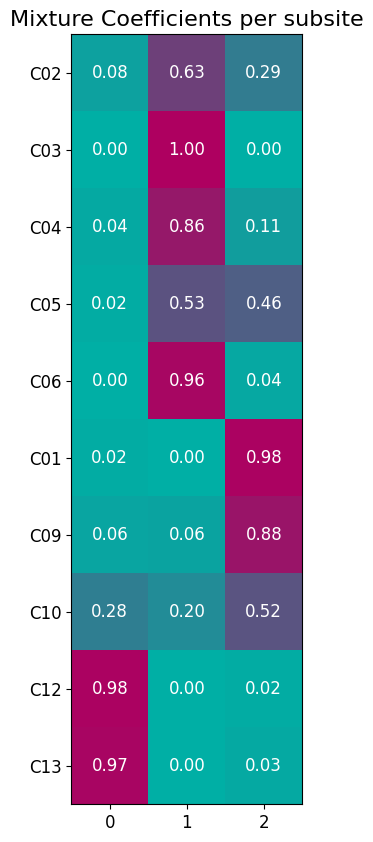

In [119]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


In [89]:
params

{'0_TtoI_spread': 0.034481650210444026,
 '0_TtoII_spread': 0.43443515150616185,
 '0_TtoIII_spread': 0.06979726127783928,
 '0_TtoIV_spread': 0.009904272615126558,
 '0_TtoV_spread': 0.02009794857214547,
 '0_ItoII_spread': 0.6826586949566001,
 '0_IItoIII_spread': 0.10649003669643499,
 '0_IIItoIV_spread': 0.1694673596447928,
 '0_IVtoV_spread': 0.15733992048042078,
 '0_late_p': 0.39071431933395395,
 '0_C01_coef': 0.9999999995331459,
 '0_C02_coef': 0.2942682478240915,
 '0_C03_coef': 1.2657662767035126e-73,
 '0_C04_coef': 0.10074266421077636,
 '0_C05_coef': 0.4656591350917557,
 '0_C06_coef': 1.165940612164696e-24,
 '0_C09_coef': 0.9058128383030442,
 '0_C10_coef': 0.5285358711551943,
 '0_C12_coef': 1.5069130255036644e-13,
 '0_C13_coef': 1.3086537623733853e-06,
 '1_TtoI_spread': 0.061230703520284195,
 '1_TtoII_spread': 0.026578805900061803,
 '1_TtoIII_spread': 0.013842309348332657,
 '1_TtoIV_spread': 0.004070774595678652,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.16394448308

In [42]:
params_history


[{'0_TtoI_spread': 0.034481650210444026,
  '0_TtoII_spread': 0.43443515150616185,
  '0_TtoIII_spread': 0.06979726127783928,
  '0_TtoIV_spread': 0.009904272615126558,
  '0_TtoV_spread': 0.02009794857214547,
  '0_ItoII_spread': 0.6826586949566001,
  '0_IItoIII_spread': 0.10649003669643499,
  '0_IIItoIV_spread': 0.1694673596447928,
  '0_IVtoV_spread': 0.15733992048042078,
  '0_late_p': 0.39071431933395395,
  '0_C01_coef': 0.9999999995331459,
  '0_C02_coef': 0.2942682478240915,
  '0_C03_coef': 1.2657662767035126e-73,
  '0_C04_coef': 0.10074266421077636,
  '0_C05_coef': 0.4656591350917557,
  '0_C06_coef': 1.165940612164696e-24,
  '0_C09_coef': 0.9058128383030442,
  '0_C10_coef': 0.5285358711551943,
  '0_C12_coef': 1.5069130255036644e-13,
  '0_C13_coef': 1.3086537623733853e-06,
  '1_TtoI_spread': 0.061230703520284195,
  '1_TtoII_spread': 0.026578805900061803,
  '1_TtoIII_spread': 0.013842309348332657,
  '1_TtoIV_spread': 0.004070774595678652,
  '1_TtoV_spread': 6.610696135189607e-05,
  '1_It

2d Simplex plot

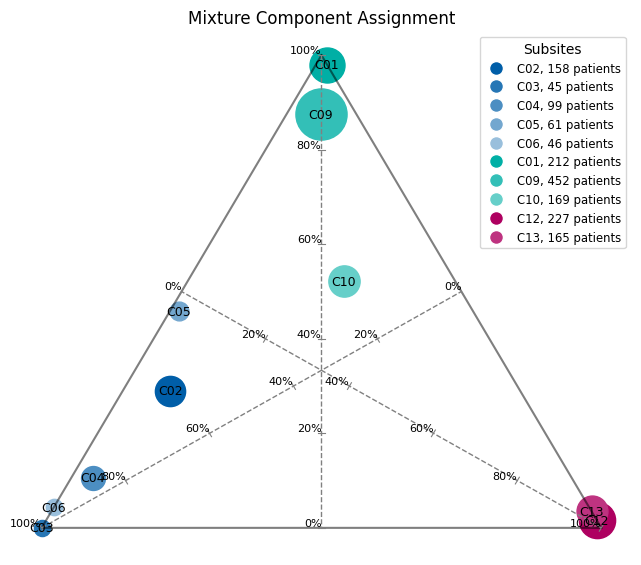

In [120]:
from matplotlib.lines import Line2D
# colormaps
blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), green_to_white(0.2), green_to_white(0.4), red_to_white(0), red_to_white(0.2)]  

# Define the plane's normal vector
normal_vector = np.array([1,1,1])/1/np.sqrt(3)

v1 = np.array([1,-1,0])/1/np.sqrt(2)

# Calculate the second orthogonal vector using the cross product
v2 = np.cross(normal_vector, v1) *-1

# Project the point onto the new coordinate system
origin = np.array([0, 1, 0])
x_origin =  origin @ v1
y_origin = origin @ v2

x_vals = matrix.T @ v1 - x_origin
y_vals = matrix.T @ v2 - y_origin

extremes = np.array([[1,0,0],
                    [0,1,0],
                    [0,0,1]])
extremes_x = extremes @ v1 - x_origin
extremes_y = extremes @ v2 - y_origin

# Plot the point in 2D
import matplotlib.pyplot as plt

odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]
sizes = odered_value_counts * 3

# Define the subsite labels
subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']
plt.figure(figsize=(8, 6.8))
# Plot the points with varying sizes and colors
for i in range(len(x_vals)):
    plt.scatter(x_vals[i], y_vals[i], s=sizes[i], color=colors_ordered[i], label=subsites[i])
    plt.text(x_vals[i], y_vals[i], subsites[i], fontsize=9, ha='center', va='center')

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=subsite)
                   for color, subsite in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')
# plt.scatter(x_vals, y_vals, s=sizes, c = colors_ordered)
# Connect the points
plt.plot(extremes_x, extremes_y, color='black', alpha = 0.5)
# close the triangle by connecting the last point to the first
plt.plot([extremes_x[-1], extremes_x[0]], [extremes_y[-1], extremes_y[0]], color='black', alpha = 0.5)

# Calculate midpoints of each side of the triangle
midpoints_x = (extremes_x[0] + extremes_x[1]) / 2, (extremes_x[1] + extremes_x[2]) / 2, (extremes_x[2] + extremes_x[0]) / 2
midpoints_y = (extremes_y[0] + extremes_y[1]) / 2, (extremes_y[1] + extremes_y[2]) / 2, (extremes_y[2] + extremes_y[0]) / 2

# Draw lines from each vertex to the midpoint of the opposite side
plt.plot([extremes_x[0], midpoints_x[1]], [extremes_y[0], midpoints_y[1]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[1], midpoints_x[2]], [extremes_y[1], midpoints_y[2]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[2], midpoints_x[0]], [extremes_y[2], midpoints_y[0]], color='gray', linestyle='--', linewidth=1)

# Function to add perpendicular ticks as short lines
def add_perpendicular_ticks(x1, y1, x2, y2, tick_length=0.01):
    num_ticks = 6  # Number of ticks including 0% and 100%
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        
        # Vector along the line
        dx = x2 - x1
        dy = y2 - y1
        
        # Perpendicular vector
        perp_dx = -dy
        perp_dy = dx
        
        # Normalize the perpendicular vector
        length = np.sqrt(perp_dx**2 + perp_dy**2)
        perp_dx /= length
        perp_dy /= length
        
        # Draw tick as a short perpendicular line
        plt.plot([x_tick - tick_length * perp_dx, x_tick + tick_length * perp_dx], [y_tick - tick_length * perp_dy, y_tick + tick_length * perp_dy], color='gray', linewidth=0.8)
        plt.text(x_tick, y_tick, f'{int(100 - t * 100)}%', fontsize=8, ha='right', va='bottom')

# Add perpendicular ticks to each line with adjusted length
add_perpendicular_ticks(extremes_x[0], extremes_y[0], midpoints_x[1], midpoints_y[1])
add_perpendicular_ticks(extremes_x[1], extremes_y[1], midpoints_x[2], midpoints_y[2])
add_perpendicular_ticks(extremes_x[2], extremes_y[2], midpoints_x[0], midpoints_y[0])



plt.xlabel('u')
plt.ylabel('v')
plt.title('Mixture Component Assignment')
plt.gca().set_axis_off()

plt.show()

In [31]:


legend_text

['C02, 158 patients',
 'C03, 45 patients',
 'C04, 99 patients',
 'C05, 61 patients',
 'C06, 46 patients',
 'C01, 212 patients',
 'C09, 452 patients',
 'C10, 169 patients',
 'C12, 227 patients',
 'C13, 165 patients']